Thanks for:
* https://www.kaggle.com/sishihara/moa-lgbm-benchmark#Preprocessing

* https://www.kaggle.com/ttahara/osic-baseline-lgbm-with-custom-metric

* https://zenn.dev/fkubota/articles/2b8d46b11c178ac2fa2d

* https://qiita.com/ryouta0506/items/619d9ac0d80f8c0aed92

* https://github.com/nejumi/tools_for_kaggle/blob/master/semi_supervised_learner.py

* https://upura.hatenablog.com/entry/2019/03/03/233534

* https://pompom168.hatenablog.com/entry/2019/07/22/113433


In [1]:
# Version = "v1" # starter model
# Version = "v2" # Compare treat Vs. ctrl and minor modifications, StratifiedKFold
# Version = "v3" # Add debug mode and minor modifications
# Version = "v4" # Clipping a control with an outlier(25-75)
# Version = "v5" # Clipping a control with an outlier(20-80)
# Version = "v6" # under sampling 500 → oversamplling 500, lipping a control with an outlier(10-90)
# Version = "v7" # Use anotated data, under sampling 500 → oversamplling 500, clipping a control with an outlier(10-90)
# Version = "v8" # pseudo labeling (thresholds:0.5), timeout
# Version = "v9" # pseudo labeling (thresholds:0.6), timeout
# Version = "v10" # pseudo labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP
# Version = "v11" # pseudo labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP, lgbm parames adjust
# Version = "v12" # Feature engineering based on feature importance
# Version = "v13" # Calibration, SMOTE(k_neighbors=5→1)
# Version = "v14" # Removed the Calibration, SMOTE(k_neighbors=1), pseudo labeling (thresholds:0.7)
# Version = "v15" # Updata anotated data
# Version = "v16" # Remove noisy label(confidence: 0.5)
# Version = "v17" # Modifications with remove noisy label func, Calibration, confidence = y_prob.probability.max()*0.3
# Version = "v18" # SMOTE(k_neighbors=1→2), confidence = y_prob.probability.max()*0.2
# Version = "v19" # SMOTE(k_neighbors=2→3),
# Version = "v20" # Modifications with confidence, Removed the Calibration, SMOTE(k_neighbors=2), 
# Version = "v21" # DEBUG = False
# Version = "v22" # minor modifications
# Version = "v23" # TOP100→PCA→UMAP(n_components=3)
# Version = "v24" # TOP100→PCA→UMAP(n_components=10), UMAP(n_components=2→3)
# Version = "v25" # Feature engineering based on Feature importance
# Version = "v26" # Modify pseudo labeling func to exclude low confidence pseudo labels in the TEST data.
# Version = "v27" # LGBMClassifie:clf.predict→clf.predict_proba
# Version = "v28" # Calibration (No calbration:CV:0.06542)
# Version = "v29" # Remove Calibration, is_unbalance': True, SMOTE(k_neighbors=2→3), Modify pseudo labeling func to include low confidence pseudo labels in the TEST data, target_rate *= 1.2

Version = "v30" # drop_duplicates(keep="last")

In [2]:
DEBUG = True

# Library

In [3]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
import imblearn
from imblearn.over_sampling import SMOTE

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random

from sklearn import preprocessing
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors

from tqdm.notebook import tqdm
import torch

import warnings
warnings.filterwarnings("ignore")

print("lightgbm Version: ", lgb.__version__)
print("numpy Version: ", np.__version__)
print("pandas Version: ", pd.__version__)
print("imblearn Version: ", imblearn.__version__)

lightgbm Version:  2.3.1
numpy Version:  1.18.5
pandas Version:  1.1.1
imblearn Version:  0.7.0


# Utils

In [4]:
def get_logger(filename='log'):
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.{Version}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger()


def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# Config

In [5]:
if DEBUG:
    N_FOLD = 2
    Num_boost_round=1000
    Early_stopping_rounds=10
    Learning_rate = 0.03
else:
    N_FOLD = 4
    Num_boost_round=10000
    Early_stopping_rounds=30
    Learning_rate = 0.01

SEED = 42
seed_everything(seed=SEED)

Max_depth = 7

# Data Loading

In [6]:
train = pd.read_csv("../input/lish-moa/train_features.csv")
test = pd.read_csv("../input/lish-moa/test_features.csv")
train_targets_scored = pd.read_csv("../input/lish-moa/train_targets_scored.csv")
train_targets_nonscored = pd.read_csv("../input/lish-moa/train_targets_nonscored.csv")
sub = pd.read_csv("../input/lish-moa/sample_submission.csv")

In [7]:
def label_encoding(train: pd.DataFrame, test: pd.DataFrame, encode_cols):
    n_train = len(train)
    train = pd.concat([train, test], sort=False).reset_index(drop=True)
    for f in encode_cols:
        try:
            lbl = preprocessing.LabelEncoder()
            train[f] = lbl.fit_transform(list(train[f].values))
        except:
            print(f)
    test = train[n_train:].reset_index(drop=True)
    train = train[:n_train]
    return train, test

In [8]:
annot = pd.read_csv("../input/moa-annot-data/20201024_moa_sig_list.v2.csv")
annot

,sig_id,nonscored1,nonscored2
0,adenylyl_cyclase_activator,adenylyl_cyclase_inhibitor,NaN
1,aldehyde_dehydrogenase_inhibitor,alcohol_dehydrogenase_inhibitor,NaN
2,antiarrhythmic,na_k-atpase_inhibitor,potassium_channel_blocker
3,anticonvulsant,gaba_gated_chloride_channel_blocker,NaN
4,antifungal,fungal_ergosterol_inhibitor,fungal_lanosterol_demethylase_inhibitor
5,antihistamine,histamine_release_inhibitor,NaN
6,atp-sensitive_potassium_channel_antagonist,atp-sensitive_potassium_channel_inhibitor,NaN
7,bacterial_membrane_integrity_inhibitor,bacterial_protein_synthesis_inhibitor,NaN
8,calcineurin_inhibitor,t_cell_inhibitor,NaN
9,catechol_o_methyltransferase_inhibitor,dopamine_release_enhancer,NaN


In [9]:
annot_sig = []
annot_sig = annot.sig_id.tolist()
print(annot_sig)

['adenylyl_cyclase_activator', 'aldehyde_dehydrogenase_inhibitor', 'antiarrhythmic', 'anticonvulsant', 'antifungal', 'antihistamine', 'atp-sensitive_potassium_channel_antagonist', 'bacterial_membrane_integrity_inhibitor', 'calcineurin_inhibitor', 'catechol_o_methyltransferase_inhibitor', 'cdk_inhibitor', 'coagulation_factor_inhibitor', 'elastase_inhibitor', 'erbb2_inhibitor', 'nicotinic_receptor_agonist', 'nitric_oxide_production_inhibitor', 'protein_phosphatase_inhibitor', 'sphingosine_receptor_agonist', 'steroid', 'ubiquitin_specific_protease_inhibitor']


In [10]:
train_target = pd.concat([train_targets_scored, train_targets_nonscored], axis=1)
train_target.head() 

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Training Utils

In [11]:
def get_target(target_col, annot_sig):
    if target_col in annot_sig:
        t_cols = []
        for t_col in list(annot[annot.sig_id == target_col].iloc[0]):
            if t_col is not np.nan:
                t_cols.append(t_col)
                target = train_target[t_cols]
                target = target.sum(axis=1)
                #1 or more, replace it with 1.
                target = target.where(target < 1, 1)
    else:
        target = train_targets_scored[target_col]
    
    return target

In [12]:
#===========================================================
# model
#===========================================================
def run_lgbm(target_col: str):
    target = get_target(target_col, annot_sig)
    target_rate = target.sum() / len(target)
    target_rate *= 1.2
    
    trt = train[target==1].copy().reset_index(drop=True)
    trt["target"] = 1
    trt = trt.drop("sig_id", axis=1)
    n_target = max(500,len(trt))
    
    logger.info(f"{target_col} , len(trt) : {len(trt)}")
        
    othr = train[target==0].copy().reset_index(drop=True)
    othr = othr.drop("sig_id", axis=1)
    othr = othr.sample(n=n_target, random_state=42)
    othr["target"] = 0
    
    X_train = pd.concat([trt, othr], axis=0, sort=False, ignore_index=True)
    X_train = X_train.replace([np.inf, -np.inf], np.nan)
    X_train = X_train.fillna(0)
    
    y_train = X_train["target"]
    X_train = X_train.drop("target", axis=1)


    if len(trt) < n_target:
        sm = SMOTE(k_neighbors=3, n_jobs=2, random_state=SEED)
        X_train, y_train = sm.fit_sample(X_train, y_train)
    
    X_test = test.drop("sig_id", axis=1)
    
    train_X, train_y = pseudo_labeling(X_train, y_train, X_test, target_rate)
    
    y_preds = []
    models = []
    oof_train = np.zeros((len(train_X),))
    score = 0
        
    for fold_, (train_index, valid_index) in enumerate(cv.split(train_X, train_y)):
        logger.info(f'len(train_index) : {len(train_index)}')
        logger.info(f'len(valid_index) : {len(valid_index)}')
        
        X_tr = train_X.loc[train_index, :]
        X_val = train_X.loc[valid_index, :]
        y_tr = train_y[train_index]
        y_val = train_y[valid_index]

        lgb_train = lgb.Dataset(X_tr,
                                y_tr,
                                categorical_feature=categorical_cols)

        lgb_eval = lgb.Dataset(X_val,
                               y_val,
                               reference=lgb_train,
                               categorical_feature=categorical_cols)
        
        logger.info(f"================================= fold {fold_+1}/{cv.get_n_splits()} {target_col}=================================")
        
        
        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_eval],
                          verbose_eval=100,
                          num_boost_round=Num_boost_round,
                          early_stopping_rounds=Early_stopping_rounds)
        
        oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)

        y_pred = model.predict(X_test, num_iteration=model.best_iteration)
        y_preds.append(y_pred)
        models.append(model)
    
    score = log_loss(train_y, oof_train)
    
    logger.info(f"{target_col} logloss: {score}")
    logger.info(f"=========================================================================================")

    return sum(y_preds) / len(y_preds), score, models, 

In [13]:
classifier_params = {
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'n_estimators': Num_boost_round,
    'learning_rate': Learning_rate,
    'objective': "binary",
    'colsample_bytree':0.7,
    'subsample':0.9,
    'subsample_freq':5,
    'reg_alpha':0.1,
    'reg_lambda':0.1,
    'random_state':SEED,
    'n_jobs':2,
}

In [14]:
def convert_label(df, conf_0, conf_1, threshold=0.5):
    df = df.copy()
    Probability = df.iloc[:,0]
    # Remove low confidence labels
    conf_index = df[(Probability <= conf_0) & (conf_1 <= Probability)].index.values
    
    Probability = Probability.where(Probability < threshold, 1).copy()
    p_label = Probability.where(Probability >= threshold, 0).copy()
    
    return p_label, conf_index

In [15]:
def pseudo_labeling(X_train, y_train, X_test, target_rate, max_iter=3):
       
    X = X_train.copy()
    y = y_train.copy()
    
    Threshold = 0.5
    
    for iter_ in range(1, max_iter+1):
    
        logger.info(f"================= Pseudo labeling {iter_} / {max_iter} =================")
        
        y_preds = np.zeros((X.shape[0], 2))
        y_preds[:, 0] = y.copy()
        
        y_prob = np.zeros((X_test.shape[0]))
        
        X_conf = pd.DataFrame()
        y_conf = pd.DataFrame()
        
        for fold_, (train_idx, valid_idx) in enumerate(cv.split(X, y)):        
            X_tr, X_val = X.loc[train_idx, :], X.loc[valid_idx, :]
            y_tr, y_val = y[train_idx], y[valid_idx]
            
            clf = LGBMClassifier(**classifier_params)
            
            clf.fit(X_tr, y_tr,
                    eval_set=[(X_tr, y_tr), (X_val, y_val)],
                    eval_metric='logloss',
                    verbose=100,
                    early_stopping_rounds=Early_stopping_rounds)
            
            y_preds[valid_idx, 1] = clf.predict_proba(X_val, num_iteration=clf.best_iteration_)[:, 1]
            y_prob += clf.predict_proba(X_test, num_iteration=clf.best_iteration_)[:, 1] / N_FOLD
        
        auc_score = roc_auc_score(y_preds[:, 0], y_preds[:, 1])
        logger.info(f"{iter_} / {max_iter} AUC score:{auc_score:.3f}") 
        y_preds = pd.DataFrame(y_preds, index=X.index, columns=[["Labels", "Preds"]])
        
        y_preds.iloc[:,1] = y_preds.iloc[:,1].where(y_preds.iloc[:,1] < Threshold, 1).copy()
        y_preds.iloc[:,1] = y_preds.iloc[:,1].where(y_preds.iloc[:,1] >= Threshold, 0).copy()
        y_preds = y_preds.sum(axis=1)
                
        corect_idx = y_preds[y_preds != 1].index.values
        X_corect, y_corect = X[X.index.isin(corect_idx)], y[y.index.isin(corect_idx)]
        
        logger.info(f"Remove_noisy_labels: {len(y)-len(y_corect)} → positive_corect_labels: {sum(y_corect)}/{len(y_corect)}")
            
        # Remove low confidence labels
        y_prob = pd.DataFrame(y_prob, index=X_test.index, columns=["probability"])
        high_conf_0, high_conf_1 = y_prob.probability.min()*30, y_prob.probability.max()*0.6

        p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
        
        p_label_rate = sum(p_label)/len(p_label)        
        logger.info(f"p_label_rate: {p_label_rate:.5f} Vs.target_rate: {target_rate:.5f}, Num_p_label: {sum(p_label)}, conf_0:{high_conf_0:.5f}, conf_1:{high_conf_1:.5f}")
        
        # Set the params of threshold based on train labels rate (target_rate).
        # target_rate = target.sum() / len(target) * 1.2
        if p_label_rate*3 < target_rate:
            check = len(y_prob)*target_rate
            for i in range(10):
                logger.info(f"Num_p_label: {sum(p_label)}, Expected: {check:.1f}, Adj_threshold_{i+1}: {Threshold:.2f}")
                if sum(p_label)*2 >= check: break
                Threshold -= 0.04
                if Threshold <= 0.1: break
                p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
               
                
        if p_label_rate > target_rate*3:
            check = len(y_prob)*target_rate
            for i in range(10):
                logger.info(f"Num_p_label: {sum(p_label)}, Expected: {check:.1f}, Adj_threshold_{i+1}: {Threshold:.2f}")
                if sum(p_label) <= check*2: break
                Threshold += 0.04
                if Threshold >= 0.9: break
                p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
                
        if iter_ == max_iter:
            X_conf = X_test.copy()
        else:
            X_conf = X_test[X_test.index.isin(conf_idx)].copy()
            
        logger.info(f"threshold:{Threshold:.2f}, positive p_label:{sum(p_label)}/{len(p_label)}, p_label_rate: {sum(p_label)/len(p_label):.5f}")
 
        X = pd.concat([X_corect, X_conf], axis=0, ignore_index=True)
        y = pd.concat([y_corect, p_label], axis=0, ignore_index=True)
        
        X = X.drop_duplicates(keep="last").reset_index(drop=True)
        y = y[X.index.values].reset_index(drop=True)
        
        logger.info(f"positive y_label:{sum(y)}/{len(y)}, y_label_rate: {sum(y)/len(y):.5f}")
        
    return X, y

In [16]:
def show_feature_importance(feature_importance_df, num=100):
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

    plt.figure(figsize=(8, 30))
    sns.barplot(x="importance", 
                y="Feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('Features importance (averaged)')
    plt.tight_layout()
    plt.savefig(f"./feature_importance_{Version}.png")
    plt.show()

# Preprocessing

We have to convert some categorical features into numbers in train and test. We can identify categorical features by `pd.DataFrame.select_dtypes`.

In [17]:
train.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [18]:
train.select_dtypes(include=['object']).columns

Index(['sig_id', 'cp_type', 'cp_dose'], dtype='object')

In [19]:
train, test = label_encoding(train, test, ['cp_type', 'cp_time', 'cp_dose'])

In [20]:
train['WHERE'] = 'train'
test['WHERE'] = 'test'

data = train.append(test)
data = data.reset_index(drop=True)
data

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176,train
1,id_000779bfc,1,2,0,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371,train
2,id_000a6266a,1,1,0,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931,train
3,id_0015fd391,1,1,0,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154,train
4,id_001626bd3,1,2,1,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_ff7004b87,1,0,0,0.4571,-0.5743,3.3930,-0.6202,0.8557,1.6240,...,-0.6422,-0.4367,0.0159,-0.6539,-0.4791,-1.2680,-1.1280,-0.4167,-0.6600,test
27792,id_ff925dd0d,1,0,0,-0.5885,-0.2548,2.5850,0.3456,0.4401,0.3107,...,0.5780,-0.5888,0.8057,0.9312,1.2730,0.2614,-0.2790,-0.0131,-0.0934,test
27793,id_ffb710450,1,2,0,-0.3985,-0.1554,0.2677,-0.6813,0.0152,0.4791,...,0.9153,-0.1862,0.4049,0.9568,0.4666,0.0461,0.5888,-0.4205,-0.1504,test
27794,id_ffbb869f2,1,1,1,-1.0960,-1.7750,-0.3977,1.0160,-1.3350,-0.2207,...,-0.4473,-0.8192,0.7785,0.3133,0.1286,-0.2618,0.5074,0.7430,-0.0484,test


In [21]:
# Select control data
ctl = train[(train.cp_type==0)]
ctl

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
25,id_0054388ec,0,1,0,-0.6696,-0.2718,-1.2230,-0.6226,-0.7220,0.1588,...,0.6405,0.5429,0.3562,1.3290,0.5573,0.8837,0.5534,0.8976,1.0050,train
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-0.6828,-0.6594,-0.2043,0.3571,-0.1319,0.2187,0.0737,0.6498,-1.4820,train
40,id_007bfbb91,0,0,1,-1.3200,-1.7340,-0.0741,1.5440,-1.8290,-0.0951,...,1.0340,0.7393,1.1020,0.3786,0.2636,-0.5751,0.3362,0.8543,0.9180,train
47,id_008a986b7,0,1,1,0.4860,0.1430,0.5281,-0.0022,-0.2334,-0.6607,...,-0.1866,0.7629,0.3288,-0.9915,-0.3694,-0.4979,0.5281,-0.9245,-0.9367,train
63,id_009d8340f,0,0,1,0.4471,-0.0839,-0.3864,0.3196,0.2584,-0.3156,...,0.3939,0.7665,0.7932,-0.6804,-0.0435,0.0949,0.2000,-0.4326,0.9364,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23729,id_ff1f9e5fc,0,0,0,0.0465,0.6430,-0.2453,0.3521,0.6195,-0.6659,...,0.1621,-0.2065,0.8314,-0.1891,-0.0074,0.2131,-0.1419,-0.2422,0.0457,train
23747,id_ff469c482,0,2,0,-0.6204,-1.3800,-1.1880,-0.6573,-0.8408,-0.2447,...,0.7366,0.5468,1.1450,0.5254,0.6224,-0.9630,0.8872,-0.0742,-0.6777,train
23768,id_ff89331ca,0,2,1,-0.1051,0.4335,0.3648,-0.0525,-0.3632,-0.3228,...,0.4885,0.4963,0.9434,-0.4779,0.6951,0.9517,-0.8110,-0.1748,-0.3626,train
23793,id_ffd26f361,0,1,1,0.6008,0.2781,-0.3319,-0.8782,0.9281,0.7535,...,0.9569,-0.2065,-0.4918,0.7863,0.0504,0.8813,0.7757,-0.5272,0.7082,train


In [22]:
# clipping

def outlaier_clip(df):
    df = df.copy()
    clipping = df.columns[4:6]
    for col in clipping:
        lower, upper= np.percentile(df[col], [10, 90])
        df[col] = np.clip(df[col], lower, upper)
    
    return df

ctl_df = pd.DataFrame(columns=train.columns)
for i in ctl.cp_time.unique():
    for j in ctl.cp_dose.unique():
        print(len(ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]))
        tmp_ctl = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]
        tmp_ctl = outlaier_clip(tmp_ctl)
        ctl_df = pd.concat([ctl_df, tmp_ctl], axis=0).reset_index(drop=True)
ctl_df

343
305
301
305
307
305


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
0,id_0054388ec,0,1,0,-0.6696,-0.27180,-1.2230,-0.6226,-0.7220,0.1588,...,0.6405,0.5429,0.3562,1.3290,0.5573,0.8837,0.5534,0.8976,1.0050,train
1,id_01b05de6c,0,1,0,-0.3176,0.48512,-0.3773,0.5555,-0.4877,0.3413,...,-0.6163,0.8001,0.3389,0.7437,0.7533,0.2406,0.5057,0.8017,1.0280,train
2,id_020ba48d9,0,1,0,0.8094,-0.33390,1.1130,-0.4192,0.4545,-0.4771,...,-0.4414,-0.2442,0.0557,-0.6597,-0.3713,-0.6929,-0.3258,0.3602,-0.0595,train
3,id_02c93b4a5,0,1,0,-0.0884,-1.54100,0.5562,0.4661,-0.1683,0.9515,...,0.4766,0.9697,0.4613,0.8957,0.8227,1.2300,1.7180,0.6542,0.0580,train
4,id_03bc6d412,0,1,0,0.8431,0.09310,-0.0958,-0.4337,1.0690,-0.6440,...,-1.1510,-0.5010,-0.2736,0.1270,0.3511,0.1233,-0.8520,0.1767,0.1153,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1861,id_fbb620181,0,2,1,-0.3490,0.72970,-4.1480,-1.0030,2.4070,-0.9784,...,-1.4260,-0.8613,-0.0243,-0.6109,0.6377,-1.2590,-0.7238,-0.7734,-0.1274,train
1862,id_fbba92030,0,2,1,-0.8921,1.13520,0.4227,1.3270,-0.9839,-0.8469,...,1.1340,0.7007,1.3320,0.6622,0.6167,0.9459,-0.0344,-0.0186,0.5173,train
1863,id_fbc0849ad,0,2,1,-0.2948,0.21960,-0.3252,-0.2084,-0.6518,0.3542,...,0.5014,0.6009,0.4560,-0.3360,-0.5091,0.6569,0.6203,0.6764,0.4504,train
1864,id_fd93fa37d,0,2,1,-0.2984,-0.47880,-2.3560,-0.6848,1.8700,1.0240,...,-0.4422,-0.6665,-0.8033,-1.0520,0.4103,0.4462,-1.1580,-1.3060,0.1925,train


In [23]:
col_list = list(data.columns)[:-1]
data_df = pd.DataFrame(columns=col_list)
Splitdata = []
d = 1e-6

for i in data.cp_time.unique():
    for j in data.cp_dose.unique():
        select = data[(data.cp_time==i) & (data.cp_dose==j)]
        print(len(select))
        
        for k in list(select['WHERE']):
                      Splitdata.append(k)
        
        select = select.drop(columns='WHERE')
        med = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)].iloc[:, 4:].median()
        f_div = lambda x: (x+d) / (abs(med)+d)
        select_d = select.iloc[:,4:].apply(f_div, axis=1).add_prefix('d_')
        tmp_data = pd.concat([select,select_d], axis=1, sort=False)
        data_df = pd.concat([data_df, tmp_data], axis=0)
data_df

4534
4538
4561
4536
5079
4548


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-90,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.900850,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,5.788465,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-2.000935,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-1.221271,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-9.203619,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,3.364808,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-6.666625,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.461452,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-5.310498,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391


In [24]:
# clipping
clipping = data_df.columns[4:]
for col in clipping:
    lower, upper = np.percentile(data_df[col], [1, 99])
    data_df[col] = np.clip(data_df[col], lower, upper)
data_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-90,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.900850,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,5.788465,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-2.000935,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-1.221271,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-9.203619,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,3.364808,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-6.666625,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.461452,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-5.310498,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391


In [25]:
data_df.cp_type = data_df.cp_type.astype('int64')
data_df.cp_time = data_df.cp_time.astype('int64')
data_df.cp_dose = data_df.cp_dose.astype('int64')
data_df.dtypes

sig_id      object
cp_type      int64
cp_time      int64
cp_dose      int64
g-0        float64
            ...   
d_c-95     float64
d_c-96     float64
d_c-97     float64
d_c-98     float64
d_c-99     float64
Length: 1748, dtype: object

In [26]:
data_df = data_df.replace([np.inf, -np.inf], np.nan)
data_df = data_df.dropna(how='any', axis=1)
data_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-90,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.900850,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,5.788465,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-2.000935,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-1.221271,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-9.203619,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,3.364808,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-6.666625,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.461452,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-5.310498,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391


In [27]:
data_df['WHERE'] = Splitdata
data_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99,WHERE
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303,train
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866,train
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032,train
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519,train
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843,test
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932,test
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938,test
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391,test


In [28]:
train = data_df[data_df['WHERE']=="train"].drop('WHERE', axis=1)
test = data_df[data_df['WHERE']=="test"].drop('WHERE', axis=1)

In [29]:
# Kolmogorov-Smirnov test applied for train data and test data.

from scipy.stats import ks_2samp

tr = train.iloc[:, 4:]
ts = test.iloc[:, 4:]

list_p_value =[ks_2samp(ts[i], tr[i])[1] for i in tqdm(tr.columns)]
Se = pd.Series(list_p_value, index=tr.columns).sort_values() 
list_discarded = list(Se[Se < .1].index)

train = train.drop(list_discarded, axis=1)
test = test.drop(list_discarded, axis=1)

print(f"Removed {len(list_discarded)} columns")


Removed 408 columns


In [30]:
train['WHERE'] = 'train'
test['WHERE'] = 'test'

data = train.append(test)
data = data.reset_index(drop=True)
data

,sig_id,cp_type,cp_time,cp_dose,g-1,g-2,g-4,g-5,g-6,g-8,...,d_c-87,d_c-89,d_c-90,d_c-91,d_c-92,d_c-94,d_c-95,d_c-97,d_c-99,WHERE
0,id_000644bb2,1,0,0,0.5577,-0.2479,-0.1944,-1.0120,-1.0220,0.5548,...,-0.458706,3.210844,0.900850,0.827675,4.339584,-0.411268,1.931922,0.630788,1.125303,train
1,id_001762a82,1,0,0,0.2941,-0.9901,1.2810,0.5203,0.0543,-0.1586,...,4.198996,7.411112,5.788465,3.705949,-5.437902,3.069473,1.325997,1.110292,3.769866,train
2,id_00762e877,1,0,0,0.1662,-0.6307,-0.5992,-0.2523,-1.3770,-1.4880,...,2.130879,2.780971,-2.000935,-0.524979,-0.457811,0.017855,2.201874,2.479205,1.298032,train
3,id_0079af0fb,0,0,0,-1.8230,-0.5211,-1.1280,0.6041,0.3856,-0.5400,...,0.036750,2.267525,-1.221271,-2.187049,-3.543232,0.768123,-0.387026,0.217342,-3.993519,train
4,id_0079d45d3,1,0,0,-2.1430,-0.0943,0.4869,-0.0935,1.2090,-1.5450,...,-18.897523,-9.183429,-9.203619,-18.488086,-10.402948,-5.953954,-7.288708,-6.644035,-1.741033,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,-0.0461,-0.9751,-0.1861,0.3608,0.5174,0.9298,...,10.394855,-23.040415,3.364808,-2.944165,4.362395,-0.200288,3.648613,-1.381859,-2.753843,test
27792,id_fce497048,1,1,1,-0.3274,-0.0099,0.6673,-1.5380,-0.5368,2.1020,...,-53.796375,-33.477371,-6.666625,-2.994822,-108.965314,-19.418785,-5.186308,-3.400727,-6.611932,test
27793,id_fd75349b2,1,1,1,0.4437,-0.1530,-0.5804,0.0633,0.6952,-0.1058,...,110.075643,53.955575,1.461452,1.221387,-12.977688,-1.481351,-3.441418,1.214694,-2.167938,test
27794,id_fed0f2fe0,1,1,1,0.7350,0.3304,0.1435,-1.6810,-1.1370,-0.4083,...,-26.830434,-50.825426,-5.310498,-2.757956,9.262242,-2.189681,-6.566071,-3.150643,-5.960391,test


In [31]:
Splitdata = data["WHERE"]
data = data.drop('WHERE', axis=1)
data

,sig_id,cp_type,cp_time,cp_dose,g-1,g-2,g-4,g-5,g-6,g-8,...,d_c-85,d_c-87,d_c-89,d_c-90,d_c-91,d_c-92,d_c-94,d_c-95,d_c-97,d_c-99
0,id_000644bb2,1,0,0,0.5577,-0.2479,-0.1944,-1.0120,-1.0220,0.5548,...,0.610453,-0.458706,3.210844,0.900850,0.827675,4.339584,-0.411268,1.931922,0.630788,1.125303
1,id_001762a82,1,0,0,0.2941,-0.9901,1.2810,0.5203,0.0543,-0.1586,...,2.368506,4.198996,7.411112,5.788465,3.705949,-5.437902,3.069473,1.325997,1.110292,3.769866
2,id_00762e877,1,0,0,0.1662,-0.6307,-0.5992,-0.2523,-1.3770,-1.4880,...,-2.098055,2.130879,2.780971,-2.000935,-0.524979,-0.457811,0.017855,2.201874,2.479205,1.298032
3,id_0079af0fb,0,0,0,-1.8230,-0.5211,-1.1280,0.6041,0.3856,-0.5400,...,0.927045,0.036750,2.267525,-1.221271,-2.187049,-3.543232,0.768123,-0.387026,0.217342,-3.993519
4,id_0079d45d3,1,0,0,-2.1430,-0.0943,0.4869,-0.0935,1.2090,-1.5450,...,-12.466870,-18.897523,-9.183429,-9.203619,-18.488086,-10.402948,-5.953954,-7.288708,-6.644035,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,-0.0461,-0.9751,-0.1861,0.3608,0.5174,0.9298,...,0.977743,10.394855,-23.040415,3.364808,-2.944165,4.362395,-0.200288,3.648613,-1.381859,-2.753843
27792,id_fce497048,1,1,1,-0.3274,-0.0099,0.6673,-1.5380,-0.5368,2.1020,...,-3.525817,-53.796375,-33.477371,-6.666625,-2.994822,-108.965314,-19.418785,-5.186308,-3.400727,-6.611932
27793,id_fd75349b2,1,1,1,0.4437,-0.1530,-0.5804,0.0633,0.6952,-0.1058,...,2.350949,110.075643,53.955575,1.461452,1.221387,-12.977688,-1.481351,-3.441418,1.214694,-2.167938
27794,id_fed0f2fe0,1,1,1,0.7350,0.3304,0.1435,-1.6810,-1.1370,-0.4083,...,-6.247984,-26.830434,-50.825426,-5.310498,-2.757956,9.262242,-2.189681,-6.566071,-3.150643,-5.960391


In [32]:
# Select TOP100 features based on feature importance with v8 notebook

def select_importance_cols(feature_importance_df, num=103):
    best_cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    return best_cols


Feature_importance_df = pd.read_csv("../input/../input/moa-annot-data/feature_importance_df.v8.colab.csv")
Feature_importance_df

importance_cols = select_importance_cols(Feature_importance_df)

len(importance_cols)

103

In [33]:
TOP100 = data[importance_cols]
TOP100 = TOP100.drop(["cp_type", "cp_time", "cp_dose"], axis=1)
TOP100

,c-98,g-763,g-231,g-178,g-91,g-635,d_g-87,g-254,d_g-202,g-207,...,d_g-39,g-569,g-65,d_g-743,d_g-580,g-105,d_g-157,g-201,d_g-435,c-67
0,0.3801,-0.3167,-1.6510,-0.6217,-1.1230,-0.2461,4.183851,-1.3310,20.720024,-0.22130,...,-0.463249,0.1242,0.0251,2.647177,-10.548861,-1.2560,-0.262194,0.4171,-2.345232,1.2570
1,0.7848,0.4842,0.0333,-0.5141,0.4944,-1.1160,-9.101135,0.5149,-121.467612,0.07920,...,0.712450,0.4590,-0.2584,1.543021,2.532123,-0.2533,-2.819025,-0.4584,3.110345,0.4290
2,0.3193,0.4587,-0.8791,0.2905,-0.1851,0.0860,-5.791252,-1.6090,134.510130,-0.07250,...,1.025284,-0.2491,0.1676,-3.476730,-1.085747,-0.5656,-3.664973,0.6659,-3.906875,-0.3232
3,0.6498,0.6086,-0.5522,0.4275,-0.7775,0.2270,-2.712772,0.8298,74.254500,-1.66400,...,-0.539958,1.3530,-0.2259,-0.720046,31.350629,0.3576,0.201876,0.0597,3.599244,-0.9233
4,-4.8360,-1.1320,2.3720,-0.8283,1.5840,-2.3630,-1.055764,-0.9043,140.770455,3.85415,...,3.627592,-4.4690,1.8870,-9.592403,43.259989,0.0328,-3.335726,4.2690,3.422303,-0.8781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,0.2310,-0.2914,0.1655,0.2242,0.1058,-1.0330,-2.921354,0.5788,-13.888734,-0.31340,...,-1.244962,-0.4987,-0.4098,0.769766,-155.100886,0.1914,-4.482931,-0.5465,0.340697,-0.6500
27792,-2.4700,1.0300,0.2641,-1.0190,5.7110,-2.3140,-19.551915,1.8170,56.104299,0.69710,...,1.129264,-4.7070,4.7440,2.384589,1016.814588,-0.1688,6.439848,0.8439,-2.063460,-5.1430
27793,-2.1970,0.0199,0.0428,0.7036,2.8370,0.9448,5.732132,-1.6010,-249.158505,-2.55600,...,-1.024153,-0.0303,0.7360,-5.974495,-110.383776,1.5240,9.631421,0.1586,1.600912,-0.7809
27794,-1.0450,-0.2809,-0.8224,0.2189,-1.0990,0.9241,-0.123390,-1.4440,-7.429982,0.82050,...,1.669632,0.6461,-0.4913,3.565008,253.578959,0.7208,5.579313,-0.2808,-0.563337,-0.8265


In [34]:
g_list = [col for col in data.columns[4:] if col.startswith("g-")]
c_list = [col for col in data.columns[4:] if col.startswith("c-")]
d_g_list = [col for col in data.columns[4:] if col.startswith("d_g-")]
d_c_list = [col for col in data.columns[4:] if col.startswith("d_c-")]

g_list

['g-1',
 'g-2',
 'g-4',
 'g-5',
 'g-6',
 'g-8',
 'g-9',
 'g-10',
 'g-12',
 'g-13',
 'g-14',
 'g-15',
 'g-16',
 'g-18',
 'g-19',
 'g-20',
 'g-23',
 'g-24',
 'g-25',
 'g-26',
 'g-27',
 'g-28',
 'g-29',
 'g-30',
 'g-31',
 'g-32',
 'g-33',
 'g-34',
 'g-35',
 'g-36',
 'g-38',
 'g-39',
 'g-40',
 'g-41',
 'g-42',
 'g-43',
 'g-44',
 'g-45',
 'g-46',
 'g-47',
 'g-48',
 'g-49',
 'g-50',
 'g-51',
 'g-53',
 'g-54',
 'g-55',
 'g-56',
 'g-57',
 'g-58',
 'g-59',
 'g-61',
 'g-62',
 'g-64',
 'g-65',
 'g-67',
 'g-69',
 'g-70',
 'g-71',
 'g-73',
 'g-74',
 'g-77',
 'g-78',
 'g-79',
 'g-81',
 'g-83',
 'g-87',
 'g-88',
 'g-89',
 'g-90',
 'g-91',
 'g-93',
 'g-94',
 'g-95',
 'g-96',
 'g-97',
 'g-99',
 'g-103',
 'g-104',
 'g-105',
 'g-106',
 'g-107',
 'g-108',
 'g-109',
 'g-110',
 'g-111',
 'g-113',
 'g-114',
 'g-115',
 'g-116',
 'g-117',
 'g-118',
 'g-119',
 'g-121',
 'g-122',
 'g-123',
 'g-124',
 'g-125',
 'g-126',
 'g-127',
 'g-128',
 'g-129',
 'g-130',
 'g-131',
 'g-132',
 'g-133',
 'g-136',
 'g-137',
 'g-

In [35]:
from sklearn.preprocessing import StandardScaler
    
# Z-score
scaler = StandardScaler(with_mean=True, with_std=True)
std_values = scaler.fit_transform(data.iloc[:, 4:])
std_df = pd.DataFrame(std_values, index=data.index, columns=data.columns[4:])    

In [36]:
TOP100_values = scaler.fit_transform(TOP100)
TOP100_df = pd.DataFrame(TOP100_values, index=TOP100.index, columns=TOP100.columns)
TOP100_df

,c-98,g-763,g-231,g-178,g-91,g-635,d_g-87,g-254,d_g-202,g-207,...,d_g-39,g-569,g-65,d_g-743,d_g-580,g-105,d_g-157,g-201,d_g-435,c-67
0,0.465802,-0.291639,-1.052265,-0.263976,-0.823391,-0.341928,0.010720,-1.173292,0.532505,-0.245498,...,-0.370791,0.296662,-0.189006,0.524494,-0.060594,-1.291179,-0.044174,0.035238,-1.003075,0.850758
1,0.690930,0.436481,0.041989,-0.205921,0.051524,-0.997763,0.010672,0.349254,-2.467257,0.051649,...,0.236541,0.511429,-0.395724,0.359766,-0.060531,-0.343840,-0.059517,-0.504862,1.039894,0.448301
2,0.431980,0.413298,-0.550778,0.228193,-0.316045,-0.091551,0.010684,-1.402594,2.933159,-0.098358,...,0.398142,0.057198,-0.085100,-0.389126,-0.060548,-0.638898,-0.064593,0.188724,-1.587868,0.082687
3,0.615831,0.549577,-0.338398,0.302110,-0.636497,0.014752,0.010695,0.608992,1.661933,-1.672100,...,-0.410416,1.084911,-0.372027,0.022141,-0.060392,0.233330,-0.041389,-0.185244,1.222974,-0.208997
4,-2.435831,-1.032850,1.561392,-0.375445,0.640931,-1.937901,0.010701,-0.821339,3.065234,3.784478,...,1.742419,-2.649776,1.168628,-1.301517,-0.060335,-0.073537,-0.062617,2.411493,1.156714,-0.187027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,0.382860,-0.268638,0.127876,0.192421,-0.158685,-0.935187,0.010694,0.401960,-0.197643,-0.336570,...,-0.774601,-0.102915,-0.506120,0.244405,-0.061289,0.076307,-0.069501,-0.559212,0.002735,-0.076157
27792,-1.119663,0.932683,0.191934,-0.478335,2.873386,-1.900959,0.010635,1.423260,1.279015,0.662655,...,0.451856,-2.802448,3.251854,0.485318,-0.055651,-0.264006,-0.003956,0.298533,-0.897559,-2.260021
27793,-0.967797,0.014373,0.048160,0.451077,1.318727,0.555915,0.010725,-1.395995,-5.161179,-2.554147,...,-0.660537,0.197554,0.329358,-0.761765,-0.061074,1.335331,0.015196,-0.124232,0.474652,-0.139782
27794,-0.326958,-0.259092,-0.513942,0.189562,-0.810409,0.540309,0.010704,-1.266498,-0.061381,0.784678,...,0.730994,0.631450,-0.565547,0.661424,-0.059323,0.576477,-0.009120,-0.395300,-0.335802,-0.161946


In [37]:
from sklearn.decomposition import PCA
from umap import UMAP

# PCA for all data
pca_transformer = PCA(n_components=0.9, whiten=True, random_state=SEED)
pca_all = pca_transformer.fit_transform(std_df)

# PCA → UMAP for all data
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_all = umap.fit_transform(pca_all)

print(pca_umap_all.shape)

(27796, 10)


In [38]:
# PCA for TOP100
pca_TOP100 = pca_transformer.fit_transform(TOP100_df)

# PCA → UMAP for TOP100
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_TOP100 = umap.fit_transform(pca_TOP100)

print(pca_umap_TOP100.shape)

(27796, 10)


In [39]:
# PCA for merged categories
g_d_g_list = g_list + d_g_list
c_d_c_list = c_list + d_c_list

pca_transformer = PCA(n_components=0.9, whiten=True, random_state=SEED)
pca_g_d_g = pca_transformer.fit_transform(std_df[g_d_g_list])
pca_c_d_c = pca_transformer.fit_transform(std_df[c_d_c_list])

# PCA → UMAP for merged categories
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_g_d_g = umap.fit_transform(pca_g_d_g)

umap = UMAP(n_components=3, random_state=SEED)
pca_umap_c_d_c = umap.fit_transform(pca_c_d_c)

print(pca_umap_g_d_g.shape)
print(pca_umap_c_d_c.shape)

(27796, 10)
(27796, 3)


In [40]:
# PCA for each category
pca_transformer = PCA(n_components=0.9, whiten=True, random_state=SEED)
pca_g = pca_transformer.fit_transform(std_df[g_list])
pca_c = pca_transformer.fit_transform(std_df[c_list])
pca_d_g = pca_transformer.fit_transform(std_df[d_g_list])
pca_d_c = pca_transformer.fit_transform(std_df[d_c_list])

print(pca_g.shape)
print(pca_c.shape)
print(pca_d_g.shape)
print(pca_d_c.shape)

print("*************")

# PCA → UMAP for each category
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_g = umap.fit_transform(pca_g)
pca_umap_d_g = umap.fit_transform(pca_d_g)

umap = UMAP(n_components=3, random_state=SEED)
pca_umap_c = umap.fit_transform(pca_c)
pca_umap_d_c = umap.fit_transform(pca_d_c)

print(pca_umap_g.shape)
print(pca_umap_c.shape)
print(pca_umap_d_g.shape)
print(pca_umap_d_c.shape)

(27796, 323)
(27796, 13)
(27796, 394)
(27796, 25)
*************
(27796, 10)
(27796, 3)
(27796, 10)
(27796, 3)


In [41]:
# PCA for all categories
pca_transformer = PCA(n_components=3, whiten=True, random_state=SEED)

pca_all = pca_transformer.fit_transform(std_df)
pca_g_d_g = pca_transformer.fit_transform(std_df[g_d_g_list])
pca_c_d_c = pca_transformer.fit_transform(std_df[c_d_c_list])
pca_g = pca_transformer.fit_transform(std_df[g_list])
pca_c = pca_transformer.fit_transform(std_df[c_list])
pca_d_g = pca_transformer.fit_transform(std_df[d_g_list])
pca_d_c = pca_transformer.fit_transform(std_df[d_c_list])

print(pca_all.shape)
print(pca_g_d_g.shape)
print(pca_c_d_c.shape)
print(pca_g.shape)
print(pca_c.shape)
print(pca_d_g.shape)
print(pca_d_c.shape)

(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)


In [42]:
data_list = [ 
    pca_umap_all,
    pca_umap_g_d_g,
    pca_umap_c_d_c,
    pca_umap_g,
    pca_umap_c,
    pca_umap_d_g,
    pca_umap_d_c,
    pca_all,
    pca_g_d_g,
    pca_c_d_c,
    pca_g,
    pca_c,
    pca_d_g,
    pca_d_c,
    pca_umap_TOP100,
]

data_names = [ 
    "pca_umap_all",
    "pca_umap_g_d_g",
    "pca_umap_c_d_c",
    "pca_umap_g",
    "pca_umap_c",
    "pca_umap_d_g",
    "pca_umap_d_c",
    "pca_all",
    "pca_g_d_g",
    "pca_c_d_c",
    "pca_g",
    "pca_c",
    "pca_d_g",
    "pca_d_c",
    "pca_umap_TOP100",
]

In [43]:
col_list = []
for i, d in enumerate(data_list):
    for j in range(d.shape[1]):
        col_list.append( f"{data_names[i]}_{j+1}")
col_list

['pca_umap_all_1',
 'pca_umap_all_2',
 'pca_umap_all_3',
 'pca_umap_all_4',
 'pca_umap_all_5',
 'pca_umap_all_6',
 'pca_umap_all_7',
 'pca_umap_all_8',
 'pca_umap_all_9',
 'pca_umap_all_10',
 'pca_umap_g_d_g_1',
 'pca_umap_g_d_g_2',
 'pca_umap_g_d_g_3',
 'pca_umap_g_d_g_4',
 'pca_umap_g_d_g_5',
 'pca_umap_g_d_g_6',
 'pca_umap_g_d_g_7',
 'pca_umap_g_d_g_8',
 'pca_umap_g_d_g_9',
 'pca_umap_g_d_g_10',
 'pca_umap_c_d_c_1',
 'pca_umap_c_d_c_2',
 'pca_umap_c_d_c_3',
 'pca_umap_g_1',
 'pca_umap_g_2',
 'pca_umap_g_3',
 'pca_umap_g_4',
 'pca_umap_g_5',
 'pca_umap_g_6',
 'pca_umap_g_7',
 'pca_umap_g_8',
 'pca_umap_g_9',
 'pca_umap_g_10',
 'pca_umap_c_1',
 'pca_umap_c_2',
 'pca_umap_c_3',
 'pca_umap_d_g_1',
 'pca_umap_d_g_2',
 'pca_umap_d_g_3',
 'pca_umap_d_g_4',
 'pca_umap_d_g_5',
 'pca_umap_d_g_6',
 'pca_umap_d_g_7',
 'pca_umap_d_g_8',
 'pca_umap_d_g_9',
 'pca_umap_d_g_10',
 'pca_umap_d_c_1',
 'pca_umap_d_c_2',
 'pca_umap_d_c_3',
 'pca_all_1',
 'pca_all_2',
 'pca_all_3',
 'pca_g_d_g_1',
 'pca_g

In [44]:
result_df = pd.DataFrame(data_list[0])
for d in data_list[1:]:
    tmp_df = pd.DataFrame(d)
    result_df = pd.concat([result_df, tmp_df], axis=1)
result_df.columns = col_list
result_df

,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,pca_umap_all_7,pca_umap_all_8,pca_umap_all_9,pca_umap_all_10,...,pca_umap_TOP100_1,pca_umap_TOP100_2,pca_umap_TOP100_3,pca_umap_TOP100_4,pca_umap_TOP100_5,pca_umap_TOP100_6,pca_umap_TOP100_7,pca_umap_TOP100_8,pca_umap_TOP100_9,pca_umap_TOP100_10
0,0.414406,0.909078,-1.512993,0.927889,-0.848250,0.769027,-0.631963,0.520953,-0.489372,0.596058,...,6.291778,-0.896044,-2.179520,-0.261095,-0.185973,-0.730860,-0.277922,-2.093488,-0.481698,0.789918
1,0.786781,-0.427628,-0.109586,0.892243,-0.456970,0.178259,-0.837569,0.656989,0.557744,0.862181,...,6.714967,-0.574278,-1.187935,0.187836,-0.670903,-1.216028,-0.134091,-1.612451,-0.830641,0.776585
2,0.420639,-0.087313,-0.534235,0.388297,-0.543968,0.667831,-1.044028,0.611787,0.327000,0.522496,...,6.451351,-0.846004,-1.926834,0.146358,0.423570,0.135981,-0.279752,-1.925897,-1.053102,0.758147
3,0.446064,0.085459,-0.294690,0.552296,-0.212881,0.279669,-0.463792,0.222208,0.172640,0.482514,...,6.753309,-1.262712,-2.070887,0.448940,-0.919785,-1.027439,-0.579268,-1.839002,-0.788038,0.998733
4,0.227194,-0.630111,-0.460141,0.464349,-0.928014,0.013562,-0.936194,0.003462,1.613957,0.086733,...,5.859893,-0.882311,-0.556978,-0.503719,-1.303859,-2.796995,-0.430360,-2.222141,0.544073,0.535439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,0.544228,1.004292,-1.393493,0.820182,-0.471184,0.531311,-0.518431,0.616687,-0.967858,0.699507,...,6.151339,-0.766605,-2.023969,-0.091503,0.262792,0.076237,0.382143,-2.097664,-1.445793,0.793138
27792,0.443511,0.862770,-1.327139,0.746451,-0.526177,0.569458,-0.553066,0.555583,-0.925586,0.635752,...,6.474981,-1.491105,-0.321771,-0.448232,0.628889,0.308673,1.890694,-2.157108,0.613078,2.076361
27793,1.028752,0.136440,-1.150451,1.722474,-0.885569,-0.035729,-1.325753,0.832510,0.902315,1.563123,...,8.225327,1.229136,1.207181,-0.829210,-0.622215,0.432208,-1.731819,-0.017909,-6.554715,0.086943
27794,0.511500,0.943903,-1.439615,0.766808,-0.643382,0.663832,-0.554051,0.652266,-0.881698,0.647011,...,6.113300,-0.861787,-1.994804,0.399603,0.794215,0.322496,0.519033,-1.932268,-1.072403,1.189883


In [45]:
# Add data with sig_id, cp_type, cp_time, and cp_dose
data = pd.concat([data.iloc[:, :4], result_df], axis=1)
data

,sig_id,cp_type,cp_time,cp_dose,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,...,pca_umap_TOP100_1,pca_umap_TOP100_2,pca_umap_TOP100_3,pca_umap_TOP100_4,pca_umap_TOP100_5,pca_umap_TOP100_6,pca_umap_TOP100_7,pca_umap_TOP100_8,pca_umap_TOP100_9,pca_umap_TOP100_10
0,id_000644bb2,1,0,0,0.414406,0.909078,-1.512993,0.927889,-0.848250,0.769027,...,6.291778,-0.896044,-2.179520,-0.261095,-0.185973,-0.730860,-0.277922,-2.093488,-0.481698,0.789918
1,id_001762a82,1,0,0,0.786781,-0.427628,-0.109586,0.892243,-0.456970,0.178259,...,6.714967,-0.574278,-1.187935,0.187836,-0.670903,-1.216028,-0.134091,-1.612451,-0.830641,0.776585
2,id_00762e877,1,0,0,0.420639,-0.087313,-0.534235,0.388297,-0.543968,0.667831,...,6.451351,-0.846004,-1.926834,0.146358,0.423570,0.135981,-0.279752,-1.925897,-1.053102,0.758147
3,id_0079af0fb,0,0,0,0.446064,0.085459,-0.294690,0.552296,-0.212881,0.279669,...,6.753309,-1.262712,-2.070887,0.448940,-0.919785,-1.027439,-0.579268,-1.839002,-0.788038,0.998733
4,id_0079d45d3,1,0,0,0.227194,-0.630111,-0.460141,0.464349,-0.928014,0.013562,...,5.859893,-0.882311,-0.556978,-0.503719,-1.303859,-2.796995,-0.430360,-2.222141,0.544073,0.535439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,0.544228,1.004292,-1.393493,0.820182,-0.471184,0.531311,...,6.151339,-0.766605,-2.023969,-0.091503,0.262792,0.076237,0.382143,-2.097664,-1.445793,0.793138
27792,id_fce497048,1,1,1,0.443511,0.862770,-1.327139,0.746451,-0.526177,0.569458,...,6.474981,-1.491105,-0.321771,-0.448232,0.628889,0.308673,1.890694,-2.157108,0.613078,2.076361
27793,id_fd75349b2,1,1,1,1.028752,0.136440,-1.150451,1.722474,-0.885569,-0.035729,...,8.225327,1.229136,1.207181,-0.829210,-0.622215,0.432208,-1.731819,-0.017909,-6.554715,0.086943
27794,id_fed0f2fe0,1,1,1,0.511500,0.943903,-1.439615,0.766808,-0.643382,0.663832,...,6.113300,-0.861787,-1.994804,0.399603,0.794215,0.322496,0.519033,-1.932268,-1.072403,1.189883


In [46]:
# Create feature
import itertools
def CreateFeat(df):
  def func_product(row):
    return (row[col1]) * (row[col2])
  def func_division(row):
    delta = 1e-6
    return (row[col1]+delta) / (row[col2]+delta) 
  
  Columns = df.columns 
  for col1, col2 in tqdm(tuple(itertools.permutations(Columns, 2))):
        df[f"{col1}_{col2}_prd"] = df[[col1, col2]].apply(func_product, axis=1)
        df[f"{col1}_{col2}_div"] = round(df[[col1, col2]].apply(func_division, axis=1), 0)

  print(f"Crated {len(df.columns) - len(Columns)} columns")
  return df

#Reduce columens
def ReduceCol(df):
  remove_cols = []
  Columns = df.columns
  
  for col1, col2 in tqdm(tuple(itertools.permutations(Columns, 2))):
    # constant columns
    if df[col1].std() == 0: remove_cols.append(col1)
    
    # duplicated columns
    if (col1 not in remove_cols) and (col2 not in remove_cols):
      x, y = df[col1].values, df[col2].values
      if np.array_equal(x, y): remove_cols.append(col1)

  df.drop(remove_cols, inplace=True, axis=1)
  print(f"Removed {len(remove_cols)} constant & duplicated columns")

  return df

# Create feature2
def CreateFeat2(df):
  func_list = ("max", "min", "mean", "median", "mad", "var", "std")
  Columns = df.columns 
  for idx, func in enumerate(func_list):
    print(f"{idx}/{len(func_list)}: Calucurating... {func}")
    for col1, col2 in tqdm(tuple(itertools.permutations(Columns, 2))):
      df[f"{col1}_{col2}_{func}"] = df[[col1, col2]].apply(func, axis=1)
  print(f"Crated {len(df.columns) - len(Columns)} columns")
  return df

In [47]:
important_col = ["pca_umap_g_2", "pca_umap_g_d_g_8", "pca_umap_all_3", "pca_umap_g_10", "pca_umap_g_d_g_4"]

In [48]:
# Create feature based on feature importance with v24 notebook
tmp = CreateFeat(data[important_col])
data = pd.concat([data, tmp], axis=1)

#remove dup colunes
data = data.loc[:,~data.columns.duplicated()]
tmp = ReduceCol(data.iloc[:,4:])
data = pd.concat([data.iloc[:,:4], tmp], axis=1)
data


Crated 40 columns



Removed 10 constant & duplicated columns


,sig_id,cp_type,cp_time,cp_dose,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,...,pca_umap_g_10_pca_umap_all_3_div,pca_umap_g_10_pca_umap_g_d_g_4_div,pca_umap_g_d_g_4_pca_umap_g_2_prd,pca_umap_g_d_g_4_pca_umap_g_2_div,pca_umap_g_d_g_4_pca_umap_g_d_g_8_prd,pca_umap_g_d_g_4_pca_umap_g_d_g_8_div,pca_umap_g_d_g_4_pca_umap_all_3_prd,pca_umap_g_d_g_4_pca_umap_all_3_div,pca_umap_g_d_g_4_pca_umap_g_10_prd,pca_umap_g_d_g_4_pca_umap_g_10_div
0,id_000644bb2,1,0,0,0.414406,0.909078,-1.512993,0.927889,-0.848250,0.769027,...,0.0,-7.0,-0.088117,-0.0,0.026398,0.0,-0.144850,-0.0,-0.064638,-0.0
1,id_001762a82,1,0,0,0.786781,-0.427628,-0.109586,0.892243,-0.456970,0.178259,...,4.0,-1.0,-0.439963,-0.0,0.278731,1.0,-0.047637,-4.0,-0.171200,-1.0
2,id_00762e877,1,0,0,0.420639,-0.087313,-0.534235,0.388297,-0.543968,0.667831,...,1.0,-1.0,-0.778366,-1.0,0.720932,1.0,-0.390272,-1.0,-0.312836,-2.0
3,id_0079af0fb,0,0,0,0.446064,0.085459,-0.294690,0.552296,-0.212881,0.279669,...,2.0,-1.0,-0.414372,-1.0,0.382767,1.0,-0.150680,-2.0,-0.357086,-1.0
4,id_0079d45d3,1,0,0,0.227194,-0.630111,-0.460141,0.464349,-0.928014,0.013562,...,1.0,0.0,0.105336,3.0,0.134999,2.0,0.244125,1.0,0.128807,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,0.544228,1.004292,-1.393493,0.820182,-0.471184,0.531311,...,0.0,-0.0,-0.187884,-6.0,1.051340,1.0,-1.483966,-1.0,-0.271738,-4.0
27792,id_fce497048,1,1,1,0.443511,0.862770,-1.327139,0.746451,-0.526177,0.569458,...,1.0,-1.0,-0.667012,-1.0,0.580433,1.0,-0.964956,-1.0,-0.531804,-1.0
27793,id_fd75349b2,1,1,1,1.028752,0.136440,-1.150451,1.722474,-0.885569,-0.035729,...,1.0,1.0,0.913292,1.0,0.934766,1.0,1.172104,1.0,0.657431,2.0
27794,id_fed0f2fe0,1,1,1,0.511500,0.943903,-1.439615,0.766808,-0.643382,0.663832,...,1.0,-1.0,-0.903426,-1.0,0.890684,1.0,-1.312807,-1.0,-0.663032,-1.0


In [49]:
# Create feature based on feature importance with v24 notebook
tmp = CreateFeat2(data[important_col])
data = pd.concat([data, tmp], axis=1)

#remove dup colunes
data = data.loc[:,~data.columns.duplicated()]
tmp = ReduceCol(data.iloc[:,4:])
data = pd.concat([data.iloc[:,:4], tmp], axis=1)
data

0/7: Calucurating... max



1/7: Calucurating... min



2/7: Calucurating... mean



3/7: Calucurating... median



4/7: Calucurating... mad



5/7: Calucurating... var



6/7: Calucurating... std



Crated 140 columns



Removed 80 constant & duplicated columns


,sig_id,cp_type,cp_time,cp_dose,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,...,pca_umap_g_d_g_8_pca_umap_g_2_std,pca_umap_all_3_pca_umap_g_2_std,pca_umap_all_3_pca_umap_g_d_g_8_std,pca_umap_g_10_pca_umap_g_2_std,pca_umap_g_10_pca_umap_g_d_g_8_std,pca_umap_g_10_pca_umap_all_3_std,pca_umap_g_d_g_4_pca_umap_g_2_std,pca_umap_g_d_g_4_pca_umap_g_d_g_8_std,pca_umap_g_d_g_4_pca_umap_all_3_std,pca_umap_g_d_g_4_pca_umap_g_10_std
0,id_000644bb2,1,0,0,0.414406,0.909078,-1.512993,0.927889,-0.848250,0.769027,...,0.845799,0.419021,1.264820,0.173420,0.672379,0.592441,0.718523,0.127276,1.137544,0.545103
1,id_001762a82,1,0,0,0.786781,-0.427628,-0.109586,0.892243,-0.456970,0.178259,...,1.169063,0.638177,0.530886,0.437184,0.731879,0.200993,1.023046,0.146017,0.384869,0.585862
2,id_00762e877,1,0,0,0.420639,-0.087313,-0.534235,0.388297,-0.543968,0.667831,...,1.451232,0.375651,1.075580,0.450606,1.000626,0.074954,1.269972,0.181259,0.894321,0.819367
3,id_0079af0fb,0,0,0,0.446064,0.085459,-0.294690,0.552296,-0.212881,0.279669,...,1.102377,0.364665,0.737712,0.079223,1.023154,0.285442,0.934597,0.167780,0.569932,0.855374
4,id_0079d45d3,1,0,0,0.227194,-0.630111,-0.460141,0.464349,-0.928014,0.013562,...,0.039534,0.184977,0.145443,0.031282,0.008253,0.153695,0.234759,0.195225,0.049782,0.203477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,0.544228,1.004292,-1.393493,0.820182,-0.471184,0.531311,...,0.822841,0.860594,1.683435,0.055678,0.878519,0.804916,0.877770,0.054930,1.738364,0.933449
27792,id_fce497048,1,1,1,0.443511,0.862770,-1.327139,0.746451,-0.526177,0.569458,...,1.213152,0.289753,1.502906,0.131492,1.081660,0.421245,1.162810,0.050343,1.452563,1.031318
27793,id_fd75349b2,1,1,1,1.028752,0.136440,-1.150451,1.722474,-0.885569,-0.035729,...,0.014904,0.179627,0.164723,0.177579,0.192483,0.357206,0.086550,0.071646,0.093076,0.264130
27794,id_fed0f2fe0,1,1,1,0.511500,0.943903,-1.439615,0.766808,-0.643382,0.663832,...,1.391168,0.317438,1.708606,0.186403,1.204765,0.503841,1.345345,0.045823,1.662783,1.158942


In [50]:
# clipping
clipping = data.columns[4:]
for col in clipping:
    lower, upper = np.percentile(data[col], [1, 99])
    data[col] = np.clip(data[col], lower, upper)
data

,sig_id,cp_type,cp_time,cp_dose,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,...,pca_umap_g_d_g_8_pca_umap_g_2_std,pca_umap_all_3_pca_umap_g_2_std,pca_umap_all_3_pca_umap_g_d_g_8_std,pca_umap_g_10_pca_umap_g_2_std,pca_umap_g_10_pca_umap_g_d_g_8_std,pca_umap_g_10_pca_umap_all_3_std,pca_umap_g_d_g_4_pca_umap_g_2_std,pca_umap_g_d_g_4_pca_umap_g_d_g_8_std,pca_umap_g_d_g_4_pca_umap_all_3_std,pca_umap_g_d_g_4_pca_umap_g_10_std
0,id_000644bb2,1,0,0,0.414406,0.909078,-1.407962,0.927889,-0.848250,0.769027,...,0.845799,0.419021,1.264820,0.173420,0.672379,0.592441,0.718523,0.127276,1.137544,0.545103
1,id_001762a82,1,0,0,0.786781,-0.427628,-0.109586,0.892243,-0.456970,0.178259,...,1.169063,0.638177,0.530886,0.437184,0.731879,0.200993,1.023046,0.146017,0.384869,0.585862
2,id_00762e877,1,0,0,0.420639,-0.087313,-0.534235,0.388297,-0.543968,0.667831,...,1.451232,0.375651,1.075580,0.450606,1.000626,0.074954,1.269972,0.181259,0.894321,0.819367
3,id_0079af0fb,0,0,0,0.446064,0.085459,-0.294690,0.552296,-0.212881,0.279669,...,1.102377,0.364665,0.737712,0.079223,1.023154,0.285442,0.934597,0.167780,0.569932,0.855374
4,id_0079d45d3,1,0,0,0.227194,-0.630111,-0.460141,0.464349,-0.923120,0.013562,...,0.039534,0.184977,0.145443,0.031282,0.010546,0.153695,0.234759,0.195225,0.049782,0.203477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,0.544228,1.004292,-1.393493,0.820182,-0.471184,0.531311,...,0.822841,0.860594,1.683435,0.055678,0.878519,0.804916,0.877770,0.054930,1.738364,0.933449
27792,id_fce497048,1,1,1,0.443511,0.862770,-1.327139,0.746451,-0.526177,0.569458,...,1.213152,0.289753,1.502906,0.131492,1.081660,0.421245,1.162810,0.050343,1.452563,1.031318
27793,id_fd75349b2,1,1,1,1.028752,0.136440,-1.150451,1.162132,-0.885569,-0.035729,...,0.014904,0.179627,0.164723,0.177579,0.192483,0.357206,0.086550,0.071646,0.093076,0.264130
27794,id_fed0f2fe0,1,1,1,0.511500,0.943903,-1.407962,0.766808,-0.643382,0.663832,...,1.391168,0.317438,1.708606,0.186403,1.204765,0.503841,1.345345,0.045823,1.662783,1.158942


In [51]:
data['WHERE'] = Splitdata
train = data[data['WHERE']=="train"].drop('WHERE', axis=1).reset_index(drop=True)
test = data[data['WHERE']=="test"].drop('WHERE', axis=1).reset_index(drop=True)

# Modeling

In [52]:
cv = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    # 'metric': 'average_precision',
    'is_unbalance': True,
    'learning_rate': Learning_rate,
    'num_threads': 2,
    'verbose': -1,
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'feature_fraction':0.7, # randomly select part of features on each iteration
    'lambda_l1':0.1,
    'lambda_l2':0.1,
    'bagging_fraction': 0.9,
    'bagging_freq': 5,

}

categorical_cols = []
feature_importance_df = pd.DataFrame()
models = []
scores = []

In [53]:
for target_col in tqdm(train_targets_scored.columns[1:]):
    _preds, _score, models = run_lgbm(target_col)

    sub[target_col] = _preds
    scores.append(_score)
    
    
    if DEBUG:
        for model in models:
            _importance_df = pd.DataFrame()
            _importance_df["Feature"] = train.columns[1:]
            _importance_df["importance"] = model.feature_importance(importance_type='gain')
            feature_importance_df = pd.concat([feature_importance_df, _importance_df], axis=0)

5-alpha_reductase_inhibitor , len(trt) : 17
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0869141	valid_1's binary_logloss: 0.157141
[200]	training's binary_logloss: 0.016886	valid_1's binary_logloss: 0.0733619
[300]	training's binary_logloss: 0.00571919	valid_1's binary_logloss: 0.053223
[400]	training's binary_logloss: 0.00310071	valid_1's binary_logloss: 0.0490354
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.00321071	valid_1's binary_logloss: 0.048879
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0873341	valid_1's binary_logloss: 0.143927
[200]	training's binary_logloss: 0.018193	valid_1's binary_logloss: 0.0587968
[300]	training's binary_logloss: 0.00621222	valid_1's binary_logloss: 0.0349169
[400]	training's binary_logloss: 0.00336437	valid_1's binary_logloss: 0.0267892
[500]	training's binary_logloss: 0.00237811	valid_1's binary_logloss: 0.0232037
[600]	training's binary_logloss: 0.00203824	valid_1's

1 / 3 AUC score:1.000
Remove_noisy_labels: 6 → positive_corect_labels: 499/994
p_label_rate: 0.00854 Vs.target_rate: 0.00086, Num_p_label: 34.0, conf_0:0.00775, conf_1:0.59385
Num_p_label: 34.0, Expected: 3.4, Adj_threshold_1: 0.50
Num_p_label: 27.0, Expected: 3.4, Adj_threshold_2: 0.54
Num_p_label: 19.0, Expected: 3.4, Adj_threshold_3: 0.58
Num_p_label: 16.0, Expected: 3.4, Adj_threshold_4: 0.62
Num_p_label: 13.0, Expected: 3.4, Adj_threshold_5: 0.66
Num_p_label: 13.0, Expected: 3.4, Adj_threshold_6: 0.70
Num_p_label: 13.0, Expected: 3.4, Adj_threshold_7: 0.74
Num_p_label: 9.0, Expected: 3.4, Adj_threshold_8: 0.78
Num_p_label: 6.0, Expected: 3.4, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:499.0/994, y_label_rate: 0.50201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0853574	valid_1's binary_logloss: 0.181378
[200]	training's binary_logloss: 0.016917	valid_1's binary_logloss: 0.0905018
[300]	training's binary_logloss: 0.00562937	valid_1's binary_logloss: 0.0636642
[400]	training's binary_logloss: 0.00308542	valid_1's binary_logloss: 0.054036
[500]	training's binary_logloss: 0.00221359	valid_1's binary_logloss: 0.0501008
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.00222892	valid_1's binary_logloss: 0.049998
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0808242	valid_1's binary_logloss: 0.134196
[200]	training's binary_logloss: 0.0163321	valid_1's binary_logloss: 0.0548561
[300]	training's binary_logloss: 0.00551295	valid_1's binary_logloss: 0.0341738
[400]	training's binary_logloss: 0.00302846	valid_1's binary_logloss: 0.0278926


2 / 3 AUC score:0.999
Remove_noisy_labels: 9 → positive_corect_labels: 491.0/985
p_label_rate: 0.00276 Vs.target_rate: 0.00086, Num_p_label: 11.0, conf_0:0.00509, conf_1:0.59798
Num_p_label: 11.0, Expected: 3.4, Adj_threshold_1: 0.82
Num_p_label: 11.0, Expected: 3.4, Adj_threshold_2: 0.86
threshold:0.90, positive p_label:11.0/3982, p_label_rate: 0.00276


[500]	training's binary_logloss: 0.00217075	valid_1's binary_logloss: 0.0251702
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00211862	valid_1's binary_logloss: 0.0248406


positive y_label:491.0/985, y_label_rate: 0.49848
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0840064	valid_1's binary_logloss: 0.124924
[200]	training's binary_logloss: 0.0169788	valid_1's binary_logloss: 0.0467211
[300]	training's binary_logloss: 0.00576405	valid_1's binary_logloss: 0.0276062
[400]	training's binary_logloss: 0.0031042	valid_1's binary_logloss: 0.0224077
[500]	training's binary_logloss: 0.00221353	valid_1's binary_logloss: 0.020013
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00202596	valid_1's binary_logloss: 0.0192505
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0779379	valid_1's binary_logloss: 0.180539
[200]	training's binary_logloss: 0.0152268	valid_1's binary_logloss: 0.0957095
[300]	training's binary_logloss: 0.00517437	valid_1's binary_logloss: 0.0688789
[400]	training's binary_logloss: 0.00288429	valid_1's binary_logloss: 0.0582956


3 / 3 AUC score:1.000
Remove_noisy_labels: 13 → positive_corect_labels: 479.0/972
p_label_rate: 0.00226 Vs.target_rate: 0.00086, Num_p_label: 9.0, conf_0:0.00723, conf_1:0.59823
threshold:0.90, positive p_label:9.0/3982, p_label_rate: 0.00226


Early stopping, best iteration is:
[410]	training's binary_logloss: 0.0027527	valid_1's binary_logloss: 0.0574034


positive y_label:488.0/4954, y_label_rate: 0.09851
len(train_index) : 2477
len(valid_index) : 2477
================================= fold 1/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242144	valid_1's binary_logloss: 0.0429891
[200]	training's binary_logloss: 0.00316089	valid_1's binary_logloss: 0.0163809
[300]	training's binary_logloss: 0.000765927	valid_1's binary_logloss: 0.0110023
[400]	training's binary_logloss: 0.000364851	valid_1's binary_logloss: 0.00923044
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.000293614	valid_1's binary_logloss: 0.00877394


len(train_index) : 2477
len(valid_index) : 2477
================================= fold 2/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0220719	valid_1's binary_logloss: 0.0371635
[200]	training's binary_logloss: 0.00279479	valid_1's binary_logloss: 0.0167675
[300]	training's binary_logloss: 0.000728799	valid_1's binary_logloss: 0.011174
[400]	training's binary_logloss: 0.000359286	valid_1's binary_logloss: 0.00959994
[500]	training's binary_logloss: 0.000245507	valid_1's binary_logloss: 0.00886148
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.000215498	valid_1's binary_logloss: 0.00863371


5-alpha_reductase_inhibitor logloss: 0.008704218503363486
11-beta-hsd1_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0742404	valid_1's binary_logloss: 0.116933
[200]	training's binary_logloss: 0.0136751	valid_1's binary_logloss: 0.0514136
[300]	training's binary_logloss: 0.00476376	valid_1's binary_logloss: 0.0373997
[400]	training's binary_logloss: 0.00271989	valid_1's binary_logloss: 0.0300288
[500]	training's binary_logloss: 0.0019901	valid_1's binary_logloss: 0.0271415
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.00180835	valid_1's binary_logloss: 0.0260071
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0757598	valid_1's binary_logloss: 0.135157
[200]	training's binary_logloss: 0.0140513	valid_1's binary_logloss: 0.0646497
[300]	training's binary_logloss: 0.00473042	valid_1's binary_logloss: 0.048116
[400]	training's binary_logloss: 0.00261824	valid_1's binary_logloss: 0.0429175
Early stopping, best iteration is:
[401]	training's

1 / 3 AUC score:1.000
Remove_noisy_labels: 14 → positive_corect_labels: 496/986
p_label_rate: 0.05600 Vs.target_rate: 0.00091, Num_p_label: 223.0, conf_0:0.00668, conf_1:0.58911
Num_p_label: 223.0, Expected: 3.6, Adj_threshold_1: 0.50
Num_p_label: 184.0, Expected: 3.6, Adj_threshold_2: 0.54
Num_p_label: 152.0, Expected: 3.6, Adj_threshold_3: 0.58
Num_p_label: 128.0, Expected: 3.6, Adj_threshold_4: 0.62
Num_p_label: 102.0, Expected: 3.6, Adj_threshold_5: 0.66
Num_p_label: 76.0, Expected: 3.6, Adj_threshold_6: 0.70
Num_p_label: 49.0, Expected: 3.6, Adj_threshold_7: 0.74
Num_p_label: 38.0, Expected: 3.6, Adj_threshold_8: 0.78
Num_p_label: 24.0, Expected: 3.6, Adj_threshold_9: 0.82
Num_p_label: 15.0, Expected: 3.6, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:496.0/986, y_label_rate: 0.50304
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0695422	valid_1's binary_logloss: 0.11192
[200]	training's binary_logloss: 0.0125841	valid_1's binary_logloss: 0.0464736
[300]	training's binary_logloss: 0.00434228	valid_1's binary_logloss: 0.0329387
[400]	training's binary_logloss: 0.00247757	valid_1's binary_logloss: 0.0276285
[500]	training's binary_logloss: 0.00183683	valid_1's binary_logloss: 0.0251859
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00176415	valid_1's binary_logloss: 0.0248055
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0698654	valid_1's binary_logloss: 0.125096
[200]	training's binary_logloss: 0.0126477	valid_1's binary_logloss: 0.0537102
[300]	training's binary_logloss: 0.00440761	valid_1's binary_logloss: 0.0321421
[400]	training's binary_logloss: 0.00250639	valid_1's binary_logloss: 0.0247182


2 / 3 AUC score:1.000
Remove_noisy_labels: 9 → positive_corect_labels: 487.0/977
p_label_rate: 0.01281 Vs.target_rate: 0.00091, Num_p_label: 51.0, conf_0:0.00420, conf_1:0.59756


[500]	training's binary_logloss: 0.00188018	valid_1's binary_logloss: 0.0216956
Early stopping, best iteration is:
[566]	training's binary_logloss: 0.00177237	valid_1's binary_logloss: 0.0207672


Num_p_label: 51.0, Expected: 3.6, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:51.0/3982, p_label_rate: 0.01281
positive y_label:487.0/977, y_label_rate: 0.49846
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0660908	valid_1's binary_logloss: 0.119231
[200]	training's binary_logloss: 0.0119089	valid_1's binary_logloss: 0.0565346
[300]	training's binary_logloss: 0.00418199	valid_1's binary_logloss: 0.0428865
[400]	training's binary_logloss: 0.00244091	valid_1's binary_logloss: 0.0367069
[500]	training's binary_logloss: 0.00185782	valid_1's binary_logloss: 0.033799
Early stopping, best iteration is:
[563]	training's binary_logloss: 0.0017215	valid_1's binary_logloss: 0.0326663
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0685537	valid_1's binary_logloss: 0.113618
[200]	training's binary_logloss: 0.0125771	valid_1's binary_logloss: 0.0449938
[300]	training's binary_logloss: 0.00431355	valid_1's binary_logloss: 0.0290548
[400]	training's binary_logloss: 0.00242246	valid_1's binary_logloss: 0.0233543


3 / 3 AUC score:1.000
Remove_noisy_labels: 15 → positive_corect_labels: 472.0/962
p_label_rate: 0.00804 Vs.target_rate: 0.00091, Num_p_label: 32.0, conf_0:0.00410, conf_1:0.59739
Num_p_label: 32.0, Expected: 3.6, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:32.0/3982, p_label_rate: 0.00804


[500]	training's binary_logloss: 0.00180409	valid_1's binary_logloss: 0.0213985
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00173999	valid_1's binary_logloss: 0.0211309


positive y_label:504.0/4944, y_label_rate: 0.10194
len(train_index) : 2472
len(valid_index) : 2472
================================= fold 1/2 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0236053	valid_1's binary_logloss: 0.0459518
[200]	training's binary_logloss: 0.00341208	valid_1's binary_logloss: 0.0252972
[300]	training's binary_logloss: 0.000945989	valid_1's binary_logloss: 0.0210116
[400]	training's binary_logloss: 0.000454584	valid_1's binary_logloss: 0.0187688


len(train_index) : 2472
len(valid_index) : 2472
================================= fold 2/2 11-beta-hsd1_inhibitor=================================


Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000321831	valid_1's binary_logloss: 0.0180056
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226275	valid_1's binary_logloss: 0.0449906
[200]	training's binary_logloss: 0.00323208	valid_1's binary_logloss: 0.0289393
[300]	training's binary_logloss: 0.000905245	valid_1's binary_logloss: 0.0248224


11-beta-hsd1_inhibitor logloss: 0.02127497318650277
acat_inhibitor , len(trt) : 24


Early stopping, best iteration is:
[330]	training's binary_logloss: 0.000704377	valid_1's binary_logloss: 0.0245443


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0906439	valid_1's binary_logloss: 0.165585
[200]	training's binary_logloss: 0.0191814	valid_1's binary_logloss: 0.0867976
[300]	training's binary_logloss: 0.00650125	valid_1's binary_logloss: 0.0662128
[400]	training's binary_logloss: 0.00345695	valid_1's binary_logloss: 0.0610937
[500]	training's binary_logloss: 0.00237254	valid_1's binary_logloss: 0.0582155
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.00229805	valid_1's binary_logloss: 0.0578505
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0935104	valid_1's binary_logloss: 0.193169
[200]	training's binary_logloss: 0.0204589	valid_1's binary_logloss: 0.115912
[300]	training's binary_logloss: 0.00701528	valid_1's binary_logloss: 0.0956783


1 / 3 AUC score:0.998
Remove_noisy_labels: 29 → positive_corect_labels: 494/971
p_label_rate: 0.00201 Vs.target_rate: 0.00121, Num_p_label: 8.0, conf_0:0.00839, conf_1:0.51104
threshold:0.50, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:494.0/971, y_label_rate: 0.50875
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00404614	valid_1's binary_logloss: 0.0863776
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0866254	valid_1's binary_logloss: 0.139452
[200]	training's binary_logloss: 0.0184232	valid_1's binary_logloss: 0.0649115
[300]	training's binary_logloss: 0.00624714	valid_1's binary_logloss: 0.0436402
[400]	training's binary_logloss: 0.00331776	valid_1's binary_logloss: 0.0353242
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00275389	valid_1's binary_logloss: 0.0327008
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0846143	valid_1's binary_logloss: 0.174061
[200]	training's binary_logloss: 0.0170616	valid_1's binary_logloss: 0.0967115
[300]	training's binary_logloss: 0.00570062	valid_1's binary_logloss: 0.0804681
[400]	training's binary_logloss: 0.0030349	valid_1's binary_logloss: 0.0732237


2 / 3 AUC score:0.999
Remove_noisy_labels: 28 → positive_corect_labels: 487.0/943
p_label_rate: 0.00527 Vs.target_rate: 0.00121, Num_p_label: 21.0, conf_0:0.00581, conf_1:0.53498
Num_p_label: 21.0, Expected: 4.8, Adj_threshold_1: 0.50
Num_p_label: 18.0, Expected: 4.8, Adj_threshold_2: 0.54
Num_p_label: 15.0, Expected: 4.8, Adj_threshold_3: 0.58
Num_p_label: 11.0, Expected: 4.8, Adj_threshold_4: 0.62
Num_p_label: 7.0, Expected: 4.8, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:7.0/3982, p_label_rate: 0.00176


Early stopping, best iteration is:
[404]	training's binary_logloss: 0.00298181	valid_1's binary_logloss: 0.0730648


positive y_label:487.0/943, y_label_rate: 0.51644
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0796264	valid_1's binary_logloss: 0.119255
[200]	training's binary_logloss: 0.0159673	valid_1's binary_logloss: 0.0490208
[300]	training's binary_logloss: 0.00541454	valid_1's binary_logloss: 0.0324096
[400]	training's binary_logloss: 0.00289093	valid_1's binary_logloss: 0.0256733
[500]	training's binary_logloss: 0.00206615	valid_1's binary_logloss: 0.0230176
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00194342	valid_1's binary_logloss: 0.0221224
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0773699	valid_1's binary_logloss: 0.127344
[200]	training's binary_logloss: 0.0148478	valid_1's binary_logloss: 0.0577653


3 / 3 AUC score:1.000
Remove_noisy_labels: 4 → positive_corect_labels: 487.0/939
p_label_rate: 0.00452 Vs.target_rate: 0.00121, Num_p_label: 18.0, conf_0:0.00923, conf_1:0.53254
Num_p_label: 18.0, Expected: 4.8, Adj_threshold_1: 0.66
Num_p_label: 13.0, Expected: 4.8, Adj_threshold_2: 0.70
Num_p_label: 11.0, Expected: 4.8, Adj_threshold_3: 0.74
Num_p_label: 10.0, Expected: 4.8, Adj_threshold_4: 0.78
Num_p_label: 6.0, Expected: 4.8, Adj_threshold_5: 0.82
threshold:0.82, positive p_label:6.0/3982, p_label_rate: 0.00151


[300]	training's binary_logloss: 0.00503693	valid_1's binary_logloss: 0.0419103
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00527366	valid_1's binary_logloss: 0.0417458


positive y_label:493.0/4921, y_label_rate: 0.10018
len(train_index) : 2460
len(valid_index) : 2461
================================= fold 1/2 acat_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0196526	valid_1's binary_logloss: 0.0410846
[200]	training's binary_logloss: 0.00277323	valid_1's binary_logloss: 0.025426
[300]	training's binary_logloss: 0.000713086	valid_1's binary_logloss: 0.0195306
[400]	training's binary_logloss: 0.00033884	valid_1's binary_logloss: 0.017293


len(train_index) : 2461
len(valid_index) : 2460
================================= fold 2/2 acat_inhibitor=================================


Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000249544	valid_1's binary_logloss: 0.0162905
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0216365	valid_1's binary_logloss: 0.0336022
[200]	training's binary_logloss: 0.00322552	valid_1's binary_logloss: 0.0178369
[300]	training's binary_logloss: 0.000796555	valid_1's binary_logloss: 0.0144176
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.000678239	valid_1's binary_logloss: 0.0140287


acat_inhibitor logloss: 0.015159838086000943
acetylcholine_receptor_agonist , len(trt) : 190
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.237187	valid_1's binary_logloss: 0.576452
Early stopping, best iteration is:
[137]	training's binary_logloss: 0.171523	valid_1's binary_logloss: 0.569102
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.791


[100]	training's binary_logloss: 0.240008	valid_1's binary_logloss: 0.559293
Early stopping, best iteration is:
[130]	training's binary_logloss: 0.185031	valid_1's binary_logloss: 0.543154


Remove_noisy_labels: 271 → positive_corect_labels: 373/729
p_label_rate: 0.26645 Vs.target_rate: 0.00957, Num_p_label: 1061.0, conf_0:2.79396, conf_1:0.50134
Num_p_label: 1061.0, Expected: 38.1, Adj_threshold_1: 0.50
Num_p_label: 665.0, Expected: 38.1, Adj_threshold_2: 0.54
Num_p_label: 400.0, Expected: 38.1, Adj_threshold_3: 0.58
Num_p_label: 221.0, Expected: 38.1, Adj_threshold_4: 0.62
Num_p_label: 106.0, Expected: 38.1, Adj_threshold_5: 0.66
Num_p_label: 44.0, Expected: 38.1, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:44.0/3982, p_label_rate: 0.01105
positive y_label:387.0/1772, y_label_rate: 0.21840
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113443	valid_1's binary_logloss: 0.278674
[200]	training's binary_logloss: 0.0378398	valid_1's binary_logloss: 0.248026
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.0219312	valid_1's binary_logloss: 0.244669
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118577	valid_1's binary_logloss: 0.257202
[200]	training's binary_logloss: 0.042225	valid_1's binary_logloss: 0.22271


2 / 3 AUC score:0.946
Remove_noisy_labels: 177 → positive_corect_labels: 225.0/1595
p_label_rate: 0.00000 Vs.target_rate: 0.00957, Num_p_label: 0.0, conf_0:0.01251, conf_1:0.40238
Num_p_label: 0.0, Expected: 38.1, Adj_threshold_1: 0.70
Num_p_label: 1.0, Expected: 38.1, Adj_threshold_2: 0.66
Num_p_label: 1.0, Expected: 38.1, Adj_threshold_3: 0.62
Num_p_label: 1.0, Expected: 38.1, Adj_threshold_4: 0.58
Num_p_label: 1.0, Expected: 38.1, Adj_threshold_5: 0.54
Num_p_label: 2.0, Expected: 38.1, Adj_threshold_6: 0.50
Num_p_label: 5.0, Expected: 38.1, Adj_threshold_7: 0.46
Num_p_label: 15.0, Expected: 38.1, Adj_threshold_8: 0.42
Num_p_label: 22.0, Expected: 38.1, Adj_threshold_9: 0.38
threshold:0.38, positive p_label:22.0/3982, p_label_rate: 0.00552


Early stopping, best iteration is:
[245]	training's binary_logloss: 0.0266354	valid_1's binary_logloss: 0.215024


positive y_label:225.0/1595, y_label_rate: 0.14107
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0598665	valid_1's binary_logloss: 0.170334
[200]	training's binary_logloss: 0.0160043	valid_1's binary_logloss: 0.139397
Early stopping, best iteration is:
[254]	training's binary_logloss: 0.00897496	valid_1's binary_logloss: 0.134258
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0604123	valid_1's binary_logloss: 0.149953
[200]	training's binary_logloss: 0.0162391	valid_1's binary_logloss: 0.109039


3 / 3 AUC score:0.980
Remove_noisy_labels: 74 → positive_corect_labels: 179.0/1521
p_label_rate: 0.00075 Vs.target_rate: 0.00957, Num_p_label: 3.0, conf_0:0.00483, conf_1:0.48709
Num_p_label: 3.0, Expected: 38.1, Adj_threshold_1: 0.38
Num_p_label: 5.0, Expected: 38.1, Adj_threshold_2: 0.34
Num_p_label: 5.0, Expected: 38.1, Adj_threshold_3: 0.30
Num_p_label: 10.0, Expected: 38.1, Adj_threshold_4: 0.26
Num_p_label: 11.0, Expected: 38.1, Adj_threshold_5: 0.22
Num_p_label: 15.0, Expected: 38.1, Adj_threshold_6: 0.18
Num_p_label: 28.0, Expected: 38.1, Adj_threshold_7: 0.14
threshold:0.14, positive p_label:28.0/3982, p_label_rate: 0.00703


Early stopping, best iteration is:
[284]	training's binary_logloss: 0.00692547	valid_1's binary_logloss: 0.100299


positive y_label:204.0/4483, y_label_rate: 0.04551
len(train_index) : 2241
len(valid_index) : 2242
================================= fold 1/2 acetylcholine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0306214	valid_1's binary_logloss: 0.0836071
[200]	training's binary_logloss: 0.00727926	valid_1's binary_logloss: 0.0656642


len(train_index) : 2242
len(valid_index) : 2241
================================= fold 2/2 acetylcholine_receptor_agonist=================================


Early stopping, best iteration is:
[251]	training's binary_logloss: 0.00347336	valid_1's binary_logloss: 0.0628492
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0374933	valid_1's binary_logloss: 0.0946755
[200]	training's binary_logloss: 0.00758039	valid_1's binary_logloss: 0.0819697


acetylcholine_receptor_agonist logloss: 0.07194348519266981
acetylcholine_receptor_antagonist , len(trt) : 301


Early stopping, best iteration is:
[220]	training's binary_logloss: 0.00556293	valid_1's binary_logloss: 0.0810419


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[89]	training's binary_logloss: 0.308863	valid_1's binary_logloss: 0.648848
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.679
Remove_noisy_labels: 377 → positive_corect_labels: 328/623
p_label_rate: 0.07534 Vs.target_rate: 0.01517, Num_p_label: 300.0, conf_0:4.17948, conf_1:0.44136
Num_p_label: 300.0, Expected: 60.4, Adj_threshold_1: 0.50
Num_p_label: 117.0, Expected: 60.4, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:117.0/3982, p_label_rate: 0.02938
positive y_label:357.0/1575, y_label_rate: 0.22667
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[66]	training's binary_logloss: 0.377664	valid_1's binary_logloss: 0.638331
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12564	valid_1's binary_logloss: 0.309314
Early stopping, best iteration is:
[154]	training's binary_logloss: 0.0686247	valid_1's binary_logloss: 0.297977
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121823	valid_1's binary_logloss: 0.313349


2 / 3 AUC score:0.907
Remove_noisy_labels: 208 → positive_corect_labels: 191.0/1367
p_label_rate: 0.00025 Vs.target_rate: 0.01517, Num_p_label: 1.0, conf_0:0.15972, conf_1:0.40146
Num_p_label: 1.0, Expected: 60.4, Adj_threshold_1: 0.54
Num_p_label: 3.0, Expected: 60.4, Adj_threshold_2: 0.50
Num_p_label: 7.0, Expected: 60.4, Adj_threshold_3: 0.46
Num_p_label: 9.0, Expected: 60.4, Adj_threshold_4: 0.42
Num_p_label: 15.0, Expected: 60.4, Adj_threshold_5: 0.38
Num_p_label: 27.0, Expected: 60.4, Adj_threshold_6: 0.34
Num_p_label: 42.0, Expected: 60.4, Adj_threshold_7: 0.30
threshold:0.30, positive p_label:42.0/3982, p_label_rate: 0.01055


Early stopping, best iteration is:
[130]	training's binary_logloss: 0.0873062	valid_1's binary_logloss: 0.306071


positive y_label:191.0/1367, y_label_rate: 0.13972
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0538136	valid_1's binary_logloss: 0.154736
Early stopping, best iteration is:
[172]	training's binary_logloss: 0.0187019	valid_1's binary_logloss: 0.134681
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0616268	valid_1's binary_logloss: 0.139152
[200]	training's binary_logloss: 0.0151668	valid_1's binary_logloss: 0.107116


3 / 3 AUC score:0.981
Remove_noisy_labels: 67 → positive_corect_labels: 157.0/1300
p_label_rate: 0.00527 Vs.target_rate: 0.01517, Num_p_label: 21.0, conf_0:0.01707, conf_1:0.48001
threshold:0.30, positive p_label:21.0/3982, p_label_rate: 0.00527


Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00643236	valid_1's binary_logloss: 0.102561


positive y_label:173.0/4376, y_label_rate: 0.03953
len(train_index) : 2188
len(valid_index) : 2188
================================= fold 1/2 acetylcholine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0207401	valid_1's binary_logloss: 0.0547858
[200]	training's binary_logloss: 0.00482967	valid_1's binary_logloss: 0.0452075


len(train_index) : 2188
len(valid_index) : 2188
================================= fold 2/2 acetylcholine_receptor_antagonist=================================


Early stopping, best iteration is:
[265]	training's binary_logloss: 0.00204603	valid_1's binary_logloss: 0.0434602
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0196658	valid_1's binary_logloss: 0.0682533


acetylcholine_receptor_antagonist logloss: 0.05282336150888014
acetylcholinesterase_inhibitor , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[169]	training's binary_logloss: 0.00535828	valid_1's binary_logloss: 0.0621865
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161002	valid_1's binary_logloss: 0.377253
[200]	training's binary_logloss: 0.0494565	valid_1's binary_logloss: 0.292922
Early stopping, best iteration is:
[267]	training's binary_logloss: 0.025064	valid_1's binary_logloss: 0.273624
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16726	valid_1's binary_logloss: 0.331504
[200]	training's binary_logloss: 0.0532839	valid_1's binary_logloss: 0.24445
[300]	training's binary_logloss: 0.0204456	valid_1's binary_logloss: 0.212028
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.0165889	valid_1's binary_logloss: 0.208252


1 / 3 AUC score:0.967
Remove_noisy_labels: 98 → positive_corect_labels: 460/902
p_label_rate: 0.06077 Vs.target_rate: 0.00368, Num_p_label: 242.0, conf_0:0.05392, conf_1:0.54756
Num_p_label: 242.0, Expected: 14.6, Adj_threshold_1: 0.50
Num_p_label: 157.0, Expected: 14.6, Adj_threshold_2: 0.54
Num_p_label: 105.0, Expected: 14.6, Adj_threshold_3: 0.58
Num_p_label: 69.0, Expected: 14.6, Adj_threshold_4: 0.62
Num_p_label: 48.0, Expected: 14.6, Adj_threshold_5: 0.66
Num_p_label: 34.0, Expected: 14.6, Adj_threshold_6: 0.70
Num_p_label: 19.0, Expected: 14.6, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:460.0/902, y_label_rate: 0.50998
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134964	valid_1's binary_logloss: 0.30498
[200]	training's binary_logloss: 0.0381391	valid_1's binary_logloss: 0.201413
[300]	training's binary_logloss: 0.0144587	valid_1's binary_logloss: 0.164994
[400]	training's binary_logloss: 0.00739991	valid_1's binary_logloss: 0.147022
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00572225	valid_1's binary_logloss: 0.141541
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129339	valid_1's binary_logloss: 0.261823
[200]	training's binary_logloss: 0.0364793	valid_1's binary_logloss: 0.175641


2 / 3 AUC score:0.988
Remove_noisy_labels: 54 → positive_corect_labels: 418.0/848
p_label_rate: 0.10598 Vs.target_rate: 0.00368, Num_p_label: 422.0, conf_0:0.03012, conf_1:0.58399
Num_p_label: 422.0, Expected: 14.6, Adj_threshold_1: 0.74
Num_p_label: 329.0, Expected: 14.6, Adj_threshold_2: 0.78
Num_p_label: 254.0, Expected: 14.6, Adj_threshold_3: 0.82
Num_p_label: 173.0, Expected: 14.6, Adj_threshold_4: 0.86
threshold:0.90, positive p_label:173.0/3982, p_label_rate: 0.04345


Early stopping, best iteration is:
[280]	training's binary_logloss: 0.0165623	valid_1's binary_logloss: 0.154515


positive y_label:418.0/848, y_label_rate: 0.49292
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12244	valid_1's binary_logloss: 0.26752
[200]	training's binary_logloss: 0.0326508	valid_1's binary_logloss: 0.178944
[300]	training's binary_logloss: 0.0122311	valid_1's binary_logloss: 0.148297
Early stopping, best iteration is:
[363]	training's binary_logloss: 0.00789174	valid_1's binary_logloss: 0.140048
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124859	valid_1's binary_logloss: 0.263652
[200]	training's binary_logloss: 0.0341143	valid_1's binary_logloss: 0.183933


3 / 3 AUC score:0.989
Remove_noisy_labels: 58 → positive_corect_labels: 365.0/790
p_label_rate: 0.03541 Vs.target_rate: 0.00368, Num_p_label: 141.0, conf_0:0.03319, conf_1:0.59427
Num_p_label: 141.0, Expected: 14.6, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:141.0/3982, p_label_rate: 0.03541


[300]	training's binary_logloss: 0.0128009	valid_1's binary_logloss: 0.154111
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.0128009	valid_1's binary_logloss: 0.154111


positive y_label:506.0/4772, y_label_rate: 0.10604
len(train_index) : 2386
len(valid_index) : 2386
================================= fold 1/2 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0574907	valid_1's binary_logloss: 0.104747
[200]	training's binary_logloss: 0.0129357	valid_1's binary_logloss: 0.0737043


len(train_index) : 2386
len(valid_index) : 2386
================================= fold 2/2 acetylcholinesterase_inhibitor=================================


Early stopping, best iteration is:
[264]	training's binary_logloss: 0.00525892	valid_1's binary_logloss: 0.0685346
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0524736	valid_1's binary_logloss: 0.112101
[200]	training's binary_logloss: 0.0121242	valid_1's binary_logloss: 0.0799225
[300]	training's binary_logloss: 0.00335386	valid_1's binary_logloss: 0.0697222


acetylcholinesterase_inhibitor logloss: 0.06759906932054909
adenosine_receptor_agonist , len(trt) : 54


Early stopping, best iteration is:
[353]	training's binary_logloss: 0.0019827	valid_1's binary_logloss: 0.0666636


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151382	valid_1's binary_logloss: 0.325468
[200]	training's binary_logloss: 0.0458563	valid_1's binary_logloss: 0.225528
[300]	training's binary_logloss: 0.0170705	valid_1's binary_logloss: 0.189709
[400]	training's binary_logloss: 0.00840633	valid_1's binary_logloss: 0.172666
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00730581	valid_1's binary_logloss: 0.16971
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14755	valid_1's binary_logloss: 0.335462
[200]	training's binary_logloss: 0.042792	valid_1's binary_logloss: 0.238163


1 / 3 AUC score:0.981


[300]	training's binary_logloss: 0.0158442	valid_1's binary_logloss: 0.208881
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.0135452	valid_1's binary_logloss: 0.204473


Remove_noisy_labels: 76 → positive_corect_labels: 472/924
p_label_rate: 0.00929 Vs.target_rate: 0.00272, Num_p_label: 37.0, conf_0:0.05256, conf_1:0.48381
Num_p_label: 37.0, Expected: 10.8, Adj_threshold_1: 0.50
Num_p_label: 29.0, Expected: 10.8, Adj_threshold_2: 0.54
Num_p_label: 27.0, Expected: 10.8, Adj_threshold_3: 0.58
Num_p_label: 18.0, Expected: 10.8, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:472.0/924, y_label_rate: 0.51082
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130473	valid_1's binary_logloss: 0.253246
[200]	training's binary_logloss: 0.0358986	valid_1's binary_logloss: 0.148988
[300]	training's binary_logloss: 0.0130968	valid_1's binary_logloss: 0.108653
[400]	training's binary_logloss: 0.00668783	valid_1's binary_logloss: 0.094985
[500]	training's binary_logloss: 0.00440646	valid_1's binary_logloss: 0.088359
[600]	training's binary_logloss: 0.00336755	valid_1's binary_logloss: 0.0844434
Early stopping, best iteration is:
[685]	training's binary_logloss: 0.00297315	valid_1's binary_logloss: 0.0829722
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139	valid_1's binary_logloss: 0.265997
[200]	training's binary_logloss: 0.0392308	valid_1's binary_logloss: 0.154265
[300]	training's binary_logloss: 0.0146643	valid_1's binary_logloss: 0.114412
[400]	training's binary_logloss: 0.00748009	valid_1's binary_l

2 / 3 AUC score:0.994
Remove_noisy_labels: 16 → positive_corect_labels: 460.0/908
p_label_rate: 0.00954 Vs.target_rate: 0.00272, Num_p_label: 38.0, conf_0:0.01808, conf_1:0.55098
Num_p_label: 38.0, Expected: 10.8, Adj_threshold_1: 0.62
Num_p_label: 29.0, Expected: 10.8, Adj_threshold_2: 0.66
Num_p_label: 22.0, Expected: 10.8, Adj_threshold_3: 0.70
Num_p_label: 18.0, Expected: 10.8, Adj_threshold_4: 0.74
threshold:0.74, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:460.0/908, y_label_rate: 0.50661
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127252	valid_1's binary_logloss: 0.258546
[200]	training's binary_logloss: 0.0336971	valid_1's binary_logloss: 0.158961
[300]	training's binary_logloss: 0.0122806	valid_1's binary_logloss: 0.119536
[400]	training's binary_logloss: 0.00635965	valid_1's binary_logloss: 0.103742
[500]	training's binary_logloss: 0.00422853	valid_1's binary_logloss: 0.0953158
[600]	training's binary_logloss: 0.00325724	valid_1's binary_logloss: 0.0896713
Early stopping, best iteration is:
[625]	training's binary_logloss: 0.00311047	valid_1's binary_logloss: 0.0885904
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120475	valid_1's binary_logloss: 0.231611
[200]	training's binary_logloss: 0.032132	valid_1's binary_logloss: 0.134205
[300]	training's binary_logloss: 0.0118121	valid_1's binary_logloss: 0.100522
[400]	training's binary_logloss: 0.00624726	valid_1's binar

3 / 3 AUC score:0.996
Remove_noisy_labels: 30 → positive_corect_labels: 433.0/878
p_label_rate: 0.00502 Vs.target_rate: 0.00272, Num_p_label: 20.0, conf_0:0.03095, conf_1:0.57549
threshold:0.74, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:453.0/4860, y_label_rate: 0.09321
len(train_index) : 2430
len(valid_index) : 2430
================================= fold 1/2 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0490143	valid_1's binary_logloss: 0.0926871
[200]	training's binary_logloss: 0.00787396	valid_1's binary_logloss: 0.049463
[300]	training's binary_logloss: 0.00179976	valid_1's binary_logloss: 0.0373839
[400]	training's binary_logloss: 0.000745707	valid_1's binary_logloss: 0.0328691
[500]	training's binary_logloss: 0.000458603	valid_1's binary_logloss: 0.0311341
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000466372	valid_1's binary_logloss: 0.0310391


len(train_index) : 2430
len(valid_index) : 2430
================================= fold 2/2 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0474572	valid_1's binary_logloss: 0.0690719
[200]	training's binary_logloss: 0.00846161	valid_1's binary_logloss: 0.0332542
[300]	training's binary_logloss: 0.002084	valid_1's binary_logloss: 0.0235252
[400]	training's binary_logloss: 0.00085301	valid_1's binary_logloss: 0.0195851


adenosine_receptor_agonist logloss: 0.024819668209874805


Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000583466	valid_1's binary_logloss: 0.0186002


adenosine_receptor_antagonist , len(trt) : 96
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.196058	valid_1's binary_logloss: 0.426611
[200]	training's binary_logloss: 0.0712953	valid_1's binary_logloss: 0.343771
[300]	training's binary_logloss: 0.0294391	valid_1's binary_logloss: 0.315713
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.024635	valid_1's binary_logloss: 0.312103
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.184396	valid_1's binary_logloss: 0.411956
[200]	training's binary_logloss: 0.0665621	valid_1's binary_logloss: 0.342821
[300]	training's binary_logloss: 0.0279362	valid_1's binary_logloss: 0.325486
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.0212466	valid_1's binary_logloss: 0.318412


1 / 3 AUC score:0.937
Remove_noisy_labels: 132 → positive_corect_labels: 436/868
p_label_rate: 0.01808 Vs.target_rate: 0.00484, Num_p_label: 72.0, conf_0:0.14083, conf_1:0.54840
Num_p_label: 72.0, Expected: 19.3, Adj_threshold_1: 0.50
Num_p_label: 49.0, Expected: 19.3, Adj_threshold_2: 0.54
Num_p_label: 40.0, Expected: 19.3, Adj_threshold_3: 0.58
Num_p_label: 29.0, Expected: 19.3, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:29.0/3982, p_label_rate: 0.00728
positive y_label:436.0/868, y_label_rate: 0.50230
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154789	valid_1's binary_logloss: 0.327117
[200]	training's binary_logloss: 0.0481801	valid_1's binary_logloss: 0.229343
[300]	training's binary_logloss: 0.0186803	valid_1's binary_logloss: 0.197919
Early stopping, best iteration is:
[359]	training's binary_logloss: 0.012135	valid_1's binary_logloss: 0.187918
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.166211	valid_1's binary_logloss: 0.334294
[200]	training's binary_logloss: 0.0535553	valid_1's binary_logloss: 0.237438
[300]	training's binary_logloss: 0.021514	valid_1's binary_logloss: 0.211828
Early stopping, best iteration is:
[374]	training's binary_logloss: 0.0126768	valid_1's binary_logloss: 0.201792


2 / 3 AUC score:0.979
Remove_noisy_labels: 61 → positive_corect_labels: 403.0/807
p_label_rate: 0.02436 Vs.target_rate: 0.00484, Num_p_label: 97.0, conf_0:0.07423, conf_1:0.59455
Num_p_label: 97.0, Expected: 19.3, Adj_threshold_1: 0.62
Num_p_label: 84.0, Expected: 19.3, Adj_threshold_2: 0.66
Num_p_label: 64.0, Expected: 19.3, Adj_threshold_3: 0.70
Num_p_label: 45.0, Expected: 19.3, Adj_threshold_4: 0.74
Num_p_label: 31.0, Expected: 19.3, Adj_threshold_5: 0.78
threshold:0.78, positive p_label:31.0/3982, p_label_rate: 0.00779
positive y_label:403.0/807, y_label_rate: 0.49938
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147272	valid_1's binary_logloss: 0.304604
[200]	training's binary_logloss: 0.0419609	valid_1's binary_logloss: 0.224306
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.0235392	valid_1's binary_logloss: 0.208316
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148749	valid_1's binary_logloss: 0.304468
[200]	training's binary_logloss: 0.0460907	valid_1's binary_logloss: 0.2097
[300]	training's binary_logloss: 0.0179904	valid_1's binary_logloss: 0.166912
[400]	training's binary_logloss: 0.00907108	valid_1's binary_logloss: 0.151733


3 / 3 AUC score:0.982
Remove_noisy_labels: 61 → positive_corect_labels: 348.0/746
p_label_rate: 0.01130 Vs.target_rate: 0.00484, Num_p_label: 45.0, conf_0:0.06805, conf_1:0.59060
threshold:0.78, positive p_label:45.0/3982, p_label_rate: 0.01130


Early stopping, best iteration is:
[441]	training's binary_logloss: 0.00737351	valid_1's binary_logloss: 0.147378


positive y_label:393.0/4728, y_label_rate: 0.08312
len(train_index) : 2364
len(valid_index) : 2364
================================= fold 1/2 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0382765	valid_1's binary_logloss: 0.0920586
[200]	training's binary_logloss: 0.0072614	valid_1's binary_logloss: 0.0659649
[300]	training's binary_logloss: 0.00199705	valid_1's binary_logloss: 0.0579703


len(train_index) : 2364
len(valid_index) : 2364
================================= fold 2/2 adenosine_receptor_antagonist=================================


Early stopping, best iteration is:
[374]	training's binary_logloss: 0.00103976	valid_1's binary_logloss: 0.056273
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0420396	valid_1's binary_logloss: 0.0808426
[200]	training's binary_logloss: 0.0084273	valid_1's binary_logloss: 0.056625


adenosine_receptor_antagonist logloss: 0.054871932716264386


Early stopping, best iteration is:
[272]	training's binary_logloss: 0.00313524	valid_1's binary_logloss: 0.0534708


adenylyl_cyclase_activator , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0852207	valid_1's binary_logloss: 0.131648
[200]	training's binary_logloss: 0.0166214	valid_1's binary_logloss: 0.050484
[300]	training's binary_logloss: 0.00572273	valid_1's binary_logloss: 0.0333685
[400]	training's binary_logloss: 0.00307748	valid_1's binary_logloss: 0.0264724
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00281352	valid_1's binary_logloss: 0.0256127
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0814143	valid_1's binary_logloss: 0.149098
[200]	training's binary_logloss: 0.0164171	valid_1's binary_logloss: 0.063023
[300]	training's binary_logloss: 0.00556386	valid_1's binary_logloss: 0.0405896
[400]	training's binary_logloss: 0.00301113	valid_1's binary_logloss: 0.0329734
[500]	training's binary_logloss: 0.002121	valid_1's binary_logloss: 0.0294277


1 / 3 AUC score:1.000
Remove_noisy_labels: 8 → positive_corect_labels: 494/992
p_label_rate: 0.05876 Vs.target_rate: 0.00091, Num_p_label: 234.0, conf_0:0.00431, conf_1:0.59173
Num_p_label: 234.0, Expected: 3.6, Adj_threshold_1: 0.50
Num_p_label: 200.0, Expected: 3.6, Adj_threshold_2: 0.54
Num_p_label: 171.0, Expected: 3.6, Adj_threshold_3: 0.58
Num_p_label: 144.0, Expected: 3.6, Adj_threshold_4: 0.62


Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00184712	valid_1's binary_logloss: 0.0283885


Num_p_label: 126.0, Expected: 3.6, Adj_threshold_5: 0.66
Num_p_label: 96.0, Expected: 3.6, Adj_threshold_6: 0.70
Num_p_label: 74.0, Expected: 3.6, Adj_threshold_7: 0.74
Num_p_label: 58.0, Expected: 3.6, Adj_threshold_8: 0.78
Num_p_label: 40.0, Expected: 3.6, Adj_threshold_9: 0.82
Num_p_label: 24.0, Expected: 3.6, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:24.0/3982, p_label_rate: 0.00603
positive y_label:494.0/992, y_label_rate: 0.49798
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0829608	valid_1's binary_logloss: 0.138008
[200]	training's binary_logloss: 0.0155742	valid_1's binary_logloss: 0.0532281
[300]	training's binary_logloss: 0.00544318	valid_1's binary_logloss: 0.0324958
[400]	training's binary_logloss: 0.00297177	valid_1's binary_logloss: 0.0247953
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00251558	valid_1's binary_logloss: 0.0231485
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0781649	valid_1's binary_logloss: 0.138206
[200]	training's binary_logloss: 0.0151938	valid_1's binary_logloss: 0.0543444
[300]	training's binary_logloss: 0.00519491	valid_1's binary_logloss: 0.033464
[400]	training's binary_logloss: 0.00281937	valid_1's binary_logloss: 0.0254328
[500]	training's binary_logloss: 0.00202842	valid_1's binary_logloss: 0.0222419
[600]	training's binary_logloss: 0.00178568	valid_

2 / 3 AUC score:1.000
Remove_noisy_labels: 14 → positive_corect_labels: 480.0/978
p_label_rate: 0.00678 Vs.target_rate: 0.00091, Num_p_label: 27.0, conf_0:0.00490, conf_1:0.59558
Num_p_label: 27.0, Expected: 3.6, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:27.0/3982, p_label_rate: 0.00678
positive y_label:480.0/978, y_label_rate: 0.49080
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0801814	valid_1's binary_logloss: 0.122514
[200]	training's binary_logloss: 0.015269	valid_1's binary_logloss: 0.0440052
[300]	training's binary_logloss: 0.00525001	valid_1's binary_logloss: 0.0259968
[400]	training's binary_logloss: 0.00288585	valid_1's binary_logloss: 0.0196419
[500]	training's binary_logloss: 0.00209456	valid_1's binary_logloss: 0.0170661
[600]	training's binary_logloss: 0.00181137	valid_1's binary_logloss: 0.0155665
Early stopping, best iteration is:
[604]	training's binary_logloss: 0.00180524	valid_1's binary_logloss: 0.0155177
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0800502	valid_1's binary_logloss: 0.157739
[200]	training's binary_logloss: 0.0144314	valid_1's binary_logloss: 0.060898
[300]	training's binary_logloss: 0.00491367	valid_1's binary_logloss: 0.0392331
[400]	training's binary_logloss: 0.00266665	valid_1

3 / 3 AUC score:1.000


[500]	training's binary_logloss: 0.00194089	valid_1's binary_logloss: 0.0266168
Early stopping, best iteration is:
[566]	training's binary_logloss: 0.00174636	valid_1's binary_logloss: 0.0255447


Remove_noisy_labels: 27 → positive_corect_labels: 453.0/951
p_label_rate: 0.00678 Vs.target_rate: 0.00091, Num_p_label: 27.0, conf_0:0.00368, conf_1:0.59802
Num_p_label: 27.0, Expected: 3.6, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:27.0/3982, p_label_rate: 0.00678
positive y_label:480.0/4933, y_label_rate: 0.09730
len(train_index) : 2466
len(valid_index) : 2467
================================= fold 1/2 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0223647	valid_1's binary_logloss: 0.0427777
[200]	training's binary_logloss: 0.00340469	valid_1's binary_logloss: 0.0230056
[300]	training's binary_logloss: 0.000960524	valid_1's binary_logloss: 0.019211


len(train_index) : 2467
len(valid_index) : 2466
================================= fold 2/2 adenylyl_cyclase_activator=================================


Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00064976	valid_1's binary_logloss: 0.0186966
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0220714	valid_1's binary_logloss: 0.0475531
[200]	training's binary_logloss: 0.00325678	valid_1's binary_logloss: 0.0283862


adenylyl_cyclase_activator logloss: 0.022621114060303704
adrenergic_receptor_agonist , len(trt) : 270


[300]	training's binary_logloss: 0.000854888	valid_1's binary_logloss: 0.0267121
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.000900934	valid_1's binary_logloss: 0.0265472


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.281724	valid_1's binary_logloss: 0.648332
Early stopping, best iteration is:
[142]	training's binary_logloss: 0.200787	valid_1's binary_logloss: 0.642429
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.282221	valid_1's binary_logloss: 0.630799
Early stopping, best iteration is:
[120]	training's binary_logloss: 0.241695	valid_1's binary_logloss: 0.62732


1 / 3 AUC score:0.694
Remove_noisy_labels: 361 → positive_corect_labels: 320/639
p_label_rate: 0.22351 Vs.target_rate: 0.01361, Num_p_label: 890.0, conf_0:4.36718, conf_1:0.46581
Num_p_label: 890.0, Expected: 54.2, Adj_threshold_1: 0.50
Num_p_label: 587.0, Expected: 54.2, Adj_threshold_2: 0.54
Num_p_label: 345.0, Expected: 54.2, Adj_threshold_3: 0.58
Num_p_label: 173.0, Expected: 54.2, Adj_threshold_4: 0.62
Num_p_label: 76.0, Expected: 54.2, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:76.0/3982, p_label_rate: 0.01909
positive y_label:339.0/1893, y_label_rate: 0.17908
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106306	valid_1's binary_logloss: 0.263079
Early stopping, best iteration is:
[167]	training's binary_logloss: 0.0499454	valid_1's binary_logloss: 0.249225
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100033	valid_1's binary_logloss: 0.260439


2 / 3 AUC score:0.923
Remove_noisy_labels: 205 → positive_corect_labels: 159.0/1688
p_label_rate: 0.00000 Vs.target_rate: 0.01361, Num_p_label: 0.0, conf_0:0.06091, conf_1:0.38823
Num_p_label: 0.0, Expected: 54.2, Adj_threshold_1: 0.66
Num_p_label: 1.0, Expected: 54.2, Adj_threshold_2: 0.62
Num_p_label: 1.0, Expected: 54.2, Adj_threshold_3: 0.58
Num_p_label: 1.0, Expected: 54.2, Adj_threshold_4: 0.54
Num_p_label: 2.0, Expected: 54.2, Adj_threshold_5: 0.50
Num_p_label: 4.0, Expected: 54.2, Adj_threshold_6: 0.46
Num_p_label: 6.0, Expected: 54.2, Adj_threshold_7: 0.42
Num_p_label: 14.0, Expected: 54.2, Adj_threshold_8: 0.38
Num_p_label: 21.0, Expected: 54.2, Adj_threshold_9: 0.34
Num_p_label: 32.0, Expected: 54.2, Adj_threshold_10: 0.30
threshold:0.30, positive p_label:32.0/3982, p_label_rate: 0.00804


Early stopping, best iteration is:
[145]	training's binary_logloss: 0.0601338	valid_1's binary_logloss: 0.254732


positive y_label:159.0/1688, y_label_rate: 0.09419
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0427581	valid_1's binary_logloss: 0.132447
[200]	training's binary_logloss: 0.0107111	valid_1's binary_logloss: 0.119516
Early stopping, best iteration is:
[194]	training's binary_logloss: 0.0115436	valid_1's binary_logloss: 0.11921
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0467095	valid_1's binary_logloss: 0.148039


3 / 3 AUC score:0.969
Remove_noisy_labels: 92 → positive_corect_labels: 108.0/1596
p_label_rate: 0.00050 Vs.target_rate: 0.01361, Num_p_label: 2.0, conf_0:0.01896, conf_1:0.26862
Num_p_label: 2.0, Expected: 54.2, Adj_threshold_1: 0.30
Num_p_label: 5.0, Expected: 54.2, Adj_threshold_2: 0.26
Num_p_label: 7.0, Expected: 54.2, Adj_threshold_3: 0.22
Num_p_label: 12.0, Expected: 54.2, Adj_threshold_4: 0.18
Num_p_label: 21.0, Expected: 54.2, Adj_threshold_5: 0.14
Num_p_label: 28.0, Expected: 54.2, Adj_threshold_6: 0.10
threshold:0.10, positive p_label:28.0/3982, p_label_rate: 0.00703


Early stopping, best iteration is:
[165]	training's binary_logloss: 0.0189814	valid_1's binary_logloss: 0.138454


positive y_label:122.0/4348, y_label_rate: 0.02806
len(train_index) : 2174
len(valid_index) : 2174
================================= fold 1/2 adrenergic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021813	valid_1's binary_logloss: 0.0527056
[200]	training's binary_logloss: 0.00486533	valid_1's binary_logloss: 0.0410987


len(train_index) : 2174
len(valid_index) : 2174
================================= fold 2/2 adrenergic_receptor_agonist=================================


Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00186624	valid_1's binary_logloss: 0.0368434
Training until validation scores don't improve for 10 rounds


adrenergic_receptor_agonist logloss: 0.05093251496861846
adrenergic_receptor_antagonist , len(trt) : 360


[100]	training's binary_logloss: 0.0179407	valid_1's binary_logloss: 0.0650889
Early stopping, best iteration is:
[96]	training's binary_logloss: 0.0191728	valid_1's binary_logloss: 0.0650216


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[74]	training's binary_logloss: 0.346538	valid_1's binary_logloss: 0.653262
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.647
Remove_noisy_labels: 405 → positive_corect_labels: 306/595
p_label_rate: 0.36188 Vs.target_rate: 0.01814, Num_p_label: 1441.0, conf_0:7.64079, conf_1:0.44828
Num_p_label: 1441.0, Expected: 72.2, Adj_threshold_1: 0.50
Num_p_label: 800.0, Expected: 72.2, Adj_threshold_2: 0.54
Num_p_label: 351.0, Expected: 72.2, Adj_threshold_3: 0.58
Num_p_label: 151.0, Expected: 72.2, Adj_threshold_4: 0.62
Num_p_label: 58.0, Expected: 72.2, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:58.0/3982, p_label_rate: 0.01457
positive y_label:364.0/3063, y_label_rate: 0.11884
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[30]	training's binary_logloss: 0.506994	valid_1's binary_logloss: 0.669851
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0741276	valid_1's binary_logloss: 0.222113
Early stopping, best iteration is:
[96]	training's binary_logloss: 0.0780184	valid_1's binary_logloss: 0.221625
Training until validation scores don't improve for 10 rounds


2 / 3 AUC score:0.899
Remove_noisy_labels: 278 → positive_corect_labels: 109.0/2785
p_label_rate: 0.00000 Vs.target_rate: 0.01814, Num_p_label: 0.0, conf_0:0.24539, conf_1:0.37788
Num_p_label: 0.0, Expected: 72.2, Adj_threshold_1: 0.66
Num_p_label: 1.0, Expected: 72.2, Adj_threshold_2: 0.62
Num_p_label: 1.0, Expected: 72.2, Adj_threshold_3: 0.58
Num_p_label: 2.0, Expected: 72.2, Adj_threshold_4: 0.54
Num_p_label: 4.0, Expected: 72.2, Adj_threshold_5: 0.50
Num_p_label: 9.0, Expected: 72.2, Adj_threshold_6: 0.46
Num_p_label: 14.0, Expected: 72.2, Adj_threshold_7: 0.42
Num_p_label: 19.0, Expected: 72.2, Adj_threshold_8: 0.38
Num_p_label: 35.0, Expected: 72.2, Adj_threshold_9: 0.34
Num_p_label: 53.0, Expected: 72.2, Adj_threshold_10: 0.30
threshold:0.30, positive p_label:53.0/3982, p_label_rate: 0.01331


Early stopping, best iteration is:
[85]	training's binary_logloss: 0.0826591	valid_1's binary_logloss: 0.220986


positive y_label:109.0/2785, y_label_rate: 0.03914
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0106601	valid_1's binary_logloss: 0.0508378
Early stopping, best iteration is:
[160]	training's binary_logloss: 0.00384086	valid_1's binary_logloss: 0.0459649
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0122801	valid_1's binary_logloss: 0.0421507


3 / 3 AUC score:0.991
Remove_noisy_labels: 39 → positive_corect_labels: 86.0/2746
p_label_rate: 0.00075 Vs.target_rate: 0.01814, Num_p_label: 3.0, conf_0:0.00990, conf_1:0.49534
Num_p_label: 3.0, Expected: 72.2, Adj_threshold_1: 0.30
Num_p_label: 4.0, Expected: 72.2, Adj_threshold_2: 0.26
Num_p_label: 4.0, Expected: 72.2, Adj_threshold_3: 0.22
Num_p_label: 5.0, Expected: 72.2, Adj_threshold_4: 0.18
Num_p_label: 10.0, Expected: 72.2, Adj_threshold_5: 0.14
Num_p_label: 14.0, Expected: 72.2, Adj_threshold_6: 0.10
threshold:0.06, positive p_label:14.0/3982, p_label_rate: 0.00352


[200]	training's binary_logloss: 0.00290868	valid_1's binary_logloss: 0.0365312
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.00323549	valid_1's binary_logloss: 0.0364296


positive y_label:88.0/4325, y_label_rate: 0.02035
len(train_index) : 2162
len(valid_index) : 2163
================================= fold 1/2 adrenergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2163
len(valid_index) : 2162
================================= fold 2/2 adrenergic_receptor_antagonist=================================


Early stopping, best iteration is:
[89]	training's binary_logloss: 0.00862045	valid_1's binary_logloss: 0.0307212
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0078554	valid_1's binary_logloss: 0.0235117
Early stopping, best iteration is:
[134]	training's binary_logloss: 0.00431535	valid_1's binary_logloss: 0.0220309


adrenergic_receptor_antagonist logloss: 0.026377066754688618
akt_inhibitor , len(trt) : 66
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144724	valid_1's binary_logloss: 0.332802
[200]	training's binary_logloss: 0.0442961	valid_1's binary_logloss: 0.250933
[300]	training's binary_logloss: 0.0166655	valid_1's binary_logloss: 0.222412
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.0158555	valid_1's binary_logloss: 0.221116
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.173195	valid_1's binary_logloss: 0.320423
[200]	training's binary_logloss: 0.0602542	valid_1's binary_logloss: 0.241299
[300]	training's binary_logloss: 0.0235831	valid_1's binary_logloss: 0.214118


1 / 3 AUC score:0.969
Remove_noisy_labels: 81 → positive_corect_labels: 455/919
p_label_rate: 0.03089 Vs.target_rate: 0.00333, Num_p_label: 123.0, conf_0:0.11504, conf_1:0.51142
Num_p_label: 123.0, Expected: 13.2, Adj_threshold_1: 0.50
Num_p_label: 91.0, Expected: 13.2, Adj_threshold_2: 0.54
Num_p_label: 61.0, Expected: 13.2, Adj_threshold_3: 0.58
Num_p_label: 41.0, Expected: 13.2, Adj_threshold_4: 0.62
Num_p_label: 29.0, Expected: 13.2, Adj_threshold_5: 0.66
Num_p_label: 18.0, Expected: 13.2, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:18.0/3982, p_label_rate: 0.00452


Early stopping, best iteration is:
[367]	training's binary_logloss: 0.0141723	valid_1's binary_logloss: 0.201431


positive y_label:455.0/919, y_label_rate: 0.49510
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138515	valid_1's binary_logloss: 0.307516
[200]	training's binary_logloss: 0.0375622	valid_1's binary_logloss: 0.22162
[300]	training's binary_logloss: 0.0137453	valid_1's binary_logloss: 0.199856
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.0130616	valid_1's binary_logloss: 0.198145
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140867	valid_1's binary_logloss: 0.245
[200]	training's binary_logloss: 0.0425879	valid_1's binary_logloss: 0.145252
[300]	training's binary_logloss: 0.0162849	valid_1's binary_logloss: 0.114773


2 / 3 AUC score:0.986
Remove_noisy_labels: 52 → positive_corect_labels: 415.0/867
p_label_rate: 0.04972 Vs.target_rate: 0.00333, Num_p_label: 198.0, conf_0:0.04769, conf_1:0.59197
Num_p_label: 198.0, Expected: 13.2, Adj_threshold_1: 0.70
Num_p_label: 159.0, Expected: 13.2, Adj_threshold_2: 0.74
Num_p_label: 113.0, Expected: 13.2, Adj_threshold_3: 0.78


[400]	training's binary_logloss: 0.00817369	valid_1's binary_logloss: 0.103591
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00817369	valid_1's binary_logloss: 0.103591


Num_p_label: 83.0, Expected: 13.2, Adj_threshold_4: 0.82
Num_p_label: 56.0, Expected: 13.2, Adj_threshold_5: 0.86
threshold:0.90, positive p_label:56.0/3982, p_label_rate: 0.01406
positive y_label:415.0/867, y_label_rate: 0.47866
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123202	valid_1's binary_logloss: 0.238247
[200]	training's binary_logloss: 0.0329773	valid_1's binary_logloss: 0.147154
[300]	training's binary_logloss: 0.0121102	valid_1's binary_logloss: 0.118854
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.00710183	valid_1's binary_logloss: 0.11021
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121474	valid_1's binary_logloss: 0.239427
[200]	training's binary_logloss: 0.0328982	valid_1's binary_logloss: 0.142617
[300]	training's binary_logloss: 0.0121899	valid_1's binary_logloss: 0.105023
[400]	training's binary_logloss: 0.00631705	valid_1's binary_logloss: 0.0918865
[500]	training's binary_logloss: 0.004239	valid_1's binary_logloss: 0.0860277


3 / 3 AUC score:0.994
Remove_noisy_labels: 45 → positive_corect_labels: 370.0/822
p_label_rate: 0.01381 Vs.target_rate: 0.00333, Num_p_label: 55.0, conf_0:0.01794, conf_1:0.59450
Num_p_label: 55.0, Expected: 13.2, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:55.0/3982, p_label_rate: 0.01381


Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00410256	valid_1's binary_logloss: 0.0853593


positive y_label:425.0/4804, y_label_rate: 0.08847
len(train_index) : 2402
len(valid_index) : 2402
================================= fold 1/2 akt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0443389	valid_1's binary_logloss: 0.0955177
[200]	training's binary_logloss: 0.00968935	valid_1's binary_logloss: 0.0656534
[300]	training's binary_logloss: 0.00247039	valid_1's binary_logloss: 0.0550497


len(train_index) : 2402
len(valid_index) : 2402
================================= fold 2/2 akt_inhibitor=================================


Early stopping, best iteration is:
[354]	training's binary_logloss: 0.00145111	valid_1's binary_logloss: 0.0530993
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0428059	valid_1's binary_logloss: 0.0861389
[200]	training's binary_logloss: 0.00860922	valid_1's binary_logloss: 0.055529
[300]	training's binary_logloss: 0.002184	valid_1's binary_logloss: 0.0495826


akt_inhibitor logloss: 0.05102555691057227
aldehyde_dehydrogenase_inhibitor , len(trt) : 19


Early stopping, best iteration is:
[332]	training's binary_logloss: 0.00157996	valid_1's binary_logloss: 0.0489518


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0807546	valid_1's binary_logloss: 0.131014
[200]	training's binary_logloss: 0.0160461	valid_1's binary_logloss: 0.0540741
[300]	training's binary_logloss: 0.00551581	valid_1's binary_logloss: 0.0353057
[400]	training's binary_logloss: 0.00305326	valid_1's binary_logloss: 0.0292951
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00228476	valid_1's binary_logloss: 0.0265474
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0797826	valid_1's binary_logloss: 0.129664
[200]	training's binary_logloss: 0.0153342	valid_1's binary_logloss: 0.0512734
[300]	training's binary_logloss: 0.00526766	valid_1's binary_logloss: 0.0323252
[400]	training's binary_logloss: 0.00297989	valid_1's binary_logloss: 0.0255241
[500]	training's binary_logloss: 0.00215986	valid_1's binary_logloss: 0.0226138
Early stopping, best iteration is:
[572]	training

1 / 3 AUC score:1.000
Remove_noisy_labels: 5 → positive_corect_labels: 498/995
p_label_rate: 0.00326 Vs.target_rate: 0.00096, Num_p_label: 13.0, conf_0:0.00373, conf_1:0.53678
Num_p_label: 13.0, Expected: 3.8, Adj_threshold_1: 0.50
Num_p_label: 11.0, Expected: 3.8, Adj_threshold_2: 0.54
Num_p_label: 9.0, Expected: 3.8, Adj_threshold_3: 0.58
Num_p_label: 6.0, Expected: 3.8, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:498.0/995, y_label_rate: 0.50050
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0801891	valid_1's binary_logloss: 0.126488
[200]	training's binary_logloss: 0.0157828	valid_1's binary_logloss: 0.0484111
[300]	training's binary_logloss: 0.00538619	valid_1's binary_logloss: 0.0291644
[400]	training's binary_logloss: 0.00297091	valid_1's binary_logloss: 0.0238896
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.00221591	valid_1's binary_logloss: 0.0211207
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0678125	valid_1's binary_logloss: 0.144575
[200]	training's binary_logloss: 0.0128668	valid_1's binary_logloss: 0.0843089
[300]	training's binary_logloss: 0.00453102	valid_1's binary_logloss: 0.0636337
[400]	training's binary_logloss: 0.0026471	valid_1's binary_logloss: 0.0534432
[500]	training's binary_logloss: 0.00196999	valid_1's binary_logloss: 0.0482357
Early stopping, best iteration is:
[575]	training'

2 / 3 AUC score:1.000
Remove_noisy_labels: 10 → positive_corect_labels: 494.0/985
p_label_rate: 0.00251 Vs.target_rate: 0.00096, Num_p_label: 10.0, conf_0:0.00402, conf_1:0.56269
threshold:0.62, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:494.0/985, y_label_rate: 0.50152
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0730538	valid_1's binary_logloss: 0.129005
[200]	training's binary_logloss: 0.0136946	valid_1's binary_logloss: 0.0521149
[300]	training's binary_logloss: 0.00473519	valid_1's binary_logloss: 0.0325853
[400]	training's binary_logloss: 0.00269246	valid_1's binary_logloss: 0.025718
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00220252	valid_1's binary_logloss: 0.0235163
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0722675	valid_1's binary_logloss: 0.118343
[200]	training's binary_logloss: 0.0138816	valid_1's binary_logloss: 0.0456129
[300]	training's binary_logloss: 0.00490413	valid_1's binary_logloss: 0.028827
[400]	training's binary_logloss: 0.00277336	valid_1's binary_logloss: 0.0216725
[500]	training's binary_logloss: 0.00204425	valid_1's binary_logloss: 0.0187565
Early stopping, best iteration is:
[575]	training's

3 / 3 AUC score:1.000
Remove_noisy_labels: 3 → positive_corect_labels: 493.0/982
p_label_rate: 0.00427 Vs.target_rate: 0.00096, Num_p_label: 17.0, conf_0:0.00500, conf_1:0.57027
Num_p_label: 17.0, Expected: 3.8, Adj_threshold_1: 0.62
Num_p_label: 16.0, Expected: 3.8, Adj_threshold_2: 0.66
Num_p_label: 12.0, Expected: 3.8, Adj_threshold_3: 0.70
Num_p_label: 10.0, Expected: 3.8, Adj_threshold_4: 0.74
Num_p_label: 6.0, Expected: 3.8, Adj_threshold_5: 0.78
threshold:0.78, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:499.0/4964, y_label_rate: 0.10052
len(train_index) : 2482
len(valid_index) : 2482
================================= fold 1/2 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235162	valid_1's binary_logloss: 0.0406775
[200]	training's binary_logloss: 0.00325504	valid_1's binary_logloss: 0.0193135
[300]	training's binary_logloss: 0.000801232	valid_1's binary_logloss: 0.0145803
[400]	training's binary_logloss: 0.000369377	valid_1's binary_logloss: 0.0126789
[500]	training's binary_logloss: 0.000253414	valid_1's binary_logloss: 0.0119072
Early stopping, best iteration is:
[558]	training's binary_logloss: 0.000225391	valid_1's binary_logloss: 0.0117017


len(train_index) : 2482
len(valid_index) : 2482
================================= fold 2/2 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245457	valid_1's binary_logloss: 0.0372922
[200]	training's binary_logloss: 0.00355837	valid_1's binary_logloss: 0.0156766
[300]	training's binary_logloss: 0.000873922	valid_1's binary_logloss: 0.00979276
[400]	training's binary_logloss: 0.000399501	valid_1's binary_logloss: 0.0082985
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.0003521	valid_1's binary_logloss: 0.00807838


aldehyde_dehydrogenase_inhibitor logloss: 0.009890047798133616
alk_inhibitor , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128539	valid_1's binary_logloss: 0.239371
[200]	training's binary_logloss: 0.0348174	valid_1's binary_logloss: 0.149676
[300]	training's binary_logloss: 0.0126105	valid_1's binary_logloss: 0.125197
[400]	training's binary_logloss: 0.00636175	valid_1's binary_logloss: 0.115158
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.0057165	valid_1's binary_logloss: 0.113505
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125308	valid_1's binary_logloss: 0.274907
[200]	training's binary_logloss: 0.0329846	valid_1's binary_logloss: 0.195775


1 / 3 AUC score:0.989
Remove_noisy_labels: 49 → positive_corect_labels: 482/951
p_label_rate: 0.12883 Vs.target_rate: 0.00212, Num_p_label: 513.0, conf_0:0.01943, conf_1:0.56452
Num_p_label: 513.0, Expected: 8.4, Adj_threshold_1: 0.50
Num_p_label: 393.0, Expected: 8.4, Adj_threshold_2: 0.54


[300]	training's binary_logloss: 0.0115821	valid_1's binary_logloss: 0.162484
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.0102043	valid_1's binary_logloss: 0.159163


Num_p_label: 316.0, Expected: 8.4, Adj_threshold_3: 0.58
Num_p_label: 240.0, Expected: 8.4, Adj_threshold_4: 0.62
Num_p_label: 186.0, Expected: 8.4, Adj_threshold_5: 0.66
Num_p_label: 142.0, Expected: 8.4, Adj_threshold_6: 0.70
Num_p_label: 106.0, Expected: 8.4, Adj_threshold_7: 0.74
Num_p_label: 66.0, Expected: 8.4, Adj_threshold_8: 0.78
Num_p_label: 30.0, Expected: 8.4, Adj_threshold_9: 0.82
Num_p_label: 11.0, Expected: 8.4, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:482.0/951, y_label_rate: 0.50683
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109669	valid_1's binary_logloss: 0.234942
[200]	training's binary_logloss: 0.0260858	valid_1's binary_logloss: 0.160875
[300]	training's binary_logloss: 0.00911292	valid_1's binary_logloss: 0.135676
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00806344	valid_1's binary_logloss: 0.134438
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112635	valid_1's binary_logloss: 0.229504
[200]	training's binary_logloss: 0.0271353	valid_1's binary_logloss: 0.156881
[300]	training's binary_logloss: 0.00945205	valid_1's binary_logloss: 0.140597
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00625052	valid_1's binary_logloss: 0.134929


2 / 3 AUC score:0.987
Remove_noisy_labels: 51 → positive_corect_labels: 437.0/900
p_label_rate: 0.01205 Vs.target_rate: 0.00212, Num_p_label: 48.0, conf_0:0.03512, conf_1:0.57816
Num_p_label: 48.0, Expected: 8.4, Adj_threshold_1: 0.86
threshold:0.90, positive p_label:48.0/3982, p_label_rate: 0.01205
positive y_label:437.0/900, y_label_rate: 0.48556
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0974851	valid_1's binary_logloss: 0.182631
[200]	training's binary_logloss: 0.0209421	valid_1's binary_logloss: 0.105699
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.00989619	valid_1's binary_logloss: 0.0919791
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0956517	valid_1's binary_logloss: 0.191111
[200]	training's binary_logloss: 0.0221948	valid_1's binary_logloss: 0.111116
[300]	training's binary_logloss: 0.00752062	valid_1's binary_logloss: 0.0881745
[400]	training's binary_logloss: 0.00407205	valid_1's binary_logloss: 0.0784226
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.00401404	valid_1's binary_logloss: 0.0780966


3 / 3 AUC score:0.996
Remove_noisy_labels: 24 → positive_corect_labels: 413.0/876
p_label_rate: 0.01356 Vs.target_rate: 0.00212, Num_p_label: 54.0, conf_0:0.02723, conf_1:0.59546
Num_p_label: 54.0, Expected: 8.4, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:54.0/3982, p_label_rate: 0.01356
positive y_label:467.0/4858, y_label_rate: 0.09613
len(train_index) : 2429
len(valid_index) : 2429
================================= fold 1/2 alk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0351113	valid_1's binary_logloss: 0.0640546
[200]	training's binary_logloss: 0.00600746	valid_1's binary_logloss: 0.0382705
[300]	training's binary_logloss: 0.00161507	valid_1's binary_logloss: 0.032432


len(train_index) : 2429
len(valid_index) : 2429
================================= fold 2/2 alk_inhibitor=================================


Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000848441	valid_1's binary_logloss: 0.0303957
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0351183	valid_1's binary_logloss: 0.0715376
[200]	training's binary_logloss: 0.00617594	valid_1's binary_logloss: 0.0450719
[300]	training's binary_logloss: 0.00163004	valid_1's binary_logloss: 0.0381861
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.000981501	valid_1's binary_logloss: 0.0368403


alk_inhibitor logloss: 0.03361801456938487
ampk_activator , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0694054	valid_1's binary_logloss: 0.123257
[200]	training's binary_logloss: 0.0119956	valid_1's binary_logloss: 0.0581282
[300]	training's binary_logloss: 0.00399566	valid_1's binary_logloss: 0.0445346
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00264703	valid_1's binary_logloss: 0.0413352
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0785315	valid_1's binary_logloss: 0.127888
[200]	training's binary_logloss: 0.0141692	valid_1's binary_logloss: 0.0572119
[300]	training's binary_logloss: 0.00476256	valid_1's binary_logloss: 0.0403283
Early stopping, best iteration is:
[373]	training's binary_logloss: 0.00299675	valid_1's binary_logloss: 0.0358421


1 / 3 AUC score:1.000
Remove_noisy_labels: 15 → positive_corect_labels: 497/985
p_label_rate: 0.00402 Vs.target_rate: 0.00060, Num_p_label: 16.0, conf_0:0.01346, conf_1:0.55225
Num_p_label: 16.0, Expected: 2.4, Adj_threshold_1: 0.50
Num_p_label: 13.0, Expected: 2.4, Adj_threshold_2: 0.54
Num_p_label: 12.0, Expected: 2.4, Adj_threshold_3: 0.58
Num_p_label: 9.0, Expected: 2.4, Adj_threshold_4: 0.62
Num_p_label: 5.0, Expected: 2.4, Adj_threshold_5: 0.66
Num_p_label: 4.0, Expected: 2.4, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:497.0/985, y_label_rate: 0.50457
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0657896	valid_1's binary_logloss: 0.100507
[200]	training's binary_logloss: 0.0114168	valid_1's binary_logloss: 0.0333831
[300]	training's binary_logloss: 0.00383525	valid_1's binary_logloss: 0.0193683
[400]	training's binary_logloss: 0.00216078	valid_1's binary_logloss: 0.0146217
[500]	training's binary_logloss: 0.0016333	valid_1's binary_logloss: 0.012548
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00150281	valid_1's binary_logloss: 0.0122003
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.066588	valid_1's binary_logloss: 0.109542
[200]	training's binary_logloss: 0.0114705	valid_1's binary_logloss: 0.0401896
[300]	training's binary_logloss: 0.00389362	valid_1's binary_logloss: 0.0244634
[400]	training's binary_logloss: 0.00217633	valid_1's binary_logloss: 0.0201033


2 / 3 AUC score:1.000
Remove_noisy_labels: 3 → positive_corect_labels: 496.0/982
p_label_rate: 0.00326 Vs.target_rate: 0.00060, Num_p_label: 13.0, conf_0:0.00384, conf_1:0.59505
Num_p_label: 13.0, Expected: 2.4, Adj_threshold_1: 0.70
Num_p_label: 12.0, Expected: 2.4, Adj_threshold_2: 0.74
Num_p_label: 10.0, Expected: 2.4, Adj_threshold_3: 0.78
Num_p_label: 10.0, Expected: 2.4, Adj_threshold_4: 0.82
Num_p_label: 10.0, Expected: 2.4, Adj_threshold_5: 0.86
threshold:0.90, positive p_label:10.0/3982, p_label_rate: 0.00251


[500]	training's binary_logloss: 0.00164043	valid_1's binary_logloss: 0.0182927
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.00164043	valid_1's binary_logloss: 0.0182927


positive y_label:496.0/982, y_label_rate: 0.50509
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0666878	valid_1's binary_logloss: 0.113345
[200]	training's binary_logloss: 0.0109669	valid_1's binary_logloss: 0.0451238
[300]	training's binary_logloss: 0.00368313	valid_1's binary_logloss: 0.0315326
[400]	training's binary_logloss: 0.00207106	valid_1's binary_logloss: 0.0275749
Early stopping, best iteration is:
[469]	training's binary_logloss: 0.00166281	valid_1's binary_logloss: 0.0258213
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0674148	valid_1's binary_logloss: 0.102786
[200]	training's binary_logloss: 0.0117254	valid_1's binary_logloss: 0.031327
[300]	training's binary_logloss: 0.00397042	valid_1's binary_logloss: 0.0172621
[400]	training's binary_logloss: 0.00222674	valid_1's binary_logloss: 0.0128764


3 / 3 AUC score:1.000
Remove_noisy_labels: 5 → positive_corect_labels: 491.0/977
p_label_rate: 0.00201 Vs.target_rate: 0.00060, Num_p_label: 8.0, conf_0:0.00383, conf_1:0.59846
Num_p_label: 8.0, Expected: 2.4, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:8.0/3982, p_label_rate: 0.00201


[500]	training's binary_logloss: 0.00169579	valid_1's binary_logloss: 0.0109644
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00161691	valid_1's binary_logloss: 0.0105639


positive y_label:499.0/4959, y_label_rate: 0.10063
len(train_index) : 2479
len(valid_index) : 2480
================================= fold 1/2 ampk_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167087	valid_1's binary_logloss: 0.0263437
[200]	training's binary_logloss: 0.00195723	valid_1's binary_logloss: 0.0105827
[300]	training's binary_logloss: 0.000524943	valid_1's binary_logloss: 0.00775905


len(train_index) : 2480
len(valid_index) : 2479
================================= fold 2/2 ampk_activator=================================


Early stopping, best iteration is:
[335]	training's binary_logloss: 0.000393761	valid_1's binary_logloss: 0.00708371
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0169332	valid_1's binary_logloss: 0.0264112
[200]	training's binary_logloss: 0.00208192	valid_1's binary_logloss: 0.00970291
[300]	training's binary_logloss: 0.000565023	valid_1's binary_logloss: 0.0057276
[400]	training's binary_logloss: 0.000281895	valid_1's binary_logloss: 0.0041964
[500]	training's binary_logloss: 0.000196319	valid_1's binary_logloss: 0.00365936
[600]	training's binary_logloss: 0.000174587	valid_1's binary_logloss: 0.00351626
Early stopping, best iteration is:
[591]	training's binary_logloss: 0.000174587	valid_1's binary_logloss: 0.00351626


ampk_activator logloss: 0.005300343537892437
analgesic , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0614439	valid_1's binary_logloss: 0.085646
[200]	training's binary_logloss: 0.0102921	valid_1's binary_logloss: 0.028962
[300]	training's binary_logloss: 0.00343955	valid_1's binary_logloss: 0.0182174
[400]	training's binary_logloss: 0.00193455	valid_1's binary_logloss: 0.0152474
[500]	training's binary_logloss: 0.00147871	valid_1's binary_logloss: 0.0141479
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.00144838	valid_1's binary_logloss: 0.0140706
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.057484	valid_1's binary_logloss: 0.0977446
[200]	training's binary_logloss: 0.00967126	valid_1's binary_logloss: 0.0477125
[300]	training's binary_logloss: 0.00328696	valid_1's binary_logloss: 0.0383269


1 / 3 AUC score:0.999
Remove_noisy_labels: 8 → positive_corect_labels: 497/992
p_label_rate: 0.00954 Vs.target_rate: 0.00060, Num_p_label: 38.0, conf_0:0.00376, conf_1:0.59874
Num_p_label: 38.0, Expected: 2.4, Adj_threshold_1: 0.50
Num_p_label: 33.0, Expected: 2.4, Adj_threshold_2: 0.54
Num_p_label: 32.0, Expected: 2.4, Adj_threshold_3: 0.58
Num_p_label: 28.0, Expected: 2.4, Adj_threshold_4: 0.62
Num_p_label: 26.0, Expected: 2.4, Adj_threshold_5: 0.66
Num_p_label: 24.0, Expected: 2.4, Adj_threshold_6: 0.70
Num_p_label: 24.0, Expected: 2.4, Adj_threshold_7: 0.74
Num_p_label: 24.0, Expected: 2.4, Adj_threshold_8: 0.78
Num_p_label: 23.0, Expected: 2.4, Adj_threshold_9: 0.82
Num_p_label: 21.0, Expected: 2.4, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:21.0/3982, p_label_rate: 0.00527


[400]	training's binary_logloss: 0.00187266	valid_1's binary_logloss: 0.0358309
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00187266	valid_1's binary_logloss: 0.0358309


positive y_label:497.0/992, y_label_rate: 0.50101
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0551701	valid_1's binary_logloss: 0.0895743
[200]	training's binary_logloss: 0.00865108	valid_1's binary_logloss: 0.0393211
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.00389207	valid_1's binary_logloss: 0.0315154
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0572813	valid_1's binary_logloss: 0.0869823
[200]	training's binary_logloss: 0.00871215	valid_1's binary_logloss: 0.0291392
[300]	training's binary_logloss: 0.00295721	valid_1's binary_logloss: 0.0195302


2 / 3 AUC score:1.000


[400]	training's binary_logloss: 0.0017238	valid_1's binary_logloss: 0.0167059
[500]	training's binary_logloss: 0.0013851	valid_1's binary_logloss: 0.0158216
Early stopping, best iteration is:
[498]	training's binary_logloss: 0.0013883	valid_1's binary_logloss: 0.0158151


Remove_noisy_labels: 9 → positive_corect_labels: 490.0/983
p_label_rate: 0.00628 Vs.target_rate: 0.00060, Num_p_label: 25.0, conf_0:0.01116, conf_1:0.59938
Num_p_label: 25.0, Expected: 2.4, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:25.0/3982, p_label_rate: 0.00628
positive y_label:490.0/983, y_label_rate: 0.49847
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.055394	valid_1's binary_logloss: 0.0770436
[200]	training's binary_logloss: 0.00860072	valid_1's binary_logloss: 0.0219278
[300]	training's binary_logloss: 0.00283517	valid_1's binary_logloss: 0.0126249
[400]	training's binary_logloss: 0.00164405	valid_1's binary_logloss: 0.0100558
[500]	training's binary_logloss: 0.00129762	valid_1's binary_logloss: 0.00896061
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00126025	valid_1's binary_logloss: 0.00882544
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0539079	valid_1's binary_logloss: 0.100695
[200]	training's binary_logloss: 0.00824154	valid_1's binary_logloss: 0.0397658
[300]	training's binary_logloss: 0.00278569	valid_1's binary_logloss: 0.0268588


3 / 3 AUC score:1.000
Remove_noisy_labels: 9 → positive_corect_labels: 481.0/974
p_label_rate: 0.00527 Vs.target_rate: 0.00060, Num_p_label: 21.0, conf_0:0.00357, conf_1:0.59973
Num_p_label: 21.0, Expected: 2.4, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:21.0/3982, p_label_rate: 0.00527


Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00169347	valid_1's binary_logloss: 0.0239402


positive y_label:502.0/4956, y_label_rate: 0.10129
len(train_index) : 2478
len(valid_index) : 2478
================================= fold 1/2 analgesic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015293	valid_1's binary_logloss: 0.023545
[200]	training's binary_logloss: 0.00161727	valid_1's binary_logloss: 0.00882813
[300]	training's binary_logloss: 0.000418601	valid_1's binary_logloss: 0.00705534


len(train_index) : 2478
len(valid_index) : 2478
================================= fold 2/2 analgesic=================================


Early stopping, best iteration is:
[361]	training's binary_logloss: 0.000267737	valid_1's binary_logloss: 0.0066939
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157035	valid_1's binary_logloss: 0.0236599
[200]	training's binary_logloss: 0.00183463	valid_1's binary_logloss: 0.00793962
[300]	training's binary_logloss: 0.000481631	valid_1's binary_logloss: 0.00530478
[400]	training's binary_logloss: 0.000237621	valid_1's binary_logloss: 0.00450327
[500]	training's binary_logloss: 0.000166071	valid_1's binary_logloss: 0.00402512


analgesic logloss: 0.005330974310323132
androgen_receptor_agonist , len(trt) : 48


Early stopping, best iteration is:
[534]	training's binary_logloss: 0.000158648	valid_1's binary_logloss: 0.00396805


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137092	valid_1's binary_logloss: 0.292874
[200]	training's binary_logloss: 0.0394421	valid_1's binary_logloss: 0.201746
[300]	training's binary_logloss: 0.0140882	valid_1's binary_logloss: 0.163283
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.0078223	valid_1's binary_logloss: 0.152215
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13956	valid_1's binary_logloss: 0.279192
[200]	training's binary_logloss: 0.0384233	valid_1's binary_logloss: 0.187137
[300]	training's binary_logloss: 0.0137865	valid_1's binary_logloss: 0.153286
[400]	training's binary_logloss: 0.00677012	valid_1's binary_logloss: 0.139021
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00526919	valid_1's binary_logloss: 0.135499


1 / 3 AUC score:0.989
Remove_noisy_labels: 53 → positive_corect_labels: 483/947
p_label_rate: 0.00854 Vs.target_rate: 0.00242, Num_p_label: 34.0, conf_0:0.02084, conf_1:0.46807
Num_p_label: 34.0, Expected: 9.6, Adj_threshold_1: 0.50
Num_p_label: 26.0, Expected: 9.6, Adj_threshold_2: 0.54
Num_p_label: 17.0, Expected: 9.6, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:483.0/947, y_label_rate: 0.51003
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125397	valid_1's binary_logloss: 0.252598
[200]	training's binary_logloss: 0.0331349	valid_1's binary_logloss: 0.157203
[300]	training's binary_logloss: 0.0118598	valid_1's binary_logloss: 0.12185
[400]	training's binary_logloss: 0.00607724	valid_1's binary_logloss: 0.105596
[500]	training's binary_logloss: 0.00400433	valid_1's binary_logloss: 0.100797
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00415077	valid_1's binary_logloss: 0.100519
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125456	valid_1's binary_logloss: 0.26509
[200]	training's binary_logloss: 0.0324359	valid_1's binary_logloss: 0.165216
[300]	training's binary_logloss: 0.0115813	valid_1's binary_logloss: 0.13393


2 / 3 AUC score:0.994
Remove_noisy_labels: 31 → positive_corect_labels: 470.0/916
p_label_rate: 0.01758 Vs.target_rate: 0.00242, Num_p_label: 70.0, conf_0:0.01797, conf_1:0.55377
Num_p_label: 70.0, Expected: 9.6, Adj_threshold_1: 0.58
Num_p_label: 51.0, Expected: 9.6, Adj_threshold_2: 0.62
Num_p_label: 37.0, Expected: 9.6, Adj_threshold_3: 0.66
Num_p_label: 21.0, Expected: 9.6, Adj_threshold_4: 0.70


[400]	training's binary_logloss: 0.00586136	valid_1's binary_logloss: 0.120159
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.00583103	valid_1's binary_logloss: 0.120158


Num_p_label: 16.0, Expected: 9.6, Adj_threshold_5: 0.74
threshold:0.74, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:470.0/916, y_label_rate: 0.51310
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112798	valid_1's binary_logloss: 0.234207
[200]	training's binary_logloss: 0.0278789	valid_1's binary_logloss: 0.147328
[300]	training's binary_logloss: 0.0100423	valid_1's binary_logloss: 0.126522
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.0102838	valid_1's binary_logloss: 0.126055
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121144	valid_1's binary_logloss: 0.244032
[200]	training's binary_logloss: 0.0317492	valid_1's binary_logloss: 0.155642
[300]	training's binary_logloss: 0.0111853	valid_1's binary_logloss: 0.126505
[400]	training's binary_logloss: 0.00570954	valid_1's binary_logloss: 0.113287
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00442381	valid_1's binary_logloss: 0.111471


3 / 3 AUC score:0.993
Remove_noisy_labels: 42 → positive_corect_labels: 437.0/874
p_label_rate: 0.00377 Vs.target_rate: 0.00242, Num_p_label: 15.0, conf_0:0.01941, conf_1:0.55657
threshold:0.74, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:452.0/4856, y_label_rate: 0.09308
len(train_index) : 2428
len(valid_index) : 2428
================================= fold 1/2 androgen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0359706	valid_1's binary_logloss: 0.0591128
[200]	training's binary_logloss: 0.00586781	valid_1's binary_logloss: 0.0297682
[300]	training's binary_logloss: 0.00142681	valid_1's binary_logloss: 0.0237595
[400]	training's binary_logloss: 0.0006198	valid_1's binary_logloss: 0.021382
Early stopping, best iteration is:
[422]	training's binary_logloss: 0.000542277	valid_1's binary_logloss: 0.0210502


len(train_index) : 2428
len(valid_index) : 2428
================================= fold 2/2 androgen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0343044	valid_1's binary_logloss: 0.0685206
[200]	training's binary_logloss: 0.00604986	valid_1's binary_logloss: 0.0390225
[300]	training's binary_logloss: 0.00149707	valid_1's binary_logloss: 0.0301726
[400]	training's binary_logloss: 0.000644972	valid_1's binary_logloss: 0.0261467
[500]	training's binary_logloss: 0.000397138	valid_1's binary_logloss: 0.0247463
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.000325978	valid_1's binary_logloss: 0.0239883


androgen_receptor_agonist logloss: 0.022519240951602522
androgen_receptor_antagonist , len(trt) : 89
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.186029	valid_1's binary_logloss: 0.407369
[200]	training's binary_logloss: 0.067387	valid_1's binary_logloss: 0.351885
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0311854	valid_1's binary_logloss: 0.332093
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.182486	valid_1's binary_logloss: 0.41951
[200]	training's binary_logloss: 0.0642325	valid_1's binary_logloss: 0.351141
[300]	training's binary_logloss: 0.0263976	valid_1's binary_logloss: 0.327548
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.0214907	valid_1's binary_logloss: 0.32486


1 / 3 AUC score:0.932
Remove_noisy_labels: 127 → positive_corect_labels: 439/873
p_label_rate: 0.02235 Vs.target_rate: 0.00448, Num_p_label: 89.0, conf_0:0.06844, conf_1:0.54351
Num_p_label: 89.0, Expected: 17.9, Adj_threshold_1: 0.50
Num_p_label: 65.0, Expected: 17.9, Adj_threshold_2: 0.54
Num_p_label: 45.0, Expected: 17.9, Adj_threshold_3: 0.58
Num_p_label: 35.0, Expected: 17.9, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:35.0/3982, p_label_rate: 0.00879
positive y_label:439.0/873, y_label_rate: 0.50286
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154477	valid_1's binary_logloss: 0.347941
[200]	training's binary_logloss: 0.0482293	valid_1's binary_logloss: 0.252265
[300]	training's binary_logloss: 0.0189244	valid_1's binary_logloss: 0.214131
[400]	training's binary_logloss: 0.00961465	valid_1's binary_logloss: 0.204362
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.0101757	valid_1's binary_logloss: 0.203842
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158528	valid_1's binary_logloss: 0.320489
[200]	training's binary_logloss: 0.0500578	valid_1's binary_logloss: 0.227565


2 / 3 AUC score:0.978
Remove_noisy_labels: 65 → positive_corect_labels: 399.0/808
p_label_rate: 0.01457 Vs.target_rate: 0.00448, Num_p_label: 58.0, conf_0:0.04902, conf_1:0.57795
Num_p_label: 58.0, Expected: 17.9, Adj_threshold_1: 0.62
Num_p_label: 51.0, Expected: 17.9, Adj_threshold_2: 0.66
Num_p_label: 45.0, Expected: 17.9, Adj_threshold_3: 0.70


[300]	training's binary_logloss: 0.0195591	valid_1's binary_logloss: 0.198484
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.0180077	valid_1's binary_logloss: 0.196167


Num_p_label: 39.0, Expected: 17.9, Adj_threshold_4: 0.74
Num_p_label: 37.0, Expected: 17.9, Adj_threshold_5: 0.78
Num_p_label: 25.0, Expected: 17.9, Adj_threshold_6: 0.82
threshold:0.82, positive p_label:25.0/3982, p_label_rate: 0.00628
positive y_label:399.0/808, y_label_rate: 0.49381
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146569	valid_1's binary_logloss: 0.251238
[200]	training's binary_logloss: 0.0429279	valid_1's binary_logloss: 0.153014
[300]	training's binary_logloss: 0.0165387	valid_1's binary_logloss: 0.11688
[400]	training's binary_logloss: 0.00840867	valid_1's binary_logloss: 0.100459
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00634484	valid_1's binary_logloss: 0.095917
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136822	valid_1's binary_logloss: 0.286468
[200]	training's binary_logloss: 0.0396745	valid_1's binary_logloss: 0.199083
[300]	training's binary_logloss: 0.0151412	valid_1's binary_logloss: 0.162242
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.00836832	valid_1's binary_logloss: 0.149637


3 / 3 AUC score:0.993
Remove_noisy_labels: 47 → positive_corect_labels: 357.0/761
p_label_rate: 0.00829 Vs.target_rate: 0.00448, Num_p_label: 33.0, conf_0:0.02195, conf_1:0.58712
threshold:0.82, positive p_label:33.0/3982, p_label_rate: 0.00829
positive y_label:390.0/4743, y_label_rate: 0.08223
len(train_index) : 2371
len(valid_index) : 2372
================================= fold 1/2 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0462692	valid_1's binary_logloss: 0.0784401
[200]	training's binary_logloss: 0.00890066	valid_1's binary_logloss: 0.0500601
[300]	training's binary_logloss: 0.00230922	valid_1's binary_logloss: 0.0433653
[400]	training's binary_logloss: 0.000932826	valid_1's binary_logloss: 0.0408579
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.00087572	valid_1's binary_logloss: 0.040765


len(train_index) : 2372
len(valid_index) : 2371
================================= fold 2/2 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0428823	valid_1's binary_logloss: 0.0827829
[200]	training's binary_logloss: 0.0085479	valid_1's binary_logloss: 0.0555267
[300]	training's binary_logloss: 0.00216874	valid_1's binary_logloss: 0.0433613
[400]	training's binary_logloss: 0.000888453	valid_1's binary_logloss: 0.0382172
[500]	training's binary_logloss: 0.000530691	valid_1's binary_logloss: 0.0354866
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.000431242	valid_1's binary_logloss: 0.034326


androgen_receptor_antagonist logloss: 0.03754621455491668
anesthetic_-_local , len(trt) : 80
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.172059	valid_1's binary_logloss: 0.393203
[200]	training's binary_logloss: 0.0572889	valid_1's binary_logloss: 0.314024
Early stopping, best iteration is:
[269]	training's binary_logloss: 0.0300959	valid_1's binary_logloss: 0.289004
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.187827	valid_1's binary_logloss: 0.404485
[200]	training's binary_logloss: 0.0630446	valid_1's binary_logloss: 0.332005


1 / 3 AUC score:0.950
Remove_noisy_labels: 129 → positive_corect_labels: 456/871
p_label_rate: 0.06504 Vs.target_rate: 0.00403, Num_p_label: 259.0, conf_0:0.21755, conf_1:0.53236
Num_p_label: 259.0, Expected: 16.1, Adj_threshold_1: 0.50
Num_p_label: 196.0, Expected: 16.1, Adj_threshold_2: 0.54
Num_p_label: 136.0, Expected: 16.1, Adj_threshold_3: 0.58
Num_p_label: 99.0, Expected: 16.1, Adj_threshold_4: 0.62
Num_p_label: 66.0, Expected: 16.1, Adj_threshold_5: 0.66
Num_p_label: 40.0, Expected: 16.1, Adj_threshold_6: 0.70
Num_p_label: 24.0, Expected: 16.1, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:24.0/3982, p_label_rate: 0.00603


[300]	training's binary_logloss: 0.0251531	valid_1's binary_logloss: 0.304246
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.0270777	valid_1's binary_logloss: 0.302057


positive y_label:456.0/871, y_label_rate: 0.52354
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142874	valid_1's binary_logloss: 0.348541
[200]	training's binary_logloss: 0.0412258	valid_1's binary_logloss: 0.243961
[300]	training's binary_logloss: 0.0157441	valid_1's binary_logloss: 0.208972
[400]	training's binary_logloss: 0.00803518	valid_1's binary_logloss: 0.195377
[500]	training's binary_logloss: 0.0051812	valid_1's binary_logloss: 0.186909
Early stopping, best iteration is:
[502]	training's binary_logloss: 0.00514768	valid_1's binary_logloss: 0.18669
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150418	valid_1's binary_logloss: 0.322727
[200]	training's binary_logloss: 0.0452511	valid_1's binary_logloss: 0.217781
[300]	training's binary_logloss: 0.0173552	valid_1's binary_logloss: 0.179475


2 / 3 AUC score:0.982
Remove_noisy_labels: 60 → positive_corect_labels: 410.0/811
p_label_rate: 0.07333 Vs.target_rate: 0.00403, Num_p_label: 292.0, conf_0:0.04838, conf_1:0.59187
Num_p_label: 292.0, Expected: 16.1, Adj_threshold_1: 0.74
Num_p_label: 213.0, Expected: 16.1, Adj_threshold_2: 0.78
Num_p_label: 156.0, Expected: 16.1, Adj_threshold_3: 0.82
Num_p_label: 111.0, Expected: 16.1, Adj_threshold_4: 0.86


[400]	training's binary_logloss: 0.0087835	valid_1's binary_logloss: 0.166472
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.00842145	valid_1's binary_logloss: 0.166064


threshold:0.90, positive p_label:111.0/3982, p_label_rate: 0.02788
positive y_label:410.0/811, y_label_rate: 0.50555
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141155	valid_1's binary_logloss: 0.315652
[200]	training's binary_logloss: 0.0398511	valid_1's binary_logloss: 0.215658
[300]	training's binary_logloss: 0.0148851	valid_1's binary_logloss: 0.188719
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.0125483	valid_1's binary_logloss: 0.185761
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128927	valid_1's binary_logloss: 0.282303
[200]	training's binary_logloss: 0.0363213	valid_1's binary_logloss: 0.18611
[300]	training's binary_logloss: 0.0139532	valid_1's binary_logloss: 0.148903
[400]	training's binary_logloss: 0.00742582	valid_1's binary_logloss: 0.131249
[500]	training's binary_logloss: 0.00489243	valid_1's binary_logloss: 0.125579
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.00449472	valid_1's binary_logloss: 0.123751


3 / 3 AUC score:0.987
Remove_noisy_labels: 77 → positive_corect_labels: 337.0/734
p_label_rate: 0.02762 Vs.target_rate: 0.00403, Num_p_label: 110.0, conf_0:0.04479, conf_1:0.59319
Num_p_label: 110.0, Expected: 16.1, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:110.0/3982, p_label_rate: 0.02762
positive y_label:447.0/4716, y_label_rate: 0.09478
len(train_index) : 2358
len(valid_index) : 2358
================================= fold 1/2 anesthetic_-_local=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0501005	valid_1's binary_logloss: 0.107414
[200]	training's binary_logloss: 0.0117916	valid_1's binary_logloss: 0.076104
[300]	training's binary_logloss: 0.00342042	valid_1's binary_logloss: 0.0672167


len(train_index) : 2358
len(valid_index) : 2358
================================= fold 2/2 anesthetic_-_local=================================


Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00193906	valid_1's binary_logloss: 0.0650055
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0510582	valid_1's binary_logloss: 0.121197
[200]	training's binary_logloss: 0.0115577	valid_1's binary_logloss: 0.0930062


anesthetic_-_local logloss: 0.07689374101675744
angiogenesis_inhibitor , len(trt) : 36


Early stopping, best iteration is:
[262]	training's binary_logloss: 0.00494757	valid_1's binary_logloss: 0.088782


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117639	valid_1's binary_logloss: 0.25279
[200]	training's binary_logloss: 0.0301163	valid_1's binary_logloss: 0.167277
[300]	training's binary_logloss: 0.0107607	valid_1's binary_logloss: 0.140224
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.00905551	valid_1's binary_logloss: 0.139496
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125514	valid_1's binary_logloss: 0.24636
[200]	training's binary_logloss: 0.0331569	valid_1's binary_logloss: 0.146015
[300]	training's binary_logloss: 0.0114092	valid_1's binary_logloss: 0.108284
[400]	training's binary_logloss: 0.00560821	valid_1's binary_logloss: 0.0935783
[500]	training's binary_logloss: 0.00365419	valid_1's binary_logloss: 0.0862313
Early stopping, best iteration is:
[582]	training's binary_logloss: 0.00292938	valid_1's binary_logloss: 0.081172


1 / 3 AUC score:0.991
Remove_noisy_labels: 37 → positive_corect_labels: 486/963
p_label_rate: 0.01858 Vs.target_rate: 0.00181, Num_p_label: 74.0, conf_0:0.01161, conf_1:0.58409
Num_p_label: 74.0, Expected: 7.2, Adj_threshold_1: 0.50
Num_p_label: 67.0, Expected: 7.2, Adj_threshold_2: 0.54
Num_p_label: 52.0, Expected: 7.2, Adj_threshold_3: 0.58
Num_p_label: 41.0, Expected: 7.2, Adj_threshold_4: 0.62
Num_p_label: 35.0, Expected: 7.2, Adj_threshold_5: 0.66
Num_p_label: 30.0, Expected: 7.2, Adj_threshold_6: 0.70
Num_p_label: 21.0, Expected: 7.2, Adj_threshold_7: 0.74
Num_p_label: 19.0, Expected: 7.2, Adj_threshold_8: 0.78
Num_p_label: 17.0, Expected: 7.2, Adj_threshold_9: 0.82
Num_p_label: 12.0, Expected: 7.2, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:486.0/963, y_label_rate: 0.50467
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110039	valid_1's binary_logloss: 0.215546
[200]	training's binary_logloss: 0.0266591	valid_1's binary_logloss: 0.117331
Early stopping, best iteration is:
[281]	training's binary_logloss: 0.0110433	valid_1's binary_logloss: 0.0917733
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1078	valid_1's binary_logloss: 0.258098
[200]	training's binary_logloss: 0.0253806	valid_1's binary_logloss: 0.162404
[300]	training's binary_logloss: 0.00884223	valid_1's binary_logloss: 0.132545
[400]	training's binary_logloss: 0.00453067	valid_1's binary_logloss: 0.121853


2 / 3 AUC score:0.995
Remove_noisy_labels: 43 → positive_corect_labels: 447.0/920
p_label_rate: 0.00753 Vs.target_rate: 0.00181, Num_p_label: 30.0, conf_0:0.01765, conf_1:0.58416
Num_p_label: 30.0, Expected: 7.2, Adj_threshold_1: 0.86
threshold:0.90, positive p_label:30.0/3982, p_label_rate: 0.00753


Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00346318	valid_1's binary_logloss: 0.117439


positive y_label:447.0/920, y_label_rate: 0.48587
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104755	valid_1's binary_logloss: 0.223842
[200]	training's binary_logloss: 0.0244219	valid_1's binary_logloss: 0.126619
[300]	training's binary_logloss: 0.0086623	valid_1's binary_logloss: 0.0937207
[400]	training's binary_logloss: 0.00451837	valid_1's binary_logloss: 0.0807273
[500]	training's binary_logloss: 0.0030689	valid_1's binary_logloss: 0.0724055
Early stopping, best iteration is:
[574]	training's binary_logloss: 0.0025577	valid_1's binary_logloss: 0.0687161
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104684	valid_1's binary_logloss: 0.194522
[200]	training's binary_logloss: 0.0243384	valid_1's binary_logloss: 0.105561


3 / 3 AUC score:0.998
Remove_noisy_labels: 33 → positive_corect_labels: 415.0/887
p_label_rate: 0.00904 Vs.target_rate: 0.00181, Num_p_label: 36.0, conf_0:0.01533, conf_1:0.59452
Num_p_label: 36.0, Expected: 7.2, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:36.0/3982, p_label_rate: 0.00904


[300]	training's binary_logloss: 0.00850287	valid_1's binary_logloss: 0.0751787
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.00857201	valid_1's binary_logloss: 0.074992


positive y_label:451.0/4869, y_label_rate: 0.09263
len(train_index) : 2434
len(valid_index) : 2435
================================= fold 1/2 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.035352	valid_1's binary_logloss: 0.0779226
[200]	training's binary_logloss: 0.00566043	valid_1's binary_logloss: 0.0486064


len(train_index) : 2435
len(valid_index) : 2434
================================= fold 2/2 angiogenesis_inhibitor=================================


Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00175251	valid_1's binary_logloss: 0.0434755
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334512	valid_1's binary_logloss: 0.0702006
[200]	training's binary_logloss: 0.00544349	valid_1's binary_logloss: 0.0401379
[300]	training's binary_logloss: 0.00148832	valid_1's binary_logloss: 0.03326
[400]	training's binary_logloss: 0.000666674	valid_1's binary_logloss: 0.0307745
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.000599303	valid_1's binary_logloss: 0.0306327


angiogenesis_inhibitor logloss: 0.03705542299963304
angiotensin_receptor_antagonist , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11549	valid_1's binary_logloss: 0.208689
[200]	training's binary_logloss: 0.0299017	valid_1's binary_logloss: 0.118371
[300]	training's binary_logloss: 0.010858	valid_1's binary_logloss: 0.0907571
[400]	training's binary_logloss: 0.00553488	valid_1's binary_logloss: 0.0819142
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00525499	valid_1's binary_logloss: 0.08101
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114319	valid_1's binary_logloss: 0.243246
[200]	training's binary_logloss: 0.0266779	valid_1's binary_logloss: 0.170099
[300]	training's binary_logloss: 0.00927347	valid_1's binary_logloss: 0.147939
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00709425	valid_1's binary_logloss: 0.143047


1 / 3 AUC score:0.990
Remove_noisy_labels: 40 → positive_corect_labels: 478/960
p_label_rate: 0.10698 Vs.target_rate: 0.00186, Num_p_label: 426.0, conf_0:0.02376, conf_1:0.59328
Num_p_label: 426.0, Expected: 7.4, Adj_threshold_1: 0.50
Num_p_label: 375.0, Expected: 7.4, Adj_threshold_2: 0.54
Num_p_label: 314.0, Expected: 7.4, Adj_threshold_3: 0.58
Num_p_label: 270.0, Expected: 7.4, Adj_threshold_4: 0.62
Num_p_label: 236.0, Expected: 7.4, Adj_threshold_5: 0.66
Num_p_label: 201.0, Expected: 7.4, Adj_threshold_6: 0.70
Num_p_label: 171.0, Expected: 7.4, Adj_threshold_7: 0.74
Num_p_label: 139.0, Expected: 7.4, Adj_threshold_8: 0.78
Num_p_label: 108.0, Expected: 7.4, Adj_threshold_9: 0.82
Num_p_label: 77.0, Expected: 7.4, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:77.0/3982, p_label_rate: 0.01934
positive y_label:478.0/960, y_label_rate: 0.49792
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0990319	valid_1's binary_logloss: 0.180215
[200]	training's binary_logloss: 0.0233051	valid_1's binary_logloss: 0.098707
[300]	training's binary_logloss: 0.00828246	valid_1's binary_logloss: 0.0714603
[400]	training's binary_logloss: 0.00442639	valid_1's binary_logloss: 0.0618
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00464271	valid_1's binary_logloss: 0.0614775
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0985137	valid_1's binary_logloss: 0.18318
[200]	training's binary_logloss: 0.0225185	valid_1's binary_logloss: 0.0914889
[300]	training's binary_logloss: 0.00786643	valid_1's binary_logloss: 0.0663544
[400]	training's binary_logloss: 0.00421844	valid_1's binary_logloss: 0.05957
[500]	training's binary_logloss: 0.00293918	valid_1's binary_logloss: 0.0551473
[600]	training's binary_logloss: 0.00250937	valid_1's bi

2 / 3 AUC score:0.998
Remove_noisy_labels: 30 → positive_corect_labels: 448.0/930
p_label_rate: 0.02536 Vs.target_rate: 0.00186, Num_p_label: 101.0, conf_0:0.01034, conf_1:0.59898
Num_p_label: 101.0, Expected: 7.4, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:101.0/3982, p_label_rate: 0.02536
positive y_label:448.0/930, y_label_rate: 0.48172
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0909174	valid_1's binary_logloss: 0.184344
[200]	training's binary_logloss: 0.0197008	valid_1's binary_logloss: 0.106376
[300]	training's binary_logloss: 0.00686903	valid_1's binary_logloss: 0.0855189
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.00577541	valid_1's binary_logloss: 0.0834759
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0970302	valid_1's binary_logloss: 0.165308
[200]	training's binary_logloss: 0.0222431	valid_1's binary_logloss: 0.0828208
[300]	training's binary_logloss: 0.0079701	valid_1's binary_logloss: 0.0619176
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00521034	valid_1's binary_logloss: 0.05531


3 / 3 AUC score:0.995
Remove_noisy_labels: 34 → positive_corect_labels: 415.0/896
p_label_rate: 0.01431 Vs.target_rate: 0.00186, Num_p_label: 57.0, conf_0:0.01766, conf_1:0.59886
Num_p_label: 57.0, Expected: 7.4, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:57.0/3982, p_label_rate: 0.01431
positive y_label:472.0/4878, y_label_rate: 0.09676
len(train_index) : 2439
len(valid_index) : 2439
================================= fold 1/2 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0406225	valid_1's binary_logloss: 0.0716998
[200]	training's binary_logloss: 0.00655396	valid_1's binary_logloss: 0.0358055
[300]	training's binary_logloss: 0.00164415	valid_1's binary_logloss: 0.0276116


len(train_index) : 2439
len(valid_index) : 2439
================================= fold 2/2 angiotensin_receptor_antagonist=================================


Early stopping, best iteration is:
[344]	training's binary_logloss: 0.00106572	valid_1's binary_logloss: 0.0267406
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0395543	valid_1's binary_logloss: 0.0715236
[200]	training's binary_logloss: 0.00688591	valid_1's binary_logloss: 0.0436849


angiotensin_receptor_antagonist logloss: 0.03194597133151255
anti-inflammatory , len(trt) : 73


Early stopping, best iteration is:
[288]	training's binary_logloss: 0.00195478	valid_1's binary_logloss: 0.0371514


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.170367	valid_1's binary_logloss: 0.370078
[200]	training's binary_logloss: 0.0551924	valid_1's binary_logloss: 0.28766
[300]	training's binary_logloss: 0.0212067	valid_1's binary_logloss: 0.265097
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.0182267	valid_1's binary_logloss: 0.261965
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.165691	valid_1's binary_logloss: 0.363915
[200]	training's binary_logloss: 0.0527793	valid_1's binary_logloss: 0.291237
Early stopping, best iteration is:
[234]	training's binary_logloss: 0.0376822	valid_1's binary_logloss: 0.278502


1 / 3 AUC score:0.956
Remove_noisy_labels: 104 → positive_corect_labels: 453/896
p_label_rate: 0.01406 Vs.target_rate: 0.00368, Num_p_label: 56.0, conf_0:0.16482, conf_1:0.54085
Num_p_label: 56.0, Expected: 14.6, Adj_threshold_1: 0.50
Num_p_label: 37.0, Expected: 14.6, Adj_threshold_2: 0.54
Num_p_label: 32.0, Expected: 14.6, Adj_threshold_3: 0.58
Num_p_label: 26.0, Expected: 14.6, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:26.0/3982, p_label_rate: 0.00653
positive y_label:453.0/896, y_label_rate: 0.50558
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13729	valid_1's binary_logloss: 0.318592
[200]	training's binary_logloss: 0.0396326	valid_1's binary_logloss: 0.225338
[300]	training's binary_logloss: 0.0147468	valid_1's binary_logloss: 0.197437
[400]	training's binary_logloss: 0.00748693	valid_1's binary_logloss: 0.185802
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00728342	valid_1's binary_logloss: 0.184978
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138778	valid_1's binary_logloss: 0.28814
[200]	training's binary_logloss: 0.0397219	valid_1's binary_logloss: 0.188709
[300]	training's binary_logloss: 0.0146589	valid_1's binary_logloss: 0.16141
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.0103635	valid_1's binary_logloss: 0.151648


2 / 3 AUC score:0.983
Remove_noisy_labels: 55 → positive_corect_labels: 421.0/841
p_label_rate: 0.01105 Vs.target_rate: 0.00368, Num_p_label: 44.0, conf_0:0.04149, conf_1:0.58950
Num_p_label: 44.0, Expected: 14.6, Adj_threshold_1: 0.62
Num_p_label: 32.0, Expected: 14.6, Adj_threshold_2: 0.66
Num_p_label: 30.0, Expected: 14.6, Adj_threshold_3: 0.70
Num_p_label: 26.0, Expected: 14.6, Adj_threshold_4: 0.74
threshold:0.74, positive p_label:26.0/3982, p_label_rate: 0.00653
positive y_label:421.0/841, y_label_rate: 0.50059
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124727	valid_1's binary_logloss: 0.274342
[200]	training's binary_logloss: 0.0348485	valid_1's binary_logloss: 0.182277
[300]	training's binary_logloss: 0.0127377	valid_1's binary_logloss: 0.159831
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.007484	valid_1's binary_logloss: 0.153692
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126825	valid_1's binary_logloss: 0.244813
[200]	training's binary_logloss: 0.0354726	valid_1's binary_logloss: 0.150784
[300]	training's binary_logloss: 0.0131686	valid_1's binary_logloss: 0.114985
[400]	training's binary_logloss: 0.00676246	valid_1's binary_logloss: 0.0999024
[500]	training's binary_logloss: 0.00442081	valid_1's binary_logloss: 0.0940711
Early stopping, best iteration is:
[577]	training's binary_logloss: 0.00359306	valid_1's binary_logloss: 0.0909782


3 / 3 AUC score:0.990
Remove_noisy_labels: 41 → positive_corect_labels: 387.0/800
p_label_rate: 0.01231 Vs.target_rate: 0.00368, Num_p_label: 49.0, conf_0:0.02056, conf_1:0.59212
Num_p_label: 49.0, Expected: 14.6, Adj_threshold_1: 0.74
Num_p_label: 43.0, Expected: 14.6, Adj_threshold_2: 0.78
Num_p_label: 37.0, Expected: 14.6, Adj_threshold_3: 0.82
Num_p_label: 30.0, Expected: 14.6, Adj_threshold_4: 0.86
threshold:0.90, positive p_label:30.0/3982, p_label_rate: 0.00753
positive y_label:417.0/4782, y_label_rate: 0.08720
len(train_index) : 2391
len(valid_index) : 2391
================================= fold 1/2 anti-inflammatory=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0352803	valid_1's binary_logloss: 0.0657527
[200]	training's binary_logloss: 0.00648921	valid_1's binary_logloss: 0.0393931
[300]	training's binary_logloss: 0.00169329	valid_1's binary_logloss: 0.0307009


len(train_index) : 2391
len(valid_index) : 2391
================================= fold 2/2 anti-inflammatory=================================


[400]	training's binary_logloss: 0.000744137	valid_1's binary_logloss: 0.0265037
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00075952	valid_1's binary_logloss: 0.0263834
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.037265	valid_1's binary_logloss: 0.0632671
[200]	training's binary_logloss: 0.00652475	valid_1's binary_logloss: 0.0391945


anti-inflammatory logloss: 0.029538640003408275
antiarrhythmic , len(trt) : 24


Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00199311	valid_1's binary_logloss: 0.0326939


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.094782	valid_1's binary_logloss: 0.165662
[200]	training's binary_logloss: 0.0212581	valid_1's binary_logloss: 0.0842065
[300]	training's binary_logloss: 0.00736145	valid_1's binary_logloss: 0.0625112
[400]	training's binary_logloss: 0.0038868	valid_1's binary_logloss: 0.0559376
[500]	training's binary_logloss: 0.00270168	valid_1's binary_logloss: 0.0511873
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.00231296	valid_1's binary_logloss: 0.0489256
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0898247	valid_1's binary_logloss: 0.219505
[200]	training's binary_logloss: 0.0194446	valid_1's binary_logloss: 0.161793
Early stopping, best iteration is:
[259]	training's binary_logloss: 0.00972036	valid_1's binary_logloss: 0.148314


1 / 3 AUC score:0.993
Remove_noisy_labels: 38 → positive_corect_labels: 478/962
p_label_rate: 0.00402 Vs.target_rate: 0.00121, Num_p_label: 16.0, conf_0:0.02469, conf_1:0.52154
Num_p_label: 16.0, Expected: 4.8, Adj_threshold_1: 0.50
Num_p_label: 11.0, Expected: 4.8, Adj_threshold_2: 0.54
Num_p_label: 9.0, Expected: 4.8, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:478.0/962, y_label_rate: 0.49688
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0890373	valid_1's binary_logloss: 0.133999
[200]	training's binary_logloss: 0.0185379	valid_1's binary_logloss: 0.0485647
[300]	training's binary_logloss: 0.00635478	valid_1's binary_logloss: 0.0276042
[400]	training's binary_logloss: 0.00339639	valid_1's binary_logloss: 0.0212203
[500]	training's binary_logloss: 0.00243108	valid_1's binary_logloss: 0.0185664
Early stopping, best iteration is:
[586]	training's binary_logloss: 0.00211238	valid_1's binary_logloss: 0.017521
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0879559	valid_1's binary_logloss: 0.159812
[200]	training's binary_logloss: 0.0182502	valid_1's binary_logloss: 0.0803713
[300]	training's binary_logloss: 0.00618716	valid_1's binary_logloss: 0.0587654
[400]	training's binary_logloss: 0.00331408	valid_1's binary_logloss: 0.0507646
[500]	training's binary_logloss: 0.00234578	valid_

2 / 3 AUC score:1.000
Remove_noisy_labels: 7 → positive_corect_labels: 477.0/955
p_label_rate: 0.00979 Vs.target_rate: 0.00121, Num_p_label: 39.0, conf_0:0.00380, conf_1:0.57370
Num_p_label: 39.0, Expected: 4.8, Adj_threshold_1: 0.58
Num_p_label: 29.0, Expected: 4.8, Adj_threshold_2: 0.62
Num_p_label: 22.0, Expected: 4.8, Adj_threshold_3: 0.66
Num_p_label: 17.0, Expected: 4.8, Adj_threshold_4: 0.70
Num_p_label: 10.0, Expected: 4.8, Adj_threshold_5: 0.74
Num_p_label: 8.0, Expected: 4.8, Adj_threshold_6: 0.78
threshold:0.78, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:477.0/955, y_label_rate: 0.49948
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0829644	valid_1's binary_logloss: 0.129263
[200]	training's binary_logloss: 0.0170971	valid_1's binary_logloss: 0.0523749
[300]	training's binary_logloss: 0.00588956	valid_1's binary_logloss: 0.0302656
[400]	training's binary_logloss: 0.00326254	valid_1's binary_logloss: 0.0239942
[500]	training's binary_logloss: 0.00232115	valid_1's binary_logloss: 0.0206838
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00201532	valid_1's binary_logloss: 0.0194562
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0902528	valid_1's binary_logloss: 0.144054
[200]	training's binary_logloss: 0.018911	valid_1's binary_logloss: 0.0627954
[300]	training's binary_logloss: 0.00628951	valid_1's binary_logloss: 0.040454
[400]	training's binary_logloss: 0.00337637	valid_1's binary_logloss: 0.0326879
[500]	training's binary_logloss: 0.0023722	valid_1'

3 / 3 AUC score:1.000
Remove_noisy_labels: 3 → positive_corect_labels: 474.0/952
p_label_rate: 0.00377 Vs.target_rate: 0.00121, Num_p_label: 15.0, conf_0:0.00365, conf_1:0.56543
Num_p_label: 15.0, Expected: 4.8, Adj_threshold_1: 0.78
Num_p_label: 10.0, Expected: 4.8, Adj_threshold_2: 0.82
Num_p_label: 8.0, Expected: 4.8, Adj_threshold_3: 0.86
threshold:0.86, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:482.0/4934, y_label_rate: 0.09769
len(train_index) : 2467
len(valid_index) : 2467
================================= fold 1/2 antiarrhythmic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237112	valid_1's binary_logloss: 0.0484393
[200]	training's binary_logloss: 0.00351678	valid_1's binary_logloss: 0.0291113
[300]	training's binary_logloss: 0.000907611	valid_1's binary_logloss: 0.0227775
[400]	training's binary_logloss: 0.000413845	valid_1's binary_logloss: 0.0199147


len(train_index) : 2467
len(valid_index) : 2467
================================= fold 2/2 antiarrhythmic=================================


Early stopping, best iteration is:
[476]	training's binary_logloss: 0.000292089	valid_1's binary_logloss: 0.0189207
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0249492	valid_1's binary_logloss: 0.0477363
[200]	training's binary_logloss: 0.00368579	valid_1's binary_logloss: 0.027733
[300]	training's binary_logloss: 0.00092772	valid_1's binary_logloss: 0.0228048
[400]	training's binary_logloss: 0.000424541	valid_1's binary_logloss: 0.0201726
[500]	training's binary_logloss: 0.000272883	valid_1's binary_logloss: 0.0187525
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.000244484	valid_1's binary_logloss: 0.018506


antiarrhythmic logloss: 0.018713335181686424
antibiotic , len(trt) : 43
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137994	valid_1's binary_logloss: 0.269044
[200]	training's binary_logloss: 0.0388751	valid_1's binary_logloss: 0.165847
[300]	training's binary_logloss: 0.0143232	valid_1's binary_logloss: 0.130969
[400]	training's binary_logloss: 0.00712869	valid_1's binary_logloss: 0.116649
[500]	training's binary_logloss: 0.00456229	valid_1's binary_logloss: 0.107113
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00432845	valid_1's binary_logloss: 0.106124
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128479	valid_1's binary_logloss: 0.299916
[200]	training's binary_logloss: 0.0347394	valid_1's binary_logloss: 0.211629


1 / 3 AUC score:0.988
Remove_noisy_labels: 57 → positive_corect_labels: 472/943
p_label_rate: 0.02386 Vs.target_rate: 0.00217, Num_p_label: 95.0, conf_0:0.03473, conf_1:0.53999
Num_p_label: 95.0, Expected: 8.6, Adj_threshold_1: 0.50
Num_p_label: 73.0, Expected: 8.6, Adj_threshold_2: 0.54
Num_p_label: 51.0, Expected: 8.6, Adj_threshold_3: 0.58
Num_p_label: 39.0, Expected: 8.6, Adj_threshold_4: 0.62
Num_p_label: 30.0, Expected: 8.6, Adj_threshold_5: 0.66
Num_p_label: 27.0, Expected: 8.6, Adj_threshold_6: 0.70
Num_p_label: 19.0, Expected: 8.6, Adj_threshold_7: 0.74
Num_p_label: 9.0, Expected: 8.6, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:9.0/3982, p_label_rate: 0.00226


Early stopping, best iteration is:
[260]	training's binary_logloss: 0.0182808	valid_1's binary_logloss: 0.189023


positive y_label:472.0/943, y_label_rate: 0.50053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11838	valid_1's binary_logloss: 0.235463
[200]	training's binary_logloss: 0.0303728	valid_1's binary_logloss: 0.142661
[300]	training's binary_logloss: 0.0108551	valid_1's binary_logloss: 0.113143
Early stopping, best iteration is:
[372]	training's binary_logloss: 0.00649791	valid_1's binary_logloss: 0.101762
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12162	valid_1's binary_logloss: 0.240572
[200]	training's binary_logloss: 0.0326462	valid_1's binary_logloss: 0.146751
[300]	training's binary_logloss: 0.0116738	valid_1's binary_logloss: 0.114763


2 / 3 AUC score:0.995
Remove_noisy_labels: 34 → positive_corect_labels: 444.0/909
p_label_rate: 0.00427 Vs.target_rate: 0.00217, Num_p_label: 17.0, conf_0:0.02226, conf_1:0.57207
threshold:0.78, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:444.0/909, y_label_rate: 0.48845
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[361]	training's binary_logloss: 0.00749416	valid_1's binary_logloss: 0.108679
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1085	valid_1's binary_logloss: 0.24965
[200]	training's binary_logloss: 0.0264091	valid_1's binary_logloss: 0.157509
[300]	training's binary_logloss: 0.00966103	valid_1's binary_logloss: 0.127294
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.00878355	valid_1's binary_logloss: 0.126857
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109825	valid_1's binary_logloss: 0.217641
[200]	training's binary_logloss: 0.0256838	valid_1's binary_logloss: 0.138548


3 / 3 AUC score:0.990
Remove_noisy_labels: 44 → positive_corect_labels: 403.0/865
p_label_rate: 0.00578 Vs.target_rate: 0.00217, Num_p_label: 23.0, conf_0:0.02092, conf_1:0.57931
threshold:0.78, positive p_label:23.0/3982, p_label_rate: 0.00578


[300]	training's binary_logloss: 0.00935065	valid_1's binary_logloss: 0.11553
Early stopping, best iteration is:
[327]	training's binary_logloss: 0.00763897	valid_1's binary_logloss: 0.110975


positive y_label:426.0/4847, y_label_rate: 0.08789
len(train_index) : 2423
len(valid_index) : 2424
================================= fold 1/2 antibiotic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0320474	valid_1's binary_logloss: 0.0638212
[200]	training's binary_logloss: 0.00532984	valid_1's binary_logloss: 0.0391331
[300]	training's binary_logloss: 0.00139713	valid_1's binary_logloss: 0.0337005
[400]	training's binary_logloss: 0.000616874	valid_1's binary_logloss: 0.03132


len(train_index) : 2424
len(valid_index) : 2423


Early stopping, best iteration is:
[482]	training's binary_logloss: 0.000415112	valid_1's binary_logloss: 0.0300239


================================= fold 2/2 antibiotic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0323195	valid_1's binary_logloss: 0.0699373
[200]	training's binary_logloss: 0.00562188	valid_1's binary_logloss: 0.0455645
[300]	training's binary_logloss: 0.00143133	valid_1's binary_logloss: 0.0346794
[400]	training's binary_logloss: 0.000619937	valid_1's binary_logloss: 0.0312599
[500]	training's binary_logloss: 0.000387341	valid_1's binary_logloss: 0.0297192
Early stopping, best iteration is:
[572]	training's binary_logloss: 0.000315949	valid_1's binary_logloss: 0.0290014


antibiotic logloss: 0.029512793123190408
anticonvulsant , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0812695	valid_1's binary_logloss: 0.145909
[200]	training's binary_logloss: 0.0155476	valid_1's binary_logloss: 0.0635461
[300]	training's binary_logloss: 0.00524778	valid_1's binary_logloss: 0.0424533
[400]	training's binary_logloss: 0.00291827	valid_1's binary_logloss: 0.0360225
[500]	training's binary_logloss: 0.00206604	valid_1's binary_logloss: 0.0331815
Early stopping, best iteration is:
[566]	training's binary_logloss: 0.00184394	valid_1's binary_logloss: 0.0316753
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0773185	valid_1's binary_logloss: 0.121439
[200]	training's binary_logloss: 0.0155053	valid_1's binary_logloss: 0.0478681
[300]	training's binary_logloss: 0.0052868	valid_1's binary_logloss: 0.0310985


1 / 3 AUC score:1.000
Remove_noisy_labels: 10 → positive_corect_labels: 496/990
p_label_rate: 0.00276 Vs.target_rate: 0.00091, Num_p_label: 11.0, conf_0:0.00771, conf_1:0.47514
Num_p_label: 11.0, Expected: 3.6, Adj_threshold_1: 0.50
Num_p_label: 7.0, Expected: 3.6, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:7.0/3982, p_label_rate: 0.00176


[400]	training's binary_logloss: 0.00293654	valid_1's binary_logloss: 0.0267753
[500]	training's binary_logloss: 0.00212275	valid_1's binary_logloss: 0.0247247
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00205356	valid_1's binary_logloss: 0.0243563


positive y_label:496.0/990, y_label_rate: 0.50101
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0799039	valid_1's binary_logloss: 0.118683
[200]	training's binary_logloss: 0.0155089	valid_1's binary_logloss: 0.0421553
[300]	training's binary_logloss: 0.00526836	valid_1's binary_logloss: 0.0248686
[400]	training's binary_logloss: 0.00292191	valid_1's binary_logloss: 0.0186112
[500]	training's binary_logloss: 0.00211152	valid_1's binary_logloss: 0.0159079
[600]	training's binary_logloss: 0.00181354	valid_1's binary_logloss: 0.0147812
Early stopping, best iteration is:
[590]	training's binary_logloss: 0.00181354	valid_1's binary_logloss: 0.0147812
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0789309	valid_1's binary_logloss: 0.138927
[200]	training's binary_logloss: 0.0150652	valid_1's binary_logloss: 0.055483
[300]	training's binary_logloss: 0.00507983	valid_1's binary_logloss: 0.0362692
[400]	training's binary_logloss: 0.00275142	valid_

2 / 3 AUC score:1.000
Remove_noisy_labels: 4 → positive_corect_labels: 496.0/986
p_label_rate: 0.00427 Vs.target_rate: 0.00091, Num_p_label: 17.0, conf_0:0.00672, conf_1:0.55196
Num_p_label: 17.0, Expected: 3.6, Adj_threshold_1: 0.54
Num_p_label: 15.0, Expected: 3.6, Adj_threshold_2: 0.58
Num_p_label: 10.0, Expected: 3.6, Adj_threshold_3: 0.62
Num_p_label: 9.0, Expected: 3.6, Adj_threshold_4: 0.66


[500]	training's binary_logloss: 0.00196083	valid_1's binary_logloss: 0.0276774
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00191956	valid_1's binary_logloss: 0.0272367


Num_p_label: 7.0, Expected: 3.6, Adj_threshold_5: 0.70
threshold:0.70, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:496.0/986, y_label_rate: 0.50304
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0785542	valid_1's binary_logloss: 0.129876
[200]	training's binary_logloss: 0.0149933	valid_1's binary_logloss: 0.0512131
[300]	training's binary_logloss: 0.00504189	valid_1's binary_logloss: 0.0303759
[400]	training's binary_logloss: 0.00276446	valid_1's binary_logloss: 0.0239629
[500]	training's binary_logloss: 0.00196226	valid_1's binary_logloss: 0.0216503
[600]	training's binary_logloss: 0.00173884	valid_1's binary_logloss: 0.0203509
Early stopping, best iteration is:
[611]	training's binary_logloss: 0.0017263	valid_1's binary_logloss: 0.020232
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0787069	valid_1's binary_logloss: 0.130523
[200]	training's binary_logloss: 0.0149334	valid_1's binary_logloss: 0.0479294
[300]	training's binary_logloss: 0.00506344	valid_1's binary_logloss: 0.028786
[400]	training's binary_logloss: 0.00273771	valid_1'

3 / 3 AUC score:1.000
Remove_noisy_labels: 1 → positive_corect_labels: 495.0/985
p_label_rate: 0.00226 Vs.target_rate: 0.00091, Num_p_label: 9.0, conf_0:0.00382, conf_1:0.54043
threshold:0.70, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:504.0/4967, y_label_rate: 0.10147
len(train_index) : 2483
len(valid_index) : 2484
================================= fold 1/2 anticonvulsant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228835	valid_1's binary_logloss: 0.0416807
[200]	training's binary_logloss: 0.00313721	valid_1's binary_logloss: 0.0232248
[300]	training's binary_logloss: 0.000769754	valid_1's binary_logloss: 0.0188516
[400]	training's binary_logloss: 0.000357827	valid_1's binary_logloss: 0.0173758
Early stopping, best iteration is:
[427]	training's binary_logloss: 0.000314514	valid_1's binary_logloss: 0.017025


len(train_index) : 2484
len(valid_index) : 2483
================================= fold 2/2 anticonvulsant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0244025	valid_1's binary_logloss: 0.0405341
[200]	training's binary_logloss: 0.00328285	valid_1's binary_logloss: 0.0192895
[300]	training's binary_logloss: 0.000816459	valid_1's binary_logloss: 0.0129399
[400]	training's binary_logloss: 0.000391783	valid_1's binary_logloss: 0.0107095
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000311106	valid_1's binary_logloss: 0.0103236


anticonvulsant logloss: 0.013674980219720554
antifungal , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0958255	valid_1's binary_logloss: 0.177071
[200]	training's binary_logloss: 0.0206897	valid_1's binary_logloss: 0.0881163
[300]	training's binary_logloss: 0.00715133	valid_1's binary_logloss: 0.0655541
[400]	training's binary_logloss: 0.0038485	valid_1's binary_logloss: 0.0585092
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.00276384	valid_1's binary_logloss: 0.0559221
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0903727	valid_1's binary_logloss: 0.169854
[200]	training's binary_logloss: 0.0191779	valid_1's binary_logloss: 0.0880344
[300]	training's binary_logloss: 0.00656349	valid_1's binary_logloss: 0.0696616


1 / 3 AUC score:0.998
Remove_noisy_labels: 20 → positive_corect_labels: 492/980
p_label_rate: 0.03064 Vs.target_rate: 0.00131, Num_p_label: 122.0, conf_0:0.01182, conf_1:0.59461
Num_p_label: 122.0, Expected: 5.2, Adj_threshold_1: 0.50
Num_p_label: 89.0, Expected: 5.2, Adj_threshold_2: 0.54
Num_p_label: 64.0, Expected: 5.2, Adj_threshold_3: 0.58
Num_p_label: 51.0, Expected: 5.2, Adj_threshold_4: 0.62
Num_p_label: 37.0, Expected: 5.2, Adj_threshold_5: 0.66
Num_p_label: 25.0, Expected: 5.2, Adj_threshold_6: 0.70
Num_p_label: 16.0, Expected: 5.2, Adj_threshold_7: 0.74
Num_p_label: 13.0, Expected: 5.2, Adj_threshold_8: 0.78
Num_p_label: 9.0, Expected: 5.2, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:9.0/3982, p_label_rate: 0.00226


Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00380627	valid_1's binary_logloss: 0.062056


positive y_label:492.0/980, y_label_rate: 0.50204
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0849542	valid_1's binary_logloss: 0.157633
[200]	training's binary_logloss: 0.0165143	valid_1's binary_logloss: 0.0809167
[300]	training's binary_logloss: 0.00560186	valid_1's binary_logloss: 0.0615897
[400]	training's binary_logloss: 0.00309875	valid_1's binary_logloss: 0.0551404
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.00298899	valid_1's binary_logloss: 0.0547543
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0921652	valid_1's binary_logloss: 0.167415
[200]	training's binary_logloss: 0.0187321	valid_1's binary_logloss: 0.0738778
[300]	training's binary_logloss: 0.00618207	valid_1's binary_logloss: 0.0478945
[400]	training's binary_logloss: 0.00328494	valid_1's binary_logloss: 0.0408863


2 / 3 AUC score:0.998
Remove_noisy_labels: 13 → positive_corect_labels: 480.0/967
p_label_rate: 0.00251 Vs.target_rate: 0.00131, Num_p_label: 10.0, conf_0:0.01071, conf_1:0.59430
threshold:0.82, positive p_label:10.0/3982, p_label_rate: 0.00251


[500]	training's binary_logloss: 0.00235372	valid_1's binary_logloss: 0.037233
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.00239064	valid_1's binary_logloss: 0.0369771


positive y_label:480.0/967, y_label_rate: 0.49638
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0844364	valid_1's binary_logloss: 0.195367
[200]	training's binary_logloss: 0.0166693	valid_1's binary_logloss: 0.110061
[300]	training's binary_logloss: 0.00540882	valid_1's binary_logloss: 0.0885805
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00367151	valid_1's binary_logloss: 0.0832657
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0781433	valid_1's binary_logloss: 0.136369
[200]	training's binary_logloss: 0.0157499	valid_1's binary_logloss: 0.0531772
[300]	training's binary_logloss: 0.00539278	valid_1's binary_logloss: 0.0330975
[400]	training's binary_logloss: 0.00298724	valid_1's binary_logloss: 0.0259663
[500]	training's binary_logloss: 0.00216801	valid_1's binary_logloss: 0.022239
[600]	training's binary_logloss: 0.00185246	valid_1's binary_logloss: 0.0205802
Early stopping, best iteration is:
[625]	training's

3 / 3 AUC score:0.997
Remove_noisy_labels: 17 → positive_corect_labels: 463.0/950
p_label_rate: 0.00201 Vs.target_rate: 0.00131, Num_p_label: 8.0, conf_0:0.01096, conf_1:0.59472
threshold:0.82, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:471.0/4932, y_label_rate: 0.09550
len(train_index) : 2466
len(valid_index) : 2466
================================= fold 1/2 antifungal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226462	valid_1's binary_logloss: 0.0478809
[200]	training's binary_logloss: 0.00323159	valid_1's binary_logloss: 0.024487
[300]	training's binary_logloss: 0.000751815	valid_1's binary_logloss: 0.0167382
[400]	training's binary_logloss: 0.00035532	valid_1's binary_logloss: 0.0144187


len(train_index) : 2466
len(valid_index) : 2466
================================= fold 2/2 antifungal=================================


Early stopping, best iteration is:
[468]	training's binary_logloss: 0.000262377	valid_1's binary_logloss: 0.0138467
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0244846	valid_1's binary_logloss: 0.0391468
[200]	training's binary_logloss: 0.00370666	valid_1's binary_logloss: 0.0199297
[300]	training's binary_logloss: 0.000846707	valid_1's binary_logloss: 0.0153455
[400]	training's binary_logloss: 0.000388788	valid_1's binary_logloss: 0.0141649
[500]	training's binary_logloss: 0.000254656	valid_1's binary_logloss: 0.0132681
Early stopping, best iteration is:
[537]	training's binary_logloss: 0.000233431	valid_1's binary_logloss: 0.0131425


antifungal logloss: 0.013494625612300531
antihistamine , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0726364	valid_1's binary_logloss: 0.136609
[200]	training's binary_logloss: 0.0138241	valid_1's binary_logloss: 0.0731839
[300]	training's binary_logloss: 0.00466309	valid_1's binary_logloss: 0.0507976
[400]	training's binary_logloss: 0.00267042	valid_1's binary_logloss: 0.0440194
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00219699	valid_1's binary_logloss: 0.0430183
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0728656	valid_1's binary_logloss: 0.139454
[200]	training's binary_logloss: 0.0139797	valid_1's binary_logloss: 0.0701724


1 / 3 AUC score:0.999
Remove_noisy_labels: 13 → positive_corect_labels: 498/987
p_label_rate: 0.07032 Vs.target_rate: 0.00091, Num_p_label: 280.0, conf_0:0.01196, conf_1:0.59762
Num_p_label: 280.0, Expected: 3.6, Adj_threshold_1: 0.50
Num_p_label: 232.0, Expected: 3.6, Adj_threshold_2: 0.54
Num_p_label: 188.0, Expected: 3.6, Adj_threshold_3: 0.58
Num_p_label: 160.0, Expected: 3.6, Adj_threshold_4: 0.62
Num_p_label: 140.0, Expected: 3.6, Adj_threshold_5: 0.66
Num_p_label: 125.0, Expected: 3.6, Adj_threshold_6: 0.70
Num_p_label: 106.0, Expected: 3.6, Adj_threshold_7: 0.74


[300]	training's binary_logloss: 0.00495065	valid_1's binary_logloss: 0.054945
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00461737	valid_1's binary_logloss: 0.0544687


Num_p_label: 83.0, Expected: 3.6, Adj_threshold_8: 0.78
Num_p_label: 67.0, Expected: 3.6, Adj_threshold_9: 0.82
Num_p_label: 52.0, Expected: 3.6, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:52.0/3982, p_label_rate: 0.01306
positive y_label:498.0/987, y_label_rate: 0.50456
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.072799	valid_1's binary_logloss: 0.118787
[200]	training's binary_logloss: 0.0144057	valid_1's binary_logloss: 0.0462952
[300]	training's binary_logloss: 0.00487336	valid_1's binary_logloss: 0.0281478
[400]	training's binary_logloss: 0.00274848	valid_1's binary_logloss: 0.0218803
[500]	training's binary_logloss: 0.00198646	valid_1's binary_logloss: 0.0193579
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00191345	valid_1's binary_logloss: 0.0189105
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0681097	valid_1's binary_logloss: 0.104739
[200]	training's binary_logloss: 0.0126681	valid_1's binary_logloss: 0.0401958
[300]	training's binary_logloss: 0.00447365	valid_1's binary_logloss: 0.0289411
Early stopping, best iteration is:
[343]	training's binary_logloss: 0.0034208	valid_1's binary_logloss: 0.0268049


2 / 3 AUC score:1.000
Remove_noisy_labels: 13 → positive_corect_labels: 485.0/974
p_label_rate: 0.02511 Vs.target_rate: 0.00091, Num_p_label: 100.0, conf_0:0.00934, conf_1:0.59799
Num_p_label: 100.0, Expected: 3.6, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:100.0/3982, p_label_rate: 0.02511
positive y_label:485.0/974, y_label_rate: 0.49795
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0696056	valid_1's binary_logloss: 0.114984
[200]	training's binary_logloss: 0.0124348	valid_1's binary_logloss: 0.0427165
[300]	training's binary_logloss: 0.00432044	valid_1's binary_logloss: 0.0273822
[400]	training's binary_logloss: 0.00254295	valid_1's binary_logloss: 0.0221493
Early stopping, best iteration is:
[448]	training's binary_logloss: 0.00217129	valid_1's binary_logloss: 0.0210007
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0717659	valid_1's binary_logloss: 0.114233
[200]	training's binary_logloss: 0.0130861	valid_1's binary_logloss: 0.0387946
[300]	training's binary_logloss: 0.00452457	valid_1's binary_logloss: 0.0220761
[400]	training's binary_logloss: 0.00261978	valid_1's binary_logloss: 0.0181456
[500]	training's binary_logloss: 0.00196156	valid_1's binary_logloss: 0.0163274
Early stopping, best iteration is:
[580]	training

3 / 3 AUC score:1.000
Remove_noisy_labels: 9 → positive_corect_labels: 476.0/965
p_label_rate: 0.01281 Vs.target_rate: 0.00091, Num_p_label: 51.0, conf_0:0.00495, conf_1:0.59654
Num_p_label: 51.0, Expected: 3.6, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:51.0/3982, p_label_rate: 0.01281
positive y_label:527.0/4947, y_label_rate: 0.10653
len(train_index) : 2473
len(valid_index) : 2474
================================= fold 1/2 antihistamine=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0310684	valid_1's binary_logloss: 0.0652164
[200]	training's binary_logloss: 0.00441583	valid_1's binary_logloss: 0.0420579
[300]	training's binary_logloss: 0.00109617	valid_1's binary_logloss: 0.0357805
[400]	training's binary_logloss: 0.000518283	valid_1's binary_logloss: 0.0338801
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.000365603	valid_1's binary_logloss: 0.0333141


len(train_index) : 2474
len(valid_index) : 2473
================================= fold 2/2 antihistamine=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275885	valid_1's binary_logloss: 0.0502743
[200]	training's binary_logloss: 0.00430975	valid_1's binary_logloss: 0.0350987
Early stopping, best iteration is:
[216]	training's binary_logloss: 0.00330697	valid_1's binary_logloss: 0.0343399


antihistamine logloss: 0.03382693366676075
antimalarial , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0748982	valid_1's binary_logloss: 0.134881
[200]	training's binary_logloss: 0.014288	valid_1's binary_logloss: 0.0553069
[300]	training's binary_logloss: 0.00480149	valid_1's binary_logloss: 0.0356822
[400]	training's binary_logloss: 0.00262431	valid_1's binary_logloss: 0.0299443
[500]	training's binary_logloss: 0.00193457	valid_1's binary_logloss: 0.0276959
Early stopping, best iteration is:
[537]	training's binary_logloss: 0.00185037	valid_1's binary_logloss: 0.0270827
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0785818	valid_1's binary_logloss: 0.123391
[200]	training's binary_logloss: 0.0145721	valid_1's binary_logloss: 0.0488433
[300]	training's binary_logloss: 0.00480222	valid_1's binary_logloss: 0.0313999
[400]	training's binary_logloss: 0.00268628	valid_1's binary_logloss: 0.0261743
[500]	training's binary_logloss: 0.00195245	valid_

1 / 3 AUC score:1.000
Remove_noisy_labels: 7 → positive_corect_labels: 495/993
p_label_rate: 0.00527 Vs.target_rate: 0.00091, Num_p_label: 21.0, conf_0:0.00417, conf_1:0.55502
Num_p_label: 21.0, Expected: 3.6, Adj_threshold_1: 0.50
Num_p_label: 15.0, Expected: 3.6, Adj_threshold_2: 0.54
Num_p_label: 12.0, Expected: 3.6, Adj_threshold_3: 0.58
Num_p_label: 11.0, Expected: 3.6, Adj_threshold_4: 0.62
Num_p_label: 9.0, Expected: 3.6, Adj_threshold_5: 0.66
Num_p_label: 7.0, Expected: 3.6, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:495.0/993, y_label_rate: 0.49849
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0777973	valid_1's binary_logloss: 0.12895
[200]	training's binary_logloss: 0.0142554	valid_1's binary_logloss: 0.0458415
[300]	training's binary_logloss: 0.00468557	valid_1's binary_logloss: 0.0273793
[400]	training's binary_logloss: 0.00255129	valid_1's binary_logloss: 0.0212686
[500]	training's binary_logloss: 0.00186291	valid_1's binary_logloss: 0.0189057
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00171649	valid_1's binary_logloss: 0.0180925
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0765764	valid_1's binary_logloss: 0.121032
[200]	training's binary_logloss: 0.0144355	valid_1's binary_logloss: 0.0444258
[300]	training's binary_logloss: 0.00470946	valid_1's binary_logloss: 0.0266656
[400]	training's binary_logloss: 0.0026547	valid_1's binary_logloss: 0.0210574
[500]	training's binary_logloss: 0.00194077	valid_1

2 / 3 AUC score:1.000
Remove_noisy_labels: 1 → positive_corect_labels: 495.0/992
p_label_rate: 0.00301 Vs.target_rate: 0.00091, Num_p_label: 12.0, conf_0:0.00360, conf_1:0.56990
Num_p_label: 12.0, Expected: 3.6, Adj_threshold_1: 0.70
Num_p_label: 8.0, Expected: 3.6, Adj_threshold_2: 0.74
Num_p_label: 5.0, Expected: 3.6, Adj_threshold_3: 0.78
threshold:0.78, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:495.0/992, y_label_rate: 0.49899
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0781189	valid_1's binary_logloss: 0.131206
[200]	training's binary_logloss: 0.0139428	valid_1's binary_logloss: 0.0447279
[300]	training's binary_logloss: 0.00457428	valid_1's binary_logloss: 0.0259731
[400]	training's binary_logloss: 0.00252342	valid_1's binary_logloss: 0.0212162
[500]	training's binary_logloss: 0.00185313	valid_1's binary_logloss: 0.0192419
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.00180915	valid_1's binary_logloss: 0.0190446
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.074966	valid_1's binary_logloss: 0.126213
[200]	training's binary_logloss: 0.0137712	valid_1's binary_logloss: 0.0504569
[300]	training's binary_logloss: 0.00459278	valid_1's binary_logloss: 0.0320643
[400]	training's binary_logloss: 0.00249987	valid_1's binary_logloss: 0.0255383


3 / 3 AUC score:1.000
Remove_noisy_labels: 4 → positive_corect_labels: 492.0/988


[500]	training's binary_logloss: 0.00187436	valid_1's binary_logloss: 0.0226932
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00181577	valid_1's binary_logloss: 0.0223037


p_label_rate: 0.00226 Vs.target_rate: 0.00091, Num_p_label: 9.0, conf_0:0.00353, conf_1:0.56055
threshold:0.78, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:501.0/4970, y_label_rate: 0.10080
len(train_index) : 2485
len(valid_index) : 2485
================================= fold 1/2 antimalarial=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213511	valid_1's binary_logloss: 0.0472371
[200]	training's binary_logloss: 0.00281918	valid_1's binary_logloss: 0.0278706
[300]	training's binary_logloss: 0.000727213	valid_1's binary_logloss: 0.0212084


len(train_index) : 2485
len(valid_index) : 2485
================================= fold 2/2 antimalarial=================================


Early stopping, best iteration is:
[381]	training's binary_logloss: 0.00038513	valid_1's binary_logloss: 0.0191137
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0258138	valid_1's binary_logloss: 0.0369942
[200]	training's binary_logloss: 0.00314021	valid_1's binary_logloss: 0.0145703
[300]	training's binary_logloss: 0.000785192	valid_1's binary_logloss: 0.0107466
[400]	training's binary_logloss: 0.000364646	valid_1's binary_logloss: 0.00913616
[500]	training's binary_logloss: 0.000238058	valid_1's binary_logloss: 0.00816075
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.000209269	valid_1's binary_logloss: 0.00783395


antimalarial logloss: 0.013473820261432809
antioxidant , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.176511	valid_1's binary_logloss: 0.340298
[200]	training's binary_logloss: 0.058717	valid_1's binary_logloss: 0.242172
[300]	training's binary_logloss: 0.0226787	valid_1's binary_logloss: 0.20028
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.0194154	valid_1's binary_logloss: 0.196215
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.178246	valid_1's binary_logloss: 0.339026
[200]	training's binary_logloss: 0.0578069	valid_1's binary_logloss: 0.237126
[300]	training's binary_logloss: 0.0222465	valid_1's binary_logloss: 0.197402


1 / 3 AUC score:0.983
Remove_noisy_labels: 75 → positive_corect_labels: 477/925
p_label_rate: 0.01783 Vs.target_rate: 0.00368, Num_p_label: 71.0, conf_0:0.02475, conf_1:0.51593
Num_p_label: 71.0, Expected: 14.6, Adj_threshold_1: 0.50
Num_p_label: 62.0, Expected: 14.6, Adj_threshold_2: 0.54
Num_p_label: 48.0, Expected: 14.6, Adj_threshold_3: 0.58
Num_p_label: 26.0, Expected: 14.6, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:26.0/3982, p_label_rate: 0.00653


[400]	training's binary_logloss: 0.0109856	valid_1's binary_logloss: 0.179509
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.0114499	valid_1's binary_logloss: 0.179173


positive y_label:477.0/925, y_label_rate: 0.51568
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142126	valid_1's binary_logloss: 0.341916
[200]	training's binary_logloss: 0.0410254	valid_1's binary_logloss: 0.274593
Early stopping, best iteration is:
[286]	training's binary_logloss: 0.0172786	valid_1's binary_logloss: 0.259361
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151749	valid_1's binary_logloss: 0.319983
[200]	training's binary_logloss: 0.0452384	valid_1's binary_logloss: 0.235199
[300]	training's binary_logloss: 0.0170454	valid_1's binary_logloss: 0.213787
Early stopping, best iteration is:
[372]	training's binary_logloss: 0.0100068	valid_1's binary_logloss: 0.203782


2 / 3 AUC score:0.969
Remove_noisy_labels: 92 → positive_corect_labels: 425.0/833
p_label_rate: 0.02562 Vs.target_rate: 0.00368, Num_p_label: 102.0, conf_0:0.03712, conf_1:0.58819
Num_p_label: 102.0, Expected: 14.6, Adj_threshold_1: 0.62
Num_p_label: 91.0, Expected: 14.6, Adj_threshold_2: 0.66
Num_p_label: 73.0, Expected: 14.6, Adj_threshold_3: 0.70
Num_p_label: 56.0, Expected: 14.6, Adj_threshold_4: 0.74
Num_p_label: 42.0, Expected: 14.6, Adj_threshold_5: 0.78
Num_p_label: 28.0, Expected: 14.6, Adj_threshold_6: 0.82
threshold:0.82, positive p_label:28.0/3982, p_label_rate: 0.00703
positive y_label:425.0/833, y_label_rate: 0.51020
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123459	valid_1's binary_logloss: 0.253494
[200]	training's binary_logloss: 0.0320437	valid_1's binary_logloss: 0.187104
[300]	training's binary_logloss: 0.011652	valid_1's binary_logloss: 0.170298
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.0120537	valid_1's binary_logloss: 0.169385
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13075	valid_1's binary_logloss: 0.25206
[200]	training's binary_logloss: 0.0348829	valid_1's binary_logloss: 0.170959
[300]	training's binary_logloss: 0.0126635	valid_1's binary_logloss: 0.140501


3 / 3 AUC score:0.987


[400]	training's binary_logloss: 0.00655715	valid_1's binary_logloss: 0.129174
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00551852	valid_1's binary_logloss: 0.125932


Remove_noisy_labels: 51 → positive_corect_labels: 385.0/782
p_label_rate: 0.01733 Vs.target_rate: 0.00368, Num_p_label: 69.0, conf_0:0.01839, conf_1:0.59113
Num_p_label: 69.0, Expected: 14.6, Adj_threshold_1: 0.82
Num_p_label: 53.0, Expected: 14.6, Adj_threshold_2: 0.86
threshold:0.90, positive p_label:53.0/3982, p_label_rate: 0.01331
positive y_label:438.0/4764, y_label_rate: 0.09194
len(train_index) : 2382
len(valid_index) : 2382
================================= fold 1/2 antioxidant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0396101	valid_1's binary_logloss: 0.0683776
[200]	training's binary_logloss: 0.00740639	valid_1's binary_logloss: 0.0460558
[300]	training's binary_logloss: 0.00191316	valid_1's binary_logloss: 0.0403527
[400]	training's binary_logloss: 0.00082078	valid_1's binary_logloss: 0.0382667
[500]	training's binary_logloss: 0.00049609	valid_1's binary_logloss: 0.0369241
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.000494009	valid_1's binary_logloss: 0.0369235


len(train_index) : 2382
len(valid_index) : 2382
================================= fold 2/2 antioxidant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0377519	valid_1's binary_logloss: 0.0755715
[200]	training's binary_logloss: 0.00668003	valid_1's binary_logloss: 0.0494218
[300]	training's binary_logloss: 0.00170529	valid_1's binary_logloss: 0.0421261
[400]	training's binary_logloss: 0.000740696	valid_1's binary_logloss: 0.0398579
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.000666143	valid_1's binary_logloss: 0.0394158


antioxidant logloss: 0.03816966381569333
antiprotozoal , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111181	valid_1's binary_logloss: 0.228107
[200]	training's binary_logloss: 0.0273717	valid_1's binary_logloss: 0.143442
[300]	training's binary_logloss: 0.00966992	valid_1's binary_logloss: 0.122032
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.00706848	valid_1's binary_logloss: 0.118301
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113454	valid_1's binary_logloss: 0.227483
[200]	training's binary_logloss: 0.0279322	valid_1's binary_logloss: 0.143813
[300]	training's binary_logloss: 0.00975107	valid_1's binary_logloss: 0.116178


1 / 3 AUC score:0.990
Remove_noisy_labels: 35 → positive_corect_labels: 484/965


[400]	training's binary_logloss: 0.00500061	valid_1's binary_logloss: 0.106493
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00451497	valid_1's binary_logloss: 0.10451


p_label_rate: 0.00728 Vs.target_rate: 0.00181, Num_p_label: 29.0, conf_0:0.02961, conf_1:0.55188
Num_p_label: 29.0, Expected: 7.2, Adj_threshold_1: 0.50
Num_p_label: 20.0, Expected: 7.2, Adj_threshold_2: 0.54
Num_p_label: 10.0, Expected: 7.2, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:484.0/965, y_label_rate: 0.50155
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0992689	valid_1's binary_logloss: 0.216233
[200]	training's binary_logloss: 0.022559	valid_1's binary_logloss: 0.124206
[300]	training's binary_logloss: 0.00797383	valid_1's binary_logloss: 0.097096
[400]	training's binary_logloss: 0.00425948	valid_1's binary_logloss: 0.0864321
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00350156	valid_1's binary_logloss: 0.0826778
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10066	valid_1's binary_logloss: 0.182325
[200]	training's binary_logloss: 0.0232056	valid_1's binary_logloss: 0.100777


2 / 3 AUC score:0.997
Remove_noisy_labels: 31 → positive_corect_labels: 468.0/934
p_label_rate: 0.00552 Vs.target_rate: 0.00181, Num_p_label: 22.0, conf_0:0.01895, conf_1:0.57366
Num_p_label: 22.0, Expected: 7.2, Adj_threshold_1: 0.58
Num_p_label: 19.0, Expected: 7.2, Adj_threshold_2: 0.62


[300]	training's binary_logloss: 0.00810651	valid_1's binary_logloss: 0.0784461
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.00663636	valid_1's binary_logloss: 0.0752075


Num_p_label: 13.0, Expected: 7.2, Adj_threshold_3: 0.66
threshold:0.66, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:468.0/934, y_label_rate: 0.50107
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0933989	valid_1's binary_logloss: 0.194414
[200]	training's binary_logloss: 0.0202912	valid_1's binary_logloss: 0.100288
[300]	training's binary_logloss: 0.00704321	valid_1's binary_logloss: 0.0762813
[400]	training's binary_logloss: 0.00378495	valid_1's binary_logloss: 0.0688526
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.00340023	valid_1's binary_logloss: 0.0684812
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.094911	valid_1's binary_logloss: 0.181503
[200]	training's binary_logloss: 0.0210206	valid_1's binary_logloss: 0.0928194
[300]	training's binary_logloss: 0.00740392	valid_1's binary_logloss: 0.0689551
[400]	training's binary_logloss: 0.00399974	valid_1's binary_logloss: 0.0611854
[500]	training's binary_logloss: 0.00274773	valid_1's binary_logloss: 0.05738


3 / 3 AUC score:0.998
Remove_noisy_labels: 20 → positive_corect_labels: 454.0/914
p_label_rate: 0.00653 Vs.target_rate: 0.00181, Num_p_label: 26.0, conf_0:0.00766, conf_1:0.58838
Num_p_label: 26.0, Expected: 7.2, Adj_threshold_1: 0.66
Num_p_label: 23.0, Expected: 7.2, Adj_threshold_2: 0.70
Num_p_label: 18.0, Expected: 7.2, Adj_threshold_3: 0.74
Num_p_label: 12.0, Expected: 7.2, Adj_threshold_4: 0.78
threshold:0.78, positive p_label:12.0/3982, p_label_rate: 0.00301


Early stopping, best iteration is:
[571]	training's binary_logloss: 0.00232058	valid_1's binary_logloss: 0.0561947


positive y_label:466.0/4896, y_label_rate: 0.09518
len(train_index) : 2448
len(valid_index) : 2448
================================= fold 1/2 antiprotozoal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0296586	valid_1's binary_logloss: 0.0580306
[200]	training's binary_logloss: 0.00384347	valid_1's binary_logloss: 0.0298459
[300]	training's binary_logloss: 0.000936558	valid_1's binary_logloss: 0.0233211
[400]	training's binary_logloss: 0.000436032	valid_1's binary_logloss: 0.0215672
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000422767	valid_1's binary_logloss: 0.0215336


len(train_index) : 2448
len(valid_index) : 2448
================================= fold 2/2 antiprotozoal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0291829	valid_1's binary_logloss: 0.0512522
[200]	training's binary_logloss: 0.00421619	valid_1's binary_logloss: 0.0254506
[300]	training's binary_logloss: 0.00106919	valid_1's binary_logloss: 0.0186185
[400]	training's binary_logloss: 0.000489586	valid_1's binary_logloss: 0.0161389
[500]	training's binary_logloss: 0.000315783	valid_1's binary_logloss: 0.0147205
[600]	training's binary_logloss: 0.000248975	valid_1's binary_logloss: 0.0140306
Early stopping, best iteration is:
[630]	training's binary_logloss: 0.000240398	valid_1's binary_logloss: 0.0139087


antiprotozoal logloss: 0.017721132568187904
antiviral , len(trt) : 23
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0877367	valid_1's binary_logloss: 0.146048
[200]	training's binary_logloss: 0.017908	valid_1's binary_logloss: 0.0707733
[300]	training's binary_logloss: 0.00602578	valid_1's binary_logloss: 0.0547384
[400]	training's binary_logloss: 0.00315388	valid_1's binary_logloss: 0.0486632
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.00324401	valid_1's binary_logloss: 0.0485474
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0869215	valid_1's binary_logloss: 0.173235
[200]	training's binary_logloss: 0.0172192	valid_1's binary_logloss: 0.0788013
[300]	training's binary_logloss: 0.0058833	valid_1's binary_logloss: 0.0542193
[400]	training's binary_logloss: 0.00320113	valid_1's binary_logloss: 0.0452237
[500]	training's binary_logloss: 0.00227528	valid_1's binary_logloss: 0.0417297
Early stopping, best iteration is:
[545]	training's

1 / 3 AUC score:0.999
Remove_noisy_labels: 14 → positive_corect_labels: 493/986
p_label_rate: 0.00929 Vs.target_rate: 0.00116, Num_p_label: 37.0, conf_0:0.01181, conf_1:0.49334
Num_p_label: 37.0, Expected: 4.6, Adj_threshold_1: 0.50
Num_p_label: 26.0, Expected: 4.6, Adj_threshold_2: 0.54
Num_p_label: 19.0, Expected: 4.6, Adj_threshold_3: 0.58
Num_p_label: 16.0, Expected: 4.6, Adj_threshold_4: 0.62
Num_p_label: 12.0, Expected: 4.6, Adj_threshold_5: 0.66
Num_p_label: 10.0, Expected: 4.6, Adj_threshold_6: 0.70
Num_p_label: 4.0, Expected: 4.6, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:493.0/986, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0879706	valid_1's binary_logloss: 0.132637
[200]	training's binary_logloss: 0.0166176	valid_1's binary_logloss: 0.055273
[300]	training's binary_logloss: 0.00563815	valid_1's binary_logloss: 0.0380292
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00338798	valid_1's binary_logloss: 0.0325624
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0857143	valid_1's binary_logloss: 0.148187
[200]	training's binary_logloss: 0.0175999	valid_1's binary_logloss: 0.0633332
[300]	training's binary_logloss: 0.00594931	valid_1's binary_logloss: 0.0417152
[400]	training's binary_logloss: 0.00318186	valid_1's binary_logloss: 0.0342972


2 / 3 AUC score:1.000


[500]	training's binary_logloss: 0.00224056	valid_1's binary_logloss: 0.0308297
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00205969	valid_1's binary_logloss: 0.0298634


Remove_noisy_labels: 10 → positive_corect_labels: 484.0/976
p_label_rate: 0.00276 Vs.target_rate: 0.00116, Num_p_label: 11.0, conf_0:0.01060, conf_1:0.55620
threshold:0.74, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:484.0/976, y_label_rate: 0.49590
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0830818	valid_1's binary_logloss: 0.138553
[200]	training's binary_logloss: 0.0161749	valid_1's binary_logloss: 0.0480039
[300]	training's binary_logloss: 0.00553558	valid_1's binary_logloss: 0.0259812
[400]	training's binary_logloss: 0.00299487	valid_1's binary_logloss: 0.0189755
[500]	training's binary_logloss: 0.00212894	valid_1's binary_logloss: 0.0162177
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00194625	valid_1's binary_logloss: 0.0154338
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0804486	valid_1's binary_logloss: 0.155648
[200]	training's binary_logloss: 0.0154193	valid_1's binary_logloss: 0.0737603
[300]	training's binary_logloss: 0.00513211	valid_1's binary_logloss: 0.051326
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00344102	valid_1's binary_logloss: 0.0453922


3 / 3 AUC score:0.999
Remove_noisy_labels: 9 → positive_corect_labels: 475.0/967
p_label_rate: 0.00025 Vs.target_rate: 0.00116, Num_p_label: 1.0, conf_0:0.01115, conf_1:0.47489
Num_p_label: 1.0, Expected: 4.6, Adj_threshold_1: 0.74
Num_p_label: 2.0, Expected: 4.6, Adj_threshold_2: 0.70
Num_p_label: 6.0, Expected: 4.6, Adj_threshold_3: 0.66
threshold:0.66, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:481.0/4949, y_label_rate: 0.09719
len(train_index) : 2474
len(valid_index) : 2475
================================= fold 1/2 antiviral=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0223218	valid_1's binary_logloss: 0.0480071
[200]	training's binary_logloss: 0.00293458	valid_1's binary_logloss: 0.0252408
[300]	training's binary_logloss: 0.000744773	valid_1's binary_logloss: 0.0196018
[400]	training's binary_logloss: 0.000348689	valid_1's binary_logloss: 0.0177434


len(train_index) : 2475
len(valid_index) : 2474
================================= fold 2/2 antiviral=================================


Early stopping, best iteration is:
[468]	training's binary_logloss: 0.000261506	valid_1's binary_logloss: 0.0171529
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0223751	valid_1's binary_logloss: 0.0374997
[200]	training's binary_logloss: 0.00312384	valid_1's binary_logloss: 0.0202396
[300]	training's binary_logloss: 0.000780041	valid_1's binary_logloss: 0.0149969
[400]	training's binary_logloss: 0.0003675	valid_1's binary_logloss: 0.012428


antiviral logloss: 0.01432297650432886


[500]	training's binary_logloss: 0.000249595	valid_1's binary_logloss: 0.0115081
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000251002	valid_1's binary_logloss: 0.0114919


apoptosis_stimulant , len(trt) : 49
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130357	valid_1's binary_logloss: 0.280344
[200]	training's binary_logloss: 0.0371947	valid_1's binary_logloss: 0.190104
[300]	training's binary_logloss: 0.0141628	valid_1's binary_logloss: 0.162836
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00787417	valid_1's binary_logloss: 0.152498
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138652	valid_1's binary_logloss: 0.299122
[200]	training's binary_logloss: 0.0395174	valid_1's binary_logloss: 0.204607
[300]	training's binary_logloss: 0.0152135	valid_1's binary_logloss: 0.179992
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.0103436	valid_1's binary_logloss: 0.173601


1 / 3 AUC score:0.984
Remove_noisy_labels: 62 → positive_corect_labels: 472/938
p_label_rate: 0.03189 Vs.target_rate: 0.00247, Num_p_label: 127.0, conf_0:0.04821, conf_1:0.55052
Num_p_label: 127.0, Expected: 9.8, Adj_threshold_1: 0.50
Num_p_label: 99.0, Expected: 9.8, Adj_threshold_2: 0.54
Num_p_label: 74.0, Expected: 9.8, Adj_threshold_3: 0.58
Num_p_label: 59.0, Expected: 9.8, Adj_threshold_4: 0.62
Num_p_label: 50.0, Expected: 9.8, Adj_threshold_5: 0.66
Num_p_label: 37.0, Expected: 9.8, Adj_threshold_6: 0.70
Num_p_label: 26.0, Expected: 9.8, Adj_threshold_7: 0.74
Num_p_label: 17.0, Expected: 9.8, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:472.0/938, y_label_rate: 0.50320
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123595	valid_1's binary_logloss: 0.239928
[200]	training's binary_logloss: 0.0321132	valid_1's binary_logloss: 0.148364
[300]	training's binary_logloss: 0.0117937	valid_1's binary_logloss: 0.117031
[400]	training's binary_logloss: 0.00609955	valid_1's binary_logloss: 0.10936
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.00503895	valid_1's binary_logloss: 0.106777
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123951	valid_1's binary_logloss: 0.293161
[200]	training's binary_logloss: 0.0332873	valid_1's binary_logloss: 0.200154
[300]	training's binary_logloss: 0.0120666	valid_1's binary_logloss: 0.166112
[400]	training's binary_logloss: 0.0061372	valid_1's binary_logloss: 0.147344
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.00552512	valid_1's binary_logloss: 0.144337


2 / 3 AUC score:0.989
Remove_noisy_labels: 52 → positive_corect_labels: 426.0/886
p_label_rate: 0.00552 Vs.target_rate: 0.00247, Num_p_label: 22.0, conf_0:0.02848, conf_1:0.58668
threshold:0.78, positive p_label:22.0/3982, p_label_rate: 0.00552
positive y_label:426.0/886, y_label_rate: 0.48081
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121219	valid_1's binary_logloss: 0.22148
[200]	training's binary_logloss: 0.0318522	valid_1's binary_logloss: 0.120908
[300]	training's binary_logloss: 0.0113437	valid_1's binary_logloss: 0.0813497
[400]	training's binary_logloss: 0.00583442	valid_1's binary_logloss: 0.0658538
[500]	training's binary_logloss: 0.00384655	valid_1's binary_logloss: 0.0575514
[600]	training's binary_logloss: 0.00300489	valid_1's binary_logloss: 0.0540289
Early stopping, best iteration is:
[635]	training's binary_logloss: 0.00283746	valid_1's binary_logloss: 0.0533762
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118441	valid_1's binary_logloss: 0.247641
[200]	training's binary_logloss: 0.0299836	valid_1's binary_logloss: 0.149814
[300]	training's binary_logloss: 0.0107881	valid_1's binary_logloss: 0.119829
[400]	training's binary_logloss: 0.00555917	valid_1's bin

3 / 3 AUC score:0.998
Remove_noisy_labels: 32 → positive_corect_labels: 398.0/854
p_label_rate: 0.00452 Vs.target_rate: 0.00247, Num_p_label: 18.0, conf_0:0.00715, conf_1:0.57818
threshold:0.78, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:416.0/4836, y_label_rate: 0.08602
len(train_index) : 2418
len(valid_index) : 2418
================================= fold 1/2 apoptosis_stimulant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0427246	valid_1's binary_logloss: 0.0758848
[200]	training's binary_logloss: 0.00705554	valid_1's binary_logloss: 0.0394738
[300]	training's binary_logloss: 0.00168638	valid_1's binary_logloss: 0.0295862
[400]	training's binary_logloss: 0.000697577	valid_1's binary_logloss: 0.0274705
[500]	training's binary_logloss: 0.000415735	valid_1's binary_logloss: 0.0259571
Early stopping, best iteration is:
[522]	training's binary_logloss: 0.000387223	valid_1's binary_logloss: 0.0258158


len(train_index) : 2418
len(valid_index) : 2418
================================= fold 2/2 apoptosis_stimulant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0441198	valid_1's binary_logloss: 0.0809009
[200]	training's binary_logloss: 0.00752174	valid_1's binary_logloss: 0.0400791
[300]	training's binary_logloss: 0.00184353	valid_1's binary_logloss: 0.0277864
[400]	training's binary_logloss: 0.000762405	valid_1's binary_logloss: 0.0238142


apoptosis_stimulant logloss: 0.024308344218728083
aromatase_inhibitor , len(trt) : 47


Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000581184	valid_1's binary_logloss: 0.0228008


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134984	valid_1's binary_logloss: 0.27845
[200]	training's binary_logloss: 0.0380336	valid_1's binary_logloss: 0.194858
[300]	training's binary_logloss: 0.013895	valid_1's binary_logloss: 0.166549
[400]	training's binary_logloss: 0.00686916	valid_1's binary_logloss: 0.152893
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00617812	valid_1's binary_logloss: 0.151414
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142125	valid_1's binary_logloss: 0.264378
[200]	training's binary_logloss: 0.0427842	valid_1's binary_logloss: 0.162093
[300]	training's binary_logloss: 0.0159725	valid_1's binary_logloss: 0.12
[400]	training's binary_logloss: 0.00779033	valid_1's binary_logloss: 0.104726
[500]	training's binary_logloss: 0.00490559	valid_1's binary_logloss: 0.0971985
[600]	training's binary_logloss: 0.00361796	valid_1's binary_loglo

1 / 3 AUC score:0.992
Remove_noisy_labels: 46 → positive_corect_labels: 485/954
p_label_rate: 0.01607 Vs.target_rate: 0.00237, Num_p_label: 64.0, conf_0:0.01869, conf_1:0.55420


Early stopping, best iteration is:
[638]	training's binary_logloss: 0.00334781	valid_1's binary_logloss: 0.0902024


Num_p_label: 64.0, Expected: 9.4, Adj_threshold_1: 0.50
Num_p_label: 52.0, Expected: 9.4, Adj_threshold_2: 0.54
Num_p_label: 42.0, Expected: 9.4, Adj_threshold_3: 0.58
Num_p_label: 34.0, Expected: 9.4, Adj_threshold_4: 0.62
Num_p_label: 23.0, Expected: 9.4, Adj_threshold_5: 0.66
Num_p_label: 19.0, Expected: 9.4, Adj_threshold_6: 0.70
Num_p_label: 14.0, Expected: 9.4, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:485.0/954, y_label_rate: 0.50839
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125721	valid_1's binary_logloss: 0.263991
[200]	training's binary_logloss: 0.0334574	valid_1's binary_logloss: 0.171487
[300]	training's binary_logloss: 0.0121392	valid_1's binary_logloss: 0.141506
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.00667338	valid_1's binary_logloss: 0.128611
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124133	valid_1's binary_logloss: 0.27257
[200]	training's binary_logloss: 0.0336069	valid_1's binary_logloss: 0.185099
[300]	training's binary_logloss: 0.0122084	valid_1's binary_logloss: 0.149668
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00706298	valid_1's binary_logloss: 0.133461


2 / 3 AUC score:0.991
Remove_noisy_labels: 45 → positive_corect_labels: 448.0/909
p_label_rate: 0.00804 Vs.target_rate: 0.00237, Num_p_label: 32.0, conf_0:0.02184, conf_1:0.59217
Num_p_label: 32.0, Expected: 9.4, Adj_threshold_1: 0.74
Num_p_label: 22.0, Expected: 9.4, Adj_threshold_2: 0.78
Num_p_label: 12.0, Expected: 9.4, Adj_threshold_3: 0.82
threshold:0.82, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:448.0/909, y_label_rate: 0.49285
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109739	valid_1's binary_logloss: 0.220882
[200]	training's binary_logloss: 0.0277111	valid_1's binary_logloss: 0.145804
[300]	training's binary_logloss: 0.0100203	valid_1's binary_logloss: 0.126959
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.00775157	valid_1's binary_logloss: 0.124321
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118633	valid_1's binary_logloss: 0.231971
[200]	training's binary_logloss: 0.0308709	valid_1's binary_logloss: 0.141942
[300]	training's binary_logloss: 0.0110854	valid_1's binary_logloss: 0.110504
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.0064065	valid_1's binary_logloss: 0.098216


3 / 3 AUC score:0.994
Remove_noisy_labels: 35 → positive_corect_labels: 420.0/874
p_label_rate: 0.00954 Vs.target_rate: 0.00237, Num_p_label: 38.0, conf_0:0.02217, conf_1:0.59587
Num_p_label: 38.0, Expected: 9.4, Adj_threshold_1: 0.82
Num_p_label: 22.0, Expected: 9.4, Adj_threshold_2: 0.86
threshold:0.90, positive p_label:22.0/3982, p_label_rate: 0.00552
positive y_label:442.0/4856, y_label_rate: 0.09102
len(train_index) : 2428
len(valid_index) : 2428
================================= fold 1/2 aromatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0332492	valid_1's binary_logloss: 0.0647774
[200]	training's binary_logloss: 0.00548385	valid_1's binary_logloss: 0.039576


len(train_index) : 2428
len(valid_index) : 2428
================================= fold 2/2 aromatase_inhibitor=================================


Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00200674	valid_1's binary_logloss: 0.0342798
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0335932	valid_1's binary_logloss: 0.0617101
[200]	training's binary_logloss: 0.00546814	valid_1's binary_logloss: 0.0361412
[300]	training's binary_logloss: 0.00139681	valid_1's binary_logloss: 0.0323293
[400]	training's binary_logloss: 0.000626745	valid_1's binary_logloss: 0.0301172
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00060863	valid_1's binary_logloss: 0.0300284


aromatase_inhibitor logloss: 0.03215413556721338
atm_kinase_inhibitor , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0445323	valid_1's binary_logloss: 0.062701
[200]	training's binary_logloss: 0.00572944	valid_1's binary_logloss: 0.0138419
[300]	training's binary_logloss: 0.00182742	valid_1's binary_logloss: 0.00664195
[400]	training's binary_logloss: 0.00112515	valid_1's binary_logloss: 0.00463885
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.0010229	valid_1's binary_logloss: 0.00435179
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0426977	valid_1's binary_logloss: 0.0541544
[200]	training's binary_logloss: 0.00538101	valid_1's binary_logloss: 0.0116856
[300]	training's binary_logloss: 0.0017802	valid_1's binary_logloss: 0.00682905
[400]	training's binary_logloss: 0.00112381	valid_1's binary_logloss: 0.00578714
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.00100857	valid_1's binary_logloss: 0.00559118


1 / 3 AUC score:1.000
Remove_noisy_labels: 1 → positive_corect_labels: 500/999
p_label_rate: 0.00251 Vs.target_rate: 0.00030, Num_p_label: 10.0, conf_0:0.00386, conf_1:0.49889
Num_p_label: 10.0, Expected: 1.2, Adj_threshold_1: 0.50
Num_p_label: 8.0, Expected: 1.2, Adj_threshold_2: 0.54
Num_p_label: 8.0, Expected: 1.2, Adj_threshold_3: 0.58
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_4: 0.62
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_5: 0.66
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_6: 0.70
Num_p_label: 2.0, Expected: 1.2, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:500.0/999, y_label_rate: 0.50050
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0449692	valid_1's binary_logloss: 0.0661691
[200]	training's binary_logloss: 0.00583157	valid_1's binary_logloss: 0.0170326
[300]	training's binary_logloss: 0.00181312	valid_1's binary_logloss: 0.00978751
[400]	training's binary_logloss: 0.0011027	valid_1's binary_logloss: 0.00829053
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00111882	valid_1's binary_logloss: 0.00819591
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0415877	valid_1's binary_logloss: 0.0532448
[200]	training's binary_logloss: 0.0052459	valid_1's binary_logloss: 0.0100581
[300]	training's binary_logloss: 0.00176185	valid_1's binary_logloss: 0.00419182


2 / 3 AUC score:1.000
Remove_noisy_labels: 1 → positive_corect_labels: 500.0/998
p_label_rate: 0.00126 Vs.target_rate: 0.00030, Num_p_label: 5.0, conf_0:0.00467, conf_1:0.52021
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_1: 0.74
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_2: 0.78
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_3: 0.82
Num_p_label: 1.0, Expected: 1.2, Adj_threshold_4: 0.86
threshold:0.86, positive p_label:1.0/3982, p_label_rate: 0.00025


[400]	training's binary_logloss: 0.00111192	valid_1's binary_logloss: 0.00294227
Early stopping, best iteration is:
[472]	training's binary_logloss: 0.00101867	valid_1's binary_logloss: 0.00273226


positive y_label:500.0/998, y_label_rate: 0.50100
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0447802	valid_1's binary_logloss: 0.0626823
[200]	training's binary_logloss: 0.00565518	valid_1's binary_logloss: 0.0129494
[300]	training's binary_logloss: 0.00178164	valid_1's binary_logloss: 0.00601759
[400]	training's binary_logloss: 0.00107994	valid_1's binary_logloss: 0.00468435
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.000992717	valid_1's binary_logloss: 0.0044046
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0430496	valid_1's binary_logloss: 0.0510186
[200]	training's binary_logloss: 0.00547723	valid_1's binary_logloss: 0.00908338
[300]	training's binary_logloss: 0.00178909	valid_1's binary_logloss: 0.0038017
[400]	training's binary_logloss: 0.0011057	valid_1's binary_logloss: 0.00262589
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00101216	valid_1's binary_logloss: 0.00241874


3 / 3 AUC score:1.000
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/998
p_label_rate: 0.00050 Vs.target_rate: 0.00030, Num_p_label: 2.0, conf_0:0.00396, conf_1:0.55056
threshold:0.86, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:502.0/4980, y_label_rate: 0.10080
len(train_index) : 2490
len(valid_index) : 2490
================================= fold 1/2 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.010952	valid_1's binary_logloss: 0.0156962
[200]	training's binary_logloss: 0.00103239	valid_1's binary_logloss: 0.00663655
[300]	training's binary_logloss: 0.000254635	valid_1's binary_logloss: 0.00464368


len(train_index) : 2490
len(valid_index) : 2490


[400]	training's binary_logloss: 0.000140348	valid_1's binary_logloss: 0.00415782
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00012339	valid_1's binary_logloss: 0.00410447


================================= fold 2/2 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0109841	valid_1's binary_logloss: 0.0147429
[200]	training's binary_logloss: 0.00100615	valid_1's binary_logloss: 0.00405857


atm_kinase_inhibitor logloss: 0.0036822008841977337
atp-sensitive_potassium_channel_antagonist , len(trt) : 7
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[277]	training's binary_logloss: 0.000310037	valid_1's binary_logloss: 0.00325949
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03981	valid_1's binary_logloss: 0.0712586
[200]	training's binary_logloss: 0.00498637	valid_1's binary_logloss: 0.0344142
Early stopping, best iteration is:
[219]	training's binary_logloss: 0.00372921	valid_1's binary_logloss: 0.0331009
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0437572	valid_1's binary_logloss: 0.0560277
[200]	training's binary_logloss: 0.00574045	valid_1's binary_logloss: 0.0157691
[300]	training's binary_logloss: 0.00194933	valid_1's binary_logloss: 0.010504
[400]	training's binary_logloss: 0.00119993	valid_1's binary_logloss: 0.00922053
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.0010978	valid_1's binary_logloss: 0.00909434


1 / 3 AUC score:1.000
Remove_noisy_labels: 8 → positive_corect_labels: 496/992
p_label_rate: 0.01130 Vs.target_rate: 0.00035, Num_p_label: 45.0, conf_0:0.02191, conf_1:0.59606
Num_p_label: 45.0, Expected: 1.4, Adj_threshold_1: 0.50
Num_p_label: 32.0, Expected: 1.4, Adj_threshold_2: 0.54
Num_p_label: 24.0, Expected: 1.4, Adj_threshold_3: 0.58
Num_p_label: 21.0, Expected: 1.4, Adj_threshold_4: 0.62
Num_p_label: 15.0, Expected: 1.4, Adj_threshold_5: 0.66
Num_p_label: 11.0, Expected: 1.4, Adj_threshold_6: 0.70
Num_p_label: 9.0, Expected: 1.4, Adj_threshold_7: 0.74
Num_p_label: 7.0, Expected: 1.4, Adj_threshold_8: 0.78
Num_p_label: 6.0, Expected: 1.4, Adj_threshold_9: 0.82
Num_p_label: 6.0, Expected: 1.4, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:496.0/992, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.038057	valid_1's binary_logloss: 0.0544555
[200]	training's binary_logloss: 0.00466361	valid_1's binary_logloss: 0.0159098
[300]	training's binary_logloss: 0.00163108	valid_1's binary_logloss: 0.00942404
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00125953	valid_1's binary_logloss: 0.00836814
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0403558	valid_1's binary_logloss: 0.0512657
[200]	training's binary_logloss: 0.00507624	valid_1's binary_logloss: 0.0106438
[300]	training's binary_logloss: 0.00175594	valid_1's binary_logloss: 0.00510621
[400]	training's binary_logloss: 0.00111507	valid_1's binary_logloss: 0.00392424


2 / 3 AUC score:1.000
Remove_noisy_labels: 0 → positive_corect_labels: 496.0/992
p_label_rate: 0.00201 Vs.target_rate: 0.00035, Num_p_label: 8.0, conf_0:0.00809, conf_1:0.59771
Num_p_label: 8.0, Expected: 1.4, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:8.0/3982, p_label_rate: 0.00201


[500]	training's binary_logloss: 0.000945285	valid_1's binary_logloss: 0.00349817
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.000943519	valid_1's binary_logloss: 0.00349307


positive y_label:496.0/992, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.038057	valid_1's binary_logloss: 0.0544555
[200]	training's binary_logloss: 0.00466361	valid_1's binary_logloss: 0.0159098
[300]	training's binary_logloss: 0.00163108	valid_1's binary_logloss: 0.00942404
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00125953	valid_1's binary_logloss: 0.00836814
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0403558	valid_1's binary_logloss: 0.0512657
[200]	training's binary_logloss: 0.00507624	valid_1's binary_logloss: 0.0106438
[300]	training's binary_logloss: 0.00175594	valid_1's binary_logloss: 0.00510621


3 / 3 AUC score:1.000
Remove_noisy_labels: 0 → positive_corect_labels: 496.0/992
p_label_rate: 0.00126 Vs.target_rate: 0.00035, Num_p_label: 5.0, conf_0:0.00809, conf_1:0.59771
Num_p_label: 5.0, Expected: 1.4, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:5.0/3982, p_label_rate: 0.00126


[400]	training's binary_logloss: 0.00111507	valid_1's binary_logloss: 0.00392424
[500]	training's binary_logloss: 0.000945285	valid_1's binary_logloss: 0.00349817
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.000943519	valid_1's binary_logloss: 0.00349307


positive y_label:501.0/4974, y_label_rate: 0.10072
len(train_index) : 2487
len(valid_index) : 2487
================================= fold 1/2 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.01132	valid_1's binary_logloss: 0.0185913
[200]	training's binary_logloss: 0.00110943	valid_1's binary_logloss: 0.00934262


len(train_index) : 2487
len(valid_index) : 2487
================================= fold 2/2 atp-sensitive_potassium_channel_antagonist=================================


[300]	training's binary_logloss: 0.000288245	valid_1's binary_logloss: 0.00757443
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.000268934	valid_1's binary_logloss: 0.00751415
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0110167	valid_1's binary_logloss: 0.0152226
[200]	training's binary_logloss: 0.00107679	valid_1's binary_logloss: 0.00533813


atp-sensitive_potassium_channel_antagonist logloss: 0.005946436304232345
atp_synthase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


[300]	training's binary_logloss: 0.000295603	valid_1's binary_logloss: 0.00443491
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.000319642	valid_1's binary_logloss: 0.00437873
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0653087	valid_1's binary_logloss: 0.104366
[200]	training's binary_logloss: 0.0110285	valid_1's binary_logloss: 0.0385678
[300]	training's binary_logloss: 0.00346232	valid_1's binary_logloss: 0.0235395
[400]	training's binary_logloss: 0.00194509	valid_1's binary_logloss: 0.0190198
[500]	training's binary_logloss: 0.00153221	valid_1's binary_logloss: 0.0172023
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00154607	valid_1's binary_logloss: 0.0171686
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0674461	valid_1's binary_logloss: 0.104281
[200]	training's binary_logloss: 0.0110633	valid_1's binary_logloss: 0.0370427
[300]	trai

1 / 3 AUC score:1.000
Remove_noisy_labels: 8 → positive_corect_labels: 496/992
p_label_rate: 0.03893 Vs.target_rate: 0.00060, Num_p_label: 155.0, conf_0:0.00803, conf_1:0.58162
Num_p_label: 155.0, Expected: 2.4, Adj_threshold_1: 0.50
Num_p_label: 129.0, Expected: 2.4, Adj_threshold_2: 0.54
Num_p_label: 112.0, Expected: 2.4, Adj_threshold_3: 0.58
Num_p_label: 97.0, Expected: 2.4, Adj_threshold_4: 0.62
Num_p_label: 77.0, Expected: 2.4, Adj_threshold_5: 0.66
Num_p_label: 68.0, Expected: 2.4, Adj_threshold_6: 0.70
Num_p_label: 51.0, Expected: 2.4, Adj_threshold_7: 0.74
Num_p_label: 34.0, Expected: 2.4, Adj_threshold_8: 0.78
Num_p_label: 23.0, Expected: 2.4, Adj_threshold_9: 0.82
Num_p_label: 17.0, Expected: 2.4, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:17.0/3982, p_label_rate: 0.00427


Early stopping, best iteration is:
[364]	training's binary_logloss: 0.00232621	valid_1's binary_logloss: 0.0234753


positive y_label:496.0/992, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0612473	valid_1's binary_logloss: 0.116721
[200]	training's binary_logloss: 0.00991611	valid_1's binary_logloss: 0.0529681
[300]	training's binary_logloss: 0.00319547	valid_1's binary_logloss: 0.0377416
[400]	training's binary_logloss: 0.00177866	valid_1's binary_logloss: 0.0320719
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00148877	valid_1's binary_logloss: 0.0307454
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0664568	valid_1's binary_logloss: 0.0893302
[200]	training's binary_logloss: 0.0111225	valid_1's binary_logloss: 0.0239231
[300]	training's binary_logloss: 0.00353411	valid_1's binary_logloss: 0.0116735
[400]	training's binary_logloss: 0.00196798	valid_1's binary_logloss: 0.00869961
[500]	training's binary_logloss: 0.00151826	valid_1's binary_logloss: 0.00801278
Early stopping, best iteration is:
[521]	trai

2 / 3 AUC score:1.000
Remove_noisy_labels: 4 → positive_corect_labels: 492.0/988
p_label_rate: 0.00628 Vs.target_rate: 0.00060, Num_p_label: 25.0, conf_0:0.00507, conf_1:0.58971
Num_p_label: 25.0, Expected: 2.4, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:25.0/3982, p_label_rate: 0.00628
positive y_label:492.0/988, y_label_rate: 0.49798
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.064221	valid_1's binary_logloss: 0.0890817
[200]	training's binary_logloss: 0.0104592	valid_1's binary_logloss: 0.0242577
[300]	training's binary_logloss: 0.00338156	valid_1's binary_logloss: 0.011217
[400]	training's binary_logloss: 0.00189671	valid_1's binary_logloss: 0.00766197
[500]	training's binary_logloss: 0.00149261	valid_1's binary_logloss: 0.00630081
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.00146375	valid_1's binary_logloss: 0.00619067
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0646306	valid_1's binary_logloss: 0.0901191
[200]	training's binary_logloss: 0.0100149	valid_1's binary_logloss: 0.0258937
[300]	training's binary_logloss: 0.00317488	valid_1's binary_logloss: 0.0142262
[400]	training's binary_logloss: 0.00182551	valid_1's binary_logloss: 0.0112339
[500]	training's binary_logloss: 0.00144946	va

3 / 3 AUC score:1.000
Remove_noisy_labels: 3 → positive_corect_labels: 489.0/985
p_label_rate: 0.00578 Vs.target_rate: 0.00060, Num_p_label: 23.0, conf_0:0.00407, conf_1:0.59270
Num_p_label: 23.0, Expected: 2.4, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:23.0/3982, p_label_rate: 0.00578
positive y_label:512.0/4967, y_label_rate: 0.10308
len(train_index) : 2483
len(valid_index) : 2484
================================= fold 1/2 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0178666	valid_1's binary_logloss: 0.0340054
[200]	training's binary_logloss: 0.00227475	valid_1's binary_logloss: 0.019423
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.00167229	valid_1's binary_logloss: 0.01906


len(train_index) : 2484
len(valid_index) : 2483
================================= fold 2/2 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0174939	valid_1's binary_logloss: 0.0314228
[200]	training's binary_logloss: 0.00210699	valid_1's binary_logloss: 0.0183726


atp_synthase_inhibitor logloss: 0.018214330030601595
atpase_inhibitor , len(trt) : 97


Early stopping, best iteration is:
[265]	training's binary_logloss: 0.000849732	valid_1's binary_logloss: 0.0173683


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.201838	valid_1's binary_logloss: 0.43381
[200]	training's binary_logloss: 0.0746554	valid_1's binary_logloss: 0.356317
[300]	training's binary_logloss: 0.0319295	valid_1's binary_logloss: 0.327431
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.0325751	valid_1's binary_logloss: 0.327384
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.198806	valid_1's binary_logloss: 0.449103
[200]	training's binary_logloss: 0.071054	valid_1's binary_logloss: 0.375594


1 / 3 AUC score:0.930
Remove_noisy_labels: 147 → positive_corect_labels: 432/853
p_label_rate: 0.06806 Vs.target_rate: 0.00489, Num_p_label: 271.0, conf_0:0.12930, conf_1:0.55166
Num_p_label: 271.0, Expected: 19.5, Adj_threshold_1: 0.50
Num_p_label: 210.0, Expected: 19.5, Adj_threshold_2: 0.54
Num_p_label: 149.0, Expected: 19.5, Adj_threshold_3: 0.58
Num_p_label: 112.0, Expected: 19.5, Adj_threshold_4: 0.62
Num_p_label: 84.0, Expected: 19.5, Adj_threshold_5: 0.66
Num_p_label: 61.0, Expected: 19.5, Adj_threshold_6: 0.70
Num_p_label: 37.0, Expected: 19.5, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:37.0/3982, p_label_rate: 0.00929


[300]	training's binary_logloss: 0.0291373	valid_1's binary_logloss: 0.355338
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.0316884	valid_1's binary_logloss: 0.354924


positive y_label:432.0/853, y_label_rate: 0.50645
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163028	valid_1's binary_logloss: 0.409616
[200]	training's binary_logloss: 0.0524955	valid_1's binary_logloss: 0.341447
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.0370684	valid_1's binary_logloss: 0.331243
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158822	valid_1's binary_logloss: 0.375012
[200]	training's binary_logloss: 0.0509987	valid_1's binary_logloss: 0.290067


2 / 3 AUC score:0.948
Remove_noisy_labels: 103 → positive_corect_labels: 357.0/750
p_label_rate: 0.04872 Vs.target_rate: 0.00489, Num_p_label: 194.0, conf_0:0.09407, conf_1:0.57929
Num_p_label: 194.0, Expected: 19.5, Adj_threshold_1: 0.74
Num_p_label: 153.0, Expected: 19.5, Adj_threshold_2: 0.78
Num_p_label: 108.0, Expected: 19.5, Adj_threshold_3: 0.82
Num_p_label: 70.0, Expected: 19.5, Adj_threshold_4: 0.86


[300]	training's binary_logloss: 0.0205743	valid_1's binary_logloss: 0.268982
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.0182799	valid_1's binary_logloss: 0.267069


threshold:0.90, positive p_label:70.0/3982, p_label_rate: 0.01758
positive y_label:357.0/750, y_label_rate: 0.47600
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137365	valid_1's binary_logloss: 0.316251
[200]	training's binary_logloss: 0.0407015	valid_1's binary_logloss: 0.253435
[300]	training's binary_logloss: 0.0159043	valid_1's binary_logloss: 0.2347
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.0168766	valid_1's binary_logloss: 0.234216
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139724	valid_1's binary_logloss: 0.366095
[200]	training's binary_logloss: 0.0403588	valid_1's binary_logloss: 0.288257
Early stopping, best iteration is:
[266]	training's binary_logloss: 0.020602	valid_1's binary_logloss: 0.268111


3 / 3 AUC score:0.961
Remove_noisy_labels: 92 → positive_corect_labels: 266.0/658
p_label_rate: 0.01482 Vs.target_rate: 0.00489, Num_p_label: 59.0, conf_0:0.04375, conf_1:0.58525
Num_p_label: 59.0, Expected: 19.5, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:59.0/3982, p_label_rate: 0.01482
positive y_label:325.0/4640, y_label_rate: 0.07004
len(train_index) : 2320
len(valid_index) : 2320
================================= fold 1/2 atpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0387565	valid_1's binary_logloss: 0.068599
[200]	training's binary_logloss: 0.00684421	valid_1's binary_logloss: 0.0482012


len(train_index) : 2320
len(valid_index) : 2320
================================= fold 2/2 atpase_inhibitor=================================


Early stopping, best iteration is:
[245]	training's binary_logloss: 0.00365346	valid_1's binary_logloss: 0.0461541
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0305978	valid_1's binary_logloss: 0.084853
[200]	training's binary_logloss: 0.0058519	valid_1's binary_logloss: 0.0639108


atpase_inhibitor logloss: 0.05334392275472391
atr_kinase_inhibitor , len(trt) : 19


Early stopping, best iteration is:
[261]	training's binary_logloss: 0.00251373	valid_1's binary_logloss: 0.0605338


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0916933	valid_1's binary_logloss: 0.154818
[200]	training's binary_logloss: 0.0185389	valid_1's binary_logloss: 0.0677639
[300]	training's binary_logloss: 0.0061477	valid_1's binary_logloss: 0.0436582
[400]	training's binary_logloss: 0.00331989	valid_1's binary_logloss: 0.0359458
[500]	training's binary_logloss: 0.00234375	valid_1's binary_logloss: 0.0327104
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00199529	valid_1's binary_logloss: 0.0307161
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0835215	valid_1's binary_logloss: 0.172147
[200]	training's binary_logloss: 0.0160201	valid_1's binary_logloss: 0.0871965
[300]	training's binary_logloss: 0.00533895	valid_1's binary_logloss: 0.070166
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.004315	valid_1's binary_logloss: 0.0667719


1 / 3 AUC score:0.999
Remove_noisy_labels: 22 → positive_corect_labels: 497/978
p_label_rate: 0.00402 Vs.target_rate: 0.00096, Num_p_label: 16.0, conf_0:0.01042, conf_1:0.57323
Num_p_label: 16.0, Expected: 3.8, Adj_threshold_1: 0.50
Num_p_label: 15.0, Expected: 3.8, Adj_threshold_2: 0.54
Num_p_label: 13.0, Expected: 3.8, Adj_threshold_3: 0.58
Num_p_label: 9.0, Expected: 3.8, Adj_threshold_4: 0.62
Num_p_label: 9.0, Expected: 3.8, Adj_threshold_5: 0.66
Num_p_label: 7.0, Expected: 3.8, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:497.0/978, y_label_rate: 0.50818
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0817019	valid_1's binary_logloss: 0.142157
[200]	training's binary_logloss: 0.0163322	valid_1's binary_logloss: 0.0608609
[300]	training's binary_logloss: 0.00541378	valid_1's binary_logloss: 0.04183
[400]	training's binary_logloss: 0.0029364	valid_1's binary_logloss: 0.0354734
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00241635	valid_1's binary_logloss: 0.0331646
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0816034	valid_1's binary_logloss: 0.16655
[200]	training's binary_logloss: 0.0154476	valid_1's binary_logloss: 0.0874739
[300]	training's binary_logloss: 0.00531949	valid_1's binary_logloss: 0.0702776
[400]	training's binary_logloss: 0.00292142	valid_1's binary_logloss: 0.0615502
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00235471	valid_1's binary_logloss: 0.0581772


2 / 3 AUC score:1.000
Remove_noisy_labels: 10 → positive_corect_labels: 495.0/968
p_label_rate: 0.00276 Vs.target_rate: 0.00096, Num_p_label: 11.0, conf_0:0.00629, conf_1:0.58413
threshold:0.70, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:495.0/968, y_label_rate: 0.51136
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0787049	valid_1's binary_logloss: 0.135626
[200]	training's binary_logloss: 0.0150131	valid_1's binary_logloss: 0.0616933
[300]	training's binary_logloss: 0.005093	valid_1's binary_logloss: 0.0432932
[400]	training's binary_logloss: 0.00277525	valid_1's binary_logloss: 0.037766
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.00263978	valid_1's binary_logloss: 0.0372718
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0760923	valid_1's binary_logloss: 0.135269
[200]	training's binary_logloss: 0.0139941	valid_1's binary_logloss: 0.0581352
[300]	training's binary_logloss: 0.00487544	valid_1's binary_logloss: 0.0395817
[400]	training's binary_logloss: 0.00276601	valid_1's binary_logloss: 0.0337776


3 / 3 AUC score:1.000
Remove_noisy_labels: 6 → positive_corect_labels: 494.0/962
p_label_rate: 0.00402 Vs.target_rate: 0.00096, Num_p_label: 16.0, conf_0:0.00566, conf_1:0.59474
Num_p_label: 16.0, Expected: 3.8, Adj_threshold_1: 0.70
Num_p_label: 13.0, Expected: 3.8, Adj_threshold_2: 0.74
Num_p_label: 12.0, Expected: 3.8, Adj_threshold_3: 0.78
Num_p_label: 11.0, Expected: 3.8, Adj_threshold_4: 0.82
Num_p_label: 10.0, Expected: 3.8, Adj_threshold_5: 0.86
threshold:0.90, positive p_label:10.0/3982, p_label_rate: 0.00251


Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00241246	valid_1's binary_logloss: 0.0326334


positive y_label:504.0/4944, y_label_rate: 0.10194
len(train_index) : 2472
len(valid_index) : 2472
================================= fold 1/2 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0199392	valid_1's binary_logloss: 0.0371998
[200]	training's binary_logloss: 0.0030596	valid_1's binary_logloss: 0.0230266
[300]	training's binary_logloss: 0.000794303	valid_1's binary_logloss: 0.0187506
[400]	training's binary_logloss: 0.000368499	valid_1's binary_logloss: 0.0151247


len(train_index) : 2472
len(valid_index) : 2472
================================= fold 2/2 atr_kinase_inhibitor=================================


Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000274358	valid_1's binary_logloss: 0.0141224
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0219774	valid_1's binary_logloss: 0.0331369
[200]	training's binary_logloss: 0.00318559	valid_1's binary_logloss: 0.0144312
[300]	training's binary_logloss: 0.000800958	valid_1's binary_logloss: 0.00899957
[400]	training's binary_logloss: 0.000370136	valid_1's binary_logloss: 0.00674339
[500]	training's binary_logloss: 0.000248964	valid_1's binary_logloss: 0.00586364
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.000230009	valid_1's binary_logloss: 0.00566658


atr_kinase_inhibitor logloss: 0.009894481424070912
aurora_kinase_inhibitor , len(trt) : 96
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.191703	valid_1's binary_logloss: 0.426839
[200]	training's binary_logloss: 0.0711604	valid_1's binary_logloss: 0.368527
[300]	training's binary_logloss: 0.0292512	valid_1's binary_logloss: 0.343311
Early stopping, best iteration is:
[359]	training's binary_logloss: 0.0188368	valid_1's binary_logloss: 0.333304
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.181146	valid_1's binary_logloss: 0.416268


1 / 3 AUC score:0.930
Remove_noisy_labels: 136 → positive_corect_labels: 443/864
p_label_rate: 0.08764 Vs.target_rate: 0.00484, Num_p_label: 349.0, conf_0:0.31109, conf_1:0.51845
Num_p_label: 349.0, Expected: 19.3, Adj_threshold_1: 0.50
Num_p_label: 228.0, Expected: 19.3, Adj_threshold_2: 0.54
Num_p_label: 140.0, Expected: 19.3, Adj_threshold_3: 0.58
Num_p_label: 86.0, Expected: 19.3, Adj_threshold_4: 0.62
Num_p_label: 55.0, Expected: 19.3, Adj_threshold_5: 0.66
Num_p_label: 25.0, Expected: 19.3, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:25.0/3982, p_label_rate: 0.00628


[200]	training's binary_logloss: 0.0641481	valid_1's binary_logloss: 0.353553
Early stopping, best iteration is:
[194]	training's binary_logloss: 0.0679309	valid_1's binary_logloss: 0.351329


positive y_label:443.0/864, y_label_rate: 0.51273
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154593	valid_1's binary_logloss: 0.348012
[200]	training's binary_logloss: 0.0484553	valid_1's binary_logloss: 0.249521
[300]	training's binary_logloss: 0.0190169	valid_1's binary_logloss: 0.218818
[400]	training's binary_logloss: 0.00958297	valid_1's binary_logloss: 0.199647
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.00738501	valid_1's binary_logloss: 0.194704
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150866	valid_1's binary_logloss: 0.323519
[200]	training's binary_logloss: 0.044904	valid_1's binary_logloss: 0.239092


2 / 3 AUC score:0.979
Remove_noisy_labels: 58 → positive_corect_labels: 405.0/806
p_label_rate: 0.10673 Vs.target_rate: 0.00484, Num_p_label: 425.0, conf_0:0.11647, conf_1:0.59603
Num_p_label: 425.0, Expected: 19.3, Adj_threshold_1: 0.70
Num_p_label: 358.0, Expected: 19.3, Adj_threshold_2: 0.74


[300]	training's binary_logloss: 0.0175054	valid_1's binary_logloss: 0.20501
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.0146495	valid_1's binary_logloss: 0.200776


Num_p_label: 301.0, Expected: 19.3, Adj_threshold_3: 0.78
Num_p_label: 242.0, Expected: 19.3, Adj_threshold_4: 0.82
Num_p_label: 189.0, Expected: 19.3, Adj_threshold_5: 0.86
threshold:0.90, positive p_label:189.0/3982, p_label_rate: 0.04746
positive y_label:405.0/806, y_label_rate: 0.50248
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138467	valid_1's binary_logloss: 0.284657
[200]	training's binary_logloss: 0.040387	valid_1's binary_logloss: 0.185251
[300]	training's binary_logloss: 0.015489	valid_1's binary_logloss: 0.153252
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00874354	valid_1's binary_logloss: 0.141408
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140637	valid_1's binary_logloss: 0.302321
[200]	training's binary_logloss: 0.0408994	valid_1's binary_logloss: 0.216729
[300]	training's binary_logloss: 0.0153974	valid_1's binary_logloss: 0.193909


3 / 3 AUC score:0.984
Remove_noisy_labels: 86 → positive_corect_labels: 324.0/720
p_label_rate: 0.05399 Vs.target_rate: 0.00484, Num_p_label: 215.0, conf_0:0.05422, conf_1:0.59653
Num_p_label: 215.0, Expected: 19.3, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:215.0/3982, p_label_rate: 0.05399


Early stopping, best iteration is:
[310]	training's binary_logloss: 0.0142391	valid_1's binary_logloss: 0.192244


positive y_label:539.0/4702, y_label_rate: 0.11463
len(train_index) : 2351
len(valid_index) : 2351
================================= fold 1/2 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0668597	valid_1's binary_logloss: 0.119806
[200]	training's binary_logloss: 0.0152789	valid_1's binary_logloss: 0.0828569
[300]	training's binary_logloss: 0.00440239	valid_1's binary_logloss: 0.0737558


len(train_index) : 2351
len(valid_index) : 2351
================================= fold 2/2 aurora_kinase_inhibitor=================================


Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00207897	valid_1's binary_logloss: 0.0711316
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.066982	valid_1's binary_logloss: 0.116504
[200]	training's binary_logloss: 0.0159515	valid_1's binary_logloss: 0.0861786
[300]	training's binary_logloss: 0.00483909	valid_1's binary_logloss: 0.0772169


aurora_kinase_inhibitor logloss: 0.07320465909595482


Early stopping, best iteration is:
[353]	training's binary_logloss: 0.00283307	valid_1's binary_logloss: 0.0752777


autotaxin_inhibitor , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0432907	valid_1's binary_logloss: 0.0738673
[200]	training's binary_logloss: 0.00570245	valid_1's binary_logloss: 0.0300257
[300]	training's binary_logloss: 0.00192317	valid_1's binary_logloss: 0.0251601
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.00151895	valid_1's binary_logloss: 0.0245445
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0459197	valid_1's binary_logloss: 0.0559181
[200]	training's binary_logloss: 0.00628789	valid_1's binary_logloss: 0.0133354
[300]	training's binary_logloss: 0.00214625	valid_1's binary_logloss: 0.00789712


1 / 3 AUC score:1.000
Remove_noisy_labels: 6 → positive_corect_labels: 497/994
p_label_rate: 0.00527 Vs.target_rate: 0.00030, Num_p_label: 21.0, conf_0:0.00630, conf_1:0.55149
Num_p_label: 21.0, Expected: 1.2, Adj_threshold_1: 0.50
Num_p_label: 16.0, Expected: 1.2, Adj_threshold_2: 0.54
Num_p_label: 12.0, Expected: 1.2, Adj_threshold_3: 0.58
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_4: 0.62
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_5: 0.66


[400]	training's binary_logloss: 0.00133725	valid_1's binary_logloss: 0.00691822
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.00124245	valid_1's binary_logloss: 0.0067916


Num_p_label: 2.0, Expected: 1.2, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:497.0/994, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0425806	valid_1's binary_logloss: 0.0618254
[200]	training's binary_logloss: 0.00547536	valid_1's binary_logloss: 0.013566
[300]	training's binary_logloss: 0.00184428	valid_1's binary_logloss: 0.00624346
[400]	training's binary_logloss: 0.00115594	valid_1's binary_logloss: 0.00472925
[500]	training's binary_logloss: 0.0010036	valid_1's binary_logloss: 0.00426925
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.000991779	valid_1's binary_logloss: 0.00422675
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0440984	valid_1's binary_logloss: 0.0562848
[200]	training's binary_logloss: 0.00578743	valid_1's binary_logloss: 0.0126287
[300]	training's binary_logloss: 0.00192441	valid_1's binary_logloss: 0.00643937


2 / 3 AUC score:1.000
Remove_noisy_labels: 0 → positive_corect_labels: 497.0/994
p_label_rate: 0.00050 Vs.target_rate: 0.00030, Num_p_label: 2.0, conf_0:0.00365, conf_1:0.48284
threshold:0.70, positive p_label:2.0/3982, p_label_rate: 0.00050


[400]	training's binary_logloss: 0.00119233	valid_1's binary_logloss: 0.00505605
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.00107126	valid_1's binary_logloss: 0.00464169


positive y_label:497.0/994, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0425806	valid_1's binary_logloss: 0.0618254
[200]	training's binary_logloss: 0.00547536	valid_1's binary_logloss: 0.013566
[300]	training's binary_logloss: 0.00184428	valid_1's binary_logloss: 0.00624346
[400]	training's binary_logloss: 0.00115594	valid_1's binary_logloss: 0.00472925
[500]	training's binary_logloss: 0.0010036	valid_1's binary_logloss: 0.00426925
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.000991779	valid_1's binary_logloss: 0.00422675
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0440984	valid_1's binary_logloss: 0.0562848
[200]	training's binary_logloss: 0.00578743	valid_1's binary_logloss: 0.0126287
[300]	training's binary_logloss: 0.00192441	valid_1's binary_logloss: 0.00643937
[400]	training's binary_logloss: 0.00119233	valid_1's binary_logloss: 0.00505605
Early stopping, best iteration is:
[464]

3 / 3 AUC score:1.000
Remove_noisy_labels: 0 → positive_corect_labels: 497.0/994
p_label_rate: 0.00050 Vs.target_rate: 0.00030, Num_p_label: 2.0, conf_0:0.00365, conf_1:0.48284
threshold:0.70, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:499.0/4976, y_label_rate: 0.10028
len(train_index) : 2488
len(valid_index) : 2488
================================= fold 1/2 autotaxin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0105469	valid_1's binary_logloss: 0.0190585


len(train_index) : 2488
len(valid_index) : 2488
================================= fold 2/2 autotaxin_inhibitor=================================


[200]	training's binary_logloss: 0.000975548	valid_1's binary_logloss: 0.00946301
Early stopping, best iteration is:
[202]	training's binary_logloss: 0.00094183	valid_1's binary_logloss: 0.00944223
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.011074	valid_1's binary_logloss: 0.0143874
[200]	training's binary_logloss: 0.00102166	valid_1's binary_logloss: 0.00466987


autotaxin_inhibitor logloss: 0.006556712964414884
bacterial_30s_ribosomal_subunit_inhibitor , len(trt) : 60
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[288]	training's binary_logloss: 0.000302346	valid_1's binary_logloss: 0.0036712
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141946	valid_1's binary_logloss: 0.313536
[200]	training's binary_logloss: 0.0414161	valid_1's binary_logloss: 0.234648
[300]	training's binary_logloss: 0.0154651	valid_1's binary_logloss: 0.204541
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.014259	valid_1's binary_logloss: 0.203048
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147335	valid_1's binary_logloss: 0.301196
[200]	training's binary_logloss: 0.0444928	valid_1's binary_logloss: 0.205408


1 / 3 AUC score:0.981
Remove_noisy_labels: 72 → positive_corect_labels: 468/928
p_label_rate: 0.05274 Vs.target_rate: 0.00302, Num_p_label: 210.0, conf_0:0.09115, conf_1:0.54529
Num_p_label: 210.0, Expected: 12.0, Adj_threshold_1: 0.50


[300]	training's binary_logloss: 0.0168309	valid_1's binary_logloss: 0.168358
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.0145557	valid_1's binary_logloss: 0.16526


Num_p_label: 167.0, Expected: 12.0, Adj_threshold_2: 0.54
Num_p_label: 127.0, Expected: 12.0, Adj_threshold_3: 0.58
Num_p_label: 91.0, Expected: 12.0, Adj_threshold_4: 0.62
Num_p_label: 72.0, Expected: 12.0, Adj_threshold_5: 0.66
Num_p_label: 47.0, Expected: 12.0, Adj_threshold_6: 0.70
Num_p_label: 33.0, Expected: 12.0, Adj_threshold_7: 0.74
Num_p_label: 19.0, Expected: 12.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:468.0/928, y_label_rate: 0.50431
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134668	valid_1's binary_logloss: 0.296097
[200]	training's binary_logloss: 0.037159	valid_1's binary_logloss: 0.192607
[300]	training's binary_logloss: 0.0144283	valid_1's binary_logloss: 0.162692
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.0156923	valid_1's binary_logloss: 0.161926
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128765	valid_1's binary_logloss: 0.303763
[200]	training's binary_logloss: 0.0370253	valid_1's binary_logloss: 0.215677


2 / 3 AUC score:0.982
Remove_noisy_labels: 71 → positive_corect_labels: 404.0/857
p_label_rate: 0.01783 Vs.target_rate: 0.00302, Num_p_label: 71.0, conf_0:0.06182, conf_1:0.57820
Num_p_label: 71.0, Expected: 12.0, Adj_threshold_1: 0.78
Num_p_label: 42.0, Expected: 12.0, Adj_threshold_2: 0.82


[300]	training's binary_logloss: 0.0138934	valid_1's binary_logloss: 0.181581
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.0116049	valid_1's binary_logloss: 0.178196


Num_p_label: 19.0, Expected: 12.0, Adj_threshold_3: 0.86
threshold:0.86, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:404.0/857, y_label_rate: 0.47141
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117925	valid_1's binary_logloss: 0.224906
[200]	training's binary_logloss: 0.0318699	valid_1's binary_logloss: 0.13732
[300]	training's binary_logloss: 0.0120713	valid_1's binary_logloss: 0.105046
[400]	training's binary_logloss: 0.00626151	valid_1's binary_logloss: 0.0935298
[500]	training's binary_logloss: 0.00420257	valid_1's binary_logloss: 0.0884694
[600]	training's binary_logloss: 0.00325953	valid_1's binary_logloss: 0.0853134
Early stopping, best iteration is:
[604]	training's binary_logloss: 0.00323772	valid_1's binary_logloss: 0.0850821
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123264	valid_1's binary_logloss: 0.256708
[200]	training's binary_logloss: 0.0340809	valid_1's binary_logloss: 0.153513
[300]	training's binary_logloss: 0.0125037	valid_1's binary_logloss: 0.115606
[400]	training's binary_logloss: 0.00637529	valid_1's bina

3 / 3 AUC score:0.996


[500]	training's binary_logloss: 0.00422229	valid_1's binary_logloss: 0.0912026
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.003855	valid_1's binary_logloss: 0.0889602


Remove_noisy_labels: 38 → positive_corect_labels: 369.0/819
p_label_rate: 0.00728 Vs.target_rate: 0.00302, Num_p_label: 29.0, conf_0:0.00756, conf_1:0.59213
threshold:0.86, positive p_label:29.0/3982, p_label_rate: 0.00728
positive y_label:398.0/4801, y_label_rate: 0.08290
len(train_index) : 2400
len(valid_index) : 2401
================================= fold 1/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0315669	valid_1's binary_logloss: 0.0693373
[200]	training's binary_logloss: 0.00583757	valid_1's binary_logloss: 0.0477159


len(train_index) : 2401
len(valid_index) : 2400


[300]	training's binary_logloss: 0.00156099	valid_1's binary_logloss: 0.0422619
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00156099	valid_1's binary_logloss: 0.0422619


================================= fold 2/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0328099	valid_1's binary_logloss: 0.066454
[200]	training's binary_logloss: 0.00597501	valid_1's binary_logloss: 0.0410431
[300]	training's binary_logloss: 0.00164092	valid_1's binary_logloss: 0.0336054


bacterial_30s_ribosomal_subunit_inhibitor logloss: 0.03689228261437892
bacterial_50s_ribosomal_subunit_inhibitor , len(trt) : 80


Early stopping, best iteration is:
[388]	training's binary_logloss: 0.00079286	valid_1's binary_logloss: 0.0315204


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.174278	valid_1's binary_logloss: 0.392601
[200]	training's binary_logloss: 0.0607502	valid_1's binary_logloss: 0.323255
[300]	training's binary_logloss: 0.0241006	valid_1's binary_logloss: 0.293028
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.0225006	valid_1's binary_logloss: 0.291059
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.18472	valid_1's binary_logloss: 0.390527
[200]	training's binary_logloss: 0.0612179	valid_1's binary_logloss: 0.303671


1 / 3 AUC score:0.952
Remove_noisy_labels: 125 → positive_corect_labels: 452/875
p_label_rate: 0.03114 Vs.target_rate: 0.00403, Num_p_label: 124.0, conf_0:0.08101, conf_1:0.57299
Num_p_label: 124.0, Expected: 16.1, Adj_threshold_1: 0.50
Num_p_label: 82.0, Expected: 16.1, Adj_threshold_2: 0.54
Num_p_label: 61.0, Expected: 16.1, Adj_threshold_3: 0.58
Num_p_label: 47.0, Expected: 16.1, Adj_threshold_4: 0.62
Num_p_label: 30.0, Expected: 16.1, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:30.0/3982, p_label_rate: 0.00753


Early stopping, best iteration is:
[285]	training's binary_logloss: 0.027195	valid_1's binary_logloss: 0.279083


positive y_label:452.0/875, y_label_rate: 0.51657
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147972	valid_1's binary_logloss: 0.337569
[200]	training's binary_logloss: 0.0433751	valid_1's binary_logloss: 0.243233
[300]	training's binary_logloss: 0.016442	valid_1's binary_logloss: 0.20337
[400]	training's binary_logloss: 0.00830792	valid_1's binary_logloss: 0.190597
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00725999	valid_1's binary_logloss: 0.186511
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154742	valid_1's binary_logloss: 0.300822
[200]	training's binary_logloss: 0.0481679	valid_1's binary_logloss: 0.191301
[300]	training's binary_logloss: 0.0184863	valid_1's binary_logloss: 0.153868
[400]	training's binary_logloss: 0.009112	valid_1's binary_logloss: 0.133284
[500]	training's binary_logloss: 0.00569842	valid_1's binary_logloss: 0.125367


2 / 3 AUC score:0.986
Remove_noisy_labels: 43 → positive_corect_labels: 428.0/832
p_label_rate: 0.03189 Vs.target_rate: 0.00403, Num_p_label: 127.0, conf_0:0.03133, conf_1:0.59815
Num_p_label: 127.0, Expected: 16.1, Adj_threshold_1: 0.66
Num_p_label: 95.0, Expected: 16.1, Adj_threshold_2: 0.70


Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00551397	valid_1's binary_logloss: 0.12406


Num_p_label: 79.0, Expected: 16.1, Adj_threshold_3: 0.74
Num_p_label: 61.0, Expected: 16.1, Adj_threshold_4: 0.78
Num_p_label: 49.0, Expected: 16.1, Adj_threshold_5: 0.82
Num_p_label: 30.0, Expected: 16.1, Adj_threshold_6: 0.86
threshold:0.86, positive p_label:30.0/3982, p_label_rate: 0.00753
positive y_label:428.0/832, y_label_rate: 0.51442
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136285	valid_1's binary_logloss: 0.272935
[200]	training's binary_logloss: 0.0382844	valid_1's binary_logloss: 0.173224
[300]	training's binary_logloss: 0.014353	valid_1's binary_logloss: 0.133503
[400]	training's binary_logloss: 0.0074073	valid_1's binary_logloss: 0.119035
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00547443	valid_1's binary_logloss: 0.111253
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13445	valid_1's binary_logloss: 0.29811
[200]	training's binary_logloss: 0.0382206	valid_1's binary_logloss: 0.20589
[300]	training's binary_logloss: 0.0144027	valid_1's binary_logloss: 0.167483


3 / 3 AUC score:0.990
Remove_noisy_labels: 62 → positive_corect_labels: 369.0/770
p_label_rate: 0.00502 Vs.target_rate: 0.00403, Num_p_label: 20.0, conf_0:0.01716, conf_1:0.59536
threshold:0.86, positive p_label:20.0/3982, p_label_rate: 0.00502


Early stopping, best iteration is:
[313]	training's binary_logloss: 0.0129391	valid_1's binary_logloss: 0.164935


positive y_label:389.0/4752, y_label_rate: 0.08186
len(train_index) : 2376
len(valid_index) : 2376
================================= fold 1/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0341271	valid_1's binary_logloss: 0.0711902
[200]	training's binary_logloss: 0.00589514	valid_1's binary_logloss: 0.0508704


len(train_index) : 2376
len(valid_index) : 2376
================================= fold 2/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Early stopping, best iteration is:
[287]	training's binary_logloss: 0.00177015	valid_1's binary_logloss: 0.0464006
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0388762	valid_1's binary_logloss: 0.0663648
[200]	training's binary_logloss: 0.00726134	valid_1's binary_logloss: 0.0425211
[300]	training's binary_logloss: 0.00179273	valid_1's binary_logloss: 0.0347386


bacterial_50s_ribosomal_subunit_inhibitor logloss: 0.03960621180937935
bacterial_antifolate , len(trt) : 36


[400]	training's binary_logloss: 0.000757852	valid_1's binary_logloss: 0.0329005
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.000801718	valid_1's binary_logloss: 0.0328118


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124128	valid_1's binary_logloss: 0.243506
[200]	training's binary_logloss: 0.0320735	valid_1's binary_logloss: 0.154885
[300]	training's binary_logloss: 0.0115337	valid_1's binary_logloss: 0.124555
[400]	training's binary_logloss: 0.00579996	valid_1's binary_logloss: 0.109177
[500]	training's binary_logloss: 0.00381296	valid_1's binary_logloss: 0.100351
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00309414	valid_1's binary_logloss: 0.0961549
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125498	valid_1's binary_logloss: 0.242641
[200]	training's binary_logloss: 0.0324146	valid_1's binary_logloss: 0.158625
[300]	training's binary_logloss: 0.0115744	valid_1's binary_logloss: 0.133693
[400]	training's binary_logloss: 0.00589123	valid_1's binary_logloss: 0.123464
Early stopping, best iteration is:
[465]	training's binary_l

1 / 3 AUC score:0.992
Remove_noisy_labels: 44 → positive_corect_labels: 482/956
p_label_rate: 0.06554 Vs.target_rate: 0.00181, Num_p_label: 261.0, conf_0:0.01532, conf_1:0.59003
Num_p_label: 261.0, Expected: 7.2, Adj_threshold_1: 0.50
Num_p_label: 221.0, Expected: 7.2, Adj_threshold_2: 0.54
Num_p_label: 180.0, Expected: 7.2, Adj_threshold_3: 0.58
Num_p_label: 148.0, Expected: 7.2, Adj_threshold_4: 0.62
Num_p_label: 124.0, Expected: 7.2, Adj_threshold_5: 0.66
Num_p_label: 96.0, Expected: 7.2, Adj_threshold_6: 0.70
Num_p_label: 72.0, Expected: 7.2, Adj_threshold_7: 0.74
Num_p_label: 56.0, Expected: 7.2, Adj_threshold_8: 0.78
Num_p_label: 36.0, Expected: 7.2, Adj_threshold_9: 0.82
Num_p_label: 22.0, Expected: 7.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:22.0/3982, p_label_rate: 0.00552
positive y_label:482.0/956, y_label_rate: 0.50418
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112069	valid_1's binary_logloss: 0.202093
[200]	training's binary_logloss: 0.0283303	valid_1's binary_logloss: 0.107293
[300]	training's binary_logloss: 0.0098797	valid_1's binary_logloss: 0.0763741
[400]	training's binary_logloss: 0.0050559	valid_1's binary_logloss: 0.0629714
[500]	training's binary_logloss: 0.00337248	valid_1's binary_logloss: 0.0560252
[600]	training's binary_logloss: 0.00264399	valid_1's binary_logloss: 0.0519095
Early stopping, best iteration is:
[607]	training's binary_logloss: 0.00260724	valid_1's binary_logloss: 0.0514158
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111649	valid_1's binary_logloss: 0.207413
[200]	training's binary_logloss: 0.0280865	valid_1's binary_logloss: 0.110944
[300]	training's binary_logloss: 0.00996736	valid_1's binary_logloss: 0.0830419


2 / 3 AUC score:0.998
Remove_noisy_labels: 22 → positive_corect_labels: 460.0/934
p_label_rate: 0.02687 Vs.target_rate: 0.00181, Num_p_label: 107.0, conf_0:0.01366, conf_1:0.59880
Num_p_label: 107.0, Expected: 7.2, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:107.0/3982, p_label_rate: 0.02687


[400]	training's binary_logloss: 0.00515495	valid_1's binary_logloss: 0.072782
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.0049135	valid_1's binary_logloss: 0.0722092


positive y_label:460.0/934, y_label_rate: 0.49251
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105462	valid_1's binary_logloss: 0.212912
[200]	training's binary_logloss: 0.0244662	valid_1's binary_logloss: 0.121464
[300]	training's binary_logloss: 0.00846436	valid_1's binary_logloss: 0.0943691
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.0052091	valid_1's binary_logloss: 0.0862637
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104549	valid_1's binary_logloss: 0.194064
[200]	training's binary_logloss: 0.0248478	valid_1's binary_logloss: 0.105563
[300]	training's binary_logloss: 0.00870721	valid_1's binary_logloss: 0.0783106
[400]	training's binary_logloss: 0.00457741	valid_1's binary_logloss: 0.0688069


3 / 3 AUC score:0.998


[500]	training's binary_logloss: 0.00308781	valid_1's binary_logloss: 0.0648174
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.00283107	valid_1's binary_logloss: 0.0638401


Remove_noisy_labels: 42 → positive_corect_labels: 418.0/892
p_label_rate: 0.02436 Vs.target_rate: 0.00181, Num_p_label: 97.0, conf_0:0.01637, conf_1:0.59877
Num_p_label: 97.0, Expected: 7.2, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:97.0/3982, p_label_rate: 0.02436
positive y_label:515.0/4874, y_label_rate: 0.10566
len(train_index) : 2437
len(valid_index) : 2437
================================= fold 1/2 bacterial_antifolate=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0472508	valid_1's binary_logloss: 0.0859546
[200]	training's binary_logloss: 0.00949805	valid_1's binary_logloss: 0.0540911
[300]	training's binary_logloss: 0.00256169	valid_1's binary_logloss: 0.046573
[400]	training's binary_logloss: 0.00107228	valid_1's binary_logloss: 0.0441015
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00110754	valid_1's binary_logloss: 0.0439055


len(train_index) : 2437
len(valid_index) : 2437
================================= fold 2/2 bacterial_antifolate=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0477208	valid_1's binary_logloss: 0.0869074
[200]	training's binary_logloss: 0.0098775	valid_1's binary_logloss: 0.0519428
[300]	training's binary_logloss: 0.00267748	valid_1's binary_logloss: 0.0455128


bacterial_antifolate logloss: 0.044597245561293186
bacterial_cell_wall_synthesis_inhibitor , len(trt) : 192


Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00205262	valid_1's binary_logloss: 0.045289


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.254765	valid_1's binary_logloss: 0.55807
[200]	training's binary_logloss: 0.118223	valid_1's binary_logloss: 0.527613
Early stopping, best iteration is:
[193]	training's binary_logloss: 0.124447	valid_1's binary_logloss: 0.527036
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.254558	valid_1's binary_logloss: 0.569794


1 / 3 AUC score:0.807
Remove_noisy_labels: 270 → positive_corect_labels: 374/730
p_label_rate: 0.42215 Vs.target_rate: 0.00967, Num_p_label: 1681.0, conf_0:1.47928, conf_1:0.53193
Num_p_label: 1681.0, Expected: 38.5, Adj_threshold_1: 0.50
Num_p_label: 1342.0, Expected: 38.5, Adj_threshold_2: 0.54
Num_p_label: 1041.0, Expected: 38.5, Adj_threshold_3: 0.58
Num_p_label: 767.0, Expected: 38.5, Adj_threshold_4: 0.62
Num_p_label: 506.0, Expected: 38.5, Adj_threshold_5: 0.66
Num_p_label: 319.0, Expected: 38.5, Adj_threshold_6: 0.70
Num_p_label: 167.0, Expected: 38.5, Adj_threshold_7: 0.74
Num_p_label: 82.0, Expected: 38.5, Adj_threshold_8: 0.78
Num_p_label: 27.0, Expected: 38.5, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:27.0/3982, p_label_rate: 0.00678


Early stopping, best iteration is:
[165]	training's binary_logloss: 0.14843	valid_1's binary_logloss: 0.544545


positive y_label:390.0/2133, y_label_rate: 0.18284
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0944651	valid_1's binary_logloss: 0.227256
[200]	training's binary_logloss: 0.0308164	valid_1's binary_logloss: 0.200333
Early stopping, best iteration is:
[248]	training's binary_logloss: 0.0185749	valid_1's binary_logloss: 0.19713
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102238	valid_1's binary_logloss: 0.212152
[200]	training's binary_logloss: 0.0356918	valid_1's binary_logloss: 0.180904


2 / 3 AUC score:0.956
Remove_noisy_labels: 193 → positive_corect_labels: 207.0/1940
p_label_rate: 0.00000 Vs.target_rate: 0.00967, Num_p_label: 0.0, conf_0:0.00898, conf_1:0.43702
Num_p_label: 0.0, Expected: 38.5, Adj_threshold_1: 0.82
Num_p_label: 0.0, Expected: 38.5, Adj_threshold_2: 0.78
Num_p_label: 0.0, Expected: 38.5, Adj_threshold_3: 0.74
Num_p_label: 1.0, Expected: 38.5, Adj_threshold_4: 0.70
Num_p_label: 1.0, Expected: 38.5, Adj_threshold_5: 0.66
Num_p_label: 1.0, Expected: 38.5, Adj_threshold_6: 0.62
Num_p_label: 2.0, Expected: 38.5, Adj_threshold_7: 0.58
Num_p_label: 5.0, Expected: 38.5, Adj_threshold_8: 0.54
Num_p_label: 10.0, Expected: 38.5, Adj_threshold_9: 0.50
Num_p_label: 14.0, Expected: 38.5, Adj_threshold_10: 0.46


[300]	training's binary_logloss: 0.0141236	valid_1's binary_logloss: 0.17466
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.0153786	valid_1's binary_logloss: 0.173822


threshold:0.42, positive p_label:31.0/3982, p_label_rate: 0.00779
positive y_label:207.0/1940, y_label_rate: 0.10670
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0476855	valid_1's binary_logloss: 0.123769
[200]	training's binary_logloss: 0.0128533	valid_1's binary_logloss: 0.105767
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.0144274	valid_1's binary_logloss: 0.105243
Training until validation scores don't improve for 10 rounds


3 / 3 AUC score:0.970
Remove_noisy_labels: 97 → positive_corect_labels: 147.0/1843
p_label_rate: 0.00126 Vs.target_rate: 0.00967, Num_p_label: 5.0, conf_0:0.05413, conf_1:0.29302
Num_p_label: 5.0, Expected: 38.5, Adj_threshold_1: 0.42
Num_p_label: 12.0, Expected: 38.5, Adj_threshold_2: 0.38
Num_p_label: 15.0, Expected: 38.5, Adj_threshold_3: 0.34
Num_p_label: 24.0, Expected: 38.5, Adj_threshold_4: 0.30


[100]	training's binary_logloss: 0.0410498	valid_1's binary_logloss: 0.157334
Early stopping, best iteration is:
[120]	training's binary_logloss: 0.0308084	valid_1's binary_logloss: 0.15344


threshold:0.30, positive p_label:24.0/3982, p_label_rate: 0.00603
positive y_label:163.0/4448, y_label_rate: 0.03665
len(train_index) : 2224
len(valid_index) : 2224
================================= fold 1/2 bacterial_cell_wall_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212624	valid_1's binary_logloss: 0.0659581
[200]	training's binary_logloss: 0.00444275	valid_1's binary_logloss: 0.0575944


len(train_index) : 2224
len(valid_index) : 2224
================================= fold 2/2 bacterial_cell_wall_synthesis_inhibitor=================================


Early stopping, best iteration is:
[271]	training's binary_logloss: 0.00173498	valid_1's binary_logloss: 0.0558254
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256351	valid_1's binary_logloss: 0.0613127
[200]	training's binary_logloss: 0.00466166	valid_1's binary_logloss: 0.0508035
Early stopping, best iteration is:
[216]	training's binary_logloss: 0.00363318	valid_1's binary_logloss: 0.0501444


bacterial_cell_wall_synthesis_inhibitor logloss: 0.05298492824189496
bacterial_dna_gyrase_inhibitor , len(trt) : 89
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.19073	valid_1's binary_logloss: 0.405608
[200]	training's binary_logloss: 0.0710354	valid_1's binary_logloss: 0.338336
Early stopping, best iteration is:
[259]	training's binary_logloss: 0.0421245	valid_1's binary_logloss: 0.325386
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.186167	valid_1's binary_logloss: 0.450084


1 / 3 AUC score:0.922
Remove_noisy_labels: 146 → positive_corect_labels: 427/854
p_label_rate: 0.09819 Vs.target_rate: 0.00448, Num_p_label: 391.0, conf_0:0.49530, conf_1:0.55329
Num_p_label: 391.0, Expected: 17.9, Adj_threshold_1: 0.50
Num_p_label: 281.0, Expected: 17.9, Adj_threshold_2: 0.54
Num_p_label: 199.0, Expected: 17.9, Adj_threshold_3: 0.58
Num_p_label: 131.0, Expected: 17.9, Adj_threshold_4: 0.62
Num_p_label: 87.0, Expected: 17.9, Adj_threshold_5: 0.66
Num_p_label: 56.0, Expected: 17.9, Adj_threshold_6: 0.70
Num_p_label: 33.0, Expected: 17.9, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:33.0/3982, p_label_rate: 0.00829


[200]	training's binary_logloss: 0.065849	valid_1's binary_logloss: 0.387308
Early stopping, best iteration is:
[207]	training's binary_logloss: 0.0615817	valid_1's binary_logloss: 0.385947


positive y_label:427.0/854, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144723	valid_1's binary_logloss: 0.331328
[200]	training's binary_logloss: 0.0423153	valid_1's binary_logloss: 0.24309
[300]	training's binary_logloss: 0.0160437	valid_1's binary_logloss: 0.216805
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.0160437	valid_1's binary_logloss: 0.216805
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152916	valid_1's binary_logloss: 0.337604
[200]	training's binary_logloss: 0.0464508	valid_1's binary_logloss: 0.226032


2 / 3 AUC score:0.977
Remove_noisy_labels: 72 → positive_corect_labels: 372.0/782
p_label_rate: 0.07659 Vs.target_rate: 0.00448, Num_p_label: 305.0, conf_0:0.12763, conf_1:0.59246
Num_p_label: 305.0, Expected: 17.9, Adj_threshold_1: 0.74
Num_p_label: 213.0, Expected: 17.9, Adj_threshold_2: 0.78
Num_p_label: 137.0, Expected: 17.9, Adj_threshold_3: 0.82
Num_p_label: 75.0, Expected: 17.9, Adj_threshold_4: 0.86


[300]	training's binary_logloss: 0.0179221	valid_1's binary_logloss: 0.196379
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.0151884	valid_1's binary_logloss: 0.191617


threshold:0.90, positive p_label:75.0/3982, p_label_rate: 0.01883
positive y_label:372.0/782, y_label_rate: 0.47570
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134623	valid_1's binary_logloss: 0.317576
[200]	training's binary_logloss: 0.0382121	valid_1's binary_logloss: 0.234007
[300]	training's binary_logloss: 0.0143315	valid_1's binary_logloss: 0.200924
[400]	training's binary_logloss: 0.00737249	valid_1's binary_logloss: 0.187598
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.00721172	valid_1's binary_logloss: 0.187554
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135168	valid_1's binary_logloss: 0.26944
[200]	training's binary_logloss: 0.0401668	valid_1's binary_logloss: 0.17444
[300]	training's binary_logloss: 0.0151933	valid_1's binary_logloss: 0.136907
[400]	training's binary_logloss: 0.00787204	valid_1's binary_logloss: 0.120169
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.0060531	valid_1's binary_logloss: 0.115849


3 / 3 AUC score:0.986
Remove_noisy_labels: 74 → positive_corect_labels: 300.0/708
p_label_rate: 0.01105 Vs.target_rate: 0.00448, Num_p_label: 44.0, conf_0:0.06389, conf_1:0.59836
threshold:0.90, positive p_label:44.0/3982, p_label_rate: 0.01105
positive y_label:344.0/4690, y_label_rate: 0.07335
len(train_index) : 2345
len(valid_index) : 2345
================================= fold 1/2 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0398283	valid_1's binary_logloss: 0.0839056
[200]	training's binary_logloss: 0.00835467	valid_1's binary_logloss: 0.0612203


len(train_index) : 2345
len(valid_index) : 2345
================================= fold 2/2 bacterial_dna_gyrase_inhibitor=================================


Early stopping, best iteration is:
[265]	training's binary_logloss: 0.00348936	valid_1's binary_logloss: 0.0564719
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0440507	valid_1's binary_logloss: 0.0825484
[200]	training's binary_logloss: 0.00885666	valid_1's binary_logloss: 0.054544
[300]	training's binary_logloss: 0.00240166	valid_1's binary_logloss: 0.0473056


bacterial_dna_gyrase_inhibitor logloss: 0.05096507758329124
bacterial_dna_inhibitor , len(trt) : 115


Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00118335	valid_1's binary_logloss: 0.0454582


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.233859	valid_1's binary_logloss: 0.506242
[200]	training's binary_logloss: 0.0949227	valid_1's binary_logloss: 0.459661
Early stopping, best iteration is:
[261]	training's binary_logloss: 0.0585106	valid_1's binary_logloss: 0.445823
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.220755	valid_1's binary_logloss: 0.455235
[200]	training's binary_logloss: 0.0901475	valid_1's binary_logloss: 0.393298


1 / 3 AUC score:0.896
Remove_noisy_labels: 188 → positive_corect_labels: 418/812
p_label_rate: 0.02185 Vs.target_rate: 0.00579, Num_p_label: 87.0, conf_0:0.20163, conf_1:0.53396
Num_p_label: 87.0, Expected: 23.1, Adj_threshold_1: 0.50
Num_p_label: 56.0, Expected: 23.1, Adj_threshold_2: 0.54
Num_p_label: 38.0, Expected: 23.1, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:38.0/3982, p_label_rate: 0.00954
positive y_label:418.0/812, y_label_rate: 0.51478
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0445453	valid_1's binary_logloss: 0.370864
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.178132	valid_1's binary_logloss: 0.386929
[200]	training's binary_logloss: 0.0618717	valid_1's binary_logloss: 0.297063
[300]	training's binary_logloss: 0.0240614	valid_1's binary_logloss: 0.259257
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.0164995	valid_1's binary_logloss: 0.250181
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.177195	valid_1's binary_logloss: 0.369523
[200]	training's binary_logloss: 0.062541	valid_1's binary_logloss: 0.290066
Early stopping, best iteration is:
[283]	training's binary_logloss: 0.0298516	valid_1's binary_logloss: 0.264471


2 / 3 AUC score:0.962
Remove_noisy_labels: 79 → positive_corect_labels: 381.0/733
p_label_rate: 0.02336 Vs.target_rate: 0.00579, Num_p_label: 93.0, conf_0:0.08453, conf_1:0.55397
Num_p_label: 93.0, Expected: 23.1, Adj_threshold_1: 0.58
Num_p_label: 71.0, Expected: 23.1, Adj_threshold_2: 0.62
Num_p_label: 57.0, Expected: 23.1, Adj_threshold_3: 0.66
Num_p_label: 47.0, Expected: 23.1, Adj_threshold_4: 0.70
Num_p_label: 29.0, Expected: 23.1, Adj_threshold_5: 0.74
threshold:0.74, positive p_label:29.0/3982, p_label_rate: 0.00728
positive y_label:381.0/733, y_label_rate: 0.51978
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162175	valid_1's binary_logloss: 0.2837
[200]	training's binary_logloss: 0.0517119	valid_1's binary_logloss: 0.197309
[300]	training's binary_logloss: 0.0210381	valid_1's binary_logloss: 0.165922
[400]	training's binary_logloss: 0.0106548	valid_1's binary_logloss: 0.154131
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.0112856	valid_1's binary_logloss: 0.154078
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138813	valid_1's binary_logloss: 0.324303
[200]	training's binary_logloss: 0.0419048	valid_1's binary_logloss: 0.244459
[300]	training's binary_logloss: 0.0163312	valid_1's binary_logloss: 0.214575
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.0121521	valid_1's binary_logloss: 0.207773


3 / 3 AUC score:0.983
Remove_noisy_labels: 62 → positive_corect_labels: 334.0/671
p_label_rate: 0.01205 Vs.target_rate: 0.00579, Num_p_label: 48.0, conf_0:0.03260, conf_1:0.58802
threshold:0.74, positive p_label:48.0/3982, p_label_rate: 0.01205
positive y_label:382.0/4653, y_label_rate: 0.08210
len(train_index) : 2326
len(valid_index) : 2327
================================= fold 1/2 bacterial_dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0403638	valid_1's binary_logloss: 0.0745339
[200]	training's binary_logloss: 0.00785401	valid_1's binary_logloss: 0.0506661
[300]	training's binary_logloss: 0.00217241	valid_1's binary_logloss: 0.0445967


len(train_index) : 2327
len(valid_index) : 2326
================================= fold 2/2 bacterial_dna_inhibitor=================================


Early stopping, best iteration is:
[381]	training's binary_logloss: 0.00105379	valid_1's binary_logloss: 0.0424998
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0362423	valid_1's binary_logloss: 0.0793842


bacterial_dna_inhibitor logloss: 0.05419176345504369


[200]	training's binary_logloss: 0.00698208	valid_1's binary_logloss: 0.0659184
Early stopping, best iteration is:
[199]	training's binary_logloss: 0.00710458	valid_1's binary_logloss: 0.0658887


bacterial_membrane_integrity_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0733178	valid_1's binary_logloss: 0.130148
[200]	training's binary_logloss: 0.0136197	valid_1's binary_logloss: 0.0643192
[300]	training's binary_logloss: 0.00461489	valid_1's binary_logloss: 0.044676
[400]	training's binary_logloss: 0.00264858	valid_1's binary_logloss: 0.0372453
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00217211	valid_1's binary_logloss: 0.034319
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0771868	valid_1's binary_logloss: 0.135355
[200]	training's binary_logloss: 0.014358	valid_1's binary_logloss: 0.0678702
[300]	training's binary_logloss: 0.00486136	valid_1's binary_logloss: 0.0526506
[400]	training's binary_logloss: 0.0027253	valid_1's binary_logloss: 0.0484996


1 / 3 AUC score:0.999
Remove_noisy_labels: 15 → positive_corect_labels: 496/985
p_label_rate: 0.04043 Vs.target_rate: 0.00096, Num_p_label: 161.0, conf_0:0.00642, conf_1:0.57224
Num_p_label: 161.0, Expected: 3.8, Adj_threshold_1: 0.50
Num_p_label: 138.0, Expected: 3.8, Adj_threshold_2: 0.54
Num_p_label: 118.0, Expected: 3.8, Adj_threshold_3: 0.58
Num_p_label: 95.0, Expected: 3.8, Adj_threshold_4: 0.62
Num_p_label: 80.0, Expected: 3.8, Adj_threshold_5: 0.66
Num_p_label: 62.0, Expected: 3.8, Adj_threshold_6: 0.70
Num_p_label: 42.0, Expected: 3.8, Adj_threshold_7: 0.74
Num_p_label: 30.0, Expected: 3.8, Adj_threshold_8: 0.78
Num_p_label: 25.0, Expected: 3.8, Adj_threshold_9: 0.82


Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00238299	valid_1's binary_logloss: 0.0470217


Num_p_label: 12.0, Expected: 3.8, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:496.0/985, y_label_rate: 0.50355
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0690479	valid_1's binary_logloss: 0.107972
[200]	training's binary_logloss: 0.0128551	valid_1's binary_logloss: 0.044296
[300]	training's binary_logloss: 0.00447054	valid_1's binary_logloss: 0.0288151
[400]	training's binary_logloss: 0.00254457	valid_1's binary_logloss: 0.0239285
[500]	training's binary_logloss: 0.00186485	valid_1's binary_logloss: 0.0216268
Early stopping, best iteration is:
[586]	training's binary_logloss: 0.00169929	valid_1's binary_logloss: 0.020959
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0698295	valid_1's binary_logloss: 0.126341
[200]	training's binary_logloss: 0.0129035	valid_1's binary_logloss: 0.0555079
[300]	training's binary_logloss: 0.00437771	valid_1's binary_logloss: 0.0379839
[400]	training's binary_logloss: 0.0025106	valid_1's binary_logloss: 0.0309874


2 / 3 AUC score:1.000
Remove_noisy_labels: 8 → positive_corect_labels: 488.0/977
p_label_rate: 0.00603 Vs.target_rate: 0.00096, Num_p_label: 24.0, conf_0:0.00329, conf_1:0.59007
Num_p_label: 24.0, Expected: 3.8, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:24.0/3982, p_label_rate: 0.00603


[500]	training's binary_logloss: 0.00187032	valid_1's binary_logloss: 0.0278298
Early stopping, best iteration is:
[552]	training's binary_logloss: 0.00178272	valid_1's binary_logloss: 0.0271582


positive y_label:488.0/977, y_label_rate: 0.49949
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0685429	valid_1's binary_logloss: 0.110888
[200]	training's binary_logloss: 0.0134	valid_1's binary_logloss: 0.0513407
[300]	training's binary_logloss: 0.00461584	valid_1's binary_logloss: 0.0344299
[400]	training's binary_logloss: 0.00259071	valid_1's binary_logloss: 0.0288938
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00209675	valid_1's binary_logloss: 0.0268816
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0663186	valid_1's binary_logloss: 0.120449
[200]	training's binary_logloss: 0.012052	valid_1's binary_logloss: 0.048782
[300]	training's binary_logloss: 0.00409543	valid_1's binary_logloss: 0.0313661


3 / 3 AUC score:1.000
Remove_noisy_labels: 11 → positive_corect_labels: 478.0/966
p_label_rate: 0.00427 Vs.target_rate: 0.00096, Num_p_label: 17.0, conf_0:0.00556, conf_1:0.59537
Num_p_label: 17.0, Expected: 3.8, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:17.0/3982, p_label_rate: 0.00427


[400]	training's binary_logloss: 0.00239236	valid_1's binary_logloss: 0.0258295
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00212953	valid_1's binary_logloss: 0.0243662


positive y_label:495.0/4948, y_label_rate: 0.10004
len(train_index) : 2474
len(valid_index) : 2474
================================= fold 1/2 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193939	valid_1's binary_logloss: 0.044942
[200]	training's binary_logloss: 0.00292352	valid_1's binary_logloss: 0.0283213
[300]	training's binary_logloss: 0.000831388	valid_1's binary_logloss: 0.0241698
[400]	training's binary_logloss: 0.000401335	valid_1's binary_logloss: 0.022665
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.000368369	valid_1's binary_logloss: 0.0223973


len(train_index) : 2474
len(valid_index) : 2474
================================= fold 2/2 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212114	valid_1's binary_logloss: 0.0431555
[200]	training's binary_logloss: 0.00312947	valid_1's binary_logloss: 0.0265769
[300]	training's binary_logloss: 0.000819099	valid_1's binary_logloss: 0.0232752
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.000682242	valid_1's binary_logloss: 0.0229365


bacterial_membrane_integrity_inhibitor logloss: 0.02266690792017014
bcl_inhibitor , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0998027	valid_1's binary_logloss: 0.208683
[200]	training's binary_logloss: 0.0222504	valid_1's binary_logloss: 0.130132
Early stopping, best iteration is:
[282]	training's binary_logloss: 0.00898822	valid_1's binary_logloss: 0.111655
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0989994	valid_1's binary_logloss: 0.196671
[200]	training's binary_logloss: 0.0223564	valid_1's binary_logloss: 0.116578
[300]	training's binary_logloss: 0.00773882	valid_1's binary_logloss: 0.095572


1 / 3 AUC score:0.994
Remove_noisy_labels: 39 → positive_corect_labels: 484/961
p_label_rate: 0.00527 Vs.target_rate: 0.00156, Num_p_label: 21.0, conf_0:0.02427, conf_1:0.47772
Num_p_label: 21.0, Expected: 6.2, Adj_threshold_1: 0.50
Num_p_label: 16.0, Expected: 6.2, Adj_threshold_2: 0.54
Num_p_label: 12.0, Expected: 6.2, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:12.0/3982, p_label_rate: 0.00301


Early stopping, best iteration is:
[378]	training's binary_logloss: 0.00456572	valid_1's binary_logloss: 0.0901595


positive y_label:484.0/961, y_label_rate: 0.50364
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0905419	valid_1's binary_logloss: 0.14631
[200]	training's binary_logloss: 0.020086	valid_1's binary_logloss: 0.0685388
[300]	training's binary_logloss: 0.007085	valid_1's binary_logloss: 0.048145
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00550588	valid_1's binary_logloss: 0.0448435
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0917513	valid_1's binary_logloss: 0.175433
[200]	training's binary_logloss: 0.0190342	valid_1's binary_logloss: 0.086359
[300]	training's binary_logloss: 0.00664576	valid_1's binary_logloss: 0.061975
[400]	training's binary_logloss: 0.00352952	valid_1's binary_logloss: 0.0533112
[500]	training's binary_logloss: 0.00248692	valid_1's binary_logloss: 0.0507496
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.00229305	valid_1's binary_logloss: 0.0502339


2 / 3 AUC score:0.999
Remove_noisy_labels: 17 → positive_corect_labels: 477.0/944
p_label_rate: 0.00728 Vs.target_rate: 0.00156, Num_p_label: 29.0, conf_0:0.01352, conf_1:0.51373
Num_p_label: 29.0, Expected: 6.2, Adj_threshold_1: 0.58
Num_p_label: 26.0, Expected: 6.2, Adj_threshold_2: 0.62
Num_p_label: 16.0, Expected: 6.2, Adj_threshold_3: 0.66
Num_p_label: 11.0, Expected: 6.2, Adj_threshold_4: 0.70
threshold:0.70, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:477.0/944, y_label_rate: 0.50530
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.085062	valid_1's binary_logloss: 0.141873
[200]	training's binary_logloss: 0.0171821	valid_1's binary_logloss: 0.0628359
[300]	training's binary_logloss: 0.00611382	valid_1's binary_logloss: 0.047226
[400]	training's binary_logloss: 0.00336999	valid_1's binary_logloss: 0.0425891
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00283789	valid_1's binary_logloss: 0.0416982
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0875396	valid_1's binary_logloss: 0.163947
[200]	training's binary_logloss: 0.0180591	valid_1's binary_logloss: 0.0821194


3 / 3 AUC score:0.999
Remove_noisy_labels: 14 → positive_corect_labels: 468.0/930
p_label_rate: 0.00527 Vs.target_rate: 0.00156, Num_p_label: 21.0, conf_0:0.01251, conf_1:0.56488
Num_p_label: 21.0, Expected: 6.2, Adj_threshold_1: 0.70
Num_p_label: 15.0, Expected: 6.2, Adj_threshold_2: 0.74
Num_p_label: 12.0, Expected: 6.2, Adj_threshold_3: 0.78
threshold:0.78, positive p_label:12.0/3982, p_label_rate: 0.00301


[300]	training's binary_logloss: 0.0061575	valid_1's binary_logloss: 0.0601552
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.00577717	valid_1's binary_logloss: 0.0595609


positive y_label:480.0/4912, y_label_rate: 0.09772
len(train_index) : 2456
len(valid_index) : 2456
================================= fold 1/2 bcl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290632	valid_1's binary_logloss: 0.051804
[200]	training's binary_logloss: 0.00380542	valid_1's binary_logloss: 0.0274426
[300]	training's binary_logloss: 0.000972366	valid_1's binary_logloss: 0.023552
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.000837082	valid_1's binary_logloss: 0.023276


len(train_index) : 2456
len(valid_index) : 2456
================================= fold 2/2 bcl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0263896	valid_1's binary_logloss: 0.0467213
[200]	training's binary_logloss: 0.00338344	valid_1's binary_logloss: 0.0248195
[300]	training's binary_logloss: 0.000887596	valid_1's binary_logloss: 0.0200051
[400]	training's binary_logloss: 0.000423843	valid_1's binary_logloss: 0.017347
[500]	training's binary_logloss: 0.0002806	valid_1's binary_logloss: 0.0160062
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.000234515	valid_1's binary_logloss: 0.0155784


bcl_inhibitor logloss: 0.019427205084240333
bcr-abl_inhibitor , len(trt) : 38
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117937	valid_1's binary_logloss: 0.24269
[200]	training's binary_logloss: 0.0296886	valid_1's binary_logloss: 0.161781
[300]	training's binary_logloss: 0.0105085	valid_1's binary_logloss: 0.132592
Early stopping, best iteration is:
[363]	training's binary_logloss: 0.00659437	valid_1's binary_logloss: 0.125233
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125137	valid_1's binary_logloss: 0.208466
[200]	training's binary_logloss: 0.0347421	valid_1's binary_logloss: 0.121687
[300]	training's binary_logloss: 0.0122908	valid_1's binary_logloss: 0.0875019
[400]	training's binary_logloss: 0.00615432	valid_1's binary_logloss: 0.0747865
[500]	training's binary_logloss: 0.00406232	valid_1's binary_logloss: 0.0683938


1 / 3 AUC score:0.995
Remove_noisy_labels: 38 → positive_corect_labels: 487/962
p_label_rate: 0.01205 Vs.target_rate: 0.00191, Num_p_label: 48.0, conf_0:0.02501, conf_1:0.57291


Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00392595	valid_1's binary_logloss: 0.0680279


Num_p_label: 48.0, Expected: 7.6, Adj_threshold_1: 0.50
Num_p_label: 36.0, Expected: 7.6, Adj_threshold_2: 0.54
Num_p_label: 28.0, Expected: 7.6, Adj_threshold_3: 0.58
Num_p_label: 20.0, Expected: 7.6, Adj_threshold_4: 0.62
Num_p_label: 13.0, Expected: 7.6, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:487.0/962, y_label_rate: 0.50624
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112128	valid_1's binary_logloss: 0.214008
[200]	training's binary_logloss: 0.0273716	valid_1's binary_logloss: 0.119808
[300]	training's binary_logloss: 0.00982081	valid_1's binary_logloss: 0.0895844
[400]	training's binary_logloss: 0.00511243	valid_1's binary_logloss: 0.0769958
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00392709	valid_1's binary_logloss: 0.0719535
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114719	valid_1's binary_logloss: 0.204576
[200]	training's binary_logloss: 0.0278334	valid_1's binary_logloss: 0.109455
[300]	training's binary_logloss: 0.00991864	valid_1's binary_logloss: 0.0772681
[400]	training's binary_logloss: 0.00519435	valid_1's binary_logloss: 0.0640838
[500]	training's binary_logloss: 0.00349724	valid_1's binary_logloss: 0.0600129
Early stopping, best iteration is:
[490]	training's b

2 / 3 AUC score:0.998
Remove_noisy_labels: 24 → positive_corect_labels: 472.0/938
p_label_rate: 0.00829 Vs.target_rate: 0.00191, Num_p_label: 33.0, conf_0:0.01107, conf_1:0.59596
Num_p_label: 33.0, Expected: 7.6, Adj_threshold_1: 0.66
Num_p_label: 25.0, Expected: 7.6, Adj_threshold_2: 0.70
Num_p_label: 18.0, Expected: 7.6, Adj_threshold_3: 0.74
Num_p_label: 14.0, Expected: 7.6, Adj_threshold_4: 0.78
threshold:0.78, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:472.0/938, y_label_rate: 0.50320
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104079	valid_1's binary_logloss: 0.208515
[200]	training's binary_logloss: 0.0233606	valid_1's binary_logloss: 0.108058
[300]	training's binary_logloss: 0.00842577	valid_1's binary_logloss: 0.0782888
[400]	training's binary_logloss: 0.00458385	valid_1's binary_logloss: 0.0646479
[500]	training's binary_logloss: 0.00319169	valid_1's binary_logloss: 0.0587639
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.00319169	valid_1's binary_logloss: 0.0587639
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106688	valid_1's binary_logloss: 0.214293
[200]	training's binary_logloss: 0.0251682	valid_1's binary_logloss: 0.122897
[300]	training's binary_logloss: 0.0089273	valid_1's binary_logloss: 0.0906808
[400]	training's binary_logloss: 0.00475708	valid_1's binary_logloss: 0.078954
[500]	training's binary_logloss: 0.00325548	valid_1's b

3 / 3 AUC score:0.998
Remove_noisy_labels: 13 → positive_corect_labels: 462.0/925
p_label_rate: 0.00477 Vs.target_rate: 0.00191, Num_p_label: 19.0, conf_0:0.00758, conf_1:0.59205
threshold:0.78, positive p_label:19.0/3982, p_label_rate: 0.00477


Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00299381	valid_1's binary_logloss: 0.0707415


positive y_label:481.0/4907, y_label_rate: 0.09802
len(train_index) : 2453
len(valid_index) : 2454
================================= fold 1/2 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0373629	valid_1's binary_logloss: 0.0695509
[200]	training's binary_logloss: 0.00557572	valid_1's binary_logloss: 0.0337448
[300]	training's binary_logloss: 0.00137144	valid_1's binary_logloss: 0.0233969
[400]	training's binary_logloss: 0.000605936	valid_1's binary_logloss: 0.0196717
[500]	training's binary_logloss: 0.000388617	valid_1's binary_logloss: 0.0184738
[600]	training's binary_logloss: 0.000300034	valid_1's binary_logloss: 0.0176642
Early stopping, best iteration is:
[673]	training's binary_logloss: 0.00027866	valid_1's binary_logloss: 0.0173352


len(train_index) : 2454
len(valid_index) : 2453
================================= fold 2/2 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0382475	valid_1's binary_logloss: 0.0563966
[200]	training's binary_logloss: 0.00598505	valid_1's binary_logloss: 0.0293737
[300]	training's binary_logloss: 0.00144771	valid_1's binary_logloss: 0.0207227
[400]	training's binary_logloss: 0.000631714	valid_1's binary_logloss: 0.0179659
[500]	training's binary_logloss: 0.000388529	valid_1's binary_logloss: 0.0164415
[600]	training's binary_logloss: 0.000298845	valid_1's binary_logloss: 0.0157696
Early stopping, best iteration is:
[595]	training's binary_logloss: 0.000297629	valid_1's binary_logloss: 0.0157384


bcr-abl_inhibitor logloss: 0.016539420462342313
benzodiazepine_receptor_agonist , len(trt) : 67
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156964	valid_1's binary_logloss: 0.357665
[200]	training's binary_logloss: 0.0483354	valid_1's binary_logloss: 0.275615
[300]	training's binary_logloss: 0.0180347	valid_1's binary_logloss: 0.250969
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.0146773	valid_1's binary_logloss: 0.245501
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159232	valid_1's binary_logloss: 0.34031
[200]	training's binary_logloss: 0.0519232	valid_1's binary_logloss: 0.251834
[300]	training's binary_logloss: 0.0199813	valid_1's binary_logloss: 0.218605
[400]	training's binary_logloss: 0.00983883	valid_1's binary_logloss: 0.198276
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00818259	valid_1's binary_logloss: 0.194636


1 / 3 AUC score:0.973
Remove_noisy_labels: 88 → positive_corect_labels: 472/912
p_label_rate: 0.00904 Vs.target_rate: 0.00338, Num_p_label: 36.0, conf_0:0.03381, conf_1:0.55784
threshold:0.50, positive p_label:36.0/3982, p_label_rate: 0.00904
positive y_label:472.0/912, y_label_rate: 0.51754
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139286	valid_1's binary_logloss: 0.312616
[200]	training's binary_logloss: 0.0408671	valid_1's binary_logloss: 0.225603
Early stopping, best iteration is:
[237]	training's binary_logloss: 0.0273801	valid_1's binary_logloss: 0.209968
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140059	valid_1's binary_logloss: 0.333445
[200]	training's binary_logloss: 0.0400249	valid_1's binary_logloss: 0.239564
[300]	training's binary_logloss: 0.0151941	valid_1's binary_logloss: 0.200794
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.0108045	valid_1's binary_logloss: 0.190722


2 / 3 AUC score:0.976
Remove_noisy_labels: 74 → positive_corect_labels: 432.0/838
p_label_rate: 0.02863 Vs.target_rate: 0.00338, Num_p_label: 114.0, conf_0:0.08922, conf_1:0.58111
Num_p_label: 114.0, Expected: 13.4, Adj_threshold_1: 0.50
Num_p_label: 86.0, Expected: 13.4, Adj_threshold_2: 0.54
Num_p_label: 65.0, Expected: 13.4, Adj_threshold_3: 0.58
Num_p_label: 44.0, Expected: 13.4, Adj_threshold_4: 0.62
Num_p_label: 30.0, Expected: 13.4, Adj_threshold_5: 0.66
Num_p_label: 20.0, Expected: 13.4, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:432.0/838, y_label_rate: 0.51551
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125233	valid_1's binary_logloss: 0.272474
[200]	training's binary_logloss: 0.0354099	valid_1's binary_logloss: 0.186532
[300]	training's binary_logloss: 0.013131	valid_1's binary_logloss: 0.154287
[400]	training's binary_logloss: 0.00678408	valid_1's binary_logloss: 0.142378
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.00632893	valid_1's binary_logloss: 0.140791
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126147	valid_1's binary_logloss: 0.236658
[200]	training's binary_logloss: 0.034642	valid_1's binary_logloss: 0.133598
[300]	training's binary_logloss: 0.0128451	valid_1's binary_logloss: 0.0947194
[400]	training's binary_logloss: 0.00663166	valid_1's binary_logloss: 0.0804997
[500]	training's binary_logloss: 0.0043611	valid_1's binary_logloss: 0.0747966
[600]	training's binary_logloss: 0.00336583	valid_1's binary_

3 / 3 AUC score:0.993
Remove_noisy_labels: 26 → positive_corect_labels: 412.0/812
p_label_rate: 0.01984 Vs.target_rate: 0.00338, Num_p_label: 79.0, conf_0:0.01444, conf_1:0.59548
Num_p_label: 79.0, Expected: 13.4, Adj_threshold_1: 0.70
Num_p_label: 66.0, Expected: 13.4, Adj_threshold_2: 0.74
Num_p_label: 50.0, Expected: 13.4, Adj_threshold_3: 0.78
Num_p_label: 36.0, Expected: 13.4, Adj_threshold_4: 0.82
Num_p_label: 22.0, Expected: 13.4, Adj_threshold_5: 0.86
threshold:0.86, positive p_label:22.0/3982, p_label_rate: 0.00552
positive y_label:434.0/4794, y_label_rate: 0.09053
len(train_index) : 2397
len(valid_index) : 2397
================================= fold 1/2 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.04174	valid_1's binary_logloss: 0.0830138
[200]	training's binary_logloss: 0.0075627	valid_1's binary_logloss: 0.0534725
[300]	training's binary_logloss: 0.00188208	valid_1's binary_logloss: 0.0454198
[400]	training's binary_logloss: 0.000778181	valid_1's binary_logloss: 0.0420839
[500]	training's binary_logloss: 0.000476419	valid_1's binary_logloss: 0.0407534
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.000474566	valid_1's binary_logloss: 0.0407233


len(train_index) : 2397
len(valid_index) : 2397
================================= fold 2/2 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0389593	valid_1's binary_logloss: 0.0662374
[200]	training's binary_logloss: 0.00720641	valid_1's binary_logloss: 0.0409278
[300]	training's binary_logloss: 0.00187942	valid_1's binary_logloss: 0.0330253
[400]	training's binary_logloss: 0.000788877	valid_1's binary_logloss: 0.0306832
[500]	training's binary_logloss: 0.000471782	valid_1's binary_logloss: 0.0295821
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.0004263	valid_1's binary_logloss: 0.0293607


benzodiazepine_receptor_agonist logloss: 0.0350419881783289
beta_amyloid_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10293	valid_1's binary_logloss: 0.178519
[200]	training's binary_logloss: 0.0247356	valid_1's binary_logloss: 0.0978347
[300]	training's binary_logloss: 0.00866035	valid_1's binary_logloss: 0.0689238
[400]	training's binary_logloss: 0.00455102	valid_1's binary_logloss: 0.0566538
[500]	training's binary_logloss: 0.00309887	valid_1's binary_logloss: 0.0513599
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00300448	valid_1's binary_logloss: 0.0506113
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102592	valid_1's binary_logloss: 0.200471
[200]	training's binary_logloss: 0.0230266	valid_1's binary_logloss: 0.0952846
[300]	training's binary_logloss: 0.00791602	valid_1's binary_logloss: 0.0643062


1 / 3 AUC score:0.999
Remove_noisy_labels: 17 → positive_corect_labels: 496/983
p_label_rate: 0.00100 Vs.target_rate: 0.00121, Num_p_label: 4.0, conf_0:0.00518, conf_1:0.37192
threshold:0.50, positive p_label:4.0/3982, p_label_rate: 0.00100


[400]	training's binary_logloss: 0.00420088	valid_1's binary_logloss: 0.0517501
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00429664	valid_1's binary_logloss: 0.05148


positive y_label:496.0/983, y_label_rate: 0.50458
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0982676	valid_1's binary_logloss: 0.186591
[200]	training's binary_logloss: 0.0212922	valid_1's binary_logloss: 0.0960072
[300]	training's binary_logloss: 0.00737366	valid_1's binary_logloss: 0.0710646
[400]	training's binary_logloss: 0.00392185	valid_1's binary_logloss: 0.0623614
[500]	training's binary_logloss: 0.00268458	valid_1's binary_logloss: 0.0585973
Early stopping, best iteration is:
[558]	training's binary_logloss: 0.0023756	valid_1's binary_logloss: 0.0572696
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.094445	valid_1's binary_logloss: 0.180876
[200]	training's binary_logloss: 0.0207731	valid_1's binary_logloss: 0.089313
[300]	training's binary_logloss: 0.00721055	valid_1's binary_logloss: 0.062038
[400]	training's binary_logloss: 0.00388651	valid_1's binary_logloss: 0.05025
[500]	training's binary_logloss: 0.00272804	valid_1's b

2 / 3 AUC score:0.999
Remove_noisy_labels: 19 → positive_corect_labels: 486.0/964
p_label_rate: 0.00126 Vs.target_rate: 0.00121, Num_p_label: 5.0, conf_0:0.00197, conf_1:0.45127
threshold:0.50, positive p_label:5.0/3982, p_label_rate: 0.00126


[600]	training's binary_logloss: 0.00227886	valid_1's binary_logloss: 0.0423406
Early stopping, best iteration is:
[605]	training's binary_logloss: 0.00225963	valid_1's binary_logloss: 0.0422214


positive y_label:486.0/964, y_label_rate: 0.50415
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0917339	valid_1's binary_logloss: 0.163612
[200]	training's binary_logloss: 0.019735	valid_1's binary_logloss: 0.0721849
[300]	training's binary_logloss: 0.00685373	valid_1's binary_logloss: 0.0461429
[400]	training's binary_logloss: 0.00372193	valid_1's binary_logloss: 0.0351642
[500]	training's binary_logloss: 0.00261052	valid_1's binary_logloss: 0.0296658
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00244796	valid_1's binary_logloss: 0.0288658
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0953386	valid_1's binary_logloss: 0.155022
[200]	training's binary_logloss: 0.0209586	valid_1's binary_logloss: 0.0601417
[300]	training's binary_logloss: 0.00724051	valid_1's binary_logloss: 0.0342707
[400]	training's binary_logloss: 0.00391944	valid_1's binary_logloss: 0.0256912
[500]	training's binary_logloss: 0.00268987	valid_

3 / 3 AUC score:1.000
Remove_noisy_labels: 2 → positive_corect_labels: 486.0/962
p_label_rate: 0.00126 Vs.target_rate: 0.00121, Num_p_label: 5.0, conf_0:0.00210, conf_1:0.47975
threshold:0.50, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:491.0/4944, y_label_rate: 0.09931
len(train_index) : 2472
len(valid_index) : 2472
================================= fold 1/2 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282418	valid_1's binary_logloss: 0.0602032
[200]	training's binary_logloss: 0.00428108	valid_1's binary_logloss: 0.0350186
[300]	training's binary_logloss: 0.00104497	valid_1's binary_logloss: 0.025263
[400]	training's binary_logloss: 0.000464246	valid_1's binary_logloss: 0.0202536
[500]	training's binary_logloss: 0.00029744	valid_1's binary_logloss: 0.0181345
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.000260587	valid_1's binary_logloss: 0.0172545


len(train_index) : 2472
len(valid_index) : 2472
================================= fold 2/2 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0314567	valid_1's binary_logloss: 0.0455576
[200]	training's binary_logloss: 0.00428433	valid_1's binary_logloss: 0.0189734
[300]	training's binary_logloss: 0.00100633	valid_1's binary_logloss: 0.0115512
[400]	training's binary_logloss: 0.000453844	valid_1's binary_logloss: 0.00911252
[500]	training's binary_logloss: 0.000293474	valid_1's binary_logloss: 0.00816381
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.000244823	valid_1's binary_logloss: 0.00775376


beta_amyloid_inhibitor logloss: 0.012504121218953987
bromodomain_inhibitor , len(trt) : 68
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155722	valid_1's binary_logloss: 0.376134
[200]	training's binary_logloss: 0.0500261	valid_1's binary_logloss: 0.305631
Early stopping, best iteration is:
[268]	training's binary_logloss: 0.0256182	valid_1's binary_logloss: 0.281327
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.168655	valid_1's binary_logloss: 0.349796
[200]	training's binary_logloss: 0.0555786	valid_1's binary_logloss: 0.256722
[300]	training's binary_logloss: 0.0215726	valid_1's binary_logloss: 0.210268
[400]	training's binary_logloss: 0.0106835	valid_1's binary_logloss: 0.19103


1 / 3 AUC score:0.970
Remove_noisy_labels: 83 → positive_corect_labels: 474/917
p_label_rate: 0.00904 Vs.target_rate: 0.00343, Num_p_label: 36.0, conf_0:0.05176, conf_1:0.51628
threshold:0.50, positive p_label:36.0/3982, p_label_rate: 0.00904


Early stopping, best iteration is:
[479]	training's binary_logloss: 0.00716472	valid_1's binary_logloss: 0.183006


positive y_label:474.0/917, y_label_rate: 0.51690
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146937	valid_1's binary_logloss: 0.304775
[200]	training's binary_logloss: 0.0429018	valid_1's binary_logloss: 0.20289
[300]	training's binary_logloss: 0.0163258	valid_1's binary_logloss: 0.160379
[400]	training's binary_logloss: 0.00826742	valid_1's binary_logloss: 0.14129
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00614753	valid_1's binary_logloss: 0.133192
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14354	valid_1's binary_logloss: 0.311418
[200]	training's binary_logloss: 0.04251	valid_1's binary_logloss: 0.215352
[300]	training's binary_logloss: 0.0164424	valid_1's binary_logloss: 0.181982


2 / 3 AUC score:0.989
Remove_noisy_labels: 48 → positive_corect_labels: 458.0/869
p_label_rate: 0.01557 Vs.target_rate: 0.00343, Num_p_label: 62.0, conf_0:0.01941, conf_1:0.58861


[400]	training's binary_logloss: 0.00822194	valid_1's binary_logloss: 0.165286
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.00836765	valid_1's binary_logloss: 0.164534


Num_p_label: 62.0, Expected: 13.6, Adj_threshold_1: 0.50
Num_p_label: 58.0, Expected: 13.6, Adj_threshold_2: 0.54
Num_p_label: 52.0, Expected: 13.6, Adj_threshold_3: 0.58
Num_p_label: 41.0, Expected: 13.6, Adj_threshold_4: 0.62
Num_p_label: 38.0, Expected: 13.6, Adj_threshold_5: 0.66
Num_p_label: 31.0, Expected: 13.6, Adj_threshold_6: 0.70
Num_p_label: 27.0, Expected: 13.6, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:27.0/3982, p_label_rate: 0.00678
positive y_label:458.0/869, y_label_rate: 0.52704
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132022	valid_1's binary_logloss: 0.280692
[200]	training's binary_logloss: 0.0370953	valid_1's binary_logloss: 0.182224
[300]	training's binary_logloss: 0.0138064	valid_1's binary_logloss: 0.148379
[400]	training's binary_logloss: 0.00712946	valid_1's binary_logloss: 0.136653
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.0061074	valid_1's binary_logloss: 0.135109
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128894	valid_1's binary_logloss: 0.309178
[200]	training's binary_logloss: 0.0358009	valid_1's binary_logloss: 0.23749
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.0159637	valid_1's binary_logloss: 0.21552


3 / 3 AUC score:0.980
Remove_noisy_labels: 50 → positive_corect_labels: 419.0/819
p_label_rate: 0.00929 Vs.target_rate: 0.00343, Num_p_label: 37.0, conf_0:0.02189, conf_1:0.59200
threshold:0.74, positive p_label:37.0/3982, p_label_rate: 0.00929
positive y_label:456.0/4801, y_label_rate: 0.09498
len(train_index) : 2400
len(valid_index) : 2401
================================= fold 1/2 bromodomain_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.040991	valid_1's binary_logloss: 0.0811653
[200]	training's binary_logloss: 0.00687294	valid_1's binary_logloss: 0.0515943
[300]	training's binary_logloss: 0.00174525	valid_1's binary_logloss: 0.0420979
[400]	training's binary_logloss: 0.000754274	valid_1's binary_logloss: 0.038192


len(train_index) : 2401
len(valid_index) : 2400
================================= fold 2/2 bromodomain_inhibitor=================================


Early stopping, best iteration is:
[453]	training's binary_logloss: 0.000559171	valid_1's binary_logloss: 0.0371218
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0425569	valid_1's binary_logloss: 0.0726953
[200]	training's binary_logloss: 0.00822613	valid_1's binary_logloss: 0.0457568
[300]	training's binary_logloss: 0.00194584	valid_1's binary_logloss: 0.037011


bromodomain_inhibitor logloss: 0.03636732881836936
btk_inhibitor , len(trt) : 29


Early stopping, best iteration is:
[357]	training's binary_logloss: 0.00111808	valid_1's binary_logloss: 0.0356126


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101702	valid_1's binary_logloss: 0.208631
[200]	training's binary_logloss: 0.0238934	valid_1's binary_logloss: 0.121977
[300]	training's binary_logloss: 0.00824624	valid_1's binary_logloss: 0.0972167
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.0050332	valid_1's binary_logloss: 0.0895333
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0995765	valid_1's binary_logloss: 0.193456
[200]	training's binary_logloss: 0.0213669	valid_1's binary_logloss: 0.112386
[300]	training's binary_logloss: 0.00738106	valid_1's binary_logloss: 0.0929921
Early stopping, best iteration is:
[347]	training's binary_logloss: 0.00521673	valid_1's binary_logloss: 0.0899686


1 / 3 AUC score:0.995
Remove_noisy_labels: 32 → positive_corect_labels: 487/968
p_label_rate: 0.01180 Vs.target_rate: 0.00146, Num_p_label: 47.0, conf_0:0.01564, conf_1:0.58389
Num_p_label: 47.0, Expected: 5.8, Adj_threshold_1: 0.50
Num_p_label: 41.0, Expected: 5.8, Adj_threshold_2: 0.54
Num_p_label: 37.0, Expected: 5.8, Adj_threshold_3: 0.58
Num_p_label: 31.0, Expected: 5.8, Adj_threshold_4: 0.62
Num_p_label: 27.0, Expected: 5.8, Adj_threshold_5: 0.66
Num_p_label: 21.0, Expected: 5.8, Adj_threshold_6: 0.70
Num_p_label: 12.0, Expected: 5.8, Adj_threshold_7: 0.74
Num_p_label: 10.0, Expected: 5.8, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:487.0/968, y_label_rate: 0.50310
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0964113	valid_1's binary_logloss: 0.169135
[200]	training's binary_logloss: 0.021412	valid_1's binary_logloss: 0.0795606
[300]	training's binary_logloss: 0.0071778	valid_1's binary_logloss: 0.0509649
[400]	training's binary_logloss: 0.00372505	valid_1's binary_logloss: 0.0418057
[500]	training's binary_logloss: 0.00260798	valid_1's binary_logloss: 0.037822
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00223783	valid_1's binary_logloss: 0.0362796
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0950752	valid_1's binary_logloss: 0.173882
[200]	training's binary_logloss: 0.0207096	valid_1's binary_logloss: 0.0863035
[300]	training's binary_logloss: 0.00690927	valid_1's binary_logloss: 0.0619504
[400]	training's binary_logloss: 0.00360261	valid_1's binary_logloss: 0.0520589


2 / 3 AUC score:0.999
Remove_noisy_labels: 19 → positive_corect_labels: 473.0/949


[500]	training's binary_logloss: 0.00249753	valid_1's binary_logloss: 0.0473404
Early stopping, best iteration is:
[506]	training's binary_logloss: 0.00245372	valid_1's binary_logloss: 0.0470573


p_label_rate: 0.00753 Vs.target_rate: 0.00146, Num_p_label: 30.0, conf_0:0.00607, conf_1:0.59431
Num_p_label: 30.0, Expected: 5.8, Adj_threshold_1: 0.78
Num_p_label: 24.0, Expected: 5.8, Adj_threshold_2: 0.82
Num_p_label: 15.0, Expected: 5.8, Adj_threshold_3: 0.86
threshold:0.90, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:473.0/949, y_label_rate: 0.49842
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0914508	valid_1's binary_logloss: 0.151183
[200]	training's binary_logloss: 0.0196541	valid_1's binary_logloss: 0.0629675
[300]	training's binary_logloss: 0.00654438	valid_1's binary_logloss: 0.0364237
[400]	training's binary_logloss: 0.00349385	valid_1's binary_logloss: 0.027594
[500]	training's binary_logloss: 0.00245434	valid_1's binary_logloss: 0.0239602
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00212662	valid_1's binary_logloss: 0.0229275
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0910959	valid_1's binary_logloss: 0.176824
[200]	training's binary_logloss: 0.0200621	valid_1's binary_logloss: 0.0995757
[300]	training's binary_logloss: 0.00684799	valid_1's binary_logloss: 0.0774572
[400]	training's binary_logloss: 0.00358389	valid_1's binary_logloss: 0.0671999


3 / 3 AUC score:0.999
Remove_noisy_labels: 13 → positive_corect_labels: 460.0/936
p_label_rate: 0.00452 Vs.target_rate: 0.00146, Num_p_label: 18.0, conf_0:0.00503, conf_1:0.59554
Num_p_label: 18.0, Expected: 5.8, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:18.0/3982, p_label_rate: 0.00452


[500]	training's binary_logloss: 0.00253141	valid_1's binary_logloss: 0.0630605
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00245135	valid_1's binary_logloss: 0.0627923


positive y_label:478.0/4918, y_label_rate: 0.09719
len(train_index) : 2459
len(valid_index) : 2459
================================= fold 1/2 btk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294972	valid_1's binary_logloss: 0.0435404
[200]	training's binary_logloss: 0.00431161	valid_1's binary_logloss: 0.0191002
[300]	training's binary_logloss: 0.00113456	valid_1's binary_logloss: 0.0141461
[400]	training's binary_logloss: 0.000485893	valid_1's binary_logloss: 0.0119969
[500]	training's binary_logloss: 0.000313582	valid_1's binary_logloss: 0.011363
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000313582	valid_1's binary_logloss: 0.011363


len(train_index) : 2459
len(valid_index) : 2459
================================= fold 2/2 btk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0266574	valid_1's binary_logloss: 0.0667397
[200]	training's binary_logloss: 0.00383663	valid_1's binary_logloss: 0.0504574
[300]	training's binary_logloss: 0.00101035	valid_1's binary_logloss: 0.0452913


btk_inhibitor logloss: 0.02733907272500606
calcineurin_inhibitor , len(trt) : 12


Early stopping, best iteration is:
[373]	training's binary_logloss: 0.000550641	valid_1's binary_logloss: 0.0433151


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0621654	valid_1's binary_logloss: 0.105756
[200]	training's binary_logloss: 0.00986764	valid_1's binary_logloss: 0.047101
[300]	training's binary_logloss: 0.00324207	valid_1's binary_logloss: 0.0358177
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00338104	valid_1's binary_logloss: 0.0354984
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0612517	valid_1's binary_logloss: 0.11076
[200]	training's binary_logloss: 0.0101222	valid_1's binary_logloss: 0.0477431
[300]	training's binary_logloss: 0.00345497	valid_1's binary_logloss: 0.0337116


1 / 3 AUC score:1.000
Remove_noisy_labels: 11 → positive_corect_labels: 498/989
p_label_rate: 0.00075 Vs.target_rate: 0.00060, Num_p_label: 3.0, conf_0:0.00820, conf_1:0.58944
threshold:0.50, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:498.0/989, y_label_rate: 0.50354
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00223861	valid_1's binary_logloss: 0.0304395
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0565602	valid_1's binary_logloss: 0.102886
[200]	training's binary_logloss: 0.00907995	valid_1's binary_logloss: 0.0416843
[300]	training's binary_logloss: 0.00304332	valid_1's binary_logloss: 0.0268862
[400]	training's binary_logloss: 0.0017768	valid_1's binary_logloss: 0.0222692
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00150442	valid_1's binary_logloss: 0.0211139
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0570668	valid_1's binary_logloss: 0.0949588
[200]	training's binary_logloss: 0.00902943	valid_1's binary_logloss: 0.0343583
[300]	training's binary_logloss: 0.00305806	valid_1's binary_logloss: 0.0215457


2 / 3 AUC score:1.000
Remove_noisy_labels: 4 → positive_corect_labels: 496.0/985
p_label_rate: 0.02135 Vs.target_rate: 0.00060, Num_p_label: 85.0, conf_0:0.00314, conf_1:0.59543
Num_p_label: 85.0, Expected: 2.4, Adj_threshold_1: 0.50
Num_p_label: 38.0, Expected: 2.4, Adj_threshold_2: 0.54


[400]	training's binary_logloss: 0.00177731	valid_1's binary_logloss: 0.0174944
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00146366	valid_1's binary_logloss: 0.0163601


Num_p_label: 17.0, Expected: 2.4, Adj_threshold_3: 0.58
Num_p_label: 7.0, Expected: 2.4, Adj_threshold_4: 0.62
Num_p_label: 4.0, Expected: 2.4, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:496.0/985, y_label_rate: 0.50355
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0538579	valid_1's binary_logloss: 0.0987103
[200]	training's binary_logloss: 0.00840409	valid_1's binary_logloss: 0.0373276
[300]	training's binary_logloss: 0.00288009	valid_1's binary_logloss: 0.0244747
[400]	training's binary_logloss: 0.00170253	valid_1's binary_logloss: 0.0185955
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.00145973	valid_1's binary_logloss: 0.0169126
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0585985	valid_1's binary_logloss: 0.0976215
[200]	training's binary_logloss: 0.00909925	valid_1's binary_logloss: 0.0340612
[300]	training's binary_logloss: 0.00301188	valid_1's binary_logloss: 0.0211859


3 / 3 AUC score:1.000
Remove_noisy_labels: 3 → positive_corect_labels: 495.0/982
p_label_rate: 0.00402 Vs.target_rate: 0.00060, Num_p_label: 16.0, conf_0:0.00376, conf_1:0.59712
Num_p_label: 16.0, Expected: 2.4, Adj_threshold_1: 0.66
Num_p_label: 10.0, Expected: 2.4, Adj_threshold_2: 0.70
Num_p_label: 6.0, Expected: 2.4, Adj_threshold_3: 0.74
Num_p_label: 4.0, Expected: 2.4, Adj_threshold_4: 0.78
threshold:0.78, positive p_label:4.0/3982, p_label_rate: 0.00100


[400]	training's binary_logloss: 0.00173689	valid_1's binary_logloss: 0.016865
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.001568	valid_1's binary_logloss: 0.0161657


positive y_label:499.0/4964, y_label_rate: 0.10052
len(train_index) : 2482
len(valid_index) : 2482
================================= fold 1/2 calcineurin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0134924	valid_1's binary_logloss: 0.0179623
[200]	training's binary_logloss: 0.00162929	valid_1's binary_logloss: 0.00666228


len(train_index) : 2482
len(valid_index) : 2482
================================= fold 2/2 calcineurin_inhibitor=================================


Early stopping, best iteration is:
[239]	training's binary_logloss: 0.000881238	valid_1's binary_logloss: 0.00593036
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.012521	valid_1's binary_logloss: 0.0226604
[200]	training's binary_logloss: 0.00155769	valid_1's binary_logloss: 0.0147978
[300]	training's binary_logloss: 0.000410447	valid_1's binary_logloss: 0.0129072
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.000337327	valid_1's binary_logloss: 0.0127559


calcineurin_inhibitor logloss: 0.009343134640911388
calcium_channel_blocker , len(trt) : 281
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.505708	valid_1's binary_logloss: 0.663467
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.677
Remove_noisy_labels: 373 → positive_corect_labels: 349/627
p_label_rate: 0.62908 Vs.target_rate: 0.01416, Num_p_label: 2505.0, conf_0:6.53768, conf_1:0.44437
Num_p_label: 2505.0, Expected: 56.4, Adj_threshold_1: 0.50
Num_p_label: 1955.0, Expected: 56.4, Adj_threshold_2: 0.54
Num_p_label: 1291.0, Expected: 56.4, Adj_threshold_3: 0.58


[100]	training's binary_logloss: 0.28797	valid_1's binary_logloss: 0.633894
Early stopping, best iteration is:
[107]	training's binary_logloss: 0.272947	valid_1's binary_logloss: 0.633794


Num_p_label: 615.0, Expected: 56.4, Adj_threshold_4: 0.62
Num_p_label: 206.0, Expected: 56.4, Adj_threshold_5: 0.66
Num_p_label: 33.0, Expected: 56.4, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:33.0/3982, p_label_rate: 0.00829
positive y_label:368.0/3694, y_label_rate: 0.09962
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0532578	valid_1's binary_logloss: 0.152351
Early stopping, best iteration is:
[156]	training's binary_logloss: 0.0262345	valid_1's binary_logloss: 0.147725
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0510473	valid_1's binary_logloss: 0.150161


2 / 3 AUC score:0.947
Remove_noisy_labels: 233 → positive_corect_labels: 157.0/3461
p_label_rate: 0.00000 Vs.target_rate: 0.01416, Num_p_label: 0.0, conf_0:0.03371, conf_1:0.34480
Num_p_label: 0.0, Expected: 56.4, Adj_threshold_1: 0.70
Num_p_label: 0.0, Expected: 56.4, Adj_threshold_2: 0.66
Num_p_label: 0.0, Expected: 56.4, Adj_threshold_3: 0.62
Num_p_label: 0.0, Expected: 56.4, Adj_threshold_4: 0.58
Num_p_label: 1.0, Expected: 56.4, Adj_threshold_5: 0.54
Num_p_label: 2.0, Expected: 56.4, Adj_threshold_6: 0.50
Num_p_label: 5.0, Expected: 56.4, Adj_threshold_7: 0.46
Num_p_label: 8.0, Expected: 56.4, Adj_threshold_8: 0.42
Num_p_label: 11.0, Expected: 56.4, Adj_threshold_9: 0.38
Num_p_label: 23.0, Expected: 56.4, Adj_threshold_10: 0.34
threshold:0.30, positive p_label:35.0/3982, p_label_rate: 0.00879


Early stopping, best iteration is:
[156]	training's binary_logloss: 0.0262128	valid_1's binary_logloss: 0.144469


positive y_label:157.0/3461, y_label_rate: 0.04536
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159323	valid_1's binary_logloss: 0.0488685
[200]	training's binary_logloss: 0.003914	valid_1's binary_logloss: 0.0414417
Early stopping, best iteration is:
[201]	training's binary_logloss: 0.00387801	valid_1's binary_logloss: 0.0413767
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159658	valid_1's binary_logloss: 0.054158


3 / 3 AUC score:0.984
Remove_noisy_labels: 57 → positive_corect_labels: 125.0/3404
p_label_rate: 0.00176 Vs.target_rate: 0.01416, Num_p_label: 7.0, conf_0:0.00661, conf_1:0.37399
Num_p_label: 7.0, Expected: 56.4, Adj_threshold_1: 0.30
Num_p_label: 9.0, Expected: 56.4, Adj_threshold_2: 0.26
Num_p_label: 10.0, Expected: 56.4, Adj_threshold_3: 0.22
Num_p_label: 11.0, Expected: 56.4, Adj_threshold_4: 0.18
Num_p_label: 15.0, Expected: 56.4, Adj_threshold_5: 0.14
Num_p_label: 20.0, Expected: 56.4, Adj_threshold_6: 0.10
threshold:0.06, positive p_label:20.0/3982, p_label_rate: 0.00502


Early stopping, best iteration is:
[181]	training's binary_logloss: 0.00480867	valid_1's binary_logloss: 0.0494622


positive y_label:129.0/4348, y_label_rate: 0.02967
len(train_index) : 2174
len(valid_index) : 2174
================================= fold 1/2 calcium_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.013099	valid_1's binary_logloss: 0.0493044


len(train_index) : 2174
len(valid_index) : 2174
================================= fold 2/2 calcium_channel_blocker=================================


[200]	training's binary_logloss: 0.00208461	valid_1's binary_logloss: 0.0374118
Early stopping, best iteration is:
[209]	training's binary_logloss: 0.00182752	valid_1's binary_logloss: 0.0372378
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157028	valid_1's binary_logloss: 0.036368
[200]	training's binary_logloss: 0.00299292	valid_1's binary_logloss: 0.0254274
[300]	training's binary_logloss: 0.000889026	valid_1's binary_logloss: 0.0228946


calcium_channel_blocker logloss: 0.02959185149430049
cannabinoid_receptor_agonist , len(trt) : 42


Early stopping, best iteration is:
[355]	training's binary_logloss: 0.000577364	valid_1's binary_logloss: 0.0219459


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138291	valid_1's binary_logloss: 0.242157
[200]	training's binary_logloss: 0.0393535	valid_1's binary_logloss: 0.13827
[300]	training's binary_logloss: 0.014561	valid_1's binary_logloss: 0.103896
[400]	training's binary_logloss: 0.00737798	valid_1's binary_logloss: 0.0887107
[500]	training's binary_logloss: 0.00468481	valid_1's binary_logloss: 0.081762
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.0037417	valid_1's binary_logloss: 0.0783026
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12058	valid_1's binary_logloss: 0.298829
[200]	training's binary_logloss: 0.03072	valid_1's binary_logloss: 0.223025
[300]	training's binary_logloss: 0.0109485	valid_1's binary_logloss: 0.201926
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.00850209	valid_1's binary_logloss: 0.199647


1 / 3 AUC score:0.990
Remove_noisy_labels: 60 → positive_corect_labels: 479/940
p_label_rate: 0.02084 Vs.target_rate: 0.00212, Num_p_label: 83.0, conf_0:0.02072, conf_1:0.54210
Num_p_label: 83.0, Expected: 8.4, Adj_threshold_1: 0.50
Num_p_label: 62.0, Expected: 8.4, Adj_threshold_2: 0.54
Num_p_label: 48.0, Expected: 8.4, Adj_threshold_3: 0.58
Num_p_label: 35.0, Expected: 8.4, Adj_threshold_4: 0.62
Num_p_label: 28.0, Expected: 8.4, Adj_threshold_5: 0.66
Num_p_label: 23.0, Expected: 8.4, Adj_threshold_6: 0.70
Num_p_label: 17.0, Expected: 8.4, Adj_threshold_7: 0.74
Num_p_label: 13.0, Expected: 8.4, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:479.0/940, y_label_rate: 0.50957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125913	valid_1's binary_logloss: 0.227868
[200]	training's binary_logloss: 0.0336023	valid_1's binary_logloss: 0.125691
[300]	training's binary_logloss: 0.0120727	valid_1's binary_logloss: 0.0904944
[400]	training's binary_logloss: 0.00612542	valid_1's binary_logloss: 0.0777666
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00438982	valid_1's binary_logloss: 0.0727747
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116541	valid_1's binary_logloss: 0.263747
[200]	training's binary_logloss: 0.0303032	valid_1's binary_logloss: 0.171243
[300]	training's binary_logloss: 0.0105741	valid_1's binary_logloss: 0.13481
[400]	training's binary_logloss: 0.00546572	valid_1's binary_logloss: 0.125387
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00464863	valid_1's binary_logloss: 0.121279


2 / 3 AUC score:0.998
Remove_noisy_labels: 23 → positive_corect_labels: 464.0/917
p_label_rate: 0.00979 Vs.target_rate: 0.00212, Num_p_label: 39.0, conf_0:0.01137, conf_1:0.58655
Num_p_label: 39.0, Expected: 8.4, Adj_threshold_1: 0.78
Num_p_label: 25.0, Expected: 8.4, Adj_threshold_2: 0.82
Num_p_label: 18.0, Expected: 8.4, Adj_threshold_3: 0.86
threshold:0.90, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:464.0/917, y_label_rate: 0.50600
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119365	valid_1's binary_logloss: 0.233062
[200]	training's binary_logloss: 0.0311636	valid_1's binary_logloss: 0.133639
[300]	training's binary_logloss: 0.0109638	valid_1's binary_logloss: 0.0944644
[400]	training's binary_logloss: 0.00560863	valid_1's binary_logloss: 0.0799113
[500]	training's binary_logloss: 0.00370428	valid_1's binary_logloss: 0.0737246
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00301223	valid_1's binary_logloss: 0.0709617
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117434	valid_1's binary_logloss: 0.202678
[200]	training's binary_logloss: 0.0296891	valid_1's binary_logloss: 0.0990876
[300]	training's binary_logloss: 0.0108516	valid_1's binary_logloss: 0.0681275
[400]	training's binary_logloss: 0.0056555	valid_1's binary_logloss: 0.0559938
[500]	training's binary_logloss: 0.00382307	valid_1's b

3 / 3 AUC score:0.999
Remove_noisy_labels: 30 → positive_corect_labels: 435.0/887
p_label_rate: 0.00326 Vs.target_rate: 0.00212, Num_p_label: 13.0, conf_0:0.00440, conf_1:0.59003
threshold:0.90, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:448.0/4869, y_label_rate: 0.09201
len(train_index) : 2434
len(valid_index) : 2435
================================= fold 1/2 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0444366	valid_1's binary_logloss: 0.0735654
[200]	training's binary_logloss: 0.00678694	valid_1's binary_logloss: 0.0351178
[300]	training's binary_logloss: 0.00162059	valid_1's binary_logloss: 0.0261289
[400]	training's binary_logloss: 0.000699789	valid_1's binary_logloss: 0.02344
[500]	training's binary_logloss: 0.000434536	valid_1's binary_logloss: 0.0222339
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.000377432	valid_1's binary_logloss: 0.0218204


len(train_index) : 2435
len(valid_index) : 2434
================================= fold 2/2 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0397325	valid_1's binary_logloss: 0.0695554
[200]	training's binary_logloss: 0.00682163	valid_1's binary_logloss: 0.0339189
[300]	training's binary_logloss: 0.00170501	valid_1's binary_logloss: 0.024247
[400]	training's binary_logloss: 0.00073025	valid_1's binary_logloss: 0.0203237


cannabinoid_receptor_agonist logloss: 0.020488689154849738


Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000509366	valid_1's binary_logloss: 0.0191565


cannabinoid_receptor_antagonist , len(trt) : 55
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13483	valid_1's binary_logloss: 0.273458
[200]	training's binary_logloss: 0.0373135	valid_1's binary_logloss: 0.176373
[300]	training's binary_logloss: 0.0139937	valid_1's binary_logloss: 0.149607
[400]	training's binary_logloss: 0.0071143	valid_1's binary_logloss: 0.135666
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.00672604	valid_1's binary_logloss: 0.135079
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146226	valid_1's binary_logloss: 0.276297
[200]	training's binary_logloss: 0.0428036	valid_1's binary_logloss: 0.182235
[300]	training's binary_logloss: 0.0156677	valid_1's binary_logloss: 0.143016
[400]	training's binary_logloss: 0.00781707	valid_1's binary_logloss: 0.131836
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00720433	valid_1's binary_logloss: 0.130999


1 / 3 AUC score:0.991
Remove_noisy_labels: 52 → positive_corect_labels: 488/948
p_label_rate: 0.04119 Vs.target_rate: 0.00277, Num_p_label: 164.0, conf_0:0.05300, conf_1:0.54636
Num_p_label: 164.0, Expected: 11.0, Adj_threshold_1: 0.50
Num_p_label: 138.0, Expected: 11.0, Adj_threshold_2: 0.54
Num_p_label: 107.0, Expected: 11.0, Adj_threshold_3: 0.58
Num_p_label: 77.0, Expected: 11.0, Adj_threshold_4: 0.62
Num_p_label: 59.0, Expected: 11.0, Adj_threshold_5: 0.66
Num_p_label: 43.0, Expected: 11.0, Adj_threshold_6: 0.70
Num_p_label: 36.0, Expected: 11.0, Adj_threshold_7: 0.74
Num_p_label: 23.0, Expected: 11.0, Adj_threshold_8: 0.78
Num_p_label: 12.0, Expected: 11.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:488.0/948, y_label_rate: 0.51477
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122645	valid_1's binary_logloss: 0.236738
[200]	training's binary_logloss: 0.0333128	valid_1's binary_logloss: 0.151593
[300]	training's binary_logloss: 0.0121206	valid_1's binary_logloss: 0.119674
[400]	training's binary_logloss: 0.00631525	valid_1's binary_logloss: 0.111554
Early stopping, best iteration is:
[443]	training's binary_logloss: 0.00516587	valid_1's binary_logloss: 0.10808
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120505	valid_1's binary_logloss: 0.239401
[200]	training's binary_logloss: 0.0311206	valid_1's binary_logloss: 0.143704
[300]	training's binary_logloss: 0.0112513	valid_1's binary_logloss: 0.115269
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00770269	valid_1's binary_logloss: 0.109321


2 / 3 AUC score:0.995
Remove_noisy_labels: 38 → positive_corect_labels: 457.0/910
p_label_rate: 0.01256 Vs.target_rate: 0.00277, Num_p_label: 50.0, conf_0:0.06057, conf_1:0.58576
Num_p_label: 50.0, Expected: 11.0, Adj_threshold_1: 0.82
Num_p_label: 34.0, Expected: 11.0, Adj_threshold_2: 0.86
threshold:0.90, positive p_label:34.0/3982, p_label_rate: 0.00854
positive y_label:457.0/910, y_label_rate: 0.50220
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112467	valid_1's binary_logloss: 0.219679
[200]	training's binary_logloss: 0.0278655	valid_1's binary_logloss: 0.136499
[300]	training's binary_logloss: 0.0101247	valid_1's binary_logloss: 0.11283
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.0081039	valid_1's binary_logloss: 0.109941
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110797	valid_1's binary_logloss: 0.2488
[200]	training's binary_logloss: 0.0267177	valid_1's binary_logloss: 0.151379
[300]	training's binary_logloss: 0.00955231	valid_1's binary_logloss: 0.122693
[400]	training's binary_logloss: 0.00509778	valid_1's binary_logloss: 0.109028


3 / 3 AUC score:0.993
Remove_noisy_labels: 66 → positive_corect_labels: 393.0/844
p_label_rate: 0.00603 Vs.target_rate: 0.00277, Num_p_label: 24.0, conf_0:0.05582, conf_1:0.58921
threshold:0.90, positive p_label:24.0/3982, p_label_rate: 0.00603


Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00496925	valid_1's binary_logloss: 0.10868


positive y_label:417.0/4826, y_label_rate: 0.08641
len(train_index) : 2413
len(valid_index) : 2413
================================= fold 1/2 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0363083	valid_1's binary_logloss: 0.0675666
[200]	training's binary_logloss: 0.00618701	valid_1's binary_logloss: 0.0446881
[300]	training's binary_logloss: 0.0015924	valid_1's binary_logloss: 0.0379561
[400]	training's binary_logloss: 0.00069745	valid_1's binary_logloss: 0.0346285
[500]	training's binary_logloss: 0.00043862	valid_1's binary_logloss: 0.0333683
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.000375603	valid_1's binary_logloss: 0.0328194


len(train_index) : 2413
len(valid_index) : 2413
================================= fold 2/2 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0362539	valid_1's binary_logloss: 0.0711777
[200]	training's binary_logloss: 0.00646725	valid_1's binary_logloss: 0.0422925
[300]	training's binary_logloss: 0.00159195	valid_1's binary_logloss: 0.0329881


cannabinoid_receptor_antagonist logloss: 0.03195804892639108
carbonic_anhydrase_inhibitor , len(trt) : 36


Early stopping, best iteration is:
[355]	training's binary_logloss: 0.000943038	valid_1's binary_logloss: 0.0310967


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119767	valid_1's binary_logloss: 0.216335
[200]	training's binary_logloss: 0.0309715	valid_1's binary_logloss: 0.119419
[300]	training's binary_logloss: 0.0108431	valid_1's binary_logloss: 0.0867457
[400]	training's binary_logloss: 0.00557774	valid_1's binary_logloss: 0.0762759
[500]	training's binary_logloss: 0.00369452	valid_1's binary_logloss: 0.0701719
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.00313472	valid_1's binary_logloss: 0.0682412
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112653	valid_1's binary_logloss: 0.200639
[200]	training's binary_logloss: 0.0290624	valid_1's binary_logloss: 0.112848
[300]	training's binary_logloss: 0.0103911	valid_1's binary_logloss: 0.0852993
[400]	training's binary_logloss: 0.00527914	valid_1's binary_logloss: 0.074808
Early stopping, best iteration is:
[435]	training's bina

1 / 3 AUC score:0.997
Remove_noisy_labels: 26 → positive_corect_labels: 487/974
p_label_rate: 0.03817 Vs.target_rate: 0.00181, Num_p_label: 152.0, conf_0:0.01795, conf_1:0.58344
Num_p_label: 152.0, Expected: 7.2, Adj_threshold_1: 0.50
Num_p_label: 123.0, Expected: 7.2, Adj_threshold_2: 0.54
Num_p_label: 90.0, Expected: 7.2, Adj_threshold_3: 0.58
Num_p_label: 64.0, Expected: 7.2, Adj_threshold_4: 0.62
Num_p_label: 42.0, Expected: 7.2, Adj_threshold_5: 0.66
Num_p_label: 24.0, Expected: 7.2, Adj_threshold_6: 0.70
Num_p_label: 18.0, Expected: 7.2, Adj_threshold_7: 0.74
Num_p_label: 9.0, Expected: 7.2, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:487.0/974, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106977	valid_1's binary_logloss: 0.218745
[200]	training's binary_logloss: 0.0257291	valid_1's binary_logloss: 0.112847
[300]	training's binary_logloss: 0.00911046	valid_1's binary_logloss: 0.0783049
[400]	training's binary_logloss: 0.0047034	valid_1's binary_logloss: 0.0665983
[500]	training's binary_logloss: 0.00317366	valid_1's binary_logloss: 0.0611327
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00290475	valid_1's binary_logloss: 0.0596615
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108476	valid_1's binary_logloss: 0.198053
[200]	training's binary_logloss: 0.0259604	valid_1's binary_logloss: 0.10074
[300]	training's binary_logloss: 0.00912139	valid_1's binary_logloss: 0.0730127
[400]	training's binary_logloss: 0.00464436	valid_1's binary_logloss: 0.0606925
[500]	training's binary_logloss: 0.00316641	valid_1's b

2 / 3 AUC score:0.999


[600]	training's binary_logloss: 0.00256358	valid_1's binary_logloss: 0.0523448
Early stopping, best iteration is:
[620]	training's binary_logloss: 0.00252664	valid_1's binary_logloss: 0.0521717


Remove_noisy_labels: 19 → positive_corect_labels: 468.0/955
p_label_rate: 0.01381 Vs.target_rate: 0.00181, Num_p_label: 55.0, conf_0:0.01604, conf_1:0.57271
Num_p_label: 55.0, Expected: 7.2, Adj_threshold_1: 0.78
Num_p_label: 37.0, Expected: 7.2, Adj_threshold_2: 0.82
Num_p_label: 25.0, Expected: 7.2, Adj_threshold_3: 0.86
threshold:0.90, positive p_label:25.0/3982, p_label_rate: 0.00628
positive y_label:468.0/955, y_label_rate: 0.49005
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107961	valid_1's binary_logloss: 0.182065
[200]	training's binary_logloss: 0.0261441	valid_1's binary_logloss: 0.081307
[300]	training's binary_logloss: 0.00929497	valid_1's binary_logloss: 0.0495273
[400]	training's binary_logloss: 0.00482718	valid_1's binary_logloss: 0.0368781
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00373307	valid_1's binary_logloss: 0.03273
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10005	valid_1's binary_logloss: 0.197189
[200]	training's binary_logloss: 0.0233334	valid_1's binary_logloss: 0.105922
[300]	training's binary_logloss: 0.00828363	valid_1's binary_logloss: 0.0741043
[400]	training's binary_logloss: 0.00439726	valid_1's binary_logloss: 0.0615788
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00342596	valid_1's binary_logloss: 0.0570795


3 / 3 AUC score:1.000
Remove_noisy_labels: 24 → positive_corect_labels: 444.0/931
p_label_rate: 0.00301 Vs.target_rate: 0.00181, Num_p_label: 12.0, conf_0:0.01336, conf_1:0.57567
threshold:0.90, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:456.0/4913, y_label_rate: 0.09281
len(train_index) : 2456
len(valid_index) : 2457
================================= fold 1/2 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.034882	valid_1's binary_logloss: 0.0655573
[200]	training's binary_logloss: 0.0053037	valid_1's binary_logloss: 0.0396869
[300]	training's binary_logloss: 0.00125489	valid_1's binary_logloss: 0.0316445
[400]	training's binary_logloss: 0.000541705	valid_1's binary_logloss: 0.0295407
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000511751	valid_1's binary_logloss: 0.0294658


len(train_index) : 2457
len(valid_index) : 2456
================================= fold 2/2 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0365277	valid_1's binary_logloss: 0.0581109
[200]	training's binary_logloss: 0.00588454	valid_1's binary_logloss: 0.0267555
[300]	training's binary_logloss: 0.00146465	valid_1's binary_logloss: 0.0174912
[400]	training's binary_logloss: 0.000653393	valid_1's binary_logloss: 0.0141523
[500]	training's binary_logloss: 0.000413735	valid_1's binary_logloss: 0.012936
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.000423144	valid_1's binary_logloss: 0.0128864


carbonic_anhydrase_inhibitor logloss: 0.021177765793867678
casein_kinase_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120751	valid_1's binary_logloss: 0.210575
[200]	training's binary_logloss: 0.0298721	valid_1's binary_logloss: 0.121927
[300]	training's binary_logloss: 0.0103786	valid_1's binary_logloss: 0.0937664
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.00735299	valid_1's binary_logloss: 0.0878596
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104458	valid_1's binary_logloss: 0.222364
[200]	training's binary_logloss: 0.0236404	valid_1's binary_logloss: 0.133958


1 / 3 AUC score:0.995
Remove_noisy_labels: 34 → positive_corect_labels: 492/966
p_label_rate: 0.06755 Vs.target_rate: 0.00181, Num_p_label: 269.0, conf_0:0.03256, conf_1:0.59028
Num_p_label: 269.0, Expected: 7.2, Adj_threshold_1: 0.50
Num_p_label: 226.0, Expected: 7.2, Adj_threshold_2: 0.54
Num_p_label: 193.0, Expected: 7.2, Adj_threshold_3: 0.58
Num_p_label: 159.0, Expected: 7.2, Adj_threshold_4: 0.62
Num_p_label: 127.0, Expected: 7.2, Adj_threshold_5: 0.66
Num_p_label: 104.0, Expected: 7.2, Adj_threshold_6: 0.70
Num_p_label: 85.0, Expected: 7.2, Adj_threshold_7: 0.74
Num_p_label: 63.0, Expected: 7.2, Adj_threshold_8: 0.78


Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00938815	valid_1's binary_logloss: 0.11317


Num_p_label: 46.0, Expected: 7.2, Adj_threshold_9: 0.82
Num_p_label: 28.0, Expected: 7.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:28.0/3982, p_label_rate: 0.00703
positive y_label:492.0/966, y_label_rate: 0.50932
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109016	valid_1's binary_logloss: 0.194629
[200]	training's binary_logloss: 0.025151	valid_1's binary_logloss: 0.105532
[300]	training's binary_logloss: 0.00843854	valid_1's binary_logloss: 0.0746814
[400]	training's binary_logloss: 0.0043543	valid_1's binary_logloss: 0.0639937
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.00343279	valid_1's binary_logloss: 0.0609815
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101684	valid_1's binary_logloss: 0.202469
[200]	training's binary_logloss: 0.0232414	valid_1's binary_logloss: 0.111776
[300]	training's binary_logloss: 0.00820896	valid_1's binary_logloss: 0.0851615
[400]	training's binary_logloss: 0.00433345	valid_1's binary_logloss: 0.0735417
[500]	training's binary_logloss: 0.0029381	valid_1's binary_logloss: 0.0672038


2 / 3 AUC score:0.998
Remove_noisy_labels: 29 → positive_corect_labels: 467.0/937
p_label_rate: 0.01005 Vs.target_rate: 0.00181, Num_p_label: 40.0, conf_0:0.01208, conf_1:0.59674
Num_p_label: 40.0, Expected: 7.2, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:40.0/3982, p_label_rate: 0.01005


Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00273897	valid_1's binary_logloss: 0.0660225


positive y_label:467.0/937, y_label_rate: 0.49840
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0952805	valid_1's binary_logloss: 0.201754
[200]	training's binary_logloss: 0.0204322	valid_1's binary_logloss: 0.114325
[300]	training's binary_logloss: 0.00696512	valid_1's binary_logloss: 0.0844512
Early stopping, best iteration is:
[349]	training's binary_logloss: 0.00490396	valid_1's binary_logloss: 0.0783679
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102942	valid_1's binary_logloss: 0.225982


3 / 3 AUC score:0.992
Remove_noisy_labels: 69 → positive_corect_labels: 399.0/868
p_label_rate: 0.00326 Vs.target_rate: 0.00181, Num_p_label: 13.0, conf_0:0.04433, conf_1:0.58983


[200]	training's binary_logloss: 0.022835	valid_1's binary_logloss: 0.152429
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.0157564	valid_1's binary_logloss: 0.146478


threshold:0.94, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:412.0/4850, y_label_rate: 0.08495
len(train_index) : 2425
len(valid_index) : 2425
================================= fold 1/2 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.030951	valid_1's binary_logloss: 0.0556334
[200]	training's binary_logloss: 0.00511258	valid_1's binary_logloss: 0.0303647
[300]	training's binary_logloss: 0.0012141	valid_1's binary_logloss: 0.0235751


len(train_index) : 2425
len(valid_index) : 2425
================================= fold 2/2 casein_kinase_inhibitor=================================


Early stopping, best iteration is:
[345]	training's binary_logloss: 0.000792299	valid_1's binary_logloss: 0.0227462
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0325724	valid_1's binary_logloss: 0.0613644
[200]	training's binary_logloss: 0.00527376	valid_1's binary_logloss: 0.0328232
[300]	training's binary_logloss: 0.00119658	valid_1's binary_logloss: 0.0229072
[400]	training's binary_logloss: 0.00052382	valid_1's binary_logloss: 0.0199324


casein_kinase_inhibitor logloss: 0.02092508103961788


Early stopping, best iteration is:
[484]	training's binary_logloss: 0.000348073	valid_1's binary_logloss: 0.0191039


caspase_activator , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0860738	valid_1's binary_logloss: 0.139365
[200]	training's binary_logloss: 0.0169219	valid_1's binary_logloss: 0.0643428
[300]	training's binary_logloss: 0.0058048	valid_1's binary_logloss: 0.0460379
[400]	training's binary_logloss: 0.0031152	valid_1's binary_logloss: 0.0394479
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00269004	valid_1's binary_logloss: 0.0373959
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0849494	valid_1's binary_logloss: 0.150728
[200]	training's binary_logloss: 0.0165409	valid_1's binary_logloss: 0.0769178
[300]	training's binary_logloss: 0.00562908	valid_1's binary_logloss: 0.0542776
[400]	training's binary_logloss: 0.00308466	valid_1's binary_logloss: 0.0476591


1 / 3 AUC score:0.999
Remove_noisy_labels: 16 → positive_corect_labels: 493/984
p_label_rate: 0.00126 Vs.target_rate: 0.00091, Num_p_label: 5.0, conf_0:0.00868, conf_1:0.33889
threshold:0.50, positive p_label:5.0/3982, p_label_rate: 0.00126


Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00247109	valid_1's binary_logloss: 0.0446227


positive y_label:493.0/984, y_label_rate: 0.50102
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0799484	valid_1's binary_logloss: 0.126336
[200]	training's binary_logloss: 0.0148601	valid_1's binary_logloss: 0.053686
[300]	training's binary_logloss: 0.00511661	valid_1's binary_logloss: 0.0360582
[400]	training's binary_logloss: 0.00282022	valid_1's binary_logloss: 0.0286821
[500]	training's binary_logloss: 0.00207451	valid_1's binary_logloss: 0.025394
[600]	training's binary_logloss: 0.00188692	valid_1's binary_logloss: 0.0242452
Early stopping, best iteration is:
[594]	training's binary_logloss: 0.00188692	valid_1's binary_logloss: 0.0242452
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0758109	valid_1's binary_logloss: 0.139226
[200]	training's binary_logloss: 0.014346	valid_1's binary_logloss: 0.0642341
[300]	training's binary_logloss: 0.0049683	valid_1's binary_logloss: 0.0449028
[400]	training's binary_logloss: 0.00273459	valid_1's

2 / 3 AUC score:1.000
Remove_noisy_labels: 7 → positive_corect_labels: 493.0/977
p_label_rate: 0.00226 Vs.target_rate: 0.00091, Num_p_label: 9.0, conf_0:0.00288, conf_1:0.42324
threshold:0.50, positive p_label:9.0/3982, p_label_rate: 0.00226


Early stopping, best iteration is:
[473]	training's binary_logloss: 0.0021747	valid_1's binary_logloss: 0.0351074


positive y_label:493.0/977, y_label_rate: 0.50461
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0759678	valid_1's binary_logloss: 0.131811
[200]	training's binary_logloss: 0.0146079	valid_1's binary_logloss: 0.0579577
[300]	training's binary_logloss: 0.00497118	valid_1's binary_logloss: 0.0410668
[400]	training's binary_logloss: 0.00273987	valid_1's binary_logloss: 0.0347489
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.00254247	valid_1's binary_logloss: 0.0340332
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0780248	valid_1's binary_logloss: 0.142143
[200]	training's binary_logloss: 0.0148488	valid_1's binary_logloss: 0.0592965
[300]	training's binary_logloss: 0.00499486	valid_1's binary_logloss: 0.0381442
[400]	training's binary_logloss: 0.00272524	valid_1's binary_logloss: 0.0317449
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.00260985	valid_1's binary_logloss: 0.0312342


3 / 3 AUC score:1.000
Remove_noisy_labels: 8 → positive_corect_labels: 492.0/969
p_label_rate: 0.00352 Vs.target_rate: 0.00091, Num_p_label: 14.0, conf_0:0.00559, conf_1:0.46002
Num_p_label: 14.0, Expected: 3.6, Adj_threshold_1: 0.50
Num_p_label: 11.0, Expected: 3.6, Adj_threshold_2: 0.54
Num_p_label: 8.0, Expected: 3.6, Adj_threshold_3: 0.58
Num_p_label: 6.0, Expected: 3.6, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:498.0/4951, y_label_rate: 0.10059
len(train_index) : 2475
len(valid_index) : 2476
================================= fold 1/2 caspase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022185	valid_1's binary_logloss: 0.0429041
[200]	training's binary_logloss: 0.00279451	valid_1's binary_logloss: 0.0206188
[300]	training's binary_logloss: 0.000708803	valid_1's binary_logloss: 0.0171219
[400]	training's binary_logloss: 0.000332721	valid_1's binary_logloss: 0.0152434
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00026316	valid_1's binary_logloss: 0.014594


len(train_index) : 2476
len(valid_index) : 2475
================================= fold 2/2 caspase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0202884	valid_1's binary_logloss: 0.0364145
[200]	training's binary_logloss: 0.00284462	valid_1's binary_logloss: 0.0153207
[300]	training's binary_logloss: 0.000740638	valid_1's binary_logloss: 0.0102296
[400]	training's binary_logloss: 0.000352889	valid_1's binary_logloss: 0.00862154
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000290072	valid_1's binary_logloss: 0.00824751


caspase_activator logloss: 0.011421390971901483
catechol_o_methyltransferase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0871773	valid_1's binary_logloss: 0.140585
[200]	training's binary_logloss: 0.0172096	valid_1's binary_logloss: 0.0647311
[300]	training's binary_logloss: 0.00565532	valid_1's binary_logloss: 0.0466337
[400]	training's binary_logloss: 0.00299592	valid_1's binary_logloss: 0.0395139
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.0025493	valid_1's binary_logloss: 0.0385694
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0902567	valid_1's binary_logloss: 0.144785
[200]	training's binary_logloss: 0.017628	valid_1's binary_logloss: 0.0550223
[300]	training's binary_logloss: 0.0056145	valid_1's binary_logloss: 0.0315043
[400]	training's binary_logloss: 0.00296753	valid_1's binary_logloss: 0.0253545


1 / 3 AUC score:1.000
Remove_noisy_labels: 7 → positive_corect_labels: 498/993
p_label_rate: 0.00527 Vs.target_rate: 0.00091, Num_p_label: 21.0, conf_0:0.00728, conf_1:0.50325
Num_p_label: 21.0, Expected: 3.6, Adj_threshold_1: 0.50
Num_p_label: 14.0, Expected: 3.6, Adj_threshold_2: 0.54
Num_p_label: 10.0, Expected: 3.6, Adj_threshold_3: 0.58


[500]	training's binary_logloss: 0.0021372	valid_1's binary_logloss: 0.023252
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.00203594	valid_1's binary_logloss: 0.0227244


Num_p_label: 8.0, Expected: 3.6, Adj_threshold_4: 0.62
Num_p_label: 8.0, Expected: 3.6, Adj_threshold_5: 0.66
Num_p_label: 7.0, Expected: 3.6, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:498.0/993, y_label_rate: 0.50151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0796946	valid_1's binary_logloss: 0.146315
[200]	training's binary_logloss: 0.0151181	valid_1's binary_logloss: 0.0637285
[300]	training's binary_logloss: 0.00504595	valid_1's binary_logloss: 0.0440573
[400]	training's binary_logloss: 0.00275251	valid_1's binary_logloss: 0.0374126
[500]	training's binary_logloss: 0.00203239	valid_1's binary_logloss: 0.0351742
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.00205995	valid_1's binary_logloss: 0.0351157
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0851562	valid_1's binary_logloss: 0.147033
[200]	training's binary_logloss: 0.0167819	valid_1's binary_logloss: 0.0596748
[300]	training's binary_logloss: 0.00551027	valid_1's binary_logloss: 0.0390805
[400]	training's binary_logloss: 0.00293733	valid_1's binary_logloss: 0.0343361


2 / 3 AUC score:0.999
Remove_noisy_labels: 8 → positive_corect_labels: 491.0/985
p_label_rate: 0.00427 Vs.target_rate: 0.00091, Num_p_label: 17.0, conf_0:0.00656, conf_1:0.55902
Num_p_label: 17.0, Expected: 3.6, Adj_threshold_1: 0.70
Num_p_label: 10.0, Expected: 3.6, Adj_threshold_2: 0.74
Num_p_label: 9.0, Expected: 3.6, Adj_threshold_3: 0.78
Num_p_label: 4.0, Expected: 3.6, Adj_threshold_4: 0.82
threshold:0.82, positive p_label:4.0/3982, p_label_rate: 0.00100


Early stopping, best iteration is:
[439]	training's binary_logloss: 0.00249488	valid_1's binary_logloss: 0.0329998


positive y_label:491.0/985, y_label_rate: 0.49848
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0801424	valid_1's binary_logloss: 0.122975
[200]	training's binary_logloss: 0.0157311	valid_1's binary_logloss: 0.0444682
[300]	training's binary_logloss: 0.00520865	valid_1's binary_logloss: 0.0245255
[400]	training's binary_logloss: 0.00282728	valid_1's binary_logloss: 0.0182264
[500]	training's binary_logloss: 0.00204729	valid_1's binary_logloss: 0.0157409
[600]	training's binary_logloss: 0.00182771	valid_1's binary_logloss: 0.0147448
Early stopping, best iteration is:
[590]	training's binary_logloss: 0.00182771	valid_1's binary_logloss: 0.0147448
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0755893	valid_1's binary_logloss: 0.159745
[200]	training's binary_logloss: 0.013847	valid_1's binary_logloss: 0.0964541


3 / 3 AUC score:0.999
Remove_noisy_labels: 16 → positive_corect_labels: 482.0/969
p_label_rate: 0.00025 Vs.target_rate: 0.00091, Num_p_label: 1.0, conf_0:0.01626, conf_1:0.50488
Num_p_label: 1.0, Expected: 3.6, Adj_threshold_1: 0.82
Num_p_label: 2.0, Expected: 3.6, Adj_threshold_2: 0.78
threshold:0.78, positive p_label:2.0/3982, p_label_rate: 0.00050


Early stopping, best iteration is:
[258]	training's binary_logloss: 0.00674434	valid_1's binary_logloss: 0.0839509


positive y_label:484.0/4951, y_label_rate: 0.09776
len(train_index) : 2475
len(valid_index) : 2476
================================= fold 1/2 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0206804	valid_1's binary_logloss: 0.039264
[200]	training's binary_logloss: 0.00279222	valid_1's binary_logloss: 0.0208573
[300]	training's binary_logloss: 0.000712515	valid_1's binary_logloss: 0.0152888
[400]	training's binary_logloss: 0.000334622	valid_1's binary_logloss: 0.012991


len(train_index) : 2476
len(valid_index) : 2475
================================= fold 2/2 catechol_o_methyltransferase_inhibitor=================================


Early stopping, best iteration is:
[487]	training's binary_logloss: 0.000235848	valid_1's binary_logloss: 0.0121399
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021564	valid_1's binary_logloss: 0.0363228
[200]	training's binary_logloss: 0.0030069	valid_1's binary_logloss: 0.0174416
[300]	training's binary_logloss: 0.000751987	valid_1's binary_logloss: 0.0129823


catechol_o_methyltransferase_inhibitor logloss: 0.011648911620828102
cc_chemokine_receptor_antagonist , len(trt) : 102


[400]	training's binary_logloss: 0.000343645	valid_1's binary_logloss: 0.011166
Early stopping, best iteration is:
[398]	training's binary_logloss: 0.000347144	valid_1's binary_logloss: 0.0111577


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.196708	valid_1's binary_logloss: 0.447642
[200]	training's binary_logloss: 0.0754644	valid_1's binary_logloss: 0.390654
[300]	training's binary_logloss: 0.0320107	valid_1's binary_logloss: 0.357898
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.0308461	valid_1's binary_logloss: 0.356677
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.20346	valid_1's binary_logloss: 0.497673
[200]	training's binary_logloss: 0.0789216	valid_1's binary_logloss: 0.436358


1 / 3 AUC score:0.908
Remove_noisy_labels: 171 → positive_corect_labels: 416/829
p_label_rate: 0.14942 Vs.target_rate: 0.00514, Num_p_label: 595.0, conf_0:0.23734, conf_1:0.56704
Num_p_label: 595.0, Expected: 20.5, Adj_threshold_1: 0.50
Num_p_label: 453.0, Expected: 20.5, Adj_threshold_2: 0.54
Num_p_label: 353.0, Expected: 20.5, Adj_threshold_3: 0.58
Num_p_label: 260.0, Expected: 20.5, Adj_threshold_4: 0.62
Num_p_label: 181.0, Expected: 20.5, Adj_threshold_5: 0.66
Num_p_label: 125.0, Expected: 20.5, Adj_threshold_6: 0.70
Num_p_label: 92.0, Expected: 20.5, Adj_threshold_7: 0.74
Num_p_label: 60.0, Expected: 20.5, Adj_threshold_8: 0.78
Num_p_label: 32.0, Expected: 20.5, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:32.0/3982, p_label_rate: 0.00804


Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0376303	valid_1's binary_logloss: 0.414914


positive y_label:416.0/829, y_label_rate: 0.50181
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.170177	valid_1's binary_logloss: 0.343098
[200]	training's binary_logloss: 0.0545414	valid_1's binary_logloss: 0.25793
[300]	training's binary_logloss: 0.0213447	valid_1's binary_logloss: 0.229623
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.014701	valid_1's binary_logloss: 0.22359
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158228	valid_1's binary_logloss: 0.38826


2 / 3 AUC score:0.955
Remove_noisy_labels: 102 → positive_corect_labels: 333.0/727
p_label_rate: 0.05475 Vs.target_rate: 0.00514, Num_p_label: 218.0, conf_0:0.14264, conf_1:0.59559
Num_p_label: 218.0, Expected: 20.5, Adj_threshold_1: 0.82


[200]	training's binary_logloss: 0.0476393	valid_1's binary_logloss: 0.335687
Early stopping, best iteration is:
[238]	training's binary_logloss: 0.0320107	valid_1's binary_logloss: 0.328253


Num_p_label: 142.0, Expected: 20.5, Adj_threshold_2: 0.86
threshold:0.90, positive p_label:142.0/3982, p_label_rate: 0.03566
positive y_label:333.0/727, y_label_rate: 0.45805
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138782	valid_1's binary_logloss: 0.254791
[200]	training's binary_logloss: 0.0402428	valid_1's binary_logloss: 0.162934
[300]	training's binary_logloss: 0.0160109	valid_1's binary_logloss: 0.131722
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.0110638	valid_1's binary_logloss: 0.122826
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12914	valid_1's binary_logloss: 0.336286
[200]	training's binary_logloss: 0.0360409	valid_1's binary_logloss: 0.264501


3 / 3 AUC score:0.976
Remove_noisy_labels: 91 → positive_corect_labels: 245.0/636
p_label_rate: 0.01507 Vs.target_rate: 0.00514, Num_p_label: 60.0, conf_0:0.12213, conf_1:0.59033
threshold:0.90, positive p_label:60.0/3982, p_label_rate: 0.01507
positive y_label:305.0/4618, y_label_rate: 0.06605


Early stopping, best iteration is:
[206]	training's binary_logloss: 0.0337496	valid_1's binary_logloss: 0.262918


len(train_index) : 2309
len(valid_index) : 2309
================================= fold 1/2 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0358524	valid_1's binary_logloss: 0.0875073
[200]	training's binary_logloss: 0.00728561	valid_1's binary_logloss: 0.0664093


len(train_index) : 2309
len(valid_index) : 2309
================================= fold 2/2 cc_chemokine_receptor_antagonist=================================


Early stopping, best iteration is:
[287]	training's binary_logloss: 0.00232574	valid_1's binary_logloss: 0.0625979
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0407437	valid_1's binary_logloss: 0.0796656
[200]	training's binary_logloss: 0.00885729	valid_1's binary_logloss: 0.0533918
[300]	training's binary_logloss: 0.0023103	valid_1's binary_logloss: 0.0460868


cc_chemokine_receptor_antagonist logloss: 0.05403459036792728
cck_receptor_antagonist , len(trt) : 18


Early stopping, best iteration is:
[316]	training's binary_logloss: 0.0019351	valid_1's binary_logloss: 0.0454713


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0774427	valid_1's binary_logloss: 0.118613
[200]	training's binary_logloss: 0.0149979	valid_1's binary_logloss: 0.0459858
[300]	training's binary_logloss: 0.00513208	valid_1's binary_logloss: 0.027515
[400]	training's binary_logloss: 0.00278034	valid_1's binary_logloss: 0.0218597
[500]	training's binary_logloss: 0.002045	valid_1's binary_logloss: 0.0192747
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00200037	valid_1's binary_logloss: 0.019027
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0733063	valid_1's binary_logloss: 0.14436
[200]	training's binary_logloss: 0.0138114	valid_1's binary_logloss: 0.0690556
[300]	training's binary_logloss: 0.00459823	valid_1's binary_logloss: 0.0545986
[400]	training's binary_logloss: 0.00253708	valid_1's binary_logloss: 0.051029


1 / 3 AUC score:0.999
Remove_noisy_labels: 8 → positive_corect_labels: 497/992
p_label_rate: 0.07509 Vs.target_rate: 0.00091, Num_p_label: 299.0, conf_0:0.00909, conf_1:0.59836
Num_p_label: 299.0, Expected: 3.6, Adj_threshold_1: 0.50
Num_p_label: 270.0, Expected: 3.6, Adj_threshold_2: 0.54
Num_p_label: 239.0, Expected: 3.6, Adj_threshold_3: 0.58
Num_p_label: 212.0, Expected: 3.6, Adj_threshold_4: 0.62
Num_p_label: 185.0, Expected: 3.6, Adj_threshold_5: 0.66
Num_p_label: 154.0, Expected: 3.6, Adj_threshold_6: 0.70
Num_p_label: 127.0, Expected: 3.6, Adj_threshold_7: 0.74
Num_p_label: 104.0, Expected: 3.6, Adj_threshold_8: 0.78


Early stopping, best iteration is:
[430]	training's binary_logloss: 0.002255	valid_1's binary_logloss: 0.0500092


Num_p_label: 79.0, Expected: 3.6, Adj_threshold_9: 0.82
Num_p_label: 51.0, Expected: 3.6, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:51.0/3982, p_label_rate: 0.01281
positive y_label:497.0/992, y_label_rate: 0.50101
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0717408	valid_1's binary_logloss: 0.132946
[200]	training's binary_logloss: 0.0130718	valid_1's binary_logloss: 0.0561214
[300]	training's binary_logloss: 0.00450169	valid_1's binary_logloss: 0.0406978
[400]	training's binary_logloss: 0.00248574	valid_1's binary_logloss: 0.0341291
[500]	training's binary_logloss: 0.001832	valid_1's binary_logloss: 0.031242
Early stopping, best iteration is:
[572]	training's binary_logloss: 0.00167417	valid_1's binary_logloss: 0.0304549
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0734166	valid_1's binary_logloss: 0.104125
[200]	training's binary_logloss: 0.0138447	valid_1's binary_logloss: 0.0380137
[300]	training's binary_logloss: 0.00466225	valid_1's binary_logloss: 0.0233142
[400]	training's binary_logloss: 0.00257365	valid_1's binary_logloss: 0.0190309


2 / 3 AUC score:1.000
Remove_noisy_labels: 13 → positive_corect_labels: 484.0/979
p_label_rate: 0.02135 Vs.target_rate: 0.00091, Num_p_label: 85.0, conf_0:0.00707, conf_1:0.59911
Num_p_label: 85.0, Expected: 3.6, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:85.0/3982, p_label_rate: 0.02135


Early stopping, best iteration is:
[464]	training's binary_logloss: 0.00205904	valid_1's binary_logloss: 0.0177188


positive y_label:484.0/979, y_label_rate: 0.49438
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0722841	valid_1's binary_logloss: 0.106203
[200]	training's binary_logloss: 0.0130905	valid_1's binary_logloss: 0.0397491
[300]	training's binary_logloss: 0.00437428	valid_1's binary_logloss: 0.0242173
[400]	training's binary_logloss: 0.00242931	valid_1's binary_logloss: 0.0204244
[500]	training's binary_logloss: 0.00175425	valid_1's binary_logloss: 0.0184849
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00158843	valid_1's binary_logloss: 0.0176043
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0708702	valid_1's binary_logloss: 0.127718
[200]	training's binary_logloss: 0.0131327	valid_1's binary_logloss: 0.050911
[300]	training's binary_logloss: 0.00445257	valid_1's binary_logloss: 0.0332285
[400]	training's binary_logloss: 0.0024377	valid_1's binary_logloss: 0.0270678


3 / 3 AUC score:1.000


[500]	training's binary_logloss: 0.0018018	valid_1's binary_logloss: 0.0243797
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00161571	valid_1's binary_logloss: 0.0234623


Remove_noisy_labels: 12 → positive_corect_labels: 472.0/967
p_label_rate: 0.01356 Vs.target_rate: 0.00091, Num_p_label: 54.0, conf_0:0.00578, conf_1:0.59964
Num_p_label: 54.0, Expected: 3.6, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:54.0/3982, p_label_rate: 0.01356
positive y_label:526.0/4949, y_label_rate: 0.10628
len(train_index) : 2474
len(valid_index) : 2475
================================= fold 1/2 cck_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245309	valid_1's binary_logloss: 0.0557616
[200]	training's binary_logloss: 0.00427599	valid_1's binary_logloss: 0.0365436
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.00393397	valid_1's binary_logloss: 0.0364135


len(train_index) : 2475
len(valid_index) : 2474
================================= fold 2/2 cck_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271863	valid_1's binary_logloss: 0.0475508
[200]	training's binary_logloss: 0.00450256	valid_1's binary_logloss: 0.0290166


cck_receptor_antagonist logloss: 0.03175498635538921
cdk_inhibitor , len(trt) : 352


Early stopping, best iteration is:
[261]	training's binary_logloss: 0.00190467	valid_1's binary_logloss: 0.0270946


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[22]	training's binary_logloss: 0.560487	valid_1's binary_logloss: 0.678452
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.583
Remove_noisy_labels: 448 → positive_corect_labels: 272/552
p_label_rate: 0.81115 Vs.target_rate: 0.01774, Num_p_label: 3230.0, conf_0:11.31240, conf_1:0.36741
Num_p_label: 3230.0, Expected: 70.6, Adj_threshold_1: 0.50
Num_p_label: 1056.0, Expected: 70.6, Adj_threshold_2: 0.54
Num_p_label: 75.0, Expected: 70.6, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:75.0/3982, p_label_rate: 0.01883


Early stopping, best iteration is:
[15]	training's binary_logloss: 0.589425	valid_1's binary_logloss: 0.687207


positive y_label:347.0/4534, y_label_rate: 0.07653
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0478358	valid_1's binary_logloss: 0.143448
Early stopping, best iteration is:
[151]	training's binary_logloss: 0.0245636	valid_1's binary_logloss: 0.13769
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0403408	valid_1's binary_logloss: 0.141417


2 / 3 AUC score:0.952
Remove_noisy_labels: 256 → positive_corect_labels: 115.0/4278
p_label_rate: 0.00226 Vs.target_rate: 0.01774, Num_p_label: 9.0, conf_0:0.03065, conf_1:0.49575
Num_p_label: 9.0, Expected: 70.6, Adj_threshold_1: 0.58
Num_p_label: 12.0, Expected: 70.6, Adj_threshold_2: 0.54
Num_p_label: 18.0, Expected: 70.6, Adj_threshold_3: 0.50
Num_p_label: 27.0, Expected: 70.6, Adj_threshold_4: 0.46
Num_p_label: 46.0, Expected: 70.6, Adj_threshold_5: 0.42
threshold:0.42, positive p_label:46.0/3982, p_label_rate: 0.01155


Early stopping, best iteration is:
[144]	training's binary_logloss: 0.0246028	valid_1's binary_logloss: 0.137626


positive y_label:115.0/4278, y_label_rate: 0.02688
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00846115	valid_1's binary_logloss: 0.0325819
[200]	training's binary_logloss: 0.00191158	valid_1's binary_logloss: 0.0249562
Early stopping, best iteration is:
[227]	training's binary_logloss: 0.00146322	valid_1's binary_logloss: 0.0244948
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00853155	valid_1's binary_logloss: 0.0375664


3 / 3 AUC score:0.993
Remove_noisy_labels: 42 → positive_corect_labels: 80.0/4236
p_label_rate: 0.00075 Vs.target_rate: 0.01774, Num_p_label: 3.0, conf_0:0.00713, conf_1:0.30063
Num_p_label: 3.0, Expected: 70.6, Adj_threshold_1: 0.42
Num_p_label: 3.0, Expected: 70.6, Adj_threshold_2: 0.38
Num_p_label: 3.0, Expected: 70.6, Adj_threshold_3: 0.34
Num_p_label: 3.0, Expected: 70.6, Adj_threshold_4: 0.30
Num_p_label: 3.0, Expected: 70.6, Adj_threshold_5: 0.26
Num_p_label: 4.0, Expected: 70.6, Adj_threshold_6: 0.22
Num_p_label: 7.0, Expected: 70.6, Adj_threshold_7: 0.18
Num_p_label: 8.0, Expected: 70.6, Adj_threshold_8: 0.14
Num_p_label: 13.0, Expected: 70.6, Adj_threshold_9: 0.10
threshold:0.06, positive p_label:13.0/3982, p_label_rate: 0.00326


Early stopping, best iteration is:
[148]	training's binary_logloss: 0.00386351	valid_1's binary_logloss: 0.0352103


positive y_label:81.0/4316, y_label_rate: 0.01877
len(train_index) : 2158
len(valid_index) : 2158
================================= fold 1/2 cdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2158
len(valid_index) : 2158
================================= fold 2/2 cdk_inhibitor=================================


Early stopping, best iteration is:
[35]	training's binary_logloss: 0.0222912	valid_1's binary_logloss: 0.0592791
Training until validation scores don't improve for 10 rounds


cdk_inhibitor logloss: 0.04768408049648754
chelating_agent , len(trt) : 54
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[82]	training's binary_logloss: 0.0093293	valid_1's binary_logloss: 0.0360891
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145268	valid_1's binary_logloss: 0.334534
[200]	training's binary_logloss: 0.0418879	valid_1's binary_logloss: 0.249252
[300]	training's binary_logloss: 0.0151285	valid_1's binary_logloss: 0.225497
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.0160747	valid_1's binary_logloss: 0.224969
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16077	valid_1's binary_logloss: 0.297666
[200]	training's binary_logloss: 0.0488055	valid_1's binary_logloss: 0.192761
[300]	training's binary_logloss: 0.0181738	valid_1's binary_logloss: 0.149296
[400]	training's binary_logloss: 0.0088124	valid_1's binary_logloss: 0.126615


1 / 3 AUC score:0.981
Remove_noisy_labels: 63 → positive_corect_labels: 475/937
p_label_rate: 0.09292 Vs.target_rate: 0.00272, Num_p_label: 370.0, conf_0:0.04261, conf_1:0.57566
Num_p_label: 370.0, Expected: 10.8, Adj_threshold_1: 0.50
Num_p_label: 303.0, Expected: 10.8, Adj_threshold_2: 0.54
Num_p_label: 254.0, Expected: 10.8, Adj_threshold_3: 0.58
Num_p_label: 194.0, Expected: 10.8, Adj_threshold_4: 0.62


Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00594546	valid_1's binary_logloss: 0.117255


Num_p_label: 146.0, Expected: 10.8, Adj_threshold_5: 0.66
Num_p_label: 102.0, Expected: 10.8, Adj_threshold_6: 0.70
Num_p_label: 75.0, Expected: 10.8, Adj_threshold_7: 0.74
Num_p_label: 49.0, Expected: 10.8, Adj_threshold_8: 0.78
Num_p_label: 24.0, Expected: 10.8, Adj_threshold_9: 0.82
Num_p_label: 15.0, Expected: 10.8, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:475.0/937, y_label_rate: 0.50694
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131324	valid_1's binary_logloss: 0.280883
[200]	training's binary_logloss: 0.0346171	valid_1's binary_logloss: 0.182474
[300]	training's binary_logloss: 0.0123735	valid_1's binary_logloss: 0.145086
[400]	training's binary_logloss: 0.00636466	valid_1's binary_logloss: 0.127003
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00535615	valid_1's binary_logloss: 0.124746
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136481	valid_1's binary_logloss: 0.283101
[200]	training's binary_logloss: 0.0375205	valid_1's binary_logloss: 0.192881
[300]	training's binary_logloss: 0.0135196	valid_1's binary_logloss: 0.165473
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00990368	valid_1's binary_logloss: 0.158737


2 / 3 AUC score:0.989
Remove_noisy_labels: 77 → positive_corect_labels: 400.0/860
p_label_rate: 0.01833 Vs.target_rate: 0.00272, Num_p_label: 73.0, conf_0:0.03762, conf_1:0.58706
Num_p_label: 73.0, Expected: 10.8, Adj_threshold_1: 0.86
threshold:0.90, positive p_label:73.0/3982, p_label_rate: 0.01833
positive y_label:400.0/860, y_label_rate: 0.46512
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119027	valid_1's binary_logloss: 0.235015
[200]	training's binary_logloss: 0.0305378	valid_1's binary_logloss: 0.144254
[300]	training's binary_logloss: 0.0110793	valid_1's binary_logloss: 0.113914
[400]	training's binary_logloss: 0.00570888	valid_1's binary_logloss: 0.104356
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00476145	valid_1's binary_logloss: 0.100188
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128405	valid_1's binary_logloss: 0.237134
[200]	training's binary_logloss: 0.0352594	valid_1's binary_logloss: 0.144364
[300]	training's binary_logloss: 0.0124727	valid_1's binary_logloss: 0.109717
[400]	training's binary_logloss: 0.00632835	valid_1's binary_logloss: 0.0953188
[500]	training's binary_logloss: 0.00415532	valid_1's binary_logloss: 0.0888936
Early stopping, best iteration is:
[559]	training's binary_

3 / 3 AUC score:0.995
Remove_noisy_labels: 36 → positive_corect_labels: 366.0/824
p_label_rate: 0.00728 Vs.target_rate: 0.00272, Num_p_label: 29.0, conf_0:0.00931, conf_1:0.59207
threshold:0.90, positive p_label:29.0/3982, p_label_rate: 0.00728
positive y_label:395.0/4806, y_label_rate: 0.08219
len(train_index) : 2403
len(valid_index) : 2403
================================= fold 1/2 chelating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0401062	valid_1's binary_logloss: 0.0828988
[200]	training's binary_logloss: 0.00635583	valid_1's binary_logloss: 0.0499984
[300]	training's binary_logloss: 0.00167736	valid_1's binary_logloss: 0.0417674


len(train_index) : 2403
len(valid_index) : 2403
================================= fold 2/2 chelating_agent=================================


Early stopping, best iteration is:
[357]	training's binary_logloss: 0.000986	valid_1's binary_logloss: 0.0400704
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0392555	valid_1's binary_logloss: 0.0684963
[200]	training's binary_logloss: 0.00712984	valid_1's binary_logloss: 0.0402582
[300]	training's binary_logloss: 0.00190072	valid_1's binary_logloss: 0.0326577


chelating_agent logloss: 0.03527961220987317
chk_inhibitor , len(trt) : 24


Early stopping, best iteration is:
[357]	training's binary_logloss: 0.00112011	valid_1's binary_logloss: 0.0304888


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0987487	valid_1's binary_logloss: 0.164765
[200]	training's binary_logloss: 0.0221359	valid_1's binary_logloss: 0.0748283
[300]	training's binary_logloss: 0.00748971	valid_1's binary_logloss: 0.04689
[400]	training's binary_logloss: 0.003938	valid_1's binary_logloss: 0.0376086
[500]	training's binary_logloss: 0.00271206	valid_1's binary_logloss: 0.033861
[600]	training's binary_logloss: 0.00228981	valid_1's binary_logloss: 0.0319105
Early stopping, best iteration is:
[590]	training's binary_logloss: 0.00228981	valid_1's binary_logloss: 0.0319105
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0964207	valid_1's binary_logloss: 0.230254


1 / 3 AUC score:0.991
Remove_noisy_labels: 33 → positive_corect_labels: 480/967
p_label_rate: 0.08488 Vs.target_rate: 0.00121, Num_p_label: 338.0, conf_0:0.08844, conf_1:0.58263
Num_p_label: 338.0, Expected: 4.8, Adj_threshold_1: 0.50
Num_p_label: 263.0, Expected: 4.8, Adj_threshold_2: 0.54
Num_p_label: 205.0, Expected: 4.8, Adj_threshold_3: 0.58
Num_p_label: 161.0, Expected: 4.8, Adj_threshold_4: 0.62
Num_p_label: 128.0, Expected: 4.8, Adj_threshold_5: 0.66
Num_p_label: 90.0, Expected: 4.8, Adj_threshold_6: 0.70
Num_p_label: 67.0, Expected: 4.8, Adj_threshold_7: 0.74
Num_p_label: 46.0, Expected: 4.8, Adj_threshold_8: 0.78
Num_p_label: 28.0, Expected: 4.8, Adj_threshold_9: 0.82
Num_p_label: 18.0, Expected: 4.8, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:18.0/3982, p_label_rate: 0.00452


Early stopping, best iteration is:
[184]	training's binary_logloss: 0.0259387	valid_1's binary_logloss: 0.181009


positive y_label:480.0/967, y_label_rate: 0.49638
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0889069	valid_1's binary_logloss: 0.146618
[200]	training's binary_logloss: 0.019153	valid_1's binary_logloss: 0.0662403
[300]	training's binary_logloss: 0.00674523	valid_1's binary_logloss: 0.047103
[400]	training's binary_logloss: 0.00365255	valid_1's binary_logloss: 0.0402855
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00285109	valid_1's binary_logloss: 0.0375624
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0871057	valid_1's binary_logloss: 0.207796
[200]	training's binary_logloss: 0.0178272	valid_1's binary_logloss: 0.132107
[300]	training's binary_logloss: 0.00597058	valid_1's binary_logloss: 0.107286
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00429076	valid_1's binary_logloss: 0.0999723


2 / 3 AUC score:0.998
Remove_noisy_labels: 32 → positive_corect_labels: 452.0/935
p_label_rate: 0.01632 Vs.target_rate: 0.00121, Num_p_label: 65.0, conf_0:0.01610, conf_1:0.59727
Num_p_label: 65.0, Expected: 4.8, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:65.0/3982, p_label_rate: 0.01632
positive y_label:452.0/935, y_label_rate: 0.48342
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0849368	valid_1's binary_logloss: 0.172185
[200]	training's binary_logloss: 0.0172488	valid_1's binary_logloss: 0.0953009
[300]	training's binary_logloss: 0.00566949	valid_1's binary_logloss: 0.0717604
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.00470901	valid_1's binary_logloss: 0.0701121
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0895784	valid_1's binary_logloss: 0.133666
[200]	training's binary_logloss: 0.0190385	valid_1's binary_logloss: 0.0542989
[300]	training's binary_logloss: 0.00648922	valid_1's binary_logloss: 0.0330579
[400]	training's binary_logloss: 0.00348909	valid_1's binary_logloss: 0.0242042
[500]	training's binary_logloss: 0.0024543	valid_1's binary_logloss: 0.0207307
Early stopping, best iteration is:
[588]	training's binary_logloss: 0.00214086	valid_1's binary_logloss: 0.0195457


3 / 3 AUC score:0.999
Remove_noisy_labels: 32 → positive_corect_labels: 421.0/903
p_label_rate: 0.00628 Vs.target_rate: 0.00121, Num_p_label: 25.0, conf_0:0.01716, conf_1:0.59643
Num_p_label: 25.0, Expected: 4.8, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:25.0/3982, p_label_rate: 0.00628
positive y_label:446.0/4885, y_label_rate: 0.09130
len(train_index) : 2442
len(valid_index) : 2443
================================= fold 1/2 chk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028875	valid_1's binary_logloss: 0.0634883
[200]	training's binary_logloss: 0.00455806	valid_1's binary_logloss: 0.0411339
[300]	training's binary_logloss: 0.00112609	valid_1's binary_logloss: 0.0356665
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.000972823	valid_1's binary_logloss: 0.0354896


len(train_index) : 2443
len(valid_index) : 2442
================================= fold 2/2 chk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0316952	valid_1's binary_logloss: 0.0540176
[200]	training's binary_logloss: 0.0046702	valid_1's binary_logloss: 0.0310124


chk_inhibitor logloss: 0.03141775996397802
chloride_channel_blocker , len(trt) : 42


Early stopping, best iteration is:
[274]	training's binary_logloss: 0.00156563	valid_1's binary_logloss: 0.0273442


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131766	valid_1's binary_logloss: 0.23104
[200]	training's binary_logloss: 0.0355628	valid_1's binary_logloss: 0.132643
[300]	training's binary_logloss: 0.0126587	valid_1's binary_logloss: 0.0997756
[400]	training's binary_logloss: 0.00640911	valid_1's binary_logloss: 0.0898122
Early stopping, best iteration is:
[398]	training's binary_logloss: 0.00647929	valid_1's binary_logloss: 0.089711
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123074	valid_1's binary_logloss: 0.261373
[200]	training's binary_logloss: 0.0309567	valid_1's binary_logloss: 0.167767
[300]	training's binary_logloss: 0.0111197	valid_1's binary_logloss: 0.139688


1 / 3 AUC score:0.994
Remove_noisy_labels: 37 → positive_corect_labels: 489/963
p_label_rate: 0.00527 Vs.target_rate: 0.00212, Num_p_label: 21.0, conf_0:0.01832, conf_1:0.51583
threshold:0.50, positive p_label:21.0/3982, p_label_rate: 0.00527


[400]	training's binary_logloss: 0.00567784	valid_1's binary_logloss: 0.127169
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00567784	valid_1's binary_logloss: 0.127169


positive y_label:489.0/963, y_label_rate: 0.50779
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113471	valid_1's binary_logloss: 0.217786
[200]	training's binary_logloss: 0.0281976	valid_1's binary_logloss: 0.120568
[300]	training's binary_logloss: 0.010003	valid_1's binary_logloss: 0.0911797
[400]	training's binary_logloss: 0.00518938	valid_1's binary_logloss: 0.0794969
[500]	training's binary_logloss: 0.00348089	valid_1's binary_logloss: 0.0742893
Early stopping, best iteration is:
[551]	training's binary_logloss: 0.00302032	valid_1's binary_logloss: 0.0717563
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115278	valid_1's binary_logloss: 0.208164
[200]	training's binary_logloss: 0.0288558	valid_1's binary_logloss: 0.107427
[300]	training's binary_logloss: 0.0102045	valid_1's binary_logloss: 0.0759946
[400]	training's binary_logloss: 0.00525803	valid_1's binary_logloss: 0.0634393
Early stopping, best iteration is:
[465]	training's bina

2 / 3 AUC score:0.998
Remove_noisy_labels: 20 → positive_corect_labels: 482.0/943
p_label_rate: 0.01005 Vs.target_rate: 0.00212, Num_p_label: 40.0, conf_0:0.00905, conf_1:0.58490
Num_p_label: 40.0, Expected: 8.4, Adj_threshold_1: 0.50
Num_p_label: 27.0, Expected: 8.4, Adj_threshold_2: 0.54
Num_p_label: 20.0, Expected: 8.4, Adj_threshold_3: 0.58
Num_p_label: 16.0, Expected: 8.4, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:482.0/943, y_label_rate: 0.51113
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116419	valid_1's binary_logloss: 0.2051
[200]	training's binary_logloss: 0.0284603	valid_1's binary_logloss: 0.103803
[300]	training's binary_logloss: 0.00984835	valid_1's binary_logloss: 0.0690685
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.00861243	valid_1's binary_logloss: 0.0679303
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109093	valid_1's binary_logloss: 0.189756
[200]	training's binary_logloss: 0.0255145	valid_1's binary_logloss: 0.0926271
[300]	training's binary_logloss: 0.00892893	valid_1's binary_logloss: 0.0648225
[400]	training's binary_logloss: 0.00471739	valid_1's binary_logloss: 0.0540306
[500]	training's binary_logloss: 0.00316531	valid_1's binary_logloss: 0.0484431


3 / 3 AUC score:1.000
Remove_noisy_labels: 8 → positive_corect_labels: 481.0/935
p_label_rate: 0.00552 Vs.target_rate: 0.00212, Num_p_label: 22.0, conf_0:0.01283, conf_1:0.56864
threshold:0.62, positive p_label:22.0/3982, p_label_rate: 0.00552


Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00265802	valid_1's binary_logloss: 0.0459819


positive y_label:503.0/4917, y_label_rate: 0.10230
len(train_index) : 2458
len(valid_index) : 2459
================================= fold 1/2 chloride_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0357574	valid_1's binary_logloss: 0.0688029
[200]	training's binary_logloss: 0.00564033	valid_1's binary_logloss: 0.0423664
[300]	training's binary_logloss: 0.00135022	valid_1's binary_logloss: 0.0350027


len(train_index) : 2459
len(valid_index) : 2458
================================= fold 2/2 chloride_channel_blocker=================================


Early stopping, best iteration is:
[374]	training's binary_logloss: 0.000695623	valid_1's binary_logloss: 0.0325253
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0374298	valid_1's binary_logloss: 0.0576111
[200]	training's binary_logloss: 0.00675176	valid_1's binary_logloss: 0.0277964
[300]	training's binary_logloss: 0.00158711	valid_1's binary_logloss: 0.0179326
[400]	training's binary_logloss: 0.000663105	valid_1's binary_logloss: 0.0143429


chloride_channel_blocker logloss: 0.022663462576743475


Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000422987	valid_1's binary_logloss: 0.0127976


cholesterol_inhibitor , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136611	valid_1's binary_logloss: 0.274151
[200]	training's binary_logloss: 0.0379802	valid_1's binary_logloss: 0.180511
[300]	training's binary_logloss: 0.0141672	valid_1's binary_logloss: 0.14777
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.0078978	valid_1's binary_logloss: 0.136214
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147287	valid_1's binary_logloss: 0.308455
[200]	training's binary_logloss: 0.0424724	valid_1's binary_logloss: 0.2024
[300]	training's binary_logloss: 0.0153237	valid_1's binary_logloss: 0.169073


1 / 3 AUC score:0.987
Remove_noisy_labels: 59 → positive_corect_labels: 476/941
p_label_rate: 0.09769 Vs.target_rate: 0.00242, Num_p_label: 389.0, conf_0:0.03248, conf_1:0.57689
Num_p_label: 389.0, Expected: 9.6, Adj_threshold_1: 0.50
Num_p_label: 327.0, Expected: 9.6, Adj_threshold_2: 0.54
Num_p_label: 245.0, Expected: 9.6, Adj_threshold_3: 0.58
Num_p_label: 186.0, Expected: 9.6, Adj_threshold_4: 0.62
Num_p_label: 143.0, Expected: 9.6, Adj_threshold_5: 0.66
Num_p_label: 105.0, Expected: 9.6, Adj_threshold_6: 0.70
Num_p_label: 80.0, Expected: 9.6, Adj_threshold_7: 0.74
Num_p_label: 53.0, Expected: 9.6, Adj_threshold_8: 0.78


[400]	training's binary_logloss: 0.00753236	valid_1's binary_logloss: 0.157862
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00796634	valid_1's binary_logloss: 0.15767


Num_p_label: 28.0, Expected: 9.6, Adj_threshold_9: 0.82
Num_p_label: 14.0, Expected: 9.6, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:476.0/941, y_label_rate: 0.50584
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126136	valid_1's binary_logloss: 0.249252
[200]	training's binary_logloss: 0.0331087	valid_1's binary_logloss: 0.144762
[300]	training's binary_logloss: 0.0119526	valid_1's binary_logloss: 0.110494
[400]	training's binary_logloss: 0.00608325	valid_1's binary_logloss: 0.0982179
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.00532157	valid_1's binary_logloss: 0.095473
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124969	valid_1's binary_logloss: 0.233472
[200]	training's binary_logloss: 0.0325064	valid_1's binary_logloss: 0.143538
[300]	training's binary_logloss: 0.0114964	valid_1's binary_logloss: 0.117004


2 / 3 AUC score:0.993
Remove_noisy_labels: 43 → positive_corect_labels: 436.0/898
p_label_rate: 0.01231 Vs.target_rate: 0.00242, Num_p_label: 49.0, conf_0:0.02020, conf_1:0.58505
Num_p_label: 49.0, Expected: 9.6, Adj_threshold_1: 0.86
threshold:0.90, positive p_label:49.0/3982, p_label_rate: 0.01231


Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00641718	valid_1's binary_logloss: 0.109055


positive y_label:436.0/898, y_label_rate: 0.48552
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110377	valid_1's binary_logloss: 0.216114
[200]	training's binary_logloss: 0.0267577	valid_1's binary_logloss: 0.120892
[300]	training's binary_logloss: 0.00971707	valid_1's binary_logloss: 0.0925692
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00868125	valid_1's binary_logloss: 0.0903661
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111953	valid_1's binary_logloss: 0.21723
[200]	training's binary_logloss: 0.0276849	valid_1's binary_logloss: 0.137246
[300]	training's binary_logloss: 0.00986241	valid_1's binary_logloss: 0.109342
[400]	training's binary_logloss: 0.00522963	valid_1's binary_logloss: 0.101426


3 / 3 AUC score:0.996
Remove_noisy_labels: 39 → positive_corect_labels: 400.0/859
p_label_rate: 0.00979 Vs.target_rate: 0.00242, Num_p_label: 39.0, conf_0:0.01883, conf_1:0.59563
Num_p_label: 39.0, Expected: 9.6, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:39.0/3982, p_label_rate: 0.00979


Early stopping, best iteration is:
[415]	training's binary_logloss: 0.0048762	valid_1's binary_logloss: 0.100165


positive y_label:439.0/4841, y_label_rate: 0.09068
len(train_index) : 2420
len(valid_index) : 2421
================================= fold 1/2 cholesterol_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0318888	valid_1's binary_logloss: 0.0732777
[200]	training's binary_logloss: 0.00604234	valid_1's binary_logloss: 0.0531256
[300]	training's binary_logloss: 0.00161061	valid_1's binary_logloss: 0.0466587
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.00151154	valid_1's binary_logloss: 0.0465319


len(train_index) : 2421
len(valid_index) : 2420
================================= fold 2/2 cholesterol_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0313822	valid_1's binary_logloss: 0.0600677
[200]	training's binary_logloss: 0.00607561	valid_1's binary_logloss: 0.0377863


cholesterol_inhibitor logloss: 0.04022974180885594
cholinergic_receptor_antagonist , len(trt) : 54


Early stopping, best iteration is:
[276]	training's binary_logloss: 0.00208395	valid_1's binary_logloss: 0.033925


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140775	valid_1's binary_logloss: 0.347929
[200]	training's binary_logloss: 0.0397189	valid_1's binary_logloss: 0.271239
Early stopping, best iteration is:
[246]	training's binary_logloss: 0.024496	valid_1's binary_logloss: 0.261318
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148451	valid_1's binary_logloss: 0.316189
[200]	training's binary_logloss: 0.0428327	valid_1's binary_logloss: 0.224254
[300]	training's binary_logloss: 0.0158822	valid_1's binary_logloss: 0.181576
[400]	training's binary_logloss: 0.00793543	valid_1's binary_logloss: 0.165907
[500]	training's binary_logloss: 0.0050229	valid_1's binary_logloss: 0.157256
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.005079	valid_1's binary_logloss: 0.157192


1 / 3 AUC score:0.971
Remove_noisy_labels: 79 → positive_corect_labels: 461/921
p_label_rate: 0.00578 Vs.target_rate: 0.00272, Num_p_label: 23.0, conf_0:0.04147, conf_1:0.50631
threshold:0.50, positive p_label:23.0/3982, p_label_rate: 0.00578
positive y_label:461.0/921, y_label_rate: 0.50054
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130914	valid_1's binary_logloss: 0.270077
[200]	training's binary_logloss: 0.0363856	valid_1's binary_logloss: 0.172886
[300]	training's binary_logloss: 0.013157	valid_1's binary_logloss: 0.133061
[400]	training's binary_logloss: 0.00676301	valid_1's binary_logloss: 0.117776
Early stopping, best iteration is:
[449]	training's binary_logloss: 0.00535748	valid_1's binary_logloss: 0.113605
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127432	valid_1's binary_logloss: 0.252778
[200]	training's binary_logloss: 0.0347226	valid_1's binary_logloss: 0.16028
[300]	training's binary_logloss: 0.0127764	valid_1's binary_logloss: 0.128285
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.00743507	valid_1's binary_logloss: 0.115631


2 / 3 AUC score:0.995
Remove_noisy_labels: 40 → positive_corect_labels: 449.0/881
p_label_rate: 0.01431 Vs.target_rate: 0.00272, Num_p_label: 57.0, conf_0:0.02059, conf_1:0.55710
Num_p_label: 57.0, Expected: 10.8, Adj_threshold_1: 0.50
Num_p_label: 46.0, Expected: 10.8, Adj_threshold_2: 0.54
Num_p_label: 30.0, Expected: 10.8, Adj_threshold_3: 0.58
Num_p_label: 17.0, Expected: 10.8, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:449.0/881, y_label_rate: 0.50965
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120303	valid_1's binary_logloss: 0.252606
[200]	training's binary_logloss: 0.0311333	valid_1's binary_logloss: 0.167409
[300]	training's binary_logloss: 0.0114163	valid_1's binary_logloss: 0.13718
[400]	training's binary_logloss: 0.0058968	valid_1's binary_logloss: 0.126376
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.00459677	valid_1's binary_logloss: 0.121151
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122719	valid_1's binary_logloss: 0.246659
[200]	training's binary_logloss: 0.0321012	valid_1's binary_logloss: 0.141903
[300]	training's binary_logloss: 0.0117964	valid_1's binary_logloss: 0.104363
[400]	training's binary_logloss: 0.00613384	valid_1's binary_logloss: 0.0908418


3 / 3 AUC score:0.994
Remove_noisy_labels: 38 → positive_corect_labels: 421.0/843
p_label_rate: 0.00502 Vs.target_rate: 0.00272, Num_p_label: 20.0, conf_0:0.01077, conf_1:0.56432
threshold:0.62, positive p_label:20.0/3982, p_label_rate: 0.00502


[500]	training's binary_logloss: 0.00405462	valid_1's binary_logloss: 0.083336
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00411925	valid_1's binary_logloss: 0.0831857


positive y_label:441.0/4825, y_label_rate: 0.09140
len(train_index) : 2412
len(valid_index) : 2413
================================= fold 1/2 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0364434	valid_1's binary_logloss: 0.0710552
[200]	training's binary_logloss: 0.00560331	valid_1's binary_logloss: 0.0461134


len(train_index) : 2413
len(valid_index) : 2412
================================= fold 2/2 cholinergic_receptor_antagonist=================================


Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0017031	valid_1's binary_logloss: 0.0412918
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0323765	valid_1's binary_logloss: 0.0707815
[200]	training's binary_logloss: 0.00535758	valid_1's binary_logloss: 0.0479283
[300]	training's binary_logloss: 0.00152959	valid_1's binary_logloss: 0.0414694
[400]	training's binary_logloss: 0.000650398	valid_1's binary_logloss: 0.0383439
[500]	training's binary_logloss: 0.00040776	valid_1's binary_logloss: 0.0373292
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.000415751	valid_1's binary_logloss: 0.037233


cholinergic_receptor_antagonist logloss: 0.039262826449249055
coagulation_factor_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0932163	valid_1's binary_logloss: 0.169309
[200]	training's binary_logloss: 0.0194661	valid_1's binary_logloss: 0.0774123
[300]	training's binary_logloss: 0.00672516	valid_1's binary_logloss: 0.0544576
[400]	training's binary_logloss: 0.00362068	valid_1's binary_logloss: 0.0453419
[500]	training's binary_logloss: 0.00254059	valid_1's binary_logloss: 0.0405023
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00246844	valid_1's binary_logloss: 0.0399769
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0953829	valid_1's binary_logloss: 0.183798
[200]	training's binary_logloss: 0.0205943	valid_1's binary_logloss: 0.0966048


1 / 3 AUC score:0.999
Remove_noisy_labels: 21 → positive_corect_labels: 496/979


[300]	training's binary_logloss: 0.00691725	valid_1's binary_logloss: 0.0745933
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00553532	valid_1's binary_logloss: 0.0716246


p_label_rate: 0.00829 Vs.target_rate: 0.00121, Num_p_label: 33.0, conf_0:0.01043, conf_1:0.54401
Num_p_label: 33.0, Expected: 4.8, Adj_threshold_1: 0.50
Num_p_label: 28.0, Expected: 4.8, Adj_threshold_2: 0.54
Num_p_label: 22.0, Expected: 4.8, Adj_threshold_3: 0.58
Num_p_label: 14.0, Expected: 4.8, Adj_threshold_4: 0.62
Num_p_label: 13.0, Expected: 4.8, Adj_threshold_5: 0.66
Num_p_label: 11.0, Expected: 4.8, Adj_threshold_6: 0.70
Num_p_label: 8.0, Expected: 4.8, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:496.0/979, y_label_rate: 0.50664
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0831936	valid_1's binary_logloss: 0.167861
[200]	training's binary_logloss: 0.0171344	valid_1's binary_logloss: 0.0935666
Early stopping, best iteration is:
[289]	training's binary_logloss: 0.00643456	valid_1's binary_logloss: 0.0765407
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0845035	valid_1's binary_logloss: 0.19043
[200]	training's binary_logloss: 0.0176438	valid_1's binary_logloss: 0.105072
[300]	training's binary_logloss: 0.00617377	valid_1's binary_logloss: 0.0782024
[400]	training's binary_logloss: 0.00338684	valid_1's binary_logloss: 0.0695938
[500]	training's binary_logloss: 0.00236564	valid_1's binary_logloss: 0.0622978
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00229962	valid_1's binary_logloss: 0.0617801


2 / 3 AUC score:0.998
Remove_noisy_labels: 25 → positive_corect_labels: 479.0/954
p_label_rate: 0.00326 Vs.target_rate: 0.00121, Num_p_label: 13.0, conf_0:0.01275, conf_1:0.56559
threshold:0.74, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:479.0/954, y_label_rate: 0.50210
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.084595	valid_1's binary_logloss: 0.143945
[200]	training's binary_logloss: 0.017604	valid_1's binary_logloss: 0.0588583
[300]	training's binary_logloss: 0.00611128	valid_1's binary_logloss: 0.0363388
[400]	training's binary_logloss: 0.00335648	valid_1's binary_logloss: 0.028962
[500]	training's binary_logloss: 0.00235592	valid_1's binary_logloss: 0.0248541
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00203444	valid_1's binary_logloss: 0.0229521
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0844436	valid_1's binary_logloss: 0.151644
[200]	training's binary_logloss: 0.0160075	valid_1's binary_logloss: 0.0656266
[300]	training's binary_logloss: 0.00550523	valid_1's binary_logloss: 0.0418922
[400]	training's binary_logloss: 0.00307403	valid_1's binary_logloss: 0.0333925


3 / 3 AUC score:1.000
Remove_noisy_labels: 4 → positive_corect_labels: 475.0/950
p_label_rate: 0.00603 Vs.target_rate: 0.00121, Num_p_label: 24.0, conf_0:0.00506, conf_1:0.57972
Num_p_label: 24.0, Expected: 4.8, Adj_threshold_1: 0.74
Num_p_label: 16.0, Expected: 4.8, Adj_threshold_2: 0.78
Num_p_label: 10.0, Expected: 4.8, Adj_threshold_3: 0.82
Num_p_label: 8.0, Expected: 4.8, Adj_threshold_4: 0.86
threshold:0.86, positive p_label:8.0/3982, p_label_rate: 0.00201


Early stopping, best iteration is:
[457]	training's binary_logloss: 0.00251914	valid_1's binary_logloss: 0.031212


positive y_label:483.0/4932, y_label_rate: 0.09793
len(train_index) : 2466
len(valid_index) : 2466
================================= fold 1/2 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0238563	valid_1's binary_logloss: 0.0405851
[200]	training's binary_logloss: 0.00409293	valid_1's binary_logloss: 0.0218925
[300]	training's binary_logloss: 0.00100772	valid_1's binary_logloss: 0.0149519
[400]	training's binary_logloss: 0.000450704	valid_1's binary_logloss: 0.0125564
[500]	training's binary_logloss: 0.00029247	valid_1's binary_logloss: 0.0117105
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.000258825	valid_1's binary_logloss: 0.0115491


len(train_index) : 2466
len(valid_index) : 2466
================================= fold 2/2 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0219566	valid_1's binary_logloss: 0.0426124
[200]	training's binary_logloss: 0.00339353	valid_1's binary_logloss: 0.0242483
[300]	training's binary_logloss: 0.000865245	valid_1's binary_logloss: 0.0179924


coagulation_factor_inhibitor logloss: 0.01367219289236634


[400]	training's binary_logloss: 0.000408381	valid_1's binary_logloss: 0.0157953
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.000408381	valid_1's binary_logloss: 0.0157953


corticosteroid_agonist , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116995	valid_1's binary_logloss: 0.246441
[200]	training's binary_logloss: 0.0286188	valid_1's binary_logloss: 0.156802
[300]	training's binary_logloss: 0.00994944	valid_1's binary_logloss: 0.133012
Early stopping, best iteration is:
[349]	training's binary_logloss: 0.00689086	valid_1's binary_logloss: 0.126608
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1273	valid_1's binary_logloss: 0.24264
[200]	training's binary_logloss: 0.0330847	valid_1's binary_logloss: 0.144521
[300]	training's binary_logloss: 0.0114522	valid_1's binary_logloss: 0.108232
[400]	training's binary_logloss: 0.00565603	valid_1's binary_logloss: 0.0940694
[500]	training's binary_logloss: 0.00365706	valid_1's binary_logloss: 0.0863571
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.00314251	valid_1's binary_logloss: 0.0838252


1 / 3 AUC score:0.993
Remove_noisy_labels: 45 → positive_corect_labels: 482/955
p_label_rate: 0.03842 Vs.target_rate: 0.00181, Num_p_label: 153.0, conf_0:0.01852, conf_1:0.58634
Num_p_label: 153.0, Expected: 7.2, Adj_threshold_1: 0.50
Num_p_label: 117.0, Expected: 7.2, Adj_threshold_2: 0.54
Num_p_label: 85.0, Expected: 7.2, Adj_threshold_3: 0.58
Num_p_label: 56.0, Expected: 7.2, Adj_threshold_4: 0.62
Num_p_label: 41.0, Expected: 7.2, Adj_threshold_5: 0.66
Num_p_label: 32.0, Expected: 7.2, Adj_threshold_6: 0.70
Num_p_label: 21.0, Expected: 7.2, Adj_threshold_7: 0.74
Num_p_label: 14.0, Expected: 7.2, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:482.0/955, y_label_rate: 0.50471
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101604	valid_1's binary_logloss: 0.206998
[200]	training's binary_logloss: 0.0233878	valid_1's binary_logloss: 0.119188
[300]	training's binary_logloss: 0.00811321	valid_1's binary_logloss: 0.093304
[400]	training's binary_logloss: 0.00426906	valid_1's binary_logloss: 0.0846475
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00417196	valid_1's binary_logloss: 0.0845595
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112869	valid_1's binary_logloss: 0.214649
[200]	training's binary_logloss: 0.027109	valid_1's binary_logloss: 0.117569
[300]	training's binary_logloss: 0.00931767	valid_1's binary_logloss: 0.0832361
[400]	training's binary_logloss: 0.00478668	valid_1's binary_logloss: 0.0708365
[500]	training's binary_logloss: 0.00322106	valid_1's binary_logloss: 0.0653127
Early stopping, best iteration is:
[530]	training's bin

2 / 3 AUC score:0.998
Remove_noisy_labels: 24 → positive_corect_labels: 468.0/931
p_label_rate: 0.02838 Vs.target_rate: 0.00181, Num_p_label: 113.0, conf_0:0.00911, conf_1:0.59460
Num_p_label: 113.0, Expected: 7.2, Adj_threshold_1: 0.78
Num_p_label: 80.0, Expected: 7.2, Adj_threshold_2: 0.82
Num_p_label: 58.0, Expected: 7.2, Adj_threshold_3: 0.86
threshold:0.90, positive p_label:58.0/3982, p_label_rate: 0.01457
positive y_label:468.0/931, y_label_rate: 0.50269
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104951	valid_1's binary_logloss: 0.192276
[200]	training's binary_logloss: 0.0242184	valid_1's binary_logloss: 0.0993826
[300]	training's binary_logloss: 0.00844652	valid_1's binary_logloss: 0.0719861
[400]	training's binary_logloss: 0.0043859	valid_1's binary_logloss: 0.0604199
[500]	training's binary_logloss: 0.00301205	valid_1's binary_logloss: 0.0560188
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.00292792	valid_1's binary_logloss: 0.0555219
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101686	valid_1's binary_logloss: 0.192981
[200]	training's binary_logloss: 0.0231861	valid_1's binary_logloss: 0.107068
[300]	training's binary_logloss: 0.00807387	valid_1's binary_logloss: 0.0827271
[400]	training's binary_logloss: 0.00419601	valid_1's binary_logloss: 0.0732965
Early stopping, best iteration is:
[461]	training's b

3 / 3 AUC score:0.999
Remove_noisy_labels: 22 → positive_corect_labels: 448.0/909
p_label_rate: 0.01055 Vs.target_rate: 0.00181, Num_p_label: 42.0, conf_0:0.00819, conf_1:0.59615
Num_p_label: 42.0, Expected: 7.2, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:42.0/3982, p_label_rate: 0.01055
positive y_label:490.0/4891, y_label_rate: 0.10018
len(train_index) : 2445
len(valid_index) : 2446
================================= fold 1/2 corticosteroid_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0380769	valid_1's binary_logloss: 0.0725972
[200]	training's binary_logloss: 0.00639951	valid_1's binary_logloss: 0.0418164
[300]	training's binary_logloss: 0.00172351	valid_1's binary_logloss: 0.0344958


len(train_index) : 2446
len(valid_index) : 2445
================================= fold 2/2 corticosteroid_agonist=================================


Early stopping, best iteration is:
[359]	training's binary_logloss: 0.00100365	valid_1's binary_logloss: 0.0328305
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0371353	valid_1's binary_logloss: 0.0761649
[200]	training's binary_logloss: 0.0065077	valid_1's binary_logloss: 0.0498259


corticosteroid_agonist logloss: 0.03842780953135592
cyclooxygenase_inhibitor , len(trt) : 435


Early stopping, best iteration is:
[268]	training's binary_logloss: 0.00242952	valid_1's binary_logloss: 0.0440274


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[16]	training's binary_logloss: 0.582412	valid_1's binary_logloss: 0.686898
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.539
Remove_noisy_labels: 493 → positive_corect_labels: 242/507
p_label_rate: 0.31617 Vs.target_rate: 0.02192, Num_p_label: 1259.0, conf_0:12.78664, conf_1:0.34245
Num_p_label: 1259.0, Expected: 87.3, Adj_threshold_1: 0.50
Num_p_label: 81.0, Expected: 87.3, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:81.0/3982, p_label_rate: 0.02034
positive y_label:323.0/4489, y_label_rate: 0.07195
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.685126	valid_1's binary_logloss: 0.693065
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0422098	valid_1's binary_logloss: 0.136471
Early stopping, best iteration is:
[135]	training's binary_logloss: 0.0273041	valid_1's binary_logloss: 0.134716
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0393539	valid_1's binary_logloss: 0.139363
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.0344389	valid_1's binary_logloss: 0.138441


2 / 3 AUC score:0.946
Remove_noisy_labels: 243 → positive_corect_labels: 120.0/4246
p_label_rate: 0.00502 Vs.target_rate: 0.02192, Num_p_label: 20.0, conf_0:0.06093, conf_1:0.48072
Num_p_label: 20.0, Expected: 87.3, Adj_threshold_1: 0.54
Num_p_label: 28.0, Expected: 87.3, Adj_threshold_2: 0.50
Num_p_label: 41.0, Expected: 87.3, Adj_threshold_3: 0.46
Num_p_label: 60.0, Expected: 87.3, Adj_threshold_4: 0.42
threshold:0.42, positive p_label:60.0/3982, p_label_rate: 0.01507
positive y_label:120.0/4246, y_label_rate: 0.02826
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00773743	valid_1's binary_logloss: 0.0516607
Early stopping, best iteration is:
[173]	training's binary_logloss: 0.00236565	valid_1's binary_logloss: 0.0481031
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00880228	valid_1's binary_logloss: 0.034472
[200]	training's binary_logloss: 0.00203029	valid_1's binary_logloss: 0.0292706


3 / 3 AUC score:0.991
Remove_noisy_labels: 50 → positive_corect_labels: 78.0/4196
p_label_rate: 0.00377 Vs.target_rate: 0.02192, Num_p_label: 15.0, conf_0:0.00367, conf_1:0.56315


[300]	training's binary_logloss: 0.000855687	valid_1's binary_logloss: 0.027621
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.000822544	valid_1's binary_logloss: 0.0274895


Num_p_label: 15.0, Expected: 87.3, Adj_threshold_1: 0.42
Num_p_label: 16.0, Expected: 87.3, Adj_threshold_2: 0.38
Num_p_label: 18.0, Expected: 87.3, Adj_threshold_3: 0.34
Num_p_label: 19.0, Expected: 87.3, Adj_threshold_4: 0.30
Num_p_label: 19.0, Expected: 87.3, Adj_threshold_5: 0.26
Num_p_label: 20.0, Expected: 87.3, Adj_threshold_6: 0.22
Num_p_label: 23.0, Expected: 87.3, Adj_threshold_7: 0.18
Num_p_label: 27.0, Expected: 87.3, Adj_threshold_8: 0.14
Num_p_label: 32.0, Expected: 87.3, Adj_threshold_9: 0.10
threshold:0.06, positive p_label:32.0/3982, p_label_rate: 0.00804
positive y_label:78.0/4290, y_label_rate: 0.01818
len(train_index) : 2145
len(valid_index) : 2145
================================= fold 1/2 cyclooxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00818812	valid_1's binary_logloss: 0.03817
Early stopping, best iteration is:
[115]	training's binary_logloss: 0.00643064	valid_1's binary_logloss: 0.0375329


len(train_index) : 2145
len(valid_index) : 2145
================================= fold 2/2 cyclooxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0085415	valid_1's binary_logloss: 0.0339277
Early stopping, best iteration is:
[127]	training's binary_logloss: 0.00568406	valid_1's binary_logloss: 0.0323026


cyclooxygenase_inhibitor logloss: 0.03491771967923488
cytochrome_p450_inhibitor , len(trt) : 104
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.196559	valid_1's binary_logloss: 0.421554
[200]	training's binary_logloss: 0.0736456	valid_1's binary_logloss: 0.342184
[300]	training's binary_logloss: 0.0306577	valid_1's binary_logloss: 0.30674
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.0328616	valid_1's binary_logloss: 0.306288
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1846	valid_1's binary_logloss: 0.451984


1 / 3 AUC score:0.922
Remove_noisy_labels: 157 → positive_corect_labels: 430/843
p_label_rate: 0.03666 Vs.target_rate: 0.00524, Num_p_label: 146.0, conf_0:0.38634, conf_1:0.55651
Num_p_label: 146.0, Expected: 20.9, Adj_threshold_1: 0.50
Num_p_label: 105.0, Expected: 20.9, Adj_threshold_2: 0.54
Num_p_label: 76.0, Expected: 20.9, Adj_threshold_3: 0.58
Num_p_label: 61.0, Expected: 20.9, Adj_threshold_4: 0.62
Num_p_label: 48.0, Expected: 20.9, Adj_threshold_5: 0.66
Num_p_label: 32.0, Expected: 20.9, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:32.0/3982, p_label_rate: 0.00804
positive y_label:430.0/843, y_label_rate: 0.51008
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[179]	training's binary_logloss: 0.0804969	valid_1's binary_logloss: 0.406189
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163772	valid_1's binary_logloss: 0.355114
[200]	training's binary_logloss: 0.0538043	valid_1's binary_logloss: 0.265491
[300]	training's binary_logloss: 0.0214318	valid_1's binary_logloss: 0.222708
[400]	training's binary_logloss: 0.0107198	valid_1's binary_logloss: 0.203943
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00718898	valid_1's binary_logloss: 0.191988
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163683	valid_1's binary_logloss: 0.333483
[200]	training's binary_logloss: 0.0523697	valid_1's binary_logloss: 0.228115
[300]	training's binary_logloss: 0.020862	valid_1's binary_logloss: 0.187364
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.0115409	valid_1's binary_logloss: 0.17

2 / 3 AUC score:0.981
Remove_noisy_labels: 57 → positive_corect_labels: 388.0/786
p_label_rate: 0.03792 Vs.target_rate: 0.00524, Num_p_label: 151.0, conf_0:0.03481, conf_1:0.59789
Num_p_label: 151.0, Expected: 20.9, Adj_threshold_1: 0.70
Num_p_label: 128.0, Expected: 20.9, Adj_threshold_2: 0.74
Num_p_label: 101.0, Expected: 20.9, Adj_threshold_3: 0.78
Num_p_label: 77.0, Expected: 20.9, Adj_threshold_4: 0.82
Num_p_label: 59.0, Expected: 20.9, Adj_threshold_5: 0.86
threshold:0.90, positive p_label:59.0/3982, p_label_rate: 0.01482
positive y_label:388.0/786, y_label_rate: 0.49364
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146008	valid_1's binary_logloss: 0.293173
[200]	training's binary_logloss: 0.0432607	valid_1's binary_logloss: 0.185855
[300]	training's binary_logloss: 0.0166163	valid_1's binary_logloss: 0.14703
[400]	training's binary_logloss: 0.00863027	valid_1's binary_logloss: 0.129292
[500]	training's binary_logloss: 0.00557258	valid_1's binary_logloss: 0.12138
[600]	training's binary_logloss: 0.00420393	valid_1's binary_logloss: 0.116578
Early stopping, best iteration is:
[612]	training's binary_logloss: 0.00409613	valid_1's binary_logloss: 0.115932
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146462	valid_1's binary_logloss: 0.317392
[200]	training's binary_logloss: 0.0432554	valid_1's binary_logloss: 0.242764
Early stopping, best iteration is:
[283]	training's binary_logloss: 0.0194894	valid_1's binary_logloss: 0.226618


3 / 3 AUC score:0.981
Remove_noisy_labels: 72 → positive_corect_labels: 316.0/714
p_label_rate: 0.01482 Vs.target_rate: 0.00524, Num_p_label: 59.0, conf_0:0.06212, conf_1:0.59669
threshold:0.90, positive p_label:59.0/3982, p_label_rate: 0.01482
positive y_label:375.0/4696, y_label_rate: 0.07986
len(train_index) : 2348
len(valid_index) : 2348
================================= fold 1/2 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0475932	valid_1's binary_logloss: 0.0761599
[200]	training's binary_logloss: 0.00915556	valid_1's binary_logloss: 0.0422782
[300]	training's binary_logloss: 0.00240076	valid_1's binary_logloss: 0.0319229
[400]	training's binary_logloss: 0.000985847	valid_1's binary_logloss: 0.0281698
[500]	training's binary_logloss: 0.00058473	valid_1's binary_logloss: 0.0259693
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.000581776	valid_1's binary_logloss: 0.0259606


len(train_index) : 2348
len(valid_index) : 2348
================================= fold 2/2 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0497082	valid_1's binary_logloss: 0.0859183
[200]	training's binary_logloss: 0.00884441	valid_1's binary_logloss: 0.0498874
[300]	training's binary_logloss: 0.00217021	valid_1's binary_logloss: 0.0392029
[400]	training's binary_logloss: 0.000899108	valid_1's binary_logloss: 0.0362221
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000615594	valid_1's binary_logloss: 0.0348201


cytochrome_p450_inhibitor logloss: 0.03039034787201429
dihydrofolate_reductase_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113364	valid_1's binary_logloss: 0.223513
[200]	training's binary_logloss: 0.028473	valid_1's binary_logloss: 0.132246
[300]	training's binary_logloss: 0.0101054	valid_1's binary_logloss: 0.10455
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.00759144	valid_1's binary_logloss: 0.100433
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116633	valid_1's binary_logloss: 0.247549
[200]	training's binary_logloss: 0.0297886	valid_1's binary_logloss: 0.156189
[300]	training's binary_logloss: 0.0103585	valid_1's binary_logloss: 0.126035
[400]	training's binary_logloss: 0.00519274	valid_1's binary_logloss: 0.114235
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00442554	valid_1's binary_logloss: 0.112007


1 / 3 AUC score:0.992
Remove_noisy_labels: 40 → positive_corect_labels: 480/960
p_label_rate: 0.02587 Vs.target_rate: 0.00181, Num_p_label: 103.0, conf_0:0.02018, conf_1:0.58695
Num_p_label: 103.0, Expected: 7.2, Adj_threshold_1: 0.50
Num_p_label: 86.0, Expected: 7.2, Adj_threshold_2: 0.54
Num_p_label: 62.0, Expected: 7.2, Adj_threshold_3: 0.58
Num_p_label: 42.0, Expected: 7.2, Adj_threshold_4: 0.62
Num_p_label: 34.0, Expected: 7.2, Adj_threshold_5: 0.66
Num_p_label: 27.0, Expected: 7.2, Adj_threshold_6: 0.70
Num_p_label: 23.0, Expected: 7.2, Adj_threshold_7: 0.74
Num_p_label: 15.0, Expected: 7.2, Adj_threshold_8: 0.78
Num_p_label: 10.0, Expected: 7.2, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:480.0/960, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109093	valid_1's binary_logloss: 0.197971
[200]	training's binary_logloss: 0.0260442	valid_1's binary_logloss: 0.104162
[300]	training's binary_logloss: 0.00914995	valid_1's binary_logloss: 0.0758388
[400]	training's binary_logloss: 0.00474435	valid_1's binary_logloss: 0.063475
[500]	training's binary_logloss: 0.00319485	valid_1's binary_logloss: 0.0576297
Early stopping, best iteration is:
[544]	training's binary_logloss: 0.0028534	valid_1's binary_logloss: 0.0554591
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114537	valid_1's binary_logloss: 0.195428
[200]	training's binary_logloss: 0.0276593	valid_1's binary_logloss: 0.094321
[300]	training's binary_logloss: 0.00967577	valid_1's binary_logloss: 0.0642056
[400]	training's binary_logloss: 0.00505378	valid_1's binary_logloss: 0.052483
[500]	training's binary_logloss: 0.00336811	valid_1's bi

2 / 3 AUC score:0.999
Remove_noisy_labels: 21 → positive_corect_labels: 462.0/939
p_label_rate: 0.01030 Vs.target_rate: 0.00181, Num_p_label: 41.0, conf_0:0.00712, conf_1:0.59602
Num_p_label: 41.0, Expected: 7.2, Adj_threshold_1: 0.82
Num_p_label: 31.0, Expected: 7.2, Adj_threshold_2: 0.86
threshold:0.90, positive p_label:31.0/3982, p_label_rate: 0.00779
positive y_label:462.0/939, y_label_rate: 0.49201
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101206	valid_1's binary_logloss: 0.198525
[200]	training's binary_logloss: 0.0230766	valid_1's binary_logloss: 0.101047
[300]	training's binary_logloss: 0.00808466	valid_1's binary_logloss: 0.0678609
[400]	training's binary_logloss: 0.00421327	valid_1's binary_logloss: 0.0554535
[500]	training's binary_logloss: 0.00289495	valid_1's binary_logloss: 0.050469
Early stopping, best iteration is:
[528]	training's binary_logloss: 0.00268486	valid_1's binary_logloss: 0.0493876
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10763	valid_1's binary_logloss: 0.192477
[200]	training's binary_logloss: 0.0257064	valid_1's binary_logloss: 0.10141


3 / 3 AUC score:0.998
Remove_noisy_labels: 31 → positive_corect_labels: 431.0/908
p_label_rate: 0.00552 Vs.target_rate: 0.00181, Num_p_label: 22.0, conf_0:0.02747, conf_1:0.59257
Num_p_label: 22.0, Expected: 7.2, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:22.0/3982, p_label_rate: 0.00552


[300]	training's binary_logloss: 0.00920586	valid_1's binary_logloss: 0.0799593
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.00889633	valid_1's binary_logloss: 0.0791493


positive y_label:453.0/4890, y_label_rate: 0.09264
len(train_index) : 2445
len(valid_index) : 2445
================================= fold 1/2 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0338094	valid_1's binary_logloss: 0.0662722
[200]	training's binary_logloss: 0.00563196	valid_1's binary_logloss: 0.0382932
[300]	training's binary_logloss: 0.00141243	valid_1's binary_logloss: 0.0310797
[400]	training's binary_logloss: 0.000621965	valid_1's binary_logloss: 0.0287153
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.000582248	valid_1's binary_logloss: 0.0286223


len(train_index) : 2445
len(valid_index) : 2445
================================= fold 2/2 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0359158	valid_1's binary_logloss: 0.0589927
[200]	training's binary_logloss: 0.00605071	valid_1's binary_logloss: 0.0269004
[300]	training's binary_logloss: 0.00154217	valid_1's binary_logloss: 0.0191173


dihydrofolate_reductase_inhibitor logloss: 0.02293161884363788
dipeptidyl_peptidase_inhibitor , len(trt) : 25


Early stopping, best iteration is:
[365]	training's binary_logloss: 0.000855551	valid_1's binary_logloss: 0.017241


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0929719	valid_1's binary_logloss: 0.185649
[200]	training's binary_logloss: 0.0203435	valid_1's binary_logloss: 0.109043
[300]	training's binary_logloss: 0.00700279	valid_1's binary_logloss: 0.0891573
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00673677	valid_1's binary_logloss: 0.0889716
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.093856	valid_1's binary_logloss: 0.180902
[200]	training's binary_logloss: 0.0202184	valid_1's binary_logloss: 0.103172


1 / 3 AUC score:0.996
Remove_noisy_labels: 38 → positive_corect_labels: 485/962
p_label_rate: 0.01909 Vs.target_rate: 0.00126, Num_p_label: 76.0, conf_0:0.01193, conf_1:0.57783
Num_p_label: 76.0, Expected: 5.0, Adj_threshold_1: 0.50
Num_p_label: 63.0, Expected: 5.0, Adj_threshold_2: 0.54
Num_p_label: 54.0, Expected: 5.0, Adj_threshold_3: 0.58


[300]	training's binary_logloss: 0.00714586	valid_1's binary_logloss: 0.0860909
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.00535846	valid_1's binary_logloss: 0.0825188


Num_p_label: 50.0, Expected: 5.0, Adj_threshold_4: 0.62
Num_p_label: 45.0, Expected: 5.0, Adj_threshold_5: 0.66
Num_p_label: 37.0, Expected: 5.0, Adj_threshold_6: 0.70
Num_p_label: 30.0, Expected: 5.0, Adj_threshold_7: 0.74
Num_p_label: 22.0, Expected: 5.0, Adj_threshold_8: 0.78
Num_p_label: 16.0, Expected: 5.0, Adj_threshold_9: 0.82
Num_p_label: 6.0, Expected: 5.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:485.0/962, y_label_rate: 0.50416
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0885175	valid_1's binary_logloss: 0.138776
[200]	training's binary_logloss: 0.0186513	valid_1's binary_logloss: 0.0617318
[300]	training's binary_logloss: 0.00636468	valid_1's binary_logloss: 0.0399844
[400]	training's binary_logloss: 0.00345454	valid_1's binary_logloss: 0.033806
[500]	training's binary_logloss: 0.00241042	valid_1's binary_logloss: 0.0313036
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00210933	valid_1's binary_logloss: 0.0305602
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0849972	valid_1's binary_logloss: 0.164641
[200]	training's binary_logloss: 0.0177375	valid_1's binary_logloss: 0.0883576
[300]	training's binary_logloss: 0.00608543	valid_1's binary_logloss: 0.0691623


2 / 3 AUC score:0.999


[400]	training's binary_logloss: 0.00332743	valid_1's binary_logloss: 0.0628466
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00264074	valid_1's binary_logloss: 0.0605074


Remove_noisy_labels: 20 → positive_corect_labels: 465.0/942
p_label_rate: 0.00804 Vs.target_rate: 0.00126, Num_p_label: 32.0, conf_0:0.00356, conf_1:0.59327
Num_p_label: 32.0, Expected: 5.0, Adj_threshold_1: 0.86
threshold:0.90, positive p_label:32.0/3982, p_label_rate: 0.00804
positive y_label:465.0/942, y_label_rate: 0.49363
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0826524	valid_1's binary_logloss: 0.158413
[200]	training's binary_logloss: 0.0171399	valid_1's binary_logloss: 0.0689287
[300]	training's binary_logloss: 0.00599433	valid_1's binary_logloss: 0.0465554
[400]	training's binary_logloss: 0.00321388	valid_1's binary_logloss: 0.0374059
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.00262671	valid_1's binary_logloss: 0.0354235
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0847782	valid_1's binary_logloss: 0.144208
[200]	training's binary_logloss: 0.0171729	valid_1's binary_logloss: 0.0586455
[300]	training's binary_logloss: 0.00581123	valid_1's binary_logloss: 0.0369394
[400]	training's binary_logloss: 0.00321927	valid_1's binary_logloss: 0.0311068
[500]	training's binary_logloss: 0.00226815	valid_1's binary_logloss: 0.028372
Early stopping, best iteration is:
[527]	training'

3 / 3 AUC score:1.000
Remove_noisy_labels: 30 → positive_corect_labels: 435.0/912
p_label_rate: 0.00226 Vs.target_rate: 0.00126, Num_p_label: 9.0, conf_0:0.00434, conf_1:0.58014
threshold:0.90, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:444.0/4894, y_label_rate: 0.09072
len(train_index) : 2447
len(valid_index) : 2447
================================= fold 1/2 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233129	valid_1's binary_logloss: 0.0398504
[200]	training's binary_logloss: 0.00351353	valid_1's binary_logloss: 0.0178682
[300]	training's binary_logloss: 0.000876645	valid_1's binary_logloss: 0.0129372
[400]	training's binary_logloss: 0.000402185	valid_1's binary_logloss: 0.0109513
[500]	training's binary_logloss: 0.000269972	valid_1's binary_logloss: 0.0103529
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.000241109	valid_1's binary_logloss: 0.01004


len(train_index) : 2447
len(valid_index) : 2447
================================= fold 2/2 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241917	valid_1's binary_logloss: 0.03776
[200]	training's binary_logloss: 0.00367995	valid_1's binary_logloss: 0.0153659
[300]	training's binary_logloss: 0.000906868	valid_1's binary_logloss: 0.00964351
[400]	training's binary_logloss: 0.000418385	valid_1's binary_logloss: 0.00772109


dipeptidyl_peptidase_inhibitor logloss: 0.008555580722656064
diuretic , len(trt) : 6


Early stopping, best iteration is:
[483]	training's binary_logloss: 0.000293338	valid_1's binary_logloss: 0.00707119


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0365561	valid_1's binary_logloss: 0.0468246
[200]	training's binary_logloss: 0.00407583	valid_1's binary_logloss: 0.0122359
[300]	training's binary_logloss: 0.00140002	valid_1's binary_logloss: 0.00888744
[400]	training's binary_logloss: 0.000932298	valid_1's binary_logloss: 0.00802451
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000910128	valid_1's binary_logloss: 0.00795566
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0366375	valid_1's binary_logloss: 0.0426068
[200]	training's binary_logloss: 0.00429396	valid_1's binary_logloss: 0.00951352
[300]	training's binary_logloss: 0.0014745	valid_1's binary_logloss: 0.00622136
[400]	training's binary_logloss: 0.000976473	valid_1's binary_logloss: 0.00486248


1 / 3 AUC score:1.000
Remove_noisy_labels: 3 → positive_corect_labels: 499/997
p_label_rate: 0.00151 Vs.target_rate: 0.00030, Num_p_label: 6.0, conf_0:0.00537, conf_1:0.58909
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_1: 0.50
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_2: 0.54
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_3: 0.58
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_4: 0.62
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_5: 0.66
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_6: 0.70
Num_p_label: 2.0, Expected: 1.2, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:499.0/997, y_label_rate: 0.50050
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000930996	valid_1's binary_logloss: 0.0046292
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0356117	valid_1's binary_logloss: 0.045957
[200]	training's binary_logloss: 0.0039136	valid_1's binary_logloss: 0.00849153
[300]	training's binary_logloss: 0.00135785	valid_1's binary_logloss: 0.00467961
[400]	training's binary_logloss: 0.000919581	valid_1's binary_logloss: 0.00378233
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000836222	valid_1's binary_logloss: 0.00353669
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0362102	valid_1's binary_logloss: 0.04071
[200]	training's binary_logloss: 0.00421097	valid_1's binary_logloss: 0.00952088


2 / 3 AUC score:1.000


[300]	training's binary_logloss: 0.0014679	valid_1's binary_logloss: 0.00614297
[400]	training's binary_logloss: 0.000970641	valid_1's binary_logloss: 0.00486406
Early stopping, best iteration is:
[474]	training's binary_logloss: 0.000878495	valid_1's binary_logloss: 0.00451509


Remove_noisy_labels: 1 → positive_corect_labels: 498.0/996
p_label_rate: 0.00075 Vs.target_rate: 0.00030, Num_p_label: 3.0, conf_0:0.00497, conf_1:0.59644
threshold:0.74, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0356607	valid_1's binary_logloss: 0.0487828
[200]	training's binary_logloss: 0.00389589	valid_1's binary_logloss: 0.0107518
[300]	training's binary_logloss: 0.00136992	valid_1's binary_logloss: 0.00611215
[400]	training's binary_logloss: 0.00092525	valid_1's binary_logloss: 0.00489784
[500]	training's binary_logloss: 0.000835022	valid_1's binary_logloss: 0.00461819
Early stopping, best iteration is:
[498]	training's binary_logloss: 0.000835022	valid_1's binary_logloss: 0.00461819
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0363642	valid_1's binary_logloss: 0.0388374
[200]	training's binary_logloss: 0.00426867	valid_1's binary_logloss: 0.0068232


3 / 3 AUC score:1.000
Remove_noisy_labels: 1 → positive_corect_labels: 497.0/995


[300]	training's binary_logloss: 0.00145382	valid_1's binary_logloss: 0.0036445
[400]	training's binary_logloss: 0.000956591	valid_1's binary_logloss: 0.00268255
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000869809	valid_1's binary_logloss: 0.00247926


p_label_rate: 0.00075 Vs.target_rate: 0.00030, Num_p_label: 3.0, conf_0:0.00474, conf_1:0.59701
threshold:0.74, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:500.0/4977, y_label_rate: 0.10046
len(train_index) : 2488
len(valid_index) : 2489
================================= fold 1/2 diuretic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0101122	valid_1's binary_logloss: 0.0117297


len(train_index) : 2489
len(valid_index) : 2488
================================= fold 2/2 diuretic=================================


[200]	training's binary_logloss: 0.000826157	valid_1's binary_logloss: 0.00314257
Early stopping, best iteration is:
[221]	training's binary_logloss: 0.000562161	valid_1's binary_logloss: 0.00290729
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0100271	valid_1's binary_logloss: 0.0127169
[200]	training's binary_logloss: 0.000781838	valid_1's binary_logloss: 0.00226659
[300]	training's binary_logloss: 0.000199411	valid_1's binary_logloss: 0.00136266


diuretic logloss: 0.0020528578734462706
dna_alkylating_agent , len(trt) : 48


[400]	training's binary_logloss: 0.000119424	valid_1's binary_logloss: 0.00120796
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000117466	valid_1's binary_logloss: 0.00119808


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131209	valid_1's binary_logloss: 0.279329
[200]	training's binary_logloss: 0.0374014	valid_1's binary_logloss: 0.190596
[300]	training's binary_logloss: 0.0137494	valid_1's binary_logloss: 0.160014
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.00869207	valid_1's binary_logloss: 0.152593
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140175	valid_1's binary_logloss: 0.259033
[200]	training's binary_logloss: 0.040722	valid_1's binary_logloss: 0.16571
[300]	training's binary_logloss: 0.0149279	valid_1's binary_logloss: 0.132819
[400]	training's binary_logloss: 0.00730942	valid_1's binary_logloss: 0.117596
[500]	training's binary_logloss: 0.00464179	valid_1's binary_logloss: 0.111967


1 / 3 AUC score:0.989
Remove_noisy_labels: 46 → positive_corect_labels: 485/954
p_label_rate: 0.00954 Vs.target_rate: 0.00242, Num_p_label: 38.0, conf_0:0.00933, conf_1:0.59401
Num_p_label: 38.0, Expected: 9.6, Adj_threshold_1: 0.50
Num_p_label: 35.0, Expected: 9.6, Adj_threshold_2: 0.54
Num_p_label: 27.0, Expected: 9.6, Adj_threshold_3: 0.58
Num_p_label: 22.0, Expected: 9.6, Adj_threshold_4: 0.62
Num_p_label: 20.0, Expected: 9.6, Adj_threshold_5: 0.66


Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00378429	valid_1's binary_logloss: 0.108526


Num_p_label: 16.0, Expected: 9.6, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:485.0/954, y_label_rate: 0.50839
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124082	valid_1's binary_logloss: 0.24836
[200]	training's binary_logloss: 0.0327786	valid_1's binary_logloss: 0.148874
[300]	training's binary_logloss: 0.011645	valid_1's binary_logloss: 0.117524
Early stopping, best iteration is:
[367]	training's binary_logloss: 0.00722204	valid_1's binary_logloss: 0.107562
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11747	valid_1's binary_logloss: 0.227766
[200]	training's binary_logloss: 0.0303958	valid_1's binary_logloss: 0.132164
[300]	training's binary_logloss: 0.011099	valid_1's binary_logloss: 0.101532
[400]	training's binary_logloss: 0.00579238	valid_1's binary_logloss: 0.0879338
[500]	training's binary_logloss: 0.00389594	valid_1's binary_logloss: 0.0807458
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00372537	valid_1's binary_logloss: 0.0793111


2 / 3 AUC score:0.996
Remove_noisy_labels: 29 → positive_corect_labels: 464.0/925
p_label_rate: 0.00628 Vs.target_rate: 0.00242, Num_p_label: 25.0, conf_0:0.01154, conf_1:0.58265
threshold:0.70, positive p_label:25.0/3982, p_label_rate: 0.00628
positive y_label:464.0/925, y_label_rate: 0.50162
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114103	valid_1's binary_logloss: 0.194245
[200]	training's binary_logloss: 0.0292453	valid_1's binary_logloss: 0.103056
[300]	training's binary_logloss: 0.0106582	valid_1's binary_logloss: 0.0710017
[400]	training's binary_logloss: 0.00559648	valid_1's binary_logloss: 0.0570845
[500]	training's binary_logloss: 0.00374484	valid_1's binary_logloss: 0.0516111
[600]	training's binary_logloss: 0.00295695	valid_1's binary_logloss: 0.0479554
Early stopping, best iteration is:
[670]	training's binary_logloss: 0.00273358	valid_1's binary_logloss: 0.0465143
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116451	valid_1's binary_logloss: 0.240212
[200]	training's binary_logloss: 0.0296613	valid_1's binary_logloss: 0.130028
[300]	training's binary_logloss: 0.0105652	valid_1's binary_logloss: 0.0949592
[400]	training's binary_logloss: 0.00552449	valid_1's b

3 / 3 AUC score:0.999
Remove_noisy_labels: 24 → positive_corect_labels: 445.0/901
p_label_rate: 0.00552 Vs.target_rate: 0.00242, Num_p_label: 22.0, conf_0:0.00551, conf_1:0.59486


[500]	training's binary_logloss: 0.00367437	valid_1's binary_logloss: 0.0751331
Early stopping, best iteration is:
[533]	training's binary_logloss: 0.00336372	valid_1's binary_logloss: 0.0736179


threshold:0.70, positive p_label:22.0/3982, p_label_rate: 0.00552
positive y_label:467.0/4883, y_label_rate: 0.09564
len(train_index) : 2441
len(valid_index) : 2442
================================= fold 1/2 dna_alkylating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.04219	valid_1's binary_logloss: 0.0644843
[200]	training's binary_logloss: 0.0068209	valid_1's binary_logloss: 0.0325849
[300]	training's binary_logloss: 0.00164323	valid_1's binary_logloss: 0.0252449
[400]	training's binary_logloss: 0.000694594	valid_1's binary_logloss: 0.0231927
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.000654034	valid_1's binary_logloss: 0.0230431


len(train_index) : 2442
len(valid_index) : 2441
================================= fold 2/2 dna_alkylating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0380242	valid_1's binary_logloss: 0.0768453
[200]	training's binary_logloss: 0.00629175	valid_1's binary_logloss: 0.0450423
[300]	training's binary_logloss: 0.00157447	valid_1's binary_logloss: 0.0339196
[400]	training's binary_logloss: 0.000679314	valid_1's binary_logloss: 0.0297947


dna_alkylating_agent logloss: 0.025591948671801684
dna_inhibitor , len(trt) : 402


Early stopping, best iteration is:
[473]	training's binary_logloss: 0.000462947	valid_1's binary_logloss: 0.0281419


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	training's binary_logloss: 0.583153	valid_1's binary_logloss: 0.688149
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.555
Remove_noisy_labels: 456 → positive_corect_labels: 267/544
p_label_rate: 0.08237 Vs.target_rate: 0.02026, Num_p_label: 328.0, conf_0:11.83499, conf_1:0.34918
Num_p_label: 328.0, Expected: 80.7, Adj_threshold_1: 0.50
Num_p_label: 23.0, Expected: 80.7, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:23.0/3982, p_label_rate: 0.00578
positive y_label:290.0/4526, y_label_rate: 0.06407
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[8]	training's binary_logloss: 0.634883	valid_1's binary_logloss: 0.689396
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290293	valid_1's binary_logloss: 0.100306
Early stopping, best iteration is:
[134]	training's binary_logloss: 0.0189456	valid_1's binary_logloss: 0.0987229
Training until validation scores don't improve for 10 rounds


2 / 3 AUC score:0.975
Remove_noisy_labels: 185 → positive_corect_labels: 163.0/4341
p_label_rate: 0.00276 Vs.target_rate: 0.02026, Num_p_label: 11.0, conf_0:0.05951, conf_1:0.51768
Num_p_label: 11.0, Expected: 80.7, Adj_threshold_1: 0.54
Num_p_label: 14.0, Expected: 80.7, Adj_threshold_2: 0.50
Num_p_label: 17.0, Expected: 80.7, Adj_threshold_3: 0.46
Num_p_label: 20.0, Expected: 80.7, Adj_threshold_4: 0.42
Num_p_label: 26.0, Expected: 80.7, Adj_threshold_5: 0.38
Num_p_label: 34.0, Expected: 80.7, Adj_threshold_6: 0.34
Num_p_label: 38.0, Expected: 80.7, Adj_threshold_7: 0.30
Num_p_label: 46.0, Expected: 80.7, Adj_threshold_8: 0.26
threshold:0.26, positive p_label:46.0/3982, p_label_rate: 0.01155


[100]	training's binary_logloss: 0.0314643	valid_1's binary_logloss: 0.0961168
Early stopping, best iteration is:
[106]	training's binary_logloss: 0.0291241	valid_1's binary_logloss: 0.0954414


positive y_label:163.0/4341, y_label_rate: 0.03755
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00929868	valid_1's binary_logloss: 0.0368841
Early stopping, best iteration is:
[146]	training's binary_logloss: 0.0041282	valid_1's binary_logloss: 0.0346169
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0108374	valid_1's binary_logloss: 0.0341079


3 / 3 AUC score:0.996
Remove_noisy_labels: 53 → positive_corect_labels: 143.0/4288
p_label_rate: 0.00603 Vs.target_rate: 0.02026, Num_p_label: 24.0, conf_0:0.01074, conf_1:0.55470
Num_p_label: 24.0, Expected: 80.7, Adj_threshold_1: 0.26
Num_p_label: 29.0, Expected: 80.7, Adj_threshold_2: 0.22
Num_p_label: 32.0, Expected: 80.7, Adj_threshold_3: 0.18
Num_p_label: 39.0, Expected: 80.7, Adj_threshold_4: 0.14
Num_p_label: 45.0, Expected: 80.7, Adj_threshold_5: 0.10
threshold:0.10, positive p_label:45.0/3982, p_label_rate: 0.01130


[200]	training's binary_logloss: 0.00231083	valid_1's binary_logloss: 0.0276175
Early stopping, best iteration is:
[199]	training's binary_logloss: 0.00233749	valid_1's binary_logloss: 0.0275997


positive y_label:144.0/4336, y_label_rate: 0.03321
len(train_index) : 2168
len(valid_index) : 2168
================================= fold 1/2 dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0118522	valid_1's binary_logloss: 0.0393318
Early stopping, best iteration is:
[125]	training's binary_logloss: 0.00783293	valid_1's binary_logloss: 0.0364302


len(train_index) : 2168
len(valid_index) : 2168
================================= fold 2/2 dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0141689	valid_1's binary_logloss: 0.0389062


dna_inhibitor logloss: 0.034955074761189295
dopamine_receptor_agonist , len(trt) : 121
================= Pseudo labeling 1 / 3 =================


[200]	training's binary_logloss: 0.00255205	valid_1's binary_logloss: 0.0335703
Early stopping, best iteration is:
[194]	training's binary_logloss: 0.00280864	valid_1's binary_logloss: 0.0334799
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.212566	valid_1's binary_logloss: 0.484511
[200]	training's binary_logloss: 0.0803572	valid_1's binary_logloss: 0.439019
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.0517077	valid_1's binary_logloss: 0.429192
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.206007	valid_1's binary_logloss: 0.462462
[200]	training's binary_logloss: 0.0775298	valid_1's binary_logloss: 0.394936


1 / 3 AUC score:0.899
Remove_noisy_labels: 189 → positive_corect_labels: 409/811
p_label_rate: 0.23782 Vs.target_rate: 0.00610, Num_p_label: 947.0, conf_0:0.60052, conf_1:0.58261
Num_p_label: 947.0, Expected: 24.3, Adj_threshold_1: 0.50
Num_p_label: 721.0, Expected: 24.3, Adj_threshold_2: 0.54
Num_p_label: 515.0, Expected: 24.3, Adj_threshold_3: 0.58
Num_p_label: 355.0, Expected: 24.3, Adj_threshold_4: 0.62
Num_p_label: 217.0, Expected: 24.3, Adj_threshold_5: 0.66
Num_p_label: 125.0, Expected: 24.3, Adj_threshold_6: 0.70
Num_p_label: 61.0, Expected: 24.3, Adj_threshold_7: 0.74
Num_p_label: 26.0, Expected: 24.3, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:26.0/3982, p_label_rate: 0.00653


[300]	training's binary_logloss: 0.03393	valid_1's binary_logloss: 0.371065
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.0331291	valid_1's binary_logloss: 0.370072


positive y_label:409.0/885, y_label_rate: 0.46215
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16075	valid_1's binary_logloss: 0.349121
[200]	training's binary_logloss: 0.0528884	valid_1's binary_logloss: 0.251444
[300]	training's binary_logloss: 0.0211675	valid_1's binary_logloss: 0.205298
[400]	training's binary_logloss: 0.0106969	valid_1's binary_logloss: 0.187587
[500]	training's binary_logloss: 0.00671324	valid_1's binary_logloss: 0.176709
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00615046	valid_1's binary_logloss: 0.175508
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163483	valid_1's binary_logloss: 0.340655
[200]	training's binary_logloss: 0.0535115	valid_1's binary_logloss: 0.262933
[300]	training's binary_logloss: 0.0210186	valid_1's binary_logloss: 0.234156
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.0120061	valid_1's binary_logloss: 0.226396


2 / 3 AUC score:0.978
Remove_noisy_labels: 75 → positive_corect_labels: 350.0/810
p_label_rate: 0.00402 Vs.target_rate: 0.00610, Num_p_label: 16.0, conf_0:0.01694, conf_1:0.59294
threshold:0.78, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:350.0/810, y_label_rate: 0.43210
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133294	valid_1's binary_logloss: 0.315508
[200]	training's binary_logloss: 0.0389743	valid_1's binary_logloss: 0.220202
[300]	training's binary_logloss: 0.0152124	valid_1's binary_logloss: 0.191258
[400]	training's binary_logloss: 0.0079379	valid_1's binary_logloss: 0.17669
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.00652899	valid_1's binary_logloss: 0.174351
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15036	valid_1's binary_logloss: 0.318726
[200]	training's binary_logloss: 0.0458183	valid_1's binary_logloss: 0.21824
[300]	training's binary_logloss: 0.0178387	valid_1's binary_logloss: 0.180968
[400]	training's binary_logloss: 0.00911926	valid_1's binary_logloss: 0.164807


3 / 3 AUC score:0.984
Remove_noisy_labels: 61 → positive_corect_labels: 300.0/749
p_label_rate: 0.00377 Vs.target_rate: 0.00610, Num_p_label: 15.0, conf_0:0.00921, conf_1:0.58456
threshold:0.78, positive p_label:15.0/3982, p_label_rate: 0.00377


Early stopping, best iteration is:
[487]	training's binary_logloss: 0.00618522	valid_1's binary_logloss: 0.155816


positive y_label:315.0/4658, y_label_rate: 0.06763
len(train_index) : 2329
len(valid_index) : 2329
================================= fold 1/2 dopamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0432656	valid_1's binary_logloss: 0.0936153
[200]	training's binary_logloss: 0.00873577	valid_1's binary_logloss: 0.0723944


len(train_index) : 2329
len(valid_index) : 2329
================================= fold 2/2 dopamine_receptor_agonist=================================


Early stopping, best iteration is:
[264]	training's binary_logloss: 0.00343354	valid_1's binary_logloss: 0.07095
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0485775	valid_1's binary_logloss: 0.0862261
[200]	training's binary_logloss: 0.011434	valid_1's binary_logloss: 0.0538773
[300]	training's binary_logloss: 0.00325462	valid_1's binary_logloss: 0.0442815
[400]	training's binary_logloss: 0.00123779	valid_1's binary_logloss: 0.040791
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00106438	valid_1's binary_logloss: 0.0403704


dopamine_receptor_agonist logloss: 0.055660196304294696
dopamine_receptor_antagonist , len(trt) : 424
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[4]	training's binary_logloss: 0.664573	valid_1's binary_logloss: 0.690443
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[7]	training's binary_logloss: 0.638564	valid_1's binary_logloss: 0.690684


1 / 3 AUC score:0.539
Remove_noisy_labels: 477 → positive_corect_labels: 227/523
p_label_rate: 0.70844 Vs.target_rate: 0.02137, Num_p_label: 2821.0, conf_0:13.32327, conf_1:0.34060
Num_p_label: 2821.0, Expected: 85.1, Adj_threshold_1: 0.50
Num_p_label: 221.0, Expected: 85.1, Adj_threshold_2: 0.54
Num_p_label: 0.0, Expected: 85.1, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:0.0/3982, p_label_rate: 0.00000
positive y_label:227.0/4505, y_label_rate: 0.05039
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257314	valid_1's binary_logloss: 0.10505
Early stopping, best iteration is:
[101]	training's binary_logloss: 0.0253967	valid_1's binary_logloss: 0.104976
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286401	valid_1's binary_logloss: 0.103273


2 / 3 AUC score:0.958
Remove_noisy_labels: 194 → positive_corect_labels: 54.0/4311
p_label_rate: 0.00000 Vs.target_rate: 0.02137, Num_p_label: 0.0, conf_0:0.06234, conf_1:0.26496
Num_p_label: 0.0, Expected: 85.1, Adj_threshold_1: 0.58
Num_p_label: 0.0, Expected: 85.1, Adj_threshold_2: 0.54
Num_p_label: 0.0, Expected: 85.1, Adj_threshold_3: 0.50
Num_p_label: 0.0, Expected: 85.1, Adj_threshold_4: 0.46
Num_p_label: 1.0, Expected: 85.1, Adj_threshold_5: 0.42
Num_p_label: 4.0, Expected: 85.1, Adj_threshold_6: 0.38
Num_p_label: 5.0, Expected: 85.1, Adj_threshold_7: 0.34
Num_p_label: 6.0, Expected: 85.1, Adj_threshold_8: 0.30
Num_p_label: 9.0, Expected: 85.1, Adj_threshold_9: 0.26
Num_p_label: 16.0, Expected: 85.1, Adj_threshold_10: 0.22
threshold:0.18, positive p_label:28.0/3982, p_label_rate: 0.00703


Early stopping, best iteration is:
[115]	training's binary_logloss: 0.0239639	valid_1's binary_logloss: 0.102513


positive y_label:54.0/4311, y_label_rate: 0.01253
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00365684	valid_1's binary_logloss: 0.027822
Early stopping, best iteration is:
[103]	training's binary_logloss: 0.00350804	valid_1's binary_logloss: 0.0277081
Training until validation scores don't improve for 10 rounds


3 / 3 AUC score:0.984
Remove_noisy_labels: 42 → positive_corect_labels: 32.0/4269
p_label_rate: 0.00100 Vs.target_rate: 0.02137, Num_p_label: 4.0, conf_0:0.01995, conf_1:0.18708
Num_p_label: 4.0, Expected: 85.1, Adj_threshold_1: 0.18
Num_p_label: 6.0, Expected: 85.1, Adj_threshold_2: 0.14
Num_p_label: 10.0, Expected: 85.1, Adj_threshold_3: 0.10
threshold:0.06, positive p_label:10.0/3982, p_label_rate: 0.00251


[100]	training's binary_logloss: 0.00374029	valid_1's binary_logloss: 0.0275873
Early stopping, best iteration is:
[102]	training's binary_logloss: 0.0035991	valid_1's binary_logloss: 0.0275785


positive y_label:33.0/4278, y_label_rate: 0.00771
len(train_index) : 2139
len(valid_index) : 2139
================================= fold 1/2 dopamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2139
len(valid_index) : 2139
================================= fold 2/2 dopamine_receptor_antagonist=================================


[100]	training's binary_logloss: 0.00213539	valid_1's binary_logloss: 0.0213224
Early stopping, best iteration is:
[94]	training's binary_logloss: 0.00240049	valid_1's binary_logloss: 0.0211154
Training until validation scores don't improve for 10 rounds


dopamine_receptor_antagonist logloss: 0.021756643727233644
egfr_inhibitor , len(trt) : 336
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[35]	training's binary_logloss: 0.00605901	valid_1's binary_logloss: 0.0223979
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[80]	training's binary_logloss: 0.325128	valid_1's binary_logloss: 0.65177
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.639
Remove_noisy_labels: 399 → positive_corect_labels: 303/601
p_label_rate: 0.52988 Vs.target_rate: 0.01693, Num_p_label: 2110.0, conf_0:7.19819, conf_1:0.47774
Num_p_label: 2110.0, Expected: 67.4, Adj_threshold_1: 0.50
Num_p_label: 1383.0, Expected: 67.4, Adj_threshold_2: 0.54
Num_p_label: 764.0, Expected: 67.4, Adj_threshold_3: 0.58
Num_p_label: 313.0, Expected: 67.4, Adj_threshold_4: 0.62
Num_p_label: 91.0, Expected: 67.4, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:91.0/3982, p_label_rate: 0.02285
positive y_label:361.0/3098, y_label_rate: 0.11653
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[55]	training's binary_logloss: 0.397277	valid_1's binary_logloss: 0.675097
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0651801	valid_1's binary_logloss: 0.230228
Early stopping, best iteration is:
[118]	training's binary_logloss: 0.0532821	valid_1's binary_logloss: 0.228454
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0756028	valid_1's binary_logloss: 0.20968
Early stopping, best iteration is:
[114]	training's binary_logloss: 0.0651421	valid_1's binary_logloss: 0.209055


2 / 3 AUC score:0.885
Remove_noisy_labels: 256 → positive_corect_labels: 123.0/2842
p_label_rate: 0.00000 Vs.target_rate: 0.01693, Num_p_label: 0.0, conf_0:0.13101, conf_1:0.32735
Num_p_label: 0.0, Expected: 67.4, Adj_threshold_1: 0.66
Num_p_label: 0.0, Expected: 67.4, Adj_threshold_2: 0.62
Num_p_label: 0.0, Expected: 67.4, Adj_threshold_3: 0.58
Num_p_label: 1.0, Expected: 67.4, Adj_threshold_4: 0.54
Num_p_label: 2.0, Expected: 67.4, Adj_threshold_5: 0.50
Num_p_label: 3.0, Expected: 67.4, Adj_threshold_6: 0.46
Num_p_label: 8.0, Expected: 67.4, Adj_threshold_7: 0.42
Num_p_label: 16.0, Expected: 67.4, Adj_threshold_8: 0.38
Num_p_label: 32.0, Expected: 67.4, Adj_threshold_9: 0.34
Num_p_label: 63.0, Expected: 67.4, Adj_threshold_10: 0.30
threshold:0.30, positive p_label:63.0/3982, p_label_rate: 0.01582
positive y_label:123.0/2842, y_label_rate: 0.04328
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157395	valid_1's binary_logloss: 0.0548306
Early stopping, best iteration is:
[161]	training's binary_logloss: 0.0064945	valid_1's binary_logloss: 0.0503789
Training until validation scores don't improve for 10 rounds


3 / 3 AUC score:0.987
Remove_noisy_labels: 53 → positive_corect_labels: 87.0/2789
p_label_rate: 0.00025 Vs.target_rate: 0.01693, Num_p_label: 1.0, conf_0:0.02523, conf_1:0.19695
Num_p_label: 1.0, Expected: 67.4, Adj_threshold_1: 0.30
Num_p_label: 2.0, Expected: 67.4, Adj_threshold_2: 0.26
Num_p_label: 5.0, Expected: 67.4, Adj_threshold_3: 0.22
Num_p_label: 8.0, Expected: 67.4, Adj_threshold_4: 0.18
Num_p_label: 17.0, Expected: 67.4, Adj_threshold_5: 0.14
Num_p_label: 22.0, Expected: 67.4, Adj_threshold_6: 0.10
threshold:0.06, positive p_label:22.0/3982, p_label_rate: 0.00552


[100]	training's binary_logloss: 0.014891	valid_1's binary_logloss: 0.066728
Early stopping, best iteration is:
[122]	training's binary_logloss: 0.0103948	valid_1's binary_logloss: 0.0635676


positive y_label:97.0/4341, y_label_rate: 0.02235
len(train_index) : 2170
len(valid_index) : 2171
================================= fold 1/2 egfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015678	valid_1's binary_logloss: 0.0441307


len(train_index) : 2171
len(valid_index) : 2170
================================= fold 2/2 egfr_inhibitor=================================


[200]	training's binary_logloss: 0.00338506	valid_1's binary_logloss: 0.0324495
Early stopping, best iteration is:
[192]	training's binary_logloss: 0.00377224	valid_1's binary_logloss: 0.0322807
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0174196	valid_1's binary_logloss: 0.0575299


egfr_inhibitor logloss: 0.03984370834928927
elastase_inhibitor , len(trt) : 12


[200]	training's binary_logloss: 0.00322471	valid_1's binary_logloss: 0.0474807
Early stopping, best iteration is:
[197]	training's binary_logloss: 0.00340251	valid_1's binary_logloss: 0.0474102


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0599595	valid_1's binary_logloss: 0.0953737
[200]	training's binary_logloss: 0.00999823	valid_1's binary_logloss: 0.0385222
[300]	training's binary_logloss: 0.00347229	valid_1's binary_logloss: 0.0291433
[400]	training's binary_logloss: 0.00199542	valid_1's binary_logloss: 0.0256876
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00203796	valid_1's binary_logloss: 0.0255939
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0597077	valid_1's binary_logloss: 0.105074


1 / 3 AUC score:1.000
Remove_noisy_labels: 13 → positive_corect_labels: 498/987
p_label_rate: 0.00100 Vs.target_rate: 0.00060, Num_p_label: 4.0, conf_0:0.02865, conf_1:0.35517
threshold:0.50, positive p_label:4.0/3982, p_label_rate: 0.00100


[200]	training's binary_logloss: 0.00959624	valid_1's binary_logloss: 0.0481097
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.00570268	valid_1's binary_logloss: 0.0394472


positive y_label:498.0/987, y_label_rate: 0.50456
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0556743	valid_1's binary_logloss: 0.100561
[200]	training's binary_logloss: 0.00872861	valid_1's binary_logloss: 0.0413086
[300]	training's binary_logloss: 0.00304599	valid_1's binary_logloss: 0.0302188
[400]	training's binary_logloss: 0.00183149	valid_1's binary_logloss: 0.0266994
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00154495	valid_1's binary_logloss: 0.0255293
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.057765	valid_1's binary_logloss: 0.0872614
[200]	training's binary_logloss: 0.00931897	valid_1's binary_logloss: 0.032483
[300]	training's binary_logloss: 0.00327982	valid_1's binary_logloss: 0.0202209
[400]	training's binary_logloss: 0.00195049	valid_1's binary_logloss: 0.0162401


2 / 3 AUC score:1.000
Remove_noisy_labels: 6 → positive_corect_labels: 496.0/981
p_label_rate: 0.00377 Vs.target_rate: 0.00060, Num_p_label: 15.0, conf_0:0.00657, conf_1:0.48169
Num_p_label: 15.0, Expected: 2.4, Adj_threshold_1: 0.50
Num_p_label: 12.0, Expected: 2.4, Adj_threshold_2: 0.54
Num_p_label: 9.0, Expected: 2.4, Adj_threshold_3: 0.58


[500]	training's binary_logloss: 0.00155225	valid_1's binary_logloss: 0.0148623
Early stopping, best iteration is:
[562]	training's binary_logloss: 0.00146382	valid_1's binary_logloss: 0.0143834


Num_p_label: 4.0, Expected: 2.4, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:496.0/981, y_label_rate: 0.50561
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0498613	valid_1's binary_logloss: 0.0825941
[200]	training's binary_logloss: 0.00771656	valid_1's binary_logloss: 0.0298755
[300]	training's binary_logloss: 0.00284362	valid_1's binary_logloss: 0.0179393
[400]	training's binary_logloss: 0.00176401	valid_1's binary_logloss: 0.0143512
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00151282	valid_1's binary_logloss: 0.0130225
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0550731	valid_1's binary_logloss: 0.0771502
[200]	training's binary_logloss: 0.00874441	valid_1's binary_logloss: 0.0241529
[300]	training's binary_logloss: 0.00305802	valid_1's binary_logloss: 0.0172667
[400]	training's binary_logloss: 0.00184236	valid_1's binary_logloss: 0.0155625
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00155473	valid_1's binary_logloss: 0.0153079


3 / 3 AUC score:1.000
Remove_noisy_labels: 2 → positive_corect_labels: 495.0/979
p_label_rate: 0.00226 Vs.target_rate: 0.00060, Num_p_label: 9.0, conf_0:0.00931, conf_1:0.50118
Num_p_label: 9.0, Expected: 2.4, Adj_threshold_1: 0.62
Num_p_label: 5.0, Expected: 2.4, Adj_threshold_2: 0.66
Num_p_label: 2.0, Expected: 2.4, Adj_threshold_3: 0.70
threshold:0.70, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:497.0/4961, y_label_rate: 0.10018
len(train_index) : 2480
len(valid_index) : 2481
================================= fold 1/2 elastase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0130989	valid_1's binary_logloss: 0.0226025
[200]	training's binary_logloss: 0.0015048	valid_1's binary_logloss: 0.0117771
[300]	training's binary_logloss: 0.000434126	valid_1's binary_logloss: 0.00941131
[400]	training's binary_logloss: 0.000235531	valid_1's binary_logloss: 0.00863076
[500]	training's binary_logloss: 0.000174373	valid_1's binary_logloss: 0.0083447


len(train_index) : 2481
len(valid_index) : 2480
================================= fold 2/2 elastase_inhibitor=================================


Early stopping, best iteration is:
[550]	training's binary_logloss: 0.000163622	valid_1's binary_logloss: 0.00822687
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0128989	valid_1's binary_logloss: 0.0163362
[200]	training's binary_logloss: 0.00159816	valid_1's binary_logloss: 0.00558167
[300]	training's binary_logloss: 0.00046105	valid_1's binary_logloss: 0.00357824


elastase_inhibitor logloss: 0.005737410184802099
erbb2_inhibitor , len(trt) : 20


[400]	training's binary_logloss: 0.000250014	valid_1's binary_logloss: 0.003261
Early stopping, best iteration is:
[417]	training's binary_logloss: 0.000232716	valid_1's binary_logloss: 0.00324695


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0870385	valid_1's binary_logloss: 0.136945
[200]	training's binary_logloss: 0.0178271	valid_1's binary_logloss: 0.0580766
[300]	training's binary_logloss: 0.00604664	valid_1's binary_logloss: 0.0402565
[400]	training's binary_logloss: 0.0032713	valid_1's binary_logloss: 0.0345678
[500]	training's binary_logloss: 0.00234711	valid_1's binary_logloss: 0.0314099
Early stopping, best iteration is:
[561]	training's binary_logloss: 0.00210241	valid_1's binary_logloss: 0.0302759
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0852268	valid_1's binary_logloss: 0.14445
[200]	training's binary_logloss: 0.016846	valid_1's binary_logloss: 0.0670283
[300]	training's binary_logloss: 0.0055716	valid_1's binary_logloss: 0.0457623
[400]	training's binary_logloss: 0.0030342	valid_1's binary_logloss: 0.039563


1 / 3 AUC score:1.000
Remove_noisy_labels: 9 → positive_corect_labels: 495/991
p_label_rate: 0.01080 Vs.target_rate: 0.00101, Num_p_label: 43.0, conf_0:0.00491, conf_1:0.51246
Num_p_label: 43.0, Expected: 4.0, Adj_threshold_1: 0.50


[500]	training's binary_logloss: 0.00217623	valid_1's binary_logloss: 0.0371457
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.00196888	valid_1's binary_logloss: 0.0360183


Num_p_label: 29.0, Expected: 4.0, Adj_threshold_2: 0.54
Num_p_label: 21.0, Expected: 4.0, Adj_threshold_3: 0.58
Num_p_label: 15.0, Expected: 4.0, Adj_threshold_4: 0.62
Num_p_label: 12.0, Expected: 4.0, Adj_threshold_5: 0.66
Num_p_label: 7.0, Expected: 4.0, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:495.0/991, y_label_rate: 0.49950
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0833951	valid_1's binary_logloss: 0.146257
[200]	training's binary_logloss: 0.0159216	valid_1's binary_logloss: 0.0596258
[300]	training's binary_logloss: 0.0053224	valid_1's binary_logloss: 0.0401829
[400]	training's binary_logloss: 0.00292594	valid_1's binary_logloss: 0.0333482
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.00240397	valid_1's binary_logloss: 0.031851
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.077612	valid_1's binary_logloss: 0.154111
[200]	training's binary_logloss: 0.0149011	valid_1's binary_logloss: 0.075402
[300]	training's binary_logloss: 0.00514479	valid_1's binary_logloss: 0.0560304


2 / 3 AUC score:0.999
Remove_noisy_labels: 11 → positive_corect_labels: 487.0/980
p_label_rate: 0.00628 Vs.target_rate: 0.00101, Num_p_label: 25.0, conf_0:0.00750, conf_1:0.58196
Num_p_label: 25.0, Expected: 4.0, Adj_threshold_1: 0.70
Num_p_label: 21.0, Expected: 4.0, Adj_threshold_2: 0.74
Num_p_label: 16.0, Expected: 4.0, Adj_threshold_3: 0.78
Num_p_label: 14.0, Expected: 4.0, Adj_threshold_4: 0.82
Num_p_label: 6.0, Expected: 4.0, Adj_threshold_5: 0.86
threshold:0.86, positive p_label:6.0/3982, p_label_rate: 0.00151


[400]	training's binary_logloss: 0.00284576	valid_1's binary_logloss: 0.0471878
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.00263365	valid_1's binary_logloss: 0.0462704


positive y_label:487.0/980, y_label_rate: 0.49694
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0823614	valid_1's binary_logloss: 0.128574
[200]	training's binary_logloss: 0.0156389	valid_1's binary_logloss: 0.04463
[300]	training's binary_logloss: 0.00527623	valid_1's binary_logloss: 0.0261868
[400]	training's binary_logloss: 0.0028956	valid_1's binary_logloss: 0.0206837
[500]	training's binary_logloss: 0.00209257	valid_1's binary_logloss: 0.0184839
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.0020298	valid_1's binary_logloss: 0.0182555
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0800888	valid_1's binary_logloss: 0.139187
[200]	training's binary_logloss: 0.015239	valid_1's binary_logloss: 0.0560861
[300]	training's binary_logloss: 0.00522805	valid_1's binary_logloss: 0.0347791
[400]	training's binary_logloss: 0.00289957	valid_1's binary_logloss: 0.0274844
[500]	training's binary_logloss: 0.002097	valid_1's bi

3 / 3 AUC score:1.000
Remove_noisy_labels: 5 → positive_corect_labels: 482.0/975
p_label_rate: 0.00251 Vs.target_rate: 0.00101, Num_p_label: 10.0, conf_0:0.00464, conf_1:0.58908
threshold:0.86, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:492.0/4957, y_label_rate: 0.09925
len(train_index) : 2478
len(valid_index) : 2479
================================= fold 1/2 erbb2_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231868	valid_1's binary_logloss: 0.0415063
[200]	training's binary_logloss: 0.00306957	valid_1's binary_logloss: 0.0184476
[300]	training's binary_logloss: 0.000746407	valid_1's binary_logloss: 0.0132379
[400]	training's binary_logloss: 0.000346012	valid_1's binary_logloss: 0.0117814
[500]	training's binary_logloss: 0.000234941	valid_1's binary_logloss: 0.0112273
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.000223562	valid_1's binary_logloss: 0.0111243


len(train_index) : 2479
len(valid_index) : 2478
================================= fold 2/2 erbb2_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0249891	valid_1's binary_logloss: 0.0407091
[200]	training's binary_logloss: 0.00338643	valid_1's binary_logloss: 0.0154707
[300]	training's binary_logloss: 0.000847809	valid_1's binary_logloss: 0.00967748
[400]	training's binary_logloss: 0.000402228	valid_1's binary_logloss: 0.00803897
[500]	training's binary_logloss: 0.000261058	valid_1's binary_logloss: 0.00725341
Early stopping, best iteration is:
[544]	training's binary_logloss: 0.000229786	valid_1's binary_logloss: 0.00714441


erbb2_inhibitor logloss: 0.009134753509419403
estrogen_receptor_agonist , len(trt) : 158
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.242495	valid_1's binary_logloss: 0.537646
[200]	training's binary_logloss: 0.11054	valid_1's binary_logloss: 0.498179
Early stopping, best iteration is:
[193]	training's binary_logloss: 0.116269	valid_1's binary_logloss: 0.49757
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.254029	valid_1's binary_logloss: 0.551048


1 / 3 AUC score:0.841
Remove_noisy_labels: 225 → positive_corect_labels: 400/775
p_label_rate: 0.16926 Vs.target_rate: 0.00796, Num_p_label: 674.0, conf_0:1.04983, conf_1:0.54958
Num_p_label: 674.0, Expected: 31.7, Adj_threshold_1: 0.50
Num_p_label: 487.0, Expected: 31.7, Adj_threshold_2: 0.54
Num_p_label: 351.0, Expected: 31.7, Adj_threshold_3: 0.58
Num_p_label: 240.0, Expected: 31.7, Adj_threshold_4: 0.62
Num_p_label: 160.0, Expected: 31.7, Adj_threshold_5: 0.66
Num_p_label: 99.0, Expected: 31.7, Adj_threshold_6: 0.70
Num_p_label: 63.0, Expected: 31.7, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:63.0/3982, p_label_rate: 0.01582


Early stopping, best iteration is:
[173]	training's binary_logloss: 0.138946	valid_1's binary_logloss: 0.51142


positive y_label:410.0/1229, y_label_rate: 0.33360
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.166174	valid_1's binary_logloss: 0.378672
[200]	training's binary_logloss: 0.0583565	valid_1's binary_logloss: 0.33321
Early stopping, best iteration is:
[269]	training's binary_logloss: 0.030876	valid_1's binary_logloss: 0.318233
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162803	valid_1's binary_logloss: 0.385622


2 / 3 AUC score:0.923
Remove_noisy_labels: 167 → positive_corect_labels: 269.0/1062
p_label_rate: 0.00025 Vs.target_rate: 0.00796, Num_p_label: 1.0, conf_0:0.03347, conf_1:0.54223
Num_p_label: 1.0, Expected: 31.7, Adj_threshold_1: 0.74
Num_p_label: 1.0, Expected: 31.7, Adj_threshold_2: 0.70


[200]	training's binary_logloss: 0.0601527	valid_1's binary_logloss: 0.339882
Early stopping, best iteration is:
[216]	training's binary_logloss: 0.0513011	valid_1's binary_logloss: 0.33488


Num_p_label: 1.0, Expected: 31.7, Adj_threshold_3: 0.66
Num_p_label: 3.0, Expected: 31.7, Adj_threshold_4: 0.62
Num_p_label: 5.0, Expected: 31.7, Adj_threshold_5: 0.58
Num_p_label: 5.0, Expected: 31.7, Adj_threshold_6: 0.54
Num_p_label: 8.0, Expected: 31.7, Adj_threshold_7: 0.50
Num_p_label: 14.0, Expected: 31.7, Adj_threshold_8: 0.46
Num_p_label: 26.0, Expected: 31.7, Adj_threshold_9: 0.42
threshold:0.42, positive p_label:26.0/3982, p_label_rate: 0.00653
positive y_label:269.0/1062, y_label_rate: 0.25330
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104848	valid_1's binary_logloss: 0.261328
[200]	training's binary_logloss: 0.0298842	valid_1's binary_logloss: 0.224224
Early stopping, best iteration is:
[223]	training's binary_logloss: 0.0232785	valid_1's binary_logloss: 0.222508
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118218	valid_1's binary_logloss: 0.231598
[200]	training's binary_logloss: 0.0378257	valid_1's binary_logloss: 0.179063


3 / 3 AUC score:0.969
Remove_noisy_labels: 80 → positive_corect_labels: 228.0/982
p_label_rate: 0.00402 Vs.target_rate: 0.00796, Num_p_label: 16.0, conf_0:0.01154, conf_1:0.55454
threshold:0.42, positive p_label:16.0/3982, p_label_rate: 0.00402


[300]	training's binary_logloss: 0.0141732	valid_1's binary_logloss: 0.154465
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.0115976	valid_1's binary_logloss: 0.15134


positive y_label:244.0/4531, y_label_rate: 0.05385
len(train_index) : 2265
len(valid_index) : 2266
================================= fold 1/2 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0273649	valid_1's binary_logloss: 0.0880619


len(train_index) : 2266
len(valid_index) : 2265
================================= fold 2/2 estrogen_receptor_agonist=================================


Early stopping, best iteration is:
[167]	training's binary_logloss: 0.00891685	valid_1's binary_logloss: 0.0822505
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339638	valid_1's binary_logloss: 0.0671233
[200]	training's binary_logloss: 0.00701743	valid_1's binary_logloss: 0.0546967


estrogen_receptor_agonist logloss: 0.06804482359428617
estrogen_receptor_antagonist , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[223]	training's binary_logloss: 0.00513044	valid_1's binary_logloss: 0.0538329
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151817	valid_1's binary_logloss: 0.294036
[200]	training's binary_logloss: 0.0436228	valid_1's binary_logloss: 0.181567
[300]	training's binary_logloss: 0.0160523	valid_1's binary_logloss: 0.142823
[400]	training's binary_logloss: 0.00781194	valid_1's binary_logloss: 0.126609
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.00613838	valid_1's binary_logloss: 0.122181
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142674	valid_1's binary_logloss: 0.294066
[200]	training's binary_logloss: 0.0394547	valid_1's binary_logloss: 0.190153
[300]	training's binary_logloss: 0.0144385	valid_1's binary_logloss: 0.149239


1 / 3 AUC score:0.992
Remove_noisy_labels: 49 → positive_corect_labels: 485/951
p_label_rate: 0.03240 Vs.target_rate: 0.00242, Num_p_label: 129.0, conf_0:0.03014, conf_1:0.53647
Num_p_label: 129.0, Expected: 9.6, Adj_threshold_1: 0.50
Num_p_label: 99.0, Expected: 9.6, Adj_threshold_2: 0.54


[400]	training's binary_logloss: 0.00717634	valid_1's binary_logloss: 0.132246
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00650722	valid_1's binary_logloss: 0.130855


Num_p_label: 76.0, Expected: 9.6, Adj_threshold_3: 0.58
Num_p_label: 58.0, Expected: 9.6, Adj_threshold_4: 0.62
Num_p_label: 41.0, Expected: 9.6, Adj_threshold_5: 0.66
Num_p_label: 27.0, Expected: 9.6, Adj_threshold_6: 0.70
Num_p_label: 21.0, Expected: 9.6, Adj_threshold_7: 0.74
Num_p_label: 14.0, Expected: 9.6, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:485.0/951, y_label_rate: 0.50999
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133661	valid_1's binary_logloss: 0.275843
[200]	training's binary_logloss: 0.0362998	valid_1's binary_logloss: 0.162605
[300]	training's binary_logloss: 0.0134916	valid_1's binary_logloss: 0.124856
[400]	training's binary_logloss: 0.00675926	valid_1's binary_logloss: 0.103131
[500]	training's binary_logloss: 0.00438169	valid_1's binary_logloss: 0.0946816
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00424339	valid_1's binary_logloss: 0.0933965
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129049	valid_1's binary_logloss: 0.276424
[200]	training's binary_logloss: 0.0336586	valid_1's binary_logloss: 0.169416
[300]	training's binary_logloss: 0.0122041	valid_1's binary_logloss: 0.138637
[400]	training's binary_logloss: 0.00622377	valid_1's binary_logloss: 0.123224


2 / 3 AUC score:0.994
Remove_noisy_labels: 36 → positive_corect_labels: 453.0/915
p_label_rate: 0.00527 Vs.target_rate: 0.00242, Num_p_label: 21.0, conf_0:0.01609, conf_1:0.55300
threshold:0.78, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:453.0/915, y_label_rate: 0.49508
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00590071	valid_1's binary_logloss: 0.121418
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131796	valid_1's binary_logloss: 0.260653
[200]	training's binary_logloss: 0.0340578	valid_1's binary_logloss: 0.146236
[300]	training's binary_logloss: 0.0118956	valid_1's binary_logloss: 0.110482
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00682718	valid_1's binary_logloss: 0.0989049
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130702	valid_1's binary_logloss: 0.257291
[200]	training's binary_logloss: 0.0332864	valid_1's binary_logloss: 0.143921
[300]	training's binary_logloss: 0.0120742	valid_1's binary_logloss: 0.104462
[400]	training's binary_logloss: 0.0062369	valid_1's binary_logloss: 0.0869225
[500]	training's binary_logloss: 0.00409629	valid_1's binary_logloss: 0.079459
[600]	training's binary_l

3 / 3 AUC score:0.997
Remove_noisy_labels: 33 → positive_corect_labels: 424.0/882
p_label_rate: 0.00728 Vs.target_rate: 0.00242, Num_p_label: 29.0, conf_0:0.01485, conf_1:0.57566
Num_p_label: 29.0, Expected: 9.6, Adj_threshold_1: 0.78
Num_p_label: 22.0, Expected: 9.6, Adj_threshold_2: 0.82
Num_p_label: 14.0, Expected: 9.6, Adj_threshold_3: 0.86
threshold:0.86, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:438.0/4864, y_label_rate: 0.09005
len(train_index) : 2432
len(valid_index) : 2432
================================= fold 1/2 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0459658	valid_1's binary_logloss: 0.0801815
[200]	training's binary_logloss: 0.00729707	valid_1's binary_logloss: 0.0381828
[300]	training's binary_logloss: 0.00172033	valid_1's binary_logloss: 0.0277254
[400]	training's binary_logloss: 0.000714532	valid_1's binary_logloss: 0.0237566
[500]	training's binary_logloss: 0.000440162	valid_1's binary_logloss: 0.0221224
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000415947	valid_1's binary_logloss: 0.0220231


len(train_index) : 2432
len(valid_index) : 2432
================================= fold 2/2 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0379546	valid_1's binary_logloss: 0.0732637
[200]	training's binary_logloss: 0.00673888	valid_1's binary_logloss: 0.0444738
[300]	training's binary_logloss: 0.00166375	valid_1's binary_logloss: 0.0370181


estrogen_receptor_antagonist logloss: 0.028428003038543842
faah_inhibitor , len(trt) : 36


Early stopping, best iteration is:
[369]	training's binary_logloss: 0.000895837	valid_1's binary_logloss: 0.0348329


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112624	valid_1's binary_logloss: 0.215183
[200]	training's binary_logloss: 0.0290369	valid_1's binary_logloss: 0.136449
[300]	training's binary_logloss: 0.0103414	valid_1's binary_logloss: 0.111956
[400]	training's binary_logloss: 0.00541966	valid_1's binary_logloss: 0.104266
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.00539694	valid_1's binary_logloss: 0.104168
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113472	valid_1's binary_logloss: 0.210195
[200]	training's binary_logloss: 0.0279904	valid_1's binary_logloss: 0.126568
[300]	training's binary_logloss: 0.00993237	valid_1's binary_logloss: 0.0994909
[400]	training's binary_logloss: 0.00516501	valid_1's binary_logloss: 0.08799


1 / 3 AUC score:0.993
Remove_noisy_labels: 32 → positive_corect_labels: 477/968
p_label_rate: 0.02059 Vs.target_rate: 0.00181, Num_p_label: 82.0, conf_0:0.01991, conf_1:0.55634
Num_p_label: 82.0, Expected: 7.2, Adj_threshold_1: 0.50
Num_p_label: 62.0, Expected: 7.2, Adj_threshold_2: 0.54
Num_p_label: 48.0, Expected: 7.2, Adj_threshold_3: 0.58
Num_p_label: 39.0, Expected: 7.2, Adj_threshold_4: 0.62
Num_p_label: 29.0, Expected: 7.2, Adj_threshold_5: 0.66
Num_p_label: 15.0, Expected: 7.2, Adj_threshold_6: 0.70
Num_p_label: 11.0, Expected: 7.2, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:11.0/3982, p_label_rate: 0.00276


Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00473371	valid_1's binary_logloss: 0.086989


positive y_label:477.0/968, y_label_rate: 0.49277
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107044	valid_1's binary_logloss: 0.198141
[200]	training's binary_logloss: 0.0247578	valid_1's binary_logloss: 0.112672
[300]	training's binary_logloss: 0.00876339	valid_1's binary_logloss: 0.091079
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.0049836	valid_1's binary_logloss: 0.0850624
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100928	valid_1's binary_logloss: 0.207586
[200]	training's binary_logloss: 0.0230294	valid_1's binary_logloss: 0.11489
[300]	training's binary_logloss: 0.0081589	valid_1's binary_logloss: 0.0866359
[400]	training's binary_logloss: 0.0043804	valid_1's binary_logloss: 0.0758539
[500]	training's binary_logloss: 0.00301077	valid_1's binary_logloss: 0.0697604
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00310806	valid_1's binary_logloss: 0.0696816


2 / 3 AUC score:0.997
Remove_noisy_labels: 25 → positive_corect_labels: 460.0/943
p_label_rate: 0.00477 Vs.target_rate: 0.00181, Num_p_label: 19.0, conf_0:0.01363, conf_1:0.51696
threshold:0.74, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:460.0/943, y_label_rate: 0.48780
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0984471	valid_1's binary_logloss: 0.189464
[200]	training's binary_logloss: 0.0221385	valid_1's binary_logloss: 0.0892177
[300]	training's binary_logloss: 0.00787769	valid_1's binary_logloss: 0.0611734
[400]	training's binary_logloss: 0.00423975	valid_1's binary_logloss: 0.0518042
[500]	training's binary_logloss: 0.00288832	valid_1's binary_logloss: 0.0464917
Early stopping, best iteration is:
[584]	training's binary_logloss: 0.00241243	valid_1's binary_logloss: 0.0444463
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102977	valid_1's binary_logloss: 0.18302
[200]	training's binary_logloss: 0.0241418	valid_1's binary_logloss: 0.091515
[300]	training's binary_logloss: 0.00848528	valid_1's binary_logloss: 0.0598321
[400]	training's binary_logloss: 0.00451193	valid_1's binary_logloss: 0.0484652
[500]	training's binary_logloss: 0.00303243	valid_1'

3 / 3 AUC score:0.999
Remove_noisy_labels: 9 → positive_corect_labels: 452.0/934
p_label_rate: 0.00502 Vs.target_rate: 0.00181, Num_p_label: 20.0, conf_0:0.00772, conf_1:0.55878
threshold:0.74, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:472.0/4916, y_label_rate: 0.09601
len(train_index) : 2458
len(valid_index) : 2458
================================= fold 1/2 faah_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0298704	valid_1's binary_logloss: 0.0601736
[200]	training's binary_logloss: 0.0048678	valid_1's binary_logloss: 0.0352224
[300]	training's binary_logloss: 0.00127508	valid_1's binary_logloss: 0.0284101
[400]	training's binary_logloss: 0.000565641	valid_1's binary_logloss: 0.026128
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.000520557	valid_1's binary_logloss: 0.0260536


len(train_index) : 2458
len(valid_index) : 2458
================================= fold 2/2 faah_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0306376	valid_1's binary_logloss: 0.0554348
[200]	training's binary_logloss: 0.00508702	valid_1's binary_logloss: 0.0336054
[300]	training's binary_logloss: 0.00133512	valid_1's binary_logloss: 0.0265474


faah_inhibitor logloss: 0.025480017409565136
farnesyltransferase_inhibitor , len(trt) : 18


Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000695611	valid_1's binary_logloss: 0.0249065


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0737308	valid_1's binary_logloss: 0.149572
[200]	training's binary_logloss: 0.0134876	valid_1's binary_logloss: 0.0738629
[300]	training's binary_logloss: 0.00454087	valid_1's binary_logloss: 0.0535402
[400]	training's binary_logloss: 0.00251317	valid_1's binary_logloss: 0.0470837
Early stopping, best iteration is:
[468]	training's binary_logloss: 0.00199462	valid_1's binary_logloss: 0.0439218
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0729128	valid_1's binary_logloss: 0.122942
[200]	training's binary_logloss: 0.0139006	valid_1's binary_logloss: 0.0538395
[300]	training's binary_logloss: 0.00469498	valid_1's binary_logloss: 0.0365984


1 / 3 AUC score:0.999
Remove_noisy_labels: 15 → positive_corect_labels: 497/985
p_label_rate: 0.00126 Vs.target_rate: 0.00091, Num_p_label: 5.0, conf_0:0.00398, conf_1:0.43731
threshold:0.50, positive p_label:5.0/3982, p_label_rate: 0.00126


[400]	training's binary_logloss: 0.00260264	valid_1's binary_logloss: 0.0312461
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.00217478	valid_1's binary_logloss: 0.0293847


positive y_label:497.0/985, y_label_rate: 0.50457
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0714253	valid_1's binary_logloss: 0.130918
[200]	training's binary_logloss: 0.012896	valid_1's binary_logloss: 0.0571543
[300]	training's binary_logloss: 0.00426051	valid_1's binary_logloss: 0.0381409
[400]	training's binary_logloss: 0.00239872	valid_1's binary_logloss: 0.0317859
[500]	training's binary_logloss: 0.00178654	valid_1's binary_logloss: 0.0283814
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00159607	valid_1's binary_logloss: 0.0268381
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0703359	valid_1's binary_logloss: 0.125912
[200]	training's binary_logloss: 0.0127581	valid_1's binary_logloss: 0.0508584
[300]	training's binary_logloss: 0.00429795	valid_1's binary_logloss: 0.0319017
[400]	training's binary_logloss: 0.00241686	valid_1's binary_logloss: 0.0257927
[500]	training's binary_logloss: 0.00177941	valid_

2 / 3 AUC score:1.000
Remove_noisy_labels: 6 → positive_corect_labels: 495.0/979
p_label_rate: 0.00151 Vs.target_rate: 0.00091, Num_p_label: 6.0, conf_0:0.00273, conf_1:0.52798
threshold:0.50, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:495.0/979, y_label_rate: 0.50562
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0681447	valid_1's binary_logloss: 0.142346
[200]	training's binary_logloss: 0.0120896	valid_1's binary_logloss: 0.0613991
[300]	training's binary_logloss: 0.00409666	valid_1's binary_logloss: 0.0407346
[400]	training's binary_logloss: 0.00229955	valid_1's binary_logloss: 0.0321869
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00235105	valid_1's binary_logloss: 0.0320918
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0671774	valid_1's binary_logloss: 0.114185
[200]	training's binary_logloss: 0.0115845	valid_1's binary_logloss: 0.0530424
[300]	training's binary_logloss: 0.00396199	valid_1's binary_logloss: 0.03764
[400]	training's binary_logloss: 0.0022503	valid_1's binary_logloss: 0.0321777


3 / 3 AUC score:1.000
Remove_noisy_labels: 9 → positive_corect_labels: 494.0/970
p_label_rate: 0.00201 Vs.target_rate: 0.00091, Num_p_label: 8.0, conf_0:0.00395, conf_1:0.55980
threshold:0.50, positive p_label:8.0/3982, p_label_rate: 0.00201


Early stopping, best iteration is:
[472]	training's binary_logloss: 0.00179465	valid_1's binary_logloss: 0.0304462


positive y_label:502.0/4952, y_label_rate: 0.10137
len(train_index) : 2476
len(valid_index) : 2476
================================= fold 1/2 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194755	valid_1's binary_logloss: 0.0380416
[200]	training's binary_logloss: 0.00247137	valid_1's binary_logloss: 0.0222515
[300]	training's binary_logloss: 0.000614797	valid_1's binary_logloss: 0.0162627
[400]	training's binary_logloss: 0.000286598	valid_1's binary_logloss: 0.0142775
[500]	training's binary_logloss: 0.000203206	valid_1's binary_logloss: 0.0135263
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.000188642	valid_1's binary_logloss: 0.0133844


len(train_index) : 2476
len(valid_index) : 2476
================================= fold 2/2 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187547	valid_1's binary_logloss: 0.0359214
[200]	training's binary_logloss: 0.00234105	valid_1's binary_logloss: 0.019138
[300]	training's binary_logloss: 0.000607575	valid_1's binary_logloss: 0.0140966
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.000439525	valid_1's binary_logloss: 0.0133292


farnesyltransferase_inhibitor logloss: 0.013356797169455965
fatty_acid_receptor_agonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0901304	valid_1's binary_logloss: 0.170972
[200]	training's binary_logloss: 0.0196092	valid_1's binary_logloss: 0.0898513
[300]	training's binary_logloss: 0.00675075	valid_1's binary_logloss: 0.0658988
[400]	training's binary_logloss: 0.00367931	valid_1's binary_logloss: 0.0584388
[500]	training's binary_logloss: 0.0025737	valid_1's binary_logloss: 0.0545556
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00219155	valid_1's binary_logloss: 0.0528795
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0924809	valid_1's binary_logloss: 0.175183
[200]	training's binary_logloss: 0.0205014	valid_1's binary_logloss: 0.0948765


1 / 3 AUC score:0.997
Remove_noisy_labels: 19 → positive_corect_labels: 488/981
p_label_rate: 0.00226 Vs.target_rate: 0.00126, Num_p_label: 9.0, conf_0:0.01408, conf_1:0.56515
threshold:0.50, positive p_label:9.0/3982, p_label_rate: 0.00226


[300]	training's binary_logloss: 0.00728844	valid_1's binary_logloss: 0.0764321
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.00616762	valid_1's binary_logloss: 0.0736752


positive y_label:488.0/981, y_label_rate: 0.49745
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0833057	valid_1's binary_logloss: 0.142661
[200]	training's binary_logloss: 0.0169442	valid_1's binary_logloss: 0.0677521
[300]	training's binary_logloss: 0.00600123	valid_1's binary_logloss: 0.0493741
[400]	training's binary_logloss: 0.00326202	valid_1's binary_logloss: 0.0426471
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.00247209	valid_1's binary_logloss: 0.0401837
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0816741	valid_1's binary_logloss: 0.14722
[200]	training's binary_logloss: 0.017291	valid_1's binary_logloss: 0.0654486
[300]	training's binary_logloss: 0.00616949	valid_1's binary_logloss: 0.0424402
[400]	training's binary_logloss: 0.00337535	valid_1's binary_logloss: 0.0354112
[500]	training's binary_logloss: 0.00241091	valid_1's binary_logloss: 0.0318594
Early stopping, best iteration is:
[558]	training's

2 / 3 AUC score:0.999
Remove_noisy_labels: 9 → positive_corect_labels: 485.0/972
p_label_rate: 0.00603 Vs.target_rate: 0.00126, Num_p_label: 24.0, conf_0:0.00649, conf_1:0.55061
Num_p_label: 24.0, Expected: 5.0, Adj_threshold_1: 0.50
Num_p_label: 18.0, Expected: 5.0, Adj_threshold_2: 0.54
Num_p_label: 12.0, Expected: 5.0, Adj_threshold_3: 0.58
Num_p_label: 8.0, Expected: 5.0, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:485.0/972, y_label_rate: 0.49897
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0848535	valid_1's binary_logloss: 0.157031
[200]	training's binary_logloss: 0.0169653	valid_1's binary_logloss: 0.0835992
[300]	training's binary_logloss: 0.0058112	valid_1's binary_logloss: 0.0679286
Early stopping, best iteration is:
[387]	training's binary_logloss: 0.00337952	valid_1's binary_logloss: 0.0635469
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0799814	valid_1's binary_logloss: 0.129187
[200]	training's binary_logloss: 0.0165179	valid_1's binary_logloss: 0.0509302
[300]	training's binary_logloss: 0.00587108	valid_1's binary_logloss: 0.0322197
[400]	training's binary_logloss: 0.00324894	valid_1's binary_logloss: 0.0247031
[500]	training's binary_logloss: 0.00233662	valid_1's binary_logloss: 0.0216126
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00202662	valid_1's binary_logloss: 0.0207592


3 / 3 AUC score:0.998
Remove_noisy_labels: 7 → positive_corect_labels: 478.0/965
p_label_rate: 0.00326 Vs.target_rate: 0.00126, Num_p_label: 13.0, conf_0:0.00787, conf_1:0.54664
threshold:0.62, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:491.0/4947, y_label_rate: 0.09925
len(train_index) : 2473
len(valid_index) : 2474
================================= fold 1/2 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0309509	valid_1's binary_logloss: 0.059199
[200]	training's binary_logloss: 0.00441368	valid_1's binary_logloss: 0.0261102
[300]	training's binary_logloss: 0.00100908	valid_1's binary_logloss: 0.0153906
[400]	training's binary_logloss: 0.000456132	valid_1's binary_logloss: 0.0125568
[500]	training's binary_logloss: 0.000303172	valid_1's binary_logloss: 0.0114086
[600]	training's binary_logloss: 0.000236134	valid_1's binary_logloss: 0.0108264
Early stopping, best iteration is:
[617]	training's binary_logloss: 0.000234637	valid_1's binary_logloss: 0.0107935


len(train_index) : 2474
len(valid_index) : 2473
================================= fold 2/2 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282793	valid_1's binary_logloss: 0.0635602
[200]	training's binary_logloss: 0.00354528	valid_1's binary_logloss: 0.038252


fatty_acid_receptor_agonist logloss: 0.021633956317730418
fgfr_inhibitor , len(trt) : 50


[300]	training's binary_logloss: 0.000872306	valid_1's binary_logloss: 0.03261
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.000930907	valid_1's binary_logloss: 0.0324743


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147909	valid_1's binary_logloss: 0.341667
[200]	training's binary_logloss: 0.0450562	valid_1's binary_logloss: 0.271667
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.022695	valid_1's binary_logloss: 0.257833
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143783	valid_1's binary_logloss: 0.325039
[200]	training's binary_logloss: 0.0436082	valid_1's binary_logloss: 0.244289
[300]	training's binary_logloss: 0.0161482	valid_1's binary_logloss: 0.199202
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.0114028	valid_1's binary_logloss: 0.190454


1 / 3 AUC score:0.966
Remove_noisy_labels: 86 → positive_corect_labels: 454/914
p_label_rate: 0.02411 Vs.target_rate: 0.00252, Num_p_label: 96.0, conf_0:0.07946, conf_1:0.58855
Num_p_label: 96.0, Expected: 10.0, Adj_threshold_1: 0.50
Num_p_label: 71.0, Expected: 10.0, Adj_threshold_2: 0.54
Num_p_label: 60.0, Expected: 10.0, Adj_threshold_3: 0.58
Num_p_label: 48.0, Expected: 10.0, Adj_threshold_4: 0.62
Num_p_label: 35.0, Expected: 10.0, Adj_threshold_5: 0.66
Num_p_label: 24.0, Expected: 10.0, Adj_threshold_6: 0.70
Num_p_label: 20.0, Expected: 10.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:454.0/914, y_label_rate: 0.49672
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119226	valid_1's binary_logloss: 0.261474
[200]	training's binary_logloss: 0.0309717	valid_1's binary_logloss: 0.171275
Early stopping, best iteration is:
[283]	training's binary_logloss: 0.012857	valid_1's binary_logloss: 0.1418
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127913	valid_1's binary_logloss: 0.215112
[200]	training's binary_logloss: 0.0366462	valid_1's binary_logloss: 0.109719
[300]	training's binary_logloss: 0.013246	valid_1's binary_logloss: 0.0728147
[400]	training's binary_logloss: 0.00671447	valid_1's binary_logloss: 0.0593707
[500]	training's binary_logloss: 0.00434609	valid_1's binary_logloss: 0.0532541
[600]	training's binary_logloss: 0.0033627	valid_1's binary_logloss: 0.0501996
Early stopping, best iteration is:
[671]	training's binary_logloss: 0.00305076	valid_1's binary_logloss: 0.04882


2 / 3 AUC score:0.996
Remove_noisy_labels: 31 → positive_corect_labels: 431.0/883
p_label_rate: 0.03139 Vs.target_rate: 0.00252, Num_p_label: 125.0, conf_0:0.04381, conf_1:0.59481
Num_p_label: 125.0, Expected: 10.0, Adj_threshold_1: 0.74
Num_p_label: 95.0, Expected: 10.0, Adj_threshold_2: 0.78
Num_p_label: 72.0, Expected: 10.0, Adj_threshold_3: 0.82
Num_p_label: 51.0, Expected: 10.0, Adj_threshold_4: 0.86
threshold:0.90, positive p_label:51.0/3982, p_label_rate: 0.01281
positive y_label:431.0/883, y_label_rate: 0.48811
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117323	valid_1's binary_logloss: 0.220768
[200]	training's binary_logloss: 0.0289923	valid_1's binary_logloss: 0.119952
[300]	training's binary_logloss: 0.0105124	valid_1's binary_logloss: 0.0849112
[400]	training's binary_logloss: 0.00546515	valid_1's binary_logloss: 0.0714247
[500]	training's binary_logloss: 0.00370628	valid_1's binary_logloss: 0.064372
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00342767	valid_1's binary_logloss: 0.0628218
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115978	valid_1's binary_logloss: 0.206754
[200]	training's binary_logloss: 0.0305665	valid_1's binary_logloss: 0.107524
[300]	training's binary_logloss: 0.0108824	valid_1's binary_logloss: 0.076824
[400]	training's binary_logloss: 0.00567404	valid_1's binary_logloss: 0.0651444
Early stopping, best iteration is:
[415]	training's binar

3 / 3 AUC score:0.999
Remove_noisy_labels: 36 → positive_corect_labels: 395.0/847
p_label_rate: 0.00854 Vs.target_rate: 0.00252, Num_p_label: 34.0, conf_0:0.02384, conf_1:0.59382
Num_p_label: 34.0, Expected: 10.0, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:34.0/3982, p_label_rate: 0.00854
positive y_label:429.0/4829, y_label_rate: 0.08884
len(train_index) : 2414
len(valid_index) : 2415
================================= fold 1/2 fgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0384516	valid_1's binary_logloss: 0.0735254
[200]	training's binary_logloss: 0.00674507	valid_1's binary_logloss: 0.0461021
[300]	training's binary_logloss: 0.00164504	valid_1's binary_logloss: 0.0382451
[400]	training's binary_logloss: 0.000706659	valid_1's binary_logloss: 0.0354804
Early stopping, best iteration is:
[428]	training's binary_logloss: 0.000599506	valid_1's binary_logloss: 0.0350223


len(train_index) : 2415
len(valid_index) : 2414
================================= fold 2/2 fgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0396594	valid_1's binary_logloss: 0.0784245
[200]	training's binary_logloss: 0.00679993	valid_1's binary_logloss: 0.0426986
[300]	training's binary_logloss: 0.00176474	valid_1's binary_logloss: 0.03364


fgfr_inhibitor logloss: 0.03350272285548579
flt3_inhibitor , len(trt) : 279


Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00107913	valid_1's binary_logloss: 0.0319825


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.463267	valid_1's binary_logloss: 0.667792
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.660


[100]	training's binary_logloss: 0.29432	valid_1's binary_logloss: 0.651008
Early stopping, best iteration is:
[145]	training's binary_logloss: 0.214461	valid_1's binary_logloss: 0.639665


Remove_noisy_labels: 412 → positive_corect_labels: 330/588
p_label_rate: 0.22627 Vs.target_rate: 0.01406, Num_p_label: 901.0, conf_0:6.03400, conf_1:0.44514
Num_p_label: 901.0, Expected: 56.0, Adj_threshold_1: 0.50
Num_p_label: 438.0, Expected: 56.0, Adj_threshold_2: 0.54
Num_p_label: 190.0, Expected: 56.0, Adj_threshold_3: 0.58
Num_p_label: 57.0, Expected: 56.0, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:57.0/3982, p_label_rate: 0.01431
positive y_label:347.0/2593, y_label_rate: 0.13382
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0676701	valid_1's binary_logloss: 0.182684
Early stopping, best iteration is:
[136]	training's binary_logloss: 0.0426944	valid_1's binary_logloss: 0.177456
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0686684	valid_1's binary_logloss: 0.181342


2 / 3 AUC score:0.949
Remove_noisy_labels: 168 → positive_corect_labels: 221.0/2425
p_label_rate: 0.00000 Vs.target_rate: 0.01406, Num_p_label: 0.0, conf_0:0.04316, conf_1:0.31025
Num_p_label: 0.0, Expected: 56.0, Adj_threshold_1: 0.62
Num_p_label: 0.0, Expected: 56.0, Adj_threshold_2: 0.58
Num_p_label: 0.0, Expected: 56.0, Adj_threshold_3: 0.54
Num_p_label: 2.0, Expected: 56.0, Adj_threshold_4: 0.50
Num_p_label: 4.0, Expected: 56.0, Adj_threshold_5: 0.46
Num_p_label: 9.0, Expected: 56.0, Adj_threshold_6: 0.42
Num_p_label: 15.0, Expected: 56.0, Adj_threshold_7: 0.38
Num_p_label: 21.0, Expected: 56.0, Adj_threshold_8: 0.34
Num_p_label: 27.0, Expected: 56.0, Adj_threshold_9: 0.30
Num_p_label: 37.0, Expected: 56.0, Adj_threshold_10: 0.26
threshold:0.26, positive p_label:37.0/3982, p_label_rate: 0.00929


[200]	training's binary_logloss: 0.0193318	valid_1's binary_logloss: 0.166804
Early stopping, best iteration is:
[197]	training's binary_logloss: 0.0199619	valid_1's binary_logloss: 0.166799


positive y_label:221.0/2425, y_label_rate: 0.09113
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0342951	valid_1's binary_logloss: 0.093937
[200]	training's binary_logloss: 0.00827015	valid_1's binary_logloss: 0.0765975
Early stopping, best iteration is:
[242]	training's binary_logloss: 0.0051277	valid_1's binary_logloss: 0.0736674
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0332304	valid_1's binary_logloss: 0.081645


3 / 3 AUC score:0.990
Remove_noisy_labels: 75 → positive_corect_labels: 197.0/2350
p_label_rate: 0.00226 Vs.target_rate: 0.01406, Num_p_label: 9.0, conf_0:0.00502, conf_1:0.45105
Num_p_label: 9.0, Expected: 56.0, Adj_threshold_1: 0.26
Num_p_label: 12.0, Expected: 56.0, Adj_threshold_2: 0.22
Num_p_label: 19.0, Expected: 56.0, Adj_threshold_3: 0.18


[200]	training's binary_logloss: 0.00774474	valid_1's binary_logloss: 0.06628
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.00614117	valid_1's binary_logloss: 0.0650279


Num_p_label: 23.0, Expected: 56.0, Adj_threshold_4: 0.14
Num_p_label: 32.0, Expected: 56.0, Adj_threshold_5: 0.10
threshold:0.10, positive p_label:32.0/3982, p_label_rate: 0.00804
positive y_label:218.0/4357, y_label_rate: 0.05003
len(train_index) : 2178
len(valid_index) : 2179
================================= fold 1/2 flt3_inhibitor=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2179
len(valid_index) : 2178
================================= fold 2/2 flt3_inhibitor=================================


[100]	training's binary_logloss: 0.0236577	valid_1's binary_logloss: 0.0793262
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.020461	valid_1's binary_logloss: 0.0778927
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250865	valid_1's binary_logloss: 0.0621681


flt3_inhibitor logloss: 0.06480365249063318
focal_adhesion_kinase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[185]	training's binary_logloss: 0.00684231	valid_1's binary_logloss: 0.0517086
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0855123	valid_1's binary_logloss: 0.157239
[200]	training's binary_logloss: 0.0170873	valid_1's binary_logloss: 0.0726534
[300]	training's binary_logloss: 0.00583832	valid_1's binary_logloss: 0.0462325
[400]	training's binary_logloss: 0.00322443	valid_1's binary_logloss: 0.0373665
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00289847	valid_1's binary_logloss: 0.0368605
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0782918	valid_1's binary_logloss: 0.163397
[200]	training's binary_logloss: 0.0150756	valid_1's binary_logloss: 0.0869338
[300]	training's binary_logloss: 0.00512129	valid_1's binary_logloss: 0.066776
[400]	training's binary_logloss: 0.00285248	valid_1's binary_logloss: 0.0608481
[500]	training'

1 / 3 AUC score:0.999
Remove_noisy_labels: 20 → positive_corect_labels: 495/980
p_label_rate: 0.02084 Vs.target_rate: 0.00091, Num_p_label: 83.0, conf_0:0.00468, conf_1:0.59564
Num_p_label: 83.0, Expected: 3.6, Adj_threshold_1: 0.50
Num_p_label: 68.0, Expected: 3.6, Adj_threshold_2: 0.54
Num_p_label: 45.0, Expected: 3.6, Adj_threshold_3: 0.58
Num_p_label: 31.0, Expected: 3.6, Adj_threshold_4: 0.62
Num_p_label: 24.0, Expected: 3.6, Adj_threshold_5: 0.66
Num_p_label: 21.0, Expected: 3.6, Adj_threshold_6: 0.70
Num_p_label: 12.0, Expected: 3.6, Adj_threshold_7: 0.74
Num_p_label: 8.0, Expected: 3.6, Adj_threshold_8: 0.78
Num_p_label: 6.0, Expected: 3.6, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:495.0/980, y_label_rate: 0.50510
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0806586	valid_1's binary_logloss: 0.140078
[200]	training's binary_logloss: 0.0152964	valid_1's binary_logloss: 0.0592424
[300]	training's binary_logloss: 0.00525387	valid_1's binary_logloss: 0.0423037
[400]	training's binary_logloss: 0.00289242	valid_1's binary_logloss: 0.035129
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00296176	valid_1's binary_logloss: 0.0348
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0753712	valid_1's binary_logloss: 0.135855
[200]	training's binary_logloss: 0.0148043	valid_1's binary_logloss: 0.063243
[300]	training's binary_logloss: 0.00512966	valid_1's binary_logloss: 0.0441218


2 / 3 AUC score:1.000
Remove_noisy_labels: 3 → positive_corect_labels: 493.0/977
p_label_rate: 0.00879 Vs.target_rate: 0.00091, Num_p_label: 35.0, conf_0:0.00488, conf_1:0.59174
Num_p_label: 35.0, Expected: 3.6, Adj_threshold_1: 0.82
Num_p_label: 26.0, Expected: 3.6, Adj_threshold_2: 0.86
threshold:0.90, positive p_label:26.0/3982, p_label_rate: 0.00653
positive y_label:493.0/977, y_label_rate: 0.50461
================= Pseudo labeling 3 / 3 =================


[400]	training's binary_logloss: 0.00289774	valid_1's binary_logloss: 0.0373898
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.00293846	valid_1's binary_logloss: 0.0373365
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0802694	valid_1's binary_logloss: 0.177651
[200]	training's binary_logloss: 0.0148558	valid_1's binary_logloss: 0.0909938
[300]	training's binary_logloss: 0.0049931	valid_1's binary_logloss: 0.0678904
[400]	training's binary_logloss: 0.00279752	valid_1's binary_logloss: 0.0603384
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.0022738	valid_1's binary_logloss: 0.0564549
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0789576	valid_1's binary_logloss: 0.126305
[200]	training's binary_logloss: 0.0146048	valid_1's binary_logloss: 0.0521457
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.0069149	valid_1's binary_l

3 / 3 AUC score:0.999
Remove_noisy_labels: 16 → positive_corect_labels: 478.0/961
p_label_rate: 0.00427 Vs.target_rate: 0.00091, Num_p_label: 17.0, conf_0:0.01267, conf_1:0.58935
Num_p_label: 17.0, Expected: 3.6, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:495.0/4943, y_label_rate: 0.10014
len(train_index) : 2471
len(valid_index) : 2472
================================= fold 1/2 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264703	valid_1's binary_logloss: 0.0507396
[200]	training's binary_logloss: 0.00324813	valid_1's binary_logloss: 0.0273948
[300]	training's binary_logloss: 0.000848864	valid_1's binary_logloss: 0.0224204


len(train_index) : 2472
len(valid_index) : 2471


[400]	training's binary_logloss: 0.000402003	valid_1's binary_logloss: 0.0206891
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.000381686	valid_1's binary_logloss: 0.0205319


================================= fold 2/2 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0254216	valid_1's binary_logloss: 0.0402549
[200]	training's binary_logloss: 0.00343156	valid_1's binary_logloss: 0.0172102


focal_adhesion_kinase_inhibitor logloss: 0.01688581422121217
free_radical_scavenger , len(trt) : 18


[300]	training's binary_logloss: 0.000932488	valid_1's binary_logloss: 0.0132825
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.000914021	valid_1's binary_logloss: 0.0132383


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0853764	valid_1's binary_logloss: 0.143539
[200]	training's binary_logloss: 0.016628	valid_1's binary_logloss: 0.0639897
[300]	training's binary_logloss: 0.00545032	valid_1's binary_logloss: 0.0443194
[400]	training's binary_logloss: 0.00296602	valid_1's binary_logloss: 0.0385112
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.00259815	valid_1's binary_logloss: 0.0369854
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0818173	valid_1's binary_logloss: 0.175271
[200]	training's binary_logloss: 0.0159255	valid_1's binary_logloss: 0.0998361
[300]	training's binary_logloss: 0.00525882	valid_1's binary_logloss: 0.0776467
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.0040792	valid_1's binary_logloss: 0.0740575


1 / 3 AUC score:0.998
Remove_noisy_labels: 18 → positive_corect_labels: 494/982
p_label_rate: 0.03039 Vs.target_rate: 0.00091, Num_p_label: 121.0, conf_0:0.00980, conf_1:0.56541
Num_p_label: 121.0, Expected: 3.6, Adj_threshold_1: 0.50
Num_p_label: 96.0, Expected: 3.6, Adj_threshold_2: 0.54
Num_p_label: 85.0, Expected: 3.6, Adj_threshold_3: 0.58
Num_p_label: 67.0, Expected: 3.6, Adj_threshold_4: 0.62
Num_p_label: 53.0, Expected: 3.6, Adj_threshold_5: 0.66
Num_p_label: 42.0, Expected: 3.6, Adj_threshold_6: 0.70
Num_p_label: 28.0, Expected: 3.6, Adj_threshold_7: 0.74
Num_p_label: 16.0, Expected: 3.6, Adj_threshold_8: 0.78
Num_p_label: 11.0, Expected: 3.6, Adj_threshold_9: 0.82
Num_p_label: 5.0, Expected: 3.6, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:494.0/982, y_label_rate: 0.50305
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0858471	valid_1's binary_logloss: 0.137545
[200]	training's binary_logloss: 0.015951	valid_1's binary_logloss: 0.0560186
[300]	training's binary_logloss: 0.00514576	valid_1's binary_logloss: 0.0372348
[400]	training's binary_logloss: 0.00279742	valid_1's binary_logloss: 0.0304868
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.00257585	valid_1's binary_logloss: 0.0296684
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0824849	valid_1's binary_logloss: 0.136499
[200]	training's binary_logloss: 0.0162072	valid_1's binary_logloss: 0.0573999
[300]	training's binary_logloss: 0.00540899	valid_1's binary_logloss: 0.0384014
[400]	training's binary_logloss: 0.00285407	valid_1's binary_logloss: 0.0323778
[500]	training's binary_logloss: 0.00202613	valid_1's binary_logloss: 0.0297194
Early stopping, best iteration is:
[510]	training'

2 / 3 AUC score:1.000
Remove_noisy_labels: 6 → positive_corect_labels: 489.0/976
p_label_rate: 0.00402 Vs.target_rate: 0.00091, Num_p_label: 16.0, conf_0:0.00633, conf_1:0.57552
Num_p_label: 16.0, Expected: 3.6, Adj_threshold_1: 0.86
threshold:0.90, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:489.0/976, y_label_rate: 0.50102
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0765012	valid_1's binary_logloss: 0.163486
[200]	training's binary_logloss: 0.0146517	valid_1's binary_logloss: 0.0957417
Early stopping, best iteration is:
[207]	training's binary_logloss: 0.0132844	valid_1's binary_logloss: 0.0935796
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0788041	valid_1's binary_logloss: 0.132805
[200]	training's binary_logloss: 0.0148054	valid_1's binary_logloss: 0.053243
[300]	training's binary_logloss: 0.00496083	valid_1's binary_logloss: 0.0349523
[400]	training's binary_logloss: 0.00267664	valid_1's binary_logloss: 0.0289736
Early stopping, best iteration is:
[447]	training's binary_logloss: 0.00223018	valid_1's binary_logloss: 0.0269115


3 / 3 AUC score:0.998
Remove_noisy_labels: 34 → positive_corect_labels: 455.0/942
p_label_rate: 0.00126 Vs.target_rate: 0.00091, Num_p_label: 5.0, conf_0:0.03609, conf_1:0.57036
threshold:0.90, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:460.0/4924, y_label_rate: 0.09342
len(train_index) : 2462
len(valid_index) : 2462
================================= fold 1/2 free_radical_scavenger=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190315	valid_1's binary_logloss: 0.0494928
[200]	training's binary_logloss: 0.00238322	valid_1's binary_logloss: 0.0273173
[300]	training's binary_logloss: 0.000645544	valid_1's binary_logloss: 0.0220757
[400]	training's binary_logloss: 0.00031404	valid_1's binary_logloss: 0.02009
Early stopping, best iteration is:
[469]	training's binary_logloss: 0.000235364	valid_1's binary_logloss: 0.019612


len(train_index) : 2462
len(valid_index) : 2462
================================= fold 2/2 free_radical_scavenger=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191877	valid_1's binary_logloss: 0.033741


free_radical_scavenger logloss: 0.02042900433342419
fungal_squalene_epoxidase_inhibitor , len(trt) : 23
================= Pseudo labeling 1 / 3 =================


[200]	training's binary_logloss: 0.00252016	valid_1's binary_logloss: 0.0214811
Early stopping, best iteration is:
[191]	training's binary_logloss: 0.00296499	valid_1's binary_logloss: 0.021246
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0993804	valid_1's binary_logloss: 0.195119
[200]	training's binary_logloss: 0.0210176	valid_1's binary_logloss: 0.0876247
[300]	training's binary_logloss: 0.00699206	valid_1's binary_logloss: 0.0580772
[400]	training's binary_logloss: 0.00364923	valid_1's binary_logloss: 0.0484804
[500]	training's binary_logloss: 0.00253388	valid_1's binary_logloss: 0.0442532
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00213456	valid_1's binary_logloss: 0.0424885
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0944504	valid_1's binary_logloss: 0.173695
[200]	training's binary_logloss: 0.0202958	valid_1's binary_logloss: 0.0842487
[300]	training'

1 / 3 AUC score:0.999
Remove_noisy_labels: 16 → positive_corect_labels: 495/984
p_label_rate: 0.01783 Vs.target_rate: 0.00116, Num_p_label: 71.0, conf_0:0.00837, conf_1:0.58054
Num_p_label: 71.0, Expected: 4.6, Adj_threshold_1: 0.50
Num_p_label: 57.0, Expected: 4.6, Adj_threshold_2: 0.54
Num_p_label: 47.0, Expected: 4.6, Adj_threshold_3: 0.58
Num_p_label: 39.0, Expected: 4.6, Adj_threshold_4: 0.62
Num_p_label: 36.0, Expected: 4.6, Adj_threshold_5: 0.66
Num_p_label: 28.0, Expected: 4.6, Adj_threshold_6: 0.70
Num_p_label: 21.0, Expected: 4.6, Adj_threshold_7: 0.74
Num_p_label: 14.0, Expected: 4.6, Adj_threshold_8: 0.78
Num_p_label: 12.0, Expected: 4.6, Adj_threshold_9: 0.82
Num_p_label: 6.0, Expected: 4.6, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:6.0/3982, p_label_rate: 0.00151


Early stopping, best iteration is:
[425]	training's binary_logloss: 0.0031685	valid_1's binary_logloss: 0.0469124


positive y_label:495.0/984, y_label_rate: 0.50305
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0902427	valid_1's binary_logloss: 0.160881
[200]	training's binary_logloss: 0.0184704	valid_1's binary_logloss: 0.0691785
[300]	training's binary_logloss: 0.00621731	valid_1's binary_logloss: 0.0425824
[400]	training's binary_logloss: 0.00332879	valid_1's binary_logloss: 0.0343346
[500]	training's binary_logloss: 0.00230971	valid_1's binary_logloss: 0.0312051
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00199477	valid_1's binary_logloss: 0.0298167
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0936312	valid_1's binary_logloss: 0.163426
[200]	training's binary_logloss: 0.0200628	valid_1's binary_logloss: 0.0740401
[300]	training's binary_logloss: 0.0068378	valid_1's binary_logloss: 0.0465917
[400]	training's binary_logloss: 0.00363902	valid_1's binary_logloss: 0.036848


2 / 3 AUC score:1.000


[500]	training's binary_logloss: 0.00251956	valid_1's binary_logloss: 0.0329711
Early stopping, best iteration is:
[573]	training's binary_logloss: 0.00216707	valid_1's binary_logloss: 0.0312676


Remove_noisy_labels: 11 → positive_corect_labels: 484.0/973
p_label_rate: 0.00201 Vs.target_rate: 0.00116, Num_p_label: 8.0, conf_0:0.00377, conf_1:0.56329
threshold:0.86, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:484.0/973, y_label_rate: 0.49743
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0887929	valid_1's binary_logloss: 0.153898
[200]	training's binary_logloss: 0.018411	valid_1's binary_logloss: 0.0710618
[300]	training's binary_logloss: 0.00636965	valid_1's binary_logloss: 0.0481213
[400]	training's binary_logloss: 0.00339597	valid_1's binary_logloss: 0.0412063
[500]	training's binary_logloss: 0.00236131	valid_1's binary_logloss: 0.0367787
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.0023026	valid_1's binary_logloss: 0.0363156
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.086278	valid_1's binary_logloss: 0.169952
[200]	training's binary_logloss: 0.0178527	valid_1's binary_logloss: 0.0881909


3 / 3 AUC score:0.998


[300]	training's binary_logloss: 0.00601366	valid_1's binary_logloss: 0.0655013
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00422512	valid_1's binary_logloss: 0.0618649


Remove_noisy_labels: 15 → positive_corect_labels: 469.0/958
p_label_rate: 0.00201 Vs.target_rate: 0.00116, Num_p_label: 8.0, conf_0:0.01033, conf_1:0.57713
threshold:0.86, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:477.0/4940, y_label_rate: 0.09656
len(train_index) : 2470
len(valid_index) : 2470
================================= fold 1/2 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0343048	valid_1's binary_logloss: 0.0653284
[200]	training's binary_logloss: 0.00431447	valid_1's binary_logloss: 0.0323566
[300]	training's binary_logloss: 0.000966413	valid_1's binary_logloss: 0.0254225
[400]	training's binary_logloss: 0.000430407	valid_1's binary_logloss: 0.0227575
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000388176	valid_1's binary_logloss: 0.0226754


len(train_index) : 2470
len(valid_index) : 2470
================================= fold 2/2 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0307374	valid_1's binary_logloss: 0.051775
[200]	training's binary_logloss: 0.0043748	valid_1's binary_logloss: 0.0236587
[300]	training's binary_logloss: 0.00103312	valid_1's binary_logloss: 0.0177556
[400]	training's binary_logloss: 0.000463456	valid_1's binary_logloss: 0.0159348
[500]	training's binary_logloss: 0.000291854	valid_1's binary_logloss: 0.0148869
Early stopping, best iteration is:
[499]	training's binary_logloss: 0.000292818	valid_1's binary_logloss: 0.0148786


fungal_squalene_epoxidase_inhibitor logloss: 0.018777018293437957
gaba_receptor_agonist , len(trt) : 106
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.205981	valid_1's binary_logloss: 0.427042
[200]	training's binary_logloss: 0.080046	valid_1's binary_logloss: 0.357492
[300]	training's binary_logloss: 0.0344978	valid_1's binary_logloss: 0.323037
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.029442	valid_1's binary_logloss: 0.318015
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.208208	valid_1's binary_logloss: 0.444678
[200]	training's binary_logloss: 0.0769428	valid_1's binary_logloss: 0.367823
[300]	training's binary_logloss: 0.0333521	valid_1's binary_logloss: 0.340816
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.0244671	valid_1's binary_logloss: 0.33375


1 / 3 AUC score:0.936
Remove_noisy_labels: 139 → positive_corect_labels: 446/861
p_label_rate: 0.19814 Vs.target_rate: 0.00534, Num_p_label: 789.0, conf_0:0.10756, conf_1:0.56968
Num_p_label: 789.0, Expected: 21.3, Adj_threshold_1: 0.50
Num_p_label: 616.0, Expected: 21.3, Adj_threshold_2: 0.54
Num_p_label: 456.0, Expected: 21.3, Adj_threshold_3: 0.58
Num_p_label: 344.0, Expected: 21.3, Adj_threshold_4: 0.62
Num_p_label: 255.0, Expected: 21.3, Adj_threshold_5: 0.66
Num_p_label: 168.0, Expected: 21.3, Adj_threshold_6: 0.70
Num_p_label: 120.0, Expected: 21.3, Adj_threshold_7: 0.74
Num_p_label: 75.0, Expected: 21.3, Adj_threshold_8: 0.78
Num_p_label: 37.0, Expected: 21.3, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:37.0/3982, p_label_rate: 0.00929
positive y_label:446.0/861, y_label_rate: 0.51800
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.166201	valid_1's binary_logloss: 0.353834
[200]	training's binary_logloss: 0.0546015	valid_1's binary_logloss: 0.291782
[300]	training's binary_logloss: 0.0216248	valid_1's binary_logloss: 0.270941
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.0178768	valid_1's binary_logloss: 0.2689
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.165565	valid_1's binary_logloss: 0.357914
[200]	training's binary_logloss: 0.0537041	valid_1's binary_logloss: 0.278908
[300]	training's binary_logloss: 0.0210879	valid_1's binary_logloss: 0.247773
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.0160134	valid_1's binary_logloss: 0.243516


2 / 3 AUC score:0.960
Remove_noisy_labels: 101 → positive_corect_labels: 361.0/760
p_label_rate: 0.18835 Vs.target_rate: 0.00534, Num_p_label: 750.0, conf_0:0.04407, conf_1:0.59529
Num_p_label: 750.0, Expected: 21.3, Adj_threshold_1: 0.82
Num_p_label: 549.0, Expected: 21.3, Adj_threshold_2: 0.86
threshold:0.90, positive p_label:549.0/3982, p_label_rate: 0.13787
positive y_label:361.0/760, y_label_rate: 0.47500
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146052	valid_1's binary_logloss: 0.289635
[200]	training's binary_logloss: 0.0435522	valid_1's binary_logloss: 0.189005
[300]	training's binary_logloss: 0.0170415	valid_1's binary_logloss: 0.154113
[400]	training's binary_logloss: 0.00871684	valid_1's binary_logloss: 0.142216
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00712678	valid_1's binary_logloss: 0.139496
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127183	valid_1's binary_logloss: 0.303992
[200]	training's binary_logloss: 0.0351967	valid_1's binary_logloss: 0.233941
[300]	training's binary_logloss: 0.013539	valid_1's binary_logloss: 0.208667


3 / 3 AUC score:0.981
Remove_noisy_labels: 69 → positive_corect_labels: 296.0/691
p_label_rate: 0.12406 Vs.target_rate: 0.00534, Num_p_label: 494.0, conf_0:0.02603, conf_1:0.59770
Num_p_label: 494.0, Expected: 21.3, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:494.0/3982, p_label_rate: 0.12406


Early stopping, best iteration is:
[332]	training's binary_logloss: 0.0106346	valid_1's binary_logloss: 0.204621


positive y_label:790.0/4673, y_label_rate: 0.16906
len(train_index) : 2336
len(valid_index) : 2337
================================= fold 1/2 gaba_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0919956	valid_1's binary_logloss: 0.168523
[200]	training's binary_logloss: 0.0288851	valid_1's binary_logloss: 0.130978


len(train_index) : 2337
len(valid_index) : 2336
================================= fold 2/2 gaba_receptor_agonist=================================


Early stopping, best iteration is:
[269]	training's binary_logloss: 0.0136766	valid_1's binary_logloss: 0.121862
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.095205	valid_1's binary_logloss: 0.168381
[200]	training's binary_logloss: 0.0275414	valid_1's binary_logloss: 0.123121
[300]	training's binary_logloss: 0.00942073	valid_1's binary_logloss: 0.113841
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.00923901	valid_1's binary_logloss: 0.113785


gaba_receptor_agonist logloss: 0.11782401591413855
gaba_receptor_antagonist , len(trt) : 165
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.235466	valid_1's binary_logloss: 0.532744
[200]	training's binary_logloss: 0.0982573	valid_1's binary_logloss: 0.482686
Early stopping, best iteration is:
[239]	training's binary_logloss: 0.0717048	valid_1's binary_logloss: 0.477267
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.22506	valid_1's binary_logloss: 0.538651


1 / 3 AUC score:0.850
Remove_noisy_labels: 232 → positive_corect_labels: 395/768
p_label_rate: 0.03440 Vs.target_rate: 0.00831, Num_p_label: 137.0, conf_0:0.48580, conf_1:0.52369
Num_p_label: 137.0, Expected: 33.1, Adj_threshold_1: 0.50
Num_p_label: 93.0, Expected: 33.1, Adj_threshold_2: 0.54
Num_p_label: 64.0, Expected: 33.1, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:64.0/3982, p_label_rate: 0.01607


[200]	training's binary_logloss: 0.0926916	valid_1's binary_logloss: 0.494077
Early stopping, best iteration is:
[196]	training's binary_logloss: 0.0959582	valid_1's binary_logloss: 0.493606


positive y_label:395.0/768, y_label_rate: 0.51432
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.176469	valid_1's binary_logloss: 0.428215
[200]	training's binary_logloss: 0.0616013	valid_1's binary_logloss: 0.350893
[300]	training's binary_logloss: 0.025715	valid_1's binary_logloss: 0.319977
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.0183485	valid_1's binary_logloss: 0.312342
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.192997	valid_1's binary_logloss: 0.40543
[200]	training's binary_logloss: 0.0714275	valid_1's binary_logloss: 0.321036
[300]	training's binary_logloss: 0.0304937	valid_1's binary_logloss: 0.281042


2 / 3 AUC score:0.958
Remove_noisy_labels: 90 → positive_corect_labels: 362.0/678
p_label_rate: 0.03214 Vs.target_rate: 0.00831, Num_p_label: 128.0, conf_0:0.05778, conf_1:0.59100
Num_p_label: 128.0, Expected: 33.1, Adj_threshold_1: 0.58


[400]	training's binary_logloss: 0.0156635	valid_1's binary_logloss: 0.268188
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.0154651	valid_1's binary_logloss: 0.267506


Num_p_label: 108.0, Expected: 33.1, Adj_threshold_2: 0.62
Num_p_label: 91.0, Expected: 33.1, Adj_threshold_3: 0.66
Num_p_label: 77.0, Expected: 33.1, Adj_threshold_4: 0.70
Num_p_label: 62.0, Expected: 33.1, Adj_threshold_5: 0.74
threshold:0.74, positive p_label:62.0/3982, p_label_rate: 0.01557
positive y_label:362.0/678, y_label_rate: 0.53392
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16378	valid_1's binary_logloss: 0.390683
[200]	training's binary_logloss: 0.0519908	valid_1's binary_logloss: 0.315651
Early stopping, best iteration is:
[266]	training's binary_logloss: 0.0278593	valid_1's binary_logloss: 0.297799
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163858	valid_1's binary_logloss: 0.363402
[200]	training's binary_logloss: 0.0531996	valid_1's binary_logloss: 0.281487
[300]	training's binary_logloss: 0.0219274	valid_1's binary_logloss: 0.251314
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.021104	valid_1's binary_logloss: 0.251307


3 / 3 AUC score:0.958
Remove_noisy_labels: 75 → positive_corect_labels: 305.0/603
p_label_rate: 0.02084 Vs.target_rate: 0.00831, Num_p_label: 83.0, conf_0:0.05193, conf_1:0.59253
threshold:0.74, positive p_label:83.0/3982, p_label_rate: 0.02084
positive y_label:388.0/4585, y_label_rate: 0.08462
len(train_index) : 2292
len(valid_index) : 2293
================================= fold 1/2 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0475474	valid_1's binary_logloss: 0.103677
[200]	training's binary_logloss: 0.0100079	valid_1's binary_logloss: 0.0823353


len(train_index) : 2293
len(valid_index) : 2292
================================= fold 2/2 gaba_receptor_antagonist=================================


Early stopping, best iteration is:
[216]	training's binary_logloss: 0.00776756	valid_1's binary_logloss: 0.0811877
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0459862	valid_1's binary_logloss: 0.0782118
[200]	training's binary_logloss: 0.00933783	valid_1's binary_logloss: 0.0552729
[300]	training's binary_logloss: 0.00247791	valid_1's binary_logloss: 0.0512196
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00210482	valid_1's binary_logloss: 0.0506491


gaba_receptor_antagonist logloss: 0.06592176719123366
gamma_secretase_inhibitor , len(trt) : 56
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149579	valid_1's binary_logloss: 0.301767
[200]	training's binary_logloss: 0.045829	valid_1's binary_logloss: 0.216616
[300]	training's binary_logloss: 0.0169165	valid_1's binary_logloss: 0.185486
[400]	training's binary_logloss: 0.00824922	valid_1's binary_logloss: 0.17398
Early stopping, best iteration is:
[444]	training's binary_logloss: 0.00655028	valid_1's binary_logloss: 0.169936
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156597	valid_1's binary_logloss: 0.329106
[200]	training's binary_logloss: 0.0458344	valid_1's binary_logloss: 0.233726
[300]	training's binary_logloss: 0.0168923	valid_1's binary_logloss: 0.201126


1 / 3 AUC score:0.982
Remove_noisy_labels: 67 → positive_corect_labels: 477/933
p_label_rate: 0.00678 Vs.target_rate: 0.00282, Num_p_label: 27.0, conf_0:0.02063, conf_1:0.48426
threshold:0.50, positive p_label:27.0/3982, p_label_rate: 0.00678


[400]	training's binary_logloss: 0.00813851	valid_1's binary_logloss: 0.182193
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.00808089	valid_1's binary_logloss: 0.182161


positive y_label:477.0/933, y_label_rate: 0.51125
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132963	valid_1's binary_logloss: 0.261556
[200]	training's binary_logloss: 0.0363523	valid_1's binary_logloss: 0.167853
[300]	training's binary_logloss: 0.0132165	valid_1's binary_logloss: 0.131524
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.00902347	valid_1's binary_logloss: 0.123565
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1343	valid_1's binary_logloss: 0.263796
[200]	training's binary_logloss: 0.0363991	valid_1's binary_logloss: 0.16394
[300]	training's binary_logloss: 0.013258	valid_1's binary_logloss: 0.131408
[400]	training's binary_logloss: 0.00673934	valid_1's binary_logloss: 0.118922


2 / 3 AUC score:0.994
Remove_noisy_labels: 45 → positive_corect_labels: 459.0/888
p_label_rate: 0.03993 Vs.target_rate: 0.00282, Num_p_label: 159.0, conf_0:0.02620, conf_1:0.59502
Num_p_label: 159.0, Expected: 11.2, Adj_threshold_1: 0.50
Num_p_label: 117.0, Expected: 11.2, Adj_threshold_2: 0.54
Num_p_label: 88.0, Expected: 11.2, Adj_threshold_3: 0.58
Num_p_label: 66.0, Expected: 11.2, Adj_threshold_4: 0.62
Num_p_label: 45.0, Expected: 11.2, Adj_threshold_5: 0.66
Num_p_label: 28.0, Expected: 11.2, Adj_threshold_6: 0.70
Num_p_label: 19.0, Expected: 11.2, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:19.0/3982, p_label_rate: 0.00477


Early stopping, best iteration is:
[434]	training's binary_logloss: 0.00566304	valid_1's binary_logloss: 0.116585


positive y_label:459.0/888, y_label_rate: 0.51689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120788	valid_1's binary_logloss: 0.239432
[200]	training's binary_logloss: 0.0322458	valid_1's binary_logloss: 0.133697
[300]	training's binary_logloss: 0.011823	valid_1's binary_logloss: 0.0985089
[400]	training's binary_logloss: 0.006091	valid_1's binary_logloss: 0.0864898
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.00436035	valid_1's binary_logloss: 0.0826173
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12639	valid_1's binary_logloss: 0.236906
[200]	training's binary_logloss: 0.0323645	valid_1's binary_logloss: 0.133059
[300]	training's binary_logloss: 0.0118497	valid_1's binary_logloss: 0.0960035
[400]	training's binary_logloss: 0.00615587	valid_1's binary_logloss: 0.0833106
[500]	training's binary_logloss: 0.0040581	valid_1's binary_logloss: 0.0757446


3 / 3 AUC score:0.998
Remove_noisy_labels: 16 → positive_corect_labels: 449.0/872
p_label_rate: 0.01883 Vs.target_rate: 0.00282, Num_p_label: 75.0, conf_0:0.01583, conf_1:0.59691
Num_p_label: 75.0, Expected: 11.2, Adj_threshold_1: 0.74
Num_p_label: 53.0, Expected: 11.2, Adj_threshold_2: 0.78
Num_p_label: 40.0, Expected: 11.2, Adj_threshold_3: 0.82
Num_p_label: 22.0, Expected: 11.2, Adj_threshold_4: 0.86
threshold:0.86, positive p_label:22.0/3982, p_label_rate: 0.00552


[600]	training's binary_logloss: 0.00316786	valid_1's binary_logloss: 0.0717636
Early stopping, best iteration is:
[590]	training's binary_logloss: 0.00323973	valid_1's binary_logloss: 0.0715494


positive y_label:471.0/4854, y_label_rate: 0.09703
len(train_index) : 2427
len(valid_index) : 2427
================================= fold 1/2 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0353934	valid_1's binary_logloss: 0.0659738
[200]	training's binary_logloss: 0.00640461	valid_1's binary_logloss: 0.042779
[300]	training's binary_logloss: 0.00162138	valid_1's binary_logloss: 0.036021


len(train_index) : 2427
len(valid_index) : 2427
================================= fold 2/2 gamma_secretase_inhibitor=================================


Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00114098	valid_1's binary_logloss: 0.0351791
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0364342	valid_1's binary_logloss: 0.0826725
[200]	training's binary_logloss: 0.00642596	valid_1's binary_logloss: 0.0593217


gamma_secretase_inhibitor logloss: 0.04448745897995312
glucocorticoid_receptor_agonist , len(trt) : 266


[300]	training's binary_logloss: 0.00170621	valid_1's binary_logloss: 0.0538503
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.00171983	valid_1's binary_logloss: 0.0537958


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.271969	valid_1's binary_logloss: 0.640593
Early stopping, best iteration is:
[141]	training's binary_logloss: 0.203022	valid_1's binary_logloss: 0.632222
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.700
Remove_noisy_labels: 349 → positive_corect_labels: 335/651
p_label_rate: 0.61828 Vs.target_rate: 0.01340, Num_p_label: 2462.0, conf_0:4.26132, conf_1:0.47952
Num_p_label: 2462.0, Expected: 53.4, Adj_threshold_1: 0.50
Num_p_label: 1884.0, Expected: 53.4, Adj_threshold_2: 0.54
Num_p_label: 1288.0, Expected: 53.4, Adj_threshold_3: 0.58
Num_p_label: 781.0, Expected: 53.4, Adj_threshold_4: 0.62
Num_p_label: 403.0, Expected: 53.4, Adj_threshold_5: 0.66
Num_p_label: 147.0, Expected: 53.4, Adj_threshold_6: 0.70
Num_p_label: 42.0, Expected: 53.4, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:42.0/3982, p_label_rate: 0.01055
positive y_label:374.0/3364, y_label_rate: 0.11118
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[69]	training's binary_logloss: 0.359694	valid_1's binary_logloss: 0.635866
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0580114	valid_1's binary_logloss: 0.174187
Early stopping, best iteration is:
[180]	training's binary_logloss: 0.0230336	valid_1's binary_logloss: 0.166551
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0573596	valid_1's binary_logloss: 0.177681


2 / 3 AUC score:0.929
Remove_noisy_labels: 243 → positive_corect_labels: 141.0/3121
p_label_rate: 0.00000 Vs.target_rate: 0.01340, Num_p_label: 0.0, conf_0:0.07038, conf_1:0.27876
Num_p_label: 0.0, Expected: 53.4, Adj_threshold_1: 0.74
Num_p_label: 0.0, Expected: 53.4, Adj_threshold_2: 0.70
Num_p_label: 0.0, Expected: 53.4, Adj_threshold_3: 0.66
Num_p_label: 0.0, Expected: 53.4, Adj_threshold_4: 0.62
Num_p_label: 0.0, Expected: 53.4, Adj_threshold_5: 0.58
Num_p_label: 0.0, Expected: 53.4, Adj_threshold_6: 0.54
Num_p_label: 0.0, Expected: 53.4, Adj_threshold_7: 0.50
Num_p_label: 1.0, Expected: 53.4, Adj_threshold_8: 0.46
Num_p_label: 5.0, Expected: 53.4, Adj_threshold_9: 0.42
Num_p_label: 21.0, Expected: 53.4, Adj_threshold_10: 0.38
threshold:0.34, positive p_label:30.0/3982, p_label_rate: 0.00753


Early stopping, best iteration is:
[119]	training's binary_logloss: 0.0444142	valid_1's binary_logloss: 0.174512


positive y_label:141.0/3121, y_label_rate: 0.04518
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0144247	valid_1's binary_logloss: 0.0504353
[200]	training's binary_logloss: 0.00343456	valid_1's binary_logloss: 0.0395103
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00194002	valid_1's binary_logloss: 0.0372789
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0151608	valid_1's binary_logloss: 0.0436325


3 / 3 AUC score:0.994
Remove_noisy_labels: 43 → positive_corect_labels: 118.0/3078
p_label_rate: 0.00050 Vs.target_rate: 0.01340, Num_p_label: 2.0, conf_0:0.00360, conf_1:0.20482
Num_p_label: 2.0, Expected: 53.4, Adj_threshold_1: 0.34
Num_p_label: 2.0, Expected: 53.4, Adj_threshold_2: 0.30
Num_p_label: 2.0, Expected: 53.4, Adj_threshold_3: 0.26
Num_p_label: 2.0, Expected: 53.4, Adj_threshold_4: 0.22
Num_p_label: 3.0, Expected: 53.4, Adj_threshold_5: 0.18
Num_p_label: 3.0, Expected: 53.4, Adj_threshold_6: 0.14
Num_p_label: 6.0, Expected: 53.4, Adj_threshold_7: 0.10
threshold:0.06, positive p_label:6.0/3982, p_label_rate: 0.00151


[200]	training's binary_logloss: 0.00360063	valid_1's binary_logloss: 0.0355202
Early stopping, best iteration is:
[203]	training's binary_logloss: 0.00349191	valid_1's binary_logloss: 0.0354519


positive y_label:120.0/4387, y_label_rate: 0.02735
len(train_index) : 2193
len(valid_index) : 2194
================================= fold 1/2 glucocorticoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0127164	valid_1's binary_logloss: 0.0428726


len(train_index) : 2194
len(valid_index) : 2193
================================= fold 2/2 glucocorticoid_receptor_agonist=================================


Early stopping, best iteration is:
[140]	training's binary_logloss: 0.0062266	valid_1's binary_logloss: 0.0390594
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0147275	valid_1's binary_logloss: 0.0453737
[200]	training's binary_logloss: 0.00259847	valid_1's binary_logloss: 0.0339033
[300]	training's binary_logloss: 0.000761332	valid_1's binary_logloss: 0.0298497


glucocorticoid_receptor_agonist logloss: 0.033543547042706984
glutamate_inhibitor , len(trt) : 13


Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000394098	valid_1's binary_logloss: 0.0280252


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0635015	valid_1's binary_logloss: 0.0942218
[200]	training's binary_logloss: 0.0112369	valid_1's binary_logloss: 0.029599
[300]	training's binary_logloss: 0.0038229	valid_1's binary_logloss: 0.0156628
[400]	training's binary_logloss: 0.00216592	valid_1's binary_logloss: 0.011291
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00174954	valid_1's binary_logloss: 0.0100757
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0663194	valid_1's binary_logloss: 0.106461
[200]	training's binary_logloss: 0.0112757	valid_1's binary_logloss: 0.0420274
[300]	training's binary_logloss: 0.00374551	valid_1's binary_logloss: 0.028644


1 / 3 AUC score:1.000
Remove_noisy_labels: 8 → positive_corect_labels: 499/992
p_label_rate: 0.00025 Vs.target_rate: 0.00066, Num_p_label: 1.0, conf_0:0.00454, conf_1:0.42860
threshold:0.50, positive p_label:1.0/3982, p_label_rate: 0.00025


[400]	training's binary_logloss: 0.00213234	valid_1's binary_logloss: 0.0256711
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.00168824	valid_1's binary_logloss: 0.0243118


positive y_label:499.0/992, y_label_rate: 0.50302
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0626133	valid_1's binary_logloss: 0.0995524
[200]	training's binary_logloss: 0.0103109	valid_1's binary_logloss: 0.0351795
[300]	training's binary_logloss: 0.0034866	valid_1's binary_logloss: 0.0226338
[400]	training's binary_logloss: 0.00201259	valid_1's binary_logloss: 0.0189597
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00166068	valid_1's binary_logloss: 0.0175514
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0627481	valid_1's binary_logloss: 0.0973408
[200]	training's binary_logloss: 0.0105676	valid_1's binary_logloss: 0.0302682
[300]	training's binary_logloss: 0.00363113	valid_1's binary_logloss: 0.0164175
[400]	training's binary_logloss: 0.00204281	valid_1's binary_logloss: 0.0121617


2 / 3 AUC score:1.000
Remove_noisy_labels: 4 → positive_corect_labels: 497.0/988
p_label_rate: 0.00075 Vs.target_rate: 0.00066, Num_p_label: 3.0, conf_0:0.00460, conf_1:0.48561
threshold:0.50, positive p_label:3.0/3982, p_label_rate: 0.00075


[500]	training's binary_logloss: 0.00161781	valid_1's binary_logloss: 0.0106988
Early stopping, best iteration is:
[566]	training's binary_logloss: 0.00153389	valid_1's binary_logloss: 0.0102611


positive y_label:497.0/988, y_label_rate: 0.50304
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0604693	valid_1's binary_logloss: 0.104931
[200]	training's binary_logloss: 0.00980574	valid_1's binary_logloss: 0.0401025
[300]	training's binary_logloss: 0.0033375	valid_1's binary_logloss: 0.0255684
[400]	training's binary_logloss: 0.00193052	valid_1's binary_logloss: 0.0205335
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.00165823	valid_1's binary_logloss: 0.0194083
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0600823	valid_1's binary_logloss: 0.0970185
[200]	training's binary_logloss: 0.0102096	valid_1's binary_logloss: 0.0321309
[300]	training's binary_logloss: 0.00347644	valid_1's binary_logloss: 0.0191144
[400]	training's binary_logloss: 0.00200291	valid_1's binary_logloss: 0.0146557
[500]	training's binary_logloss: 0.00155987	valid_1's binary_logloss: 0.0128539
Early stopping, best iteration is:
[588]	trainin

3 / 3 AUC score:1.000
Remove_noisy_labels: 4 → positive_corect_labels: 494.0/984
p_label_rate: 0.00075 Vs.target_rate: 0.00066, Num_p_label: 3.0, conf_0:0.00445, conf_1:0.48533
threshold:0.50, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:497.0/4966, y_label_rate: 0.10008
len(train_index) : 2483
len(valid_index) : 2483
================================= fold 1/2 glutamate_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0148932	valid_1's binary_logloss: 0.0318118
[200]	training's binary_logloss: 0.00190712	valid_1's binary_logloss: 0.0180291
[300]	training's binary_logloss: 0.000484997	valid_1's binary_logloss: 0.0122197
[400]	training's binary_logloss: 0.000243611	valid_1's binary_logloss: 0.00986448
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00019114	valid_1's binary_logloss: 0.00921205


len(train_index) : 2483
len(valid_index) : 2483
================================= fold 2/2 glutamate_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161325	valid_1's binary_logloss: 0.0260876
[200]	training's binary_logloss: 0.00195799	valid_1's binary_logloss: 0.0152957
[300]	training's binary_logloss: 0.000497378	valid_1's binary_logloss: 0.0115833


glutamate_inhibitor logloss: 0.009751664167195868
glutamate_receptor_agonist , len(trt) : 74


[400]	training's binary_logloss: 0.000238655	valid_1's binary_logloss: 0.0103713
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.000218696	valid_1's binary_logloss: 0.0102913


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159662	valid_1's binary_logloss: 0.327515
[200]	training's binary_logloss: 0.0509502	valid_1's binary_logloss: 0.243967
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.0251962	valid_1's binary_logloss: 0.219498
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16075	valid_1's binary_logloss: 0.327829
[200]	training's binary_logloss: 0.0510468	valid_1's binary_logloss: 0.228763
[300]	training's binary_logloss: 0.0196273	valid_1's binary_logloss: 0.199308
Early stopping, best iteration is:
[373]	training's binary_logloss: 0.0114373	valid_1's binary_logloss: 0.189952


1 / 3 AUC score:0.976
Remove_noisy_labels: 78 → positive_corect_labels: 471/922
p_label_rate: 0.06529 Vs.target_rate: 0.00373, Num_p_label: 260.0, conf_0:0.09283, conf_1:0.57772
Num_p_label: 260.0, Expected: 14.8, Adj_threshold_1: 0.50
Num_p_label: 191.0, Expected: 14.8, Adj_threshold_2: 0.54
Num_p_label: 128.0, Expected: 14.8, Adj_threshold_3: 0.58
Num_p_label: 99.0, Expected: 14.8, Adj_threshold_4: 0.62
Num_p_label: 70.0, Expected: 14.8, Adj_threshold_5: 0.66
Num_p_label: 43.0, Expected: 14.8, Adj_threshold_6: 0.70
Num_p_label: 30.0, Expected: 14.8, Adj_threshold_7: 0.74
Num_p_label: 21.0, Expected: 14.8, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:471.0/922, y_label_rate: 0.51085
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136732	valid_1's binary_logloss: 0.288618
[200]	training's binary_logloss: 0.0385164	valid_1's binary_logloss: 0.203098
[300]	training's binary_logloss: 0.0143313	valid_1's binary_logloss: 0.175785
[400]	training's binary_logloss: 0.00724466	valid_1's binary_logloss: 0.163983
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.00694582	valid_1's binary_logloss: 0.163494
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136931	valid_1's binary_logloss: 0.291942
[200]	training's binary_logloss: 0.0381139	valid_1's binary_logloss: 0.19641
[300]	training's binary_logloss: 0.014035	valid_1's binary_logloss: 0.16132
[400]	training's binary_logloss: 0.00711205	valid_1's binary_logloss: 0.150366


2 / 3 AUC score:0.983
Remove_noisy_labels: 59 → positive_corect_labels: 419.0/863
p_label_rate: 0.01833 Vs.target_rate: 0.00373, Num_p_label: 73.0, conf_0:0.02342, conf_1:0.59552
Num_p_label: 73.0, Expected: 14.8, Adj_threshold_1: 0.78
Num_p_label: 56.0, Expected: 14.8, Adj_threshold_2: 0.82
Num_p_label: 35.0, Expected: 14.8, Adj_threshold_3: 0.86
threshold:0.90, positive p_label:35.0/3982, p_label_rate: 0.00879


Early stopping, best iteration is:
[443]	training's binary_logloss: 0.00580299	valid_1's binary_logloss: 0.14891


positive y_label:419.0/863, y_label_rate: 0.48552
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125731	valid_1's binary_logloss: 0.250675
[200]	training's binary_logloss: 0.0337516	valid_1's binary_logloss: 0.154935
[300]	training's binary_logloss: 0.0126139	valid_1's binary_logloss: 0.124779
[400]	training's binary_logloss: 0.00637315	valid_1's binary_logloss: 0.113107
[500]	training's binary_logloss: 0.00418553	valid_1's binary_logloss: 0.108625
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.00422736	valid_1's binary_logloss: 0.108607
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127683	valid_1's binary_logloss: 0.260272
[200]	training's binary_logloss: 0.0336248	valid_1's binary_logloss: 0.156801
[300]	training's binary_logloss: 0.0120914	valid_1's binary_logloss: 0.120302


3 / 3 AUC score:0.994
Remove_noisy_labels: 53 → positive_corect_labels: 369.0/810
p_label_rate: 0.00477 Vs.target_rate: 0.00373, Num_p_label: 19.0, conf_0:0.01671, conf_1:0.59371
threshold:0.90, positive p_label:19.0/3982, p_label_rate: 0.00477


Early stopping, best iteration is:
[344]	training's binary_logloss: 0.00878006	valid_1's binary_logloss: 0.113473


positive y_label:388.0/4792, y_label_rate: 0.08097
len(train_index) : 2396
len(valid_index) : 2396
================================= fold 1/2 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0371952	valid_1's binary_logloss: 0.0625859
[200]	training's binary_logloss: 0.00655596	valid_1's binary_logloss: 0.0345214
[300]	training's binary_logloss: 0.00159767	valid_1's binary_logloss: 0.0281987
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00142343	valid_1's binary_logloss: 0.0278745


len(train_index) : 2396
len(valid_index) : 2396
================================= fold 2/2 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0354388	valid_1's binary_logloss: 0.070022
[200]	training's binary_logloss: 0.00622257	valid_1's binary_logloss: 0.0426834
[300]	training's binary_logloss: 0.00164392	valid_1's binary_logloss: 0.0347167
[400]	training's binary_logloss: 0.000698415	valid_1's binary_logloss: 0.0320578


glutamate_receptor_agonist logloss: 0.029158608906325743
glutamate_receptor_antagonist , len(trt) : 367


Early stopping, best iteration is:
[474]	training's binary_logloss: 0.00047379	valid_1's binary_logloss: 0.0304427


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	training's binary_logloss: 0.478279	valid_1's binary_logloss: 0.66538


1 / 3 AUC score:0.639
Remove_noisy_labels: 399 → positive_corect_labels: 314/601


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[44]	training's binary_logloss: 0.448905	valid_1's binary_logloss: 0.666193


p_label_rate: 0.17177 Vs.target_rate: 0.01849, Num_p_label: 684.0, conf_0:8.41773, conf_1:0.39670
Num_p_label: 684.0, Expected: 73.6, Adj_threshold_1: 0.50
Num_p_label: 349.0, Expected: 73.6, Adj_threshold_2: 0.54
Num_p_label: 134.0, Expected: 73.6, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:134.0/3982, p_label_rate: 0.03365
positive y_label:440.0/3573, y_label_rate: 0.12315
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[84]	training's binary_logloss: 0.0929677	valid_1's binary_logloss: 0.263332
Training until validation scores don't improve for 10 rounds


2 / 3 AUC score:0.832
Remove_noisy_labels: 311 → positive_corect_labels: 153.0/3262
p_label_rate: 0.00000 Vs.target_rate: 0.01849, Num_p_label: 0.0, conf_0:0.28723, conf_1:0.34582
Num_p_label: 0.0, Expected: 73.6, Adj_threshold_1: 0.58
Num_p_label: 1.0, Expected: 73.6, Adj_threshold_2: 0.54
Num_p_label: 1.0, Expected: 73.6, Adj_threshold_3: 0.50
Num_p_label: 3.0, Expected: 73.6, Adj_threshold_4: 0.46


[100]	training's binary_logloss: 0.0961324	valid_1's binary_logloss: 0.250066
Early stopping, best iteration is:
[102]	training's binary_logloss: 0.0941084	valid_1's binary_logloss: 0.250033


Num_p_label: 7.0, Expected: 73.6, Adj_threshold_5: 0.42
Num_p_label: 12.0, Expected: 73.6, Adj_threshold_6: 0.38
Num_p_label: 21.0, Expected: 73.6, Adj_threshold_7: 0.34
Num_p_label: 41.0, Expected: 73.6, Adj_threshold_8: 0.30
threshold:0.30, positive p_label:41.0/3982, p_label_rate: 0.01030
positive y_label:153.0/3262, y_label_rate: 0.04690
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.014556	valid_1's binary_logloss: 0.0553665
Early stopping, best iteration is:
[146]	training's binary_logloss: 0.00695985	valid_1's binary_logloss: 0.0510505
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0166821	valid_1's binary_logloss: 0.0544675


3 / 3 AUC score:0.992
Remove_noisy_labels: 58 → positive_corect_labels: 119.0/3204
p_label_rate: 0.00075 Vs.target_rate: 0.01849, Num_p_label: 3.0, conf_0:0.01279, conf_1:0.35545
Num_p_label: 3.0, Expected: 73.6, Adj_threshold_1: 0.30
Num_p_label: 4.0, Expected: 73.6, Adj_threshold_2: 0.26
Num_p_label: 6.0, Expected: 73.6, Adj_threshold_3: 0.22
Num_p_label: 9.0, Expected: 73.6, Adj_threshold_4: 0.18
Num_p_label: 10.0, Expected: 73.6, Adj_threshold_5: 0.14
Num_p_label: 16.0, Expected: 73.6, Adj_threshold_6: 0.10
threshold:0.06, positive p_label:16.0/3982, p_label_rate: 0.00402


[200]	training's binary_logloss: 0.00359896	valid_1's binary_logloss: 0.043228
Early stopping, best iteration is:
[207]	training's binary_logloss: 0.00328833	valid_1's binary_logloss: 0.0429689


positive y_label:130.0/4348, y_label_rate: 0.02990
len(train_index) : 2174
len(valid_index) : 2174
================================= fold 1/2 glutamate_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0141764	valid_1's binary_logloss: 0.0555912


len(train_index) : 2174
len(valid_index) : 2174
================================= fold 2/2 glutamate_receptor_antagonist=================================


Early stopping, best iteration is:
[179]	training's binary_logloss: 0.00416397	valid_1's binary_logloss: 0.0513816
Training until validation scores don't improve for 10 rounds


glutamate_receptor_antagonist logloss: 0.054269648374926205


[100]	training's binary_logloss: 0.0159226	valid_1's binary_logloss: 0.05825
Early stopping, best iteration is:
[120]	training's binary_logloss: 0.011538	valid_1's binary_logloss: 0.0571577


gonadotropin_receptor_agonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0793242	valid_1's binary_logloss: 0.127894
[200]	training's binary_logloss: 0.0151529	valid_1's binary_logloss: 0.0510423
[300]	training's binary_logloss: 0.00512356	valid_1's binary_logloss: 0.0327737
[400]	training's binary_logloss: 0.00276945	valid_1's binary_logloss: 0.0272505
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.00240772	valid_1's binary_logloss: 0.0263057
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0804682	valid_1's binary_logloss: 0.140105
[200]	training's binary_logloss: 0.0158626	valid_1's binary_logloss: 0.0567358
[300]	training's binary_logloss: 0.00535327	valid_1's binary_logloss: 0.0356587
[400]	training's binary_logloss: 0.00291409	valid_1's binary_logloss: 0.0282055
[500]	training's binary_logloss: 0.00209761	valid_1's binary_logloss: 0.0252985
Early stopping, best iteration is:
[575]	training

1 / 3 AUC score:1.000
Remove_noisy_labels: 7 → positive_corect_labels: 496/993
p_label_rate: 0.00050 Vs.target_rate: 0.00091, Num_p_label: 2.0, conf_0:0.00420, conf_1:0.40103
threshold:0.50, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:496.0/993, y_label_rate: 0.49950
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0791391	valid_1's binary_logloss: 0.13055
[200]	training's binary_logloss: 0.0149549	valid_1's binary_logloss: 0.0452385
[300]	training's binary_logloss: 0.00489779	valid_1's binary_logloss: 0.0252972
[400]	training's binary_logloss: 0.00266029	valid_1's binary_logloss: 0.0185613
[500]	training's binary_logloss: 0.00192782	valid_1's binary_logloss: 0.015642
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00173359	valid_1's binary_logloss: 0.0147471
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0743861	valid_1's binary_logloss: 0.125282
[200]	training's binary_logloss: 0.0143596	valid_1's binary_logloss: 0.0519276
[300]	training's binary_logloss: 0.00491533	valid_1's binary_logloss: 0.033636
[400]	training's binary_logloss: 0.0026971	valid_1's binary_logloss: 0.0276941
[500]	training's binary_logloss: 0.00197095	valid_1's

2 / 3 AUC score:1.000
Remove_noisy_labels: 2 → positive_corect_labels: 496.0/991
p_label_rate: 0.00025 Vs.target_rate: 0.00091, Num_p_label: 1.0, conf_0:0.00301, conf_1:0.44104
Num_p_label: 1.0, Expected: 3.6, Adj_threshold_1: 0.50
Num_p_label: 1.0, Expected: 3.6, Adj_threshold_2: 0.46
Num_p_label: 5.0, Expected: 3.6, Adj_threshold_3: 0.42
threshold:0.42, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:496.0/991, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0796461	valid_1's binary_logloss: 0.141398
[200]	training's binary_logloss: 0.0154379	valid_1's binary_logloss: 0.0524992
[300]	training's binary_logloss: 0.00503899	valid_1's binary_logloss: 0.0303998
[400]	training's binary_logloss: 0.00273425	valid_1's binary_logloss: 0.0217775
[500]	training's binary_logloss: 0.00196846	valid_1's binary_logloss: 0.01829
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00173774	valid_1's binary_logloss: 0.0170092
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.075994	valid_1's binary_logloss: 0.11435
[200]	training's binary_logloss: 0.014489	valid_1's binary_logloss: 0.0394097
[300]	training's binary_logloss: 0.00498309	valid_1's binary_logloss: 0.0224918
[400]	training's binary_logloss: 0.00270509	valid_1's binary_logloss: 0.0169513
[500]	training's binary_logloss: 0.00196112	valid_1's 

3 / 3 AUC score:1.000
Remove_noisy_labels: 4 → positive_corect_labels: 496.0/987
p_label_rate: 0.00100 Vs.target_rate: 0.00091, Num_p_label: 4.0, conf_0:0.00350, conf_1:0.43356
threshold:0.42, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:500.0/4969, y_label_rate: 0.10062
len(train_index) : 2484
len(valid_index) : 2485
================================= fold 1/2 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203665	valid_1's binary_logloss: 0.0360441
[200]	training's binary_logloss: 0.0029668	valid_1's binary_logloss: 0.0216726
[300]	training's binary_logloss: 0.000730383	valid_1's binary_logloss: 0.0171649
[400]	training's binary_logloss: 0.000334785	valid_1's binary_logloss: 0.014661
[500]	training's binary_logloss: 0.000226013	valid_1's binary_logloss: 0.0134559
[600]	training's binary_logloss: 0.000189033	valid_1's binary_logloss: 0.0126986
Early stopping, best iteration is:
[596]	training's binary_logloss: 0.000189033	valid_1's binary_logloss: 0.0126986


len(train_index) : 2485
len(valid_index) : 2484
================================= fold 2/2 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204872	valid_1's binary_logloss: 0.0408164
[200]	training's binary_logloss: 0.00290993	valid_1's binary_logloss: 0.0234174
[300]	training's binary_logloss: 0.000683174	valid_1's binary_logloss: 0.0166715


gonadotropin_receptor_agonist logloss: 0.013657262340862278
gsk_inhibitor , len(trt) : 60


Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000358563	valid_1's binary_logloss: 0.0146163


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148106	valid_1's binary_logloss: 0.3321
[200]	training's binary_logloss: 0.0458866	valid_1's binary_logloss: 0.2484
[300]	training's binary_logloss: 0.0175328	valid_1's binary_logloss: 0.225131
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.01555	valid_1's binary_logloss: 0.222907
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16284	valid_1's binary_logloss: 0.350471
[200]	training's binary_logloss: 0.049716	valid_1's binary_logloss: 0.240329


1 / 3 AUC score:0.975
Remove_noisy_labels: 79 → positive_corect_labels: 473/921
p_label_rate: 0.01256 Vs.target_rate: 0.00302, Num_p_label: 50.0, conf_0:0.08882, conf_1:0.54012
Num_p_label: 50.0, Expected: 12.0, Adj_threshold_1: 0.50
Num_p_label: 33.0, Expected: 12.0, Adj_threshold_2: 0.54
Num_p_label: 24.0, Expected: 12.0, Adj_threshold_3: 0.58


[300]	training's binary_logloss: 0.0187515	valid_1's binary_logloss: 0.202962
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.015301	valid_1's binary_logloss: 0.197395


threshold:0.58, positive p_label:24.0/3982, p_label_rate: 0.00603
positive y_label:473.0/921, y_label_rate: 0.51357
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133728	valid_1's binary_logloss: 0.258413
[200]	training's binary_logloss: 0.0373874	valid_1's binary_logloss: 0.164236
[300]	training's binary_logloss: 0.0136672	valid_1's binary_logloss: 0.129898
[400]	training's binary_logloss: 0.0069517	valid_1's binary_logloss: 0.118436
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.0059116	valid_1's binary_logloss: 0.115256
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132562	valid_1's binary_logloss: 0.280879
[200]	training's binary_logloss: 0.0377953	valid_1's binary_logloss: 0.180603
[300]	training's binary_logloss: 0.0140375	valid_1's binary_logloss: 0.140615
[400]	training's binary_logloss: 0.00699513	valid_1's binary_logloss: 0.120197


2 / 3 AUC score:0.995
Remove_noisy_labels: 29 → positive_corect_labels: 466.0/892
p_label_rate: 0.01507 Vs.target_rate: 0.00302, Num_p_label: 60.0, conf_0:0.02689, conf_1:0.57420
Num_p_label: 60.0, Expected: 12.0, Adj_threshold_1: 0.58
Num_p_label: 50.0, Expected: 12.0, Adj_threshold_2: 0.62
Num_p_label: 34.0, Expected: 12.0, Adj_threshold_3: 0.66
Num_p_label: 24.0, Expected: 12.0, Adj_threshold_4: 0.70
threshold:0.70, positive p_label:24.0/3982, p_label_rate: 0.00603
positive y_label:466.0/892, y_label_rate: 0.52242


Early stopping, best iteration is:
[417]	training's binary_logloss: 0.00637702	valid_1's binary_logloss: 0.118533


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114336	valid_1's binary_logloss: 0.258949
[200]	training's binary_logloss: 0.029247	valid_1's binary_logloss: 0.183715
[300]	training's binary_logloss: 0.0107049	valid_1's binary_logloss: 0.161655
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.0115892	valid_1's binary_logloss: 0.161249
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124514	valid_1's binary_logloss: 0.279433
[200]	training's binary_logloss: 0.0339634	valid_1's binary_logloss: 0.18539
[300]	training's binary_logloss: 0.0125315	valid_1's binary_logloss: 0.152944


3 / 3 AUC score:0.986
Remove_noisy_labels: 53 → positive_corect_labels: 424.0/839
p_label_rate: 0.00753 Vs.target_rate: 0.00302, Num_p_label: 30.0, conf_0:0.06213, conf_1:0.57097
threshold:0.70, positive p_label:30.0/3982, p_label_rate: 0.00753
positive y_label:454.0/4821, y_label_rate: 0.09417


Early stopping, best iteration is:
[327]	training's binary_logloss: 0.0101423	valid_1's binary_logloss: 0.145694


len(train_index) : 2410
len(valid_index) : 2411
================================= fold 1/2 gsk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0363349	valid_1's binary_logloss: 0.0684999
[200]	training's binary_logloss: 0.00587972	valid_1's binary_logloss: 0.0461528


len(train_index) : 2411
len(valid_index) : 2410


[300]	training's binary_logloss: 0.0015021	valid_1's binary_logloss: 0.0421542
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.00143888	valid_1's binary_logloss: 0.0420754


================================= fold 2/2 gsk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0358208	valid_1's binary_logloss: 0.0797292
[200]	training's binary_logloss: 0.00582798	valid_1's binary_logloss: 0.053466
[300]	training's binary_logloss: 0.00151178	valid_1's binary_logloss: 0.0433395


gsk_inhibitor logloss: 0.04093817366666713
hcv_inhibitor , len(trt) : 72


Early stopping, best iteration is:
[386]	training's binary_logloss: 0.000721498	valid_1's binary_logloss: 0.0398005


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157611	valid_1's binary_logloss: 0.358756
[200]	training's binary_logloss: 0.0511241	valid_1's binary_logloss: 0.284724
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.0270161	valid_1's binary_logloss: 0.265259
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161083	valid_1's binary_logloss: 0.333037
[200]	training's binary_logloss: 0.052961	valid_1's binary_logloss: 0.250761
[300]	training's binary_logloss: 0.021029	valid_1's binary_logloss: 0.210286
[400]	training's binary_logloss: 0.0103723	valid_1's binary_logloss: 0.194015
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00860499	valid_1's binary_logloss: 0.190927


1 / 3 AUC score:0.968
Remove_noisy_labels: 90 → positive_corect_labels: 462/910
p_label_rate: 0.16424 Vs.target_rate: 0.00363, Num_p_label: 654.0, conf_0:0.10121, conf_1:0.57956
Num_p_label: 654.0, Expected: 14.4, Adj_threshold_1: 0.50
Num_p_label: 544.0, Expected: 14.4, Adj_threshold_2: 0.54
Num_p_label: 433.0, Expected: 14.4, Adj_threshold_3: 0.58
Num_p_label: 357.0, Expected: 14.4, Adj_threshold_4: 0.62
Num_p_label: 263.0, Expected: 14.4, Adj_threshold_5: 0.66
Num_p_label: 196.0, Expected: 14.4, Adj_threshold_6: 0.70
Num_p_label: 135.0, Expected: 14.4, Adj_threshold_7: 0.74
Num_p_label: 94.0, Expected: 14.4, Adj_threshold_8: 0.78
Num_p_label: 67.0, Expected: 14.4, Adj_threshold_9: 0.82
Num_p_label: 30.0, Expected: 14.4, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:30.0/3982, p_label_rate: 0.00753
positive y_label:462.0/910, y_label_rate: 0.50769
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135202	valid_1's binary_logloss: 0.303679
[200]	training's binary_logloss: 0.0386422	valid_1's binary_logloss: 0.210616
[300]	training's binary_logloss: 0.0147327	valid_1's binary_logloss: 0.178639
[400]	training's binary_logloss: 0.00744164	valid_1's binary_logloss: 0.168199
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00623201	valid_1's binary_logloss: 0.164629
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140465	valid_1's binary_logloss: 0.280606
[200]	training's binary_logloss: 0.0405333	valid_1's binary_logloss: 0.192732
[300]	training's binary_logloss: 0.0151234	valid_1's binary_logloss: 0.168432
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00968955	valid_1's binary_logloss: 0.163893


2 / 3 AUC score:0.985
Remove_noisy_labels: 92 → positive_corect_labels: 375.0/818
p_label_rate: 0.02361 Vs.target_rate: 0.00363, Num_p_label: 94.0, conf_0:0.04244, conf_1:0.58528
Num_p_label: 94.0, Expected: 14.4, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:94.0/3982, p_label_rate: 0.02361
positive y_label:375.0/818, y_label_rate: 0.45844
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118406	valid_1's binary_logloss: 0.261938
[200]	training's binary_logloss: 0.0315836	valid_1's binary_logloss: 0.171519
[300]	training's binary_logloss: 0.0116037	valid_1's binary_logloss: 0.143093
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00809501	valid_1's binary_logloss: 0.135905
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13093	valid_1's binary_logloss: 0.238249
[200]	training's binary_logloss: 0.0361611	valid_1's binary_logloss: 0.150549
[300]	training's binary_logloss: 0.0134818	valid_1's binary_logloss: 0.120172
[400]	training's binary_logloss: 0.00700787	valid_1's binary_logloss: 0.111059
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.00733273	valid_1's binary_logloss: 0.110715


3 / 3 AUC score:0.991
Remove_noisy_labels: 86 → positive_corect_labels: 289.0/732
p_label_rate: 0.00829 Vs.target_rate: 0.00363, Num_p_label: 33.0, conf_0:0.02661, conf_1:0.59306
threshold:0.94, positive p_label:33.0/3982, p_label_rate: 0.00829
positive y_label:322.0/4714, y_label_rate: 0.06831
len(train_index) : 2357
len(valid_index) : 2357
================================= fold 1/2 hcv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0299513	valid_1's binary_logloss: 0.0704178
[200]	training's binary_logloss: 0.0057889	valid_1's binary_logloss: 0.0441972
[300]	training's binary_logloss: 0.00159401	valid_1's binary_logloss: 0.0365841


len(train_index) : 2357
len(valid_index) : 2357
================================= fold 2/2 hcv_inhibitor=================================


Early stopping, best iteration is:
[383]	training's binary_logloss: 0.000776849	valid_1's binary_logloss: 0.0342219
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287708	valid_1's binary_logloss: 0.0707924
[200]	training's binary_logloss: 0.0057678	valid_1's binary_logloss: 0.0510246
[300]	training's binary_logloss: 0.00163392	valid_1's binary_logloss: 0.046495
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.00156809	valid_1's binary_logloss: 0.046169


hcv_inhibitor logloss: 0.04019543343152857
hdac_inhibitor , len(trt) : 106
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.213044	valid_1's binary_logloss: 0.400406
[200]	training's binary_logloss: 0.0848315	valid_1's binary_logloss: 0.321618
[300]	training's binary_logloss: 0.0380222	valid_1's binary_logloss: 0.288071
[400]	training's binary_logloss: 0.0189071	valid_1's binary_logloss: 0.271847
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.018342	valid_1's binary_logloss: 0.270845
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.197771	valid_1's binary_logloss: 0.43053
[200]	training's binary_logloss: 0.0729474	valid_1's binary_logloss: 0.378147


1 / 3 AUC score:0.940
Remove_noisy_labels: 121 → positive_corect_labels: 455/879
p_label_rate: 0.12130 Vs.target_rate: 0.00534, Num_p_label: 483.0, conf_0:0.10176, conf_1:0.57631
Num_p_label: 483.0, Expected: 21.3, Adj_threshold_1: 0.50
Num_p_label: 378.0, Expected: 21.3, Adj_threshold_2: 0.54
Num_p_label: 294.0, Expected: 21.3, Adj_threshold_3: 0.58
Num_p_label: 221.0, Expected: 21.3, Adj_threshold_4: 0.62
Num_p_label: 157.0, Expected: 21.3, Adj_threshold_5: 0.66
Num_p_label: 110.0, Expected: 21.3, Adj_threshold_6: 0.70
Num_p_label: 77.0, Expected: 21.3, Adj_threshold_7: 0.74
Num_p_label: 49.0, Expected: 21.3, Adj_threshold_8: 0.78
Num_p_label: 37.0, Expected: 21.3, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:37.0/3982, p_label_rate: 0.00929


[300]	training's binary_logloss: 0.0310717	valid_1's binary_logloss: 0.360329
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.0323428	valid_1's binary_logloss: 0.360012


positive y_label:455.0/879, y_label_rate: 0.51763
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.166506	valid_1's binary_logloss: 0.335203
[200]	training's binary_logloss: 0.0550969	valid_1's binary_logloss: 0.233561
[300]	training's binary_logloss: 0.0221687	valid_1's binary_logloss: 0.198344
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.0145286	valid_1's binary_logloss: 0.185924
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158474	valid_1's binary_logloss: 0.338461
[200]	training's binary_logloss: 0.0513907	valid_1's binary_logloss: 0.252686
[300]	training's binary_logloss: 0.0202936	valid_1's binary_logloss: 0.218924
[400]	training's binary_logloss: 0.0102823	valid_1's binary_logloss: 0.204436


2 / 3 AUC score:0.978
Remove_noisy_labels: 73 → positive_corect_labels: 390.0/806
p_label_rate: 0.01507 Vs.target_rate: 0.00534, Num_p_label: 60.0, conf_0:0.04188, conf_1:0.59087
threshold:0.82, positive p_label:60.0/3982, p_label_rate: 0.01507


[500]	training's binary_logloss: 0.00651257	valid_1's binary_logloss: 0.1946
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00676718	valid_1's binary_logloss: 0.194189


positive y_label:390.0/806, y_label_rate: 0.48387
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144658	valid_1's binary_logloss: 0.338405
[200]	training's binary_logloss: 0.0427035	valid_1's binary_logloss: 0.252567
[300]	training's binary_logloss: 0.0163151	valid_1's binary_logloss: 0.220074
Early stopping, best iteration is:
[373]	training's binary_logloss: 0.00967115	valid_1's binary_logloss: 0.209715
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148876	valid_1's binary_logloss: 0.297743
[200]	training's binary_logloss: 0.0447908	valid_1's binary_logloss: 0.200608
[300]	training's binary_logloss: 0.017494	valid_1's binary_logloss: 0.168925
[400]	training's binary_logloss: 0.00899761	valid_1's binary_logloss: 0.151654
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.00859661	valid_1's binary_logloss: 0.149548


3 / 3 AUC score:0.984
Remove_noisy_labels: 50 → positive_corect_labels: 349.0/756
p_label_rate: 0.01256 Vs.target_rate: 0.00534, Num_p_label: 50.0, conf_0:0.03027, conf_1:0.57933
threshold:0.82, positive p_label:50.0/3982, p_label_rate: 0.01256
positive y_label:399.0/4738, y_label_rate: 0.08421
len(train_index) : 2369
len(valid_index) : 2369
================================= fold 1/2 hdac_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.042315	valid_1's binary_logloss: 0.105602
[200]	training's binary_logloss: 0.00840405	valid_1's binary_logloss: 0.0745803
[300]	training's binary_logloss: 0.00217235	valid_1's binary_logloss: 0.0645275


len(train_index) : 2369
len(valid_index) : 2369
================================= fold 2/2 hdac_inhibitor=================================


Early stopping, best iteration is:
[359]	training's binary_logloss: 0.00123376	valid_1's binary_logloss: 0.0623327
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0464505	valid_1's binary_logloss: 0.0763016
[200]	training's binary_logloss: 0.00921923	valid_1's binary_logloss: 0.0468308
[300]	training's binary_logloss: 0.00244523	valid_1's binary_logloss: 0.0393113


hdac_inhibitor logloss: 0.05026454263995817
histamine_receptor_agonist , len(trt) : 59


Early stopping, best iteration is:
[347]	training's binary_logloss: 0.00154595	valid_1's binary_logloss: 0.0381964


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142195	valid_1's binary_logloss: 0.30405
[200]	training's binary_logloss: 0.0427485	valid_1's binary_logloss: 0.214253
[300]	training's binary_logloss: 0.0162629	valid_1's binary_logloss: 0.177711
[400]	training's binary_logloss: 0.00808437	valid_1's binary_logloss: 0.163709
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00785485	valid_1's binary_logloss: 0.162623
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141532	valid_1's binary_logloss: 0.294766
[200]	training's binary_logloss: 0.0409265	valid_1's binary_logloss: 0.201423
[300]	training's binary_logloss: 0.0153072	valid_1's binary_logloss: 0.177313
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.00862957	valid_1's binary_logloss: 0.16979


1 / 3 AUC score:0.985
Remove_noisy_labels: 70 → positive_corect_labels: 477/930
p_label_rate: 0.04571 Vs.target_rate: 0.00297, Num_p_label: 182.0, conf_0:0.02247, conf_1:0.57036
Num_p_label: 182.0, Expected: 11.8, Adj_threshold_1: 0.50
Num_p_label: 141.0, Expected: 11.8, Adj_threshold_2: 0.54
Num_p_label: 112.0, Expected: 11.8, Adj_threshold_3: 0.58
Num_p_label: 85.0, Expected: 11.8, Adj_threshold_4: 0.62
Num_p_label: 72.0, Expected: 11.8, Adj_threshold_5: 0.66
Num_p_label: 50.0, Expected: 11.8, Adj_threshold_6: 0.70
Num_p_label: 32.0, Expected: 11.8, Adj_threshold_7: 0.74
Num_p_label: 24.0, Expected: 11.8, Adj_threshold_8: 0.78
Num_p_label: 15.0, Expected: 11.8, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:477.0/930, y_label_rate: 0.51290
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118679	valid_1's binary_logloss: 0.25432
[200]	training's binary_logloss: 0.0307597	valid_1's binary_logloss: 0.176198
[300]	training's binary_logloss: 0.011202	valid_1's binary_logloss: 0.152103
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00660355	valid_1's binary_logloss: 0.142882
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125096	valid_1's binary_logloss: 0.249915
[200]	training's binary_logloss: 0.0341143	valid_1's binary_logloss: 0.165115


2 / 3 AUC score:0.991
Remove_noisy_labels: 47 → positive_corect_labels: 440.0/883
p_label_rate: 0.03089 Vs.target_rate: 0.00297, Num_p_label: 123.0, conf_0:0.02342, conf_1:0.59077
Num_p_label: 123.0, Expected: 11.8, Adj_threshold_1: 0.82
Num_p_label: 88.0, Expected: 11.8, Adj_threshold_2: 0.86
threshold:0.90, positive p_label:88.0/3982, p_label_rate: 0.02210


[300]	training's binary_logloss: 0.0125344	valid_1's binary_logloss: 0.139647
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.0109109	valid_1's binary_logloss: 0.136946


positive y_label:440.0/883, y_label_rate: 0.49830
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110448	valid_1's binary_logloss: 0.209736
[200]	training's binary_logloss: 0.0278889	valid_1's binary_logloss: 0.122292
[300]	training's binary_logloss: 0.0101587	valid_1's binary_logloss: 0.0944726
[400]	training's binary_logloss: 0.00536278	valid_1's binary_logloss: 0.0865252
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00410512	valid_1's binary_logloss: 0.0829973
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106647	valid_1's binary_logloss: 0.245963
[200]	training's binary_logloss: 0.0265947	valid_1's binary_logloss: 0.165233
[300]	training's binary_logloss: 0.00955828	valid_1's binary_logloss: 0.138537


3 / 3 AUC score:0.994
Remove_noisy_labels: 49 → positive_corect_labels: 393.0/834
p_label_rate: 0.00804 Vs.target_rate: 0.00297, Num_p_label: 32.0, conf_0:0.02620, conf_1:0.58971
threshold:0.90, positive p_label:32.0/3982, p_label_rate: 0.00804


Early stopping, best iteration is:
[301]	training's binary_logloss: 0.00949071	valid_1's binary_logloss: 0.138451


positive y_label:425.0/4816, y_label_rate: 0.08825
len(train_index) : 2408
len(valid_index) : 2408
================================= fold 1/2 histamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0333083	valid_1's binary_logloss: 0.0700691
[200]	training's binary_logloss: 0.00621586	valid_1's binary_logloss: 0.0452049
[300]	training's binary_logloss: 0.00171162	valid_1's binary_logloss: 0.0398627
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00153259	valid_1's binary_logloss: 0.0396895


len(train_index) : 2408
len(valid_index) : 2408
================================= fold 2/2 histamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.038711	valid_1's binary_logloss: 0.0727702
[200]	training's binary_logloss: 0.00725213	valid_1's binary_logloss: 0.0429259


histamine_receptor_agonist logloss: 0.03826970705029438
histamine_receptor_antagonist , len(trt) : 241


Early stopping, best iteration is:
[277]	training's binary_logloss: 0.00250739	valid_1's binary_logloss: 0.0368499


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.283635	valid_1's binary_logloss: 0.604031
Early stopping, best iteration is:
[158]	training's binary_logloss: 0.183217	valid_1's binary_logloss: 0.590552
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.760
Remove_noisy_labels: 303 → positive_corect_labels: 366/697
p_label_rate: 0.16424 Vs.target_rate: 0.01214, Num_p_label: 654.0, conf_0:2.75867, conf_1:0.49339
Num_p_label: 654.0, Expected: 48.4, Adj_threshold_1: 0.50
Num_p_label: 456.0, Expected: 48.4, Adj_threshold_2: 0.54


[100]	training's binary_logloss: 0.264352	valid_1's binary_logloss: 0.589403
Early stopping, best iteration is:
[130]	training's binary_logloss: 0.208501	valid_1's binary_logloss: 0.581415


Num_p_label: 280.0, Expected: 48.4, Adj_threshold_3: 0.58
Num_p_label: 158.0, Expected: 48.4, Adj_threshold_4: 0.62
Num_p_label: 94.0, Expected: 48.4, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:94.0/3982, p_label_rate: 0.02361
positive y_label:369.0/1386, y_label_rate: 0.26623
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121481	valid_1's binary_logloss: 0.283985
Early stopping, best iteration is:
[180]	training's binary_logloss: 0.046433	valid_1's binary_logloss: 0.250657
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118627	valid_1's binary_logloss: 0.298531


2 / 3 AUC score:0.943
Remove_noisy_labels: 161 → positive_corect_labels: 241.0/1225
p_label_rate: 0.00000 Vs.target_rate: 0.01214, Num_p_label: 0.0, conf_0:0.06673, conf_1:0.32862
Num_p_label: 0.0, Expected: 48.4, Adj_threshold_1: 0.66
Num_p_label: 0.0, Expected: 48.4, Adj_threshold_2: 0.62
Num_p_label: 0.0, Expected: 48.4, Adj_threshold_3: 0.58
Num_p_label: 2.0, Expected: 48.4, Adj_threshold_4: 0.54
Num_p_label: 4.0, Expected: 48.4, Adj_threshold_5: 0.50
Num_p_label: 5.0, Expected: 48.4, Adj_threshold_6: 0.46
Num_p_label: 9.0, Expected: 48.4, Adj_threshold_7: 0.42
Num_p_label: 11.0, Expected: 48.4, Adj_threshold_8: 0.38
Num_p_label: 20.0, Expected: 48.4, Adj_threshold_9: 0.34
Num_p_label: 29.0, Expected: 48.4, Adj_threshold_10: 0.30
threshold:0.30, positive p_label:29.0/3982, p_label_rate: 0.00728
positive y_label:241.0/1225, y_label_rate: 0.19673
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[165]	training's binary_logloss: 0.054881	valid_1's binary_logloss: 0.277008
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0672341	valid_1's binary_logloss: 0.179583
Early stopping, best iteration is:
[149]	training's binary_logloss: 0.0334104	valid_1's binary_logloss: 0.163577
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0709114	valid_1's binary_logloss: 0.170611
[200]	training's binary_logloss: 0.0183635	valid_1's binary_logloss: 0.132078


3 / 3 AUC score:0.979
Remove_noisy_labels: 79 → positive_corect_labels: 210.0/1146
p_label_rate: 0.00201 Vs.target_rate: 0.01214, Num_p_label: 8.0, conf_0:0.03872, conf_1:0.43051
Num_p_label: 8.0, Expected: 48.4, Adj_threshold_1: 0.30
Num_p_label: 13.0, Expected: 48.4, Adj_threshold_2: 0.26
Num_p_label: 14.0, Expected: 48.4, Adj_threshold_3: 0.22
Num_p_label: 21.0, Expected: 48.4, Adj_threshold_4: 0.18
Num_p_label: 32.0, Expected: 48.4, Adj_threshold_5: 0.14
threshold:0.14, positive p_label:32.0/3982, p_label_rate: 0.00804


Early stopping, best iteration is:
[273]	training's binary_logloss: 0.00862748	valid_1's binary_logloss: 0.121803


positive y_label:236.0/4452, y_label_rate: 0.05301
len(train_index) : 2226
len(valid_index) : 2226
================================= fold 1/2 histamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228854	valid_1's binary_logloss: 0.0796575


len(train_index) : 2226
len(valid_index) : 2226
================================= fold 2/2 histamine_receptor_antagonist=================================


Early stopping, best iteration is:
[180]	training's binary_logloss: 0.00642855	valid_1's binary_logloss: 0.072494
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233075	valid_1's binary_logloss: 0.0663976


histamine_receptor_antagonist logloss: 0.06611822853604972
histone_lysine_demethylase_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[174]	training's binary_logloss: 0.007204	valid_1's binary_logloss: 0.0597424
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0891398	valid_1's binary_logloss: 0.152254
[200]	training's binary_logloss: 0.0190547	valid_1's binary_logloss: 0.0737094
[300]	training's binary_logloss: 0.00642064	valid_1's binary_logloss: 0.0526473
[400]	training's binary_logloss: 0.00343994	valid_1's binary_logloss: 0.0456963
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.00252189	valid_1's binary_logloss: 0.0425573
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0935766	valid_1's binary_logloss: 0.156406
[200]	training's binary_logloss: 0.020227	valid_1's binary_logloss: 0.0721276
[300]	training's binary_logloss: 0.00677033	valid_1's binary_logloss: 0.0500248
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.00418517	valid_1's binary_l

1 / 3 AUC score:0.999
Remove_noisy_labels: 14 → positive_corect_labels: 495/986
p_label_rate: 0.00352 Vs.target_rate: 0.00121, Num_p_label: 14.0, conf_0:0.00761, conf_1:0.57783
threshold:0.50, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:495.0/986, y_label_rate: 0.50203
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0845054	valid_1's binary_logloss: 0.163362
[200]	training's binary_logloss: 0.0167582	valid_1's binary_logloss: 0.0755579
[300]	training's binary_logloss: 0.00576207	valid_1's binary_logloss: 0.0514152
[400]	training's binary_logloss: 0.00315316	valid_1's binary_logloss: 0.0432179
[500]	training's binary_logloss: 0.0022481	valid_1's binary_logloss: 0.0402914
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.00214952	valid_1's binary_logloss: 0.0396198
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0870857	valid_1's binary_logloss: 0.140424
[200]	training's binary_logloss: 0.0182265	valid_1's binary_logloss: 0.0683197
[300]	training's binary_logloss: 0.00614209	valid_1's binary_logloss: 0.0514122


2 / 3 AUC score:1.000
Remove_noisy_labels: 16 → positive_corect_labels: 493.0/970
p_label_rate: 0.00427 Vs.target_rate: 0.00121, Num_p_label: 17.0, conf_0:0.00572, conf_1:0.57666
Num_p_label: 17.0, Expected: 4.8, Adj_threshold_1: 0.50


[400]	training's binary_logloss: 0.00331043	valid_1's binary_logloss: 0.0450053
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00264762	valid_1's binary_logloss: 0.0427293


Num_p_label: 15.0, Expected: 4.8, Adj_threshold_2: 0.54
Num_p_label: 13.0, Expected: 4.8, Adj_threshold_3: 0.58
Num_p_label: 12.0, Expected: 4.8, Adj_threshold_4: 0.62
Num_p_label: 11.0, Expected: 4.8, Adj_threshold_5: 0.66
Num_p_label: 8.0, Expected: 4.8, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:493.0/970, y_label_rate: 0.50825
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0857282	valid_1's binary_logloss: 0.141776
[200]	training's binary_logloss: 0.0170554	valid_1's binary_logloss: 0.0633296
[300]	training's binary_logloss: 0.00583105	valid_1's binary_logloss: 0.0465372
[400]	training's binary_logloss: 0.00316389	valid_1's binary_logloss: 0.0396789
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00250543	valid_1's binary_logloss: 0.0373533
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0860004	valid_1's binary_logloss: 0.121871
[200]	training's binary_logloss: 0.0177666	valid_1's binary_logloss: 0.046241
[300]	training's binary_logloss: 0.00605151	valid_1's binary_logloss: 0.0262713
[400]	training's binary_logloss: 0.00326933	valid_1's binary_logloss: 0.0193587
[500]	training's binary_logloss: 0.00232218	valid_1's binary_logloss: 0.0162586


3 / 3 AUC score:1.000
Remove_noisy_labels: 5 → positive_corect_labels: 489.0/965
p_label_rate: 0.00301 Vs.target_rate: 0.00121, Num_p_label: 12.0, conf_0:0.00566, conf_1:0.59441


[600]	training's binary_logloss: 0.00197883	valid_1's binary_logloss: 0.0146252
Early stopping, best iteration is:
[608]	training's binary_logloss: 0.00195479	valid_1's binary_logloss: 0.0145289


threshold:0.70, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:501.0/4947, y_label_rate: 0.10127
len(train_index) : 2473
len(valid_index) : 2474
================================= fold 1/2 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276272	valid_1's binary_logloss: 0.0501031
[200]	training's binary_logloss: 0.004151	valid_1's binary_logloss: 0.0254645
[300]	training's binary_logloss: 0.000947837	valid_1's binary_logloss: 0.0174184
[400]	training's binary_logloss: 0.000426408	valid_1's binary_logloss: 0.0143159
[500]	training's binary_logloss: 0.000275073	valid_1's binary_logloss: 0.0128082
Early stopping, best iteration is:
[557]	training's binary_logloss: 0.000243868	valid_1's binary_logloss: 0.0123359


len(train_index) : 2474
len(valid_index) : 2473
================================= fold 2/2 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245813	valid_1's binary_logloss: 0.0483509
[200]	training's binary_logloss: 0.00379804	valid_1's binary_logloss: 0.0315015
[300]	training's binary_logloss: 0.000915668	valid_1's binary_logloss: 0.02276
[400]	training's binary_logloss: 0.000419249	valid_1's binary_logloss: 0.0195555
[500]	training's binary_logloss: 0.000270315	valid_1's binary_logloss: 0.0174316
[600]	training's binary_logloss: 0.000227903	valid_1's binary_logloss: 0.0166965
Early stopping, best iteration is:
[627]	training's binary_logloss: 0.000223845	valid_1's binary_logloss: 0.0166048


histone_lysine_demethylase_inhibitor logloss: 0.014477190020643838
histone_lysine_methyltransferase_inhibitor , len(trt) : 32
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105621	valid_1's binary_logloss: 0.218948
[200]	training's binary_logloss: 0.0258975	valid_1's binary_logloss: 0.158349
Early stopping, best iteration is:
[195]	training's binary_logloss: 0.0273689	valid_1's binary_logloss: 0.157765
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107226	valid_1's binary_logloss: 0.221983
[200]	training's binary_logloss: 0.0254203	valid_1's binary_logloss: 0.132661
[300]	training's binary_logloss: 0.00875956	valid_1's binary_logloss: 0.10781
[400]	training's binary_logloss: 0.00453631	valid_1's binary_logloss: 0.0962289


1 / 3 AUC score:0.986
Remove_noisy_labels: 36 → positive_corect_labels: 482/964
p_label_rate: 0.02511 Vs.target_rate: 0.00161, Num_p_label: 100.0, conf_0:0.07500, conf_1:0.57450
Num_p_label: 100.0, Expected: 6.4, Adj_threshold_1: 0.50
Num_p_label: 79.0, Expected: 6.4, Adj_threshold_2: 0.54
Num_p_label: 68.0, Expected: 6.4, Adj_threshold_3: 0.58
Num_p_label: 51.0, Expected: 6.4, Adj_threshold_4: 0.62
Num_p_label: 36.0, Expected: 6.4, Adj_threshold_5: 0.66
Num_p_label: 27.0, Expected: 6.4, Adj_threshold_6: 0.70
Num_p_label: 24.0, Expected: 6.4, Adj_threshold_7: 0.74
Num_p_label: 17.0, Expected: 6.4, Adj_threshold_8: 0.78
Num_p_label: 9.0, Expected: 6.4, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:9.0/3982, p_label_rate: 0.00226


Early stopping, best iteration is:
[419]	training's binary_logloss: 0.00413383	valid_1's binary_logloss: 0.0949214


positive y_label:482.0/964, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102308	valid_1's binary_logloss: 0.166093
[200]	training's binary_logloss: 0.0233288	valid_1's binary_logloss: 0.0766028
[300]	training's binary_logloss: 0.00819799	valid_1's binary_logloss: 0.0528461
[400]	training's binary_logloss: 0.0043787	valid_1's binary_logloss: 0.0449441
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00342666	valid_1's binary_logloss: 0.0420731
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0977559	valid_1's binary_logloss: 0.228973
[200]	training's binary_logloss: 0.0215804	valid_1's binary_logloss: 0.123029
[300]	training's binary_logloss: 0.00746409	valid_1's binary_logloss: 0.0950601
[400]	training's binary_logloss: 0.0039537	valid_1's binary_logloss: 0.0822015
[500]	training's binary_logloss: 0.00272674	valid_1's binary_logloss: 0.0770287
Early stopping, best iteration is:
[501]	training's b

2 / 3 AUC score:0.998
Remove_noisy_labels: 30 → positive_corect_labels: 457.0/934
p_label_rate: 0.02135 Vs.target_rate: 0.00161, Num_p_label: 85.0, conf_0:0.00705, conf_1:0.59460
Num_p_label: 85.0, Expected: 6.4, Adj_threshold_1: 0.82
Num_p_label: 66.0, Expected: 6.4, Adj_threshold_2: 0.86
threshold:0.90, positive p_label:66.0/3982, p_label_rate: 0.01657
positive y_label:457.0/934, y_label_rate: 0.48929
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0999775	valid_1's binary_logloss: 0.182202
[200]	training's binary_logloss: 0.0218306	valid_1's binary_logloss: 0.0910291
[300]	training's binary_logloss: 0.00777169	valid_1's binary_logloss: 0.0682156
[400]	training's binary_logloss: 0.00409392	valid_1's binary_logloss: 0.0588695
Early stopping, best iteration is:
[449]	training's binary_logloss: 0.00334846	valid_1's binary_logloss: 0.0566706
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0964894	valid_1's binary_logloss: 0.177623
[200]	training's binary_logloss: 0.0210489	valid_1's binary_logloss: 0.0815764
[300]	training's binary_logloss: 0.00727803	valid_1's binary_logloss: 0.0540011
[400]	training's binary_logloss: 0.00391166	valid_1's binary_logloss: 0.0448571
[500]	training's binary_logloss: 0.00273556	valid_1's binary_logloss: 0.0408114
[600]	training's binary_logloss: 0.0022564	valid_

3 / 3 AUC score:0.999
Remove_noisy_labels: 25 → positive_corect_labels: 434.0/909
p_label_rate: 0.00452 Vs.target_rate: 0.00161, Num_p_label: 18.0, conf_0:0.00699, conf_1:0.59584
threshold:0.90, positive p_label:18.0/3982, p_label_rate: 0.00452


Early stopping, best iteration is:
[650]	training's binary_logloss: 0.00219426	valid_1's binary_logloss: 0.0377868


positive y_label:452.0/4891, y_label_rate: 0.09241
len(train_index) : 2445
len(valid_index) : 2446
================================= fold 1/2 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0305582	valid_1's binary_logloss: 0.0679976
[200]	training's binary_logloss: 0.00484649	valid_1's binary_logloss: 0.0389183
[300]	training's binary_logloss: 0.00121305	valid_1's binary_logloss: 0.0315139


len(train_index) : 2446
len(valid_index) : 2445
================================= fold 2/2 histone_lysine_methyltransferase_inhibitor=================================


Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00063379	valid_1's binary_logloss: 0.0300072
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0340701	valid_1's binary_logloss: 0.0519568
[200]	training's binary_logloss: 0.00508829	valid_1's binary_logloss: 0.02323
[300]	training's binary_logloss: 0.00130267	valid_1's binary_logloss: 0.0170363
[400]	training's binary_logloss: 0.000596183	valid_1's binary_logloss: 0.0156416


histone_lysine_methyltransferase_inhibitor logloss: 0.022527846460023284
hiv_inhibitor , len(trt) : 72


Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000459074	valid_1's binary_logloss: 0.0150455


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.165469	valid_1's binary_logloss: 0.340105
[200]	training's binary_logloss: 0.0530713	valid_1's binary_logloss: 0.250652
[300]	training's binary_logloss: 0.0208736	valid_1's binary_logloss: 0.223985
[400]	training's binary_logloss: 0.0104023	valid_1's binary_logloss: 0.211132
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00834486	valid_1's binary_logloss: 0.208155
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163688	valid_1's binary_logloss: 0.344599
[200]	training's binary_logloss: 0.0514896	valid_1's binary_logloss: 0.264371


1 / 3 AUC score:0.971
Remove_noisy_labels: 85 → positive_corect_labels: 470/915
p_label_rate: 0.02084 Vs.target_rate: 0.00363, Num_p_label: 83.0, conf_0:0.05291, conf_1:0.58829
Num_p_label: 83.0, Expected: 14.4, Adj_threshold_1: 0.50
Num_p_label: 64.0, Expected: 14.4, Adj_threshold_2: 0.54
Num_p_label: 50.0, Expected: 14.4, Adj_threshold_3: 0.58
Num_p_label: 41.0, Expected: 14.4, Adj_threshold_4: 0.62
Num_p_label: 36.0, Expected: 14.4, Adj_threshold_5: 0.66
Num_p_label: 29.0, Expected: 14.4, Adj_threshold_6: 0.70
Num_p_label: 21.0, Expected: 14.4, Adj_threshold_7: 0.74


[300]	training's binary_logloss: 0.0199977	valid_1's binary_logloss: 0.242174
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.0183486	valid_1's binary_logloss: 0.240358


threshold:0.74, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:470.0/915, y_label_rate: 0.51366
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141881	valid_1's binary_logloss: 0.298594
[200]	training's binary_logloss: 0.0402347	valid_1's binary_logloss: 0.198053
[300]	training's binary_logloss: 0.0148663	valid_1's binary_logloss: 0.167211
[400]	training's binary_logloss: 0.00757088	valid_1's binary_logloss: 0.152192
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.00558124	valid_1's binary_logloss: 0.147984
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142905	valid_1's binary_logloss: 0.30448
[200]	training's binary_logloss: 0.0411413	valid_1's binary_logloss: 0.207239
[300]	training's binary_logloss: 0.01539	valid_1's binary_logloss: 0.17443
[400]	training's binary_logloss: 0.00786022	valid_1's binary_logloss: 0.159743


2 / 3 AUC score:0.987
Remove_noisy_labels: 46 → positive_corect_labels: 436.0/869
p_label_rate: 0.01406 Vs.target_rate: 0.00363, Num_p_label: 56.0, conf_0:0.00916, conf_1:0.58693
Num_p_label: 56.0, Expected: 14.4, Adj_threshold_1: 0.74
Num_p_label: 46.0, Expected: 14.4, Adj_threshold_2: 0.78
Num_p_label: 38.0, Expected: 14.4, Adj_threshold_3: 0.82
Num_p_label: 29.0, Expected: 14.4, Adj_threshold_4: 0.86
threshold:0.90, positive p_label:29.0/3982, p_label_rate: 0.00728


Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00745258	valid_1's binary_logloss: 0.158402


positive y_label:436.0/869, y_label_rate: 0.50173
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133395	valid_1's binary_logloss: 0.282006
[200]	training's binary_logloss: 0.0366529	valid_1's binary_logloss: 0.171309
[300]	training's binary_logloss: 0.0134587	valid_1's binary_logloss: 0.125568
[400]	training's binary_logloss: 0.00691495	valid_1's binary_logloss: 0.109396
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00653827	valid_1's binary_logloss: 0.107299
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128851	valid_1's binary_logloss: 0.279334
[200]	training's binary_logloss: 0.0354638	valid_1's binary_logloss: 0.181063
[300]	training's binary_logloss: 0.0129893	valid_1's binary_logloss: 0.141902
[400]	training's binary_logloss: 0.00668028	valid_1's binary_logloss: 0.126587
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00497398	valid_1's binary_logloss: 0.120739


3 / 3 AUC score:0.995
Remove_noisy_labels: 61 → positive_corect_labels: 375.0/808
p_label_rate: 0.00427 Vs.target_rate: 0.00363, Num_p_label: 17.0, conf_0:0.00780, conf_1:0.59530
threshold:0.90, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:392.0/4790, y_label_rate: 0.08184
len(train_index) : 2395
len(valid_index) : 2395
================================= fold 1/2 hiv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0423235	valid_1's binary_logloss: 0.0775536
[200]	training's binary_logloss: 0.00720633	valid_1's binary_logloss: 0.0474141
[300]	training's binary_logloss: 0.00177032	valid_1's binary_logloss: 0.0405589
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00157573	valid_1's binary_logloss: 0.0403585


len(train_index) : 2395
len(valid_index) : 2395
================================= fold 2/2 hiv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0461065	valid_1's binary_logloss: 0.0762966
[200]	training's binary_logloss: 0.00830711	valid_1's binary_logloss: 0.0398522
[300]	training's binary_logloss: 0.00199783	valid_1's binary_logloss: 0.0271843
[400]	training's binary_logloss: 0.000827514	valid_1's binary_logloss: 0.0231271


hiv_inhibitor logloss: 0.030717125338087688


[500]	training's binary_logloss: 0.000486751	valid_1's binary_logloss: 0.0211076
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.000500628	valid_1's binary_logloss: 0.0210757


hmgcr_inhibitor , len(trt) : 283
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[57]	training's binary_logloss: 0.378968	valid_1's binary_logloss: 0.659885
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.659
Remove_noisy_labels: 404 → positive_corect_labels: 318/596
p_label_rate: 0.24360 Vs.target_rate: 0.01426, Num_p_label: 970.0, conf_0:6.61467, conf_1:0.42607
Num_p_label: 970.0, Expected: 56.8, Adj_threshold_1: 0.50
Num_p_label: 453.0, Expected: 56.8, Adj_threshold_2: 0.54
Num_p_label: 162.0, Expected: 56.8, Adj_threshold_3: 0.58
Num_p_label: 35.0, Expected: 56.8, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:35.0/3982, p_label_rate: 0.00879
positive y_label:339.0/2987, y_label_rate: 0.11349
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[72]	training's binary_logloss: 0.345016	valid_1's binary_logloss: 0.648239
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0556047	valid_1's binary_logloss: 0.181816
Early stopping, best iteration is:
[129]	training's binary_logloss: 0.0384767	valid_1's binary_logloss: 0.178136
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0613413	valid_1's binary_logloss: 0.154697


2 / 3 AUC score:0.937
Remove_noisy_labels: 189 → positive_corect_labels: 179.0/2798
p_label_rate: 0.00000 Vs.target_rate: 0.01426, Num_p_label: 0.0, conf_0:0.06081, conf_1:0.30606
Num_p_label: 0.0, Expected: 56.8, Adj_threshold_1: 0.62
Num_p_label: 0.0, Expected: 56.8, Adj_threshold_2: 0.58
Num_p_label: 0.0, Expected: 56.8, Adj_threshold_3: 0.54
Num_p_label: 1.0, Expected: 56.8, Adj_threshold_4: 0.50
Num_p_label: 3.0, Expected: 56.8, Adj_threshold_5: 0.46
Num_p_label: 5.0, Expected: 56.8, Adj_threshold_6: 0.42
Num_p_label: 8.0, Expected: 56.8, Adj_threshold_7: 0.38
Num_p_label: 19.0, Expected: 56.8, Adj_threshold_8: 0.34
Num_p_label: 30.0, Expected: 56.8, Adj_threshold_9: 0.30
threshold:0.30, positive p_label:30.0/3982, p_label_rate: 0.00753


Early stopping, best iteration is:
[155]	training's binary_logloss: 0.0320316	valid_1's binary_logloss: 0.147531


positive y_label:179.0/2798, y_label_rate: 0.06397
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021898	valid_1's binary_logloss: 0.0625503
[200]	training's binary_logloss: 0.00510207	valid_1's binary_logloss: 0.0515157
Early stopping, best iteration is:
[211]	training's binary_logloss: 0.00446756	valid_1's binary_logloss: 0.0509032
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204706	valid_1's binary_logloss: 0.0663472
[200]	training's binary_logloss: 0.0049473	valid_1's binary_logloss: 0.0562003


3 / 3 AUC score:0.992
Remove_noisy_labels: 62 → positive_corect_labels: 151.0/2736
p_label_rate: 0.00151 Vs.target_rate: 0.01426, Num_p_label: 6.0, conf_0:0.00440, conf_1:0.35249
Num_p_label: 6.0, Expected: 56.8, Adj_threshold_1: 0.30
Num_p_label: 7.0, Expected: 56.8, Adj_threshold_2: 0.26
Num_p_label: 8.0, Expected: 56.8, Adj_threshold_3: 0.22
Num_p_label: 13.0, Expected: 56.8, Adj_threshold_4: 0.18
Num_p_label: 18.0, Expected: 56.8, Adj_threshold_5: 0.14
Num_p_label: 27.0, Expected: 56.8, Adj_threshold_6: 0.10
threshold:0.06, positive p_label:27.0/3982, p_label_rate: 0.00678


Early stopping, best iteration is:
[236]	training's binary_logloss: 0.00333814	valid_1's binary_logloss: 0.0551069


positive y_label:169.0/4360, y_label_rate: 0.03876
len(train_index) : 2180
len(valid_index) : 2180
================================= fold 1/2 hmgcr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021395	valid_1's binary_logloss: 0.0670004
[200]	training's binary_logloss: 0.00414785	valid_1's binary_logloss: 0.0599682
Early stopping, best iteration is:
[210]	training's binary_logloss: 0.00357825	valid_1's binary_logloss: 0.0593286


len(train_index) : 2180
len(valid_index) : 2180
================================= fold 2/2 hmgcr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187167	valid_1's binary_logloss: 0.0583692


hmgcr_inhibitor logloss: 0.05702269597818312
hsp_inhibitor , len(trt) : 93
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[137]	training's binary_logloss: 0.0097917	valid_1's binary_logloss: 0.0547168
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.185426	valid_1's binary_logloss: 0.418347
[200]	training's binary_logloss: 0.0680646	valid_1's binary_logloss: 0.354689
Early stopping, best iteration is:
[283]	training's binary_logloss: 0.0322981	valid_1's binary_logloss: 0.330806
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.181616	valid_1's binary_logloss: 0.406921
[200]	training's binary_logloss: 0.0646173	valid_1's binary_logloss: 0.321919


1 / 3 AUC score:0.942
Remove_noisy_labels: 128 → positive_corect_labels: 441/872
p_label_rate: 0.33727 Vs.target_rate: 0.00469, Num_p_label: 1343.0, conf_0:0.38886, conf_1:0.56165
Num_p_label: 1343.0, Expected: 18.7, Adj_threshold_1: 0.50
Num_p_label: 1072.0, Expected: 18.7, Adj_threshold_2: 0.54
Num_p_label: 848.0, Expected: 18.7, Adj_threshold_3: 0.58
Num_p_label: 644.0, Expected: 18.7, Adj_threshold_4: 0.62
Num_p_label: 476.0, Expected: 18.7, Adj_threshold_5: 0.66
Num_p_label: 340.0, Expected: 18.7, Adj_threshold_6: 0.70
Num_p_label: 241.0, Expected: 18.7, Adj_threshold_7: 0.74
Num_p_label: 165.0, Expected: 18.7, Adj_threshold_8: 0.78
Num_p_label: 92.0, Expected: 18.7, Adj_threshold_9: 0.82
Num_p_label: 51.0, Expected: 18.7, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:51.0/3982, p_label_rate: 0.01281


Early stopping, best iteration is:
[281]	training's binary_logloss: 0.0312922	valid_1's binary_logloss: 0.287547


positive y_label:441.0/872, y_label_rate: 0.50573
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154978	valid_1's binary_logloss: 0.341584
[200]	training's binary_logloss: 0.05019	valid_1's binary_logloss: 0.256224
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.0228271	valid_1's binary_logloss: 0.227953
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156946	valid_1's binary_logloss: 0.312508
[200]	training's binary_logloss: 0.0502761	valid_1's binary_logloss: 0.22507
[300]	training's binary_logloss: 0.0200174	valid_1's binary_logloss: 0.193109
[400]	training's binary_logloss: 0.00998467	valid_1's binary_logloss: 0.178843


2 / 3 AUC score:0.976
Remove_noisy_labels: 102 → positive_corect_labels: 341.0/770
p_label_rate: 0.05525 Vs.target_rate: 0.00469, Num_p_label: 220.0, conf_0:0.14196, conf_1:0.59398
Num_p_label: 220.0, Expected: 18.7, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:220.0/3982, p_label_rate: 0.05525
positive y_label:341.0/770, y_label_rate: 0.44286


Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00710758	valid_1's binary_logloss: 0.173462


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133517	valid_1's binary_logloss: 0.268258
[200]	training's binary_logloss: 0.0372532	valid_1's binary_logloss: 0.181685
[300]	training's binary_logloss: 0.0140055	valid_1's binary_logloss: 0.149741
[400]	training's binary_logloss: 0.00727096	valid_1's binary_logloss: 0.136971
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.0068879	valid_1's binary_logloss: 0.136343
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139433	valid_1's binary_logloss: 0.263079
[200]	training's binary_logloss: 0.0404964	valid_1's binary_logloss: 0.168654
[300]	training's binary_logloss: 0.0154335	valid_1's binary_logloss: 0.136813
[400]	training's binary_logloss: 0.00793756	valid_1's binary_logloss: 0.124471


3 / 3 AUC score:0.989
Remove_noisy_labels: 76 → positive_corect_labels: 265.0/694
p_label_rate: 0.04018 Vs.target_rate: 0.00469, Num_p_label: 160.0, conf_0:0.02282, conf_1:0.59763
Num_p_label: 160.0, Expected: 18.7, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:160.0/3982, p_label_rate: 0.04018


Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00637956	valid_1's binary_logloss: 0.120976


positive y_label:425.0/4676, y_label_rate: 0.09089
len(train_index) : 2338
len(valid_index) : 2338
================================= fold 1/2 hsp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0583837	valid_1's binary_logloss: 0.114947
[200]	training's binary_logloss: 0.0150931	valid_1's binary_logloss: 0.0845682


len(train_index) : 2338
len(valid_index) : 2338
================================= fold 2/2 hsp_inhibitor=================================


Early stopping, best iteration is:
[257]	training's binary_logloss: 0.00707713	valid_1's binary_logloss: 0.0804926
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0557014	valid_1's binary_logloss: 0.12274
[200]	training's binary_logloss: 0.0138611	valid_1's binary_logloss: 0.0906852


hsp_inhibitor logloss: 0.0821094627473382
igf-1_inhibitor , len(trt) : 37


Early stopping, best iteration is:
[284]	training's binary_logloss: 0.00478029	valid_1's binary_logloss: 0.0837264


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135524	valid_1's binary_logloss: 0.23431
[200]	training's binary_logloss: 0.0373497	valid_1's binary_logloss: 0.129985
[300]	training's binary_logloss: 0.0133	valid_1's binary_logloss: 0.090679
[400]	training's binary_logloss: 0.00667527	valid_1's binary_logloss: 0.0743081
[500]	training's binary_logloss: 0.00429696	valid_1's binary_logloss: 0.0651899
[600]	training's binary_logloss: 0.00327963	valid_1's binary_logloss: 0.0606638
Early stopping, best iteration is:
[626]	training's binary_logloss: 0.00314043	valid_1's binary_logloss: 0.0599225
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125367	valid_1's binary_logloss: 0.293938
[200]	training's binary_logloss: 0.0318148	valid_1's binary_logloss: 0.202368
[300]	training's binary_logloss: 0.0113702	valid_1's binary_logloss: 0.165118
[400]	training's binary_logloss: 0.00594258	valid_1's binary_

1 / 3 AUC score:0.994
Remove_noisy_labels: 45 → positive_corect_labels: 479/955
p_label_rate: 0.05173 Vs.target_rate: 0.00186, Num_p_label: 206.0, conf_0:0.00955, conf_1:0.57814
Num_p_label: 206.0, Expected: 7.4, Adj_threshold_1: 0.50
Num_p_label: 153.0, Expected: 7.4, Adj_threshold_2: 0.54
Num_p_label: 117.0, Expected: 7.4, Adj_threshold_3: 0.58
Num_p_label: 89.0, Expected: 7.4, Adj_threshold_4: 0.62
Num_p_label: 59.0, Expected: 7.4, Adj_threshold_5: 0.66
Num_p_label: 47.0, Expected: 7.4, Adj_threshold_6: 0.70
Num_p_label: 32.0, Expected: 7.4, Adj_threshold_7: 0.74
Num_p_label: 23.0, Expected: 7.4, Adj_threshold_8: 0.78
Num_p_label: 13.0, Expected: 7.4, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:479.0/955, y_label_rate: 0.50157
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111641	valid_1's binary_logloss: 0.239525
[200]	training's binary_logloss: 0.0265046	valid_1's binary_logloss: 0.158875
[300]	training's binary_logloss: 0.00945572	valid_1's binary_logloss: 0.129812
[400]	training's binary_logloss: 0.00495167	valid_1's binary_logloss: 0.119188
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00424361	valid_1's binary_logloss: 0.116223
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118644	valid_1's binary_logloss: 0.265251
[200]	training's binary_logloss: 0.0272108	valid_1's binary_logloss: 0.15382
[300]	training's binary_logloss: 0.00973414	valid_1's binary_logloss: 0.11803
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00615112	valid_1's binary_logloss: 0.107421


2 / 3 AUC score:0.993
Remove_noisy_labels: 43 → positive_corect_labels: 440.0/912
p_label_rate: 0.02336 Vs.target_rate: 0.00186, Num_p_label: 93.0, conf_0:0.01907, conf_1:0.59079
Num_p_label: 93.0, Expected: 7.4, Adj_threshold_1: 0.82
Num_p_label: 59.0, Expected: 7.4, Adj_threshold_2: 0.86
threshold:0.90, positive p_label:59.0/3982, p_label_rate: 0.01482
positive y_label:440.0/912, y_label_rate: 0.48246
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109371	valid_1's binary_logloss: 0.221654
[200]	training's binary_logloss: 0.0244711	valid_1's binary_logloss: 0.125335
[300]	training's binary_logloss: 0.00881892	valid_1's binary_logloss: 0.107451
[400]	training's binary_logloss: 0.00468634	valid_1's binary_logloss: 0.101222
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.00428926	valid_1's binary_logloss: 0.100481
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106434	valid_1's binary_logloss: 0.211778
[200]	training's binary_logloss: 0.0248597	valid_1's binary_logloss: 0.114246
[300]	training's binary_logloss: 0.00887713	valid_1's binary_logloss: 0.084219
[400]	training's binary_logloss: 0.00478763	valid_1's binary_logloss: 0.0741405


3 / 3 AUC score:0.996
Remove_noisy_labels: 43 → positive_corect_labels: 398.0/869


[500]	training's binary_logloss: 0.00331049	valid_1's binary_logloss: 0.0679815
Early stopping, best iteration is:
[533]	training's binary_logloss: 0.00304061	valid_1's binary_logloss: 0.0665035


p_label_rate: 0.01607 Vs.target_rate: 0.00186, Num_p_label: 64.0, conf_0:0.00802, conf_1:0.59061
Num_p_label: 64.0, Expected: 7.4, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:64.0/3982, p_label_rate: 0.01607
positive y_label:462.0/4851, y_label_rate: 0.09524
len(train_index) : 2425
len(valid_index) : 2426
================================= fold 1/2 igf-1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0412012	valid_1's binary_logloss: 0.0803186
[200]	training's binary_logloss: 0.00786467	valid_1's binary_logloss: 0.0438997
[300]	training's binary_logloss: 0.00210717	valid_1's binary_logloss: 0.0350065


len(train_index) : 2426
len(valid_index) : 2425
================================= fold 2/2 igf-1_inhibitor=================================


[400]	training's binary_logloss: 0.00089876	valid_1's binary_logloss: 0.0322416
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000928252	valid_1's binary_logloss: 0.0322057
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0407784	valid_1's binary_logloss: 0.0738191
[200]	training's binary_logloss: 0.00745422	valid_1's binary_logloss: 0.0462453


igf-1_inhibitor logloss: 0.036864655085468864
ikk_inhibitor , len(trt) : 30


[300]	training's binary_logloss: 0.0020345	valid_1's binary_logloss: 0.0415829
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.0021707	valid_1's binary_logloss: 0.0415255


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104907	valid_1's binary_logloss: 0.196076
[200]	training's binary_logloss: 0.0241859	valid_1's binary_logloss: 0.107681
[300]	training's binary_logloss: 0.00799812	valid_1's binary_logloss: 0.081064
[400]	training's binary_logloss: 0.00422176	valid_1's binary_logloss: 0.0707485
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00348691	valid_1's binary_logloss: 0.0682483
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0968735	valid_1's binary_logloss: 0.200714
[200]	training's binary_logloss: 0.021261	valid_1's binary_logloss: 0.11686
[300]	training's binary_logloss: 0.00715149	valid_1's binary_logloss: 0.0867646
[400]	training's binary_logloss: 0.00373941	valid_1's binary_logloss: 0.0777775


1 / 3 AUC score:0.998
Remove_noisy_labels: 26 → positive_corect_labels: 498/974
p_label_rate: 0.01256 Vs.target_rate: 0.00151, Num_p_label: 50.0, conf_0:0.00829, conf_1:0.55543
Num_p_label: 50.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 42.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 30.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 16.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:12.0/3982, p_label_rate: 0.00301


Early stopping, best iteration is:
[474]	training's binary_logloss: 0.002783	valid_1's binary_logloss: 0.073402


positive y_label:498.0/974, y_label_rate: 0.51129
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0921456	valid_1's binary_logloss: 0.176886
[200]	training's binary_logloss: 0.020204	valid_1's binary_logloss: 0.0917543
[300]	training's binary_logloss: 0.00676872	valid_1's binary_logloss: 0.0708673
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.00683069	valid_1's binary_logloss: 0.0708642
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0918292	valid_1's binary_logloss: 0.172288
[200]	training's binary_logloss: 0.0194197	valid_1's binary_logloss: 0.0894699


2 / 3 AUC score:0.998


[300]	training's binary_logloss: 0.00641884	valid_1's binary_logloss: 0.0647836
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.00553137	valid_1's binary_logloss: 0.0634967


Remove_noisy_labels: 19 → positive_corect_labels: 483.0/955
p_label_rate: 0.00628 Vs.target_rate: 0.00151, Num_p_label: 25.0, conf_0:0.01847, conf_1:0.57757
Num_p_label: 25.0, Expected: 6.0, Adj_threshold_1: 0.70
Num_p_label: 16.0, Expected: 6.0, Adj_threshold_2: 0.74
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_3: 0.78
threshold:0.78, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:483.0/955, y_label_rate: 0.50576
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.09359	valid_1's binary_logloss: 0.149031
[200]	training's binary_logloss: 0.0203929	valid_1's binary_logloss: 0.0651596
[300]	training's binary_logloss: 0.00700259	valid_1's binary_logloss: 0.040927
[400]	training's binary_logloss: 0.00371452	valid_1's binary_logloss: 0.0321122
[500]	training's binary_logloss: 0.00257532	valid_1's binary_logloss: 0.0289608
[600]	training's binary_logloss: 0.00220872	valid_1's binary_logloss: 0.027746
Early stopping, best iteration is:
[611]	training's binary_logloss: 0.00217581	valid_1's binary_logloss: 0.02753
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.087004	valid_1's binary_logloss: 0.170504
[200]	training's binary_logloss: 0.0180337	valid_1's binary_logloss: 0.0883415
[300]	training's binary_logloss: 0.00602934	valid_1's binary_logloss: 0.0661399


3 / 3 AUC score:0.999
Remove_noisy_labels: 7 → positive_corect_labels: 479.0/948
p_label_rate: 0.00753 Vs.target_rate: 0.00151, Num_p_label: 30.0, conf_0:0.00611, conf_1:0.58521


[400]	training's binary_logloss: 0.00325518	valid_1's binary_logloss: 0.0594392
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.00302714	valid_1's binary_logloss: 0.0580042


Num_p_label: 30.0, Expected: 6.0, Adj_threshold_1: 0.78
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_2: 0.82
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_3: 0.86
threshold:0.90, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:493.0/4930, y_label_rate: 0.10000
len(train_index) : 2465
len(valid_index) : 2465
================================= fold 1/2 ikk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0292045	valid_1's binary_logloss: 0.0672292
[200]	training's binary_logloss: 0.00408882	valid_1's binary_logloss: 0.0430576


len(train_index) : 2465
len(valid_index) : 2465
================================= fold 2/2 ikk_inhibitor=================================


[300]	training's binary_logloss: 0.000981367	valid_1's binary_logloss: 0.0361311
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00103671	valid_1's binary_logloss: 0.0361239
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0307647	valid_1's binary_logloss: 0.0585644
[200]	training's binary_logloss: 0.00478936	valid_1's binary_logloss: 0.0333113
[300]	training's binary_logloss: 0.00114587	valid_1's binary_logloss: 0.0246167
[400]	training's binary_logloss: 0.000500819	valid_1's binary_logloss: 0.0218573
Early stopping, best iteration is:
[429]	training's binary_logloss: 0.000418461	valid_1's binary_logloss: 0.021205


ikk_inhibitor logloss: 0.028664457373281632
imidazoline_receptor_agonist , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108806	valid_1's binary_logloss: 0.187574
[200]	training's binary_logloss: 0.0261838	valid_1's binary_logloss: 0.095934
[300]	training's binary_logloss: 0.00897744	valid_1's binary_logloss: 0.0697239
[400]	training's binary_logloss: 0.00461445	valid_1's binary_logloss: 0.0596728
[500]	training's binary_logloss: 0.00308007	valid_1's binary_logloss: 0.0542682
Early stopping, best iteration is:
[548]	training's binary_logloss: 0.00273345	valid_1's binary_logloss: 0.0520862
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10145	valid_1's binary_logloss: 0.196437
[200]	training's binary_logloss: 0.0235957	valid_1's binary_logloss: 0.123998


1 / 3 AUC score:0.997
Remove_noisy_labels: 27 → positive_corect_labels: 494/973
p_label_rate: 0.06931 Vs.target_rate: 0.00156, Num_p_label: 276.0, conf_0:0.02651, conf_1:0.58207
Num_p_label: 276.0, Expected: 6.2, Adj_threshold_1: 0.50
Num_p_label: 232.0, Expected: 6.2, Adj_threshold_2: 0.54
Num_p_label: 199.0, Expected: 6.2, Adj_threshold_3: 0.58
Num_p_label: 169.0, Expected: 6.2, Adj_threshold_4: 0.62
Num_p_label: 134.0, Expected: 6.2, Adj_threshold_5: 0.66
Num_p_label: 103.0, Expected: 6.2, Adj_threshold_6: 0.70
Num_p_label: 72.0, Expected: 6.2, Adj_threshold_7: 0.74
Num_p_label: 55.0, Expected: 6.2, Adj_threshold_8: 0.78
Num_p_label: 41.0, Expected: 6.2, Adj_threshold_9: 0.82
Num_p_label: 24.0, Expected: 6.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:24.0/3982, p_label_rate: 0.00603


[300]	training's binary_logloss: 0.00808937	valid_1's binary_logloss: 0.108076
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.00850615	valid_1's binary_logloss: 0.107521


positive y_label:494.0/973, y_label_rate: 0.50771
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.098002	valid_1's binary_logloss: 0.183532
[200]	training's binary_logloss: 0.0220617	valid_1's binary_logloss: 0.0894484
[300]	training's binary_logloss: 0.0076544	valid_1's binary_logloss: 0.0593001
[400]	training's binary_logloss: 0.00403917	valid_1's binary_logloss: 0.0498202
[500]	training's binary_logloss: 0.00280272	valid_1's binary_logloss: 0.045748
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00239439	valid_1's binary_logloss: 0.0438771
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0963679	valid_1's binary_logloss: 0.172888
[200]	training's binary_logloss: 0.0213579	valid_1's binary_logloss: 0.0818937
[300]	training's binary_logloss: 0.00739949	valid_1's binary_logloss: 0.0561804
[400]	training's binary_logloss: 0.00391807	valid_1's binary_logloss: 0.0474876


2 / 3 AUC score:0.999
Remove_noisy_labels: 23 → positive_corect_labels: 471.0/950
p_label_rate: 0.00929 Vs.target_rate: 0.00156, Num_p_label: 37.0, conf_0:0.00995, conf_1:0.58849
Num_p_label: 37.0, Expected: 6.2, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:37.0/3982, p_label_rate: 0.00929


[500]	training's binary_logloss: 0.00270402	valid_1's binary_logloss: 0.04368
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00252404	valid_1's binary_logloss: 0.0429246


positive y_label:471.0/950, y_label_rate: 0.49579
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0933601	valid_1's binary_logloss: 0.165737
[200]	training's binary_logloss: 0.0208356	valid_1's binary_logloss: 0.0732345
[300]	training's binary_logloss: 0.00711878	valid_1's binary_logloss: 0.0457765
[400]	training's binary_logloss: 0.00376393	valid_1's binary_logloss: 0.0367093
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00272509	valid_1's binary_logloss: 0.0324857
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0962668	valid_1's binary_logloss: 0.156024
[200]	training's binary_logloss: 0.0211026	valid_1's binary_logloss: 0.0649237
[300]	training's binary_logloss: 0.0072192	valid_1's binary_logloss: 0.04043
[400]	training's binary_logloss: 0.00388858	valid_1's binary_logloss: 0.0329073
[500]	training's binary_logloss: 0.00266975	valid_1's binary_logloss: 0.029348
Early stopping, best iteration is:
[581]	training's b

3 / 3 AUC score:1.000
Remove_noisy_labels: 12 → positive_corect_labels: 459.0/938
p_label_rate: 0.00603 Vs.target_rate: 0.00156, Num_p_label: 24.0, conf_0:0.00638, conf_1:0.59822
Num_p_label: 24.0, Expected: 6.2, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:24.0/3982, p_label_rate: 0.00603
positive y_label:483.0/4920, y_label_rate: 0.09817
len(train_index) : 2460
len(valid_index) : 2460
================================= fold 1/2 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0317618	valid_1's binary_logloss: 0.0542516
[200]	training's binary_logloss: 0.0053051	valid_1's binary_logloss: 0.0302214
[300]	training's binary_logloss: 0.00140909	valid_1's binary_logloss: 0.0234957


len(train_index) : 2460
len(valid_index) : 2460
================================= fold 2/2 imidazoline_receptor_agonist=================================


Early stopping, best iteration is:
[350]	training's binary_logloss: 0.000869927	valid_1's binary_logloss: 0.0221799
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0345759	valid_1's binary_logloss: 0.0607593
[200]	training's binary_logloss: 0.00569042	valid_1's binary_logloss: 0.0319062
[300]	training's binary_logloss: 0.0014193	valid_1's binary_logloss: 0.0248667


imidazoline_receptor_agonist logloss: 0.023078495454743594
immunosuppressant , len(trt) : 73


Early stopping, best iteration is:
[354]	training's binary_logloss: 0.00084123	valid_1's binary_logloss: 0.0239771


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.18477	valid_1's binary_logloss: 0.34147
[200]	training's binary_logloss: 0.0611856	valid_1's binary_logloss: 0.250297
[300]	training's binary_logloss: 0.0245386	valid_1's binary_logloss: 0.215823
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.0133178	valid_1's binary_logloss: 0.200344
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.167908	valid_1's binary_logloss: 0.379104
[200]	training's binary_logloss: 0.0560189	valid_1's binary_logloss: 0.303492
Early stopping, best iteration is:
[266]	training's binary_logloss: 0.0282593	valid_1's binary_logloss: 0.283034


1 / 3 AUC score:0.969
Remove_noisy_labels: 101 → positive_corect_labels: 472/899
p_label_rate: 0.02762 Vs.target_rate: 0.00368, Num_p_label: 110.0, conf_0:0.08998, conf_1:0.55477
Num_p_label: 110.0, Expected: 14.6, Adj_threshold_1: 0.50
Num_p_label: 79.0, Expected: 14.6, Adj_threshold_2: 0.54
Num_p_label: 52.0, Expected: 14.6, Adj_threshold_3: 0.58
Num_p_label: 34.0, Expected: 14.6, Adj_threshold_4: 0.62
Num_p_label: 17.0, Expected: 14.6, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:472.0/899, y_label_rate: 0.52503
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156117	valid_1's binary_logloss: 0.31477
[200]	training's binary_logloss: 0.0472936	valid_1's binary_logloss: 0.222841
[300]	training's binary_logloss: 0.0176291	valid_1's binary_logloss: 0.184576
[400]	training's binary_logloss: 0.00882585	valid_1's binary_logloss: 0.169213
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00714397	valid_1's binary_logloss: 0.165281
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147386	valid_1's binary_logloss: 0.299498
[200]	training's binary_logloss: 0.0429266	valid_1's binary_logloss: 0.203295
[300]	training's binary_logloss: 0.0161501	valid_1's binary_logloss: 0.164562
[400]	training's binary_logloss: 0.00803002	valid_1's binary_logloss: 0.153336


2 / 3 AUC score:0.987
Remove_noisy_labels: 49 → positive_corect_labels: 446.0/850
p_label_rate: 0.02310 Vs.target_rate: 0.00368, Num_p_label: 92.0, conf_0:0.01844, conf_1:0.59094
Num_p_label: 92.0, Expected: 14.6, Adj_threshold_1: 0.66
Num_p_label: 68.0, Expected: 14.6, Adj_threshold_2: 0.70
Num_p_label: 54.0, Expected: 14.6, Adj_threshold_3: 0.74


[500]	training's binary_logloss: 0.00509373	valid_1's binary_logloss: 0.146539
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00489803	valid_1's binary_logloss: 0.145124


Num_p_label: 41.0, Expected: 14.6, Adj_threshold_4: 0.78
Num_p_label: 25.0, Expected: 14.6, Adj_threshold_5: 0.82
threshold:0.82, positive p_label:25.0/3982, p_label_rate: 0.00628
positive y_label:446.0/850, y_label_rate: 0.52471
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132963	valid_1's binary_logloss: 0.265412
[200]	training's binary_logloss: 0.0364125	valid_1's binary_logloss: 0.181678
[300]	training's binary_logloss: 0.0137567	valid_1's binary_logloss: 0.152152
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.0135569	valid_1's binary_logloss: 0.151977
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141695	valid_1's binary_logloss: 0.279309
[200]	training's binary_logloss: 0.038701	valid_1's binary_logloss: 0.19226
[300]	training's binary_logloss: 0.0143214	valid_1's binary_logloss: 0.168624


3 / 3 AUC score:0.986
Remove_noisy_labels: 48 → positive_corect_labels: 407.0/802
p_label_rate: 0.01005 Vs.target_rate: 0.00368, Num_p_label: 40.0, conf_0:0.03179, conf_1:0.59510
threshold:0.82, positive p_label:40.0/3982, p_label_rate: 0.01005


Early stopping, best iteration is:
[337]	training's binary_logloss: 0.0106988	valid_1's binary_logloss: 0.163503


positive y_label:447.0/4784, y_label_rate: 0.09344
len(train_index) : 2392
len(valid_index) : 2392
================================= fold 1/2 immunosuppressant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03255	valid_1's binary_logloss: 0.0728569
[200]	training's binary_logloss: 0.00609799	valid_1's binary_logloss: 0.0561525


len(train_index) : 2392
len(valid_index) : 2392
================================= fold 2/2 immunosuppressant=================================


Early stopping, best iteration is:
[240]	training's binary_logloss: 0.00355306	valid_1's binary_logloss: 0.053663
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0388473	valid_1's binary_logloss: 0.0688648
[200]	training's binary_logloss: 0.00729127	valid_1's binary_logloss: 0.0467991


immunosuppressant logloss: 0.04730050489330471
insulin_secretagogue , len(trt) : 30


Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00253315	valid_1's binary_logloss: 0.040938


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113471	valid_1's binary_logloss: 0.199044
[200]	training's binary_logloss: 0.0267398	valid_1's binary_logloss: 0.107846
[300]	training's binary_logloss: 0.00902399	valid_1's binary_logloss: 0.0777056
[400]	training's binary_logloss: 0.00462653	valid_1's binary_logloss: 0.0653581
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00390952	valid_1's binary_logloss: 0.0621026
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109681	valid_1's binary_logloss: 0.233132
[200]	training's binary_logloss: 0.0249731	valid_1's binary_logloss: 0.146538


1 / 3 AUC score:0.996
Remove_noisy_labels: 33 → positive_corect_labels: 487/967
p_label_rate: 0.01507 Vs.target_rate: 0.00151, Num_p_label: 60.0, conf_0:0.03093, conf_1:0.57181
Num_p_label: 60.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 27.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 22.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 7.0, Expected: 6.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:7.0/3982, p_label_rate: 0.00176


Early stopping, best iteration is:
[283]	training's binary_logloss: 0.00987536	valid_1's binary_logloss: 0.122568


positive y_label:487.0/967, y_label_rate: 0.50362
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102175	valid_1's binary_logloss: 0.202921
[200]	training's binary_logloss: 0.023608	valid_1's binary_logloss: 0.125017
[300]	training's binary_logloss: 0.00791984	valid_1's binary_logloss: 0.0976315
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.00540936	valid_1's binary_logloss: 0.0920411
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101018	valid_1's binary_logloss: 0.198376
[200]	training's binary_logloss: 0.0229514	valid_1's binary_logloss: 0.115918
[300]	training's binary_logloss: 0.0076539	valid_1's binary_logloss: 0.0913462
[400]	training's binary_logloss: 0.00391554	valid_1's binary_logloss: 0.0803567
[500]	training's binary_logloss: 0.00271633	valid_1's binary_logloss: 0.074835


2 / 3 AUC score:0.996


Early stopping, best iteration is:
[532]	training's binary_logloss: 0.0025111	valid_1's binary_logloss: 0.0736002


Remove_noisy_labels: 30 → positive_corect_labels: 467.0/937
p_label_rate: 0.01105 Vs.target_rate: 0.00151, Num_p_label: 44.0, conf_0:0.01125, conf_1:0.59364
Num_p_label: 44.0, Expected: 6.0, Adj_threshold_1: 0.74
Num_p_label: 29.0, Expected: 6.0, Adj_threshold_2: 0.78
Num_p_label: 24.0, Expected: 6.0, Adj_threshold_3: 0.82
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_4: 0.86
threshold:0.86, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:467.0/937, y_label_rate: 0.49840
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.088595	valid_1's binary_logloss: 0.178296
[200]	training's binary_logloss: 0.0188616	valid_1's binary_logloss: 0.108132
[300]	training's binary_logloss: 0.00653128	valid_1's binary_logloss: 0.0923535
Early stopping, best iteration is:
[359]	training's binary_logloss: 0.00434011	valid_1's binary_logloss: 0.0878299
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0918709	valid_1's binary_logloss: 0.163288
[200]	training's binary_logloss: 0.0198705	valid_1's binary_logloss: 0.0822048
[300]	training's binary_logloss: 0.00687634	valid_1's binary_logloss: 0.0586302
[400]	training's binary_logloss: 0.00374411	valid_1's binary_logloss: 0.0488338
[500]	training's binary_logloss: 0.00262664	valid_1's binary_logloss: 0.0435172
Early stopping, best iteration is:
[551]	training's binary_logloss: 0.00236076	valid_1's binary_logloss: 0.041896


3 / 3 AUC score:0.999
Remove_noisy_labels: 18 → positive_corect_labels: 455.0/919
p_label_rate: 0.01406 Vs.target_rate: 0.00151, Num_p_label: 56.0, conf_0:0.01112, conf_1:0.59781
Num_p_label: 56.0, Expected: 6.0, Adj_threshold_1: 0.86
threshold:0.90, positive p_label:56.0/3982, p_label_rate: 0.01406
positive y_label:511.0/4901, y_label_rate: 0.10426
len(train_index) : 2450
len(valid_index) : 2451
================================= fold 1/2 insulin_secretagogue=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297763	valid_1's binary_logloss: 0.0721907
[200]	training's binary_logloss: 0.00523626	valid_1's binary_logloss: 0.0521002


len(train_index) : 2451
len(valid_index) : 2450
================================= fold 2/2 insulin_secretagogue=================================


Early stopping, best iteration is:
[246]	training's binary_logloss: 0.0027306	valid_1's binary_logloss: 0.0506058
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0295649	valid_1's binary_logloss: 0.0726083
[200]	training's binary_logloss: 0.00607636	valid_1's binary_logloss: 0.0548672


insulin_secretagogue logloss: 0.051409505908288244
insulin_sensitizer , len(trt) : 51


Early stopping, best iteration is:
[263]	training's binary_logloss: 0.00252418	valid_1's binary_logloss: 0.0522135


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132504	valid_1's binary_logloss: 0.27681
[200]	training's binary_logloss: 0.0371889	valid_1's binary_logloss: 0.181942
[300]	training's binary_logloss: 0.0137271	valid_1's binary_logloss: 0.153288
[400]	training's binary_logloss: 0.00691091	valid_1's binary_logloss: 0.140406
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.00536649	valid_1's binary_logloss: 0.136313
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138787	valid_1's binary_logloss: 0.302999
[200]	training's binary_logloss: 0.038622	valid_1's binary_logloss: 0.210234
[300]	training's binary_logloss: 0.0140905	valid_1's binary_logloss: 0.176389
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.0083855	valid_1's binary_logloss: 0.167841


1 / 3 AUC score:0.986
Remove_noisy_labels: 60 → positive_corect_labels: 478/940
p_label_rate: 0.01883 Vs.target_rate: 0.00257, Num_p_label: 75.0, conf_0:0.01364, conf_1:0.57578
Num_p_label: 75.0, Expected: 10.2, Adj_threshold_1: 0.50
Num_p_label: 63.0, Expected: 10.2, Adj_threshold_2: 0.54
Num_p_label: 47.0, Expected: 10.2, Adj_threshold_3: 0.58
Num_p_label: 37.0, Expected: 10.2, Adj_threshold_4: 0.62
Num_p_label: 28.0, Expected: 10.2, Adj_threshold_5: 0.66
Num_p_label: 21.0, Expected: 10.2, Adj_threshold_6: 0.70
Num_p_label: 20.0, Expected: 10.2, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:478.0/940, y_label_rate: 0.50851
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125292	valid_1's binary_logloss: 0.237655
[200]	training's binary_logloss: 0.0326867	valid_1's binary_logloss: 0.135189
[300]	training's binary_logloss: 0.011738	valid_1's binary_logloss: 0.104367
[400]	training's binary_logloss: 0.00604973	valid_1's binary_logloss: 0.0932505
Early stopping, best iteration is:
[431]	training's binary_logloss: 0.00517444	valid_1's binary_logloss: 0.090146
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115754	valid_1's binary_logloss: 0.240903
[200]	training's binary_logloss: 0.0297074	valid_1's binary_logloss: 0.163154
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0120319	valid_1's binary_logloss: 0.140897


2 / 3 AUC score:0.993
Remove_noisy_labels: 42 → positive_corect_labels: 451.0/898
p_label_rate: 0.04119 Vs.target_rate: 0.00257, Num_p_label: 164.0, conf_0:0.03169, conf_1:0.58561
Num_p_label: 164.0, Expected: 10.2, Adj_threshold_1: 0.74
Num_p_label: 120.0, Expected: 10.2, Adj_threshold_2: 0.78
Num_p_label: 89.0, Expected: 10.2, Adj_threshold_3: 0.82
Num_p_label: 54.0, Expected: 10.2, Adj_threshold_4: 0.86
threshold:0.90, positive p_label:54.0/3982, p_label_rate: 0.01356
positive y_label:451.0/898, y_label_rate: 0.50223
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104374	valid_1's binary_logloss: 0.240112
[200]	training's binary_logloss: 0.0262794	valid_1's binary_logloss: 0.153252
[300]	training's binary_logloss: 0.00938208	valid_1's binary_logloss: 0.126224
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.0069264	valid_1's binary_logloss: 0.119972
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106659	valid_1's binary_logloss: 0.197979
[200]	training's binary_logloss: 0.0263563	valid_1's binary_logloss: 0.105146
[300]	training's binary_logloss: 0.00951372	valid_1's binary_logloss: 0.0774272
[400]	training's binary_logloss: 0.00502115	valid_1's binary_logloss: 0.0667431
[500]	training's binary_logloss: 0.00337979	valid_1's binary_logloss: 0.0629628


3 / 3 AUC score:0.996
Remove_noisy_labels: 41 → positive_corect_labels: 411.0/857
p_label_rate: 0.02863 Vs.target_rate: 0.00257, Num_p_label: 114.0, conf_0:0.01021, conf_1:0.59668
Num_p_label: 114.0, Expected: 10.2, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:114.0/3982, p_label_rate: 0.02863


[600]	training's binary_logloss: 0.00265377	valid_1's binary_logloss: 0.0608348
Early stopping, best iteration is:
[619]	training's binary_logloss: 0.00256346	valid_1's binary_logloss: 0.060448


positive y_label:525.0/4839, y_label_rate: 0.10849
len(train_index) : 2419
len(valid_index) : 2420
================================= fold 1/2 insulin_sensitizer=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0435122	valid_1's binary_logloss: 0.0879228
[200]	training's binary_logloss: 0.00891345	valid_1's binary_logloss: 0.0569223
[300]	training's binary_logloss: 0.00242337	valid_1's binary_logloss: 0.0484249
[400]	training's binary_logloss: 0.00102917	valid_1's binary_logloss: 0.0457065
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.000916456	valid_1's binary_logloss: 0.0452176


len(train_index) : 2420
len(valid_index) : 2419
================================= fold 2/2 insulin_sensitizer=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0434185	valid_1's binary_logloss: 0.0836773
[200]	training's binary_logloss: 0.00865684	valid_1's binary_logloss: 0.0592006


insulin_sensitizer logloss: 0.04933921607246305
integrin_inhibitor , len(trt) : 42


[300]	training's binary_logloss: 0.00236794	valid_1's binary_logloss: 0.0535275
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.00247283	valid_1's binary_logloss: 0.0534625


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122084	valid_1's binary_logloss: 0.246763
[200]	training's binary_logloss: 0.0310474	valid_1's binary_logloss: 0.153957
[300]	training's binary_logloss: 0.0109084	valid_1's binary_logloss: 0.124837
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.0104706	valid_1's binary_logloss: 0.12349
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120576	valid_1's binary_logloss: 0.234857
[200]	training's binary_logloss: 0.0319709	valid_1's binary_logloss: 0.146696
[300]	training's binary_logloss: 0.0112209	valid_1's binary_logloss: 0.115213
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00736428	valid_1's binary_logloss: 0.106247


1 / 3 AUC score:0.993
Remove_noisy_labels: 40 → positive_corect_labels: 487/960
p_label_rate: 0.02988 Vs.target_rate: 0.00212, Num_p_label: 119.0, conf_0:0.05690, conf_1:0.59222
Num_p_label: 119.0, Expected: 8.4, Adj_threshold_1: 0.50
Num_p_label: 100.0, Expected: 8.4, Adj_threshold_2: 0.54
Num_p_label: 82.0, Expected: 8.4, Adj_threshold_3: 0.58
Num_p_label: 71.0, Expected: 8.4, Adj_threshold_4: 0.62
Num_p_label: 61.0, Expected: 8.4, Adj_threshold_5: 0.66
Num_p_label: 50.0, Expected: 8.4, Adj_threshold_6: 0.70
Num_p_label: 39.0, Expected: 8.4, Adj_threshold_7: 0.74
Num_p_label: 33.0, Expected: 8.4, Adj_threshold_8: 0.78
Num_p_label: 24.0, Expected: 8.4, Adj_threshold_9: 0.82
Num_p_label: 15.0, Expected: 8.4, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:487.0/960, y_label_rate: 0.50729
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112283	valid_1's binary_logloss: 0.24368
[200]	training's binary_logloss: 0.0269957	valid_1's binary_logloss: 0.153446
[300]	training's binary_logloss: 0.009445	valid_1's binary_logloss: 0.125123
[400]	training's binary_logloss: 0.00496223	valid_1's binary_logloss: 0.111728
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00400505	valid_1's binary_logloss: 0.106894
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113127	valid_1's binary_logloss: 0.214362
[200]	training's binary_logloss: 0.0266438	valid_1's binary_logloss: 0.12502
[300]	training's binary_logloss: 0.0091578	valid_1's binary_logloss: 0.0923064
[400]	training's binary_logloss: 0.00481433	valid_1's binary_logloss: 0.0802264


2 / 3 AUC score:0.995
Remove_noisy_labels: 46 → positive_corect_labels: 445.0/914
p_label_rate: 0.00703 Vs.target_rate: 0.00212, Num_p_label: 28.0, conf_0:0.02983, conf_1:0.59762
Num_p_label: 28.0, Expected: 8.4, Adj_threshold_1: 0.86
threshold:0.90, positive p_label:28.0/3982, p_label_rate: 0.00703
positive y_label:445.0/914, y_label_rate: 0.48687
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[430]	training's binary_logloss: 0.00417807	valid_1's binary_logloss: 0.0778408
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0992495	valid_1's binary_logloss: 0.217909
[200]	training's binary_logloss: 0.0211491	valid_1's binary_logloss: 0.12532
[300]	training's binary_logloss: 0.00741754	valid_1's binary_logloss: 0.0960377
[400]	training's binary_logloss: 0.00404272	valid_1's binary_logloss: 0.0861953
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.00345139	valid_1's binary_logloss: 0.0831113
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102576	valid_1's binary_logloss: 0.174128
[200]	training's binary_logloss: 0.0243246	valid_1's binary_logloss: 0.091161
[300]	training's binary_logloss: 0.00861957	valid_1's binary_logloss: 0.0671439


3 / 3 AUC score:0.996
Remove_noisy_labels: 24 → positive_corect_labels: 421.0/890
p_label_rate: 0.00527 Vs.target_rate: 0.00212, Num_p_label: 21.0, conf_0:0.01820, conf_1:0.59804
threshold:0.90, positive p_label:21.0/3982, p_label_rate: 0.00527


Early stopping, best iteration is:
[367]	training's binary_logloss: 0.00539988	valid_1's binary_logloss: 0.0619522


positive y_label:442.0/4872, y_label_rate: 0.09072
len(train_index) : 2436
len(valid_index) : 2436
================================= fold 1/2 integrin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.032303	valid_1's binary_logloss: 0.0512809
[200]	training's binary_logloss: 0.00479894	valid_1's binary_logloss: 0.027391
[300]	training's binary_logloss: 0.00119826	valid_1's binary_logloss: 0.0204413
[400]	training's binary_logloss: 0.000555596	valid_1's binary_logloss: 0.0179429
[500]	training's binary_logloss: 0.000368639	valid_1's binary_logloss: 0.0165634
[600]	training's binary_logloss: 0.000275515	valid_1's binary_logloss: 0.0157021
Early stopping, best iteration is:
[650]	training's binary_logloss: 0.000249638	valid_1's binary_logloss: 0.0154345


len(train_index) : 2436
len(valid_index) : 2436
================================= fold 2/2 integrin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282465	valid_1's binary_logloss: 0.0545006
[200]	training's binary_logloss: 0.00474431	valid_1's binary_logloss: 0.034637
[300]	training's binary_logloss: 0.00124167	valid_1's binary_logloss: 0.025755
[400]	training's binary_logloss: 0.000549722	valid_1's binary_logloss: 0.0207604
[500]	training's binary_logloss: 0.00034863	valid_1's binary_logloss: 0.0181084
[600]	training's binary_logloss: 0.000275893	valid_1's binary_logloss: 0.0169495
Early stopping, best iteration is:
[629]	training's binary_logloss: 0.000263534	valid_1's binary_logloss: 0.0167244


integrin_inhibitor logloss: 0.016079459525079425
jak_inhibitor , len(trt) : 92
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.178051	valid_1's binary_logloss: 0.422701
[200]	training's binary_logloss: 0.0587147	valid_1's binary_logloss: 0.356418
Early stopping, best iteration is:
[261]	training's binary_logloss: 0.0331607	valid_1's binary_logloss: 0.344514
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.171596	valid_1's binary_logloss: 0.393553


1 / 3 AUC score:0.934
Remove_noisy_labels: 138 → positive_corect_labels: 442/862


[200]	training's binary_logloss: 0.056646	valid_1's binary_logloss: 0.326028
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.0404397	valid_1's binary_logloss: 0.315128


p_label_rate: 0.02059 Vs.target_rate: 0.00464, Num_p_label: 82.0, conf_0:0.20620, conf_1:0.50334
Num_p_label: 82.0, Expected: 18.5, Adj_threshold_1: 0.50
Num_p_label: 59.0, Expected: 18.5, Adj_threshold_2: 0.54
Num_p_label: 43.0, Expected: 18.5, Adj_threshold_3: 0.58
Num_p_label: 31.0, Expected: 18.5, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:31.0/3982, p_label_rate: 0.00779
positive y_label:442.0/862, y_label_rate: 0.51276
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144742	valid_1's binary_logloss: 0.318303
[200]	training's binary_logloss: 0.0438324	valid_1's binary_logloss: 0.230462
[300]	training's binary_logloss: 0.016492	valid_1's binary_logloss: 0.20068
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.0120011	valid_1's binary_logloss: 0.193693
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149526	valid_1's binary_logloss: 0.275859
[200]	training's binary_logloss: 0.044053	valid_1's binary_logloss: 0.177897
[300]	training's binary_logloss: 0.0167285	valid_1's binary_logloss: 0.143945


2 / 3 AUC score:0.985
Remove_noisy_labels: 48 → positive_corect_labels: 419.0/814
p_label_rate: 0.02963 Vs.target_rate: 0.00464, Num_p_label: 118.0, conf_0:0.04859, conf_1:0.58634
Num_p_label: 118.0, Expected: 18.5, Adj_threshold_1: 0.62
Num_p_label: 99.0, Expected: 18.5, Adj_threshold_2: 0.66
Num_p_label: 88.0, Expected: 18.5, Adj_threshold_3: 0.70
Num_p_label: 69.0, Expected: 18.5, Adj_threshold_4: 0.74
Num_p_label: 52.0, Expected: 18.5, Adj_threshold_5: 0.78
Num_p_label: 38.0, Expected: 18.5, Adj_threshold_6: 0.82
Num_p_label: 28.0, Expected: 18.5, Adj_threshold_7: 0.86
threshold:0.86, positive p_label:28.0/3982, p_label_rate: 0.00703


Early stopping, best iteration is:
[372]	training's binary_logloss: 0.0100257	valid_1's binary_logloss: 0.134763


positive y_label:419.0/814, y_label_rate: 0.51474
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139854	valid_1's binary_logloss: 0.266694
[200]	training's binary_logloss: 0.0392749	valid_1's binary_logloss: 0.155385
[300]	training's binary_logloss: 0.014399	valid_1's binary_logloss: 0.112891
[400]	training's binary_logloss: 0.00730178	valid_1's binary_logloss: 0.0956349
[500]	training's binary_logloss: 0.00476483	valid_1's binary_logloss: 0.0879089
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.00492921	valid_1's binary_logloss: 0.0878341
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124407	valid_1's binary_logloss: 0.29151
[200]	training's binary_logloss: 0.0337654	valid_1's binary_logloss: 0.211991
[300]	training's binary_logloss: 0.0124694	valid_1's binary_logloss: 0.184355


3 / 3 AUC score:0.991
Remove_noisy_labels: 66 → positive_corect_labels: 357.0/748
p_label_rate: 0.01984 Vs.target_rate: 0.00464, Num_p_label: 79.0, conf_0:0.02510, conf_1:0.59758
Num_p_label: 79.0, Expected: 18.5, Adj_threshold_1: 0.86
threshold:0.90, positive p_label:79.0/3982, p_label_rate: 0.01984


Early stopping, best iteration is:
[354]	training's binary_logloss: 0.00831876	valid_1's binary_logloss: 0.174259


positive y_label:436.0/4730, y_label_rate: 0.09218
len(train_index) : 2365
len(valid_index) : 2365
================================= fold 1/2 jak_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0461197	valid_1's binary_logloss: 0.0885288
[200]	training's binary_logloss: 0.00853264	valid_1's binary_logloss: 0.0537631
[300]	training's binary_logloss: 0.00221335	valid_1's binary_logloss: 0.0440417
[400]	training's binary_logloss: 0.000906509	valid_1's binary_logloss: 0.0400017


len(train_index) : 2365
len(valid_index) : 2365
================================= fold 2/2 jak_inhibitor=================================


Early stopping, best iteration is:
[432]	training's binary_logloss: 0.000742541	valid_1's binary_logloss: 0.0394069
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0462269	valid_1's binary_logloss: 0.0826063
[200]	training's binary_logloss: 0.00932305	valid_1's binary_logloss: 0.05622
[300]	training's binary_logloss: 0.00230705	valid_1's binary_logloss: 0.0494772


jak_inhibitor logloss: 0.043331554658156045
kit_inhibitor , len(trt) : 273


Early stopping, best iteration is:
[356]	training's binary_logloss: 0.00133013	valid_1's binary_logloss: 0.0472562


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[73]	training's binary_logloss: 0.35849	valid_1's binary_logloss: 0.663697
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.628
Remove_noisy_labels: 404 → positive_corect_labels: 296/596
p_label_rate: 0.11753 Vs.target_rate: 0.01376, Num_p_label: 468.0, conf_0:6.80262, conf_1:0.41976
Num_p_label: 468.0, Expected: 54.8, Adj_threshold_1: 0.50
Num_p_label: 140.0, Expected: 54.8, Adj_threshold_2: 0.54
Num_p_label: 40.0, Expected: 54.8, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:40.0/3982, p_label_rate: 0.01005
positive y_label:327.0/2690, y_label_rate: 0.12156
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[35]	training's binary_logloss: 0.47818	valid_1's binary_logloss: 0.673276
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0658524	valid_1's binary_logloss: 0.184373
Early stopping, best iteration is:
[134]	training's binary_logloss: 0.044552	valid_1's binary_logloss: 0.179788
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.059787	valid_1's binary_logloss: 0.186411


2 / 3 AUC score:0.929
Remove_noisy_labels: 165 → positive_corect_labels: 193.0/2525
p_label_rate: 0.00025 Vs.target_rate: 0.01376, Num_p_label: 1.0, conf_0:0.06321, conf_1:0.43976
Num_p_label: 1.0, Expected: 54.8, Adj_threshold_1: 0.58
Num_p_label: 1.0, Expected: 54.8, Adj_threshold_2: 0.54
Num_p_label: 1.0, Expected: 54.8, Adj_threshold_3: 0.50
Num_p_label: 1.0, Expected: 54.8, Adj_threshold_4: 0.46
Num_p_label: 2.0, Expected: 54.8, Adj_threshold_5: 0.42
Num_p_label: 8.0, Expected: 54.8, Adj_threshold_6: 0.38
Num_p_label: 19.0, Expected: 54.8, Adj_threshold_7: 0.34
Num_p_label: 31.0, Expected: 54.8, Adj_threshold_8: 0.30
threshold:0.30, positive p_label:31.0/3982, p_label_rate: 0.00779


Early stopping, best iteration is:
[146]	training's binary_logloss: 0.0334111	valid_1's binary_logloss: 0.184526


positive y_label:193.0/2525, y_label_rate: 0.07644
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0247403	valid_1's binary_logloss: 0.0827484
[200]	training's binary_logloss: 0.00591449	valid_1's binary_logloss: 0.0699288
Early stopping, best iteration is:
[191]	training's binary_logloss: 0.00660993	valid_1's binary_logloss: 0.0693272
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0266614	valid_1's binary_logloss: 0.0802413


3 / 3 AUC score:0.986
Remove_noisy_labels: 55 → positive_corect_labels: 162.0/2470
p_label_rate: 0.00126 Vs.target_rate: 0.01376, Num_p_label: 5.0, conf_0:0.02021, conf_1:0.34200
Num_p_label: 5.0, Expected: 54.8, Adj_threshold_1: 0.30
Num_p_label: 7.0, Expected: 54.8, Adj_threshold_2: 0.26
Num_p_label: 8.0, Expected: 54.8, Adj_threshold_3: 0.22
Num_p_label: 10.0, Expected: 54.8, Adj_threshold_4: 0.18
Num_p_label: 15.0, Expected: 54.8, Adj_threshold_5: 0.14
Num_p_label: 24.0, Expected: 54.8, Adj_threshold_6: 0.10
threshold:0.06, positive p_label:24.0/3982, p_label_rate: 0.00603


Early stopping, best iteration is:
[149]	training's binary_logloss: 0.0120181	valid_1's binary_logloss: 0.0745749


positive y_label:178.0/4399, y_label_rate: 0.04046
len(train_index) : 2199
len(valid_index) : 2200
================================= fold 1/2 kit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185497	valid_1's binary_logloss: 0.0562011
[200]	training's binary_logloss: 0.00403371	valid_1's binary_logloss: 0.0496089


len(train_index) : 2200
len(valid_index) : 2199
================================= fold 2/2 kit_inhibitor=================================


Early stopping, best iteration is:
[266]	training's binary_logloss: 0.00162294	valid_1's binary_logloss: 0.0465747
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0186765	valid_1's binary_logloss: 0.0554537


kit_inhibitor logloss: 0.048306774726127516
laxative , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[176]	training's binary_logloss: 0.00469918	valid_1's binary_logloss: 0.0500396
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0412399	valid_1's binary_logloss: 0.0630673
[200]	training's binary_logloss: 0.00527382	valid_1's binary_logloss: 0.0226574
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.00527382	valid_1's binary_logloss: 0.0226574
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0410358	valid_1's binary_logloss: 0.0599471
[200]	training's binary_logloss: 0.00530567	valid_1's binary_logloss: 0.0161939
[300]	training's binary_logloss: 0.00178345	valid_1's binary_logloss: 0.0102454


1 / 3 AUC score:1.000
Remove_noisy_labels: 5 → positive_corect_labels: 500/995
p_label_rate: 0.10221 Vs.target_rate: 0.00030, Num_p_label: 407.0, conf_0:0.02813, conf_1:0.59670
Num_p_label: 407.0, Expected: 1.2, Adj_threshold_1: 0.50
Num_p_label: 360.0, Expected: 1.2, Adj_threshold_2: 0.54
Num_p_label: 324.0, Expected: 1.2, Adj_threshold_3: 0.58
Num_p_label: 289.0, Expected: 1.2, Adj_threshold_4: 0.62
Num_p_label: 260.0, Expected: 1.2, Adj_threshold_5: 0.66


[400]	training's binary_logloss: 0.00112668	valid_1's binary_logloss: 0.00892365
[500]	training's binary_logloss: 0.000976714	valid_1's binary_logloss: 0.00831941
Early stopping, best iteration is:
[523]	training's binary_logloss: 0.000969316	valid_1's binary_logloss: 0.00825683


Num_p_label: 239.0, Expected: 1.2, Adj_threshold_6: 0.70
Num_p_label: 212.0, Expected: 1.2, Adj_threshold_7: 0.74
Num_p_label: 194.0, Expected: 1.2, Adj_threshold_8: 0.78
Num_p_label: 171.0, Expected: 1.2, Adj_threshold_9: 0.82
Num_p_label: 144.0, Expected: 1.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:144.0/3982, p_label_rate: 0.03616
positive y_label:500.0/995, y_label_rate: 0.50251
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0425147	valid_1's binary_logloss: 0.0664884
[200]	training's binary_logloss: 0.00508498	valid_1's binary_logloss: 0.0232774
[300]	training's binary_logloss: 0.00171463	valid_1's binary_logloss: 0.0165405
[400]	training's binary_logloss: 0.00109273	valid_1's binary_logloss: 0.0135555
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.00104203	valid_1's binary_logloss: 0.013318
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0387119	valid_1's binary_logloss: 0.0518862
[200]	training's binary_logloss: 0.00471956	valid_1's binary_logloss: 0.0175387


2 / 3 AUC score:1.000
Remove_noisy_labels: 2 → positive_corect_labels: 499.0/993
p_label_rate: 0.05399 Vs.target_rate: 0.00030, Num_p_label: 215.0, conf_0:0.00676, conf_1:0.59913
Num_p_label: 215.0, Expected: 1.2, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:215.0/3982, p_label_rate: 0.05399
positive y_label:499.0/993, y_label_rate: 0.50252
================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.00162711	valid_1's binary_logloss: 0.0127024
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00152365	valid_1's binary_logloss: 0.0124724
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0392931	valid_1's binary_logloss: 0.069572
[200]	training's binary_logloss: 0.00470014	valid_1's binary_logloss: 0.0257285
[300]	training's binary_logloss: 0.00160928	valid_1's binary_logloss: 0.0186844
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00167084	valid_1's binary_logloss: 0.0184801
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0394366	valid_1's binary_logloss: 0.0437213
[200]	training's binary_logloss: 0.00482532	valid_1's binary_logloss: 0.00980222
[300]	training's binary_logloss: 0.00165574	valid_1's binary_logloss: 0.00621029


3 / 3 AUC score:1.000
Remove_noisy_labels: 1 → positive_corect_labels: 498.0/992
p_label_rate: 0.04420 Vs.target_rate: 0.00030, Num_p_label: 176.0, conf_0:0.00753, conf_1:0.59929
Num_p_label: 176.0, Expected: 1.2, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:176.0/3982, p_label_rate: 0.04420


[400]	training's binary_logloss: 0.00106072	valid_1's binary_logloss: 0.00524945
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.000962649	valid_1's binary_logloss: 0.00509876


positive y_label:674.0/4974, y_label_rate: 0.13550
len(train_index) : 2487
len(valid_index) : 2487
================================= fold 1/2 laxative=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026707	valid_1's binary_logloss: 0.0428202
[200]	training's binary_logloss: 0.00448515	valid_1's binary_logloss: 0.0265189


len(train_index) : 2487
len(valid_index) : 2487
================================= fold 2/2 laxative=================================


Early stopping, best iteration is:
[245]	training's binary_logloss: 0.00234853	valid_1's binary_logloss: 0.0253756
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242013	valid_1's binary_logloss: 0.0460454


laxative logloss: 0.027013363993399764


[200]	training's binary_logloss: 0.00395545	valid_1's binary_logloss: 0.028948
Early stopping, best iteration is:
[207]	training's binary_logloss: 0.00352387	valid_1's binary_logloss: 0.0286512


leukotriene_inhibitor , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0450241	valid_1's binary_logloss: 0.0791378
[200]	training's binary_logloss: 0.00569222	valid_1's binary_logloss: 0.0279372
[300]	training's binary_logloss: 0.00185226	valid_1's binary_logloss: 0.0186943
[400]	training's binary_logloss: 0.00114001	valid_1's binary_logloss: 0.0152047
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.00105693	valid_1's binary_logloss: 0.0145369
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0458169	valid_1's binary_logloss: 0.0541877
[200]	training's binary_logloss: 0.00599302	valid_1's binary_logloss: 0.01159
[300]	training's binary_logloss: 0.00199474	valid_1's binary_logloss: 0.00610965
[400]	training's binary_logloss: 0.00121098	valid_1's binary_logloss: 0.00449163
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.00109566	valid_1's binary_logloss: 0.00415143


1 / 3 AUC score:1.000
Remove_noisy_labels: 3 → positive_corect_labels: 499/997
p_label_rate: 0.00151 Vs.target_rate: 0.00030, Num_p_label: 6.0, conf_0:0.00466, conf_1:0.44808
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_1: 0.50
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_2: 0.54
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_3: 0.58
Num_p_label: 2.0, Expected: 1.2, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:499.0/997, y_label_rate: 0.50050
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0437584	valid_1's binary_logloss: 0.0685196
[200]	training's binary_logloss: 0.0054954	valid_1's binary_logloss: 0.0245292
[300]	training's binary_logloss: 0.00180635	valid_1's binary_logloss: 0.0149532
[400]	training's binary_logloss: 0.00112223	valid_1's binary_logloss: 0.0113402
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00105514	valid_1's binary_logloss: 0.0108342
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0434299	valid_1's binary_logloss: 0.0560715
[200]	training's binary_logloss: 0.00577679	valid_1's binary_logloss: 0.0146066


2 / 3 AUC score:1.000


[300]	training's binary_logloss: 0.00192297	valid_1's binary_logloss: 0.00897109
[400]	training's binary_logloss: 0.00118199	valid_1's binary_logloss: 0.00698683
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00112424	valid_1's binary_logloss: 0.00679273


Remove_noisy_labels: 3 → positive_corect_labels: 497.0/994
p_label_rate: 0.00050 Vs.target_rate: 0.00030, Num_p_label: 2.0, conf_0:0.00502, conf_1:0.42373
threshold:0.62, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:497.0/994, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0436044	valid_1's binary_logloss: 0.0652858
[200]	training's binary_logloss: 0.00560596	valid_1's binary_logloss: 0.0196375
[300]	training's binary_logloss: 0.00179831	valid_1's binary_logloss: 0.0115192
[400]	training's binary_logloss: 0.00114105	valid_1's binary_logloss: 0.00845673
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.00108066	valid_1's binary_logloss: 0.00801787
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0423313	valid_1's binary_logloss: 0.0515839
[200]	training's binary_logloss: 0.00557942	valid_1's binary_logloss: 0.0102904
[300]	training's binary_logloss: 0.00189089	valid_1's binary_logloss: 0.00525984
[400]	training's binary_logloss: 0.00117811	valid_1's binary_logloss: 0.00386324
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00113152	valid_1's binary_logloss: 0.00378082


3 / 3 AUC score:1.000
Remove_noisy_labels: 0 → positive_corect_labels: 497.0/994
p_label_rate: 0.00075 Vs.target_rate: 0.00030, Num_p_label: 3.0, conf_0:0.00465, conf_1:0.47211
threshold:0.62, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:500.0/4976, y_label_rate: 0.10048
len(train_index) : 2488
len(valid_index) : 2488
================================= fold 1/2 leukotriene_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0108235	valid_1's binary_logloss: 0.0176862
[200]	training's binary_logloss: 0.00103801	valid_1's binary_logloss: 0.00806739
[300]	training's binary_logloss: 0.000269898	valid_1's binary_logloss: 0.00597566
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.000236783	valid_1's binary_logloss: 0.00590135


len(train_index) : 2488
len(valid_index) : 2488
================================= fold 2/2 leukotriene_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0109231	valid_1's binary_logloss: 0.0160494
[200]	training's binary_logloss: 0.0010644	valid_1's binary_logloss: 0.00650334


leukotriene_inhibitor logloss: 0.005810092470229673


[300]	training's binary_logloss: 0.000285238	valid_1's binary_logloss: 0.00577428
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.000265733	valid_1's binary_logloss: 0.00571883


leukotriene_receptor_antagonist , len(trt) : 62
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15261	valid_1's binary_logloss: 0.347354
[200]	training's binary_logloss: 0.0444521	valid_1's binary_logloss: 0.267633
Early stopping, best iteration is:
[244]	training's binary_logloss: 0.0278422	valid_1's binary_logloss: 0.242538
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153994	valid_1's binary_logloss: 0.33109
[200]	training's binary_logloss: 0.0469489	valid_1's binary_logloss: 0.234118
[300]	training's binary_logloss: 0.0182068	valid_1's binary_logloss: 0.202032
[400]	training's binary_logloss: 0.00915467	valid_1's binary_logloss: 0.187733
[500]	training's binary_logloss: 0.00571507	valid_1's binary_logloss: 0.179281


1 / 3 AUC score:0.972
Remove_noisy_labels: 86 → positive_corect_labels: 458/914
p_label_rate: 0.04395 Vs.target_rate: 0.00312, Num_p_label: 175.0, conf_0:0.05941, conf_1:0.57440
Num_p_label: 175.0, Expected: 12.4, Adj_threshold_1: 0.50
Num_p_label: 147.0, Expected: 12.4, Adj_threshold_2: 0.54
Num_p_label: 122.0, Expected: 12.4, Adj_threshold_3: 0.58
Num_p_label: 94.0, Expected: 12.4, Adj_threshold_4: 0.62
Num_p_label: 69.0, Expected: 12.4, Adj_threshold_5: 0.66
Num_p_label: 51.0, Expected: 12.4, Adj_threshold_6: 0.70


Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00494779	valid_1's binary_logloss: 0.177499


Num_p_label: 32.0, Expected: 12.4, Adj_threshold_7: 0.74
Num_p_label: 20.0, Expected: 12.4, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:458.0/914, y_label_rate: 0.50109
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130077	valid_1's binary_logloss: 0.288637
[200]	training's binary_logloss: 0.0360724	valid_1's binary_logloss: 0.196248
[300]	training's binary_logloss: 0.0135269	valid_1's binary_logloss: 0.169375
[400]	training's binary_logloss: 0.00685921	valid_1's binary_logloss: 0.15936
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.00564987	valid_1's binary_logloss: 0.157708
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123592	valid_1's binary_logloss: 0.27382
[200]	training's binary_logloss: 0.0329139	valid_1's binary_logloss: 0.191922


2 / 3 AUC score:0.984
Remove_noisy_labels: 72 → positive_corect_labels: 395.0/842
p_label_rate: 0.02235 Vs.target_rate: 0.00312, Num_p_label: 89.0, conf_0:0.02411, conf_1:0.58253
Num_p_label: 89.0, Expected: 12.4, Adj_threshold_1: 0.78
Num_p_label: 71.0, Expected: 12.4, Adj_threshold_2: 0.82
Num_p_label: 47.0, Expected: 12.4, Adj_threshold_3: 0.86
threshold:0.90, positive p_label:47.0/3982, p_label_rate: 0.01180
positive y_label:395.0/842, y_label_rate: 0.46912
================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.0122173	valid_1's binary_logloss: 0.166771
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.0131628	valid_1's binary_logloss: 0.166709
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113531	valid_1's binary_logloss: 0.215929
[200]	training's binary_logloss: 0.029095	valid_1's binary_logloss: 0.121915
[300]	training's binary_logloss: 0.0106185	valid_1's binary_logloss: 0.0984481
[400]	training's binary_logloss: 0.00556961	valid_1's binary_logloss: 0.0877365
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.00505519	valid_1's binary_logloss: 0.0856371
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118817	valid_1's binary_logloss: 0.217815
[200]	training's binary_logloss: 0.0312294	valid_1's binary_logloss: 0.122241
[300]	training's binary_logloss: 0.0115026	valid_1's binary_logloss: 0.0918351
[400]	training's binary_l

3 / 3 AUC score:0.997
Remove_noisy_labels: 47 → positive_corect_labels: 348.0/795
p_label_rate: 0.00954 Vs.target_rate: 0.00312, Num_p_label: 38.0, conf_0:0.01097, conf_1:0.58897
Num_p_label: 38.0, Expected: 12.4, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:38.0/3982, p_label_rate: 0.00954


Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00473121	valid_1's binary_logloss: 0.0746848


positive y_label:386.0/4777, y_label_rate: 0.08080
len(train_index) : 2388
len(valid_index) : 2389
================================= fold 1/2 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0349303	valid_1's binary_logloss: 0.0725816
[200]	training's binary_logloss: 0.00603404	valid_1's binary_logloss: 0.0464878
[300]	training's binary_logloss: 0.00163454	valid_1's binary_logloss: 0.0407514


len(train_index) : 2389
len(valid_index) : 2388
================================= fold 2/2 leukotriene_receptor_antagonist=================================


Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00102577	valid_1's binary_logloss: 0.0399687
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0338614	valid_1's binary_logloss: 0.0710821
[200]	training's binary_logloss: 0.00567263	valid_1's binary_logloss: 0.0453147
[300]	training's binary_logloss: 0.00156376	valid_1's binary_logloss: 0.0394865
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.00142528	valid_1's binary_logloss: 0.0391631


leukotriene_receptor_antagonist logloss: 0.03956601299246803
lipase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0570998	valid_1's binary_logloss: 0.0971475
[200]	training's binary_logloss: 0.00907587	valid_1's binary_logloss: 0.0394288
[300]	training's binary_logloss: 0.00313561	valid_1's binary_logloss: 0.0281376
[400]	training's binary_logloss: 0.00185368	valid_1's binary_logloss: 0.0235791
[500]	training's binary_logloss: 0.00147451	valid_1's binary_logloss: 0.0217773
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00144723	valid_1's binary_logloss: 0.0214013
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0623965	valid_1's binary_logloss: 0.107102
[200]	training's binary_logloss: 0.0102576	valid_1's binary_logloss: 0.0521037


1 / 3 AUC score:1.000
Remove_noisy_labels: 10 → positive_corect_labels: 497/990
p_label_rate: 0.00276 Vs.target_rate: 0.00060, Num_p_label: 11.0, conf_0:0.00607, conf_1:0.58137
Num_p_label: 11.0, Expected: 2.4, Adj_threshold_1: 0.50
Num_p_label: 10.0, Expected: 2.4, Adj_threshold_2: 0.54
Num_p_label: 10.0, Expected: 2.4, Adj_threshold_3: 0.58
Num_p_label: 8.0, Expected: 2.4, Adj_threshold_4: 0.62
Num_p_label: 7.0, Expected: 2.4, Adj_threshold_5: 0.66
Num_p_label: 7.0, Expected: 2.4, Adj_threshold_6: 0.70
Num_p_label: 7.0, Expected: 2.4, Adj_threshold_7: 0.74


[300]	training's binary_logloss: 0.00335516	valid_1's binary_logloss: 0.0413945
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.00269858	valid_1's binary_logloss: 0.0399848


Num_p_label: 7.0, Expected: 2.4, Adj_threshold_8: 0.78
Num_p_label: 5.0, Expected: 2.4, Adj_threshold_9: 0.82
Num_p_label: 3.0, Expected: 2.4, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:497.0/990, y_label_rate: 0.50202
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0556326	valid_1's binary_logloss: 0.0925792
[200]	training's binary_logloss: 0.00868845	valid_1's binary_logloss: 0.0372908
[300]	training's binary_logloss: 0.00298382	valid_1's binary_logloss: 0.0256113
[400]	training's binary_logloss: 0.00177549	valid_1's binary_logloss: 0.0215953
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00149193	valid_1's binary_logloss: 0.0201812
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0580716	valid_1's binary_logloss: 0.0848927
[200]	training's binary_logloss: 0.00945386	valid_1's binary_logloss: 0.0270896
[300]	training's binary_logloss: 0.00316971	valid_1's binary_logloss: 0.0172177
[400]	training's binary_logloss: 0.00183004	valid_1's binary_logloss: 0.0137754
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00152599	valid_1's binary_logloss: 0.0127673


2 / 3 AUC score:1.000
Remove_noisy_labels: 2 → positive_corect_labels: 495.0/988
p_label_rate: 0.00126 Vs.target_rate: 0.00060, Num_p_label: 5.0, conf_0:0.00363, conf_1:0.58003
threshold:0.86, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:495.0/988, y_label_rate: 0.50101
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0561181	valid_1's binary_logloss: 0.0854757
[200]	training's binary_logloss: 0.00889139	valid_1's binary_logloss: 0.028751
[300]	training's binary_logloss: 0.00305475	valid_1's binary_logloss: 0.0178409
[400]	training's binary_logloss: 0.00182284	valid_1's binary_logloss: 0.0138869
[500]	training's binary_logloss: 0.0014173	valid_1's binary_logloss: 0.0121074
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.00138618	valid_1's binary_logloss: 0.0118782
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0557287	valid_1's binary_logloss: 0.094503
[200]	training's binary_logloss: 0.00901306	valid_1's binary_logloss: 0.0349793
[300]	training's binary_logloss: 0.00308565	valid_1's binary_logloss: 0.0229982
[400]	training's binary_logloss: 0.00179067	valid_1's binary_logloss: 0.0194089
[500]	training's binary_logloss: 0.00142344	vali

3 / 3 AUC score:1.000
Remove_noisy_labels: 3 → positive_corect_labels: 493.0/985
p_label_rate: 0.00151 Vs.target_rate: 0.00060, Num_p_label: 6.0, conf_0:0.00327, conf_1:0.58242
threshold:0.86, positive p_label:6.0/3982, p_label_rate: 0.00151


Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00139382	valid_1's binary_logloss: 0.0176413


positive y_label:499.0/4967, y_label_rate: 0.10046
len(train_index) : 2483
len(valid_index) : 2484
================================= fold 1/2 lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.011969	valid_1's binary_logloss: 0.0195984
[200]	training's binary_logloss: 0.00140104	valid_1's binary_logloss: 0.00854635


len(train_index) : 2484
len(valid_index) : 2483
================================= fold 2/2 lipase_inhibitor=================================


[300]	training's binary_logloss: 0.000414822	valid_1's binary_logloss: 0.00619721
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.000373862	valid_1's binary_logloss: 0.00606041
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.013389	valid_1's binary_logloss: 0.0192249
[200]	training's binary_logloss: 0.00162792	valid_1's binary_logloss: 0.00730502
[300]	training's binary_logloss: 0.000453841	valid_1's binary_logloss: 0.00456593


lipase_inhibitor logloss: 0.004901826467181258
lipoxygenase_inhibitor , len(trt) : 61


[400]	training's binary_logloss: 0.000242469	valid_1's binary_logloss: 0.00375734
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000248305	valid_1's binary_logloss: 0.00374277


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138712	valid_1's binary_logloss: 0.305665
[200]	training's binary_logloss: 0.0399156	valid_1's binary_logloss: 0.210198
[300]	training's binary_logloss: 0.014722	valid_1's binary_logloss: 0.176575
[400]	training's binary_logloss: 0.00738493	valid_1's binary_logloss: 0.164948
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.00605396	valid_1's binary_logloss: 0.160953
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146138	valid_1's binary_logloss: 0.295492
[200]	training's binary_logloss: 0.0429964	valid_1's binary_logloss: 0.200982


1 / 3 AUC score:0.982
Remove_noisy_labels: 60 → positive_corect_labels: 473/940
p_label_rate: 0.02109 Vs.target_rate: 0.00307, Num_p_label: 84.0, conf_0:0.02469, conf_1:0.56911
Num_p_label: 84.0, Expected: 12.2, Adj_threshold_1: 0.50
Num_p_label: 66.0, Expected: 12.2, Adj_threshold_2: 0.54
Num_p_label: 40.0, Expected: 12.2, Adj_threshold_3: 0.58
Num_p_label: 30.0, Expected: 12.2, Adj_threshold_4: 0.62
Num_p_label: 25.0, Expected: 12.2, Adj_threshold_5: 0.66
Num_p_label: 19.0, Expected: 12.2, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:19.0/3982, p_label_rate: 0.00477


[300]	training's binary_logloss: 0.0159182	valid_1's binary_logloss: 0.172064
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.0159182	valid_1's binary_logloss: 0.172064


positive y_label:473.0/940, y_label_rate: 0.50319
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123304	valid_1's binary_logloss: 0.258747
[200]	training's binary_logloss: 0.0326908	valid_1's binary_logloss: 0.158018
[300]	training's binary_logloss: 0.0120955	valid_1's binary_logloss: 0.12172
[400]	training's binary_logloss: 0.00615973	valid_1's binary_logloss: 0.105399
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.00487894	valid_1's binary_logloss: 0.102125
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130383	valid_1's binary_logloss: 0.242131
[200]	training's binary_logloss: 0.0350373	valid_1's binary_logloss: 0.132369
[300]	training's binary_logloss: 0.0126653	valid_1's binary_logloss: 0.0969199
[400]	training's binary_logloss: 0.00646348	valid_1's binary_logloss: 0.0825696
[500]	training's binary_logloss: 0.00420718	valid_1's binary_logloss: 0.0749129
Early stopping, best iteration is:
[584]	training's binary_

2 / 3 AUC score:0.997
Remove_noisy_labels: 31 → positive_corect_labels: 449.0/909
p_label_rate: 0.00502 Vs.target_rate: 0.00307, Num_p_label: 20.0, conf_0:0.00780, conf_1:0.59296
threshold:0.70, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:449.0/909, y_label_rate: 0.49395
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119207	valid_1's binary_logloss: 0.251701
[200]	training's binary_logloss: 0.0305744	valid_1's binary_logloss: 0.144608
[300]	training's binary_logloss: 0.011202	valid_1's binary_logloss: 0.11005
[400]	training's binary_logloss: 0.00577283	valid_1's binary_logloss: 0.091168
[500]	training's binary_logloss: 0.0038307	valid_1's binary_logloss: 0.0833332
[600]	training's binary_logloss: 0.00295891	valid_1's binary_logloss: 0.0794621
Early stopping, best iteration is:
[635]	training's binary_logloss: 0.00277617	valid_1's binary_logloss: 0.0779671
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125461	valid_1's binary_logloss: 0.23903
[200]	training's binary_logloss: 0.0339058	valid_1's binary_logloss: 0.1369
[300]	training's binary_logloss: 0.0124463	valid_1's binary_logloss: 0.101208
[400]	training's binary_logloss: 0.00630261	valid_1's binary_log

3 / 3 AUC score:0.998
Remove_noisy_labels: 22 → positive_corect_labels: 433.0/887
p_label_rate: 0.00502 Vs.target_rate: 0.00307, Num_p_label: 20.0, conf_0:0.00476, conf_1:0.58703
threshold:0.70, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:453.0/4869, y_label_rate: 0.09304
len(train_index) : 2434
len(valid_index) : 2435
================================= fold 1/2 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0465753	valid_1's binary_logloss: 0.0844194
[200]	training's binary_logloss: 0.007406	valid_1's binary_logloss: 0.0519648
[300]	training's binary_logloss: 0.00172903	valid_1's binary_logloss: 0.0422283
[400]	training's binary_logloss: 0.000720902	valid_1's binary_logloss: 0.0393992
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.00068387	valid_1's binary_logloss: 0.0393565


len(train_index) : 2435
len(valid_index) : 2434
================================= fold 2/2 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0428164	valid_1's binary_logloss: 0.0776235
[200]	training's binary_logloss: 0.00800758	valid_1's binary_logloss: 0.0458594
[300]	training's binary_logloss: 0.00197101	valid_1's binary_logloss: 0.0337996
[400]	training's binary_logloss: 0.000821619	valid_1's binary_logloss: 0.0298757
[500]	training's binary_logloss: 0.000480402	valid_1's binary_logloss: 0.0287399
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.000495556	valid_1's binary_logloss: 0.028531


lipoxygenase_inhibitor logloss: 0.03394484930093934
lxr_agonist , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0448597	valid_1's binary_logloss: 0.0488957
[200]	training's binary_logloss: 0.00599553	valid_1's binary_logloss: 0.013588
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00247535	valid_1's binary_logloss: 0.0108752
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:1.000
Remove_noisy_labels: 11 → positive_corect_labels: 498/989
p_label_rate: 0.02612 Vs.target_rate: 0.00030, Num_p_label: 104.0, conf_0:0.04711, conf_1:0.59420
Num_p_label: 104.0, Expected: 1.2, Adj_threshold_1: 0.50
Num_p_label: 94.0, Expected: 1.2, Adj_threshold_2: 0.54
Num_p_label: 82.0, Expected: 1.2, Adj_threshold_3: 0.58


[100]	training's binary_logloss: 0.0385579	valid_1's binary_logloss: 0.0707702
Early stopping, best iteration is:
[183]	training's binary_logloss: 0.00613164	valid_1's binary_logloss: 0.044329


Num_p_label: 67.0, Expected: 1.2, Adj_threshold_4: 0.62
Num_p_label: 54.0, Expected: 1.2, Adj_threshold_5: 0.66
Num_p_label: 51.0, Expected: 1.2, Adj_threshold_6: 0.70
Num_p_label: 42.0, Expected: 1.2, Adj_threshold_7: 0.74
Num_p_label: 33.0, Expected: 1.2, Adj_threshold_8: 0.78
Num_p_label: 26.0, Expected: 1.2, Adj_threshold_9: 0.82
Num_p_label: 17.0, Expected: 1.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:498.0/989, y_label_rate: 0.50354
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0378773	valid_1's binary_logloss: 0.0476222
[200]	training's binary_logloss: 0.00455276	valid_1's binary_logloss: 0.0101552
[300]	training's binary_logloss: 0.00151473	valid_1's binary_logloss: 0.00555198
[400]	training's binary_logloss: 0.000970925	valid_1's binary_logloss: 0.00440346
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000874634	valid_1's binary_logloss: 0.00412454
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03697	valid_1's binary_logloss: 0.046076
[200]	training's binary_logloss: 0.00454393	valid_1's binary_logloss: 0.0107931


2 / 3 AUC score:1.000
Remove_noisy_labels: 0 → positive_corect_labels: 498.0/989
p_label_rate: 0.01582 Vs.target_rate: 0.00030, Num_p_label: 63.0, conf_0:0.00432, conf_1:0.59901
Num_p_label: 63.0, Expected: 1.2, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:63.0/3982, p_label_rate: 0.01582


[300]	training's binary_logloss: 0.00153785	valid_1's binary_logloss: 0.00682885
[400]	training's binary_logloss: 0.000990361	valid_1's binary_logloss: 0.00536695
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.000924711	valid_1's binary_logloss: 0.00521827


positive y_label:498.0/989, y_label_rate: 0.50354
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0378773	valid_1's binary_logloss: 0.0476222
[200]	training's binary_logloss: 0.00455276	valid_1's binary_logloss: 0.0101552
[300]	training's binary_logloss: 0.00151473	valid_1's binary_logloss: 0.00555198
[400]	training's binary_logloss: 0.000970925	valid_1's binary_logloss: 0.00440346
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000874634	valid_1's binary_logloss: 0.00412454
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03697	valid_1's binary_logloss: 0.046076
[200]	training's binary_logloss: 0.00454393	valid_1's binary_logloss: 0.0107931


3 / 3 AUC score:1.000
Remove_noisy_labels: 1 → positive_corect_labels: 497.0/988
p_label_rate: 0.01205 Vs.target_rate: 0.00030, Num_p_label: 48.0, conf_0:0.00432, conf_1:0.59901
Num_p_label: 48.0, Expected: 1.2, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:48.0/3982, p_label_rate: 0.01205


[300]	training's binary_logloss: 0.00153785	valid_1's binary_logloss: 0.00682885
[400]	training's binary_logloss: 0.000990361	valid_1's binary_logloss: 0.00536695
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.000924711	valid_1's binary_logloss: 0.00521827


positive y_label:545.0/4970, y_label_rate: 0.10966
len(train_index) : 2485
len(valid_index) : 2485
================================= fold 1/2 lxr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158636	valid_1's binary_logloss: 0.0250137
[200]	training's binary_logloss: 0.00176149	valid_1's binary_logloss: 0.012288
Early stopping, best iteration is:
[231]	training's binary_logloss: 0.00105319	valid_1's binary_logloss: 0.011879


len(train_index) : 2485
len(valid_index) : 2485
================================= fold 2/2 lxr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0146682	valid_1's binary_logloss: 0.0277886
[200]	training's binary_logloss: 0.00160389	valid_1's binary_logloss: 0.0150054


lxr_agonist logloss: 0.012839834692683525
mdm_inhibitor , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[247]	training's binary_logloss: 0.000801807	valid_1's binary_logloss: 0.0138007
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106508	valid_1's binary_logloss: 0.183785
[200]	training's binary_logloss: 0.024965	valid_1's binary_logloss: 0.0939409
[300]	training's binary_logloss: 0.00851918	valid_1's binary_logloss: 0.0655104
[400]	training's binary_logloss: 0.00444554	valid_1's binary_logloss: 0.0549289
[500]	training's binary_logloss: 0.00297575	valid_1's binary_logloss: 0.0503339
Early stopping, best iteration is:
[571]	training's binary_logloss: 0.00250849	valid_1's binary_logloss: 0.0475599
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101887	valid_1's binary_logloss: 0.194112
[200]	training's binary_logloss: 0.023278	valid_1's binary_logloss: 0.119986
[300]	training's binary_logloss: 0.00809818	valid_1's binary_logloss: 0.0968115
[400]	training's b

1 / 3 AUC score:0.999
Remove_noisy_labels: 24 → positive_corect_labels: 497/976
p_label_rate: 0.01758 Vs.target_rate: 0.00156, Num_p_label: 70.0, conf_0:0.00679, conf_1:0.55923
Num_p_label: 70.0, Expected: 6.2, Adj_threshold_1: 0.50
Num_p_label: 55.0, Expected: 6.2, Adj_threshold_2: 0.54
Num_p_label: 46.0, Expected: 6.2, Adj_threshold_3: 0.58
Num_p_label: 36.0, Expected: 6.2, Adj_threshold_4: 0.62
Num_p_label: 34.0, Expected: 6.2, Adj_threshold_5: 0.66
Num_p_label: 22.0, Expected: 6.2, Adj_threshold_6: 0.70
Num_p_label: 12.0, Expected: 6.2, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:12.0/3982, p_label_rate: 0.00301


Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00281477	valid_1's binary_logloss: 0.0806292


positive y_label:497.0/976, y_label_rate: 0.50922
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0946017	valid_1's binary_logloss: 0.186447
[200]	training's binary_logloss: 0.0209747	valid_1's binary_logloss: 0.115796
[300]	training's binary_logloss: 0.00707893	valid_1's binary_logloss: 0.0935093
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00496328	valid_1's binary_logloss: 0.0889264
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0926819	valid_1's binary_logloss: 0.16577
[200]	training's binary_logloss: 0.0203087	valid_1's binary_logloss: 0.096325
[300]	training's binary_logloss: 0.00721553	valid_1's binary_logloss: 0.0763355
[400]	training's binary_logloss: 0.00384483	valid_1's binary_logloss: 0.0688818


2 / 3 AUC score:0.998
Remove_noisy_labels: 28 → positive_corect_labels: 483.0/948
p_label_rate: 0.00979 Vs.target_rate: 0.00156, Num_p_label: 39.0, conf_0:0.01178, conf_1:0.57823
Num_p_label: 39.0, Expected: 6.2, Adj_threshold_1: 0.74
Num_p_label: 30.0, Expected: 6.2, Adj_threshold_2: 0.78
Num_p_label: 20.0, Expected: 6.2, Adj_threshold_3: 0.82
Num_p_label: 14.0, Expected: 6.2, Adj_threshold_4: 0.86
threshold:0.90, positive p_label:14.0/3982, p_label_rate: 0.00352


Early stopping, best iteration is:
[436]	training's binary_logloss: 0.00328091	valid_1's binary_logloss: 0.0667722


positive y_label:483.0/948, y_label_rate: 0.50949
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0898394	valid_1's binary_logloss: 0.147843
[200]	training's binary_logloss: 0.0192434	valid_1's binary_logloss: 0.0725575
[300]	training's binary_logloss: 0.00672605	valid_1's binary_logloss: 0.0520599
[400]	training's binary_logloss: 0.0036552	valid_1's binary_logloss: 0.0445589
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.00281777	valid_1's binary_logloss: 0.041477
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0902635	valid_1's binary_logloss: 0.150197
[200]	training's binary_logloss: 0.0195594	valid_1's binary_logloss: 0.0686048
[300]	training's binary_logloss: 0.00681783	valid_1's binary_logloss: 0.046486


3 / 3 AUC score:1.000
Remove_noisy_labels: 16 → positive_corect_labels: 468.0/932
p_label_rate: 0.00427 Vs.target_rate: 0.00156, Num_p_label: 17.0, conf_0:0.00714, conf_1:0.59145
threshold:0.90, positive p_label:17.0/3982, p_label_rate: 0.00427


[400]	training's binary_logloss: 0.00373941	valid_1's binary_logloss: 0.0378903
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.00318032	valid_1's binary_logloss: 0.0358074


positive y_label:485.0/4914, y_label_rate: 0.09870
len(train_index) : 2457
len(valid_index) : 2457
================================= fold 1/2 mdm_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0274932	valid_1's binary_logloss: 0.0534912
[200]	training's binary_logloss: 0.0039305	valid_1's binary_logloss: 0.0280956
[300]	training's binary_logloss: 0.00101211	valid_1's binary_logloss: 0.0226959


len(train_index) : 2457
len(valid_index) : 2457
================================= fold 2/2 mdm_inhibitor=================================


Early stopping, best iteration is:
[355]	training's binary_logloss: 0.000639092	valid_1's binary_logloss: 0.0215278
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0316002	valid_1's binary_logloss: 0.0546586
[200]	training's binary_logloss: 0.00451764	valid_1's binary_logloss: 0.0318143
[300]	training's binary_logloss: 0.00114423	valid_1's binary_logloss: 0.024646
[400]	training's binary_logloss: 0.000519055	valid_1's binary_logloss: 0.0214211
[500]	training's binary_logloss: 0.00033081	valid_1's binary_logloss: 0.020004
[600]	training's binary_logloss: 0.000268935	valid_1's binary_logloss: 0.0193692
Early stopping, best iteration is:
[595]	training's binary_logloss: 0.00026829	valid_1's binary_logloss: 0.019346


mdm_inhibitor logloss: 0.020436912420379157
mek_inhibitor , len(trt) : 72
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162152	valid_1's binary_logloss: 0.356851
[200]	training's binary_logloss: 0.051679	valid_1's binary_logloss: 0.287335
[300]	training's binary_logloss: 0.0195913	valid_1's binary_logloss: 0.260488
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.0124446	valid_1's binary_logloss: 0.250468
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.170261	valid_1's binary_logloss: 0.358615
[200]	training's binary_logloss: 0.0552034	valid_1's binary_logloss: 0.273527
[300]	training's binary_logloss: 0.0219528	valid_1's binary_logloss: 0.247361


1 / 3 AUC score:0.963


[400]	training's binary_logloss: 0.0107697	valid_1's binary_logloss: 0.232053
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.0094027	valid_1's binary_logloss: 0.229882


Remove_noisy_labels: 95 → positive_corect_labels: 456/905
p_label_rate: 0.00527 Vs.target_rate: 0.00363, Num_p_label: 21.0, conf_0:0.04280, conf_1:0.53713
threshold:0.50, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:456.0/905, y_label_rate: 0.50387
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136146	valid_1's binary_logloss: 0.307646
[200]	training's binary_logloss: 0.0384492	valid_1's binary_logloss: 0.209026
[300]	training's binary_logloss: 0.0143562	valid_1's binary_logloss: 0.18007
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.0110133	valid_1's binary_logloss: 0.173448
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146688	valid_1's binary_logloss: 0.260635
[200]	training's binary_logloss: 0.0446988	valid_1's binary_logloss: 0.158025
[300]	training's binary_logloss: 0.0171495	valid_1's binary_logloss: 0.121339
[400]	training's binary_logloss: 0.00870871	valid_1's binary_logloss: 0.108833
[500]	training's binary_logloss: 0.00554118	valid_1's binary_logloss: 0.101001
Early stopping, best iteration is:
[566]	training's binary_logloss: 0.00450118	valid_1's binary_logloss: 0.097841


2 / 3 AUC score:0.990
Remove_noisy_labels: 46 → positive_corect_labels: 437.0/859
p_label_rate: 0.01005 Vs.target_rate: 0.00363, Num_p_label: 40.0, conf_0:0.03157, conf_1:0.59033
threshold:0.50, positive p_label:40.0/3982, p_label_rate: 0.01005
positive y_label:437.0/859, y_label_rate: 0.50873
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122449	valid_1's binary_logloss: 0.270186
[200]	training's binary_logloss: 0.0335396	valid_1's binary_logloss: 0.172895
[300]	training's binary_logloss: 0.0122749	valid_1's binary_logloss: 0.133496
[400]	training's binary_logloss: 0.00637976	valid_1's binary_logloss: 0.119784
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.0056873	valid_1's binary_logloss: 0.117404
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129296	valid_1's binary_logloss: 0.250257
[200]	training's binary_logloss: 0.0358001	valid_1's binary_logloss: 0.153902
[300]	training's binary_logloss: 0.0133862	valid_1's binary_logloss: 0.126789
[400]	training's binary_logloss: 0.00691438	valid_1's binary_logloss: 0.117877


3 / 3 AUC score:0.993
Remove_noisy_labels: 36 → positive_corect_labels: 423.0/823
p_label_rate: 0.01582 Vs.target_rate: 0.00363, Num_p_label: 63.0, conf_0:0.01410, conf_1:0.59095
Num_p_label: 63.0, Expected: 14.4, Adj_threshold_1: 0.50
Num_p_label: 51.0, Expected: 14.4, Adj_threshold_2: 0.54
Num_p_label: 40.0, Expected: 14.4, Adj_threshold_3: 0.58
Num_p_label: 32.0, Expected: 14.4, Adj_threshold_4: 0.62
Num_p_label: 25.0, Expected: 14.4, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:25.0/3982, p_label_rate: 0.00628


Early stopping, best iteration is:
[412]	training's binary_logloss: 0.00652641	valid_1's binary_logloss: 0.116617


positive y_label:448.0/4805, y_label_rate: 0.09324
len(train_index) : 2402
len(valid_index) : 2403
================================= fold 1/2 mek_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0422836	valid_1's binary_logloss: 0.0819372
[200]	training's binary_logloss: 0.00704317	valid_1's binary_logloss: 0.0454595
[300]	training's binary_logloss: 0.00176639	valid_1's binary_logloss: 0.0323546
[400]	training's binary_logloss: 0.00075311	valid_1's binary_logloss: 0.0273003
[500]	training's binary_logloss: 0.000454645	valid_1's binary_logloss: 0.0251645
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.000358134	valid_1's binary_logloss: 0.0244113


len(train_index) : 2403
len(valid_index) : 2402
================================= fold 2/2 mek_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0399783	valid_1's binary_logloss: 0.0677451
[200]	training's binary_logloss: 0.00697916	valid_1's binary_logloss: 0.0379595
[300]	training's binary_logloss: 0.00178864	valid_1's binary_logloss: 0.0298094
[400]	training's binary_logloss: 0.000741081	valid_1's binary_logloss: 0.02812


mek_inhibitor logloss: 0.026053943703939222


Early stopping, best iteration is:
[424]	training's binary_logloss: 0.00064065	valid_1's binary_logloss: 0.0276973


membrane_integrity_inhibitor , len(trt) : 74
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164433	valid_1's binary_logloss: 0.370853
[200]	training's binary_logloss: 0.0535944	valid_1's binary_logloss: 0.280314
[300]	training's binary_logloss: 0.0206401	valid_1's binary_logloss: 0.245543
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.0161033	valid_1's binary_logloss: 0.242112
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.181148	valid_1's binary_logloss: 0.361461
[200]	training's binary_logloss: 0.0617126	valid_1's binary_logloss: 0.26676
[300]	training's binary_logloss: 0.0240292	valid_1's binary_logloss: 0.22625
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.0169684	valid_1's binary_logloss: 0.219706


1 / 3 AUC score:0.968
Remove_noisy_labels: 100 → positive_corect_labels: 462/900
p_label_rate: 0.01005 Vs.target_rate: 0.00373, Num_p_label: 40.0, conf_0:0.04881, conf_1:0.54096
threshold:0.50, positive p_label:40.0/3982, p_label_rate: 0.01005
positive y_label:462.0/900, y_label_rate: 0.51333
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159969	valid_1's binary_logloss: 0.318641
[200]	training's binary_logloss: 0.0484388	valid_1's binary_logloss: 0.216645
[300]	training's binary_logloss: 0.0187228	valid_1's binary_logloss: 0.180709
[400]	training's binary_logloss: 0.00936089	valid_1's binary_logloss: 0.164346
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00883793	valid_1's binary_logloss: 0.163297
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151264	valid_1's binary_logloss: 0.281293
[200]	training's binary_logloss: 0.0462115	valid_1's binary_logloss: 0.180279
[300]	training's binary_logloss: 0.0177649	valid_1's binary_logloss: 0.147646
[400]	training's binary_logloss: 0.0089473	valid_1's binary_logloss: 0.132239
[500]	training's binary_logloss: 0.0056804	valid_1's binary_logloss: 0.124517
[600]	training's binary_logloss: 0.00417088	valid_1's binary_lo

2 / 3 AUC score:0.988
Remove_noisy_labels: 47 → positive_corect_labels: 441.0/853
p_label_rate: 0.02009 Vs.target_rate: 0.00373, Num_p_label: 80.0, conf_0:0.01250, conf_1:0.55114
Num_p_label: 80.0, Expected: 14.8, Adj_threshold_1: 0.50
Num_p_label: 65.0, Expected: 14.8, Adj_threshold_2: 0.54
Num_p_label: 50.0, Expected: 14.8, Adj_threshold_3: 0.58
Num_p_label: 41.0, Expected: 14.8, Adj_threshold_4: 0.62
Num_p_label: 31.0, Expected: 14.8, Adj_threshold_5: 0.66
Num_p_label: 19.0, Expected: 14.8, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:441.0/853, y_label_rate: 0.51700
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13677	valid_1's binary_logloss: 0.297338
[200]	training's binary_logloss: 0.0402096	valid_1's binary_logloss: 0.195815
[300]	training's binary_logloss: 0.0150245	valid_1's binary_logloss: 0.161205
[400]	training's binary_logloss: 0.00761901	valid_1's binary_logloss: 0.144455
[500]	training's binary_logloss: 0.00497685	valid_1's binary_logloss: 0.135893
Early stopping, best iteration is:
[558]	training's binary_logloss: 0.00416757	valid_1's binary_logloss: 0.131459
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143374	valid_1's binary_logloss: 0.267465
[200]	training's binary_logloss: 0.0420479	valid_1's binary_logloss: 0.165975
[300]	training's binary_logloss: 0.0156386	valid_1's binary_logloss: 0.125523
[400]	training's binary_logloss: 0.00805403	valid_1's binary_logloss: 0.108052
[500]	training's binary_logloss: 0.00518286	valid_1's binary_l

3 / 3 AUC score:0.993
Remove_noisy_labels: 28 → positive_corect_labels: 419.0/825
p_label_rate: 0.00402 Vs.target_rate: 0.00373, Num_p_label: 16.0, conf_0:0.00407, conf_1:0.58123
threshold:0.70, positive p_label:16.0/3982, p_label_rate: 0.00402


Early stopping, best iteration is:
[670]	training's binary_logloss: 0.00337154	valid_1's binary_logloss: 0.0930996


positive y_label:435.0/4807, y_label_rate: 0.09049
len(train_index) : 2403
len(valid_index) : 2404
================================= fold 1/2 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0442852	valid_1's binary_logloss: 0.0862304
[200]	training's binary_logloss: 0.00844093	valid_1's binary_logloss: 0.0527126
[300]	training's binary_logloss: 0.00216975	valid_1's binary_logloss: 0.0438267
[400]	training's binary_logloss: 0.000867745	valid_1's binary_logloss: 0.0397091
[500]	training's binary_logloss: 0.000519035	valid_1's binary_logloss: 0.0373848
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000486594	valid_1's binary_logloss: 0.0371931


len(train_index) : 2404
len(valid_index) : 2403
================================= fold 2/2 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0480529	valid_1's binary_logloss: 0.0672328
[200]	training's binary_logloss: 0.00930544	valid_1's binary_logloss: 0.0380041
[300]	training's binary_logloss: 0.00225098	valid_1's binary_logloss: 0.0295183
[400]	training's binary_logloss: 0.00091413	valid_1's binary_logloss: 0.0272151
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00077943	valid_1's binary_logloss: 0.0266789


membrane_integrity_inhibitor logloss: 0.031937092592390616
mineralocorticoid_receptor_antagonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0934763	valid_1's binary_logloss: 0.175101
[200]	training's binary_logloss: 0.0210808	valid_1's binary_logloss: 0.094564
[300]	training's binary_logloss: 0.00737611	valid_1's binary_logloss: 0.0722767
[400]	training's binary_logloss: 0.00394606	valid_1's binary_logloss: 0.0635704
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00292939	valid_1's binary_logloss: 0.0602559
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104063	valid_1's binary_logloss: 0.183528
[200]	training's binary_logloss: 0.0225566	valid_1's binary_logloss: 0.0996374


1 / 3 AUC score:0.998
Remove_noisy_labels: 27 → positive_corect_labels: 494/973
p_label_rate: 0.15846 Vs.target_rate: 0.00126, Num_p_label: 631.0, conf_0:0.01254, conf_1:0.57749
Num_p_label: 631.0, Expected: 5.0, Adj_threshold_1: 0.50
Num_p_label: 562.0, Expected: 5.0, Adj_threshold_2: 0.54
Num_p_label: 486.0, Expected: 5.0, Adj_threshold_3: 0.58


[300]	training's binary_logloss: 0.00760711	valid_1's binary_logloss: 0.0790825
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00601179	valid_1's binary_logloss: 0.0756021


Num_p_label: 405.0, Expected: 5.0, Adj_threshold_4: 0.62
Num_p_label: 339.0, Expected: 5.0, Adj_threshold_5: 0.66
Num_p_label: 279.0, Expected: 5.0, Adj_threshold_6: 0.70
Num_p_label: 228.0, Expected: 5.0, Adj_threshold_7: 0.74
Num_p_label: 172.0, Expected: 5.0, Adj_threshold_8: 0.78
Num_p_label: 123.0, Expected: 5.0, Adj_threshold_9: 0.82
Num_p_label: 79.0, Expected: 5.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:79.0/3982, p_label_rate: 0.01984
positive y_label:494.0/973, y_label_rate: 0.50771
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0839815	valid_1's binary_logloss: 0.183223
[200]	training's binary_logloss: 0.0168943	valid_1's binary_logloss: 0.104183
[300]	training's binary_logloss: 0.00577469	valid_1's binary_logloss: 0.082484
[400]	training's binary_logloss: 0.00314071	valid_1's binary_logloss: 0.075666
[500]	training's binary_logloss: 0.00226255	valid_1's binary_logloss: 0.0708566
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.00217511	valid_1's binary_logloss: 0.0701265
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0938459	valid_1's binary_logloss: 0.138668
[200]	training's binary_logloss: 0.0201142	valid_1's binary_logloss: 0.056484
[300]	training's binary_logloss: 0.00699106	valid_1's binary_logloss: 0.0345285
[400]	training's binary_logloss: 0.00379915	valid_1's binary_logloss: 0.026558
[500]	training's binary_logloss: 0.00264878	valid_1's 

2 / 3 AUC score:0.999
Remove_noisy_labels: 24 → positive_corect_labels: 472.0/949
p_label_rate: 0.08036 Vs.target_rate: 0.00126, Num_p_label: 320.0, conf_0:0.00603, conf_1:0.59801
Num_p_label: 320.0, Expected: 5.0, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:320.0/3982, p_label_rate: 0.08036


[600]	training's binary_logloss: 0.0021512	valid_1's binary_logloss: 0.0209313
Early stopping, best iteration is:
[633]	training's binary_logloss: 0.00208919	valid_1's binary_logloss: 0.0203498


positive y_label:472.0/949, y_label_rate: 0.49737
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0817284	valid_1's binary_logloss: 0.150671
[200]	training's binary_logloss: 0.0167326	valid_1's binary_logloss: 0.0643671
[300]	training's binary_logloss: 0.00577823	valid_1's binary_logloss: 0.0398618
[400]	training's binary_logloss: 0.0031825	valid_1's binary_logloss: 0.0297017
[500]	training's binary_logloss: 0.00227844	valid_1's binary_logloss: 0.0247553
[600]	training's binary_logloss: 0.00193234	valid_1's binary_logloss: 0.0225841
Early stopping, best iteration is:
[657]	training's binary_logloss: 0.00184387	valid_1's binary_logloss: 0.0219941
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.083526	valid_1's binary_logloss: 0.13065
[200]	training's binary_logloss: 0.0169142	valid_1's binary_logloss: 0.0599076
[300]	training's binary_logloss: 0.0059819	valid_1's binary_logloss: 0.0432029
[400]	training's binary_logloss: 0.00325551	valid_1's

3 / 3 AUC score:1.000
Remove_noisy_labels: 26 → positive_corect_labels: 446.0/923
p_label_rate: 0.08262 Vs.target_rate: 0.00126, Num_p_label: 329.0, conf_0:0.00676, conf_1:0.59908
Num_p_label: 329.0, Expected: 5.0, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:329.0/3982, p_label_rate: 0.08262


Early stopping, best iteration is:
[480]	training's binary_logloss: 0.0024385	valid_1's binary_logloss: 0.0352467


positive y_label:775.0/4905, y_label_rate: 0.15800
len(train_index) : 2452
len(valid_index) : 2453
================================= fold 1/2 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0539166	valid_1's binary_logloss: 0.0952187
[200]	training's binary_logloss: 0.0104077	valid_1's binary_logloss: 0.0677224
[300]	training's binary_logloss: 0.00295168	valid_1's binary_logloss: 0.0628648
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.00267773	valid_1's binary_logloss: 0.0625892


len(train_index) : 2453
len(valid_index) : 2452
================================= fold 2/2 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0550454	valid_1's binary_logloss: 0.0867102
[200]	training's binary_logloss: 0.0105389	valid_1's binary_logloss: 0.053828
[300]	training's binary_logloss: 0.00301581	valid_1's binary_logloss: 0.0467717


mineralocorticoid_receptor_antagonist logloss: 0.05394344236814465
monoacylglycerol_lipase_inhibitor , len(trt) : 12


Early stopping, best iteration is:
[339]	training's binary_logloss: 0.00208037	valid_1's binary_logloss: 0.0452941


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0641234	valid_1's binary_logloss: 0.122101
[200]	training's binary_logloss: 0.0109541	valid_1's binary_logloss: 0.0556689
Early stopping, best iteration is:
[284]	training's binary_logloss: 0.0042641	valid_1's binary_logloss: 0.0397846
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0673435	valid_1's binary_logloss: 0.104304
[200]	training's binary_logloss: 0.0118412	valid_1's binary_logloss: 0.0340118
[300]	training's binary_logloss: 0.00413864	valid_1's binary_logloss: 0.0196232
[400]	training's binary_logloss: 0.00233253	valid_1's binary_logloss: 0.0151509
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00182116	valid_1's binary_logloss: 0.0134033


1 / 3 AUC score:1.000
Remove_noisy_labels: 10 → positive_corect_labels: 498/990
p_label_rate: 0.00402 Vs.target_rate: 0.00060, Num_p_label: 16.0, conf_0:0.00860, conf_1:0.50678
Num_p_label: 16.0, Expected: 2.4, Adj_threshold_1: 0.50
Num_p_label: 15.0, Expected: 2.4, Adj_threshold_2: 0.54
Num_p_label: 13.0, Expected: 2.4, Adj_threshold_3: 0.58
Num_p_label: 10.0, Expected: 2.4, Adj_threshold_4: 0.62
Num_p_label: 8.0, Expected: 2.4, Adj_threshold_5: 0.66
Num_p_label: 7.0, Expected: 2.4, Adj_threshold_6: 0.70
Num_p_label: 3.0, Expected: 2.4, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:498.0/990, y_label_rate: 0.50303
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0714853	valid_1's binary_logloss: 0.10492
[200]	training's binary_logloss: 0.0128454	valid_1's binary_logloss: 0.0321455
[300]	training's binary_logloss: 0.00418883	valid_1's binary_logloss: 0.0166666
[400]	training's binary_logloss: 0.00228839	valid_1's binary_logloss: 0.0123349
[500]	training's binary_logloss: 0.0017193	valid_1's binary_logloss: 0.0106935
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00167602	valid_1's binary_logloss: 0.0105093
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0592854	valid_1's binary_logloss: 0.112504
[200]	training's binary_logloss: 0.00977031	valid_1's binary_logloss: 0.0468325
[300]	training's binary_logloss: 0.00339833	valid_1's binary_logloss: 0.0314298
[400]	training's binary_logloss: 0.00199586	valid_1's binary_logloss: 0.0254586


2 / 3 AUC score:1.000
Remove_noisy_labels: 3 → positive_corect_labels: 496.0/987
p_label_rate: 0.00075 Vs.target_rate: 0.00060, Num_p_label: 3.0, conf_0:0.00333, conf_1:0.51712
threshold:0.74, positive p_label:3.0/3982, p_label_rate: 0.00075


[500]	training's binary_logloss: 0.00161015	valid_1's binary_logloss: 0.0230016
Early stopping, best iteration is:
[499]	training's binary_logloss: 0.00161015	valid_1's binary_logloss: 0.0230016


positive y_label:496.0/987, y_label_rate: 0.50253
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.065995	valid_1's binary_logloss: 0.0979356
[200]	training's binary_logloss: 0.0111496	valid_1's binary_logloss: 0.0297561
[300]	training's binary_logloss: 0.00382632	valid_1's binary_logloss: 0.0166156
[400]	training's binary_logloss: 0.00218292	valid_1's binary_logloss: 0.0125996
[500]	training's binary_logloss: 0.00165145	valid_1's binary_logloss: 0.0109688
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.00167438	valid_1's binary_logloss: 0.0109279
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0614192	valid_1's binary_logloss: 0.0995962
[200]	training's binary_logloss: 0.0108248	valid_1's binary_logloss: 0.0355817
[300]	training's binary_logloss: 0.00367238	valid_1's binary_logloss: 0.0193768
[400]	training's binary_logloss: 0.0020928	valid_1's binary_logloss: 0.0145574
[500]	training's binary_logloss: 0.00162023	valid

3 / 3 AUC score:1.000
Remove_noisy_labels: 0 → positive_corect_labels: 496.0/987
p_label_rate: 0.00075 Vs.target_rate: 0.00060, Num_p_label: 3.0, conf_0:0.00244, conf_1:0.51025
threshold:0.74, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:499.0/4969, y_label_rate: 0.10042
len(train_index) : 2484
len(valid_index) : 2485
================================= fold 1/2 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155778	valid_1's binary_logloss: 0.0311123
[200]	training's binary_logloss: 0.0018944	valid_1's binary_logloss: 0.0176823
[300]	training's binary_logloss: 0.000530391	valid_1's binary_logloss: 0.0138919
[400]	training's binary_logloss: 0.000274826	valid_1's binary_logloss: 0.0123947
[500]	training's binary_logloss: 0.000203353	valid_1's binary_logloss: 0.0116401
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000203353	valid_1's binary_logloss: 0.0116401


len(train_index) : 2485
len(valid_index) : 2484
================================= fold 2/2 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165701	valid_1's binary_logloss: 0.0254094
[200]	training's binary_logloss: 0.00191017	valid_1's binary_logloss: 0.0106616
[300]	training's binary_logloss: 0.00051919	valid_1's binary_logloss: 0.00856432


monoacylglycerol_lipase_inhibitor logloss: 0.009910381145671969
monoamine_oxidase_inhibitor , len(trt) : 85


Early stopping, best iteration is:
[346]	training's binary_logloss: 0.000357898	valid_1's binary_logloss: 0.00817999


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.166331	valid_1's binary_logloss: 0.39926
[200]	training's binary_logloss: 0.0545194	valid_1's binary_logloss: 0.332373
Early stopping, best iteration is:
[256]	training's binary_logloss: 0.0321985	valid_1's binary_logloss: 0.316819
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.181406	valid_1's binary_logloss: 0.366433
[200]	training's binary_logloss: 0.0608572	valid_1's binary_logloss: 0.267923
[300]	training's binary_logloss: 0.0241301	valid_1's binary_logloss: 0.23418
[400]	training's binary_logloss: 0.0119539	valid_1's binary_logloss: 0.220444
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.00985641	valid_1's binary_logloss: 0.216872


1 / 3 AUC score:0.957
Remove_noisy_labels: 108 → positive_corect_labels: 454/892
p_label_rate: 0.08990 Vs.target_rate: 0.00428, Num_p_label: 358.0, conf_0:0.06179, conf_1:0.58517
Num_p_label: 358.0, Expected: 17.1, Adj_threshold_1: 0.50
Num_p_label: 284.0, Expected: 17.1, Adj_threshold_2: 0.54
Num_p_label: 224.0, Expected: 17.1, Adj_threshold_3: 0.58
Num_p_label: 182.0, Expected: 17.1, Adj_threshold_4: 0.62
Num_p_label: 148.0, Expected: 17.1, Adj_threshold_5: 0.66
Num_p_label: 105.0, Expected: 17.1, Adj_threshold_6: 0.70
Num_p_label: 83.0, Expected: 17.1, Adj_threshold_7: 0.74
Num_p_label: 60.0, Expected: 17.1, Adj_threshold_8: 0.78
Num_p_label: 41.0, Expected: 17.1, Adj_threshold_9: 0.82
Num_p_label: 22.0, Expected: 17.1, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:22.0/3982, p_label_rate: 0.00552
positive y_label:454.0/892, y_label_rate: 0.50897
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135713	valid_1's binary_logloss: 0.384328
[200]	training's binary_logloss: 0.0395453	valid_1's binary_logloss: 0.313069
Early stopping, best iteration is:
[224]	training's binary_logloss: 0.0301314	valid_1's binary_logloss: 0.302118
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152325	valid_1's binary_logloss: 0.291401
[200]	training's binary_logloss: 0.0453127	valid_1's binary_logloss: 0.202317
[300]	training's binary_logloss: 0.0177134	valid_1's binary_logloss: 0.167026
[400]	training's binary_logloss: 0.00893982	valid_1's binary_logloss: 0.153


2 / 3 AUC score:0.971
Remove_noisy_labels: 90 → positive_corect_labels: 369.0/802
p_label_rate: 0.02059 Vs.target_rate: 0.00428, Num_p_label: 82.0, conf_0:0.06905, conf_1:0.59098
Num_p_label: 82.0, Expected: 17.1, Adj_threshold_1: 0.86
threshold:0.90, positive p_label:82.0/3982, p_label_rate: 0.02059


Early stopping, best iteration is:
[469]	training's binary_logloss: 0.00634011	valid_1's binary_logloss: 0.146231


positive y_label:369.0/802, y_label_rate: 0.46010
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13836	valid_1's binary_logloss: 0.270425
[200]	training's binary_logloss: 0.0390194	valid_1's binary_logloss: 0.184832
[300]	training's binary_logloss: 0.0146501	valid_1's binary_logloss: 0.158841
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.0121762	valid_1's binary_logloss: 0.154312
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123011	valid_1's binary_logloss: 0.292669
[200]	training's binary_logloss: 0.032594	valid_1's binary_logloss: 0.223937


3 / 3 AUC score:0.984
Remove_noisy_labels: 76 → positive_corect_labels: 303.0/726
p_label_rate: 0.01482 Vs.target_rate: 0.00428, Num_p_label: 59.0, conf_0:0.03406, conf_1:0.59407
Num_p_label: 59.0, Expected: 17.1, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:59.0/3982, p_label_rate: 0.01482


[300]	training's binary_logloss: 0.0119658	valid_1's binary_logloss: 0.201192
Early stopping, best iteration is:
[343]	training's binary_logloss: 0.00872062	valid_1's binary_logloss: 0.197301


positive y_label:362.0/4708, y_label_rate: 0.07689
len(train_index) : 2354
len(valid_index) : 2354
================================= fold 1/2 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0429966	valid_1's binary_logloss: 0.0843311
[200]	training's binary_logloss: 0.0071852	valid_1's binary_logloss: 0.0575435


len(train_index) : 2354
len(valid_index) : 2354
================================= fold 2/2 monoamine_oxidase_inhibitor=================================


[300]	training's binary_logloss: 0.00179896	valid_1's binary_logloss: 0.0530709
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.00183854	valid_1's binary_logloss: 0.0529911
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0420529	valid_1's binary_logloss: 0.0745519
[200]	training's binary_logloss: 0.00811099	valid_1's binary_logloss: 0.0536434


monoamine_oxidase_inhibitor logloss: 0.05212252858217344
monopolar_spindle_1_kinase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[225]	training's binary_logloss: 0.00549914	valid_1's binary_logloss: 0.0512539
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0858639	valid_1's binary_logloss: 0.153952
[200]	training's binary_logloss: 0.0174421	valid_1's binary_logloss: 0.0674646
[300]	training's binary_logloss: 0.00578363	valid_1's binary_logloss: 0.0457482
[400]	training's binary_logloss: 0.00317794	valid_1's binary_logloss: 0.0395985
[500]	training's binary_logloss: 0.0022664	valid_1's binary_logloss: 0.0355572
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00218876	valid_1's binary_logloss: 0.0351227
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.084556	valid_1's binary_logloss: 0.170437
[200]	training's binary_logloss: 0.0168381	valid_1's binary_logloss: 0.092684
[300]	training's binary_logloss: 0.00561127	valid_1's binary_logloss: 0.0702065


1 / 3 AUC score:0.998
Remove_noisy_labels: 17 → positive_corect_labels: 494/983
p_label_rate: 0.08513 Vs.target_rate: 0.00091, Num_p_label: 339.0, conf_0:0.00933, conf_1:0.59144
Num_p_label: 339.0, Expected: 3.6, Adj_threshold_1: 0.50
Num_p_label: 283.0, Expected: 3.6, Adj_threshold_2: 0.54
Num_p_label: 236.0, Expected: 3.6, Adj_threshold_3: 0.58
Num_p_label: 201.0, Expected: 3.6, Adj_threshold_4: 0.62
Num_p_label: 175.0, Expected: 3.6, Adj_threshold_5: 0.66
Num_p_label: 141.0, Expected: 3.6, Adj_threshold_6: 0.70
Num_p_label: 113.0, Expected: 3.6, Adj_threshold_7: 0.74
Num_p_label: 80.0, Expected: 3.6, Adj_threshold_8: 0.78
Num_p_label: 61.0, Expected: 3.6, Adj_threshold_9: 0.82
Num_p_label: 47.0, Expected: 3.6, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:47.0/3982, p_label_rate: 0.01180


Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00340517	valid_1's binary_logloss: 0.0627502


positive y_label:494.0/983, y_label_rate: 0.50254
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0828763	valid_1's binary_logloss: 0.133936
[200]	training's binary_logloss: 0.0161703	valid_1's binary_logloss: 0.0521108
[300]	training's binary_logloss: 0.00542462	valid_1's binary_logloss: 0.0309901
[400]	training's binary_logloss: 0.00295622	valid_1's binary_logloss: 0.0245278
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00236297	valid_1's binary_logloss: 0.0222759
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0830712	valid_1's binary_logloss: 0.14191
[200]	training's binary_logloss: 0.0164018	valid_1's binary_logloss: 0.0600087
[300]	training's binary_logloss: 0.00552369	valid_1's binary_logloss: 0.0374298
[400]	training's binary_logloss: 0.00302417	valid_1's binary_logloss: 0.0293794
[500]	training's binary_logloss: 0.00217001	valid_1's binary_logloss: 0.0259176
Early stopping, best iteration is:
[555]	training'

2 / 3 AUC score:1.000
Remove_noisy_labels: 9 → positive_corect_labels: 486.0/974
p_label_rate: 0.02109 Vs.target_rate: 0.00091, Num_p_label: 84.0, conf_0:0.00486, conf_1:0.59751
Num_p_label: 84.0, Expected: 3.6, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:84.0/3982, p_label_rate: 0.02109
positive y_label:486.0/974, y_label_rate: 0.49897
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0792855	valid_1's binary_logloss: 0.136735
[200]	training's binary_logloss: 0.0151992	valid_1's binary_logloss: 0.0598215
[300]	training's binary_logloss: 0.00516956	valid_1's binary_logloss: 0.0395929
[400]	training's binary_logloss: 0.0028397	valid_1's binary_logloss: 0.0314989
Early stopping, best iteration is:
[423]	training's binary_logloss: 0.00260043	valid_1's binary_logloss: 0.0303305
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0807314	valid_1's binary_logloss: 0.137859
[200]	training's binary_logloss: 0.0155991	valid_1's binary_logloss: 0.0563761
[300]	training's binary_logloss: 0.00524596	valid_1's binary_logloss: 0.0357423
[400]	training's binary_logloss: 0.00285996	valid_1's binary_logloss: 0.0288628
[500]	training's binary_logloss: 0.00201869	valid_1's binary_logloss: 0.0261473
[600]	training's binary_logloss: 0.00175324	valid_

3 / 3 AUC score:1.000
Remove_noisy_labels: 12 → positive_corect_labels: 474.0/962
p_label_rate: 0.01155 Vs.target_rate: 0.00091, Num_p_label: 46.0, conf_0:0.00647, conf_1:0.59600
Num_p_label: 46.0, Expected: 3.6, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:46.0/3982, p_label_rate: 0.01155
positive y_label:520.0/4944, y_label_rate: 0.10518
len(train_index) : 2472
len(valid_index) : 2472
================================= fold 1/2 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293708	valid_1's binary_logloss: 0.0563849
[200]	training's binary_logloss: 0.00479992	valid_1's binary_logloss: 0.0334254
[300]	training's binary_logloss: 0.00130785	valid_1's binary_logloss: 0.0294168
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.00122454	valid_1's binary_logloss: 0.0290531


len(train_index) : 2472
len(valid_index) : 2472
================================= fold 2/2 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290012	valid_1's binary_logloss: 0.061803
[200]	training's binary_logloss: 0.00436359	valid_1's binary_logloss: 0.0340049
[300]	training's binary_logloss: 0.00117255	valid_1's binary_logloss: 0.0280149
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.000965678	valid_1's binary_logloss: 0.02762


monopolar_spindle_1_kinase_inhibitor logloss: 0.028336552439550498
mtor_inhibitor , len(trt) : 130
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.218311	valid_1's binary_logloss: 0.462193
[200]	training's binary_logloss: 0.0898392	valid_1's binary_logloss: 0.396555
[300]	training's binary_logloss: 0.0394526	valid_1's binary_logloss: 0.373094
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.0351575	valid_1's binary_logloss: 0.370078
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.211347	valid_1's binary_logloss: 0.468357
[200]	training's binary_logloss: 0.0833512	valid_1's binary_logloss: 0.395804


1 / 3 AUC score:0.916
Remove_noisy_labels: 160 → positive_corect_labels: 432/840
p_label_rate: 0.16223 Vs.target_rate: 0.00655, Num_p_label: 646.0, conf_0:0.46492, conf_1:0.55679
Num_p_label: 646.0, Expected: 26.1, Adj_threshold_1: 0.50
Num_p_label: 522.0, Expected: 26.1, Adj_threshold_2: 0.54
Num_p_label: 430.0, Expected: 26.1, Adj_threshold_3: 0.58
Num_p_label: 336.0, Expected: 26.1, Adj_threshold_4: 0.62
Num_p_label: 264.0, Expected: 26.1, Adj_threshold_5: 0.66
Num_p_label: 196.0, Expected: 26.1, Adj_threshold_6: 0.70
Num_p_label: 145.0, Expected: 26.1, Adj_threshold_7: 0.74
Num_p_label: 99.0, Expected: 26.1, Adj_threshold_8: 0.78
Num_p_label: 56.0, Expected: 26.1, Adj_threshold_9: 0.82


[300]	training's binary_logloss: 0.0359104	valid_1's binary_logloss: 0.373023
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.0348038	valid_1's binary_logloss: 0.37212


Num_p_label: 28.0, Expected: 26.1, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:28.0/3982, p_label_rate: 0.00703
positive y_label:432.0/840, y_label_rate: 0.51429
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.170529	valid_1's binary_logloss: 0.392294
[200]	training's binary_logloss: 0.0568662	valid_1's binary_logloss: 0.321486
[300]	training's binary_logloss: 0.0227104	valid_1's binary_logloss: 0.295862
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.020025	valid_1's binary_logloss: 0.292834
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.182432	valid_1's binary_logloss: 0.358477
[200]	training's binary_logloss: 0.0623345	valid_1's binary_logloss: 0.25588
[300]	training's binary_logloss: 0.0256583	valid_1's binary_logloss: 0.214893


2 / 3 AUC score:0.965


[400]	training's binary_logloss: 0.0129623	valid_1's binary_logloss: 0.196372
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.0125849	valid_1's binary_logloss: 0.196187


Remove_noisy_labels: 114 → positive_corect_labels: 324.0/726
p_label_rate: 0.02737 Vs.target_rate: 0.00655, Num_p_label: 109.0, conf_0:0.10371, conf_1:0.59240
Num_p_label: 109.0, Expected: 26.1, Adj_threshold_1: 0.86
threshold:0.90, positive p_label:109.0/3982, p_label_rate: 0.02737
positive y_label:324.0/726, y_label_rate: 0.44628
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155439	valid_1's binary_logloss: 0.356828
[200]	training's binary_logloss: 0.0469177	valid_1's binary_logloss: 0.267585
[300]	training's binary_logloss: 0.018832	valid_1's binary_logloss: 0.241274
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.0161479	valid_1's binary_logloss: 0.23768
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149827	valid_1's binary_logloss: 0.334472
[200]	training's binary_logloss: 0.0476542	valid_1's binary_logloss: 0.24688


3 / 3 AUC score:0.967
Remove_noisy_labels: 102 → positive_corect_labels: 227.0/624
p_label_rate: 0.00678 Vs.target_rate: 0.00655, Num_p_label: 27.0, conf_0:0.10893, conf_1:0.57703
threshold:0.90, positive p_label:27.0/3982, p_label_rate: 0.00678


[300]	training's binary_logloss: 0.0187997	valid_1's binary_logloss: 0.215121
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.0180973	valid_1's binary_logloss: 0.213287


positive y_label:254.0/4606, y_label_rate: 0.05515
len(train_index) : 2303
len(valid_index) : 2303
================================= fold 1/2 mtor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0337068	valid_1's binary_logloss: 0.068523
[200]	training's binary_logloss: 0.00593308	valid_1's binary_logloss: 0.0492018


len(train_index) : 2303
len(valid_index) : 2303
================================= fold 2/2 mtor_inhibitor=================================


Early stopping, best iteration is:
[266]	training's binary_logloss: 0.00228996	valid_1's binary_logloss: 0.046254
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0355968	valid_1's binary_logloss: 0.0806513
[200]	training's binary_logloss: 0.00655059	valid_1's binary_logloss: 0.0551899


mtor_inhibitor logloss: 0.04736761780043059
mucolytic_agent , len(trt) : 48


Early stopping, best iteration is:
[278]	training's binary_logloss: 0.00215593	valid_1's binary_logloss: 0.0484812


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134238	valid_1's binary_logloss: 0.263489
[200]	training's binary_logloss: 0.0379558	valid_1's binary_logloss: 0.167001
[300]	training's binary_logloss: 0.0132923	valid_1's binary_logloss: 0.131771
Early stopping, best iteration is:
[363]	training's binary_logloss: 0.00832321	valid_1's binary_logloss: 0.124559
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125799	valid_1's binary_logloss: 0.264949
[200]	training's binary_logloss: 0.0339363	valid_1's binary_logloss: 0.168945
[300]	training's binary_logloss: 0.0121481	valid_1's binary_logloss: 0.140216
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.00882998	valid_1's binary_logloss: 0.134535


1 / 3 AUC score:0.992
Remove_noisy_labels: 47 → positive_corect_labels: 484/953
p_label_rate: 0.00377 Vs.target_rate: 0.00242, Num_p_label: 15.0, conf_0:0.02674, conf_1:0.45244
threshold:0.50, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:484.0/953, y_label_rate: 0.50787
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11206	valid_1's binary_logloss: 0.253266
[200]	training's binary_logloss: 0.0282942	valid_1's binary_logloss: 0.176001
[300]	training's binary_logloss: 0.0100712	valid_1's binary_logloss: 0.153464
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.00830542	valid_1's binary_logloss: 0.152131
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127563	valid_1's binary_logloss: 0.226066
[200]	training's binary_logloss: 0.0337388	valid_1's binary_logloss: 0.115544
[300]	training's binary_logloss: 0.0121881	valid_1's binary_logloss: 0.0744869
[400]	training's binary_logloss: 0.00613867	valid_1's binary_logloss: 0.0585223
[500]	training's binary_logloss: 0.00393467	valid_1's binary_logloss: 0.0508837
[600]	training's binary_logloss: 0.00301756	valid_1's binary_logloss: 0.0466941
Early stopping, best iteration is:
[612]	training's binary

2 / 3 AUC score:0.991
Remove_noisy_labels: 26 → positive_corect_labels: 472.0/927
p_label_rate: 0.00678 Vs.target_rate: 0.00242, Num_p_label: 27.0, conf_0:0.01113, conf_1:0.52304
threshold:0.50, positive p_label:27.0/3982, p_label_rate: 0.00678
positive y_label:472.0/927, y_label_rate: 0.50917
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110206	valid_1's binary_logloss: 0.212693
[200]	training's binary_logloss: 0.0268711	valid_1's binary_logloss: 0.112859
[300]	training's binary_logloss: 0.00967323	valid_1's binary_logloss: 0.0814441
[400]	training's binary_logloss: 0.0050165	valid_1's binary_logloss: 0.0655761
[500]	training's binary_logloss: 0.00334084	valid_1's binary_logloss: 0.0610314
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.00274385	valid_1's binary_logloss: 0.0585276
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112351	valid_1's binary_logloss: 0.219337
[200]	training's binary_logloss: 0.0269226	valid_1's binary_logloss: 0.114356
[300]	training's binary_logloss: 0.00962437	valid_1's binary_logloss: 0.0772709
[400]	training's binary_logloss: 0.00496299	valid_1's binary_logloss: 0.0642572
[500]	training's binary_logloss: 0.00327151	valid_1's 

3 / 3 AUC score:0.999
Remove_noisy_labels: 19 → positive_corect_labels: 466.0/908
p_label_rate: 0.00552 Vs.target_rate: 0.00242, Num_p_label: 22.0, conf_0:0.00430, conf_1:0.52671
threshold:0.50, positive p_label:22.0/3982, p_label_rate: 0.00552


Early stopping, best iteration is:
[573]	training's binary_logloss: 0.00269619	valid_1's binary_logloss: 0.0540264


positive y_label:488.0/4890, y_label_rate: 0.09980
len(train_index) : 2445
len(valid_index) : 2445
================================= fold 1/2 mucolytic_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0416805	valid_1's binary_logloss: 0.0837897
[200]	training's binary_logloss: 0.0064533	valid_1's binary_logloss: 0.0486394
[300]	training's binary_logloss: 0.00148183	valid_1's binary_logloss: 0.0382664
[400]	training's binary_logloss: 0.00062125	valid_1's binary_logloss: 0.0328222


len(train_index) : 2445
len(valid_index) : 2445
================================= fold 2/2 mucolytic_agent=================================


Early stopping, best iteration is:
[448]	training's binary_logloss: 0.000475435	valid_1's binary_logloss: 0.0317432
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0403645	valid_1's binary_logloss: 0.0758416
[200]	training's binary_logloss: 0.00641005	valid_1's binary_logloss: 0.0411741
[300]	training's binary_logloss: 0.00151866	valid_1's binary_logloss: 0.029702
[400]	training's binary_logloss: 0.000645736	valid_1's binary_logloss: 0.0249882
[500]	training's binary_logloss: 0.000400009	valid_1's binary_logloss: 0.0225342
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.000340776	valid_1's binary_logloss: 0.0216155


mucolytic_agent logloss: 0.026679352892468707
neuropeptide_receptor_antagonist , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129826	valid_1's binary_logloss: 0.230406
[200]	training's binary_logloss: 0.0340493	valid_1's binary_logloss: 0.127887
[300]	training's binary_logloss: 0.0121882	valid_1's binary_logloss: 0.0938807
[400]	training's binary_logloss: 0.0062186	valid_1's binary_logloss: 0.0800874
[500]	training's binary_logloss: 0.00408902	valid_1's binary_logloss: 0.0731187
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00371913	valid_1's binary_logloss: 0.0705366
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124603	valid_1's binary_logloss: 0.240643
[200]	training's binary_logloss: 0.0323003	valid_1's binary_logloss: 0.142468
[300]	training's binary_logloss: 0.0114095	valid_1's binary_logloss: 0.110049
[400]	training's binary_logloss: 0.00577918	valid_1's binary_logloss: 0.0965858
[500]	training's binary_logloss: 0.00374842	valid_1's bin

1 / 3 AUC score:0.997
Remove_noisy_labels: 33 → positive_corect_labels: 485/967
p_label_rate: 0.09669 Vs.target_rate: 0.00186, Num_p_label: 385.0, conf_0:0.01632, conf_1:0.57255
Num_p_label: 385.0, Expected: 7.4, Adj_threshold_1: 0.50
Num_p_label: 324.0, Expected: 7.4, Adj_threshold_2: 0.54
Num_p_label: 274.0, Expected: 7.4, Adj_threshold_3: 0.58
Num_p_label: 215.0, Expected: 7.4, Adj_threshold_4: 0.62
Num_p_label: 161.0, Expected: 7.4, Adj_threshold_5: 0.66
Num_p_label: 129.0, Expected: 7.4, Adj_threshold_6: 0.70
Num_p_label: 92.0, Expected: 7.4, Adj_threshold_7: 0.74


Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00302349	valid_1's binary_logloss: 0.0872424


Num_p_label: 66.0, Expected: 7.4, Adj_threshold_8: 0.78
Num_p_label: 45.0, Expected: 7.4, Adj_threshold_9: 0.82
Num_p_label: 23.0, Expected: 7.4, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:23.0/3982, p_label_rate: 0.00578
positive y_label:485.0/967, y_label_rate: 0.50155
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116336	valid_1's binary_logloss: 0.206755
[200]	training's binary_logloss: 0.0292269	valid_1's binary_logloss: 0.120825
[300]	training's binary_logloss: 0.0103364	valid_1's binary_logloss: 0.0969165
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00624177	valid_1's binary_logloss: 0.0886867
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118839	valid_1's binary_logloss: 0.228763
[200]	training's binary_logloss: 0.0308106	valid_1's binary_logloss: 0.13441
[300]	training's binary_logloss: 0.0110154	valid_1's binary_logloss: 0.104073
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00623294	valid_1's binary_logloss: 0.092032


2 / 3 AUC score:0.993
Remove_noisy_labels: 35 → positive_corect_labels: 450.0/932
p_label_rate: 0.00276 Vs.target_rate: 0.00186, Num_p_label: 11.0, conf_0:0.03734, conf_1:0.57938
threshold:0.90, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:450.0/932, y_label_rate: 0.48283
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109176	valid_1's binary_logloss: 0.209343
[200]	training's binary_logloss: 0.0265141	valid_1's binary_logloss: 0.112743
[300]	training's binary_logloss: 0.00941941	valid_1's binary_logloss: 0.0836641
[400]	training's binary_logloss: 0.00487831	valid_1's binary_logloss: 0.0738996
[500]	training's binary_logloss: 0.00328407	valid_1's binary_logloss: 0.0675406
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00273999	valid_1's binary_logloss: 0.0637987
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113468	valid_1's binary_logloss: 0.201133
[200]	training's binary_logloss: 0.0277303	valid_1's binary_logloss: 0.0910938
[300]	training's binary_logloss: 0.00969213	valid_1's binary_logloss: 0.0584823
[400]	training's binary_logloss: 0.00503702	valid_1's binary_logloss: 0.0453869
[500]	training's binary_logloss: 0.00336979	valid_1'

3 / 3 AUC score:0.999
Remove_noisy_labels: 22 → positive_corect_labels: 430.0/910
p_label_rate: 0.00427 Vs.target_rate: 0.00186, Num_p_label: 17.0, conf_0:0.01496, conf_1:0.57941
threshold:0.90, positive p_label:17.0/3982, p_label_rate: 0.00427


Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00278493	valid_1's binary_logloss: 0.0368626


positive y_label:447.0/4892, y_label_rate: 0.09137
len(train_index) : 2446
len(valid_index) : 2446
================================= fold 1/2 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0371745	valid_1's binary_logloss: 0.0698403
[200]	training's binary_logloss: 0.00546265	valid_1's binary_logloss: 0.036112
[300]	training's binary_logloss: 0.00134614	valid_1's binary_logloss: 0.0301218


len(train_index) : 2446
len(valid_index) : 2446
================================= fold 2/2 neuropeptide_receptor_antagonist=================================


Early stopping, best iteration is:
[365]	training's binary_logloss: 0.000744218	valid_1's binary_logloss: 0.0288091
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03903	valid_1's binary_logloss: 0.0679231
[200]	training's binary_logloss: 0.00669888	valid_1's binary_logloss: 0.0316757
[300]	training's binary_logloss: 0.00165837	valid_1's binary_logloss: 0.0216154
[400]	training's binary_logloss: 0.000694034	valid_1's binary_logloss: 0.018587
[500]	training's binary_logloss: 0.000413439	valid_1's binary_logloss: 0.0170168
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000413439	valid_1's binary_logloss: 0.0170168


neuropeptide_receptor_antagonist logloss: 0.022912983128585234
nfkb_inhibitor , len(trt) : 832
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.687184	valid_1's binary_logloss: 0.69345
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.509
Remove_noisy_labels: 817 → positive_corect_labels: 400/847
p_label_rate: 0.49322 Vs.target_rate: 0.04192, Num_p_label: 1964.0, conf_0:14.60648, conf_1:0.30842
Num_p_label: 1964.0, Expected: 166.9, Adj_threshold_1: 0.50
Num_p_label: 0.0, Expected: 166.9, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:0.0/3982, p_label_rate: 0.00000
positive y_label:400.0/4829, y_label_rate: 0.08283
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.685591	valid_1's binary_logloss: 0.692457
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.053531	valid_1's binary_logloss: 0.142239
Early stopping, best iteration is:
[156]	training's binary_logloss: 0.0297358	valid_1's binary_logloss: 0.139264
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0614292	valid_1's binary_logloss: 0.147728


2 / 3 AUC score:0.955
Remove_noisy_labels: 333 → positive_corect_labels: 142.0/4496
p_label_rate: 0.00000 Vs.target_rate: 0.04192, Num_p_label: 0.0, conf_0:0.03532, conf_1:0.31159
Num_p_label: 0.0, Expected: 166.9, Adj_threshold_1: 0.54
Num_p_label: 1.0, Expected: 166.9, Adj_threshold_2: 0.50
Num_p_label: 4.0, Expected: 166.9, Adj_threshold_3: 0.46
Num_p_label: 9.0, Expected: 166.9, Adj_threshold_4: 0.42
Num_p_label: 11.0, Expected: 166.9, Adj_threshold_5: 0.38
Num_p_label: 17.0, Expected: 166.9, Adj_threshold_6: 0.34
Num_p_label: 23.0, Expected: 166.9, Adj_threshold_7: 0.30
Num_p_label: 32.0, Expected: 166.9, Adj_threshold_8: 0.26
Num_p_label: 47.0, Expected: 166.9, Adj_threshold_9: 0.22
Num_p_label: 53.0, Expected: 166.9, Adj_threshold_10: 0.18
threshold:0.14, positive p_label:82.0/3982, p_label_rate: 0.02059


Early stopping, best iteration is:
[134]	training's binary_logloss: 0.0444151	valid_1's binary_logloss: 0.145047


positive y_label:142.0/4496, y_label_rate: 0.03158
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0114328	valid_1's binary_logloss: 0.0476833
Early stopping, best iteration is:
[175]	training's binary_logloss: 0.00379708	valid_1's binary_logloss: 0.0427465
Training until validation scores don't improve for 10 rounds


3 / 3 AUC score:0.990
Remove_noisy_labels: 98 → positive_corect_labels: 110.0/4398
p_label_rate: 0.00326 Vs.target_rate: 0.04192, Num_p_label: 13.0, conf_0:0.02049, conf_1:0.29520
Num_p_label: 13.0, Expected: 166.9, Adj_threshold_1: 0.14
Num_p_label: 16.0, Expected: 166.9, Adj_threshold_2: 0.10
threshold:0.06, positive p_label:16.0/3982, p_label_rate: 0.00402


[100]	training's binary_logloss: 0.0112307	valid_1's binary_logloss: 0.0524446
Early stopping, best iteration is:
[114]	training's binary_logloss: 0.00891079	valid_1's binary_logloss: 0.050849


positive y_label:110.0/4428, y_label_rate: 0.02484
len(train_index) : 2214
len(valid_index) : 2214
================================= fold 1/2 nfkb_inhibitor=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2214
len(valid_index) : 2214
================================= fold 2/2 nfkb_inhibitor=================================


[100]	training's binary_logloss: 0.010992	valid_1's binary_logloss: 0.0393891
Early stopping, best iteration is:
[125]	training's binary_logloss: 0.0071277	valid_1's binary_logloss: 0.0380994
Training until validation scores don't improve for 10 rounds


nfkb_inhibitor logloss: 0.040894565698666216
nicotinic_receptor_agonist , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[80]	training's binary_logloss: 0.0171917	valid_1's binary_logloss: 0.0436897
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0606318	valid_1's binary_logloss: 0.0855474
[200]	training's binary_logloss: 0.0103028	valid_1's binary_logloss: 0.032939
[300]	training's binary_logloss: 0.00354775	valid_1's binary_logloss: 0.0220035
[400]	training's binary_logloss: 0.00199981	valid_1's binary_logloss: 0.018436
[500]	training's binary_logloss: 0.00154153	valid_1's binary_logloss: 0.0171297
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00152135	valid_1's binary_logloss: 0.0170567
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0618694	valid_1's binary_logloss: 0.0983171
[200]	training's binary_logloss: 0.0103091	valid_1's binary_logloss: 0.0337514
[300]	training's binary_logloss: 0.00341704	valid_1's binary_logloss: 0.0235903
[400]	training's

1 / 3 AUC score:1.000
Remove_noisy_labels: 5 → positive_corect_labels: 498/995
p_label_rate: 0.00301 Vs.target_rate: 0.00060, Num_p_label: 12.0, conf_0:0.00419, conf_1:0.58741
Num_p_label: 12.0, Expected: 2.4, Adj_threshold_1: 0.50
Num_p_label: 12.0, Expected: 2.4, Adj_threshold_2: 0.54
Num_p_label: 9.0, Expected: 2.4, Adj_threshold_3: 0.58
Num_p_label: 7.0, Expected: 2.4, Adj_threshold_4: 0.62
Num_p_label: 5.0, Expected: 2.4, Adj_threshold_5: 0.66
Num_p_label: 5.0, Expected: 2.4, Adj_threshold_6: 0.70
Num_p_label: 5.0, Expected: 2.4, Adj_threshold_7: 0.74
Num_p_label: 5.0, Expected: 2.4, Adj_threshold_8: 0.78
Num_p_label: 5.0, Expected: 2.4, Adj_threshold_9: 0.82


Early stopping, best iteration is:
[441]	training's binary_logloss: 0.00175664	valid_1's binary_logloss: 0.0196294


Num_p_label: 4.0, Expected: 2.4, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:498.0/995, y_label_rate: 0.50050
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0596331	valid_1's binary_logloss: 0.085276
[200]	training's binary_logloss: 0.0100195	valid_1's binary_logloss: 0.0267233
[300]	training's binary_logloss: 0.00343235	valid_1's binary_logloss: 0.0160747
[400]	training's binary_logloss: 0.00194889	valid_1's binary_logloss: 0.0129474
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00162008	valid_1's binary_logloss: 0.0120547
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0607838	valid_1's binary_logloss: 0.0854712
[200]	training's binary_logloss: 0.00985408	valid_1's binary_logloss: 0.0280077
[300]	training's binary_logloss: 0.00330993	valid_1's binary_logloss: 0.017284
[400]	training's binary_logloss: 0.00191189	valid_1's binary_logloss: 0.0146801
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00191189	valid_1's binary_logloss: 0.0146801


2 / 3 AUC score:1.000
Remove_noisy_labels: 1 → positive_corect_labels: 497.0/994
p_label_rate: 0.00075 Vs.target_rate: 0.00060, Num_p_label: 3.0, conf_0:0.00494, conf_1:0.57983
threshold:0.86, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:497.0/994, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0608121	valid_1's binary_logloss: 0.0893289
[200]	training's binary_logloss: 0.00993985	valid_1's binary_logloss: 0.0315028
[300]	training's binary_logloss: 0.00337599	valid_1's binary_logloss: 0.0220132
[400]	training's binary_logloss: 0.00191639	valid_1's binary_logloss: 0.0181874
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00177694	valid_1's binary_logloss: 0.0177189
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0566766	valid_1's binary_logloss: 0.0910568
[200]	training's binary_logloss: 0.00926522	valid_1's binary_logloss: 0.0337422
[300]	training's binary_logloss: 0.00318174	valid_1's binary_logloss: 0.0229837
[400]	training's binary_logloss: 0.00186654	valid_1's binary_logloss: 0.0200247
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00180293	valid_1's binary_logloss: 0.0196786


3 / 3 AUC score:1.000
Remove_noisy_labels: 5 → positive_corect_labels: 493.0/989
p_label_rate: 0.00075 Vs.target_rate: 0.00060, Num_p_label: 3.0, conf_0:0.00532, conf_1:0.57409
threshold:0.86, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:496.0/4971, y_label_rate: 0.09978
len(train_index) : 2485
len(valid_index) : 2486
================================= fold 1/2 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0149375	valid_1's binary_logloss: 0.0225948
[200]	training's binary_logloss: 0.00175669	valid_1's binary_logloss: 0.0110485
Early stopping, best iteration is:
[231]	training's binary_logloss: 0.00110467	valid_1's binary_logloss: 0.0105737


len(train_index) : 2486
len(valid_index) : 2485
================================= fold 2/2 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156642	valid_1's binary_logloss: 0.0247801
[200]	training's binary_logloss: 0.00181177	valid_1's binary_logloss: 0.0110865
[300]	training's binary_logloss: 0.000463965	valid_1's binary_logloss: 0.00779075


nicotinic_receptor_agonist logloss: 0.008674487628452073
nitric_oxide_donor , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[378]	training's binary_logloss: 0.000262847	valid_1's binary_logloss: 0.00677452
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0958208	valid_1's binary_logloss: 0.166321
[200]	training's binary_logloss: 0.0210212	valid_1's binary_logloss: 0.0815928
[300]	training's binary_logloss: 0.00708527	valid_1's binary_logloss: 0.0592629
[400]	training's binary_logloss: 0.00374544	valid_1's binary_logloss: 0.0491516
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00292915	valid_1's binary_logloss: 0.0463245
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0888865	valid_1's binary_logloss: 0.183203
[200]	training's binary_logloss: 0.0190425	valid_1's binary_logloss: 0.119404
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00856497	valid_1's binary_logloss: 0.114197


1 / 3 AUC score:0.994
Remove_noisy_labels: 26 → positive_corect_labels: 489/974
p_label_rate: 0.00929 Vs.target_rate: 0.00131, Num_p_label: 37.0, conf_0:0.02600, conf_1:0.57586
Num_p_label: 37.0, Expected: 5.2, Adj_threshold_1: 0.50
Num_p_label: 32.0, Expected: 5.2, Adj_threshold_2: 0.54
Num_p_label: 26.0, Expected: 5.2, Adj_threshold_3: 0.58
Num_p_label: 24.0, Expected: 5.2, Adj_threshold_4: 0.62
Num_p_label: 18.0, Expected: 5.2, Adj_threshold_5: 0.66
Num_p_label: 13.0, Expected: 5.2, Adj_threshold_6: 0.70
Num_p_label: 9.0, Expected: 5.2, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:489.0/974, y_label_rate: 0.50205
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0828538	valid_1's binary_logloss: 0.170748
[200]	training's binary_logloss: 0.0167664	valid_1's binary_logloss: 0.0829395
[300]	training's binary_logloss: 0.00562707	valid_1's binary_logloss: 0.0648648
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.00412785	valid_1's binary_logloss: 0.0624119
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0894886	valid_1's binary_logloss: 0.153497
[200]	training's binary_logloss: 0.0190089	valid_1's binary_logloss: 0.0697242
[300]	training's binary_logloss: 0.00647696	valid_1's binary_logloss: 0.0484497
[400]	training's binary_logloss: 0.00341391	valid_1's binary_logloss: 0.0418947
[500]	training's binary_logloss: 0.0023831	valid_1's binary_logloss: 0.0373792
Early stopping, best iteration is:
[543]	training's binary_logloss: 0.00216719	valid_1's binary_logloss: 0.0357898


2 / 3 AUC score:0.999
Remove_noisy_labels: 10 → positive_corect_labels: 483.0/964
p_label_rate: 0.00377 Vs.target_rate: 0.00131, Num_p_label: 15.0, conf_0:0.01598, conf_1:0.59152
threshold:0.74, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:483.0/964, y_label_rate: 0.50104
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0904784	valid_1's binary_logloss: 0.150266
[200]	training's binary_logloss: 0.0182817	valid_1's binary_logloss: 0.0652073
[300]	training's binary_logloss: 0.00605955	valid_1's binary_logloss: 0.043434
[400]	training's binary_logloss: 0.00323025	valid_1's binary_logloss: 0.0372052
[500]	training's binary_logloss: 0.00230259	valid_1's binary_logloss: 0.0347626
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00215704	valid_1's binary_logloss: 0.0341503
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0859532	valid_1's binary_logloss: 0.181374
[200]	training's binary_logloss: 0.0172363	valid_1's binary_logloss: 0.0910755
[300]	training's binary_logloss: 0.00585737	valid_1's binary_logloss: 0.0648153


3 / 3 AUC score:0.999
Remove_noisy_labels: 14 → positive_corect_labels: 472.0/950
p_label_rate: 0.00377 Vs.target_rate: 0.00131, Num_p_label: 15.0, conf_0:0.01470, conf_1:0.59198
threshold:0.74, positive p_label:15.0/3982, p_label_rate: 0.00377


Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00384715	valid_1's binary_logloss: 0.0561994


positive y_label:487.0/4932, y_label_rate: 0.09874
len(train_index) : 2466
len(valid_index) : 2466
================================= fold 1/2 nitric_oxide_donor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.025885	valid_1's binary_logloss: 0.0466077
[200]	training's binary_logloss: 0.00384134	valid_1's binary_logloss: 0.0282412
[300]	training's binary_logloss: 0.000933788	valid_1's binary_logloss: 0.0229431
[400]	training's binary_logloss: 0.000426353	valid_1's binary_logloss: 0.0205408
[500]	training's binary_logloss: 0.000277476	valid_1's binary_logloss: 0.019245
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.000253858	valid_1's binary_logloss: 0.0188814


len(train_index) : 2466
len(valid_index) : 2466
================================= fold 2/2 nitric_oxide_donor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252242	valid_1's binary_logloss: 0.045566
[200]	training's binary_logloss: 0.0035927	valid_1's binary_logloss: 0.0237566
[300]	training's binary_logloss: 0.000876628	valid_1's binary_logloss: 0.0175195
[400]	training's binary_logloss: 0.00039421	valid_1's binary_logloss: 0.0149254
[500]	training's binary_logloss: 0.000260593	valid_1's binary_logloss: 0.0139193
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.000231137	valid_1's binary_logloss: 0.0135433


nitric_oxide_donor logloss: 0.016212332209743274
nitric_oxide_production_inhibitor , len(trt) : 29
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0995701	valid_1's binary_logloss: 0.207608
[200]	training's binary_logloss: 0.022703	valid_1's binary_logloss: 0.117406
[300]	training's binary_logloss: 0.00784915	valid_1's binary_logloss: 0.0863223
[400]	training's binary_logloss: 0.00410173	valid_1's binary_logloss: 0.0744861
[500]	training's binary_logloss: 0.00277867	valid_1's binary_logloss: 0.0674501
[600]	training's binary_logloss: 0.00223889	valid_1's binary_logloss: 0.0639718
Early stopping, best iteration is:
[630]	training's binary_logloss: 0.00219052	valid_1's binary_logloss: 0.0636009
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0991275	valid_1's binary_logloss: 0.18237
[200]	training's binary_logloss: 0.0222703	valid_1's binary_logloss: 0.0913338
[300]	training's binary_logloss: 0.00765067	valid_1's binary_logloss: 0.0652912
[400]	training's binary_logloss: 0.00406947	valid_1'

1 / 3 AUC score:0.999
Remove_noisy_labels: 18 → positive_corect_labels: 493/982
p_label_rate: 0.01758 Vs.target_rate: 0.00146, Num_p_label: 70.0, conf_0:0.00631, conf_1:0.57550
Num_p_label: 70.0, Expected: 5.8, Adj_threshold_1: 0.50
Num_p_label: 56.0, Expected: 5.8, Adj_threshold_2: 0.54
Num_p_label: 47.0, Expected: 5.8, Adj_threshold_3: 0.58
Num_p_label: 39.0, Expected: 5.8, Adj_threshold_4: 0.62


[500]	training's binary_logloss: 0.00278417	valid_1's binary_logloss: 0.0505361
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.00259652	valid_1's binary_logloss: 0.0495685


Num_p_label: 32.0, Expected: 5.8, Adj_threshold_5: 0.66
Num_p_label: 26.0, Expected: 5.8, Adj_threshold_6: 0.70
Num_p_label: 22.0, Expected: 5.8, Adj_threshold_7: 0.74
Num_p_label: 17.0, Expected: 5.8, Adj_threshold_8: 0.78
Num_p_label: 12.0, Expected: 5.8, Adj_threshold_9: 0.82
Num_p_label: 10.0, Expected: 5.8, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:493.0/982, y_label_rate: 0.50204
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0921796	valid_1's binary_logloss: 0.202172
[200]	training's binary_logloss: 0.0200614	valid_1's binary_logloss: 0.120768
[300]	training's binary_logloss: 0.00677223	valid_1's binary_logloss: 0.0977221
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.00512137	valid_1's binary_logloss: 0.0930457
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101811	valid_1's binary_logloss: 0.180191
[200]	training's binary_logloss: 0.0226577	valid_1's binary_logloss: 0.0804062
[300]	training's binary_logloss: 0.00789722	valid_1's binary_logloss: 0.0519845
[400]	training's binary_logloss: 0.0040904	valid_1's binary_logloss: 0.0415235


2 / 3 AUC score:0.998
Remove_noisy_labels: 31 → positive_corect_labels: 464.0/951
p_label_rate: 0.00126 Vs.target_rate: 0.00146, Num_p_label: 5.0, conf_0:0.01351, conf_1:0.56042
threshold:0.86, positive p_label:5.0/3982, p_label_rate: 0.00126


Early stopping, best iteration is:
[464]	training's binary_logloss: 0.0030947	valid_1's binary_logloss: 0.03828


positive y_label:464.0/951, y_label_rate: 0.48791
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0933522	valid_1's binary_logloss: 0.157092
[200]	training's binary_logloss: 0.0200652	valid_1's binary_logloss: 0.0670191
[300]	training's binary_logloss: 0.0071011	valid_1's binary_logloss: 0.0449207
[400]	training's binary_logloss: 0.00379224	valid_1's binary_logloss: 0.0387416
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00327889	valid_1's binary_logloss: 0.0371325
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0940066	valid_1's binary_logloss: 0.169221
[200]	training's binary_logloss: 0.019751	valid_1's binary_logloss: 0.0771286
[300]	training's binary_logloss: 0.00660626	valid_1's binary_logloss: 0.054075
[400]	training's binary_logloss: 0.00351249	valid_1's binary_logloss: 0.0467043
[500]	training's binary_logloss: 0.00241782	valid_1's binary_logloss: 0.0435659
Early stopping, best iteration is:
[526]	training's 

3 / 3 AUC score:0.999
Remove_noisy_labels: 15 → positive_corect_labels: 449.0/936
p_label_rate: 0.00151 Vs.target_rate: 0.00146, Num_p_label: 6.0, conf_0:0.00740, conf_1:0.58217
threshold:0.86, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:455.0/4918, y_label_rate: 0.09252
len(train_index) : 2459
len(valid_index) : 2459
================================= fold 1/2 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0268872	valid_1's binary_logloss: 0.0539938
[200]	training's binary_logloss: 0.00381627	valid_1's binary_logloss: 0.0281865
[300]	training's binary_logloss: 0.000937726	valid_1's binary_logloss: 0.0206001
[400]	training's binary_logloss: 0.000424485	valid_1's binary_logloss: 0.0175783
[500]	training's binary_logloss: 0.00028111	valid_1's binary_logloss: 0.0162652
[600]	training's binary_logloss: 0.000225675	valid_1's binary_logloss: 0.0156251
Early stopping, best iteration is:
[591]	training's binary_logloss: 0.00022531	valid_1's binary_logloss: 0.0156223


len(train_index) : 2459
len(valid_index) : 2459
================================= fold 2/2 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028436	valid_1's binary_logloss: 0.0476181
[200]	training's binary_logloss: 0.00377876	valid_1's binary_logloss: 0.0228668
[300]	training's binary_logloss: 0.000931674	valid_1's binary_logloss: 0.0176072
[400]	training's binary_logloss: 0.000425461	valid_1's binary_logloss: 0.0155398


nitric_oxide_production_inhibitor logloss: 0.015339663283778419
nitric_oxide_synthase_inhibitor , len(trt) : 26


Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000314333	valid_1's binary_logloss: 0.015057


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0992085	valid_1's binary_logloss: 0.185411
[200]	training's binary_logloss: 0.0222523	valid_1's binary_logloss: 0.0989362
[300]	training's binary_logloss: 0.00753397	valid_1's binary_logloss: 0.0752095
[400]	training's binary_logloss: 0.00385328	valid_1's binary_logloss: 0.067209
[500]	training's binary_logloss: 0.00267005	valid_1's binary_logloss: 0.0633221
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.00236771	valid_1's binary_logloss: 0.061543
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0971721	valid_1's binary_logloss: 0.174021
[200]	training's binary_logloss: 0.0216353	valid_1's binary_logloss: 0.0891633
[300]	training's binary_logloss: 0.00740402	valid_1's binary_logloss: 0.0686931
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00512439	valid_1's binary_logloss: 0.0640413


1 / 3 AUC score:0.998
Remove_noisy_labels: 23 → positive_corect_labels: 495/977
p_label_rate: 0.00552 Vs.target_rate: 0.00131, Num_p_label: 22.0, conf_0:0.01448, conf_1:0.56823
Num_p_label: 22.0, Expected: 5.2, Adj_threshold_1: 0.50
Num_p_label: 19.0, Expected: 5.2, Adj_threshold_2: 0.54
Num_p_label: 18.0, Expected: 5.2, Adj_threshold_3: 0.58
Num_p_label: 14.0, Expected: 5.2, Adj_threshold_4: 0.62
Num_p_label: 12.0, Expected: 5.2, Adj_threshold_5: 0.66
Num_p_label: 10.0, Expected: 5.2, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:495.0/977, y_label_rate: 0.50665
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.08578	valid_1's binary_logloss: 0.190625
[200]	training's binary_logloss: 0.017348	valid_1's binary_logloss: 0.115473
[300]	training's binary_logloss: 0.00599041	valid_1's binary_logloss: 0.0928498
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.00617539	valid_1's binary_logloss: 0.0923529
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0904997	valid_1's binary_logloss: 0.175223
[200]	training's binary_logloss: 0.0182891	valid_1's binary_logloss: 0.0813224
[300]	training's binary_logloss: 0.00625808	valid_1's binary_logloss: 0.0558843
[400]	training's binary_logloss: 0.00343462	valid_1's binary_logloss: 0.0486693
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00265828	valid_1's binary_logloss: 0.0453982


2 / 3 AUC score:0.997
Remove_noisy_labels: 23 → positive_corect_labels: 473.0/954
p_label_rate: 0.00377 Vs.target_rate: 0.00131, Num_p_label: 15.0, conf_0:0.02498, conf_1:0.59522
threshold:0.70, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:473.0/954, y_label_rate: 0.49581
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0902282	valid_1's binary_logloss: 0.151375
[200]	training's binary_logloss: 0.0184698	valid_1's binary_logloss: 0.0650156
[300]	training's binary_logloss: 0.00633046	valid_1's binary_logloss: 0.0423189
[400]	training's binary_logloss: 0.0033819	valid_1's binary_logloss: 0.0350286
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00300937	valid_1's binary_logloss: 0.0335928
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0854425	valid_1's binary_logloss: 0.143554
[200]	training's binary_logloss: 0.0178088	valid_1's binary_logloss: 0.0632986
[300]	training's binary_logloss: 0.00609967	valid_1's binary_logloss: 0.0416277
[400]	training's binary_logloss: 0.00328039	valid_1's binary_logloss: 0.0339756
[500]	training's binary_logloss: 0.00233993	valid_1's binary_logloss: 0.0305935
Early stopping, best iteration is:
[534]	training'

3 / 3 AUC score:1.000
Remove_noisy_labels: 8 → positive_corect_labels: 465.0/946
p_label_rate: 0.00377 Vs.target_rate: 0.00131, Num_p_label: 15.0, conf_0:0.01057, conf_1:0.59282
threshold:0.70, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:480.0/4928, y_label_rate: 0.09740
len(train_index) : 2464
len(valid_index) : 2464
================================= fold 1/2 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0238937	valid_1's binary_logloss: 0.0544279
[200]	training's binary_logloss: 0.00352014	valid_1's binary_logloss: 0.033676
[300]	training's binary_logloss: 0.000941919	valid_1's binary_logloss: 0.0284223
[400]	training's binary_logloss: 0.000434248	valid_1's binary_logloss: 0.0269689
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.000342605	valid_1's binary_logloss: 0.0264306


len(train_index) : 2464
len(valid_index) : 2464
================================= fold 2/2 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271551	valid_1's binary_logloss: 0.0390926
[200]	training's binary_logloss: 0.00383018	valid_1's binary_logloss: 0.0164481
[300]	training's binary_logloss: 0.000983095	valid_1's binary_logloss: 0.011633


nitric_oxide_synthase_inhibitor logloss: 0.018466521379675527
norepinephrine_reuptake_inhibitor , len(trt) : 7


[400]	training's binary_logloss: 0.000457891	valid_1's binary_logloss: 0.0105295
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00048297	valid_1's binary_logloss: 0.0105024


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0470252	valid_1's binary_logloss: 0.0835889
[200]	training's binary_logloss: 0.00648175	valid_1's binary_logloss: 0.0341147
[300]	training's binary_logloss: 0.00224165	valid_1's binary_logloss: 0.0217684
[400]	training's binary_logloss: 0.00135864	valid_1's binary_logloss: 0.0171279
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00119086	valid_1's binary_logloss: 0.0161202
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0412611	valid_1's binary_logloss: 0.085536
[200]	training's binary_logloss: 0.00573988	valid_1's binary_logloss: 0.0484158
[300]	training's binary_logloss: 0.002019	valid_1's binary_logloss: 0.0371427
[400]	training's binary_logloss: 0.00129474	valid_1's binary_logloss: 0.0334935
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.00118131	valid_1's binary_logloss: 0.0328638


1 / 3 AUC score:1.000
Remove_noisy_labels: 9 → positive_corect_labels: 496/991
p_label_rate: 0.00126 Vs.target_rate: 0.00035, Num_p_label: 5.0, conf_0:0.00461, conf_1:0.47316
Num_p_label: 5.0, Expected: 1.4, Adj_threshold_1: 0.50
Num_p_label: 5.0, Expected: 1.4, Adj_threshold_2: 0.54
Num_p_label: 3.0, Expected: 1.4, Adj_threshold_3: 0.58
Num_p_label: 2.0, Expected: 1.4, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:496.0/991, y_label_rate: 0.50050
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0449158	valid_1's binary_logloss: 0.0636392
[200]	training's binary_logloss: 0.00628515	valid_1's binary_logloss: 0.0141673
[300]	training's binary_logloss: 0.0020963	valid_1's binary_logloss: 0.0066946
[400]	training's binary_logloss: 0.00131621	valid_1's binary_logloss: 0.00508787
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00117319	valid_1's binary_logloss: 0.00479484
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0426499	valid_1's binary_logloss: 0.0548084
[200]	training's binary_logloss: 0.00567599	valid_1's binary_logloss: 0.0123347
[300]	training's binary_logloss: 0.00206376	valid_1's binary_logloss: 0.00624046
[400]	training's binary_logloss: 0.00131887	valid_1's binary_logloss: 0.00472213
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00118923	valid_1's binary_logloss: 0.00437549


2 / 3 AUC score:1.000
Remove_noisy_labels: 0 → positive_corect_labels: 496.0/991
p_label_rate: 0.00025 Vs.target_rate: 0.00035, Num_p_label: 1.0, conf_0:0.00607, conf_1:0.44557
threshold:0.62, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:496.0/991, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0449158	valid_1's binary_logloss: 0.0636392
[200]	training's binary_logloss: 0.00628515	valid_1's binary_logloss: 0.0141673
[300]	training's binary_logloss: 0.0020963	valid_1's binary_logloss: 0.0066946
[400]	training's binary_logloss: 0.00131621	valid_1's binary_logloss: 0.00508787
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00117319	valid_1's binary_logloss: 0.00479484
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0426499	valid_1's binary_logloss: 0.0548084
[200]	training's binary_logloss: 0.00567599	valid_1's binary_logloss: 0.0123347
[300]	training's binary_logloss: 0.00206376	valid_1's binary_logloss: 0.00624046
[400]	training's binary_logloss: 0.00131887	valid_1's binary_logloss: 0.00472213
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00118923	valid_1's binary_logloss: 0.00437549


3 / 3 AUC score:1.000
Remove_noisy_labels: 0 → positive_corect_labels: 496.0/991
p_label_rate: 0.00025 Vs.target_rate: 0.00035, Num_p_label: 1.0, conf_0:0.00607, conf_1:0.44557
threshold:0.62, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:497.0/4973, y_label_rate: 0.09994
len(train_index) : 2486
len(valid_index) : 2487
================================= fold 1/2 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0108665	valid_1's binary_logloss: 0.0122747
[200]	training's binary_logloss: 0.00102502	valid_1's binary_logloss: 0.00268163
[300]	training's binary_logloss: 0.000288004	valid_1's binary_logloss: 0.00168003


len(train_index) : 2487
len(valid_index) : 2486
================================= fold 2/2 norepinephrine_reuptake_inhibitor=================================


[400]	training's binary_logloss: 0.000156902	valid_1's binary_logloss: 0.00129874
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000152405	valid_1's binary_logloss: 0.00127616
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.010805	valid_1's binary_logloss: 0.0149486
[200]	training's binary_logloss: 0.00105833	valid_1's binary_logloss: 0.00579449
[300]	training's binary_logloss: 0.000269217	valid_1's binary_logloss: 0.00372236
[400]	training's binary_logloss: 0.000154794	valid_1's binary_logloss: 0.00298442


norepinephrine_reuptake_inhibitor logloss: 0.0019899427861632822
nrf2_activator , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[467]	training's binary_logloss: 0.000130518	valid_1's binary_logloss: 0.00270401
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0843169	valid_1's binary_logloss: 0.131417
[200]	training's binary_logloss: 0.0165421	valid_1's binary_logloss: 0.0530075
[300]	training's binary_logloss: 0.00545758	valid_1's binary_logloss: 0.0325541
[400]	training's binary_logloss: 0.00295565	valid_1's binary_logloss: 0.0268537
[500]	training's binary_logloss: 0.00209343	valid_1's binary_logloss: 0.0241811
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00204569	valid_1's binary_logloss: 0.0238351
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.076737	valid_1's binary_logloss: 0.127415
[200]	training's binary_logloss: 0.0146583	valid_1's binary_logloss: 0.0522187
[300]	training's binary_logloss: 0.00486583	valid_1's binary_logloss: 0.0351302
Early stoppin

1 / 3 AUC score:1.000
Remove_noisy_labels: 8 → positive_corect_labels: 495/992
p_label_rate: 0.00151 Vs.target_rate: 0.00091, Num_p_label: 6.0, conf_0:0.00748, conf_1:0.49559
threshold:0.50, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:495.0/992, y_label_rate: 0.49899
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0784857	valid_1's binary_logloss: 0.132739
[200]	training's binary_logloss: 0.0145268	valid_1's binary_logloss: 0.0496936
[300]	training's binary_logloss: 0.00495119	valid_1's binary_logloss: 0.0292961
[400]	training's binary_logloss: 0.00274848	valid_1's binary_logloss: 0.022985
[500]	training's binary_logloss: 0.00198099	valid_1's binary_logloss: 0.0206428
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00177282	valid_1's binary_logloss: 0.0198191
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0738311	valid_1's binary_logloss: 0.127735
[200]	training's binary_logloss: 0.0135807	valid_1's binary_logloss: 0.0505626
[300]	training's binary_logloss: 0.00464241	valid_1's binary_logloss: 0.0340068
[400]	training's binary_logloss: 0.00257712	valid_1's binary_logloss: 0.027886
[500]	training's binary_logloss: 0.00187654	valid_1

2 / 3 AUC score:1.000
Remove_noisy_labels: 7 → positive_corect_labels: 491.0/985
p_label_rate: 0.00126 Vs.target_rate: 0.00091, Num_p_label: 5.0, conf_0:0.00311, conf_1:0.43486
threshold:0.50, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:491.0/985, y_label_rate: 0.49848
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0742685	valid_1's binary_logloss: 0.122205
[200]	training's binary_logloss: 0.0138487	valid_1's binary_logloss: 0.0433548
[300]	training's binary_logloss: 0.00453813	valid_1's binary_logloss: 0.0239641
[400]	training's binary_logloss: 0.00250796	valid_1's binary_logloss: 0.0179022
[500]	training's binary_logloss: 0.00187238	valid_1's binary_logloss: 0.0151509
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00177032	valid_1's binary_logloss: 0.0147332
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0761236	valid_1's binary_logloss: 0.120144
[200]	training's binary_logloss: 0.013981	valid_1's binary_logloss: 0.0411594
[300]	training's binary_logloss: 0.00470299	valid_1's binary_logloss: 0.0221429
[400]	training's binary_logloss: 0.00262762	valid_1's binary_logloss: 0.016484
[500]	training's binary_logloss: 0.00192247	valid_1

3 / 3 AUC score:1.000
Remove_noisy_labels: 0 → positive_corect_labels: 491.0/985


Early stopping, best iteration is:
[581]	training's binary_logloss: 0.00174262	valid_1's binary_logloss: 0.013304


p_label_rate: 0.00201 Vs.target_rate: 0.00091, Num_p_label: 8.0, conf_0:0.00279, conf_1:0.48716
threshold:0.50, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:499.0/4967, y_label_rate: 0.10046
len(train_index) : 2483
len(valid_index) : 2484
================================= fold 1/2 nrf2_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0218465	valid_1's binary_logloss: 0.0458716
[200]	training's binary_logloss: 0.00280349	valid_1's binary_logloss: 0.0254449
[300]	training's binary_logloss: 0.000686315	valid_1's binary_logloss: 0.0200411


len(train_index) : 2484
len(valid_index) : 2483
================================= fold 2/2 nrf2_activator=================================


Early stopping, best iteration is:
[325]	training's binary_logloss: 0.000546629	valid_1's binary_logloss: 0.0190747
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233878	valid_1's binary_logloss: 0.0376013
[200]	training's binary_logloss: 0.00326568	valid_1's binary_logloss: 0.0178902
[300]	training's binary_logloss: 0.000814296	valid_1's binary_logloss: 0.0114689
[400]	training's binary_logloss: 0.000372679	valid_1's binary_logloss: 0.00970731


nrf2_activator logloss: 0.014066896581676707


[500]	training's binary_logloss: 0.000244994	valid_1's binary_logloss: 0.00905895
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.000247328	valid_1's binary_logloss: 0.00905708


opioid_receptor_agonist , len(trt) : 61
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15094	valid_1's binary_logloss: 0.315318
[200]	training's binary_logloss: 0.045545	valid_1's binary_logloss: 0.236419
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0191348	valid_1's binary_logloss: 0.209071
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159963	valid_1's binary_logloss: 0.299954
[200]	training's binary_logloss: 0.0475662	valid_1's binary_logloss: 0.1974
[300]	training's binary_logloss: 0.0181135	valid_1's binary_logloss: 0.160021


1 / 3 AUC score:0.982
Remove_noisy_labels: 68 → positive_corect_labels: 475/932
p_label_rate: 0.02109 Vs.target_rate: 0.00307, Num_p_label: 84.0, conf_0:0.04440, conf_1:0.58291
Num_p_label: 84.0, Expected: 12.2, Adj_threshold_1: 0.50
Num_p_label: 68.0, Expected: 12.2, Adj_threshold_2: 0.54


[400]	training's binary_logloss: 0.009072	valid_1's binary_logloss: 0.143288
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00835761	valid_1's binary_logloss: 0.142081


Num_p_label: 56.0, Expected: 12.2, Adj_threshold_3: 0.58
Num_p_label: 48.0, Expected: 12.2, Adj_threshold_4: 0.62
Num_p_label: 42.0, Expected: 12.2, Adj_threshold_5: 0.66
Num_p_label: 32.0, Expected: 12.2, Adj_threshold_6: 0.70
Num_p_label: 27.0, Expected: 12.2, Adj_threshold_7: 0.74
Num_p_label: 22.0, Expected: 12.2, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:22.0/3982, p_label_rate: 0.00552
positive y_label:475.0/932, y_label_rate: 0.50966
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132442	valid_1's binary_logloss: 0.28152
[200]	training's binary_logloss: 0.0352626	valid_1's binary_logloss: 0.194635
[300]	training's binary_logloss: 0.0125555	valid_1's binary_logloss: 0.165004
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.0121434	valid_1's binary_logloss: 0.163971
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132118	valid_1's binary_logloss: 0.303721
[200]	training's binary_logloss: 0.0345948	valid_1's binary_logloss: 0.212963
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.0155664	valid_1's binary_logloss: 0.194918


2 / 3 AUC score:0.978
Remove_noisy_labels: 53 → positive_corect_labels: 427.0/879
p_label_rate: 0.00804 Vs.target_rate: 0.00307, Num_p_label: 32.0, conf_0:0.03545, conf_1:0.58936
threshold:0.78, positive p_label:32.0/3982, p_label_rate: 0.00804
positive y_label:427.0/879, y_label_rate: 0.48578
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122423	valid_1's binary_logloss: 0.274333
[200]	training's binary_logloss: 0.0318716	valid_1's binary_logloss: 0.171923
[300]	training's binary_logloss: 0.0111753	valid_1's binary_logloss: 0.132299
[400]	training's binary_logloss: 0.00571622	valid_1's binary_logloss: 0.115711
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.00409473	valid_1's binary_logloss: 0.108727
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128719	valid_1's binary_logloss: 0.248901
[200]	training's binary_logloss: 0.0340479	valid_1's binary_logloss: 0.14358
[300]	training's binary_logloss: 0.0120306	valid_1's binary_logloss: 0.104846
[400]	training's binary_logloss: 0.00615606	valid_1's binary_logloss: 0.0914495


3 / 3 AUC score:0.997
Remove_noisy_labels: 27 → positive_corect_labels: 409.0/852
p_label_rate: 0.01507 Vs.target_rate: 0.00307, Num_p_label: 60.0, conf_0:0.00819, conf_1:0.59429
Num_p_label: 60.0, Expected: 12.2, Adj_threshold_1: 0.78
Num_p_label: 47.0, Expected: 12.2, Adj_threshold_2: 0.82
Num_p_label: 38.0, Expected: 12.2, Adj_threshold_3: 0.86


[500]	training's binary_logloss: 0.004051	valid_1's binary_logloss: 0.0837697
Early stopping, best iteration is:
[529]	training's binary_logloss: 0.00372822	valid_1's binary_logloss: 0.0824204


threshold:0.90, positive p_label:38.0/3982, p_label_rate: 0.00954
positive y_label:447.0/4834, y_label_rate: 0.09247
len(train_index) : 2417
len(valid_index) : 2417
================================= fold 1/2 opioid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.046725	valid_1's binary_logloss: 0.0824056
[200]	training's binary_logloss: 0.00864861	valid_1's binary_logloss: 0.0478474
[300]	training's binary_logloss: 0.0021056	valid_1's binary_logloss: 0.038074


len(train_index) : 2417
len(valid_index) : 2417
================================= fold 2/2 opioid_receptor_agonist=================================


Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000974537	valid_1's binary_logloss: 0.0353118
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0479595	valid_1's binary_logloss: 0.0777191
[200]	training's binary_logloss: 0.00876731	valid_1's binary_logloss: 0.0444511
[300]	training's binary_logloss: 0.00220523	valid_1's binary_logloss: 0.0339117
[400]	training's binary_logloss: 0.000872041	valid_1's binary_logloss: 0.0298845
[500]	training's binary_logloss: 0.000511264	valid_1's binary_logloss: 0.0278775
Early stopping, best iteration is:
[563]	training's binary_logloss: 0.000414346	valid_1's binary_logloss: 0.0271853


opioid_receptor_agonist logloss: 0.031248514831781062
opioid_receptor_antagonist , len(trt) : 96
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.193889	valid_1's binary_logloss: 0.411632
[200]	training's binary_logloss: 0.0704183	valid_1's binary_logloss: 0.340232
[300]	training's binary_logloss: 0.0290201	valid_1's binary_logloss: 0.316219
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.0262684	valid_1's binary_logloss: 0.314448
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.181635	valid_1's binary_logloss: 0.388321
[200]	training's binary_logloss: 0.0671816	valid_1's binary_logloss: 0.307214
[300]	training's binary_logloss: 0.0281885	valid_1's binary_logloss: 0.273453


1 / 3 AUC score:0.949
Remove_noisy_labels: 119 → positive_corect_labels: 438/881
p_label_rate: 0.02637 Vs.target_rate: 0.00484, Num_p_label: 105.0, conf_0:0.11219, conf_1:0.54575
Num_p_label: 105.0, Expected: 19.3, Adj_threshold_1: 0.50
Num_p_label: 82.0, Expected: 19.3, Adj_threshold_2: 0.54
Num_p_label: 65.0, Expected: 19.3, Adj_threshold_3: 0.58
Num_p_label: 45.0, Expected: 19.3, Adj_threshold_4: 0.62
Num_p_label: 31.0, Expected: 19.3, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:31.0/3982, p_label_rate: 0.00779


Early stopping, best iteration is:
[388]	training's binary_logloss: 0.0148914	valid_1's binary_logloss: 0.256548


positive y_label:438.0/881, y_label_rate: 0.49716
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.172444	valid_1's binary_logloss: 0.34673
[200]	training's binary_logloss: 0.0549157	valid_1's binary_logloss: 0.24551
[300]	training's binary_logloss: 0.0216948	valid_1's binary_logloss: 0.201658
[400]	training's binary_logloss: 0.0110252	valid_1's binary_logloss: 0.183687
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00719604	valid_1's binary_logloss: 0.175341
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159741	valid_1's binary_logloss: 0.385729
[200]	training's binary_logloss: 0.0506836	valid_1's binary_logloss: 0.317341
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.030215	valid_1's binary_logloss: 0.301853


2 / 3 AUC score:0.963
Remove_noisy_labels: 80 → positive_corect_labels: 378.0/801
p_label_rate: 0.01005 Vs.target_rate: 0.00484, Num_p_label: 40.0, conf_0:0.09360, conf_1:0.57517
threshold:0.66, positive p_label:40.0/3982, p_label_rate: 0.01005
positive y_label:378.0/801, y_label_rate: 0.47191
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148502	valid_1's binary_logloss: 0.268976
[200]	training's binary_logloss: 0.0446987	valid_1's binary_logloss: 0.161737
[300]	training's binary_logloss: 0.0172573	valid_1's binary_logloss: 0.119557
[400]	training's binary_logloss: 0.00882941	valid_1's binary_logloss: 0.0989526
[500]	training's binary_logloss: 0.00568183	valid_1's binary_logloss: 0.0893394
[600]	training's binary_logloss: 0.00422666	valid_1's binary_logloss: 0.0842289
[700]	training's binary_logloss: 0.00347955	valid_1's binary_logloss: 0.0808871
Early stopping, best iteration is:
[728]	training's binary_logloss: 0.00333408	valid_1's binary_logloss: 0.0796039
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141325	valid_1's binary_logloss: 0.291664
[200]	training's binary_logloss: 0.0406176	valid_1's binary_logloss: 0.194931
[300]	training's binary_logloss: 0.0157441	valid_1's bi

3 / 3 AUC score:0.993
Remove_noisy_labels: 37 → positive_corect_labels: 350.0/764
p_label_rate: 0.01582 Vs.target_rate: 0.00484, Num_p_label: 63.0, conf_0:0.01143, conf_1:0.59716
Num_p_label: 63.0, Expected: 19.3, Adj_threshold_1: 0.66
Num_p_label: 55.0, Expected: 19.3, Adj_threshold_2: 0.70
Num_p_label: 42.0, Expected: 19.3, Adj_threshold_3: 0.74
Num_p_label: 36.0, Expected: 19.3, Adj_threshold_4: 0.78


[400]	training's binary_logloss: 0.00816914	valid_1's binary_logloss: 0.147471
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.00696112	valid_1's binary_logloss: 0.144733


threshold:0.78, positive p_label:36.0/3982, p_label_rate: 0.00904
positive y_label:386.0/4746, y_label_rate: 0.08133
len(train_index) : 2373
len(valid_index) : 2373
================================= fold 1/2 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0409807	valid_1's binary_logloss: 0.0716938
[200]	training's binary_logloss: 0.00834174	valid_1's binary_logloss: 0.0479783
[300]	training's binary_logloss: 0.00220701	valid_1's binary_logloss: 0.0411763


len(train_index) : 2373
len(valid_index) : 2373
================================= fold 2/2 opioid_receptor_antagonist=================================


Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00154108	valid_1's binary_logloss: 0.0398619
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0456969	valid_1's binary_logloss: 0.0898964
[200]	training's binary_logloss: 0.00861824	valid_1's binary_logloss: 0.0606762
[300]	training's binary_logloss: 0.00227523	valid_1's binary_logloss: 0.0488768
[400]	training's binary_logloss: 0.000962835	valid_1's binary_logloss: 0.04454
[500]	training's binary_logloss: 0.000567513	valid_1's binary_logloss: 0.0421774
Early stopping, best iteration is:
[533]	training's binary_logloss: 0.000495009	valid_1's binary_logloss: 0.0416508


opioid_receptor_antagonist logloss: 0.04075635823132758
orexin_receptor_antagonist , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117837	valid_1's binary_logloss: 0.235071
[200]	training's binary_logloss: 0.0289796	valid_1's binary_logloss: 0.148288
[300]	training's binary_logloss: 0.0101288	valid_1's binary_logloss: 0.115501
[400]	training's binary_logloss: 0.0052329	valid_1's binary_logloss: 0.103545
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00398401	valid_1's binary_logloss: 0.0986691
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112655	valid_1's binary_logloss: 0.216021
[200]	training's binary_logloss: 0.0282999	valid_1's binary_logloss: 0.122991
[300]	training's binary_logloss: 0.00985156	valid_1's binary_logloss: 0.0888576
[400]	training's binary_logloss: 0.00516025	valid_1's binary_logloss: 0.0770854
[500]	training's binary_logloss: 0.00344121	valid_1's binary_logloss: 0.070637
[600]	training's binary_logloss: 0.00274693	valid_1's bina

1 / 3 AUC score:0.996
Remove_noisy_labels: 31 → positive_corect_labels: 487/969
p_label_rate: 0.00728 Vs.target_rate: 0.00186, Num_p_label: 29.0, conf_0:0.01024, conf_1:0.55953
Num_p_label: 29.0, Expected: 7.4, Adj_threshold_1: 0.50
Num_p_label: 25.0, Expected: 7.4, Adj_threshold_2: 0.54
Num_p_label: 18.0, Expected: 7.4, Adj_threshold_3: 0.58
Num_p_label: 15.0, Expected: 7.4, Adj_threshold_4: 0.62
Num_p_label: 13.0, Expected: 7.4, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:487.0/969, y_label_rate: 0.50258
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114122	valid_1's binary_logloss: 0.189895
[200]	training's binary_logloss: 0.0284157	valid_1's binary_logloss: 0.0975898
[300]	training's binary_logloss: 0.00999724	valid_1's binary_logloss: 0.0696278
[400]	training's binary_logloss: 0.00514389	valid_1's binary_logloss: 0.0587062
[500]	training's binary_logloss: 0.00346431	valid_1's binary_logloss: 0.0533466
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.00301742	valid_1's binary_logloss: 0.0505988
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104197	valid_1's binary_logloss: 0.21097
[200]	training's binary_logloss: 0.0246587	valid_1's binary_logloss: 0.123642
[300]	training's binary_logloss: 0.00874628	valid_1's binary_logloss: 0.0981023


2 / 3 AUC score:0.999
Remove_noisy_labels: 18 → positive_corect_labels: 481.0/951


[400]	training's binary_logloss: 0.00450489	valid_1's binary_logloss: 0.0863097
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00374758	valid_1's binary_logloss: 0.0841971


p_label_rate: 0.00452 Vs.target_rate: 0.00186, Num_p_label: 18.0, conf_0:0.00798, conf_1:0.57946
threshold:0.66, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:481.0/951, y_label_rate: 0.50578
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0999158	valid_1's binary_logloss: 0.208685
[200]	training's binary_logloss: 0.0235662	valid_1's binary_logloss: 0.125993
[300]	training's binary_logloss: 0.00837685	valid_1's binary_logloss: 0.101851
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.0064299	valid_1's binary_logloss: 0.0947102
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104403	valid_1's binary_logloss: 0.207369
[200]	training's binary_logloss: 0.0243906	valid_1's binary_logloss: 0.127957


3 / 3 AUC score:0.996
Remove_noisy_labels: 34 → positive_corect_labels: 468.0/917
p_label_rate: 0.00527 Vs.target_rate: 0.00186, Num_p_label: 21.0, conf_0:0.03387, conf_1:0.58105
threshold:0.66, positive p_label:21.0/3982, p_label_rate: 0.00527


[300]	training's binary_logloss: 0.0086356	valid_1's binary_logloss: 0.103446
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.0080443	valid_1's binary_logloss: 0.102608


positive y_label:489.0/4899, y_label_rate: 0.09982
len(train_index) : 2449
len(valid_index) : 2450
================================= fold 1/2 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0335907	valid_1's binary_logloss: 0.0644716
[200]	training's binary_logloss: 0.00504589	valid_1's binary_logloss: 0.0338968
[300]	training's binary_logloss: 0.00126098	valid_1's binary_logloss: 0.0256818
[400]	training's binary_logloss: 0.000548048	valid_1's binary_logloss: 0.0223178
[500]	training's binary_logloss: 0.000343193	valid_1's binary_logloss: 0.0213102
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.000309173	valid_1's binary_logloss: 0.0210244


len(train_index) : 2450
len(valid_index) : 2449
================================= fold 2/2 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334981	valid_1's binary_logloss: 0.04997
[200]	training's binary_logloss: 0.00534233	valid_1's binary_logloss: 0.0232915
[300]	training's binary_logloss: 0.00137659	valid_1's binary_logloss: 0.0171003
[400]	training's binary_logloss: 0.000599484	valid_1's binary_logloss: 0.0145465
[500]	training's binary_logloss: 0.000380788	valid_1's binary_logloss: 0.013437
[600]	training's binary_logloss: 0.000294002	valid_1's binary_logloss: 0.0128581
Early stopping, best iteration is:
[634]	training's binary_logloss: 0.000280452	valid_1's binary_logloss: 0.0127413


orexin_receptor_antagonist logloss: 0.01688419250628276
p38_mapk_inhibitor , len(trt) : 62
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16463	valid_1's binary_logloss: 0.324012
[200]	training's binary_logloss: 0.0519963	valid_1's binary_logloss: 0.237947
[300]	training's binary_logloss: 0.0195528	valid_1's binary_logloss: 0.204889
[400]	training's binary_logloss: 0.00953641	valid_1's binary_logloss: 0.194814
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.00807672	valid_1's binary_logloss: 0.192491
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1456	valid_1's binary_logloss: 0.307925
[200]	training's binary_logloss: 0.0450628	valid_1's binary_logloss: 0.227519


1 / 3 AUC score:0.975


[300]	training's binary_logloss: 0.0171254	valid_1's binary_logloss: 0.199163
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.015153	valid_1's binary_logloss: 0.196412


Remove_noisy_labels: 74 → positive_corect_labels: 463/926
p_label_rate: 0.01607 Vs.target_rate: 0.00312, Num_p_label: 64.0, conf_0:0.05991, conf_1:0.51004
Num_p_label: 64.0, Expected: 12.4, Adj_threshold_1: 0.50
Num_p_label: 42.0, Expected: 12.4, Adj_threshold_2: 0.54
Num_p_label: 34.0, Expected: 12.4, Adj_threshold_3: 0.58
Num_p_label: 25.0, Expected: 12.4, Adj_threshold_4: 0.62
Num_p_label: 15.0, Expected: 12.4, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:463.0/926, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133106	valid_1's binary_logloss: 0.24784
[200]	training's binary_logloss: 0.0364931	valid_1's binary_logloss: 0.150046
[300]	training's binary_logloss: 0.0135308	valid_1's binary_logloss: 0.117975
[400]	training's binary_logloss: 0.00706688	valid_1's binary_logloss: 0.107626
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.0070231	valid_1's binary_logloss: 0.107588
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127536	valid_1's binary_logloss: 0.270501
[200]	training's binary_logloss: 0.0347825	valid_1's binary_logloss: 0.174342
[300]	training's binary_logloss: 0.0130706	valid_1's binary_logloss: 0.142374
[400]	training's binary_logloss: 0.00673503	valid_1's binary_logloss: 0.132224


2 / 3 AUC score:0.992
Remove_noisy_labels: 44 → positive_corect_labels: 430.0/882
p_label_rate: 0.01180 Vs.target_rate: 0.00312, Num_p_label: 47.0, conf_0:0.02136, conf_1:0.58683
Num_p_label: 47.0, Expected: 12.4, Adj_threshold_1: 0.66
Num_p_label: 36.0, Expected: 12.4, Adj_threshold_2: 0.70
Num_p_label: 28.0, Expected: 12.4, Adj_threshold_3: 0.74
Num_p_label: 23.0, Expected: 12.4, Adj_threshold_4: 0.78
threshold:0.78, positive p_label:23.0/3982, p_label_rate: 0.00578


Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00495297	valid_1's binary_logloss: 0.126393


positive y_label:430.0/882, y_label_rate: 0.48753
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124465	valid_1's binary_logloss: 0.252461
[200]	training's binary_logloss: 0.0329242	valid_1's binary_logloss: 0.152819
[300]	training's binary_logloss: 0.0122296	valid_1's binary_logloss: 0.123453
[400]	training's binary_logloss: 0.00635571	valid_1's binary_logloss: 0.111667
[500]	training's binary_logloss: 0.00414842	valid_1's binary_logloss: 0.105888
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00336953	valid_1's binary_logloss: 0.102224
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123258	valid_1's binary_logloss: 0.308883
[200]	training's binary_logloss: 0.0320315	valid_1's binary_logloss: 0.216394
[300]	training's binary_logloss: 0.0116637	valid_1's binary_logloss: 0.18337


3 / 3 AUC score:0.989
Remove_noisy_labels: 45 → positive_corect_labels: 395.0/837
p_label_rate: 0.00603 Vs.target_rate: 0.00312, Num_p_label: 24.0, conf_0:0.02871, conf_1:0.57167
threshold:0.78, positive p_label:24.0/3982, p_label_rate: 0.00603


Early stopping, best iteration is:
[324]	training's binary_logloss: 0.00972293	valid_1's binary_logloss: 0.178976


positive y_label:419.0/4819, y_label_rate: 0.08695
len(train_index) : 2409
len(valid_index) : 2410
================================= fold 1/2 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0358154	valid_1's binary_logloss: 0.081066
[200]	training's binary_logloss: 0.00620895	valid_1's binary_logloss: 0.0566972
[300]	training's binary_logloss: 0.001555	valid_1's binary_logloss: 0.0495857
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00132949	valid_1's binary_logloss: 0.0489086


len(train_index) : 2410
len(valid_index) : 2409
================================= fold 2/2 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0425563	valid_1's binary_logloss: 0.0645043
[200]	training's binary_logloss: 0.00773608	valid_1's binary_logloss: 0.0360053
[300]	training's binary_logloss: 0.00198733	valid_1's binary_logloss: 0.0293118


p38_mapk_inhibitor logloss: 0.038154964030119046
p-glycoprotein_inhibitor , len(trt) : 24


Early stopping, best iteration is:
[380]	training's binary_logloss: 0.000963231	valid_1's binary_logloss: 0.0273968


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0958895	valid_1's binary_logloss: 0.162382
[200]	training's binary_logloss: 0.0208231	valid_1's binary_logloss: 0.0723201
[300]	training's binary_logloss: 0.0072263	valid_1's binary_logloss: 0.048563
[400]	training's binary_logloss: 0.00385638	valid_1's binary_logloss: 0.0410799
[500]	training's binary_logloss: 0.00265676	valid_1's binary_logloss: 0.0369588
[600]	training's binary_logloss: 0.00220319	valid_1's binary_logloss: 0.0351488
Early stopping, best iteration is:
[622]	training's binary_logloss: 0.00217756	valid_1's binary_logloss: 0.0349549
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0928531	valid_1's binary_logloss: 0.181517
[200]	training's binary_logloss: 0.0207391	valid_1's binary_logloss: 0.111187
[300]	training's binary_logloss: 0.00719222	valid_1's binary_logloss: 0.0921139
[400]	training's binary_logloss: 0.00390545	valid_1'

1 / 3 AUC score:0.997
Remove_noisy_labels: 19 → positive_corect_labels: 491/981
p_label_rate: 0.01205 Vs.target_rate: 0.00121, Num_p_label: 48.0, conf_0:0.00672, conf_1:0.57493
Num_p_label: 48.0, Expected: 4.8, Adj_threshold_1: 0.50
Num_p_label: 37.0, Expected: 4.8, Adj_threshold_2: 0.54
Num_p_label: 32.0, Expected: 4.8, Adj_threshold_3: 0.58
Num_p_label: 22.0, Expected: 4.8, Adj_threshold_4: 0.62
Num_p_label: 21.0, Expected: 4.8, Adj_threshold_5: 0.66
Num_p_label: 18.0, Expected: 4.8, Adj_threshold_6: 0.70
Num_p_label: 15.0, Expected: 4.8, Adj_threshold_7: 0.74
Num_p_label: 11.0, Expected: 4.8, Adj_threshold_8: 0.78
Num_p_label: 8.0, Expected: 4.8, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:8.0/3982, p_label_rate: 0.00201


Early stopping, best iteration is:
[451]	training's binary_logloss: 0.00315692	valid_1's binary_logloss: 0.0817898


positive y_label:491.0/981, y_label_rate: 0.50051
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0941897	valid_1's binary_logloss: 0.145097
[200]	training's binary_logloss: 0.0204703	valid_1's binary_logloss: 0.0582356
[300]	training's binary_logloss: 0.00712599	valid_1's binary_logloss: 0.0370266
[400]	training's binary_logloss: 0.00378285	valid_1's binary_logloss: 0.0290179
[500]	training's binary_logloss: 0.00263513	valid_1's binary_logloss: 0.0262643
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.00243674	valid_1's binary_logloss: 0.0255334
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0893104	valid_1's binary_logloss: 0.155633
[200]	training's binary_logloss: 0.0191908	valid_1's binary_logloss: 0.0702453
[300]	training's binary_logloss: 0.00656983	valid_1's binary_logloss: 0.0455879
[400]	training's binary_logloss: 0.00357894	valid_1's binary_logloss: 0.0376047
[500]	training's binary_logloss: 0.00250558	valid

2 / 3 AUC score:1.000
Remove_noisy_labels: 9 → positive_corect_labels: 483.0/972
p_label_rate: 0.00251 Vs.target_rate: 0.00121, Num_p_label: 10.0, conf_0:0.00555, conf_1:0.59175
threshold:0.82, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:483.0/972, y_label_rate: 0.49691
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0851408	valid_1's binary_logloss: 0.156823
[200]	training's binary_logloss: 0.0181579	valid_1's binary_logloss: 0.0690953
[300]	training's binary_logloss: 0.00624919	valid_1's binary_logloss: 0.0461914
[400]	training's binary_logloss: 0.00338243	valid_1's binary_logloss: 0.0388756
Early stopping, best iteration is:
[398]	training's binary_logloss: 0.00341317	valid_1's binary_logloss: 0.0388636
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0859497	valid_1's binary_logloss: 0.147844
[200]	training's binary_logloss: 0.0175634	valid_1's binary_logloss: 0.0668384
[300]	training's binary_logloss: 0.00617012	valid_1's binary_logloss: 0.0451339
[400]	training's binary_logloss: 0.0033888	valid_1's binary_logloss: 0.0370557
[500]	training's binary_logloss: 0.00238724	valid_1's binary_logloss: 0.0326292
Early stopping, best iteration is:
[575]	training'

3 / 3 AUC score:1.000
Remove_noisy_labels: 15 → positive_corect_labels: 468.0/957
p_label_rate: 0.00879 Vs.target_rate: 0.00121, Num_p_label: 35.0, conf_0:0.00594, conf_1:0.59569
Num_p_label: 35.0, Expected: 4.8, Adj_threshold_1: 0.82
Num_p_label: 25.0, Expected: 4.8, Adj_threshold_2: 0.86
threshold:0.90, positive p_label:25.0/3982, p_label_rate: 0.00628
positive y_label:493.0/4939, y_label_rate: 0.09982
len(train_index) : 2469
len(valid_index) : 2470
================================= fold 1/2 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0301481	valid_1's binary_logloss: 0.0575998
[200]	training's binary_logloss: 0.00427944	valid_1's binary_logloss: 0.0322928
[300]	training's binary_logloss: 0.00105885	valid_1's binary_logloss: 0.0250054


len(train_index) : 2470
len(valid_index) : 2469
================================= fold 2/2 p-glycoprotein_inhibitor=================================


Early stopping, best iteration is:
[337]	training's binary_logloss: 0.000731211	valid_1's binary_logloss: 0.0233937
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0299559	valid_1's binary_logloss: 0.0555156
[200]	training's binary_logloss: 0.0046046	valid_1's binary_logloss: 0.0317705
[300]	training's binary_logloss: 0.00105775	valid_1's binary_logloss: 0.0229256
[400]	training's binary_logloss: 0.000478703	valid_1's binary_logloss: 0.0206251
[500]	training's binary_logloss: 0.000315608	valid_1's binary_logloss: 0.0194919
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000320355	valid_1's binary_logloss: 0.0194825


p-glycoprotein_inhibitor logloss: 0.02143846154900513
parp_inhibitor , len(trt) : 61
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1468	valid_1's binary_logloss: 0.323015
[200]	training's binary_logloss: 0.0443985	valid_1's binary_logloss: 0.232296
[300]	training's binary_logloss: 0.0173202	valid_1's binary_logloss: 0.200693
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.0104023	valid_1's binary_logloss: 0.188712
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157456	valid_1's binary_logloss: 0.313668
[200]	training's binary_logloss: 0.046725	valid_1's binary_logloss: 0.234654
[300]	training's binary_logloss: 0.0174315	valid_1's binary_logloss: 0.205179


1 / 3 AUC score:0.979
Remove_noisy_labels: 83 → positive_corect_labels: 470/917


[400]	training's binary_logloss: 0.00868121	valid_1's binary_logloss: 0.195741
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.00759244	valid_1's binary_logloss: 0.19421


p_label_rate: 0.01080 Vs.target_rate: 0.00307, Num_p_label: 43.0, conf_0:0.03894, conf_1:0.53467
Num_p_label: 43.0, Expected: 12.2, Adj_threshold_1: 0.50
Num_p_label: 33.0, Expected: 12.2, Adj_threshold_2: 0.54
Num_p_label: 24.0, Expected: 12.2, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:24.0/3982, p_label_rate: 0.00603
positive y_label:470.0/917, y_label_rate: 0.51254
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131007	valid_1's binary_logloss: 0.270423
[200]	training's binary_logloss: 0.0362118	valid_1's binary_logloss: 0.172278
[300]	training's binary_logloss: 0.0132776	valid_1's binary_logloss: 0.137022
[400]	training's binary_logloss: 0.0067831	valid_1's binary_logloss: 0.125341
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00485279	valid_1's binary_logloss: 0.118347
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135184	valid_1's binary_logloss: 0.25046
[200]	training's binary_logloss: 0.037607	valid_1's binary_logloss: 0.147108
[300]	training's binary_logloss: 0.0139083	valid_1's binary_logloss: 0.111694
[400]	training's binary_logloss: 0.00706252	valid_1's binary_logloss: 0.0962273
[500]	training's binary_logloss: 0.00458388	valid_1's binary_logloss: 0.0899792
[600]	training's binary_logloss: 0.00350532	valid_1's binary_l

2 / 3 AUC score:0.996
Remove_noisy_labels: 25 → positive_corect_labels: 461.0/892
p_label_rate: 0.01482 Vs.target_rate: 0.00307, Num_p_label: 59.0, conf_0:0.01263, conf_1:0.55844
Num_p_label: 59.0, Expected: 12.2, Adj_threshold_1: 0.58
Num_p_label: 41.0, Expected: 12.2, Adj_threshold_2: 0.62
Num_p_label: 35.0, Expected: 12.2, Adj_threshold_3: 0.66
Num_p_label: 26.0, Expected: 12.2, Adj_threshold_4: 0.70
Num_p_label: 17.0, Expected: 12.2, Adj_threshold_5: 0.74
threshold:0.74, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:461.0/892, y_label_rate: 0.51682
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118224	valid_1's binary_logloss: 0.286627
[200]	training's binary_logloss: 0.0302743	valid_1's binary_logloss: 0.190263
[300]	training's binary_logloss: 0.0110415	valid_1's binary_logloss: 0.158151
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.00771493	valid_1's binary_logloss: 0.151146
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121249	valid_1's binary_logloss: 0.245361
[200]	training's binary_logloss: 0.0323314	valid_1's binary_logloss: 0.160448
[300]	training's binary_logloss: 0.01193	valid_1's binary_logloss: 0.135813


3 / 3 AUC score:0.988
Remove_noisy_labels: 40 → positive_corect_labels: 431.0/852
p_label_rate: 0.00628 Vs.target_rate: 0.00307, Num_p_label: 25.0, conf_0:0.02158, conf_1:0.57231
threshold:0.74, positive p_label:25.0/3982, p_label_rate: 0.00628


Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00680378	valid_1's binary_logloss: 0.126267


positive y_label:456.0/4834, y_label_rate: 0.09433
len(train_index) : 2417
len(valid_index) : 2417
================================= fold 1/2 parp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0393675	valid_1's binary_logloss: 0.0717407
[200]	training's binary_logloss: 0.00721724	valid_1's binary_logloss: 0.0404466
[300]	training's binary_logloss: 0.00184136	valid_1's binary_logloss: 0.0313441


len(train_index) : 2417
len(valid_index) : 2417
================================= fold 2/2 parp_inhibitor=================================


Early stopping, best iteration is:
[387]	training's binary_logloss: 0.000839712	valid_1's binary_logloss: 0.0284515
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0374858	valid_1's binary_logloss: 0.0757471
[200]	training's binary_logloss: 0.00635702	valid_1's binary_logloss: 0.0500538
[300]	training's binary_logloss: 0.00163213	valid_1's binary_logloss: 0.0436473


parp_inhibitor logloss: 0.035759892180573925
pdgfr_inhibitor , len(trt) : 297


Early stopping, best iteration is:
[332]	training's binary_logloss: 0.0011884	valid_1's binary_logloss: 0.0430683


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[20]	training's binary_logloss: 0.546369	valid_1's binary_logloss: 0.675946
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.629
Remove_noisy_labels: 411 → positive_corect_labels: 303/589
p_label_rate: 0.36087 Vs.target_rate: 0.01497, Num_p_label: 1437.0, conf_0:8.47730, conf_1:0.42846
Num_p_label: 1437.0, Expected: 59.6, Adj_threshold_1: 0.50
Num_p_label: 853.0, Expected: 59.6, Adj_threshold_2: 0.54
Num_p_label: 347.0, Expected: 59.6, Adj_threshold_3: 0.58
Num_p_label: 84.0, Expected: 59.6, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:84.0/3982, p_label_rate: 0.02109
positive y_label:347.0/3391, y_label_rate: 0.10233
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[71]	training's binary_logloss: 0.359536	valid_1's binary_logloss: 0.659426
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0536276	valid_1's binary_logloss: 0.167552
Early stopping, best iteration is:
[116]	training's binary_logloss: 0.042934	valid_1's binary_logloss: 0.165339
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0553641	valid_1's binary_logloss: 0.173178


2 / 3 AUC score:0.915
Remove_noisy_labels: 212 → positive_corect_labels: 157.0/3179
p_label_rate: 0.00000 Vs.target_rate: 0.01497, Num_p_label: 0.0, conf_0:0.10105, conf_1:0.27584
Num_p_label: 0.0, Expected: 59.6, Adj_threshold_1: 0.62
Num_p_label: 0.0, Expected: 59.6, Adj_threshold_2: 0.58
Num_p_label: 0.0, Expected: 59.6, Adj_threshold_3: 0.54
Num_p_label: 0.0, Expected: 59.6, Adj_threshold_4: 0.50
Num_p_label: 0.0, Expected: 59.6, Adj_threshold_5: 0.46
Num_p_label: 2.0, Expected: 59.6, Adj_threshold_6: 0.42
Num_p_label: 8.0, Expected: 59.6, Adj_threshold_7: 0.38
Num_p_label: 13.0, Expected: 59.6, Adj_threshold_8: 0.34
Num_p_label: 27.0, Expected: 59.6, Adj_threshold_9: 0.30
Num_p_label: 43.0, Expected: 59.6, Adj_threshold_10: 0.26
threshold:0.26, positive p_label:43.0/3982, p_label_rate: 0.01080


Early stopping, best iteration is:
[118]	training's binary_logloss: 0.043126	valid_1's binary_logloss: 0.172066


positive y_label:157.0/3179, y_label_rate: 0.04939
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155691	valid_1's binary_logloss: 0.0595569
[200]	training's binary_logloss: 0.00344948	valid_1's binary_logloss: 0.0507471
Early stopping, best iteration is:
[206]	training's binary_logloss: 0.00321237	valid_1's binary_logloss: 0.0506068
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165809	valid_1's binary_logloss: 0.0487587


3 / 3 AUC score:0.990
Remove_noisy_labels: 61 → positive_corect_labels: 134.0/3118
p_label_rate: 0.00075 Vs.target_rate: 0.01497, Num_p_label: 3.0, conf_0:0.00531, conf_1:0.35201
Num_p_label: 3.0, Expected: 59.6, Adj_threshold_1: 0.26
Num_p_label: 6.0, Expected: 59.6, Adj_threshold_2: 0.22
Num_p_label: 9.0, Expected: 59.6, Adj_threshold_3: 0.18
Num_p_label: 12.0, Expected: 59.6, Adj_threshold_4: 0.14
Num_p_label: 17.0, Expected: 59.6, Adj_threshold_5: 0.10
threshold:0.06, positive p_label:17.0/3982, p_label_rate: 0.00427


[200]	training's binary_logloss: 0.0037863	valid_1's binary_logloss: 0.0418073
Early stopping, best iteration is:
[204]	training's binary_logloss: 0.00361944	valid_1's binary_logloss: 0.0417575


positive y_label:140.0/4354, y_label_rate: 0.03215
len(train_index) : 2177
len(valid_index) : 2177
================================= fold 1/2 pdgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0174825	valid_1's binary_logloss: 0.0446057
[200]	training's binary_logloss: 0.00326885	valid_1's binary_logloss: 0.0322902


len(train_index) : 2177
len(valid_index) : 2177
================================= fold 2/2 pdgfr_inhibitor=================================


[300]	training's binary_logloss: 0.000919727	valid_1's binary_logloss: 0.0293362
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.000996076	valid_1's binary_logloss: 0.029164
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0143854	valid_1's binary_logloss: 0.0460502


pdgfr_inhibitor logloss: 0.03414034843043612
pdk_inhibitor , len(trt) : 18


[200]	training's binary_logloss: 0.00275385	valid_1's binary_logloss: 0.0391233
Early stopping, best iteration is:
[203]	training's binary_logloss: 0.00267195	valid_1's binary_logloss: 0.0391167


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0847075	valid_1's binary_logloss: 0.155671
[200]	training's binary_logloss: 0.0159971	valid_1's binary_logloss: 0.0738465
[300]	training's binary_logloss: 0.00526555	valid_1's binary_logloss: 0.0544301
[400]	training's binary_logloss: 0.00289877	valid_1's binary_logloss: 0.0474563
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.00293426	valid_1's binary_logloss: 0.0473452
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0835214	valid_1's binary_logloss: 0.130537
[200]	training's binary_logloss: 0.0171342	valid_1's binary_logloss: 0.0543726
[300]	training's binary_logloss: 0.0057598	valid_1's binary_logloss: 0.0373852
[400]	training's binary_logloss: 0.00313008	valid_1's binary_logloss: 0.0327132
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.00318905	valid_1's binary_logloss: 0.0325262


1 / 3 AUC score:0.999
Remove_noisy_labels: 14 → positive_corect_labels: 497/986
p_label_rate: 0.03164 Vs.target_rate: 0.00091, Num_p_label: 126.0, conf_0:0.01145, conf_1:0.57100
Num_p_label: 126.0, Expected: 3.6, Adj_threshold_1: 0.50
Num_p_label: 111.0, Expected: 3.6, Adj_threshold_2: 0.54
Num_p_label: 89.0, Expected: 3.6, Adj_threshold_3: 0.58
Num_p_label: 72.0, Expected: 3.6, Adj_threshold_4: 0.62
Num_p_label: 57.0, Expected: 3.6, Adj_threshold_5: 0.66
Num_p_label: 45.0, Expected: 3.6, Adj_threshold_6: 0.70
Num_p_label: 30.0, Expected: 3.6, Adj_threshold_7: 0.74
Num_p_label: 21.0, Expected: 3.6, Adj_threshold_8: 0.78
Num_p_label: 13.0, Expected: 3.6, Adj_threshold_9: 0.82
Num_p_label: 9.0, Expected: 3.6, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:497.0/986, y_label_rate: 0.50406
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0786914	valid_1's binary_logloss: 0.140854
[200]	training's binary_logloss: 0.0146905	valid_1's binary_logloss: 0.0557302
[300]	training's binary_logloss: 0.00501306	valid_1's binary_logloss: 0.0336177
[400]	training's binary_logloss: 0.00276752	valid_1's binary_logloss: 0.0251618
[500]	training's binary_logloss: 0.00204267	valid_1's binary_logloss: 0.0215129
Early stopping, best iteration is:
[537]	training's binary_logloss: 0.00195183	valid_1's binary_logloss: 0.0207823
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0830557	valid_1's binary_logloss: 0.132456
[200]	training's binary_logloss: 0.0158189	valid_1's binary_logloss: 0.055916
[300]	training's binary_logloss: 0.00537545	valid_1's binary_logloss: 0.038184
[400]	training's binary_logloss: 0.00295147	valid_1's binary_logloss: 0.0311068
Early stopping, best iteration is:
[485]	training's

2 / 3 AUC score:1.000
Remove_noisy_labels: 16 → positive_corect_labels: 481.0/970
p_label_rate: 0.00151 Vs.target_rate: 0.00091, Num_p_label: 6.0, conf_0:0.00545, conf_1:0.57126
threshold:0.90, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:481.0/970, y_label_rate: 0.49588
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0790567	valid_1's binary_logloss: 0.149276
[200]	training's binary_logloss: 0.0148276	valid_1's binary_logloss: 0.0702015
[300]	training's binary_logloss: 0.00499044	valid_1's binary_logloss: 0.0509147
[400]	training's binary_logloss: 0.00269402	valid_1's binary_logloss: 0.0417606
[500]	training's binary_logloss: 0.00197825	valid_1's binary_logloss: 0.0377192
Early stopping, best iteration is:
[589]	training's binary_logloss: 0.00176708	valid_1's binary_logloss: 0.0357983
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0780073	valid_1's binary_logloss: 0.142571
[200]	training's binary_logloss: 0.0146117	valid_1's binary_logloss: 0.0701483
[300]	training's binary_logloss: 0.00488976	valid_1's binary_logloss: 0.0535822


3 / 3 AUC score:0.999
Remove_noisy_labels: 19 → positive_corect_labels: 462.0/951
p_label_rate: 0.00527 Vs.target_rate: 0.00091, Num_p_label: 21.0, conf_0:0.00979, conf_1:0.58551
Num_p_label: 21.0, Expected: 3.6, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:21.0/3982, p_label_rate: 0.00527


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00315434	valid_1's binary_logloss: 0.047657


positive y_label:483.0/4933, y_label_rate: 0.09791
len(train_index) : 2466
len(valid_index) : 2467
================================= fold 1/2 pdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256361	valid_1's binary_logloss: 0.0554049
[200]	training's binary_logloss: 0.00347994	valid_1's binary_logloss: 0.0372334


len(train_index) : 2467
len(valid_index) : 2466
================================= fold 2/2 pdk_inhibitor=================================


Early stopping, best iteration is:
[233]	training's binary_logloss: 0.00206267	valid_1's binary_logloss: 0.035109
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275306	valid_1's binary_logloss: 0.0475836
[200]	training's binary_logloss: 0.00388327	valid_1's binary_logloss: 0.0243173


pdk_inhibitor logloss: 0.02787059199548927
phosphodiesterase_inhibitor , len(trt) : 264


[300]	training's binary_logloss: 0.000997714	valid_1's binary_logloss: 0.0207159
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.00111893	valid_1's binary_logloss: 0.0206292


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.305538	valid_1's binary_logloss: 0.63532
Early stopping, best iteration is:
[130]	training's binary_logloss: 0.246381	valid_1's binary_logloss: 0.629153
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.700
Remove_noisy_labels: 354 → positive_corect_labels: 332/646
p_label_rate: 0.44802 Vs.target_rate: 0.01330, Num_p_label: 1784.0, conf_0:3.80553, conf_1:0.48756
Num_p_label: 1784.0, Expected: 53.0, Adj_threshold_1: 0.50
Num_p_label: 1205.0, Expected: 53.0, Adj_threshold_2: 0.54
Num_p_label: 707.0, Expected: 53.0, Adj_threshold_3: 0.58
Num_p_label: 362.0, Expected: 53.0, Adj_threshold_4: 0.62
Num_p_label: 146.0, Expected: 53.0, Adj_threshold_5: 0.66
Num_p_label: 49.0, Expected: 53.0, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:49.0/3982, p_label_rate: 0.01231


[100]	training's binary_logloss: 0.2729	valid_1's binary_logloss: 0.632652
Early stopping, best iteration is:
[108]	training's binary_logloss: 0.256214	valid_1's binary_logloss: 0.631837


positive y_label:352.0/2641, y_label_rate: 0.13328
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0737618	valid_1's binary_logloss: 0.181313
Early stopping, best iteration is:
[167]	training's binary_logloss: 0.0349857	valid_1's binary_logloss: 0.166829
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0679765	valid_1's binary_logloss: 0.188311
[200]	training's binary_logloss: 0.0210166	valid_1's binary_logloss: 0.177279
Early stopping, best iteration is:
[203]	training's binary_logloss: 0.0203254	valid_1's binary_logloss: 0.177077


2 / 3 AUC score:0.947
Remove_noisy_labels: 188 → positive_corect_labels: 185.0/2453
p_label_rate: 0.00025 Vs.target_rate: 0.01330, Num_p_label: 1.0, conf_0:0.02634, conf_1:0.44515
Num_p_label: 1.0, Expected: 53.0, Adj_threshold_1: 0.70
Num_p_label: 1.0, Expected: 53.0, Adj_threshold_2: 0.66
Num_p_label: 1.0, Expected: 53.0, Adj_threshold_3: 0.62
Num_p_label: 1.0, Expected: 53.0, Adj_threshold_4: 0.58
Num_p_label: 4.0, Expected: 53.0, Adj_threshold_5: 0.54
Num_p_label: 5.0, Expected: 53.0, Adj_threshold_6: 0.50
Num_p_label: 9.0, Expected: 53.0, Adj_threshold_7: 0.46
Num_p_label: 12.0, Expected: 53.0, Adj_threshold_8: 0.42
Num_p_label: 22.0, Expected: 53.0, Adj_threshold_9: 0.38
Num_p_label: 33.0, Expected: 53.0, Adj_threshold_10: 0.34
threshold:0.34, positive p_label:33.0/3982, p_label_rate: 0.00829
positive y_label:185.0/2453, y_label_rate: 0.07542
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0260587	valid_1's binary_logloss: 0.0829267
[200]	training's binary_logloss: 0.00611527	valid_1's binary_logloss: 0.0682016
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.00483365	valid_1's binary_logloss: 0.0675573
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281513	valid_1's binary_logloss: 0.0672741


3 / 3 AUC score:0.991
Remove_noisy_labels: 49 → positive_corect_labels: 163.0/2404
p_label_rate: 0.00176 Vs.target_rate: 0.01330, Num_p_label: 7.0, conf_0:0.00657, conf_1:0.49598
Num_p_label: 7.0, Expected: 53.0, Adj_threshold_1: 0.34
Num_p_label: 9.0, Expected: 53.0, Adj_threshold_2: 0.30
Num_p_label: 9.0, Expected: 53.0, Adj_threshold_3: 0.26
Num_p_label: 11.0, Expected: 53.0, Adj_threshold_4: 0.22
Num_p_label: 17.0, Expected: 53.0, Adj_threshold_5: 0.18
Num_p_label: 22.0, Expected: 53.0, Adj_threshold_6: 0.14
Num_p_label: 30.0, Expected: 53.0, Adj_threshold_7: 0.10
threshold:0.10, positive p_label:30.0/3982, p_label_rate: 0.00753


[200]	training's binary_logloss: 0.00706095	valid_1's binary_logloss: 0.0490939
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.00664541	valid_1's binary_logloss: 0.0484483


positive y_label:180.0/4417, y_label_rate: 0.04075
len(train_index) : 2208
len(valid_index) : 2209
================================= fold 1/2 phosphodiesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0239854	valid_1's binary_logloss: 0.0608008
[200]	training's binary_logloss: 0.00489993	valid_1's binary_logloss: 0.0444315


len(train_index) : 2209
len(valid_index) : 2208
================================= fold 2/2 phosphodiesterase_inhibitor=================================


Early stopping, best iteration is:
[245]	training's binary_logloss: 0.00254306	valid_1's binary_logloss: 0.0428935
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0217101	valid_1's binary_logloss: 0.0666021


phosphodiesterase_inhibitor logloss: 0.0512983007702766
phospholipase_inhibitor , len(trt) : 25


[200]	training's binary_logloss: 0.00426222	valid_1's binary_logloss: 0.0598369
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.00393941	valid_1's binary_logloss: 0.059707


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0954422	valid_1's binary_logloss: 0.167674
[200]	training's binary_logloss: 0.0207616	valid_1's binary_logloss: 0.0838629
[300]	training's binary_logloss: 0.0073775	valid_1's binary_logloss: 0.0664035
[400]	training's binary_logloss: 0.00384306	valid_1's binary_logloss: 0.0611544
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.00322564	valid_1's binary_logloss: 0.0599607
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0943404	valid_1's binary_logloss: 0.160351
[200]	training's binary_logloss: 0.0195187	valid_1's binary_logloss: 0.0736975
[300]	training's binary_logloss: 0.00675897	valid_1's binary_logloss: 0.050565
[400]	training's binary_logloss: 0.00360932	valid_1's binary_logloss: 0.0441347


1 / 3 AUC score:0.999
Remove_noisy_labels: 16 → positive_corect_labels: 499/984
p_label_rate: 0.00854 Vs.target_rate: 0.00126, Num_p_label: 34.0, conf_0:0.00482, conf_1:0.56153
Num_p_label: 34.0, Expected: 5.0, Adj_threshold_1: 0.50


[500]	training's binary_logloss: 0.00255263	valid_1's binary_logloss: 0.0415726
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00233478	valid_1's binary_logloss: 0.0410158


Num_p_label: 26.0, Expected: 5.0, Adj_threshold_2: 0.54
Num_p_label: 22.0, Expected: 5.0, Adj_threshold_3: 0.58
Num_p_label: 20.0, Expected: 5.0, Adj_threshold_4: 0.62
Num_p_label: 16.0, Expected: 5.0, Adj_threshold_5: 0.66
Num_p_label: 14.0, Expected: 5.0, Adj_threshold_6: 0.70
Num_p_label: 12.0, Expected: 5.0, Adj_threshold_7: 0.74
Num_p_label: 9.0, Expected: 5.0, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:499.0/984, y_label_rate: 0.50711
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0943432	valid_1's binary_logloss: 0.167207
[200]	training's binary_logloss: 0.0197416	valid_1's binary_logloss: 0.0786136
[300]	training's binary_logloss: 0.00669037	valid_1's binary_logloss: 0.0546356
[400]	training's binary_logloss: 0.00347462	valid_1's binary_logloss: 0.0470009
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.00257972	valid_1's binary_logloss: 0.0439891
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0909378	valid_1's binary_logloss: 0.162745
[200]	training's binary_logloss: 0.0189963	valid_1's binary_logloss: 0.0676541


2 / 3 AUC score:0.999
Remove_noisy_labels: 13 → positive_corect_labels: 490.0/971
p_label_rate: 0.00352 Vs.target_rate: 0.00126, Num_p_label: 14.0, conf_0:0.00834, conf_1:0.57164
threshold:0.78, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:490.0/971, y_label_rate: 0.50463
================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.00646866	valid_1's binary_logloss: 0.0432889
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.0051574	valid_1's binary_logloss: 0.0412112
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0877811	valid_1's binary_logloss: 0.169521
[200]	training's binary_logloss: 0.0184279	valid_1's binary_logloss: 0.0820755
[300]	training's binary_logloss: 0.0061995	valid_1's binary_logloss: 0.0583507
Early stopping, best iteration is:
[359]	training's binary_logloss: 0.00407837	valid_1's binary_logloss: 0.0535715
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0890043	valid_1's binary_logloss: 0.139386
[200]	training's binary_logloss: 0.0184097	valid_1's binary_logloss: 0.0514937
[300]	training's binary_logloss: 0.00628352	valid_1's binary_logloss: 0.0297568
[400]	training's binary_logloss: 0.00339189	valid_1's binary_logloss: 0.0226735
[500]	training's

3 / 3 AUC score:1.000
Remove_noisy_labels: 11 → positive_corect_labels: 481.0/960
p_label_rate: 0.00301 Vs.target_rate: 0.00126, Num_p_label: 12.0, conf_0:0.00549, conf_1:0.55281
threshold:0.78, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:493.0/4942, y_label_rate: 0.09976
len(train_index) : 2471
len(valid_index) : 2471
================================= fold 1/2 phospholipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0319092	valid_1's binary_logloss: 0.0498274
[200]	training's binary_logloss: 0.00422565	valid_1's binary_logloss: 0.0190129
[300]	training's binary_logloss: 0.000996657	valid_1's binary_logloss: 0.0122399
[400]	training's binary_logloss: 0.000450454	valid_1's binary_logloss: 0.010672
[500]	training's binary_logloss: 0.000293405	valid_1's binary_logloss: 0.00983043
Early stopping, best iteration is:
[528]	training's binary_logloss: 0.000264934	valid_1's binary_logloss: 0.00962298


len(train_index) : 2471
len(valid_index) : 2471
================================= fold 2/2 phospholipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0274107	valid_1's binary_logloss: 0.0475975
[200]	training's binary_logloss: 0.00386841	valid_1's binary_logloss: 0.0268076
[300]	training's binary_logloss: 0.00093093	valid_1's binary_logloss: 0.0222062
[400]	training's binary_logloss: 0.000423742	valid_1's binary_logloss: 0.0200195
[500]	training's binary_logloss: 0.000277554	valid_1's binary_logloss: 0.0191484
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.000247459	valid_1's binary_logloss: 0.0188659


phospholipase_inhibitor logloss: 0.014244461943719667
pi3k_inhibitor , len(trt) : 151
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.231075	valid_1's binary_logloss: 0.509432
[200]	training's binary_logloss: 0.0957425	valid_1's binary_logloss: 0.443755
Early stopping, best iteration is:
[212]	training's binary_logloss: 0.0868067	valid_1's binary_logloss: 0.441186
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.223627	valid_1's binary_logloss: 0.490919
[200]	training's binary_logloss: 0.0919416	valid_1's binary_logloss: 0.442717


1 / 3 AUC score:0.885
Remove_noisy_labels: 189 → positive_corect_labels: 418/811
p_label_rate: 0.36163 Vs.target_rate: 0.00761, Num_p_label: 1440.0, conf_0:0.45767, conf_1:0.55690
Num_p_label: 1440.0, Expected: 30.3, Adj_threshold_1: 0.50
Num_p_label: 1209.0, Expected: 30.3, Adj_threshold_2: 0.54
Num_p_label: 995.0, Expected: 30.3, Adj_threshold_3: 0.58
Num_p_label: 788.0, Expected: 30.3, Adj_threshold_4: 0.62
Num_p_label: 584.0, Expected: 30.3, Adj_threshold_5: 0.66
Num_p_label: 405.0, Expected: 30.3, Adj_threshold_6: 0.70
Num_p_label: 262.0, Expected: 30.3, Adj_threshold_7: 0.74
Num_p_label: 150.0, Expected: 30.3, Adj_threshold_8: 0.78
Num_p_label: 69.0, Expected: 30.3, Adj_threshold_9: 0.82
Num_p_label: 26.0, Expected: 30.3, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:26.0/3982, p_label_rate: 0.00653


[300]	training's binary_logloss: 0.0404973	valid_1's binary_logloss: 0.42506
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.0420739	valid_1's binary_logloss: 0.424336


positive y_label:418.0/811, y_label_rate: 0.51541
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.175972	valid_1's binary_logloss: 0.371467
[200]	training's binary_logloss: 0.0604266	valid_1's binary_logloss: 0.300071
Early stopping, best iteration is:
[284]	training's binary_logloss: 0.0282441	valid_1's binary_logloss: 0.275984
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.187218	valid_1's binary_logloss: 0.386951
[200]	training's binary_logloss: 0.0650639	valid_1's binary_logloss: 0.309253


2 / 3 AUC score:0.955
Remove_noisy_labels: 106 → positive_corect_labels: 321.0/705
p_label_rate: 0.09242 Vs.target_rate: 0.00761, Num_p_label: 368.0, conf_0:0.13146, conf_1:0.59607
Num_p_label: 368.0, Expected: 30.3, Adj_threshold_1: 0.86
threshold:0.90, positive p_label:368.0/3982, p_label_rate: 0.09242
positive y_label:321.0/705, y_label_rate: 0.45532
================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.0268431	valid_1's binary_logloss: 0.288389
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.025656	valid_1's binary_logloss: 0.28718
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15603	valid_1's binary_logloss: 0.37133
[200]	training's binary_logloss: 0.0484168	valid_1's binary_logloss: 0.283839
Early stopping, best iteration is:
[218]	training's binary_logloss: 0.0404332	valid_1's binary_logloss: 0.279486
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151134	valid_1's binary_logloss: 0.360255
[200]	training's binary_logloss: 0.0478515	valid_1's binary_logloss: 0.272012


3 / 3 AUC score:0.959
Remove_noisy_labels: 125 → positive_corect_labels: 201.0/580
p_label_rate: 0.03491 Vs.target_rate: 0.00761, Num_p_label: 139.0, conf_0:0.11104, conf_1:0.59502
Num_p_label: 139.0, Expected: 30.3, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:139.0/3982, p_label_rate: 0.03491


[300]	training's binary_logloss: 0.0189932	valid_1's binary_logloss: 0.243874
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.0137324	valid_1's binary_logloss: 0.236596


positive y_label:340.0/4562, y_label_rate: 0.07453
len(train_index) : 2281
len(valid_index) : 2281
================================= fold 1/2 pi3k_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0516038	valid_1's binary_logloss: 0.0986775
[200]	training's binary_logloss: 0.0137377	valid_1's binary_logloss: 0.0730334
[300]	training's binary_logloss: 0.00373392	valid_1's binary_logloss: 0.0644144
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.00323476	valid_1's binary_logloss: 0.0638365


len(train_index) : 2281
len(valid_index) : 2281
================================= fold 2/2 pi3k_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0541385	valid_1's binary_logloss: 0.0973041
[200]	training's binary_logloss: 0.0131005	valid_1's binary_logloss: 0.0674769


pi3k_inhibitor logloss: 0.06533133212061178
pkc_inhibitor , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[215]	training's binary_logloss: 0.0102448	valid_1's binary_logloss: 0.0668262
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108378	valid_1's binary_logloss: 0.18801
[200]	training's binary_logloss: 0.025593	valid_1's binary_logloss: 0.103549
[300]	training's binary_logloss: 0.00890592	valid_1's binary_logloss: 0.0763132
[400]	training's binary_logloss: 0.0046479	valid_1's binary_logloss: 0.0674851
[500]	training's binary_logloss: 0.00313615	valid_1's binary_logloss: 0.0639819
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00292123	valid_1's binary_logloss: 0.062855
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104057	valid_1's binary_logloss: 0.193242
[200]	training's binary_logloss: 0.0247522	valid_1's binary_logloss: 0.109592
[300]	training's binary_logloss: 0.0085882	valid_1's binary_logloss: 0.0844581
[400]	training's binary_

1 / 3 AUC score:0.996
Remove_noisy_labels: 27 → positive_corect_labels: 488/973
p_label_rate: 0.00904 Vs.target_rate: 0.00156, Num_p_label: 36.0, conf_0:0.01194, conf_1:0.59007
Num_p_label: 36.0, Expected: 6.2, Adj_threshold_1: 0.50
Num_p_label: 35.0, Expected: 6.2, Adj_threshold_2: 0.54
Num_p_label: 29.0, Expected: 6.2, Adj_threshold_3: 0.58
Num_p_label: 25.0, Expected: 6.2, Adj_threshold_4: 0.62
Num_p_label: 20.0, Expected: 6.2, Adj_threshold_5: 0.66
Num_p_label: 18.0, Expected: 6.2, Adj_threshold_6: 0.70
Num_p_label: 12.0, Expected: 6.2, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:12.0/3982, p_label_rate: 0.00301


Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00354916	valid_1's binary_logloss: 0.0732541


positive y_label:488.0/973, y_label_rate: 0.50154
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0962258	valid_1's binary_logloss: 0.210368
[200]	training's binary_logloss: 0.0216772	valid_1's binary_logloss: 0.130198
Early stopping, best iteration is:
[234]	training's binary_logloss: 0.0142341	valid_1's binary_logloss: 0.118728
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103549	valid_1's binary_logloss: 0.181818
[200]	training's binary_logloss: 0.0223234	valid_1's binary_logloss: 0.0849404
[300]	training's binary_logloss: 0.00747196	valid_1's binary_logloss: 0.0590662


2 / 3 AUC score:0.995
Remove_noisy_labels: 25 → positive_corect_labels: 467.0/948


[400]	training's binary_logloss: 0.00388695	valid_1's binary_logloss: 0.0514027
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.00377442	valid_1's binary_logloss: 0.0511978


p_label_rate: 0.00402 Vs.target_rate: 0.00156, Num_p_label: 16.0, conf_0:0.04176, conf_1:0.57977
threshold:0.74, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:467.0/948, y_label_rate: 0.49262
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0919253	valid_1's binary_logloss: 0.177147
[200]	training's binary_logloss: 0.0202125	valid_1's binary_logloss: 0.0929811
[300]	training's binary_logloss: 0.00694026	valid_1's binary_logloss: 0.0669163
[400]	training's binary_logloss: 0.00364968	valid_1's binary_logloss: 0.0572198
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.00272681	valid_1's binary_logloss: 0.0543326
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0906933	valid_1's binary_logloss: 0.179316
[200]	training's binary_logloss: 0.0190825	valid_1's binary_logloss: 0.0983864


3 / 3 AUC score:0.996
Remove_noisy_labels: 23 → positive_corect_labels: 446.0/925
p_label_rate: 0.00301 Vs.target_rate: 0.00156, Num_p_label: 12.0, conf_0:0.02156, conf_1:0.57639
threshold:0.74, positive p_label:12.0/3982, p_label_rate: 0.00301


Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00772138	valid_1's binary_logloss: 0.0811024


positive y_label:458.0/4907, y_label_rate: 0.09334
len(train_index) : 2453
len(valid_index) : 2454
================================= fold 1/2 pkc_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0246754	valid_1's binary_logloss: 0.0444566
[200]	training's binary_logloss: 0.00395331	valid_1's binary_logloss: 0.0236596
[300]	training's binary_logloss: 0.00100002	valid_1's binary_logloss: 0.0180217
[400]	training's binary_logloss: 0.000444841	valid_1's binary_logloss: 0.0157891
[500]	training's binary_logloss: 0.000285906	valid_1's binary_logloss: 0.0146964
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000279163	valid_1's binary_logloss: 0.0146186


len(train_index) : 2454
len(valid_index) : 2453
================================= fold 2/2 pkc_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0247449	valid_1's binary_logloss: 0.0442098
[200]	training's binary_logloss: 0.00373363	valid_1's binary_logloss: 0.0273386
[300]	training's binary_logloss: 0.00095761	valid_1's binary_logloss: 0.0217887
[400]	training's binary_logloss: 0.000442392	valid_1's binary_logloss: 0.0189777


pkc_inhibitor logloss: 0.01617648215019264
potassium_channel_activator , len(trt) : 55


[500]	training's binary_logloss: 0.000290838	valid_1's binary_logloss: 0.0177739
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.000295791	valid_1's binary_logloss: 0.017735


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142565	valid_1's binary_logloss: 0.299387
[200]	training's binary_logloss: 0.0430338	valid_1's binary_logloss: 0.218574
[300]	training's binary_logloss: 0.0161761	valid_1's binary_logloss: 0.188082
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.0117406	valid_1's binary_logloss: 0.183161
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147441	valid_1's binary_logloss: 0.285353
[200]	training's binary_logloss: 0.042511	valid_1's binary_logloss: 0.194396
[300]	training's binary_logloss: 0.0158307	valid_1's binary_logloss: 0.16611


1 / 3 AUC score:0.980
Remove_noisy_labels: 67 → positive_corect_labels: 468/933
p_label_rate: 0.00603 Vs.target_rate: 0.00277, Num_p_label: 24.0, conf_0:0.05137, conf_1:0.47853
threshold:0.50, positive p_label:24.0/3982, p_label_rate: 0.00603


[400]	training's binary_logloss: 0.00797718	valid_1's binary_logloss: 0.155552
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00737694	valid_1's binary_logloss: 0.154978


positive y_label:468.0/933, y_label_rate: 0.50161
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116895	valid_1's binary_logloss: 0.235783
[200]	training's binary_logloss: 0.0293422	valid_1's binary_logloss: 0.139081
[300]	training's binary_logloss: 0.0105828	valid_1's binary_logloss: 0.110345
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.00862569	valid_1's binary_logloss: 0.105091
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124675	valid_1's binary_logloss: 0.236445
[200]	training's binary_logloss: 0.0340839	valid_1's binary_logloss: 0.138008
[300]	training's binary_logloss: 0.0122951	valid_1's binary_logloss: 0.106687
[400]	training's binary_logloss: 0.00635077	valid_1's binary_logloss: 0.098396


2 / 3 AUC score:0.994
Remove_noisy_labels: 32 → positive_corect_labels: 456.0/901
p_label_rate: 0.01105 Vs.target_rate: 0.00277, Num_p_label: 44.0, conf_0:0.05484, conf_1:0.53204
Num_p_label: 44.0, Expected: 11.0, Adj_threshold_1: 0.50
Num_p_label: 34.0, Expected: 11.0, Adj_threshold_2: 0.54
Num_p_label: 26.0, Expected: 11.0, Adj_threshold_3: 0.58
Num_p_label: 18.0, Expected: 11.0, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:18.0/3982, p_label_rate: 0.00452


[500]	training's binary_logloss: 0.00422069	valid_1's binary_logloss: 0.0930752
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00438119	valid_1's binary_logloss: 0.0926852


positive y_label:456.0/901, y_label_rate: 0.50610
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115904	valid_1's binary_logloss: 0.209792
[200]	training's binary_logloss: 0.0292941	valid_1's binary_logloss: 0.11048
[300]	training's binary_logloss: 0.0107456	valid_1's binary_logloss: 0.0799177
Early stopping, best iteration is:
[374]	training's binary_logloss: 0.00655086	valid_1's binary_logloss: 0.0719777
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117318	valid_1's binary_logloss: 0.236776
[200]	training's binary_logloss: 0.0278852	valid_1's binary_logloss: 0.137782
[300]	training's binary_logloss: 0.00999806	valid_1's binary_logloss: 0.110839


3 / 3 AUC score:0.996
Remove_noisy_labels: 26 → positive_corect_labels: 437.0/875
p_label_rate: 0.01306 Vs.target_rate: 0.00277, Num_p_label: 52.0, conf_0:0.04955, conf_1:0.57840
Num_p_label: 52.0, Expected: 11.0, Adj_threshold_1: 0.62
Num_p_label: 39.0, Expected: 11.0, Adj_threshold_2: 0.66
Num_p_label: 33.0, Expected: 11.0, Adj_threshold_3: 0.70
Num_p_label: 24.0, Expected: 11.0, Adj_threshold_4: 0.74
Num_p_label: 20.0, Expected: 11.0, Adj_threshold_5: 0.78
threshold:0.78, positive p_label:20.0/3982, p_label_rate: 0.00502


Early stopping, best iteration is:
[336]	training's binary_logloss: 0.00765857	valid_1's binary_logloss: 0.107782


positive y_label:457.0/4857, y_label_rate: 0.09409
len(train_index) : 2428
len(valid_index) : 2429
================================= fold 1/2 potassium_channel_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0379417	valid_1's binary_logloss: 0.0795347
[200]	training's binary_logloss: 0.00619501	valid_1's binary_logloss: 0.0509243


len(train_index) : 2429
len(valid_index) : 2428
================================= fold 2/2 potassium_channel_activator=================================


[300]	training's binary_logloss: 0.00151805	valid_1's binary_logloss: 0.0447877
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.0014849	valid_1's binary_logloss: 0.0446513
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0415375	valid_1's binary_logloss: 0.0617745
[200]	training's binary_logloss: 0.00745287	valid_1's binary_logloss: 0.0315692
[300]	training's binary_logloss: 0.00189297	valid_1's binary_logloss: 0.0240179
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.00171846	valid_1's binary_logloss: 0.023596


potassium_channel_activator logloss: 0.03412579809830595
potassium_channel_antagonist , len(trt) : 98
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.181412	valid_1's binary_logloss: 0.414975
[200]	training's binary_logloss: 0.0644472	valid_1's binary_logloss: 0.342421
[300]	training's binary_logloss: 0.0265488	valid_1's binary_logloss: 0.317536
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.0206759	valid_1's binary_logloss: 0.311943
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.180098	valid_1's binary_logloss: 0.409839
[200]	training's binary_logloss: 0.0622586	valid_1's binary_logloss: 0.338601
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.0389858	valid_1's binary_logloss: 0.322314


1 / 3 AUC score:0.939
Remove_noisy_labels: 124 → positive_corect_labels: 452/876
p_label_rate: 0.06354 Vs.target_rate: 0.00494, Num_p_label: 253.0, conf_0:0.22731, conf_1:0.56650
Num_p_label: 253.0, Expected: 19.7, Adj_threshold_1: 0.50
Num_p_label: 186.0, Expected: 19.7, Adj_threshold_2: 0.54
Num_p_label: 146.0, Expected: 19.7, Adj_threshold_3: 0.58
Num_p_label: 117.0, Expected: 19.7, Adj_threshold_4: 0.62
Num_p_label: 85.0, Expected: 19.7, Adj_threshold_5: 0.66
Num_p_label: 60.0, Expected: 19.7, Adj_threshold_6: 0.70
Num_p_label: 50.0, Expected: 19.7, Adj_threshold_7: 0.74
Num_p_label: 31.0, Expected: 19.7, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:31.0/3982, p_label_rate: 0.00779
positive y_label:452.0/876, y_label_rate: 0.51598
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158416	valid_1's binary_logloss: 0.339109
[200]	training's binary_logloss: 0.0488336	valid_1's binary_logloss: 0.237626
[300]	training's binary_logloss: 0.0196196	valid_1's binary_logloss: 0.201339
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.0130533	valid_1's binary_logloss: 0.190211
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156239	valid_1's binary_logloss: 0.332518
[200]	training's binary_logloss: 0.0481598	valid_1's binary_logloss: 0.229177
[300]	training's binary_logloss: 0.0192103	valid_1's binary_logloss: 0.200099


2 / 3 AUC score:0.978
Remove_noisy_labels: 71 → positive_corect_labels: 393.0/805
p_label_rate: 0.03039 Vs.target_rate: 0.00494, Num_p_label: 121.0, conf_0:0.13731, conf_1:0.59697
Num_p_label: 121.0, Expected: 19.7, Adj_threshold_1: 0.78
Num_p_label: 94.0, Expected: 19.7, Adj_threshold_2: 0.82
Num_p_label: 68.0, Expected: 19.7, Adj_threshold_3: 0.86
threshold:0.90, positive p_label:68.0/3982, p_label_rate: 0.01708
positive y_label:393.0/805, y_label_rate: 0.48820
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[357]	training's binary_logloss: 0.0126249	valid_1's binary_logloss: 0.18818
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130597	valid_1's binary_logloss: 0.301689
[200]	training's binary_logloss: 0.0378664	valid_1's binary_logloss: 0.20264
[300]	training's binary_logloss: 0.0144808	valid_1's binary_logloss: 0.162192
[400]	training's binary_logloss: 0.00751638	valid_1's binary_logloss: 0.145975
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00595862	valid_1's binary_logloss: 0.141607
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142406	valid_1's binary_logloss: 0.279219
[200]	training's binary_logloss: 0.0427987	valid_1's binary_logloss: 0.179341
[300]	training's binary_logloss: 0.0166359	valid_1's binary_logloss: 0.143628
[400]	training's binary_logloss: 0.00860421	valid_1's binary_logloss: 0.12817
[500]	training's binary_loglos

3 / 3 AUC score:0.990


[600]	training's binary_logloss: 0.00414257	valid_1's binary_logloss: 0.116605
Early stopping, best iteration is:
[650]	training's binary_logloss: 0.00373534	valid_1's binary_logloss: 0.114596


Remove_noisy_labels: 72 → positive_corect_labels: 323.0/733
p_label_rate: 0.01657 Vs.target_rate: 0.00494, Num_p_label: 66.0, conf_0:0.03840, conf_1:0.59881
Num_p_label: 66.0, Expected: 19.7, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:66.0/3982, p_label_rate: 0.01657
positive y_label:389.0/4715, y_label_rate: 0.08250
len(train_index) : 2357
len(valid_index) : 2358
================================= fold 1/2 potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0477218	valid_1's binary_logloss: 0.0933912
[200]	training's binary_logloss: 0.00914515	valid_1's binary_logloss: 0.0615187


len(train_index) : 2358
len(valid_index) : 2357
================================= fold 2/2 potassium_channel_antagonist=================================


[300]	training's binary_logloss: 0.00231628	valid_1's binary_logloss: 0.053956
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00243125	valid_1's binary_logloss: 0.0537108
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0496596	valid_1's binary_logloss: 0.0920022
[200]	training's binary_logloss: 0.00911425	valid_1's binary_logloss: 0.0579608
[300]	training's binary_logloss: 0.00241262	valid_1's binary_logloss: 0.0478005
[400]	training's binary_logloss: 0.00101991	valid_1's binary_logloss: 0.0438339
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000638877	valid_1's binary_logloss: 0.0415359


potassium_channel_antagonist logloss: 0.04762465465194536
ppar_receptor_agonist , len(trt) : 115
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.209152	valid_1's binary_logloss: 0.49564
[200]	training's binary_logloss: 0.0831963	valid_1's binary_logloss: 0.432495
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.0482919	valid_1's binary_logloss: 0.419324
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.221089	valid_1's binary_logloss: 0.470725
[200]	training's binary_logloss: 0.0900651	valid_1's binary_logloss: 0.401727


1 / 3 AUC score:0.902
Remove_noisy_labels: 182 → positive_corect_labels: 432/818
p_label_rate: 0.07283 Vs.target_rate: 0.00579, Num_p_label: 290.0, conf_0:0.30139, conf_1:0.57375
Num_p_label: 290.0, Expected: 23.1, Adj_threshold_1: 0.50
Num_p_label: 203.0, Expected: 23.1, Adj_threshold_2: 0.54
Num_p_label: 142.0, Expected: 23.1, Adj_threshold_3: 0.58
Num_p_label: 99.0, Expected: 23.1, Adj_threshold_4: 0.62
Num_p_label: 71.0, Expected: 23.1, Adj_threshold_5: 0.66
Num_p_label: 48.0, Expected: 23.1, Adj_threshold_6: 0.70
Num_p_label: 33.0, Expected: 23.1, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:33.0/3982, p_label_rate: 0.00829


Early stopping, best iteration is:
[264]	training's binary_logloss: 0.0522768	valid_1's binary_logloss: 0.390566


positive y_label:432.0/818, y_label_rate: 0.52812
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.172689	valid_1's binary_logloss: 0.380496
[200]	training's binary_logloss: 0.0578861	valid_1's binary_logloss: 0.273574
[300]	training's binary_logloss: 0.0228479	valid_1's binary_logloss: 0.22794
[400]	training's binary_logloss: 0.0114196	valid_1's binary_logloss: 0.204483
[500]	training's binary_logloss: 0.00704283	valid_1's binary_logloss: 0.192388
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.00540362	valid_1's binary_logloss: 0.185412
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.170927	valid_1's binary_logloss: 0.375997
[200]	training's binary_logloss: 0.0550178	valid_1's binary_logloss: 0.289603
[300]	training's binary_logloss: 0.022372	valid_1's binary_logloss: 0.253052
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.0189894	valid_1's binary_logloss: 0.249185


2 / 3 AUC score:0.973
Remove_noisy_labels: 74 → positive_corect_labels: 379.0/744
p_label_rate: 0.02461 Vs.target_rate: 0.00579, Num_p_label: 98.0, conf_0:0.04612, conf_1:0.59816
Num_p_label: 98.0, Expected: 23.1, Adj_threshold_1: 0.74
Num_p_label: 83.0, Expected: 23.1, Adj_threshold_2: 0.78
Num_p_label: 56.0, Expected: 23.1, Adj_threshold_3: 0.82
Num_p_label: 37.0, Expected: 23.1, Adj_threshold_4: 0.86
threshold:0.86, positive p_label:37.0/3982, p_label_rate: 0.00929
positive y_label:379.0/744, y_label_rate: 0.50941
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143546	valid_1's binary_logloss: 0.350061
[200]	training's binary_logloss: 0.042776	valid_1's binary_logloss: 0.262991
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.0197755	valid_1's binary_logloss: 0.242082
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153418	valid_1's binary_logloss: 0.321757
[200]	training's binary_logloss: 0.046847	valid_1's binary_logloss: 0.217298
[300]	training's binary_logloss: 0.0187352	valid_1's binary_logloss: 0.182253
[400]	training's binary_logloss: 0.00970887	valid_1's binary_logloss: 0.165215


3 / 3 AUC score:0.975
Remove_noisy_labels: 70 → positive_corect_labels: 313.0/674
p_label_rate: 0.01507 Vs.target_rate: 0.00579, Num_p_label: 60.0, conf_0:0.02541, conf_1:0.59781
threshold:0.86, positive p_label:60.0/3982, p_label_rate: 0.01507


[500]	training's binary_logloss: 0.00622453	valid_1's binary_logloss: 0.157538
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.00567101	valid_1's binary_logloss: 0.155534


positive y_label:373.0/4656, y_label_rate: 0.08011
len(train_index) : 2328
len(valid_index) : 2328
================================= fold 1/2 ppar_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0401011	valid_1's binary_logloss: 0.079996
[200]	training's binary_logloss: 0.00734096	valid_1's binary_logloss: 0.0567941


len(train_index) : 2328
len(valid_index) : 2328
================================= fold 2/2 ppar_receptor_agonist=================================


Early stopping, best iteration is:
[277]	training's binary_logloss: 0.00253231	valid_1's binary_logloss: 0.0509634
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0382656	valid_1's binary_logloss: 0.0848228
[200]	training's binary_logloss: 0.00728868	valid_1's binary_logloss: 0.0602359


ppar_receptor_agonist logloss: 0.05257682091549577
ppar_receptor_antagonist , len(trt) : 30


Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00264074	valid_1's binary_logloss: 0.0541903


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108211	valid_1's binary_logloss: 0.22573
[200]	training's binary_logloss: 0.025393	valid_1's binary_logloss: 0.12363
[300]	training's binary_logloss: 0.0086758	valid_1's binary_logloss: 0.0931617
[400]	training's binary_logloss: 0.00447877	valid_1's binary_logloss: 0.083793
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.00324705	valid_1's binary_logloss: 0.0799929
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104267	valid_1's binary_logloss: 0.228846
[200]	training's binary_logloss: 0.023738	valid_1's binary_logloss: 0.1423


1 / 3 AUC score:0.994


[300]	training's binary_logloss: 0.00821629	valid_1's binary_logloss: 0.114124
Early stopping, best iteration is:
[342]	training's binary_logloss: 0.00603033	valid_1's binary_logloss: 0.108785


Remove_noisy_labels: 37 → positive_corect_labels: 482/963
p_label_rate: 0.01758 Vs.target_rate: 0.00151, Num_p_label: 70.0, conf_0:0.02705, conf_1:0.59022
Num_p_label: 70.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 58.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 49.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 29.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 16.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_8: 0.78
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:482.0/963, y_label_rate: 0.50052
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102223	valid_1's binary_logloss: 0.196843
[200]	training's binary_logloss: 0.0223107	valid_1's binary_logloss: 0.0933949
[300]	training's binary_logloss: 0.00765613	valid_1's binary_logloss: 0.068748
[400]	training's binary_logloss: 0.0040505	valid_1's binary_logloss: 0.0567084
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.00344174	valid_1's binary_logloss: 0.0537327
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0973693	valid_1's binary_logloss: 0.184196
[200]	training's binary_logloss: 0.0212865	valid_1's binary_logloss: 0.0999601
[300]	training's binary_logloss: 0.00740409	valid_1's binary_logloss: 0.0715005
[400]	training's binary_logloss: 0.00394134	valid_1's binary_logloss: 0.0614308


2 / 3 AUC score:0.999


[500]	training's binary_logloss: 0.00275189	valid_1's binary_logloss: 0.0571785
Early stopping, best iteration is:
[559]	training's binary_logloss: 0.00242967	valid_1's binary_logloss: 0.0553614


Remove_noisy_labels: 27 → positive_corect_labels: 459.0/936
p_label_rate: 0.00753 Vs.target_rate: 0.00151, Num_p_label: 30.0, conf_0:0.01229, conf_1:0.59133
Num_p_label: 30.0, Expected: 6.0, Adj_threshold_1: 0.82
Num_p_label: 22.0, Expected: 6.0, Adj_threshold_2: 0.86
threshold:0.90, positive p_label:22.0/3982, p_label_rate: 0.00552
positive y_label:459.0/936, y_label_rate: 0.49038
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0998021	valid_1's binary_logloss: 0.18777
[200]	training's binary_logloss: 0.0214496	valid_1's binary_logloss: 0.0972833
[300]	training's binary_logloss: 0.00732633	valid_1's binary_logloss: 0.0723633
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.00430352	valid_1's binary_logloss: 0.0660941
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0912984	valid_1's binary_logloss: 0.175841
[200]	training's binary_logloss: 0.0191223	valid_1's binary_logloss: 0.0917485
[300]	training's binary_logloss: 0.00676195	valid_1's binary_logloss: 0.0718092


3 / 3 AUC score:0.997


[400]	training's binary_logloss: 0.00365992	valid_1's binary_logloss: 0.0638203
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.00288913	valid_1's binary_logloss: 0.0624931


Remove_noisy_labels: 34 → positive_corect_labels: 426.0/902
p_label_rate: 0.00578 Vs.target_rate: 0.00151, Num_p_label: 23.0, conf_0:0.01714, conf_1:0.59433
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:23.0/3982, p_label_rate: 0.00578
positive y_label:449.0/4884, y_label_rate: 0.09193
len(train_index) : 2442
len(valid_index) : 2442
================================= fold 1/2 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0272846	valid_1's binary_logloss: 0.0527317
[200]	training's binary_logloss: 0.00418496	valid_1's binary_logloss: 0.0288347
[300]	training's binary_logloss: 0.00108332	valid_1's binary_logloss: 0.0219991
[400]	training's binary_logloss: 0.000508096	valid_1's binary_logloss: 0.0199935
[500]	training's binary_logloss: 0.000328068	valid_1's binary_logloss: 0.0191049
Early stopping, best iteration is:
[544]	training's binary_logloss: 0.000289128	valid_1's binary_logloss: 0.0189119


len(train_index) : 2442
len(valid_index) : 2442
================================= fold 2/2 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0277556	valid_1's binary_logloss: 0.0489946
[200]	training's binary_logloss: 0.00487786	valid_1's binary_logloss: 0.0327793
[300]	training's binary_logloss: 0.0012377	valid_1's binary_logloss: 0.0277363
[400]	training's binary_logloss: 0.000537619	valid_1's binary_logloss: 0.0253208


ppar_receptor_antagonist logloss: 0.021694519405337568
progesterone_receptor_agonist , len(trt) : 119


Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000393412	valid_1's binary_logloss: 0.0244772


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.202206	valid_1's binary_logloss: 0.463946
[200]	training's binary_logloss: 0.0794754	valid_1's binary_logloss: 0.416711
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.059497	valid_1's binary_logloss: 0.406482
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.202011	valid_1's binary_logloss: 0.45977


1 / 3 AUC score:0.901
Remove_noisy_labels: 172 → positive_corect_labels: 430/828
p_label_rate: 0.14716 Vs.target_rate: 0.00600, Num_p_label: 586.0, conf_0:0.54672, conf_1:0.51969
Num_p_label: 586.0, Expected: 23.9, Adj_threshold_1: 0.50
Num_p_label: 435.0, Expected: 23.9, Adj_threshold_2: 0.54
Num_p_label: 310.0, Expected: 23.9, Adj_threshold_3: 0.58
Num_p_label: 206.0, Expected: 23.9, Adj_threshold_4: 0.62
Num_p_label: 120.0, Expected: 23.9, Adj_threshold_5: 0.66
Num_p_label: 66.0, Expected: 23.9, Adj_threshold_6: 0.70
Num_p_label: 33.0, Expected: 23.9, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:33.0/3982, p_label_rate: 0.00829


[200]	training's binary_logloss: 0.077163	valid_1's binary_logloss: 0.408451
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.0675377	valid_1's binary_logloss: 0.402561


positive y_label:434.0/931, y_label_rate: 0.46617
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159299	valid_1's binary_logloss: 0.355268
[200]	training's binary_logloss: 0.0520063	valid_1's binary_logloss: 0.289267
Early stopping, best iteration is:
[279]	training's binary_logloss: 0.0239936	valid_1's binary_logloss: 0.275848
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156118	valid_1's binary_logloss: 0.347913
[200]	training's binary_logloss: 0.0505861	valid_1's binary_logloss: 0.274461
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.0260729	valid_1's binary_logloss: 0.254825


2 / 3 AUC score:0.952
Remove_noisy_labels: 100 → positive_corect_labels: 347.0/831
p_label_rate: 0.00728 Vs.target_rate: 0.00600, Num_p_label: 29.0, conf_0:0.09221, conf_1:0.57774
threshold:0.74, positive p_label:29.0/3982, p_label_rate: 0.00728
positive y_label:347.0/831, y_label_rate: 0.41757
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127764	valid_1's binary_logloss: 0.288187
[200]	training's binary_logloss: 0.0344601	valid_1's binary_logloss: 0.201911
[300]	training's binary_logloss: 0.012999	valid_1's binary_logloss: 0.175546
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.0124969	valid_1's binary_logloss: 0.174637
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133316	valid_1's binary_logloss: 0.274859
[200]	training's binary_logloss: 0.0387418	valid_1's binary_logloss: 0.191676
[300]	training's binary_logloss: 0.0146397	valid_1's binary_logloss: 0.17205
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.00903477	valid_1's binary_logloss: 0.163608


3 / 3 AUC score:0.983
Remove_noisy_labels: 66 → positive_corect_labels: 294.0/765
p_label_rate: 0.00829 Vs.target_rate: 0.00600, Num_p_label: 33.0, conf_0:0.01653, conf_1:0.59505
threshold:0.74, positive p_label:33.0/3982, p_label_rate: 0.00829
positive y_label:327.0/4652, y_label_rate: 0.07029
len(train_index) : 2326
len(valid_index) : 2326
================================= fold 1/2 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0399851	valid_1's binary_logloss: 0.0890315
[200]	training's binary_logloss: 0.00968845	valid_1's binary_logloss: 0.0705936


len(train_index) : 2326
len(valid_index) : 2326
================================= fold 2/2 progesterone_receptor_agonist=================================


Early stopping, best iteration is:
[224]	training's binary_logloss: 0.00693232	valid_1's binary_logloss: 0.0691462
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0363419	valid_1's binary_logloss: 0.0899813
[200]	training's binary_logloss: 0.00850753	valid_1's binary_logloss: 0.0753791
Early stopping, best iteration is:
[210]	training's binary_logloss: 0.00737106	valid_1's binary_logloss: 0.0751345


progesterone_receptor_agonist logloss: 0.0721403378022399
progesterone_receptor_antagonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.078511	valid_1's binary_logloss: 0.124572
[200]	training's binary_logloss: 0.0148711	valid_1's binary_logloss: 0.0551493
[300]	training's binary_logloss: 0.00494244	valid_1's binary_logloss: 0.0408294
[400]	training's binary_logloss: 0.0026782	valid_1's binary_logloss: 0.0367915
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.00269221	valid_1's binary_logloss: 0.0367414
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0766976	valid_1's binary_logloss: 0.170302
[200]	training's binary_logloss: 0.013798	valid_1's binary_logloss: 0.093411
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.00658123	valid_1's binary_logloss: 0.0801246


1 / 3 AUC score:0.997
Remove_noisy_labels: 20 → positive_corect_labels: 493/980
p_label_rate: 0.04746 Vs.target_rate: 0.00091, Num_p_label: 189.0, conf_0:0.01579, conf_1:0.57656
Num_p_label: 189.0, Expected: 3.6, Adj_threshold_1: 0.50
Num_p_label: 156.0, Expected: 3.6, Adj_threshold_2: 0.54
Num_p_label: 124.0, Expected: 3.6, Adj_threshold_3: 0.58
Num_p_label: 99.0, Expected: 3.6, Adj_threshold_4: 0.62
Num_p_label: 72.0, Expected: 3.6, Adj_threshold_5: 0.66
Num_p_label: 52.0, Expected: 3.6, Adj_threshold_6: 0.70
Num_p_label: 36.0, Expected: 3.6, Adj_threshold_7: 0.74
Num_p_label: 23.0, Expected: 3.6, Adj_threshold_8: 0.78
Num_p_label: 16.0, Expected: 3.6, Adj_threshold_9: 0.82
Num_p_label: 10.0, Expected: 3.6, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:493.0/980, y_label_rate: 0.50306
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.078874	valid_1's binary_logloss: 0.127497
[200]	training's binary_logloss: 0.0141018	valid_1's binary_logloss: 0.0471168
[300]	training's binary_logloss: 0.00457741	valid_1's binary_logloss: 0.0282311
[400]	training's binary_logloss: 0.00254477	valid_1's binary_logloss: 0.0223722
[500]	training's binary_logloss: 0.00187655	valid_1's binary_logloss: 0.0199536
Early stopping, best iteration is:
[564]	training's binary_logloss: 0.0017335	valid_1's binary_logloss: 0.0191502
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0731326	valid_1's binary_logloss: 0.132912
[200]	training's binary_logloss: 0.0130455	valid_1's binary_logloss: 0.0694463
[300]	training's binary_logloss: 0.00429319	valid_1's binary_logloss: 0.0572057
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00287139	valid_1's binary_logloss: 0.0534958


2 / 3 AUC score:1.000
Remove_noisy_labels: 16 → positive_corect_labels: 480.0/964
p_label_rate: 0.00402 Vs.target_rate: 0.00091, Num_p_label: 16.0, conf_0:0.00585, conf_1:0.59049
Num_p_label: 16.0, Expected: 3.6, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:480.0/964, y_label_rate: 0.49793
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0696895	valid_1's binary_logloss: 0.12652
[200]	training's binary_logloss: 0.0120949	valid_1's binary_logloss: 0.0553707
[300]	training's binary_logloss: 0.00403432	valid_1's binary_logloss: 0.0374626
[400]	training's binary_logloss: 0.00222693	valid_1's binary_logloss: 0.0300863
[500]	training's binary_logloss: 0.00168452	valid_1's binary_logloss: 0.0277537
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.00166986	valid_1's binary_logloss: 0.0275173
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.074548	valid_1's binary_logloss: 0.0997745
[200]	training's binary_logloss: 0.0133764	valid_1's binary_logloss: 0.0314827
[300]	training's binary_logloss: 0.00441489	valid_1's binary_logloss: 0.017467
[400]	training's binary_logloss: 0.00247838	valid_1's binary_logloss: 0.0136476
[500]	training's binary_logloss: 0.0018663	valid_1'

3 / 3 AUC score:1.000
Remove_noisy_labels: 5 → positive_corect_labels: 475.0/959
p_label_rate: 0.00276 Vs.target_rate: 0.00091, Num_p_label: 11.0, conf_0:0.00366, conf_1:0.59030
Num_p_label: 11.0, Expected: 3.6, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:486.0/4941, y_label_rate: 0.09836
len(train_index) : 2470
len(valid_index) : 2471
================================= fold 1/2 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0218883	valid_1's binary_logloss: 0.0405411
[200]	training's binary_logloss: 0.00277395	valid_1's binary_logloss: 0.0228856


len(train_index) : 2471
len(valid_index) : 2470
================================= fold 2/2 progesterone_receptor_antagonist=================================


Early stopping, best iteration is:
[235]	training's binary_logloss: 0.0015646	valid_1's binary_logloss: 0.0218627
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0220458	valid_1's binary_logloss: 0.0424524
[200]	training's binary_logloss: 0.00275609	valid_1's binary_logloss: 0.0208428
[300]	training's binary_logloss: 0.000696273	valid_1's binary_logloss: 0.0165058
[400]	training's binary_logloss: 0.000334595	valid_1's binary_logloss: 0.0151725
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.00027557	valid_1's binary_logloss: 0.0149141


progesterone_receptor_antagonist logloss: 0.018389115089943956
prostaglandin_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118394	valid_1's binary_logloss: 0.22799
[200]	training's binary_logloss: 0.0298563	valid_1's binary_logloss: 0.151768
[300]	training's binary_logloss: 0.0105639	valid_1's binary_logloss: 0.128105
[400]	training's binary_logloss: 0.0053483	valid_1's binary_logloss: 0.119509
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.00445091	valid_1's binary_logloss: 0.117724
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118491	valid_1's binary_logloss: 0.226209
[200]	training's binary_logloss: 0.029763	valid_1's binary_logloss: 0.144067


1 / 3 AUC score:0.992
Remove_noisy_labels: 40 → positive_corect_labels: 485/960
p_label_rate: 0.00753 Vs.target_rate: 0.00181, Num_p_label: 30.0, conf_0:0.02780, conf_1:0.55700
Num_p_label: 30.0, Expected: 7.2, Adj_threshold_1: 0.50
Num_p_label: 25.0, Expected: 7.2, Adj_threshold_2: 0.54
Num_p_label: 19.0, Expected: 7.2, Adj_threshold_3: 0.58
Num_p_label: 14.0, Expected: 7.2, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:14.0/3982, p_label_rate: 0.00352


[300]	training's binary_logloss: 0.0103449	valid_1's binary_logloss: 0.115004
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.00894776	valid_1's binary_logloss: 0.113095


positive y_label:485.0/960, y_label_rate: 0.50521
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108972	valid_1's binary_logloss: 0.221122
[200]	training's binary_logloss: 0.0253214	valid_1's binary_logloss: 0.12761
[300]	training's binary_logloss: 0.008868	valid_1's binary_logloss: 0.100483
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.00723657	valid_1's binary_logloss: 0.0975856
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104851	valid_1's binary_logloss: 0.197542
[200]	training's binary_logloss: 0.0241199	valid_1's binary_logloss: 0.111618
[300]	training's binary_logloss: 0.00836587	valid_1's binary_logloss: 0.0863394
[400]	training's binary_logloss: 0.00438308	valid_1's binary_logloss: 0.0786184


2 / 3 AUC score:0.996
Remove_noisy_labels: 29 → positive_corect_labels: 471.0/931
p_label_rate: 0.00804 Vs.target_rate: 0.00181, Num_p_label: 32.0, conf_0:0.02107, conf_1:0.59414
Num_p_label: 32.0, Expected: 7.2, Adj_threshold_1: 0.62
Num_p_label: 27.0, Expected: 7.2, Adj_threshold_2: 0.66
Num_p_label: 22.0, Expected: 7.2, Adj_threshold_3: 0.70
Num_p_label: 19.0, Expected: 7.2, Adj_threshold_4: 0.74
Num_p_label: 17.0, Expected: 7.2, Adj_threshold_5: 0.78
Num_p_label: 15.0, Expected: 7.2, Adj_threshold_6: 0.82
Num_p_label: 13.0, Expected: 7.2, Adj_threshold_7: 0.86
threshold:0.86, positive p_label:13.0/3982, p_label_rate: 0.00326


Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00408164	valid_1's binary_logloss: 0.0776977


positive y_label:471.0/931, y_label_rate: 0.50591
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0953773	valid_1's binary_logloss: 0.186694
[200]	training's binary_logloss: 0.0207977	valid_1's binary_logloss: 0.101549
[300]	training's binary_logloss: 0.00715176	valid_1's binary_logloss: 0.0764529
[400]	training's binary_logloss: 0.00378882	valid_1's binary_logloss: 0.0672038
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00318042	valid_1's binary_logloss: 0.0657087
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100722	valid_1's binary_logloss: 0.155078
[200]	training's binary_logloss: 0.0238106	valid_1's binary_logloss: 0.0687223
[300]	training's binary_logloss: 0.0082378	valid_1's binary_logloss: 0.044512
[400]	training's binary_logloss: 0.0043074	valid_1's binary_logloss: 0.0358293
[500]	training's binary_logloss: 0.00290761	valid_1's binary_logloss: 0.0318947
Early stopping, best iteration is:
[516]	training's bi

3 / 3 AUC score:0.999
Remove_noisy_labels: 21 → positive_corect_labels: 452.0/910
p_label_rate: 0.00452 Vs.target_rate: 0.00181, Num_p_label: 18.0, conf_0:0.00743, conf_1:0.59893
threshold:0.86, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:470.0/4892, y_label_rate: 0.09608
len(train_index) : 2446
len(valid_index) : 2446
================================= fold 1/2 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0218685	valid_1's binary_logloss: 0.0543484
[200]	training's binary_logloss: 0.00323388	valid_1's binary_logloss: 0.0363936
[300]	training's binary_logloss: 0.000894775	valid_1's binary_logloss: 0.0313834
[400]	training's binary_logloss: 0.000400779	valid_1's binary_logloss: 0.0289482


len(train_index) : 2446
len(valid_index) : 2446
================================= fold 2/2 prostaglandin_inhibitor=================================


[500]	training's binary_logloss: 0.000263936	valid_1's binary_logloss: 0.0274606
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.000267659	valid_1's binary_logloss: 0.0274112
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256717	valid_1's binary_logloss: 0.0413672
[200]	training's binary_logloss: 0.00376315	valid_1's binary_logloss: 0.021143
[300]	training's binary_logloss: 0.000987238	valid_1's binary_logloss: 0.0157446
[400]	training's binary_logloss: 0.000451874	valid_1's binary_logloss: 0.0138672
Early stopping, best iteration is:
[427]	training's binary_logloss: 0.000396084	valid_1's binary_logloss: 0.0137541


prostaglandin_inhibitor logloss: 0.020582615608053405
prostanoid_receptor_antagonist , len(trt) : 84
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.190314	valid_1's binary_logloss: 0.388752
[200]	training's binary_logloss: 0.0666317	valid_1's binary_logloss: 0.298178
[300]	training's binary_logloss: 0.0280402	valid_1's binary_logloss: 0.267822
[400]	training's binary_logloss: 0.0135641	valid_1's binary_logloss: 0.25404
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.0109688	valid_1's binary_logloss: 0.249472
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.179958	valid_1's binary_logloss: 0.395252
[200]	training's binary_logloss: 0.0609854	valid_1's binary_logloss: 0.305569
[300]	training's binary_logloss: 0.0245662	valid_1's binary_logloss: 0.275105
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.0152717	valid_1's binary_logloss: 0.26659


1 / 3 AUC score:0.960
Remove_noisy_labels: 101 → positive_corect_labels: 459/899
p_label_rate: 0.30236 Vs.target_rate: 0.00423, Num_p_label: 1204.0, conf_0:0.05548, conf_1:0.59476
Num_p_label: 1204.0, Expected: 16.9, Adj_threshold_1: 0.50
Num_p_label: 1006.0, Expected: 16.9, Adj_threshold_2: 0.54
Num_p_label: 847.0, Expected: 16.9, Adj_threshold_3: 0.58
Num_p_label: 708.0, Expected: 16.9, Adj_threshold_4: 0.62
Num_p_label: 613.0, Expected: 16.9, Adj_threshold_5: 0.66
Num_p_label: 490.0, Expected: 16.9, Adj_threshold_6: 0.70
Num_p_label: 405.0, Expected: 16.9, Adj_threshold_7: 0.74
Num_p_label: 309.0, Expected: 16.9, Adj_threshold_8: 0.78
Num_p_label: 231.0, Expected: 16.9, Adj_threshold_9: 0.82
Num_p_label: 154.0, Expected: 16.9, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:154.0/3982, p_label_rate: 0.03867
positive y_label:459.0/899, y_label_rate: 0.51057
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14898	valid_1's binary_logloss: 0.317779
[200]	training's binary_logloss: 0.0442737	valid_1's binary_logloss: 0.230344
[300]	training's binary_logloss: 0.0171864	valid_1's binary_logloss: 0.209188
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.0156593	valid_1's binary_logloss: 0.207611
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154641	valid_1's binary_logloss: 0.329868
[200]	training's binary_logloss: 0.048217	valid_1's binary_logloss: 0.229828


2 / 3 AUC score:0.978
Remove_noisy_labels: 105 → positive_corect_labels: 358.0/794
p_label_rate: 0.09694 Vs.target_rate: 0.00423, Num_p_label: 386.0, conf_0:0.11439, conf_1:0.59757
Num_p_label: 386.0, Expected: 16.9, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:386.0/3982, p_label_rate: 0.09694


[300]	training's binary_logloss: 0.0180892	valid_1's binary_logloss: 0.190645
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.0149728	valid_1's binary_logloss: 0.1863


positive y_label:358.0/794, y_label_rate: 0.45088
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136876	valid_1's binary_logloss: 0.318607
[200]	training's binary_logloss: 0.0396177	valid_1's binary_logloss: 0.236515
Early stopping, best iteration is:
[263]	training's binary_logloss: 0.0208055	valid_1's binary_logloss: 0.21474
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133765	valid_1's binary_logloss: 0.325628
[200]	training's binary_logloss: 0.0375885	valid_1's binary_logloss: 0.238905
Early stopping, best iteration is:
[286]	training's binary_logloss: 0.0160793	valid_1's binary_logloss: 0.219007


3 / 3 AUC score:0.968
Remove_noisy_labels: 121 → positive_corect_labels: 238.0/673
p_label_rate: 0.02235 Vs.target_rate: 0.00423, Num_p_label: 89.0, conf_0:0.09007, conf_1:0.59553
Num_p_label: 89.0, Expected: 16.9, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:89.0/3982, p_label_rate: 0.02235
positive y_label:327.0/4655, y_label_rate: 0.07025
len(train_index) : 2327
len(valid_index) : 2328
================================= fold 1/2 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0466697	valid_1's binary_logloss: 0.0963344
[200]	training's binary_logloss: 0.00854618	valid_1's binary_logloss: 0.0691352


len(train_index) : 2328
len(valid_index) : 2327
================================= fold 2/2 prostanoid_receptor_antagonist=================================


Early stopping, best iteration is:
[276]	training's binary_logloss: 0.00295867	valid_1's binary_logloss: 0.0636428
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0470672	valid_1's binary_logloss: 0.097928
[200]	training's binary_logloss: 0.00934963	valid_1's binary_logloss: 0.0647306
[300]	training's binary_logloss: 0.00240023	valid_1's binary_logloss: 0.0564348
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.00201441	valid_1's binary_logloss: 0.0561052


prostanoid_receptor_antagonist logloss: 0.05987482671219437
proteasome_inhibitor , len(trt) : 726
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[4]	training's binary_logloss: 0.664965	valid_1's binary_logloss: 0.692918
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.529
Remove_noisy_labels: 692 → positive_corect_labels: 364/760
p_label_rate: 0.62707 Vs.target_rate: 0.03658, Num_p_label: 2497.0, conf_0:13.62299, conf_1:0.32701
Num_p_label: 2497.0, Expected: 145.7, Adj_threshold_1: 0.50
Num_p_label: 12.0, Expected: 145.7, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:376.0/4742, y_label_rate: 0.07929
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[6]	training's binary_logloss: 0.65277	valid_1's binary_logloss: 0.691302
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0559924	valid_1's binary_logloss: 0.150221
Early stopping, best iteration is:
[130]	training's binary_logloss: 0.0393364	valid_1's binary_logloss: 0.147557
Training until validation scores don't improve for 10 rounds


2 / 3 AUC score:0.941
Remove_noisy_labels: 313 → positive_corect_labels: 111.0/4429
p_label_rate: 0.00000 Vs.target_rate: 0.03658, Num_p_label: 0.0, conf_0:0.08780, conf_1:0.25501
Num_p_label: 0.0, Expected: 145.7, Adj_threshold_1: 0.54
Num_p_label: 0.0, Expected: 145.7, Adj_threshold_2: 0.50
Num_p_label: 0.0, Expected: 145.7, Adj_threshold_3: 0.46
Num_p_label: 1.0, Expected: 145.7, Adj_threshold_4: 0.42
Num_p_label: 1.0, Expected: 145.7, Adj_threshold_5: 0.38
Num_p_label: 11.0, Expected: 145.7, Adj_threshold_6: 0.34
Num_p_label: 21.0, Expected: 145.7, Adj_threshold_7: 0.30
Num_p_label: 37.0, Expected: 145.7, Adj_threshold_8: 0.26
Num_p_label: 46.0, Expected: 145.7, Adj_threshold_9: 0.22
Num_p_label: 74.0, Expected: 145.7, Adj_threshold_10: 0.18


[100]	training's binary_logloss: 0.0472589	valid_1's binary_logloss: 0.153501
Early stopping, best iteration is:
[98]	training's binary_logloss: 0.0484425	valid_1's binary_logloss: 0.153299


threshold:0.18, positive p_label:74.0/3982, p_label_rate: 0.01858
positive y_label:111.0/4429, y_label_rate: 0.02506
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00827625	valid_1's binary_logloss: 0.0403706
Early stopping, best iteration is:
[137]	training's binary_logloss: 0.00457765	valid_1's binary_logloss: 0.0392396
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00877133	valid_1's binary_logloss: 0.0508902
Early stopping, best iteration is:
[119]	training's binary_logloss: 0.00620673	valid_1's binary_logloss: 0.0498301


3 / 3 AUC score:0.984
Remove_noisy_labels: 73 → positive_corect_labels: 79.0/4356
p_label_rate: 0.00075 Vs.target_rate: 0.03658, Num_p_label: 3.0, conf_0:0.01935, conf_1:0.20003
Num_p_label: 3.0, Expected: 145.7, Adj_threshold_1: 0.18
Num_p_label: 5.0, Expected: 145.7, Adj_threshold_2: 0.14
Num_p_label: 7.0, Expected: 145.7, Adj_threshold_3: 0.10
threshold:0.06, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:79.0/4384, y_label_rate: 0.01802
len(train_index) : 2192
len(valid_index) : 2192
================================= fold 1/2 proteasome_inhibitor=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2192
len(valid_index) : 2192
================================= fold 2/2 proteasome_inhibitor=================================


Early stopping, best iteration is:
[80]	training's binary_logloss: 0.00728496	valid_1's binary_logloss: 0.0293847
Training until validation scores don't improve for 10 rounds


proteasome_inhibitor logloss: 0.031031836762611877
protein_kinase_inhibitor , len(trt) : 48


[100]	training's binary_logloss: 0.00612271	valid_1's binary_logloss: 0.0330224
Early stopping, best iteration is:
[105]	training's binary_logloss: 0.00561828	valid_1's binary_logloss: 0.0326789


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136391	valid_1's binary_logloss: 0.289516
[200]	training's binary_logloss: 0.0385422	valid_1's binary_logloss: 0.188016
[300]	training's binary_logloss: 0.0140007	valid_1's binary_logloss: 0.157111
Early stopping, best iteration is:
[354]	training's binary_logloss: 0.00938583	valid_1's binary_logloss: 0.144096
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131185	valid_1's binary_logloss: 0.255348
[200]	training's binary_logloss: 0.0374412	valid_1's binary_logloss: 0.155139
[300]	training's binary_logloss: 0.0135729	valid_1's binary_logloss: 0.119875
[400]	training's binary_logloss: 0.00687018	valid_1's binary_logloss: 0.10341
[500]	training's binary_logloss: 0.00437081	valid_1's binary_logloss: 0.0952101
[600]	training's binary_logloss: 0.00327556	valid_1's binary_logloss: 0.0894795
Early stopping, best iteration is:
[610]	training's binary_l

1 / 3 AUC score:0.991
Remove_noisy_labels: 38 → positive_corect_labels: 484/962
p_label_rate: 0.02536 Vs.target_rate: 0.00242, Num_p_label: 101.0, conf_0:0.01983, conf_1:0.59595
Num_p_label: 101.0, Expected: 9.6, Adj_threshold_1: 0.50
Num_p_label: 80.0, Expected: 9.6, Adj_threshold_2: 0.54
Num_p_label: 62.0, Expected: 9.6, Adj_threshold_3: 0.58
Num_p_label: 44.0, Expected: 9.6, Adj_threshold_4: 0.62
Num_p_label: 28.0, Expected: 9.6, Adj_threshold_5: 0.66
Num_p_label: 22.0, Expected: 9.6, Adj_threshold_6: 0.70
Num_p_label: 16.0, Expected: 9.6, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:484.0/962, y_label_rate: 0.50312
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123533	valid_1's binary_logloss: 0.2508
[200]	training's binary_logloss: 0.0336167	valid_1's binary_logloss: 0.165388
[300]	training's binary_logloss: 0.0123535	valid_1's binary_logloss: 0.139602
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.00987741	valid_1's binary_logloss: 0.137031
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119561	valid_1's binary_logloss: 0.253612
[200]	training's binary_logloss: 0.0305457	valid_1's binary_logloss: 0.156775
[300]	training's binary_logloss: 0.0109524	valid_1's binary_logloss: 0.12837
[400]	training's binary_logloss: 0.00559222	valid_1's binary_logloss: 0.114284


2 / 3 AUC score:0.990
Remove_noisy_labels: 34 → positive_corect_labels: 454.0/928
p_label_rate: 0.00452 Vs.target_rate: 0.00242, Num_p_label: 18.0, conf_0:0.02111, conf_1:0.59728
threshold:0.74, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:454.0/928, y_label_rate: 0.48922
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00434413	valid_1's binary_logloss: 0.109609
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11895	valid_1's binary_logloss: 0.226164
[200]	training's binary_logloss: 0.029262	valid_1's binary_logloss: 0.1281
Early stopping, best iteration is:
[286]	training's binary_logloss: 0.0114995	valid_1's binary_logloss: 0.101759
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118092	valid_1's binary_logloss: 0.214717
[200]	training's binary_logloss: 0.0303835	valid_1's binary_logloss: 0.111659
[300]	training's binary_logloss: 0.0109952	valid_1's binary_logloss: 0.0764211
[400]	training's binary_logloss: 0.00561225	valid_1's binary_logloss: 0.0623407
[500]	training's binary_logloss: 0.00372991	valid_1's binary_logloss: 0.0561078
[600]	training's binary_logloss: 0.00291975	valid_1's binary_logloss: 0.0530789
Early stopping, best itera

3 / 3 AUC score:0.997
Remove_noisy_labels: 27 → positive_corect_labels: 429.0/901
p_label_rate: 0.00326 Vs.target_rate: 0.00242, Num_p_label: 13.0, conf_0:0.03715, conf_1:0.59502
threshold:0.74, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:442.0/4883, y_label_rate: 0.09052
len(train_index) : 2441
len(valid_index) : 2442
================================= fold 1/2 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0416521	valid_1's binary_logloss: 0.0866174
[200]	training's binary_logloss: 0.00551535	valid_1's binary_logloss: 0.0453296
[300]	training's binary_logloss: 0.00124694	valid_1's binary_logloss: 0.0327086
[400]	training's binary_logloss: 0.000541858	valid_1's binary_logloss: 0.0284011
Early stopping, best iteration is:
[427]	training's binary_logloss: 0.000463318	valid_1's binary_logloss: 0.0278414


len(train_index) : 2442
len(valid_index) : 2441
================================= fold 2/2 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0335681	valid_1's binary_logloss: 0.0549503
[200]	training's binary_logloss: 0.00541578	valid_1's binary_logloss: 0.0280032
[300]	training's binary_logloss: 0.00131764	valid_1's binary_logloss: 0.0194861
[400]	training's binary_logloss: 0.00059926	valid_1's binary_logloss: 0.0170202
[500]	training's binary_logloss: 0.000377435	valid_1's binary_logloss: 0.015546
[600]	training's binary_logloss: 0.000294143	valid_1's binary_logloss: 0.0149197
Early stopping, best iteration is:
[591]	training's binary_logloss: 0.00029604	valid_1's binary_logloss: 0.0149076


protein_kinase_inhibitor logloss: 0.021375845944012158
protein_phosphatase_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.091424	valid_1's binary_logloss: 0.163513
[200]	training's binary_logloss: 0.0193312	valid_1's binary_logloss: 0.0817507
[300]	training's binary_logloss: 0.00663191	valid_1's binary_logloss: 0.0573211
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.00455823	valid_1's binary_logloss: 0.0534713
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0935525	valid_1's binary_logloss: 0.184092
[200]	training's binary_logloss: 0.0195252	valid_1's binary_logloss: 0.103629


1 / 3 AUC score:0.997
Remove_noisy_labels: 21 → positive_corect_labels: 490/979
p_label_rate: 0.04395 Vs.target_rate: 0.00121, Num_p_label: 175.0, conf_0:0.01876, conf_1:0.59283
Num_p_label: 175.0, Expected: 4.8, Adj_threshold_1: 0.50
Num_p_label: 144.0, Expected: 4.8, Adj_threshold_2: 0.54


[300]	training's binary_logloss: 0.00653534	valid_1's binary_logloss: 0.0795167
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00489709	valid_1's binary_logloss: 0.07523


Num_p_label: 121.0, Expected: 4.8, Adj_threshold_3: 0.58
Num_p_label: 105.0, Expected: 4.8, Adj_threshold_4: 0.62
Num_p_label: 90.0, Expected: 4.8, Adj_threshold_5: 0.66
Num_p_label: 72.0, Expected: 4.8, Adj_threshold_6: 0.70
Num_p_label: 53.0, Expected: 4.8, Adj_threshold_7: 0.74
Num_p_label: 42.0, Expected: 4.8, Adj_threshold_8: 0.78
Num_p_label: 29.0, Expected: 4.8, Adj_threshold_9: 0.82
Num_p_label: 18.0, Expected: 4.8, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:490.0/979, y_label_rate: 0.50051
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0890615	valid_1's binary_logloss: 0.167306
[200]	training's binary_logloss: 0.0176852	valid_1's binary_logloss: 0.0863621
[300]	training's binary_logloss: 0.00584512	valid_1's binary_logloss: 0.0663902
[400]	training's binary_logloss: 0.00310957	valid_1's binary_logloss: 0.0590753
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.00249593	valid_1's binary_logloss: 0.0561981
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0848185	valid_1's binary_logloss: 0.158853
[200]	training's binary_logloss: 0.0173037	valid_1's binary_logloss: 0.0818582
[300]	training's binary_logloss: 0.00585844	valid_1's binary_logloss: 0.0635226
[400]	training's binary_logloss: 0.00314226	valid_1's binary_logloss: 0.0583352
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.00247415	valid_1's binary_logloss: 0.0567811


2 / 3 AUC score:0.999
Remove_noisy_labels: 15 → positive_corect_labels: 479.0/964
p_label_rate: 0.01055 Vs.target_rate: 0.00121, Num_p_label: 42.0, conf_0:0.00835, conf_1:0.59370
Num_p_label: 42.0, Expected: 4.8, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:42.0/3982, p_label_rate: 0.01055
positive y_label:479.0/964, y_label_rate: 0.49689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0836452	valid_1's binary_logloss: 0.138948
[200]	training's binary_logloss: 0.0170864	valid_1's binary_logloss: 0.0581504
[300]	training's binary_logloss: 0.00584668	valid_1's binary_logloss: 0.0367712
[400]	training's binary_logloss: 0.00317569	valid_1's binary_logloss: 0.0290159
Early stopping, best iteration is:
[488]	training's binary_logloss: 0.0022969	valid_1's binary_logloss: 0.0266794
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0826641	valid_1's binary_logloss: 0.152112
[200]	training's binary_logloss: 0.016239	valid_1's binary_logloss: 0.0693338
[300]	training's binary_logloss: 0.00552634	valid_1's binary_logloss: 0.0505166
[400]	training's binary_logloss: 0.00295566	valid_1's binary_logloss: 0.0429769


3 / 3 AUC score:1.000
Remove_noisy_labels: 15 → positive_corect_labels: 464.0/949


[500]	training's binary_logloss: 0.00213822	valid_1's binary_logloss: 0.0403671
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00190389	valid_1's binary_logloss: 0.0386594


p_label_rate: 0.00527 Vs.target_rate: 0.00121, Num_p_label: 21.0, conf_0:0.00482, conf_1:0.59577
Num_p_label: 21.0, Expected: 4.8, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:485.0/4931, y_label_rate: 0.09836
len(train_index) : 2465
len(valid_index) : 2466
================================= fold 1/2 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0311553	valid_1's binary_logloss: 0.0538644
[200]	training's binary_logloss: 0.00379992	valid_1's binary_logloss: 0.0308978
[300]	training's binary_logloss: 0.000960719	valid_1's binary_logloss: 0.0265478


len(train_index) : 2466
len(valid_index) : 2465
================================= fold 2/2 protein_phosphatase_inhibitor=================================


Early stopping, best iteration is:
[369]	training's binary_logloss: 0.000543581	valid_1's binary_logloss: 0.0256077
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0298403	valid_1's binary_logloss: 0.0529067
[200]	training's binary_logloss: 0.0040123	valid_1's binary_logloss: 0.0257758
[300]	training's binary_logloss: 0.000996566	valid_1's binary_logloss: 0.0194312
[400]	training's binary_logloss: 0.000457367	valid_1's binary_logloss: 0.0165148


protein_phosphatase_inhibitor logloss: 0.020648621159986044
protein_synthesis_inhibitor , len(trt) : 103


Early stopping, best iteration is:
[454]	training's binary_logloss: 0.000350879	valid_1's binary_logloss: 0.0156876


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.208696	valid_1's binary_logloss: 0.444893
[200]	training's binary_logloss: 0.0775891	valid_1's binary_logloss: 0.360152
[300]	training's binary_logloss: 0.0343739	valid_1's binary_logloss: 0.325799
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.0194315	valid_1's binary_logloss: 0.315317
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.193717	valid_1's binary_logloss: 0.425492
[200]	training's binary_logloss: 0.0716565	valid_1's binary_logloss: 0.351697


1 / 3 AUC score:0.935
Remove_noisy_labels: 130 → positive_corect_labels: 435/870
p_label_rate: 0.23079 Vs.target_rate: 0.00519, Num_p_label: 919.0, conf_0:0.32039, conf_1:0.58109


[300]	training's binary_logloss: 0.0301479	valid_1's binary_logloss: 0.320391
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.0250825	valid_1's binary_logloss: 0.317598


Num_p_label: 919.0, Expected: 20.7, Adj_threshold_1: 0.50
Num_p_label: 777.0, Expected: 20.7, Adj_threshold_2: 0.54
Num_p_label: 644.0, Expected: 20.7, Adj_threshold_3: 0.58
Num_p_label: 508.0, Expected: 20.7, Adj_threshold_4: 0.62
Num_p_label: 393.0, Expected: 20.7, Adj_threshold_5: 0.66
Num_p_label: 296.0, Expected: 20.7, Adj_threshold_6: 0.70
Num_p_label: 217.0, Expected: 20.7, Adj_threshold_7: 0.74
Num_p_label: 149.0, Expected: 20.7, Adj_threshold_8: 0.78
Num_p_label: 101.0, Expected: 20.7, Adj_threshold_9: 0.82
Num_p_label: 49.0, Expected: 20.7, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:49.0/3982, p_label_rate: 0.01231
positive y_label:435.0/870, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162082	valid_1's binary_logloss: 0.335339
[200]	training's binary_logloss: 0.0530245	valid_1's binary_logloss: 0.2626
Early stopping, best iteration is:
[284]	training's binary_logloss: 0.0236595	valid_1's binary_logloss: 0.227638
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16994	valid_1's binary_logloss: 0.375509
[200]	training's binary_logloss: 0.0565642	valid_1's binary_logloss: 0.278629
[300]	training's binary_logloss: 0.0223961	valid_1's binary_logloss: 0.236234


2 / 3 AUC score:0.971
Remove_noisy_labels: 119 → positive_corect_labels: 317.0/751
p_label_rate: 0.02210 Vs.target_rate: 0.00519, Num_p_label: 88.0, conf_0:0.12280, conf_1:0.59405
Num_p_label: 88.0, Expected: 20.7, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:88.0/3982, p_label_rate: 0.02210


[400]	training's binary_logloss: 0.0111713	valid_1's binary_logloss: 0.217082
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.0109855	valid_1's binary_logloss: 0.216753


positive y_label:317.0/751, y_label_rate: 0.42210
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141172	valid_1's binary_logloss: 0.295081
[200]	training's binary_logloss: 0.0421411	valid_1's binary_logloss: 0.207344
[300]	training's binary_logloss: 0.0165514	valid_1's binary_logloss: 0.172131
[400]	training's binary_logloss: 0.00852956	valid_1's binary_logloss: 0.159905
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.00783636	valid_1's binary_logloss: 0.159347
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142247	valid_1's binary_logloss: 0.324144
[200]	training's binary_logloss: 0.0439071	valid_1's binary_logloss: 0.260097


3 / 3 AUC score:0.972
Remove_noisy_labels: 101 → positive_corect_labels: 216.0/650
p_label_rate: 0.01180 Vs.target_rate: 0.00519, Num_p_label: 47.0, conf_0:0.05988, conf_1:0.59353
threshold:0.94, positive p_label:47.0/3982, p_label_rate: 0.01180


[300]	training's binary_logloss: 0.0167696	valid_1's binary_logloss: 0.219055
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.0173188	valid_1's binary_logloss: 0.218426


positive y_label:263.0/4632, y_label_rate: 0.05678
len(train_index) : 2316
len(valid_index) : 2316
================================= fold 1/2 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0354862	valid_1's binary_logloss: 0.0859581
[200]	training's binary_logloss: 0.007496	valid_1's binary_logloss: 0.0619893


len(train_index) : 2316
len(valid_index) : 2316
================================= fold 2/2 protein_synthesis_inhibitor=================================


Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00266732	valid_1's binary_logloss: 0.0577149
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0319365	valid_1's binary_logloss: 0.0921831
[200]	training's binary_logloss: 0.0064258	valid_1's binary_logloss: 0.0779601


protein_synthesis_inhibitor logloss: 0.0674972307188797
protein_tyrosine_kinase_inhibitor , len(trt) : 19


Early stopping, best iteration is:
[217]	training's binary_logloss: 0.00491309	valid_1's binary_logloss: 0.0772795


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0806178	valid_1's binary_logloss: 0.130619
[200]	training's binary_logloss: 0.0160786	valid_1's binary_logloss: 0.0609926
[300]	training's binary_logloss: 0.00563639	valid_1's binary_logloss: 0.0461099
[400]	training's binary_logloss: 0.00309268	valid_1's binary_logloss: 0.0401161
[500]	training's binary_logloss: 0.00223794	valid_1's binary_logloss: 0.0375466
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.00198899	valid_1's binary_logloss: 0.0360765
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.08671	valid_1's binary_logloss: 0.147848
[200]	training's binary_logloss: 0.0168532	valid_1's binary_logloss: 0.0651363
[300]	training's binary_logloss: 0.00570908	valid_1's binary_logloss: 0.044289
[400]	training's binary_logloss: 0.0030361	valid_1's binary_logloss: 0.0379991
Early stopping, best iteration is:
[472]	training's b

1 / 3 AUC score:0.999
Remove_noisy_labels: 11 → positive_corect_labels: 495/989
p_label_rate: 0.00527 Vs.target_rate: 0.00096, Num_p_label: 21.0, conf_0:0.00439, conf_1:0.52890
Num_p_label: 21.0, Expected: 3.8, Adj_threshold_1: 0.50
Num_p_label: 17.0, Expected: 3.8, Adj_threshold_2: 0.54
Num_p_label: 14.0, Expected: 3.8, Adj_threshold_3: 0.58
Num_p_label: 9.0, Expected: 3.8, Adj_threshold_4: 0.62
Num_p_label: 8.0, Expected: 3.8, Adj_threshold_5: 0.66
Num_p_label: 3.0, Expected: 3.8, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:495.0/989, y_label_rate: 0.50051
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0778627	valid_1's binary_logloss: 0.114993
[200]	training's binary_logloss: 0.0146069	valid_1's binary_logloss: 0.0396429
[300]	training's binary_logloss: 0.00499658	valid_1's binary_logloss: 0.0233876
[400]	training's binary_logloss: 0.00279248	valid_1's binary_logloss: 0.0175896
[500]	training's binary_logloss: 0.00207363	valid_1's binary_logloss: 0.0152299
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00203085	valid_1's binary_logloss: 0.0150165
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0767158	valid_1's binary_logloss: 0.143068
[200]	training's binary_logloss: 0.0151327	valid_1's binary_logloss: 0.0645024
[300]	training's binary_logloss: 0.0052008	valid_1's binary_logloss: 0.0476122


2 / 3 AUC score:1.000
Remove_noisy_labels: 5 → positive_corect_labels: 491.0/984
p_label_rate: 0.00402 Vs.target_rate: 0.00096, Num_p_label: 16.0, conf_0:0.00896, conf_1:0.55905
Num_p_label: 16.0, Expected: 3.8, Adj_threshold_1: 0.70
Num_p_label: 12.0, Expected: 3.8, Adj_threshold_2: 0.74
Num_p_label: 10.0, Expected: 3.8, Adj_threshold_3: 0.78
Num_p_label: 7.0, Expected: 3.8, Adj_threshold_4: 0.82
threshold:0.82, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:491.0/984, y_label_rate: 0.49898
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[379]	training's binary_logloss: 0.0031178	valid_1's binary_logloss: 0.0417164
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.07655	valid_1's binary_logloss: 0.126343
[200]	training's binary_logloss: 0.0146233	valid_1's binary_logloss: 0.053937
[300]	training's binary_logloss: 0.00504669	valid_1's binary_logloss: 0.034595
[400]	training's binary_logloss: 0.00280061	valid_1's binary_logloss: 0.0275389
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.00230946	valid_1's binary_logloss: 0.0254169
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0747437	valid_1's binary_logloss: 0.134217
[200]	training's binary_logloss: 0.0142243	valid_1's binary_logloss: 0.0592797
[300]	training's binary_logloss: 0.00496966	valid_1's binary_logloss: 0.0405119
[400]	training's binary_logloss: 0.00278321	valid_1's binary_logloss: 0.034029
[500]	training's bin

3 / 3 AUC score:1.000
Remove_noisy_labels: 6 → positive_corect_labels: 486.0/978
p_label_rate: 0.00201 Vs.target_rate: 0.00096, Num_p_label: 8.0, conf_0:0.00528, conf_1:0.58588
threshold:0.82, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:494.0/4960, y_label_rate: 0.09960
len(train_index) : 2480
len(valid_index) : 2480
================================= fold 1/2 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0255188	valid_1's binary_logloss: 0.0459829
[200]	training's binary_logloss: 0.00357799	valid_1's binary_logloss: 0.0257901
[300]	training's binary_logloss: 0.000847284	valid_1's binary_logloss: 0.0209973
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.000715629	valid_1's binary_logloss: 0.0206091


len(train_index) : 2480
len(valid_index) : 2480
================================= fold 2/2 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234968	valid_1's binary_logloss: 0.0412341
[200]	training's binary_logloss: 0.0034239	valid_1's binary_logloss: 0.0207162
[300]	training's binary_logloss: 0.000857962	valid_1's binary_logloss: 0.0152982
[400]	training's binary_logloss: 0.000397317	valid_1's binary_logloss: 0.012858
[500]	training's binary_logloss: 0.00026335	valid_1's binary_logloss: 0.0118284
[600]	training's binary_logloss: 0.000220258	valid_1's binary_logloss: 0.0113981
Early stopping, best iteration is:
[590]	training's binary_logloss: 0.000220258	valid_1's binary_logloss: 0.0113981


protein_tyrosine_kinase_inhibitor logloss: 0.01600357100788317
radiopaque_medium , len(trt) : 56
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154554	valid_1's binary_logloss: 0.301248
[200]	training's binary_logloss: 0.0483968	valid_1's binary_logloss: 0.198936
[300]	training's binary_logloss: 0.0187055	valid_1's binary_logloss: 0.16126
[400]	training's binary_logloss: 0.00926851	valid_1's binary_logloss: 0.139948
[500]	training's binary_logloss: 0.00582949	valid_1's binary_logloss: 0.132082
Early stopping, best iteration is:
[589]	training's binary_logloss: 0.00436563	valid_1's binary_logloss: 0.127088
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142611	valid_1's binary_logloss: 0.301789
[200]	training's binary_logloss: 0.0442759	valid_1's binary_logloss: 0.226275
[300]	training's binary_logloss: 0.0169291	valid_1's binary_logloss: 0.194879


1 / 3 AUC score:0.985
Remove_noisy_labels: 55 → positive_corect_labels: 477/945
p_label_rate: 0.00201 Vs.target_rate: 0.00282, Num_p_label: 8.0, conf_0:0.02704, conf_1:0.40188
threshold:0.50, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:477.0/945, y_label_rate: 0.50476
================= Pseudo labeling 2 / 3 =================


[400]	training's binary_logloss: 0.00836083	valid_1's binary_logloss: 0.179863
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.00870107	valid_1's binary_logloss: 0.179649
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131155	valid_1's binary_logloss: 0.255692
[200]	training's binary_logloss: 0.0375996	valid_1's binary_logloss: 0.16539
[300]	training's binary_logloss: 0.0139157	valid_1's binary_logloss: 0.134796
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.00839078	valid_1's binary_logloss: 0.125739
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137062	valid_1's binary_logloss: 0.294105
[200]	training's binary_logloss: 0.0398853	valid_1's binary_logloss: 0.198099


2 / 3 AUC score:0.991
Remove_noisy_labels: 53 → positive_corect_labels: 459.0/892
p_label_rate: 0.00578 Vs.target_rate: 0.00282, Num_p_label: 23.0, conf_0:0.03538, conf_1:0.52073
threshold:0.50, positive p_label:23.0/3982, p_label_rate: 0.00578


[300]	training's binary_logloss: 0.0145233	valid_1's binary_logloss: 0.160324
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.0112644	valid_1's binary_logloss: 0.152987


positive y_label:459.0/892, y_label_rate: 0.51457
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125168	valid_1's binary_logloss: 0.256584
[200]	training's binary_logloss: 0.0343869	valid_1's binary_logloss: 0.166495
[300]	training's binary_logloss: 0.0127923	valid_1's binary_logloss: 0.135422
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.0105379	valid_1's binary_logloss: 0.131287
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126466	valid_1's binary_logloss: 0.241992
[200]	training's binary_logloss: 0.0342647	valid_1's binary_logloss: 0.150446
[300]	training's binary_logloss: 0.0127433	valid_1's binary_logloss: 0.1187


3 / 3 AUC score:0.994


[400]	training's binary_logloss: 0.0065122	valid_1's binary_logloss: 0.107847
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.00531148	valid_1's binary_logloss: 0.104148


Remove_noisy_labels: 41 → positive_corect_labels: 448.0/851
p_label_rate: 0.01005 Vs.target_rate: 0.00282, Num_p_label: 40.0, conf_0:0.02232, conf_1:0.50929
Num_p_label: 40.0, Expected: 11.2, Adj_threshold_1: 0.50
Num_p_label: 30.0, Expected: 11.2, Adj_threshold_2: 0.54
Num_p_label: 28.0, Expected: 11.2, Adj_threshold_3: 0.58
Num_p_label: 25.0, Expected: 11.2, Adj_threshold_4: 0.62
Num_p_label: 19.0, Expected: 11.2, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:467.0/4833, y_label_rate: 0.09663
len(train_index) : 2416
len(valid_index) : 2417
================================= fold 1/2 radiopaque_medium=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0337799	valid_1's binary_logloss: 0.0717536
[200]	training's binary_logloss: 0.00548206	valid_1's binary_logloss: 0.0519621
[300]	training's binary_logloss: 0.0013937	valid_1's binary_logloss: 0.0458437


len(train_index) : 2417
len(valid_index) : 2416
================================= fold 2/2 radiopaque_medium=================================


Early stopping, best iteration is:
[359]	training's binary_logloss: 0.000807084	valid_1's binary_logloss: 0.0448205
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0382467	valid_1's binary_logloss: 0.0625698
[200]	training's binary_logloss: 0.00620607	valid_1's binary_logloss: 0.0344759
[300]	training's binary_logloss: 0.00161448	valid_1's binary_logloss: 0.0284081


radiopaque_medium logloss: 0.035785874692918274
raf_inhibitor , len(trt) : 223


Early stopping, best iteration is:
[371]	training's binary_logloss: 0.000866668	valid_1's binary_logloss: 0.0267475


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.24884	valid_1's binary_logloss: 0.612295
Early stopping, best iteration is:
[112]	training's binary_logloss: 0.225641	valid_1's binary_logloss: 0.608133
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.273095	valid_1's binary_logloss: 0.594734
Early stopping, best iteration is:
[155]	training's binary_logloss: 0.17502	valid_1's binary_logloss: 0.574671


1 / 3 AUC score:0.753
Remove_noisy_labels: 305 → positive_corect_labels: 349/695
p_label_rate: 0.72828 Vs.target_rate: 0.01124, Num_p_label: 2900.0, conf_0:4.42285, conf_1:0.54136
Num_p_label: 2900.0, Expected: 44.7, Adj_threshold_1: 0.50
Num_p_label: 2544.0, Expected: 44.7, Adj_threshold_2: 0.54
Num_p_label: 2175.0, Expected: 44.7, Adj_threshold_3: 0.58
Num_p_label: 1728.0, Expected: 44.7, Adj_threshold_4: 0.62
Num_p_label: 1334.0, Expected: 44.7, Adj_threshold_5: 0.66
Num_p_label: 906.0, Expected: 44.7, Adj_threshold_6: 0.70
Num_p_label: 557.0, Expected: 44.7, Adj_threshold_7: 0.74
Num_p_label: 268.0, Expected: 44.7, Adj_threshold_8: 0.78
Num_p_label: 96.0, Expected: 44.7, Adj_threshold_9: 0.82
Num_p_label: 21.0, Expected: 44.7, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:351.0/3223, y_label_rate: 0.10890
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0525161	valid_1's binary_logloss: 0.146318
Early stopping, best iteration is:
[170]	training's binary_logloss: 0.0218266	valid_1's binary_logloss: 0.132784
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0557911	valid_1's binary_logloss: 0.134911
[200]	training's binary_logloss: 0.0165801	valid_1's binary_logloss: 0.119838


2 / 3 AUC score:0.973
Remove_noisy_labels: 232 → positive_corect_labels: 123.0/2991
p_label_rate: 0.00000 Vs.target_rate: 0.01124, Num_p_label: 0.0, conf_0:0.01383, conf_1:0.33827
Num_p_label: 0.0, Expected: 44.7, Adj_threshold_1: 0.86
Num_p_label: 0.0, Expected: 44.7, Adj_threshold_2: 0.82
Num_p_label: 0.0, Expected: 44.7, Adj_threshold_3: 0.78
Num_p_label: 0.0, Expected: 44.7, Adj_threshold_4: 0.74
Num_p_label: 0.0, Expected: 44.7, Adj_threshold_5: 0.70
Num_p_label: 0.0, Expected: 44.7, Adj_threshold_6: 0.66
Num_p_label: 0.0, Expected: 44.7, Adj_threshold_7: 0.62
Num_p_label: 0.0, Expected: 44.7, Adj_threshold_8: 0.58
Num_p_label: 2.0, Expected: 44.7, Adj_threshold_9: 0.54
Num_p_label: 3.0, Expected: 44.7, Adj_threshold_10: 0.50
threshold:0.46, positive p_label:5.0/3982, p_label_rate: 0.00126


Early stopping, best iteration is:
[232]	training's binary_logloss: 0.0115182	valid_1's binary_logloss: 0.117635


positive y_label:123.0/2991, y_label_rate: 0.04112
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0131463	valid_1's binary_logloss: 0.0853469
Early stopping, best iteration is:
[111]	training's binary_logloss: 0.0108499	valid_1's binary_logloss: 0.083715
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157161	valid_1's binary_logloss: 0.0684459


3 / 3 AUC score:0.978
Remove_noisy_labels: 78 → positive_corect_labels: 61.0/2913
p_label_rate: 0.00000 Vs.target_rate: 0.01124, Num_p_label: 0.0, conf_0:0.02718, conf_1:0.26173
Num_p_label: 0.0, Expected: 44.7, Adj_threshold_1: 0.46
Num_p_label: 1.0, Expected: 44.7, Adj_threshold_2: 0.42
Num_p_label: 1.0, Expected: 44.7, Adj_threshold_3: 0.38
Num_p_label: 1.0, Expected: 44.7, Adj_threshold_4: 0.34
Num_p_label: 3.0, Expected: 44.7, Adj_threshold_5: 0.30
Num_p_label: 7.0, Expected: 44.7, Adj_threshold_6: 0.26
Num_p_label: 12.0, Expected: 44.7, Adj_threshold_7: 0.22
Num_p_label: 21.0, Expected: 44.7, Adj_threshold_8: 0.18
Num_p_label: 33.0, Expected: 44.7, Adj_threshold_9: 0.14
threshold:0.14, positive p_label:33.0/3982, p_label_rate: 0.00829


Early stopping, best iteration is:
[188]	training's binary_logloss: 0.00393951	valid_1's binary_logloss: 0.0597369


positive y_label:70.0/4376, y_label_rate: 0.01600
len(train_index) : 2188
len(valid_index) : 2188
================================= fold 1/2 raf_inhibitor=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2188
len(valid_index) : 2188
================================= fold 2/2 raf_inhibitor=================================


[100]	training's binary_logloss: 0.00799805	valid_1's binary_logloss: 0.0341408
Early stopping, best iteration is:
[97]	training's binary_logloss: 0.00828609	valid_1's binary_logloss: 0.0340635
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0106252	valid_1's binary_logloss: 0.0374863


raf_inhibitor logloss: 0.03305322657273672
ras_gtpase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[180]	training's binary_logloss: 0.00318481	valid_1's binary_logloss: 0.032043
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0685686	valid_1's binary_logloss: 0.101761
[200]	training's binary_logloss: 0.0114258	valid_1's binary_logloss: 0.0407754
[300]	training's binary_logloss: 0.00370819	valid_1's binary_logloss: 0.0272616
[400]	training's binary_logloss: 0.00207404	valid_1's binary_logloss: 0.0226753
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.00195554	valid_1's binary_logloss: 0.0221887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0658943	valid_1's binary_logloss: 0.11537
[200]	training's binary_logloss: 0.0111437	valid_1's binary_logloss: 0.0507834
[300]	training's binary_logloss: 0.00365442	valid_1's binary_logloss: 0.0361373


1 / 3 AUC score:1.000
Remove_noisy_labels: 10 → positive_corect_labels: 495/990


[400]	training's binary_logloss: 0.00206191	valid_1's binary_logloss: 0.0309669
Early stopping, best iteration is:
[417]	training's binary_logloss: 0.00195011	valid_1's binary_logloss: 0.0302896


p_label_rate: 0.00301 Vs.target_rate: 0.00060, Num_p_label: 12.0, conf_0:0.00636, conf_1:0.59251
Num_p_label: 12.0, Expected: 2.4, Adj_threshold_1: 0.50
Num_p_label: 9.0, Expected: 2.4, Adj_threshold_2: 0.54
Num_p_label: 8.0, Expected: 2.4, Adj_threshold_3: 0.58
Num_p_label: 7.0, Expected: 2.4, Adj_threshold_4: 0.62
Num_p_label: 4.0, Expected: 2.4, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:495.0/990, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0595654	valid_1's binary_logloss: 0.11173
[200]	training's binary_logloss: 0.0100301	valid_1's binary_logloss: 0.0462213
[300]	training's binary_logloss: 0.00336608	valid_1's binary_logloss: 0.0275435
[400]	training's binary_logloss: 0.0019038	valid_1's binary_logloss: 0.0214825
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00165153	valid_1's binary_logloss: 0.0201586
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0630051	valid_1's binary_logloss: 0.0867589
[200]	training's binary_logloss: 0.010507	valid_1's binary_logloss: 0.0259246
[300]	training's binary_logloss: 0.00351414	valid_1's binary_logloss: 0.013903
[400]	training's binary_logloss: 0.00199106	valid_1's binary_logloss: 0.0105968
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.00177282	valid_1's binary_logloss: 0.00991988


2 / 3 AUC score:1.000
Remove_noisy_labels: 3 → positive_corect_labels: 493.0/987
p_label_rate: 0.00126 Vs.target_rate: 0.00060, Num_p_label: 5.0, conf_0:0.00481, conf_1:0.57598
threshold:0.66, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:493.0/987, y_label_rate: 0.49949
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0631722	valid_1's binary_logloss: 0.102239
[200]	training's binary_logloss: 0.0105315	valid_1's binary_logloss: 0.0359266
[300]	training's binary_logloss: 0.00351434	valid_1's binary_logloss: 0.0200364
[400]	training's binary_logloss: 0.00197364	valid_1's binary_logloss: 0.0145093
[500]	training's binary_logloss: 0.00158706	valid_1's binary_logloss: 0.0126302
Early stopping, best iteration is:
[496]	training's binary_logloss: 0.00158706	valid_1's binary_logloss: 0.0126302
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0625002	valid_1's binary_logloss: 0.096536
[200]	training's binary_logloss: 0.0102954	valid_1's binary_logloss: 0.0316784
[300]	training's binary_logloss: 0.00338457	valid_1's binary_logloss: 0.0197766
[400]	training's binary_logloss: 0.00191253	valid_1's binary_logloss: 0.0157828


3 / 3 AUC score:1.000
Remove_noisy_labels: 3 → positive_corect_labels: 491.0/984
p_label_rate: 0.00226 Vs.target_rate: 0.00060, Num_p_label: 9.0, conf_0:0.00446, conf_1:0.59127
Num_p_label: 9.0, Expected: 2.4, Adj_threshold_1: 0.66
Num_p_label: 5.0, Expected: 2.4, Adj_threshold_2: 0.70
Num_p_label: 5.0, Expected: 2.4, Adj_threshold_3: 0.74
Num_p_label: 4.0, Expected: 2.4, Adj_threshold_4: 0.78
threshold:0.78, positive p_label:4.0/3982, p_label_rate: 0.00100


Early stopping, best iteration is:
[451]	training's binary_logloss: 0.00164425	valid_1's binary_logloss: 0.0148407


positive y_label:495.0/4966, y_label_rate: 0.09968
len(train_index) : 2483
len(valid_index) : 2483
================================= fold 1/2 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161622	valid_1's binary_logloss: 0.029456
[200]	training's binary_logloss: 0.0019573	valid_1's binary_logloss: 0.0130409
[300]	training's binary_logloss: 0.000496411	valid_1's binary_logloss: 0.00867491
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.000373799	valid_1's binary_logloss: 0.00801547


len(train_index) : 2483
len(valid_index) : 2483
================================= fold 2/2 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155206	valid_1's binary_logloss: 0.0254394
[200]	training's binary_logloss: 0.00188557	valid_1's binary_logloss: 0.00930998
[300]	training's binary_logloss: 0.0004755	valid_1's binary_logloss: 0.00548358
[400]	training's binary_logloss: 0.000238943	valid_1's binary_logloss: 0.00445914
Early stopping, best iteration is:
[444]	training's binary_logloss: 0.000200438	valid_1's binary_logloss: 0.00428002


ras_gtpase_inhibitor logloss: 0.006147743987821365
retinoid_receptor_agonist , len(trt) : 67
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149123	valid_1's binary_logloss: 0.360546
[200]	training's binary_logloss: 0.047169	valid_1's binary_logloss: 0.282924
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.0321989	valid_1's binary_logloss: 0.273085
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157677	valid_1's binary_logloss: 0.334846
[200]	training's binary_logloss: 0.0506267	valid_1's binary_logloss: 0.246315
[300]	training's binary_logloss: 0.0194841	valid_1's binary_logloss: 0.211655


1 / 3 AUC score:0.967
Remove_noisy_labels: 95 → positive_corect_labels: 459/905
p_label_rate: 0.00854 Vs.target_rate: 0.00338, Num_p_label: 34.0, conf_0:0.11089, conf_1:0.47857
threshold:0.50, positive p_label:34.0/3982, p_label_rate: 0.00854
positive y_label:459.0/905, y_label_rate: 0.50718
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[380]	training's binary_logloss: 0.0109728	valid_1's binary_logloss: 0.199089
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144697	valid_1's binary_logloss: 0.269737
[200]	training's binary_logloss: 0.0423963	valid_1's binary_logloss: 0.176393
[300]	training's binary_logloss: 0.0158657	valid_1's binary_logloss: 0.143575
[400]	training's binary_logloss: 0.00794386	valid_1's binary_logloss: 0.131052
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.00811528	valid_1's binary_logloss: 0.13084
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141061	valid_1's binary_logloss: 0.290452
[200]	training's binary_logloss: 0.0407758	valid_1's binary_logloss: 0.185404
[300]	training's binary_logloss: 0.0152868	valid_1's binary_logloss: 0.154656
[400]	training's binary_logloss: 0.0077771	valid_1's binary_logloss: 0.141155


2 / 3 AUC score:0.990
Remove_noisy_labels: 50 → positive_corect_labels: 437.0/855
p_label_rate: 0.01733 Vs.target_rate: 0.00338, Num_p_label: 69.0, conf_0:0.02786, conf_1:0.58479
Num_p_label: 69.0, Expected: 13.4, Adj_threshold_1: 0.50
Num_p_label: 47.0, Expected: 13.4, Adj_threshold_2: 0.54
Num_p_label: 41.0, Expected: 13.4, Adj_threshold_3: 0.58
Num_p_label: 34.0, Expected: 13.4, Adj_threshold_4: 0.62
Num_p_label: 26.0, Expected: 13.4, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:26.0/3982, p_label_rate: 0.00653


Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00639624	valid_1's binary_logloss: 0.138257


positive y_label:437.0/855, y_label_rate: 0.51111
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129982	valid_1's binary_logloss: 0.251245
[200]	training's binary_logloss: 0.0357173	valid_1's binary_logloss: 0.161281
[300]	training's binary_logloss: 0.0129261	valid_1's binary_logloss: 0.129503
[400]	training's binary_logloss: 0.00665757	valid_1's binary_logloss: 0.116921
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.00458565	valid_1's binary_logloss: 0.11034
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129523	valid_1's binary_logloss: 0.253042
[200]	training's binary_logloss: 0.0358715	valid_1's binary_logloss: 0.151932
[300]	training's binary_logloss: 0.0133391	valid_1's binary_logloss: 0.118807


3 / 3 AUC score:0.993
Remove_noisy_labels: 30 → positive_corect_labels: 414.0/825
p_label_rate: 0.01030 Vs.target_rate: 0.00338, Num_p_label: 41.0, conf_0:0.03291, conf_1:0.58324
Num_p_label: 41.0, Expected: 13.4, Adj_threshold_1: 0.66
Num_p_label: 31.0, Expected: 13.4, Adj_threshold_2: 0.70
Num_p_label: 26.0, Expected: 13.4, Adj_threshold_3: 0.74
threshold:0.74, positive p_label:26.0/3982, p_label_rate: 0.00653


Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00985392	valid_1's binary_logloss: 0.111792


positive y_label:440.0/4807, y_label_rate: 0.09153
len(train_index) : 2403
len(valid_index) : 2404
================================= fold 1/2 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0379957	valid_1's binary_logloss: 0.0826192
[200]	training's binary_logloss: 0.00659044	valid_1's binary_logloss: 0.0533411
[300]	training's binary_logloss: 0.0017283	valid_1's binary_logloss: 0.0432382
[400]	training's binary_logloss: 0.000735563	valid_1's binary_logloss: 0.0394465
[500]	training's binary_logloss: 0.00045209	valid_1's binary_logloss: 0.0374396
[600]	training's binary_logloss: 0.000334875	valid_1's binary_logloss: 0.0361777
[700]	training's binary_logloss: 0.000296472	valid_1's binary_logloss: 0.0354237
Early stopping, best iteration is:
[695]	training's binary_logloss: 0.000296472	valid_1's binary_logloss: 0.0354237


len(train_index) : 2404
len(valid_index) : 2403
================================= fold 2/2 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0369972	valid_1's binary_logloss: 0.0691112
[200]	training's binary_logloss: 0.0065012	valid_1's binary_logloss: 0.0414495
[300]	training's binary_logloss: 0.00167054	valid_1's binary_logloss: 0.0354218
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.00142491	valid_1's binary_logloss: 0.0347673


retinoid_receptor_agonist logloss: 0.035095581189396825
retinoid_receptor_antagonist , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0383583	valid_1's binary_logloss: 0.093688
[200]	training's binary_logloss: 0.00441708	valid_1's binary_logloss: 0.0629984
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.0033327	valid_1's binary_logloss: 0.0606782
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0416059	valid_1's binary_logloss: 0.0457362
[200]	training's binary_logloss: 0.00543603	valid_1's binary_logloss: 0.00851733
[300]	training's binary_logloss: 0.00187086	valid_1's binary_logloss: 0.00422186
[400]	training's binary_logloss: 0.00118132	valid_1's binary_logloss: 0.00315128
[500]	training's binary_logloss: 0.000993592	valid_1's binary_logloss: 0.00280519
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.000985225	valid_1's binary_logloss: 0.00279212


1 / 3 AUC score:1.000
Remove_noisy_labels: 12 → positive_corect_labels: 500/988
p_label_rate: 0.07634 Vs.target_rate: 0.00030, Num_p_label: 304.0, conf_0:0.02151, conf_1:0.59278
Num_p_label: 304.0, Expected: 1.2, Adj_threshold_1: 0.50
Num_p_label: 266.0, Expected: 1.2, Adj_threshold_2: 0.54
Num_p_label: 222.0, Expected: 1.2, Adj_threshold_3: 0.58
Num_p_label: 205.0, Expected: 1.2, Adj_threshold_4: 0.62
Num_p_label: 185.0, Expected: 1.2, Adj_threshold_5: 0.66
Num_p_label: 164.0, Expected: 1.2, Adj_threshold_6: 0.70
Num_p_label: 143.0, Expected: 1.2, Adj_threshold_7: 0.74
Num_p_label: 120.0, Expected: 1.2, Adj_threshold_8: 0.78
Num_p_label: 104.0, Expected: 1.2, Adj_threshold_9: 0.82
Num_p_label: 84.0, Expected: 1.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:84.0/3982, p_label_rate: 0.02109
positive y_label:500.0/988, y_label_rate: 0.50607
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0384111	valid_1's binary_logloss: 0.0537229
[200]	training's binary_logloss: 0.00455205	valid_1's binary_logloss: 0.0162874
[300]	training's binary_logloss: 0.0015905	valid_1's binary_logloss: 0.0114565
[400]	training's binary_logloss: 0.00103163	valid_1's binary_logloss: 0.0100653
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.0010443	valid_1's binary_logloss: 0.0100644
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0365737	valid_1's binary_logloss: 0.0444338
[200]	training's binary_logloss: 0.00440896	valid_1's binary_logloss: 0.0090479
[300]	training's binary_logloss: 0.00160091	valid_1's binary_logloss: 0.00512046
[400]	training's binary_logloss: 0.00106999	valid_1's binary_logloss: 0.00425759
[500]	training's binary_logloss: 0.000929869	valid_1's binary_logloss: 0.00399353
Early stopping, best iteration is:
[502]	tr

2 / 3 AUC score:1.000
Remove_noisy_labels: 1 → positive_corect_labels: 499.0/987
p_label_rate: 0.05098 Vs.target_rate: 0.00030, Num_p_label: 203.0, conf_0:0.00552, conf_1:0.59889
Num_p_label: 203.0, Expected: 1.2, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:203.0/3982, p_label_rate: 0.05098
positive y_label:499.0/987, y_label_rate: 0.50557
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0373074	valid_1's binary_logloss: 0.0492362
[200]	training's binary_logloss: 0.00430091	valid_1's binary_logloss: 0.0126504
[300]	training's binary_logloss: 0.00150628	valid_1's binary_logloss: 0.0087139
[400]	training's binary_logloss: 0.00100688	valid_1's binary_logloss: 0.00759782
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.000934076	valid_1's binary_logloss: 0.00736741
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0370484	valid_1's binary_logloss: 0.0434464
[200]	training's binary_logloss: 0.00434466	valid_1's binary_logloss: 0.00805136
[300]	training's binary_logloss: 0.00158397	valid_1's binary_logloss: 0.00454437
[400]	training's binary_logloss: 0.00106734	valid_1's binary_logloss: 0.00377459
[500]	training's binary_logloss: 0.000948388	valid_1's binary_logloss: 0.00354704
Early stopping, best iteration is:
[5

3 / 3 AUC score:1.000
Remove_noisy_labels: 2 → positive_corect_labels: 497.0/985
p_label_rate: 0.03893 Vs.target_rate: 0.00030, Num_p_label: 155.0, conf_0:0.00515, conf_1:0.59845
Num_p_label: 155.0, Expected: 1.2, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:155.0/3982, p_label_rate: 0.03893
positive y_label:652.0/4967, y_label_rate: 0.13127
len(train_index) : 2483
len(valid_index) : 2484
================================= fold 1/2 retinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235308	valid_1's binary_logloss: 0.0427279
[200]	training's binary_logloss: 0.00337883	valid_1's binary_logloss: 0.0292672


len(train_index) : 2484
len(valid_index) : 2483
================================= fold 2/2 retinoid_receptor_antagonist=================================


Early stopping, best iteration is:
[225]	training's binary_logloss: 0.00228461	valid_1's binary_logloss: 0.0288527
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234988	valid_1's binary_logloss: 0.0448827
[200]	training's binary_logloss: 0.00356666	valid_1's binary_logloss: 0.0321416
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.00279272	valid_1's binary_logloss: 0.0315984


retinoid_receptor_antagonist logloss: 0.030225247129100883
rho_associated_kinase_inhibitor , len(trt) : 35
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113373	valid_1's binary_logloss: 0.207014
[200]	training's binary_logloss: 0.0276124	valid_1's binary_logloss: 0.122589
[300]	training's binary_logloss: 0.00975361	valid_1's binary_logloss: 0.0930233
[400]	training's binary_logloss: 0.00507333	valid_1's binary_logloss: 0.0814228
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00431419	valid_1's binary_logloss: 0.0794404
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110534	valid_1's binary_logloss: 0.224679
[200]	training's binary_logloss: 0.0259015	valid_1's binary_logloss: 0.144217


1 / 3 AUC score:0.994
Remove_noisy_labels: 34 → positive_corect_labels: 484/966
p_label_rate: 0.00653 Vs.target_rate: 0.00176, Num_p_label: 26.0, conf_0:0.01792, conf_1:0.57537
Num_p_label: 26.0, Expected: 7.0, Adj_threshold_1: 0.50
Num_p_label: 16.0, Expected: 7.0, Adj_threshold_2: 0.54
Num_p_label: 13.0, Expected: 7.0, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:13.0/3982, p_label_rate: 0.00326


[300]	training's binary_logloss: 0.00879244	valid_1's binary_logloss: 0.121288
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.0070754	valid_1's binary_logloss: 0.118743


positive y_label:484.0/966, y_label_rate: 0.50104
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102614	valid_1's binary_logloss: 0.176854
[200]	training's binary_logloss: 0.0231503	valid_1's binary_logloss: 0.0874369
[300]	training's binary_logloss: 0.00799144	valid_1's binary_logloss: 0.0625514
[400]	training's binary_logloss: 0.00424652	valid_1's binary_logloss: 0.0541636
[500]	training's binary_logloss: 0.00290302	valid_1's binary_logloss: 0.0505843
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.00257543	valid_1's binary_logloss: 0.0490112
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0985458	valid_1's binary_logloss: 0.205496
[200]	training's binary_logloss: 0.0229091	valid_1's binary_logloss: 0.126971
[300]	training's binary_logloss: 0.00800035	valid_1's binary_logloss: 0.100837


2 / 3 AUC score:0.998
Remove_noisy_labels: 25 → positive_corect_labels: 472.0/941
p_label_rate: 0.01557 Vs.target_rate: 0.00176, Num_p_label: 62.0, conf_0:0.00857, conf_1:0.59769


[400]	training's binary_logloss: 0.00421441	valid_1's binary_logloss: 0.0921288
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00431571	valid_1's binary_logloss: 0.0919841


Num_p_label: 62.0, Expected: 7.0, Adj_threshold_1: 0.58
Num_p_label: 52.0, Expected: 7.0, Adj_threshold_2: 0.62
Num_p_label: 45.0, Expected: 7.0, Adj_threshold_3: 0.66
Num_p_label: 37.0, Expected: 7.0, Adj_threshold_4: 0.70
Num_p_label: 29.0, Expected: 7.0, Adj_threshold_5: 0.74
Num_p_label: 21.0, Expected: 7.0, Adj_threshold_6: 0.78
Num_p_label: 15.0, Expected: 7.0, Adj_threshold_7: 0.82
Num_p_label: 9.0, Expected: 7.0, Adj_threshold_8: 0.86
threshold:0.86, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:472.0/941, y_label_rate: 0.50159
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10043	valid_1's binary_logloss: 0.170075
[200]	training's binary_logloss: 0.0221353	valid_1's binary_logloss: 0.0730532
[300]	training's binary_logloss: 0.00757532	valid_1's binary_logloss: 0.0464507
[400]	training's binary_logloss: 0.00397847	valid_1's binary_logloss: 0.0374051
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.00329795	valid_1's binary_logloss: 0.0353598
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0942929	valid_1's binary_logloss: 0.170036
[200]	training's binary_logloss: 0.020691	valid_1's binary_logloss: 0.0897314
[300]	training's binary_logloss: 0.00704188	valid_1's binary_logloss: 0.0640756
[400]	training's binary_logloss: 0.00380839	valid_1's binary_logloss: 0.0528209
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.0030271	valid_1's binary_logloss: 0.0492621


3 / 3 AUC score:1.000
Remove_noisy_labels: 21 → positive_corect_labels: 451.0/920
p_label_rate: 0.00326 Vs.target_rate: 0.00176, Num_p_label: 13.0, conf_0:0.01008, conf_1:0.59838
threshold:0.86, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:464.0/4902, y_label_rate: 0.09466
len(train_index) : 2451
len(valid_index) : 2451
================================= fold 1/2 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285723	valid_1's binary_logloss: 0.0543546
[200]	training's binary_logloss: 0.00407125	valid_1's binary_logloss: 0.0299251
[300]	training's binary_logloss: 0.00102235	valid_1's binary_logloss: 0.0241012
[400]	training's binary_logloss: 0.000470642	valid_1's binary_logloss: 0.0218719
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000458056	valid_1's binary_logloss: 0.0217993


len(train_index) : 2451
len(valid_index) : 2451
================================= fold 2/2 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0291491	valid_1's binary_logloss: 0.0620091
[200]	training's binary_logloss: 0.00430099	valid_1's binary_logloss: 0.0404433
[300]	training's binary_logloss: 0.00102821	valid_1's binary_logloss: 0.0353699
[400]	training's binary_logloss: 0.000473607	valid_1's binary_logloss: 0.0329629
[500]	training's binary_logloss: 0.000314312	valid_1's binary_logloss: 0.0315959
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000299182	valid_1's binary_logloss: 0.0314192


rho_associated_kinase_inhibitor logloss: 0.02660924500719768
ribonucleoside_reductase_inhibitor , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122272	valid_1's binary_logloss: 0.26472
[200]	training's binary_logloss: 0.0307315	valid_1's binary_logloss: 0.171131
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.014538	valid_1's binary_logloss: 0.150282
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109754	valid_1's binary_logloss: 0.20955
[200]	training's binary_logloss: 0.0258947	valid_1's binary_logloss: 0.11443
[300]	training's binary_logloss: 0.00885541	valid_1's binary_logloss: 0.0841185
[400]	training's binary_logloss: 0.00462738	valid_1's binary_logloss: 0.0750307
[500]	training's binary_logloss: 0.00311717	valid_1's binary_logloss: 0.0704405
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00265224	valid_1's binary_logloss: 0.068281


1 / 3 AUC score:0.995
Remove_noisy_labels: 43 → positive_corect_labels: 491/957
p_label_rate: 0.00377 Vs.target_rate: 0.00186, Num_p_label: 15.0, conf_0:0.01843, conf_1:0.54476
threshold:0.50, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:491.0/957, y_label_rate: 0.51306
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111873	valid_1's binary_logloss: 0.213477
[200]	training's binary_logloss: 0.0255052	valid_1's binary_logloss: 0.117597
[300]	training's binary_logloss: 0.00881651	valid_1's binary_logloss: 0.0931558
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.00800177	valid_1's binary_logloss: 0.0917085
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109709	valid_1's binary_logloss: 0.206056
[200]	training's binary_logloss: 0.0257876	valid_1's binary_logloss: 0.115735
[300]	training's binary_logloss: 0.00866757	valid_1's binary_logloss: 0.0845709
[400]	training's binary_logloss: 0.00451493	valid_1's binary_logloss: 0.073682


2 / 3 AUC score:0.998
Remove_noisy_labels: 32 → positive_corect_labels: 488.0/925
p_label_rate: 0.00552 Vs.target_rate: 0.00186, Num_p_label: 22.0, conf_0:0.01208, conf_1:0.55930
threshold:0.50, positive p_label:22.0/3982, p_label_rate: 0.00552
positive y_label:488.0/925, y_label_rate: 0.52757
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00362731	valid_1's binary_logloss: 0.0698551
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0979308	valid_1's binary_logloss: 0.231531
[200]	training's binary_logloss: 0.0210445	valid_1's binary_logloss: 0.12
[300]	training's binary_logloss: 0.00740527	valid_1's binary_logloss: 0.0947168
[400]	training's binary_logloss: 0.00394348	valid_1's binary_logloss: 0.0821255
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00376728	valid_1's binary_logloss: 0.0810833
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101848	valid_1's binary_logloss: 0.187409
[200]	training's binary_logloss: 0.0230089	valid_1's binary_logloss: 0.0928759
[300]	training's binary_logloss: 0.00819525	valid_1's binary_logloss: 0.0656483
[400]	training's binary_logloss: 0.00429756	valid_1's binary_logloss: 0.0565553
Early stopping, best

3 / 3 AUC score:0.999
Remove_noisy_labels: 25 → positive_corect_labels: 484.0/900
p_label_rate: 0.00779 Vs.target_rate: 0.00186, Num_p_label: 31.0, conf_0:0.00659, conf_1:0.58621
Num_p_label: 31.0, Expected: 7.4, Adj_threshold_1: 0.50
Num_p_label: 28.0, Expected: 7.4, Adj_threshold_2: 0.54
Num_p_label: 26.0, Expected: 7.4, Adj_threshold_3: 0.58
Num_p_label: 24.0, Expected: 7.4, Adj_threshold_4: 0.62
Num_p_label: 23.0, Expected: 7.4, Adj_threshold_5: 0.66
Num_p_label: 20.0, Expected: 7.4, Adj_threshold_6: 0.70
Num_p_label: 15.0, Expected: 7.4, Adj_threshold_7: 0.74
Num_p_label: 13.0, Expected: 7.4, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:497.0/4882, y_label_rate: 0.10180
len(train_index) : 2441
len(valid_index) : 2441
================================= fold 1/2 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0313185	valid_1's binary_logloss: 0.050131
[200]	training's binary_logloss: 0.0047278	valid_1's binary_logloss: 0.0243327
[300]	training's binary_logloss: 0.00110924	valid_1's binary_logloss: 0.0167242
[400]	training's binary_logloss: 0.000482249	valid_1's binary_logloss: 0.0138844
[500]	training's binary_logloss: 0.000309615	valid_1's binary_logloss: 0.012462
[600]	training's binary_logloss: 0.000251139	valid_1's binary_logloss: 0.0120688
Early stopping, best iteration is:
[625]	training's binary_logloss: 0.000239428	valid_1's binary_logloss: 0.0118989


len(train_index) : 2441
len(valid_index) : 2441
================================= fold 2/2 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293936	valid_1's binary_logloss: 0.0547224
[200]	training's binary_logloss: 0.00405828	valid_1's binary_logloss: 0.0318253
[300]	training's binary_logloss: 0.00103883	valid_1's binary_logloss: 0.0273113
[400]	training's binary_logloss: 0.000464871	valid_1's binary_logloss: 0.0248708


ribonucleoside_reductase_inhibitor logloss: 0.01740185294024849
rna_polymerase_inhibitor , len(trt) : 25


Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000307974	valid_1's binary_logloss: 0.0229048


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101228	valid_1's binary_logloss: 0.175411
[200]	training's binary_logloss: 0.0230433	valid_1's binary_logloss: 0.0879939
[300]	training's binary_logloss: 0.00812092	valid_1's binary_logloss: 0.0627424
[400]	training's binary_logloss: 0.00419648	valid_1's binary_logloss: 0.0537701
[500]	training's binary_logloss: 0.00284641	valid_1's binary_logloss: 0.0484307
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00239013	valid_1's binary_logloss: 0.0457496
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.097206	valid_1's binary_logloss: 0.205633
[200]	training's binary_logloss: 0.0214182	valid_1's binary_logloss: 0.115641
[300]	training's binary_logloss: 0.00725994	valid_1's binary_logloss: 0.0909764
[400]	training's binary_logloss: 0.00387233	valid_1's binary_logloss: 0.0825839
Early stopping, best iteration is:
[401]	training's 

1 / 3 AUC score:0.998
Remove_noisy_labels: 24 → positive_corect_labels: 495/976
p_label_rate: 0.00151 Vs.target_rate: 0.00126, Num_p_label: 6.0, conf_0:0.00623, conf_1:0.52777
threshold:0.50, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:495.0/976, y_label_rate: 0.50717
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0913725	valid_1's binary_logloss: 0.183028
[200]	training's binary_logloss: 0.0192199	valid_1's binary_logloss: 0.0978094
[300]	training's binary_logloss: 0.00656442	valid_1's binary_logloss: 0.0699961
[400]	training's binary_logloss: 0.00353097	valid_1's binary_logloss: 0.0585496
[500]	training's binary_logloss: 0.00251961	valid_1's binary_logloss: 0.0542306
Early stopping, best iteration is:
[521]	training's binary_logloss: 0.0023792	valid_1's binary_logloss: 0.0533023
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0894115	valid_1's binary_logloss: 0.15994
[200]	training's binary_logloss: 0.0184913	valid_1's binary_logloss: 0.0826638
[300]	training's binary_logloss: 0.00632013	valid_1's binary_logloss: 0.0622523
[400]	training's binary_logloss: 0.00347481	valid_1's binary_logloss: 0.0564127


2 / 3 AUC score:0.999
Remove_noisy_labels: 20 → positive_corect_labels: 487.0/956
p_label_rate: 0.00126 Vs.target_rate: 0.00126, Num_p_label: 5.0, conf_0:0.00580, conf_1:0.59108
threshold:0.50, positive p_label:5.0/3982, p_label_rate: 0.00126


[500]	training's binary_logloss: 0.00251076	valid_1's binary_logloss: 0.0526724
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.00231059	valid_1's binary_logloss: 0.05118


positive y_label:487.0/956, y_label_rate: 0.50941
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0860201	valid_1's binary_logloss: 0.142626
[200]	training's binary_logloss: 0.0182667	valid_1's binary_logloss: 0.0609332
[300]	training's binary_logloss: 0.00644972	valid_1's binary_logloss: 0.0421096
[400]	training's binary_logloss: 0.00351608	valid_1's binary_logloss: 0.0337098
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.00265231	valid_1's binary_logloss: 0.0306636
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0825016	valid_1's binary_logloss: 0.15893
[200]	training's binary_logloss: 0.0164318	valid_1's binary_logloss: 0.0747504
[300]	training's binary_logloss: 0.00574076	valid_1's binary_logloss: 0.0519742


3 / 3 AUC score:1.000
Remove_noisy_labels: 8 → positive_corect_labels: 485.0/948
p_label_rate: 0.00427 Vs.target_rate: 0.00126, Num_p_label: 17.0, conf_0:0.00482, conf_1:0.59042


[400]	training's binary_logloss: 0.00319088	valid_1's binary_logloss: 0.0440809
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00255016	valid_1's binary_logloss: 0.0420084


Num_p_label: 17.0, Expected: 5.0, Adj_threshold_1: 0.50
Num_p_label: 15.0, Expected: 5.0, Adj_threshold_2: 0.54
Num_p_label: 14.0, Expected: 5.0, Adj_threshold_3: 0.58
Num_p_label: 13.0, Expected: 5.0, Adj_threshold_4: 0.62
Num_p_label: 10.0, Expected: 5.0, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:495.0/4930, y_label_rate: 0.10041
len(train_index) : 2465
len(valid_index) : 2465
================================= fold 1/2 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0262114	valid_1's binary_logloss: 0.0369753
[200]	training's binary_logloss: 0.00378403	valid_1's binary_logloss: 0.0166947
[300]	training's binary_logloss: 0.000940464	valid_1's binary_logloss: 0.0117477
[400]	training's binary_logloss: 0.000439003	valid_1's binary_logloss: 0.00996716
[500]	training's binary_logloss: 0.000291673	valid_1's binary_logloss: 0.00935576
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.000247772	valid_1's binary_logloss: 0.009123


len(train_index) : 2465
len(valid_index) : 2465
================================= fold 2/2 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0267505	valid_1's binary_logloss: 0.0536374
[200]	training's binary_logloss: 0.00383714	valid_1's binary_logloss: 0.0255471
[300]	training's binary_logloss: 0.000955026	valid_1's binary_logloss: 0.0186773
[400]	training's binary_logloss: 0.000429594	valid_1's binary_logloss: 0.0150623
[500]	training's binary_logloss: 0.00027851	valid_1's binary_logloss: 0.0137053
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.000248604	valid_1's binary_logloss: 0.0132021


rna_polymerase_inhibitor logloss: 0.011162572976783781
serotonin_receptor_agonist , len(trt) : 236
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.267244	valid_1's binary_logloss: 0.609264
Early stopping, best iteration is:
[158]	training's binary_logloss: 0.165836	valid_1's binary_logloss: 0.599539
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.277127	valid_1's binary_logloss: 0.578864


1 / 3 AUC score:0.770
Remove_noisy_labels: 315 → positive_corect_labels: 356/685
p_label_rate: 0.41336 Vs.target_rate: 0.01189, Num_p_label: 1646.0, conf_0:1.56466, conf_1:0.51151
Num_p_label: 1646.0, Expected: 47.4, Adj_threshold_1: 0.50
Num_p_label: 1226.0, Expected: 47.4, Adj_threshold_2: 0.54


[200]	training's binary_logloss: 0.137694	valid_1's binary_logloss: 0.552632
Early stopping, best iteration is:
[211]	training's binary_logloss: 0.127701	valid_1's binary_logloss: 0.551686


Num_p_label: 865.0, Expected: 47.4, Adj_threshold_3: 0.58
Num_p_label: 589.0, Expected: 47.4, Adj_threshold_4: 0.62
Num_p_label: 363.0, Expected: 47.4, Adj_threshold_5: 0.66
Num_p_label: 188.0, Expected: 47.4, Adj_threshold_6: 0.70
Num_p_label: 87.0, Expected: 47.4, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:87.0/3982, p_label_rate: 0.02185
positive y_label:390.0/2193, y_label_rate: 0.17784
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0933594	valid_1's binary_logloss: 0.238252
Early stopping, best iteration is:
[137]	training's binary_logloss: 0.0631274	valid_1's binary_logloss: 0.230995
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0973769	valid_1's binary_logloss: 0.243041


2 / 3 AUC score:0.934
Remove_noisy_labels: 246 → positive_corect_labels: 168.0/1947
p_label_rate: 0.00025 Vs.target_rate: 0.01189, Num_p_label: 1.0, conf_0:0.10885, conf_1:0.47042
Num_p_label: 1.0, Expected: 47.4, Adj_threshold_1: 0.74
Num_p_label: 2.0, Expected: 47.4, Adj_threshold_2: 0.70
Num_p_label: 2.0, Expected: 47.4, Adj_threshold_3: 0.66
Num_p_label: 3.0, Expected: 47.4, Adj_threshold_4: 0.62
Num_p_label: 4.0, Expected: 47.4, Adj_threshold_5: 0.58
Num_p_label: 4.0, Expected: 47.4, Adj_threshold_6: 0.54
Num_p_label: 9.0, Expected: 47.4, Adj_threshold_7: 0.50
Num_p_label: 10.0, Expected: 47.4, Adj_threshold_8: 0.46
Num_p_label: 18.0, Expected: 47.4, Adj_threshold_9: 0.42
Num_p_label: 25.0, Expected: 47.4, Adj_threshold_10: 0.38
threshold:0.38, positive p_label:25.0/3982, p_label_rate: 0.00628


Early stopping, best iteration is:
[125]	training's binary_logloss: 0.0758527	valid_1's binary_logloss: 0.238256


positive y_label:168.0/1947, y_label_rate: 0.08629
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0321169	valid_1's binary_logloss: 0.0846148
Early stopping, best iteration is:
[173]	training's binary_logloss: 0.0112469	valid_1's binary_logloss: 0.0684605
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0323302	valid_1's binary_logloss: 0.0926155


3 / 3 AUC score:0.989
Remove_noisy_labels: 63 → positive_corect_labels: 134.0/1884
p_label_rate: 0.00201 Vs.target_rate: 0.01189, Num_p_label: 8.0, conf_0:0.01735, conf_1:0.33689
Num_p_label: 8.0, Expected: 47.4, Adj_threshold_1: 0.38
Num_p_label: 11.0, Expected: 47.4, Adj_threshold_2: 0.34
Num_p_label: 14.0, Expected: 47.4, Adj_threshold_3: 0.30
Num_p_label: 19.0, Expected: 47.4, Adj_threshold_4: 0.26
Num_p_label: 23.0, Expected: 47.4, Adj_threshold_5: 0.22
Num_p_label: 28.0, Expected: 47.4, Adj_threshold_6: 0.18
threshold:0.18, positive p_label:28.0/3982, p_label_rate: 0.00703


Early stopping, best iteration is:
[179]	training's binary_logloss: 0.00959103	valid_1's binary_logloss: 0.0779042


positive y_label:155.0/4400, y_label_rate: 0.03523
len(train_index) : 2200
len(valid_index) : 2200
================================= fold 1/2 serotonin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021059	valid_1's binary_logloss: 0.051979


len(train_index) : 2200
len(valid_index) : 2200
================================= fold 2/2 serotonin_receptor_agonist=================================


Early stopping, best iteration is:
[160]	training's binary_logloss: 0.00798489	valid_1's binary_logloss: 0.0456294
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0220924	valid_1's binary_logloss: 0.0665144


serotonin_receptor_agonist logloss: 0.05382291865347509
serotonin_receptor_antagonist , len(trt) : 404


Early stopping, best iteration is:
[150]	training's binary_logloss: 0.00893998	valid_1's binary_logloss: 0.0620164


================= Pseudo labeling 1 / 3 =================
1 / 3 AUC score:0.591
Remove_noisy_labels: 426 → positive_corect_labels: 283/574


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[16]	training's binary_logloss: 0.591902	valid_1's binary_logloss: 0.678776
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.644889	valid_1's binary_logloss: 0.688707


p_label_rate: 0.49096 Vs.target_rate: 0.02036, Num_p_label: 1955.0, conf_0:12.26990, conf_1:0.35423
Num_p_label: 1955.0, Expected: 81.1, Adj_threshold_1: 0.50
Num_p_label: 378.0, Expected: 81.1, Adj_threshold_2: 0.54
Num_p_label: 12.0, Expected: 81.1, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:295.0/4556, y_label_rate: 0.06475
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0306789	valid_1's binary_logloss: 0.105334
Early stopping, best iteration is:
[128]	training's binary_logloss: 0.021465	valid_1's binary_logloss: 0.104087
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302902	valid_1's binary_logloss: 0.104248


2 / 3 AUC score:0.967
Remove_noisy_labels: 200 → positive_corect_labels: 132.0/4356
p_label_rate: 0.00000 Vs.target_rate: 0.02036, Num_p_label: 0.0, conf_0:0.04401, conf_1:0.27809
Num_p_label: 0.0, Expected: 81.1, Adj_threshold_1: 0.58
Num_p_label: 0.0, Expected: 81.1, Adj_threshold_2: 0.54
Num_p_label: 0.0, Expected: 81.1, Adj_threshold_3: 0.50
Num_p_label: 1.0, Expected: 81.1, Adj_threshold_4: 0.46
Num_p_label: 5.0, Expected: 81.1, Adj_threshold_5: 0.42
Num_p_label: 10.0, Expected: 81.1, Adj_threshold_6: 0.38
Num_p_label: 14.0, Expected: 81.1, Adj_threshold_7: 0.34
Num_p_label: 16.0, Expected: 81.1, Adj_threshold_8: 0.30
Num_p_label: 21.0, Expected: 81.1, Adj_threshold_9: 0.26
Num_p_label: 29.0, Expected: 81.1, Adj_threshold_10: 0.22
threshold:0.18, positive p_label:38.0/3982, p_label_rate: 0.00954


Early stopping, best iteration is:
[127]	training's binary_logloss: 0.0208229	valid_1's binary_logloss: 0.102638


positive y_label:132.0/4356, y_label_rate: 0.03030
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00911979	valid_1's binary_logloss: 0.0356358
Early stopping, best iteration is:
[181]	training's binary_logloss: 0.00240954	valid_1's binary_logloss: 0.03096
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00825546	valid_1's binary_logloss: 0.0358751


3 / 3 AUC score:0.995
Remove_noisy_labels: 61 → positive_corect_labels: 110.0/4295
p_label_rate: 0.00151 Vs.target_rate: 0.02036, Num_p_label: 6.0, conf_0:0.00466, conf_1:0.40678
Num_p_label: 6.0, Expected: 81.1, Adj_threshold_1: 0.18
Num_p_label: 9.0, Expected: 81.1, Adj_threshold_2: 0.14
Num_p_label: 14.0, Expected: 81.1, Adj_threshold_3: 0.10
threshold:0.06, positive p_label:14.0/3982, p_label_rate: 0.00352


[200]	training's binary_logloss: 0.00178137	valid_1's binary_logloss: 0.0311846
Early stopping, best iteration is:
[203]	training's binary_logloss: 0.00172727	valid_1's binary_logloss: 0.0311174


positive y_label:111.0/4322, y_label_rate: 0.02568
len(train_index) : 2161
len(valid_index) : 2161
================================= fold 1/2 serotonin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0103397	valid_1's binary_logloss: 0.0232657


len(train_index) : 2161
len(valid_index) : 2161
================================= fold 2/2 serotonin_receptor_antagonist=================================


Early stopping, best iteration is:
[183]	training's binary_logloss: 0.00246851	valid_1's binary_logloss: 0.0186455
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0068214	valid_1's binary_logloss: 0.0211754
Early stopping, best iteration is:
[155]	training's binary_logloss: 0.00239264	valid_1's binary_logloss: 0.0184522


serotonin_receptor_antagonist logloss: 0.018548863566946922
serotonin_reuptake_inhibitor , len(trt) : 44
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135122	valid_1's binary_logloss: 0.241446
[200]	training's binary_logloss: 0.0378053	valid_1's binary_logloss: 0.148945
[300]	training's binary_logloss: 0.0131733	valid_1's binary_logloss: 0.111544
[400]	training's binary_logloss: 0.00655223	valid_1's binary_logloss: 0.0949983
[500]	training's binary_logloss: 0.0042249	valid_1's binary_logloss: 0.0889044
[600]	training's binary_logloss: 0.00325846	valid_1's binary_logloss: 0.0856962
Early stopping, best iteration is:
[608]	training's binary_logloss: 0.00320676	valid_1's binary_logloss: 0.0854665
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13638	valid_1's binary_logloss: 0.287913
[200]	training's binary_logloss: 0.0364194	valid_1's binary_logloss: 0.1789
[300]	training's binary_logloss: 0.0130351	valid_1's binary_logloss: 0.138227


1 / 3 AUC score:0.994
Remove_noisy_labels: 39 → positive_corect_labels: 480/961
p_label_rate: 0.06303 Vs.target_rate: 0.00222, Num_p_label: 251.0, conf_0:0.02175, conf_1:0.55987
Num_p_label: 251.0, Expected: 8.8, Adj_threshold_1: 0.50
Num_p_label: 199.0, Expected: 8.8, Adj_threshold_2: 0.54
Num_p_label: 143.0, Expected: 8.8, Adj_threshold_3: 0.58
Num_p_label: 100.0, Expected: 8.8, Adj_threshold_4: 0.62
Num_p_label: 79.0, Expected: 8.8, Adj_threshold_5: 0.66
Num_p_label: 56.0, Expected: 8.8, Adj_threshold_6: 0.70
Num_p_label: 37.0, Expected: 8.8, Adj_threshold_7: 0.74
Num_p_label: 25.0, Expected: 8.8, Adj_threshold_8: 0.78
Num_p_label: 11.0, Expected: 8.8, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:11.0/3982, p_label_rate: 0.00276


[400]	training's binary_logloss: 0.00636782	valid_1's binary_logloss: 0.124195
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.00665182	valid_1's binary_logloss: 0.123873


positive y_label:480.0/961, y_label_rate: 0.49948
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123456	valid_1's binary_logloss: 0.240708
[200]	training's binary_logloss: 0.0311825	valid_1's binary_logloss: 0.150473
[300]	training's binary_logloss: 0.0109098	valid_1's binary_logloss: 0.122326
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.0060751	valid_1's binary_logloss: 0.111751
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123639	valid_1's binary_logloss: 0.234436
[200]	training's binary_logloss: 0.0322928	valid_1's binary_logloss: 0.132141
[300]	training's binary_logloss: 0.0114937	valid_1's binary_logloss: 0.0947707
[400]	training's binary_logloss: 0.00588901	valid_1's binary_logloss: 0.0782003
[500]	training's binary_logloss: 0.00392392	valid_1's binary_logloss: 0.0682002
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00316753	valid_1's binary_logloss: 0.0642082


2 / 3 AUC score:0.996
Remove_noisy_labels: 44 → positive_corect_labels: 439.0/917
p_label_rate: 0.00352 Vs.target_rate: 0.00222, Num_p_label: 14.0, conf_0:0.02115, conf_1:0.56551
threshold:0.82, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:439.0/917, y_label_rate: 0.47874
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109424	valid_1's binary_logloss: 0.220527
[200]	training's binary_logloss: 0.0265274	valid_1's binary_logloss: 0.127806
[300]	training's binary_logloss: 0.00936731	valid_1's binary_logloss: 0.0985352
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.00525119	valid_1's binary_logloss: 0.0890886
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113814	valid_1's binary_logloss: 0.200177
[200]	training's binary_logloss: 0.0280469	valid_1's binary_logloss: 0.11066
[300]	training's binary_logloss: 0.0098365	valid_1's binary_logloss: 0.0859525


3 / 3 AUC score:0.996
Remove_noisy_labels: 36 → positive_corect_labels: 406.0/881
p_label_rate: 0.01155 Vs.target_rate: 0.00222, Num_p_label: 46.0, conf_0:0.02639, conf_1:0.57109
Num_p_label: 46.0, Expected: 8.8, Adj_threshold_1: 0.82
Num_p_label: 23.0, Expected: 8.8, Adj_threshold_2: 0.86
threshold:0.90, positive p_label:23.0/3982, p_label_rate: 0.00578


Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00560203	valid_1's binary_logloss: 0.0785732


positive y_label:429.0/4863, y_label_rate: 0.08822
len(train_index) : 2431
len(valid_index) : 2432
================================= fold 1/2 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0380185	valid_1's binary_logloss: 0.0718446
[200]	training's binary_logloss: 0.00671567	valid_1's binary_logloss: 0.0435901
[300]	training's binary_logloss: 0.00175518	valid_1's binary_logloss: 0.0368244


len(train_index) : 2432
len(valid_index) : 2431
================================= fold 2/2 serotonin_reuptake_inhibitor=================================


Early stopping, best iteration is:
[349]	training's binary_logloss: 0.00107704	valid_1's binary_logloss: 0.035173
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0370511	valid_1's binary_logloss: 0.0682615
[200]	training's binary_logloss: 0.00646396	valid_1's binary_logloss: 0.0356769
[300]	training's binary_logloss: 0.00166431	valid_1's binary_logloss: 0.0275127


serotonin_reuptake_inhibitor logloss: 0.03046322376035822
sigma_receptor_agonist , len(trt) : 36


[400]	training's binary_logloss: 0.000711035	valid_1's binary_logloss: 0.0258366
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.000729382	valid_1's binary_logloss: 0.0257516


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110948	valid_1's binary_logloss: 0.200379
[200]	training's binary_logloss: 0.0280207	valid_1's binary_logloss: 0.112699
[300]	training's binary_logloss: 0.00990047	valid_1's binary_logloss: 0.0836691
[400]	training's binary_logloss: 0.00505881	valid_1's binary_logloss: 0.0732406
[500]	training's binary_logloss: 0.003381	valid_1's binary_logloss: 0.0691126
Early stopping, best iteration is:
[507]	training's binary_logloss: 0.0033118	valid_1's binary_logloss: 0.0690072
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108316	valid_1's binary_logloss: 0.201204
[200]	training's binary_logloss: 0.0273499	valid_1's binary_logloss: 0.109514
[300]	training's binary_logloss: 0.00965605	valid_1's binary_logloss: 0.08166
[400]	training's binary_logloss: 0.00497614	valid_1's binary_logloss: 0.070284


1 / 3 AUC score:0.997
Remove_noisy_labels: 21 → positive_corect_labels: 488/979
p_label_rate: 0.01356 Vs.target_rate: 0.00181, Num_p_label: 54.0, conf_0:0.00927, conf_1:0.55496
Num_p_label: 54.0, Expected: 7.2, Adj_threshold_1: 0.50
Num_p_label: 44.0, Expected: 7.2, Adj_threshold_2: 0.54
Num_p_label: 34.0, Expected: 7.2, Adj_threshold_3: 0.58
Num_p_label: 25.0, Expected: 7.2, Adj_threshold_4: 0.62
Num_p_label: 16.0, Expected: 7.2, Adj_threshold_5: 0.66
Num_p_label: 13.0, Expected: 7.2, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:13.0/3982, p_label_rate: 0.00326


Early stopping, best iteration is:
[424]	training's binary_logloss: 0.00444229	valid_1's binary_logloss: 0.0688512


positive y_label:488.0/979, y_label_rate: 0.49847
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0995656	valid_1's binary_logloss: 0.222372
[200]	training's binary_logloss: 0.0230342	valid_1's binary_logloss: 0.130484
[300]	training's binary_logloss: 0.00816135	valid_1's binary_logloss: 0.100272
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00606997	valid_1's binary_logloss: 0.0954569
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103121	valid_1's binary_logloss: 0.196853
[200]	training's binary_logloss: 0.0241267	valid_1's binary_logloss: 0.106173
[300]	training's binary_logloss: 0.00853727	valid_1's binary_logloss: 0.0767552
[400]	training's binary_logloss: 0.00446574	valid_1's binary_logloss: 0.0663587


2 / 3 AUC score:0.997
Remove_noisy_labels: 26 → positive_corect_labels: 472.0/953
p_label_rate: 0.00427 Vs.target_rate: 0.00181, Num_p_label: 17.0, conf_0:0.01595, conf_1:0.57717
threshold:0.70, positive p_label:17.0/3982, p_label_rate: 0.00427


[500]	training's binary_logloss: 0.00299638	valid_1's binary_logloss: 0.0602005
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00291868	valid_1's binary_logloss: 0.0597587


positive y_label:472.0/953, y_label_rate: 0.49528
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.096117	valid_1's binary_logloss: 0.188049
[200]	training's binary_logloss: 0.0216887	valid_1's binary_logloss: 0.102006
[300]	training's binary_logloss: 0.00746287	valid_1's binary_logloss: 0.0776714
[400]	training's binary_logloss: 0.00393838	valid_1's binary_logloss: 0.0672953
[500]	training's binary_logloss: 0.00273039	valid_1's binary_logloss: 0.0640457
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00236426	valid_1's binary_logloss: 0.0613415
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100102	valid_1's binary_logloss: 0.190466
[200]	training's binary_logloss: 0.022985	valid_1's binary_logloss: 0.102725
[300]	training's binary_logloss: 0.00801896	valid_1's binary_logloss: 0.0759792
[400]	training's binary_logloss: 0.00423494	valid_1's binary_logloss: 0.0650515
[500]	training's binary_logloss: 0.00289093	valid_1's 

3 / 3 AUC score:0.998
Remove_noisy_labels: 19 → positive_corect_labels: 457.0/934
p_label_rate: 0.00552 Vs.target_rate: 0.00181, Num_p_label: 22.0, conf_0:0.00409, conf_1:0.57425
Num_p_label: 22.0, Expected: 7.2, Adj_threshold_1: 0.70
Num_p_label: 17.0, Expected: 7.2, Adj_threshold_2: 0.74
Num_p_label: 17.0, Expected: 7.2, Adj_threshold_3: 0.78
Num_p_label: 14.0, Expected: 7.2, Adj_threshold_4: 0.82
threshold:0.82, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:471.0/4916, y_label_rate: 0.09581
len(train_index) : 2458
len(valid_index) : 2458
================================= fold 1/2 sigma_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0284098	valid_1's binary_logloss: 0.0503583
[200]	training's binary_logloss: 0.00438926	valid_1's binary_logloss: 0.0249556
[300]	training's binary_logloss: 0.00112278	valid_1's binary_logloss: 0.0197035


len(train_index) : 2458
len(valid_index) : 2458
================================= fold 2/2 sigma_receptor_agonist=================================


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000626777	valid_1's binary_logloss: 0.0181054
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0324625	valid_1's binary_logloss: 0.0576537
[200]	training's binary_logloss: 0.00477206	valid_1's binary_logloss: 0.0309605
[300]	training's binary_logloss: 0.00114684	valid_1's binary_logloss: 0.0221973


sigma_receptor_agonist logloss: 0.01937249282403214
sigma_receptor_antagonist , len(trt) : 36


Early stopping, best iteration is:
[340]	training's binary_logloss: 0.000793049	valid_1's binary_logloss: 0.0206396


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120192	valid_1's binary_logloss: 0.228199
[200]	training's binary_logloss: 0.0305033	valid_1's binary_logloss: 0.140041
[300]	training's binary_logloss: 0.0107833	valid_1's binary_logloss: 0.11664
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.00839025	valid_1's binary_logloss: 0.114159
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11828	valid_1's binary_logloss: 0.240769
[200]	training's binary_logloss: 0.0298785	valid_1's binary_logloss: 0.149292
[300]	training's binary_logloss: 0.0106319	valid_1's binary_logloss: 0.118746


1 / 3 AUC score:0.992
Remove_noisy_labels: 39 → positive_corect_labels: 485/961
p_label_rate: 0.03616 Vs.target_rate: 0.00181, Num_p_label: 144.0, conf_0:0.01665, conf_1:0.56289
Num_p_label: 144.0, Expected: 7.2, Adj_threshold_1: 0.50
Num_p_label: 117.0, Expected: 7.2, Adj_threshold_2: 0.54
Num_p_label: 94.0, Expected: 7.2, Adj_threshold_3: 0.58
Num_p_label: 66.0, Expected: 7.2, Adj_threshold_4: 0.62
Num_p_label: 49.0, Expected: 7.2, Adj_threshold_5: 0.66
Num_p_label: 37.0, Expected: 7.2, Adj_threshold_6: 0.70
Num_p_label: 29.0, Expected: 7.2, Adj_threshold_7: 0.74
Num_p_label: 21.0, Expected: 7.2, Adj_threshold_8: 0.78
Num_p_label: 13.0, Expected: 7.2, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:13.0/3982, p_label_rate: 0.00326


[400]	training's binary_logloss: 0.00544629	valid_1's binary_logloss: 0.109916
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00558704	valid_1's binary_logloss: 0.109816


positive y_label:485.0/961, y_label_rate: 0.50468
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117102	valid_1's binary_logloss: 0.218791
[200]	training's binary_logloss: 0.0290369	valid_1's binary_logloss: 0.112606
[300]	training's binary_logloss: 0.0101764	valid_1's binary_logloss: 0.0758935
[400]	training's binary_logloss: 0.00518697	valid_1's binary_logloss: 0.0630033
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.0038875	valid_1's binary_logloss: 0.0582267
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106993	valid_1's binary_logloss: 0.209619
[200]	training's binary_logloss: 0.0253667	valid_1's binary_logloss: 0.124865
[300]	training's binary_logloss: 0.00906278	valid_1's binary_logloss: 0.0964478


2 / 3 AUC score:0.998
Remove_noisy_labels: 24 → positive_corect_labels: 464.0/937
p_label_rate: 0.00578 Vs.target_rate: 0.00181, Num_p_label: 23.0, conf_0:0.00931, conf_1:0.59462
Num_p_label: 23.0, Expected: 7.2, Adj_threshold_1: 0.82
Num_p_label: 18.0, Expected: 7.2, Adj_threshold_2: 0.86
threshold:0.90, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:464.0/937, y_label_rate: 0.49520
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[348]	training's binary_logloss: 0.00634572	valid_1's binary_logloss: 0.0912026
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101151	valid_1's binary_logloss: 0.206721
[200]	training's binary_logloss: 0.023361	valid_1's binary_logloss: 0.125432
[300]	training's binary_logloss: 0.00806668	valid_1's binary_logloss: 0.102139
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.00707741	valid_1's binary_logloss: 0.100514
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107674	valid_1's binary_logloss: 0.210854
[200]	training's binary_logloss: 0.0255269	valid_1's binary_logloss: 0.109864
[300]	training's binary_logloss: 0.00892001	valid_1's binary_logloss: 0.0809749
[400]	training's binary_logloss: 0.00460037	valid_1's binary_logloss: 0.0699511
[500]	training's binary_logloss: 0.00308245	valid_1's binary_logloss: 0.0650128
Early stopping, best 

3 / 3 AUC score:0.995
Remove_noisy_labels: 40 → positive_corect_labels: 424.0/897
p_label_rate: 0.00326 Vs.target_rate: 0.00181, Num_p_label: 13.0, conf_0:0.00942, conf_1:0.59542
threshold:0.90, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:437.0/4879, y_label_rate: 0.08957
len(train_index) : 2439
len(valid_index) : 2440
================================= fold 1/2 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0268972	valid_1's binary_logloss: 0.0529104
[200]	training's binary_logloss: 0.00425626	valid_1's binary_logloss: 0.031111
[300]	training's binary_logloss: 0.00108461	valid_1's binary_logloss: 0.0236739
[400]	training's binary_logloss: 0.000498475	valid_1's binary_logloss: 0.0203044
[500]	training's binary_logloss: 0.000323415	valid_1's binary_logloss: 0.0189087
[600]	training's binary_logloss: 0.000256081	valid_1's binary_logloss: 0.0178578
Early stopping, best iteration is:
[590]	training's binary_logloss: 0.000254465	valid_1's binary_logloss: 0.0177926


len(train_index) : 2440
len(valid_index) : 2439
================================= fold 2/2 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.02961	valid_1's binary_logloss: 0.0499326
[200]	training's binary_logloss: 0.0049162	valid_1's binary_logloss: 0.0244616
[300]	training's binary_logloss: 0.00119666	valid_1's binary_logloss: 0.0179054
[400]	training's binary_logloss: 0.000525476	valid_1's binary_logloss: 0.0156137
[500]	training's binary_logloss: 0.000339668	valid_1's binary_logloss: 0.0146168
Early stopping, best iteration is:
[547]	training's binary_logloss: 0.000294531	valid_1's binary_logloss: 0.0142953


sigma_receptor_antagonist logloss: 0.016044315900210552
smoothened_receptor_antagonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.098903	valid_1's binary_logloss: 0.163405
[200]	training's binary_logloss: 0.0215999	valid_1's binary_logloss: 0.0833292
[300]	training's binary_logloss: 0.00734252	valid_1's binary_logloss: 0.0606753
[400]	training's binary_logloss: 0.0038736	valid_1's binary_logloss: 0.0529349
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00276099	valid_1's binary_logloss: 0.0501144
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0900722	valid_1's binary_logloss: 0.183621
[200]	training's binary_logloss: 0.019035	valid_1's binary_logloss: 0.0969006
[300]	training's binary_logloss: 0.00656222	valid_1's binary_logloss: 0.070932
[400]	training's binary_logloss: 0.00352525	valid_1's binary_logloss: 0.0624757
[500]	training's binary_logloss: 0.00243324	valid_1's binary_logloss: 0.058044
Early stopping, best iteration is:
[530]	training's bi

1 / 3 AUC score:0.999
Remove_noisy_labels: 15 → positive_corect_labels: 499/985
p_label_rate: 0.06278 Vs.target_rate: 0.00126, Num_p_label: 250.0, conf_0:0.00895, conf_1:0.59541
Num_p_label: 250.0, Expected: 5.0, Adj_threshold_1: 0.50
Num_p_label: 224.0, Expected: 5.0, Adj_threshold_2: 0.54
Num_p_label: 188.0, Expected: 5.0, Adj_threshold_3: 0.58
Num_p_label: 154.0, Expected: 5.0, Adj_threshold_4: 0.62
Num_p_label: 126.0, Expected: 5.0, Adj_threshold_5: 0.66
Num_p_label: 100.0, Expected: 5.0, Adj_threshold_6: 0.70
Num_p_label: 75.0, Expected: 5.0, Adj_threshold_7: 0.74
Num_p_label: 59.0, Expected: 5.0, Adj_threshold_8: 0.78
Num_p_label: 39.0, Expected: 5.0, Adj_threshold_9: 0.82
Num_p_label: 25.0, Expected: 5.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:25.0/3982, p_label_rate: 0.00628
positive y_label:499.0/985, y_label_rate: 0.50660
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0878582	valid_1's binary_logloss: 0.17545
[200]	training's binary_logloss: 0.0187604	valid_1's binary_logloss: 0.0838502
[300]	training's binary_logloss: 0.00632433	valid_1's binary_logloss: 0.0542412
[400]	training's binary_logloss: 0.00338689	valid_1's binary_logloss: 0.0433261
[500]	training's binary_logloss: 0.00238452	valid_1's binary_logloss: 0.0377705
Early stopping, best iteration is:
[574]	training's binary_logloss: 0.00207143	valid_1's binary_logloss: 0.0360188
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0895991	valid_1's binary_logloss: 0.160341
[200]	training's binary_logloss: 0.0190108	valid_1's binary_logloss: 0.07281
[300]	training's binary_logloss: 0.00642131	valid_1's binary_logloss: 0.0486774
[400]	training's binary_logloss: 0.00340407	valid_1's binary_logloss: 0.0397128


2 / 3 AUC score:1.000
Remove_noisy_labels: 16 → positive_corect_labels: 483.0/969
p_label_rate: 0.01130 Vs.target_rate: 0.00126, Num_p_label: 45.0, conf_0:0.00658, conf_1:0.59499
Num_p_label: 45.0, Expected: 5.0, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:45.0/3982, p_label_rate: 0.01130


[500]	training's binary_logloss: 0.00241835	valid_1's binary_logloss: 0.0354961
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00233712	valid_1's binary_logloss: 0.034699


positive y_label:483.0/969, y_label_rate: 0.49845
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0945262	valid_1's binary_logloss: 0.158324
[200]	training's binary_logloss: 0.0198124	valid_1's binary_logloss: 0.071546
[300]	training's binary_logloss: 0.00670851	valid_1's binary_logloss: 0.0486725
[400]	training's binary_logloss: 0.00361434	valid_1's binary_logloss: 0.0411582
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.00311046	valid_1's binary_logloss: 0.0393454
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0842995	valid_1's binary_logloss: 0.158733
[200]	training's binary_logloss: 0.0171096	valid_1's binary_logloss: 0.0754494
[300]	training's binary_logloss: 0.00589038	valid_1's binary_logloss: 0.0559924


3 / 3 AUC score:0.999
Remove_noisy_labels: 13 → positive_corect_labels: 470.0/956


[400]	training's binary_logloss: 0.00318249	valid_1's binary_logloss: 0.0473946
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00253791	valid_1's binary_logloss: 0.0453218


p_label_rate: 0.00427 Vs.target_rate: 0.00126, Num_p_label: 17.0, conf_0:0.01218, conf_1:0.59210
Num_p_label: 17.0, Expected: 5.0, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:487.0/4938, y_label_rate: 0.09862
len(train_index) : 2469
len(valid_index) : 2469
================================= fold 1/2 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0319629	valid_1's binary_logloss: 0.0696968
[200]	training's binary_logloss: 0.00470645	valid_1's binary_logloss: 0.0390477
[300]	training's binary_logloss: 0.00109426	valid_1's binary_logloss: 0.0315528


len(train_index) : 2469
len(valid_index) : 2469
================================= fold 2/2 smoothened_receptor_antagonist=================================


Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00053945	valid_1's binary_logloss: 0.0296672
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0295892	valid_1's binary_logloss: 0.0493612
[200]	training's binary_logloss: 0.00425415	valid_1's binary_logloss: 0.0250059
[300]	training's binary_logloss: 0.00106326	valid_1's binary_logloss: 0.0198105
[400]	training's binary_logloss: 0.000480136	valid_1's binary_logloss: 0.0181531


smoothened_receptor_antagonist logloss: 0.02359747927954155
sodium_channel_inhibitor , len(trt) : 267


Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000348271	valid_1's binary_logloss: 0.0175277


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.279766	valid_1's binary_logloss: 0.605124
Early stopping, best iteration is:
[164]	training's binary_logloss: 0.174937	valid_1's binary_logloss: 0.590889
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.719
Remove_noisy_labels: 341 → positive_corect_labels: 323/659
p_label_rate: 0.17228 Vs.target_rate: 0.01345, Num_p_label: 686.0, conf_0:4.26969, conf_1:0.44088
Num_p_label: 686.0, Expected: 53.6, Adj_threshold_1: 0.50
Num_p_label: 382.0, Expected: 53.6, Adj_threshold_2: 0.54
Num_p_label: 194.0, Expected: 53.6, Adj_threshold_3: 0.58
Num_p_label: 83.0, Expected: 53.6, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:83.0/3982, p_label_rate: 0.02084
positive y_label:359.0/1900, y_label_rate: 0.18895
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[72]	training's binary_logloss: 0.324495	valid_1's binary_logloss: 0.638377
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0981459	valid_1's binary_logloss: 0.266155
Early stopping, best iteration is:
[141]	training's binary_logloss: 0.0635416	valid_1's binary_logloss: 0.25794
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105716	valid_1's binary_logloss: 0.259567


2 / 3 AUC score:0.919
Remove_noisy_labels: 176 → positive_corect_labels: 208.0/1724
p_label_rate: 0.00000 Vs.target_rate: 0.01345, Num_p_label: 0.0, conf_0:0.06572, conf_1:0.32650
Num_p_label: 0.0, Expected: 53.6, Adj_threshold_1: 0.62
Num_p_label: 0.0, Expected: 53.6, Adj_threshold_2: 0.58
Num_p_label: 1.0, Expected: 53.6, Adj_threshold_3: 0.54
Num_p_label: 3.0, Expected: 53.6, Adj_threshold_4: 0.50
Num_p_label: 6.0, Expected: 53.6, Adj_threshold_5: 0.46
Num_p_label: 9.0, Expected: 53.6, Adj_threshold_6: 0.42
Num_p_label: 16.0, Expected: 53.6, Adj_threshold_7: 0.38
Num_p_label: 32.0, Expected: 53.6, Adj_threshold_8: 0.34
threshold:0.34, positive p_label:32.0/3982, p_label_rate: 0.00804
positive y_label:208.0/1724, y_label_rate: 0.12065


Early stopping, best iteration is:
[171]	training's binary_logloss: 0.0486755	valid_1's binary_logloss: 0.246567


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0414204	valid_1's binary_logloss: 0.10069
[200]	training's binary_logloss: 0.010023	valid_1's binary_logloss: 0.0861174
Early stopping, best iteration is:
[195]	training's binary_logloss: 0.0106157	valid_1's binary_logloss: 0.0855961
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0379646	valid_1's binary_logloss: 0.106634
[200]	training's binary_logloss: 0.00887365	valid_1's binary_logloss: 0.0856517


3 / 3 AUC score:0.987
Remove_noisy_labels: 56 → positive_corect_labels: 180.0/1668
p_label_rate: 0.00151 Vs.target_rate: 0.01345, Num_p_label: 6.0, conf_0:0.01002, conf_1:0.30176
Num_p_label: 6.0, Expected: 53.6, Adj_threshold_1: 0.34
Num_p_label: 7.0, Expected: 53.6, Adj_threshold_2: 0.30
Num_p_label: 9.0, Expected: 53.6, Adj_threshold_3: 0.26
Num_p_label: 10.0, Expected: 53.6, Adj_threshold_4: 0.22
Num_p_label: 12.0, Expected: 53.6, Adj_threshold_5: 0.18
Num_p_label: 17.0, Expected: 53.6, Adj_threshold_6: 0.14
Num_p_label: 27.0, Expected: 53.6, Adj_threshold_7: 0.10
threshold:0.10, positive p_label:27.0/3982, p_label_rate: 0.00678


Early stopping, best iteration is:
[244]	training's binary_logloss: 0.00534096	valid_1's binary_logloss: 0.0845911


positive y_label:202.0/4452, y_label_rate: 0.04537
len(train_index) : 2226
len(valid_index) : 2226
================================= fold 1/2 sodium_channel_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204226	valid_1's binary_logloss: 0.0551025
[200]	training's binary_logloss: 0.00404092	valid_1's binary_logloss: 0.0476502


len(train_index) : 2226
len(valid_index) : 2226
================================= fold 2/2 sodium_channel_inhibitor=================================


Early stopping, best iteration is:
[227]	training's binary_logloss: 0.00275187	valid_1's binary_logloss: 0.0472355
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0186293	valid_1's binary_logloss: 0.0628629


sodium_channel_inhibitor logloss: 0.053544766510948395
sphingosine_receptor_agonist , len(trt) : 32
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[138]	training's binary_logloss: 0.00944286	valid_1's binary_logloss: 0.0598541
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112492	valid_1's binary_logloss: 0.199211
[200]	training's binary_logloss: 0.0272219	valid_1's binary_logloss: 0.107572
[300]	training's binary_logloss: 0.00940136	valid_1's binary_logloss: 0.0756825
[400]	training's binary_logloss: 0.0048813	valid_1's binary_logloss: 0.0641932
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.00383087	valid_1's binary_logloss: 0.0605634
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111823	valid_1's binary_logloss: 0.215002
[200]	training's binary_logloss: 0.0262749	valid_1's binary_logloss: 0.119445
[300]	training's binary_logloss: 0.00904935	valid_1's binary_logloss: 0.0894029
[400]	training's binary_logloss: 0.00462284	valid_1's binary_logloss: 0.0802403


1 / 3 AUC score:0.997
Remove_noisy_labels: 21 → positive_corect_labels: 490/979
p_label_rate: 0.02737 Vs.target_rate: 0.00161, Num_p_label: 109.0, conf_0:0.01702, conf_1:0.57831
Num_p_label: 109.0, Expected: 6.4, Adj_threshold_1: 0.50
Num_p_label: 90.0, Expected: 6.4, Adj_threshold_2: 0.54
Num_p_label: 73.0, Expected: 6.4, Adj_threshold_3: 0.58
Num_p_label: 59.0, Expected: 6.4, Adj_threshold_4: 0.62
Num_p_label: 43.0, Expected: 6.4, Adj_threshold_5: 0.66


Early stopping, best iteration is:
[453]	training's binary_logloss: 0.00367404	valid_1's binary_logloss: 0.0780702


Num_p_label: 34.0, Expected: 6.4, Adj_threshold_6: 0.70
Num_p_label: 26.0, Expected: 6.4, Adj_threshold_7: 0.74
Num_p_label: 19.0, Expected: 6.4, Adj_threshold_8: 0.78
Num_p_label: 16.0, Expected: 6.4, Adj_threshold_9: 0.82
Num_p_label: 6.0, Expected: 6.4, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:490.0/979, y_label_rate: 0.50051
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109089	valid_1's binary_logloss: 0.205926
[200]	training's binary_logloss: 0.0246671	valid_1's binary_logloss: 0.104136
[300]	training's binary_logloss: 0.00839012	valid_1's binary_logloss: 0.0711535
[400]	training's binary_logloss: 0.00436431	valid_1's binary_logloss: 0.0601177
[500]	training's binary_logloss: 0.00297943	valid_1's binary_logloss: 0.0545047
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00275856	valid_1's binary_logloss: 0.0533322
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108222	valid_1's binary_logloss: 0.200734
[200]	training's binary_logloss: 0.0250402	valid_1's binary_logloss: 0.100633
[300]	training's binary_logloss: 0.00858898	valid_1's binary_logloss: 0.0718536
[400]	training's binary_logloss: 0.00446277	valid_1's binary_logloss: 0.0634379


2 / 3 AUC score:0.999
Remove_noisy_labels: 19 → positive_corect_labels: 474.0/960
p_label_rate: 0.00477 Vs.target_rate: 0.00161, Num_p_label: 19.0, conf_0:0.00729, conf_1:0.57877
threshold:0.86, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:474.0/960, y_label_rate: 0.49375
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00345166	valid_1's binary_logloss: 0.0610884
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.099976	valid_1's binary_logloss: 0.202933
[200]	training's binary_logloss: 0.022392	valid_1's binary_logloss: 0.118896
[300]	training's binary_logloss: 0.00763098	valid_1's binary_logloss: 0.0961467
[400]	training's binary_logloss: 0.00396054	valid_1's binary_logloss: 0.0891859
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00406331	valid_1's binary_logloss: 0.088961
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106133	valid_1's binary_logloss: 0.199347
[200]	training's binary_logloss: 0.0237651	valid_1's binary_logloss: 0.105494
[300]	training's binary_logloss: 0.00811913	valid_1's binary_logloss: 0.0743096
[400]	training's binary_logloss: 0.00426269	valid_1's binary_logloss: 0.0599682
Early stopping, best

3 / 3 AUC score:0.997
Remove_noisy_labels: 33 → positive_corect_labels: 442.0/927
p_label_rate: 0.00804 Vs.target_rate: 0.00161, Num_p_label: 32.0, conf_0:0.01714, conf_1:0.58006
Num_p_label: 32.0, Expected: 6.4, Adj_threshold_1: 0.86
threshold:0.90, positive p_label:32.0/3982, p_label_rate: 0.00804
positive y_label:474.0/4909, y_label_rate: 0.09656
len(train_index) : 2454
len(valid_index) : 2455
================================= fold 1/2 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0296919	valid_1's binary_logloss: 0.0626603
[200]	training's binary_logloss: 0.00506535	valid_1's binary_logloss: 0.0392388
[300]	training's binary_logloss: 0.00133925	valid_1's binary_logloss: 0.0334953
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00114723	valid_1's binary_logloss: 0.0328355


len(train_index) : 2455
len(valid_index) : 2454
================================= fold 2/2 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.02985	valid_1's binary_logloss: 0.0631723
[200]	training's binary_logloss: 0.00483185	valid_1's binary_logloss: 0.0388875


sphingosine_receptor_agonist logloss: 0.0325589163617136
src_inhibitor , len(trt) : 71


[300]	training's binary_logloss: 0.00124251	valid_1's binary_logloss: 0.0322822
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00124251	valid_1's binary_logloss: 0.0322822


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161524	valid_1's binary_logloss: 0.351353
[200]	training's binary_logloss: 0.0535383	valid_1's binary_logloss: 0.267504
[300]	training's binary_logloss: 0.0214179	valid_1's binary_logloss: 0.235346
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.0166217	valid_1's binary_logloss: 0.230549
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.168095	valid_1's binary_logloss: 0.345141
[200]	training's binary_logloss: 0.0580783	valid_1's binary_logloss: 0.252047


1 / 3 AUC score:0.970
Remove_noisy_labels: 93 → positive_corect_labels: 461/907
p_label_rate: 0.03290 Vs.target_rate: 0.00358, Num_p_label: 131.0, conf_0:0.11275, conf_1:0.48884


[300]	training's binary_logloss: 0.0236495	valid_1's binary_logloss: 0.218521
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.0193414	valid_1's binary_logloss: 0.214807


Num_p_label: 131.0, Expected: 14.2, Adj_threshold_1: 0.50
Num_p_label: 86.0, Expected: 14.2, Adj_threshold_2: 0.54
Num_p_label: 59.0, Expected: 14.2, Adj_threshold_3: 0.58
Num_p_label: 41.0, Expected: 14.2, Adj_threshold_4: 0.62
Num_p_label: 25.0, Expected: 14.2, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:25.0/3982, p_label_rate: 0.00628
positive y_label:461.0/907, y_label_rate: 0.50827
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145847	valid_1's binary_logloss: 0.312389
[200]	training's binary_logloss: 0.0441563	valid_1's binary_logloss: 0.213569
[300]	training's binary_logloss: 0.0170254	valid_1's binary_logloss: 0.177991
[400]	training's binary_logloss: 0.00876303	valid_1's binary_logloss: 0.168338
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.00825096	valid_1's binary_logloss: 0.166767
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146446	valid_1's binary_logloss: 0.312092
[200]	training's binary_logloss: 0.0451749	valid_1's binary_logloss: 0.224512


2 / 3 AUC score:0.976
Remove_noisy_labels: 53 → positive_corect_labels: 418.0/854
p_label_rate: 0.00854 Vs.target_rate: 0.00358, Num_p_label: 34.0, conf_0:0.09128, conf_1:0.52620
threshold:0.66, positive p_label:34.0/3982, p_label_rate: 0.00854
positive y_label:418.0/854, y_label_rate: 0.48946
================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.017485	valid_1's binary_logloss: 0.198342
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.017356	valid_1's binary_logloss: 0.198325
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144936	valid_1's binary_logloss: 0.259077
[200]	training's binary_logloss: 0.0419031	valid_1's binary_logloss: 0.141958
[300]	training's binary_logloss: 0.0157818	valid_1's binary_logloss: 0.10458
[400]	training's binary_logloss: 0.00816295	valid_1's binary_logloss: 0.0875109
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00615333	valid_1's binary_logloss: 0.0804809
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126075	valid_1's binary_logloss: 0.243852
[200]	training's binary_logloss: 0.0364015	valid_1's binary_logloss: 0.154339
[300]	training's binary_logloss: 0.0139782	valid_1's binary_logloss: 0.122139


3 / 3 AUC score:0.996
Remove_noisy_labels: 19 → positive_corect_labels: 404.0/835
p_label_rate: 0.01557 Vs.target_rate: 0.00358, Num_p_label: 62.0, conf_0:0.04458, conf_1:0.56216
Num_p_label: 62.0, Expected: 14.2, Adj_threshold_1: 0.66
Num_p_label: 47.0, Expected: 14.2, Adj_threshold_2: 0.70
Num_p_label: 36.0, Expected: 14.2, Adj_threshold_3: 0.74
Num_p_label: 22.0, Expected: 14.2, Adj_threshold_4: 0.78
threshold:0.78, positive p_label:22.0/3982, p_label_rate: 0.00552


Early stopping, best iteration is:
[330]	training's binary_logloss: 0.0111529	valid_1's binary_logloss: 0.116299


positive y_label:426.0/4817, y_label_rate: 0.08844
len(train_index) : 2408
len(valid_index) : 2409
================================= fold 1/2 src_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0443668	valid_1's binary_logloss: 0.0983652
[200]	training's binary_logloss: 0.00775688	valid_1's binary_logloss: 0.0616125
[300]	training's binary_logloss: 0.00184357	valid_1's binary_logloss: 0.048805


len(train_index) : 2409
len(valid_index) : 2408
================================= fold 2/2 src_inhibitor=================================


Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00117519	valid_1's binary_logloss: 0.0462601
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0522413	valid_1's binary_logloss: 0.0833698
[200]	training's binary_logloss: 0.00911537	valid_1's binary_logloss: 0.0471229
[300]	training's binary_logloss: 0.00221964	valid_1's binary_logloss: 0.0365888


src_inhibitor logloss: 0.040812040213876424
steroid , len(trt) : 79


Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00160799	valid_1's binary_logloss: 0.0353617


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.180619	valid_1's binary_logloss: 0.409136
[200]	training's binary_logloss: 0.0610625	valid_1's binary_logloss: 0.319634
[300]	training's binary_logloss: 0.0238964	valid_1's binary_logloss: 0.28732
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.0133054	valid_1's binary_logloss: 0.275052
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.179047	valid_1's binary_logloss: 0.344833
[200]	training's binary_logloss: 0.0612713	valid_1's binary_logloss: 0.255067
[300]	training's binary_logloss: 0.0239758	valid_1's binary_logloss: 0.221081
[400]	training's binary_logloss: 0.0119135	valid_1's binary_logloss: 0.204523
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00957355	valid_1's binary_logloss: 0.202152


1 / 3 AUC score:0.970
Remove_noisy_labels: 99 → positive_corect_labels: 470/901
p_label_rate: 0.03089 Vs.target_rate: 0.00398, Num_p_label: 123.0, conf_0:0.04339, conf_1:0.56755
Num_p_label: 123.0, Expected: 15.9, Adj_threshold_1: 0.50
Num_p_label: 81.0, Expected: 15.9, Adj_threshold_2: 0.54
Num_p_label: 59.0, Expected: 15.9, Adj_threshold_3: 0.58
Num_p_label: 44.0, Expected: 15.9, Adj_threshold_4: 0.62
Num_p_label: 32.0, Expected: 15.9, Adj_threshold_5: 0.66
Num_p_label: 24.0, Expected: 15.9, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:24.0/3982, p_label_rate: 0.00603
positive y_label:470.0/901, y_label_rate: 0.52164
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156478	valid_1's binary_logloss: 0.281607
[200]	training's binary_logloss: 0.0470736	valid_1's binary_logloss: 0.181351
[300]	training's binary_logloss: 0.0178573	valid_1's binary_logloss: 0.143595
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.00982782	valid_1's binary_logloss: 0.129852
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147524	valid_1's binary_logloss: 0.296389
[200]	training's binary_logloss: 0.0451415	valid_1's binary_logloss: 0.196902
[300]	training's binary_logloss: 0.0173838	valid_1's binary_logloss: 0.164625
[400]	training's binary_logloss: 0.00868467	valid_1's binary_logloss: 0.148954


2 / 3 AUC score:0.991
Remove_noisy_labels: 42 → positive_corect_labels: 441.0/859
p_label_rate: 0.01105 Vs.target_rate: 0.00398, Num_p_label: 44.0, conf_0:0.03500, conf_1:0.59048
threshold:0.70, positive p_label:44.0/3982, p_label_rate: 0.01105
positive y_label:441.0/859, y_label_rate: 0.51339
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[401]	training's binary_logloss: 0.00863821	valid_1's binary_logloss: 0.148923
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141969	valid_1's binary_logloss: 0.256479
[200]	training's binary_logloss: 0.0418854	valid_1's binary_logloss: 0.156796
[300]	training's binary_logloss: 0.0157524	valid_1's binary_logloss: 0.121621
[400]	training's binary_logloss: 0.00796576	valid_1's binary_logloss: 0.103474
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.0056055	valid_1's binary_logloss: 0.0971484
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138446	valid_1's binary_logloss: 0.271634
[200]	training's binary_logloss: 0.0397641	valid_1's binary_logloss: 0.169666
[300]	training's binary_logloss: 0.0149374	valid_1's binary_logloss: 0.133832
[400]	training's binary_logloss: 0.00756086	valid_1's binary_logloss: 0.122166


3 / 3 AUC score:0.996
Remove_noisy_labels: 31 → positive_corect_labels: 421.0/828


[500]	training's binary_logloss: 0.00485463	valid_1's binary_logloss: 0.116641
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00502943	valid_1's binary_logloss: 0.116494


p_label_rate: 0.01532 Vs.target_rate: 0.00398, Num_p_label: 61.0, conf_0:0.00956, conf_1:0.59794
Num_p_label: 61.0, Expected: 15.9, Adj_threshold_1: 0.70
Num_p_label: 56.0, Expected: 15.9, Adj_threshold_2: 0.74
Num_p_label: 40.0, Expected: 15.9, Adj_threshold_3: 0.78
Num_p_label: 34.0, Expected: 15.9, Adj_threshold_4: 0.82
Num_p_label: 24.0, Expected: 15.9, Adj_threshold_5: 0.86
threshold:0.86, positive p_label:24.0/3982, p_label_rate: 0.00603
positive y_label:445.0/4810, y_label_rate: 0.09252
len(train_index) : 2405
len(valid_index) : 2405
================================= fold 1/2 steroid=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0444441	valid_1's binary_logloss: 0.0750085
[200]	training's binary_logloss: 0.00841829	valid_1's binary_logloss: 0.0406732
[300]	training's binary_logloss: 0.00220443	valid_1's binary_logloss: 0.0310202
[400]	training's binary_logloss: 0.000932129	valid_1's binary_logloss: 0.0289205
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.000755467	valid_1's binary_logloss: 0.0284711


len(train_index) : 2405
len(valid_index) : 2405
================================= fold 2/2 steroid=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.041978	valid_1's binary_logloss: 0.0832265
[200]	training's binary_logloss: 0.00798796	valid_1's binary_logloss: 0.056093
[300]	training's binary_logloss: 0.0020594	valid_1's binary_logloss: 0.0484926


steroid logloss: 0.03736979177845172
syk_inhibitor , len(trt) : 19


Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00110122	valid_1's binary_logloss: 0.0462685


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0811563	valid_1's binary_logloss: 0.166765
[200]	training's binary_logloss: 0.0156184	valid_1's binary_logloss: 0.0857453
[300]	training's binary_logloss: 0.00521925	valid_1's binary_logloss: 0.0690734
[400]	training's binary_logloss: 0.00287329	valid_1's binary_logloss: 0.0601085
Early stopping, best iteration is:
[428]	training's binary_logloss: 0.00258677	valid_1's binary_logloss: 0.0589441
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0813138	valid_1's binary_logloss: 0.139858
[200]	training's binary_logloss: 0.015732	valid_1's binary_logloss: 0.0703763
[300]	training's binary_logloss: 0.00532657	valid_1's binary_logloss: 0.0517986


1 / 3 AUC score:0.999
Remove_noisy_labels: 20 → positive_corect_labels: 497/980
p_label_rate: 0.00502 Vs.target_rate: 0.00096, Num_p_label: 20.0, conf_0:0.00900, conf_1:0.57120
Num_p_label: 20.0, Expected: 3.8, Adj_threshold_1: 0.50
Num_p_label: 17.0, Expected: 3.8, Adj_threshold_2: 0.54
Num_p_label: 13.0, Expected: 3.8, Adj_threshold_3: 0.58
Num_p_label: 11.0, Expected: 3.8, Adj_threshold_4: 0.62
Num_p_label: 11.0, Expected: 3.8, Adj_threshold_5: 0.66
Num_p_label: 10.0, Expected: 3.8, Adj_threshold_6: 0.70
Num_p_label: 7.0, Expected: 3.8, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:7.0/3982, p_label_rate: 0.00176


[400]	training's binary_logloss: 0.00294955	valid_1's binary_logloss: 0.0437522
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00282538	valid_1's binary_logloss: 0.0431416


positive y_label:497.0/980, y_label_rate: 0.50714
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0791132	valid_1's binary_logloss: 0.118756
[200]	training's binary_logloss: 0.0152664	valid_1's binary_logloss: 0.0469266
[300]	training's binary_logloss: 0.0051837	valid_1's binary_logloss: 0.0283062
[400]	training's binary_logloss: 0.00284419	valid_1's binary_logloss: 0.0226512
[500]	training's binary_logloss: 0.00207878	valid_1's binary_logloss: 0.0200729
Early stopping, best iteration is:
[573]	training's binary_logloss: 0.00185481	valid_1's binary_logloss: 0.0190631
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0797973	valid_1's binary_logloss: 0.131811
[200]	training's binary_logloss: 0.0155025	valid_1's binary_logloss: 0.0627275
[300]	training's binary_logloss: 0.00523441	valid_1's binary_logloss: 0.0413374
[400]	training's binary_logloss: 0.00287329	valid_1's binary_logloss: 0.0348214
[500]	training's binary_logloss: 0.00205085	valid_

2 / 3 AUC score:1.000
Remove_noisy_labels: 4 → positive_corect_labels: 495.0/976
p_label_rate: 0.00276 Vs.target_rate: 0.00096, Num_p_label: 11.0, conf_0:0.00465, conf_1:0.59005
threshold:0.74, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:495.0/976, y_label_rate: 0.50717
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0747436	valid_1's binary_logloss: 0.139216
[200]	training's binary_logloss: 0.0141398	valid_1's binary_logloss: 0.0651133
[300]	training's binary_logloss: 0.00489854	valid_1's binary_logloss: 0.0462156
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.00474883	valid_1's binary_logloss: 0.0460758
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0809172	valid_1's binary_logloss: 0.123929
[200]	training's binary_logloss: 0.0157716	valid_1's binary_logloss: 0.0463206
[300]	training's binary_logloss: 0.00538802	valid_1's binary_logloss: 0.0290307
[400]	training's binary_logloss: 0.0028976	valid_1's binary_logloss: 0.0235414
[500]	training's binary_logloss: 0.00206442	valid_1's binary_logloss: 0.0205388
Early stopping, best iteration is:
[584]	training's binary_logloss: 0.00185285	valid_1's binary_logloss: 0.0195099


3 / 3 AUC score:1.000
Remove_noisy_labels: 9 → positive_corect_labels: 486.0/967
p_label_rate: 0.00201 Vs.target_rate: 0.00096, Num_p_label: 8.0, conf_0:0.01850, conf_1:0.59317
threshold:0.74, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:494.0/4949, y_label_rate: 0.09982
len(train_index) : 2474
len(valid_index) : 2475
================================= fold 1/2 syk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183584	valid_1's binary_logloss: 0.0401482
[200]	training's binary_logloss: 0.00242345	valid_1's binary_logloss: 0.023889
[300]	training's binary_logloss: 0.000656938	valid_1's binary_logloss: 0.0196168
[400]	training's binary_logloss: 0.000321711	valid_1's binary_logloss: 0.0180134
Early stopping, best iteration is:
[447]	training's binary_logloss: 0.000265294	valid_1's binary_logloss: 0.0174769


len(train_index) : 2475
len(valid_index) : 2474
================================= fold 2/2 syk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0219665	valid_1's binary_logloss: 0.033613
[200]	training's binary_logloss: 0.00331055	valid_1's binary_logloss: 0.0164217
[300]	training's binary_logloss: 0.000809098	valid_1's binary_logloss: 0.0113736
[400]	training's binary_logloss: 0.000383445	valid_1's binary_logloss: 0.00950889
[500]	training's binary_logloss: 0.000255504	valid_1's binary_logloss: 0.0084053
Early stopping, best iteration is:
[551]	training's binary_logloss: 0.000225414	valid_1's binary_logloss: 0.00808459


syk_inhibitor logloss: 0.012781690131720834
tachykinin_antagonist , len(trt) : 60
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142568	valid_1's binary_logloss: 0.348367
[200]	training's binary_logloss: 0.0417407	valid_1's binary_logloss: 0.292092
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.0210932	valid_1's binary_logloss: 0.278079
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162951	valid_1's binary_logloss: 0.309004
[200]	training's binary_logloss: 0.0492446	valid_1's binary_logloss: 0.219912


1 / 3 AUC score:0.965
Remove_noisy_labels: 85 → positive_corect_labels: 459/915
p_label_rate: 0.04319 Vs.target_rate: 0.00302, Num_p_label: 172.0, conf_0:0.10750, conf_1:0.54028
Num_p_label: 172.0, Expected: 12.0, Adj_threshold_1: 0.50
Num_p_label: 113.0, Expected: 12.0, Adj_threshold_2: 0.54
Num_p_label: 77.0, Expected: 12.0, Adj_threshold_3: 0.58
Num_p_label: 52.0, Expected: 12.0, Adj_threshold_4: 0.62
Num_p_label: 38.0, Expected: 12.0, Adj_threshold_5: 0.66
Num_p_label: 27.0, Expected: 12.0, Adj_threshold_6: 0.70
Num_p_label: 16.0, Expected: 12.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:459.0/915, y_label_rate: 0.50164
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[280]	training's binary_logloss: 0.0221622	valid_1's binary_logloss: 0.19469
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119496	valid_1's binary_logloss: 0.238264
[200]	training's binary_logloss: 0.0319865	valid_1's binary_logloss: 0.163055
[300]	training's binary_logloss: 0.0116476	valid_1's binary_logloss: 0.140022
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.0109441	valid_1's binary_logloss: 0.138442
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121702	valid_1's binary_logloss: 0.260442
[200]	training's binary_logloss: 0.0312506	valid_1's binary_logloss: 0.179196
[300]	training's binary_logloss: 0.0112904	valid_1's binary_logloss: 0.155269


2 / 3 AUC score:0.988
Remove_noisy_labels: 52 → positive_corect_labels: 418.0/863
p_label_rate: 0.01030 Vs.target_rate: 0.00302, Num_p_label: 41.0, conf_0:0.04068, conf_1:0.57983
Num_p_label: 41.0, Expected: 12.0, Adj_threshold_1: 0.74
Num_p_label: 31.0, Expected: 12.0, Adj_threshold_2: 0.78
Num_p_label: 16.0, Expected: 12.0, Adj_threshold_3: 0.82
threshold:0.82, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:418.0/863, y_label_rate: 0.48436
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[367]	training's binary_logloss: 0.00696066	valid_1's binary_logloss: 0.149163
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112198	valid_1's binary_logloss: 0.186797
[200]	training's binary_logloss: 0.0279345	valid_1's binary_logloss: 0.0961097
[300]	training's binary_logloss: 0.0101109	valid_1's binary_logloss: 0.0680082
[400]	training's binary_logloss: 0.00535296	valid_1's binary_logloss: 0.0589218
[500]	training's binary_logloss: 0.00367561	valid_1's binary_logloss: 0.0540001
[600]	training's binary_logloss: 0.00300022	valid_1's binary_logloss: 0.0516767
Early stopping, best iteration is:
[642]	training's binary_logloss: 0.00282855	valid_1's binary_logloss: 0.0509917
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10877	valid_1's binary_logloss: 0.223525
[200]	training's binary_logloss: 0.0254167	valid_1's binary_logloss: 0.141557
[300]	training's bin

3 / 3 AUC score:0.995
Remove_noisy_labels: 33 → positive_corect_labels: 387.0/830
p_label_rate: 0.00603 Vs.target_rate: 0.00302, Num_p_label: 24.0, conf_0:0.01544, conf_1:0.59622
threshold:0.82, positive p_label:24.0/3982, p_label_rate: 0.00603


Early stopping, best iteration is:
[334]	training's binary_logloss: 0.00701984	valid_1's binary_logloss: 0.114783


positive y_label:411.0/4812, y_label_rate: 0.08541
len(train_index) : 2406
len(valid_index) : 2406
================================= fold 1/2 tachykinin_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0284395	valid_1's binary_logloss: 0.0632611
[200]	training's binary_logloss: 0.00458141	valid_1's binary_logloss: 0.0382276
[300]	training's binary_logloss: 0.00123951	valid_1's binary_logloss: 0.0316942


len(train_index) : 2406
len(valid_index) : 2406
================================= fold 2/2 tachykinin_antagonist=================================


Early stopping, best iteration is:
[340]	training's binary_logloss: 0.000855888	valid_1's binary_logloss: 0.0304292
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0246113	valid_1's binary_logloss: 0.0590851
[200]	training's binary_logloss: 0.00405613	valid_1's binary_logloss: 0.0454799


tachykinin_antagonist logloss: 0.03739317609752127
tgf-beta_receptor_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[235]	training's binary_logloss: 0.00239487	valid_1's binary_logloss: 0.0443571
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116759	valid_1's binary_logloss: 0.243781
[200]	training's binary_logloss: 0.0278113	valid_1's binary_logloss: 0.150054
[300]	training's binary_logloss: 0.00957934	valid_1's binary_logloss: 0.123024
[400]	training's binary_logloss: 0.00483731	valid_1's binary_logloss: 0.112229
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.00431448	valid_1's binary_logloss: 0.109893
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112898	valid_1's binary_logloss: 0.211382
[200]	training's binary_logloss: 0.0280247	valid_1's binary_logloss: 0.12682
[300]	training's binary_logloss: 0.00950215	valid_1's binary_logloss: 0.099171
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00611192	valid_1's binary_logloss

1 / 3 AUC score:0.993
Remove_noisy_labels: 35 → positive_corect_labels: 483/965
p_label_rate: 0.01105 Vs.target_rate: 0.00151, Num_p_label: 44.0, conf_0:0.01241, conf_1:0.55271
Num_p_label: 44.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 32.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 16.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:483.0/965, y_label_rate: 0.50052
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109372	valid_1's binary_logloss: 0.18081
[200]	training's binary_logloss: 0.025745	valid_1's binary_logloss: 0.0938674
[300]	training's binary_logloss: 0.00875941	valid_1's binary_logloss: 0.0702104
[400]	training's binary_logloss: 0.00462911	valid_1's binary_logloss: 0.0609594
[500]	training's binary_logloss: 0.00316271	valid_1's binary_logloss: 0.0546562
[600]	training's binary_logloss: 0.00256169	valid_1's binary_logloss: 0.0519743
Early stopping, best iteration is:
[621]	training's binary_logloss: 0.00250491	valid_1's binary_logloss: 0.051417
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107275	valid_1's binary_logloss: 0.196173
[200]	training's binary_logloss: 0.0240358	valid_1's binary_logloss: 0.0962418
[300]	training's binary_logloss: 0.00804702	valid_1's binary_logloss: 0.0685523
[400]	training's binary_logloss: 0.00415941	valid_1's 

2 / 3 AUC score:0.999
Remove_noisy_labels: 18 → positive_corect_labels: 468.0/947
p_label_rate: 0.00477 Vs.target_rate: 0.00151, Num_p_label: 19.0, conf_0:0.00541, conf_1:0.57760
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_1: 0.66
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_2: 0.70
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_3: 0.74
threshold:0.74, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:468.0/947, y_label_rate: 0.49419
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0988562	valid_1's binary_logloss: 0.17582
[200]	training's binary_logloss: 0.0219036	valid_1's binary_logloss: 0.0876047
[300]	training's binary_logloss: 0.00750026	valid_1's binary_logloss: 0.0639034
[400]	training's binary_logloss: 0.00396042	valid_1's binary_logloss: 0.0543417
[500]	training's binary_logloss: 0.00280081	valid_1's binary_logloss: 0.0500984
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00263408	valid_1's binary_logloss: 0.049232
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0984245	valid_1's binary_logloss: 0.182802
[200]	training's binary_logloss: 0.0219268	valid_1's binary_logloss: 0.0905762
[300]	training's binary_logloss: 0.00766419	valid_1's binary_logloss: 0.0623946
[400]	training's binary_logloss: 0.0040095	valid_1's binary_logloss: 0.0517072
Early stopping, best iteration is:
[425]	training's 

3 / 3 AUC score:0.999
Remove_noisy_labels: 19 → positive_corect_labels: 449.0/928
p_label_rate: 0.00276 Vs.target_rate: 0.00151, Num_p_label: 11.0, conf_0:0.00991, conf_1:0.54858
threshold:0.74, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:460.0/4910, y_label_rate: 0.09369
len(train_index) : 2455
len(valid_index) : 2455
================================= fold 1/2 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0333242	valid_1's binary_logloss: 0.0607066
[200]	training's binary_logloss: 0.00495832	valid_1's binary_logloss: 0.0367265


len(train_index) : 2455
len(valid_index) : 2455
================================= fold 2/2 tgf-beta_receptor_inhibitor=================================


Early stopping, best iteration is:
[281]	training's binary_logloss: 0.00143325	valid_1's binary_logloss: 0.0313605
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.029732	valid_1's binary_logloss: 0.0545589
[200]	training's binary_logloss: 0.00459516	valid_1's binary_logloss: 0.0291125
[300]	training's binary_logloss: 0.00114589	valid_1's binary_logloss: 0.0205616
[400]	training's binary_logloss: 0.000522431	valid_1's binary_logloss: 0.0174299
[500]	training's binary_logloss: 0.000345139	valid_1's binary_logloss: 0.0158463
[600]	training's binary_logloss: 0.000266396	valid_1's binary_logloss: 0.0153457
Early stopping, best iteration is:
[590]	training's binary_logloss: 0.000271674	valid_1's binary_logloss: 0.0153411


tgf-beta_receptor_inhibitor logloss: 0.023350781878483502
thrombin_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0716827	valid_1's binary_logloss: 0.124476
[200]	training's binary_logloss: 0.0138778	valid_1's binary_logloss: 0.0620094
[300]	training's binary_logloss: 0.0048136	valid_1's binary_logloss: 0.0495612
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.00298662	valid_1's binary_logloss: 0.0462938
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0761756	valid_1's binary_logloss: 0.128941
[200]	training's binary_logloss: 0.0146747	valid_1's binary_logloss: 0.0642224
[300]	training's binary_logloss: 0.00480261	valid_1's binary_logloss: 0.0472392
[400]	training's binary_logloss: 0.00266161	valid_1's binary_logloss: 0.0428424
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.00202919	valid_1's binary_logloss: 0.0409662


1 / 3 AUC score:0.999
Remove_noisy_labels: 14 → positive_corect_labels: 492/986
p_label_rate: 0.01457 Vs.target_rate: 0.00096, Num_p_label: 58.0, conf_0:0.01244, conf_1:0.57716
Num_p_label: 58.0, Expected: 3.8, Adj_threshold_1: 0.50
Num_p_label: 45.0, Expected: 3.8, Adj_threshold_2: 0.54
Num_p_label: 35.0, Expected: 3.8, Adj_threshold_3: 0.58
Num_p_label: 30.0, Expected: 3.8, Adj_threshold_4: 0.62
Num_p_label: 22.0, Expected: 3.8, Adj_threshold_5: 0.66
Num_p_label: 15.0, Expected: 3.8, Adj_threshold_6: 0.70
Num_p_label: 10.0, Expected: 3.8, Adj_threshold_7: 0.74
Num_p_label: 8.0, Expected: 3.8, Adj_threshold_8: 0.78
Num_p_label: 6.0, Expected: 3.8, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:492.0/986, y_label_rate: 0.49899
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0679065	valid_1's binary_logloss: 0.124838
[200]	training's binary_logloss: 0.0123535	valid_1's binary_logloss: 0.0598092
[300]	training's binary_logloss: 0.00418942	valid_1's binary_logloss: 0.0422048
[400]	training's binary_logloss: 0.00237848	valid_1's binary_logloss: 0.036839
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00221898	valid_1's binary_logloss: 0.0364009
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0715159	valid_1's binary_logloss: 0.112381
[200]	training's binary_logloss: 0.0134776	valid_1's binary_logloss: 0.0370105
[300]	training's binary_logloss: 0.0046542	valid_1's binary_logloss: 0.0197206
[400]	training's binary_logloss: 0.00260787	valid_1's binary_logloss: 0.0146448
[500]	training's binary_logloss: 0.00197599	valid_1's binary_logloss: 0.0128261
Early stopping, best iteration is:
[578]	training's

2 / 3 AUC score:1.000
Remove_noisy_labels: 12 → positive_corect_labels: 481.0/974
p_label_rate: 0.00126 Vs.target_rate: 0.00096, Num_p_label: 5.0, conf_0:0.01333, conf_1:0.56210
threshold:0.82, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:481.0/974, y_label_rate: 0.49384
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0686566	valid_1's binary_logloss: 0.151639
[200]	training's binary_logloss: 0.0118577	valid_1's binary_logloss: 0.086182
Early stopping, best iteration is:
[263]	training's binary_logloss: 0.00556261	valid_1's binary_logloss: 0.0741305
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0662677	valid_1's binary_logloss: 0.108075
[200]	training's binary_logloss: 0.0117626	valid_1's binary_logloss: 0.0455905
[300]	training's binary_logloss: 0.00405975	valid_1's binary_logloss: 0.0318382
[400]	training's binary_logloss: 0.0023707	valid_1's binary_logloss: 0.0273111
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00201744	valid_1's binary_logloss: 0.0259517


3 / 3 AUC score:0.997
Remove_noisy_labels: 15 → positive_corect_labels: 467.0/959
p_label_rate: 0.00301 Vs.target_rate: 0.00096, Num_p_label: 12.0, conf_0:0.02669, conf_1:0.59102
Num_p_label: 12.0, Expected: 3.8, Adj_threshold_1: 0.82
Num_p_label: 6.0, Expected: 3.8, Adj_threshold_2: 0.86
threshold:0.86, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:473.0/4941, y_label_rate: 0.09573
len(train_index) : 2470
len(valid_index) : 2471
================================= fold 1/2 thrombin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0198923	valid_1's binary_logloss: 0.0350278
[200]	training's binary_logloss: 0.00250429	valid_1's binary_logloss: 0.016838
[300]	training's binary_logloss: 0.000606878	valid_1's binary_logloss: 0.0116978
[400]	training's binary_logloss: 0.000308221	valid_1's binary_logloss: 0.0101549
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.000228456	valid_1's binary_logloss: 0.00949831


len(train_index) : 2471
len(valid_index) : 2470
================================= fold 2/2 thrombin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197853	valid_1's binary_logloss: 0.0385423
[200]	training's binary_logloss: 0.00275382	valid_1's binary_logloss: 0.0212644
[300]	training's binary_logloss: 0.000674889	valid_1's binary_logloss: 0.0159446


thrombin_inhibitor logloss: 0.011794732431400166


[400]	training's binary_logloss: 0.000328659	valid_1's binary_logloss: 0.0143234
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.000304154	valid_1's binary_logloss: 0.0140921


thymidylate_synthase_inhibitor , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117262	valid_1's binary_logloss: 0.223718
[200]	training's binary_logloss: 0.0297013	valid_1's binary_logloss: 0.124708
[300]	training's binary_logloss: 0.0106609	valid_1's binary_logloss: 0.0914601
[400]	training's binary_logloss: 0.00544462	valid_1's binary_logloss: 0.0794272
[500]	training's binary_logloss: 0.0035909	valid_1's binary_logloss: 0.0729843
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.00343556	valid_1's binary_logloss: 0.0716935
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116991	valid_1's binary_logloss: 0.253913
[200]	training's binary_logloss: 0.0299015	valid_1's binary_logloss: 0.182982


1 / 3 AUC score:0.992
Remove_noisy_labels: 39 → positive_corect_labels: 486/961


[300]	training's binary_logloss: 0.0107275	valid_1's binary_logloss: 0.160639
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.00788082	valid_1's binary_logloss: 0.154738


p_label_rate: 0.01557 Vs.target_rate: 0.00186, Num_p_label: 62.0, conf_0:0.01510, conf_1:0.54716
Num_p_label: 62.0, Expected: 7.4, Adj_threshold_1: 0.50
Num_p_label: 56.0, Expected: 7.4, Adj_threshold_2: 0.54
Num_p_label: 48.0, Expected: 7.4, Adj_threshold_3: 0.58
Num_p_label: 38.0, Expected: 7.4, Adj_threshold_4: 0.62
Num_p_label: 33.0, Expected: 7.4, Adj_threshold_5: 0.66
Num_p_label: 30.0, Expected: 7.4, Adj_threshold_6: 0.70
Num_p_label: 24.0, Expected: 7.4, Adj_threshold_7: 0.74
Num_p_label: 18.0, Expected: 7.4, Adj_threshold_8: 0.78
Num_p_label: 12.0, Expected: 7.4, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:486.0/961, y_label_rate: 0.50572
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112306	valid_1's binary_logloss: 0.196379
[200]	training's binary_logloss: 0.0280664	valid_1's binary_logloss: 0.106686
[300]	training's binary_logloss: 0.00967541	valid_1's binary_logloss: 0.0764484
[400]	training's binary_logloss: 0.00495412	valid_1's binary_logloss: 0.0665182
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.00486361	valid_1's binary_logloss: 0.0663193
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108109	valid_1's binary_logloss: 0.194248
[200]	training's binary_logloss: 0.0263258	valid_1's binary_logloss: 0.101307
[300]	training's binary_logloss: 0.00920118	valid_1's binary_logloss: 0.0706825
[400]	training's binary_logloss: 0.00488143	valid_1's binary_logloss: 0.0596503
[500]	training's binary_logloss: 0.00334126	valid_1's binary_logloss: 0.0530467
[600]	training's binary_logloss: 0.00265745	valid_1's

2 / 3 AUC score:0.999
Remove_noisy_labels: 23 → positive_corect_labels: 466.0/938
p_label_rate: 0.00402 Vs.target_rate: 0.00186, Num_p_label: 16.0, conf_0:0.00791, conf_1:0.59034
threshold:0.82, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:466.0/938, y_label_rate: 0.49680
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10314	valid_1's binary_logloss: 0.218456
[200]	training's binary_logloss: 0.0243295	valid_1's binary_logloss: 0.134213
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.0132179	valid_1's binary_logloss: 0.120096
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101273	valid_1's binary_logloss: 0.198214
[200]	training's binary_logloss: 0.0232291	valid_1's binary_logloss: 0.105388
[300]	training's binary_logloss: 0.0082244	valid_1's binary_logloss: 0.079364
[400]	training's binary_logloss: 0.00442195	valid_1's binary_logloss: 0.0684753
[500]	training's binary_logloss: 0.00305804	valid_1's binary_logloss: 0.0623451
[600]	training's binary_logloss: 0.00249277	valid_1's binary_logloss: 0.0597896
Early stopping, best iteration is:
[676]	training's binary_logloss: 0.00234729	valid_1's binary_logloss: 0.0589625


3 / 3 AUC score:0.996
Remove_noisy_labels: 34 → positive_corect_labels: 438.0/904
p_label_rate: 0.00427 Vs.target_rate: 0.00186, Num_p_label: 17.0, conf_0:0.01977, conf_1:0.58683
threshold:0.82, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:455.0/4886, y_label_rate: 0.09312
len(train_index) : 2443
len(valid_index) : 2443
================================= fold 1/2 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271407	valid_1's binary_logloss: 0.051273
[200]	training's binary_logloss: 0.00435701	valid_1's binary_logloss: 0.0312901
[300]	training's binary_logloss: 0.00116133	valid_1's binary_logloss: 0.0255825
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.00101782	valid_1's binary_logloss: 0.0251547


len(train_index) : 2443
len(valid_index) : 2443
================================= fold 2/2 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287847	valid_1's binary_logloss: 0.0518924
[200]	training's binary_logloss: 0.00449623	valid_1's binary_logloss: 0.0269489
[300]	training's binary_logloss: 0.00119282	valid_1's binary_logloss: 0.0206705
[400]	training's binary_logloss: 0.000552358	valid_1's binary_logloss: 0.0178335
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.000441326	valid_1's binary_logloss: 0.0169671


thymidylate_synthase_inhibitor logloss: 0.021060867619502786
tlr_agonist , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110533	valid_1's binary_logloss: 0.191463
[200]	training's binary_logloss: 0.0272359	valid_1's binary_logloss: 0.0918551
[300]	training's binary_logloss: 0.00949037	valid_1's binary_logloss: 0.0595408
[400]	training's binary_logloss: 0.00493572	valid_1's binary_logloss: 0.0479025
[500]	training's binary_logloss: 0.00329442	valid_1's binary_logloss: 0.0428792
[600]	training's binary_logloss: 0.0025974	valid_1's binary_logloss: 0.0407189
Early stopping, best iteration is:
[630]	training's binary_logloss: 0.00247939	valid_1's binary_logloss: 0.0400615
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0976345	valid_1's binary_logloss: 0.211316
[200]	training's binary_logloss: 0.0226337	valid_1's binary_logloss: 0.140261
[300]	training's binary_logloss: 0.00784367	valid_1's binary_logloss: 0.118889
Early stopping, best iteration is:
[350]	training's b

1 / 3 AUC score:0.996
Remove_noisy_labels: 25 → positive_corect_labels: 485/975
p_label_rate: 0.05776 Vs.target_rate: 0.00151, Num_p_label: 230.0, conf_0:0.01139, conf_1:0.59086
Num_p_label: 230.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 196.0, Expected: 6.0, Adj_threshold_2: 0.54
Num_p_label: 172.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 149.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 128.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 111.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 89.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 77.0, Expected: 6.0, Adj_threshold_8: 0.78
Num_p_label: 65.0, Expected: 6.0, Adj_threshold_9: 0.82
Num_p_label: 50.0, Expected: 6.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:50.0/3982, p_label_rate: 0.01256
positive y_label:485.0/975, y_label_rate: 0.49744
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0974135	valid_1's binary_logloss: 0.193194
[200]	training's binary_logloss: 0.0216575	valid_1's binary_logloss: 0.0972007
[300]	training's binary_logloss: 0.007384	valid_1's binary_logloss: 0.0669802
[400]	training's binary_logloss: 0.00393203	valid_1's binary_logloss: 0.056488
[500]	training's binary_logloss: 0.00271747	valid_1's binary_logloss: 0.0504001
Early stopping, best iteration is:
[559]	training's binary_logloss: 0.00238218	valid_1's binary_logloss: 0.0482996
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0976497	valid_1's binary_logloss: 0.187576
[200]	training's binary_logloss: 0.0220384	valid_1's binary_logloss: 0.100306
[300]	training's binary_logloss: 0.00751618	valid_1's binary_logloss: 0.0747775
[400]	training's binary_logloss: 0.00392757	valid_1's binary_logloss: 0.06481


2 / 3 AUC score:0.998
Remove_noisy_labels: 28 → positive_corect_labels: 457.0/947
p_label_rate: 0.01105 Vs.target_rate: 0.00151, Num_p_label: 44.0, conf_0:0.00884, conf_1:0.59696
Num_p_label: 44.0, Expected: 6.0, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:44.0/3982, p_label_rate: 0.01105
positive y_label:457.0/947, y_label_rate: 0.48258
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00350028	valid_1's binary_logloss: 0.0633763
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.093885	valid_1's binary_logloss: 0.192184
[200]	training's binary_logloss: 0.0201513	valid_1's binary_logloss: 0.092199
[300]	training's binary_logloss: 0.00698415	valid_1's binary_logloss: 0.0687013
[400]	training's binary_logloss: 0.00369165	valid_1's binary_logloss: 0.0552176
[500]	training's binary_logloss: 0.00255218	valid_1's binary_logloss: 0.048926
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00236198	valid_1's binary_logloss: 0.0475452
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.088756	valid_1's binary_logloss: 0.17565
[200]	training's binary_logloss: 0.0188953	valid_1's binary_logloss: 0.0941007
[300]	training's binary_logloss: 0.00668408	valid_1's binary_logloss: 0.0755025


3 / 3 AUC score:0.998
Remove_noisy_labels: 32 → positive_corect_labels: 425.0/915
p_label_rate: 0.01306 Vs.target_rate: 0.00151, Num_p_label: 52.0, conf_0:0.01604, conf_1:0.59623
Num_p_label: 52.0, Expected: 6.0, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:52.0/3982, p_label_rate: 0.01306


Early stopping, best iteration is:
[384]	training's binary_logloss: 0.00388198	valid_1's binary_logloss: 0.0706064


positive y_label:477.0/4897, y_label_rate: 0.09741
len(train_index) : 2448
len(valid_index) : 2449
================================= fold 1/2 tlr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0317294	valid_1's binary_logloss: 0.0630972
[200]	training's binary_logloss: 0.00488344	valid_1's binary_logloss: 0.0362589
[300]	training's binary_logloss: 0.00127191	valid_1's binary_logloss: 0.0306331


len(train_index) : 2449
len(valid_index) : 2448
================================= fold 2/2 tlr_agonist=================================


Early stopping, best iteration is:
[363]	training's binary_logloss: 0.000746471	valid_1's binary_logloss: 0.0296366
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.033659	valid_1's binary_logloss: 0.0532002
[200]	training's binary_logloss: 0.0054972	valid_1's binary_logloss: 0.0291212
[300]	training's binary_logloss: 0.00142045	valid_1's binary_logloss: 0.0225442


tlr_agonist logloss: 0.025482215865962318
tlr_antagonist , len(trt) : 7


Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00101226	valid_1's binary_logloss: 0.0213262


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0458473	valid_1's binary_logloss: 0.0674485
[200]	training's binary_logloss: 0.00630653	valid_1's binary_logloss: 0.0251667
[300]	training's binary_logloss: 0.00221859	valid_1's binary_logloss: 0.0190976
[400]	training's binary_logloss: 0.00136221	valid_1's binary_logloss: 0.0170533
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00120326	valid_1's binary_logloss: 0.016724
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0469147	valid_1's binary_logloss: 0.0613002
[200]	training's binary_logloss: 0.00660052	valid_1's binary_logloss: 0.0185034
[300]	training's binary_logloss: 0.00221744	valid_1's binary_logloss: 0.0117049
[400]	training's binary_logloss: 0.00134287	valid_1's binary_logloss: 0.0100048
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00115279	valid_1's binary_logloss: 0.00953058


1 / 3 AUC score:1.000
Remove_noisy_labels: 6 → positive_corect_labels: 497/994
p_label_rate: 0.00050 Vs.target_rate: 0.00035, Num_p_label: 2.0, conf_0:0.00353, conf_1:0.52931
threshold:0.50, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:497.0/994, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0445006	valid_1's binary_logloss: 0.0626927
[200]	training's binary_logloss: 0.00591523	valid_1's binary_logloss: 0.013853
[300]	training's binary_logloss: 0.00198488	valid_1's binary_logloss: 0.00684097
[400]	training's binary_logloss: 0.00122627	valid_1's binary_logloss: 0.00524386
[500]	training's binary_logloss: 0.00103427	valid_1's binary_logloss: 0.00480891
Early stopping, best iteration is:
[587]	training's binary_logloss: 0.000989176	valid_1's binary_logloss: 0.00472435
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.044752	valid_1's binary_logloss: 0.0550763
[200]	training's binary_logloss: 0.00606925	valid_1's binary_logloss: 0.0124406
[300]	training's binary_logloss: 0.00207585	valid_1's binary_logloss: 0.0072299


2 / 3 AUC score:1.000
Remove_noisy_labels: 0 → positive_corect_labels: 497.0/994
p_label_rate: 0.00075 Vs.target_rate: 0.00035, Num_p_label: 3.0, conf_0:0.00305, conf_1:0.57063
threshold:0.50, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:497.0/994, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


[400]	training's binary_logloss: 0.00128011	valid_1's binary_logloss: 0.00617806
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00111668	valid_1's binary_logloss: 0.0058862
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0445006	valid_1's binary_logloss: 0.0626927
[200]	training's binary_logloss: 0.00591523	valid_1's binary_logloss: 0.013853
[300]	training's binary_logloss: 0.00198488	valid_1's binary_logloss: 0.00684097
[400]	training's binary_logloss: 0.00122627	valid_1's binary_logloss: 0.00524386
[500]	training's binary_logloss: 0.00103427	valid_1's binary_logloss: 0.00480891
Early stopping, best iteration is:
[587]	training's binary_logloss: 0.000989176	valid_1's binary_logloss: 0.00472435
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.044752	valid_1's binary_logloss: 0.0550763
[200]	training's binary_logloss: 0.00606925	valid_1's binary_logloss: 0.0124406
[300]	

3 / 3 AUC score:1.000
Remove_noisy_labels: 0 → positive_corect_labels: 497.0/994
p_label_rate: 0.00075 Vs.target_rate: 0.00035, Num_p_label: 3.0, conf_0:0.00305, conf_1:0.57063
threshold:0.50, positive p_label:3.0/3982, p_label_rate: 0.00075


[400]	training's binary_logloss: 0.00128011	valid_1's binary_logloss: 0.00617806
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00111668	valid_1's binary_logloss: 0.0058862


positive y_label:500.0/4976, y_label_rate: 0.10048
len(train_index) : 2488
len(valid_index) : 2488
================================= fold 1/2 tlr_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.011229	valid_1's binary_logloss: 0.0165588
[200]	training's binary_logloss: 0.00111667	valid_1's binary_logloss: 0.00625196
[300]	training's binary_logloss: 0.000294662	valid_1's binary_logloss: 0.00389046
[400]	training's binary_logloss: 0.000166923	valid_1's binary_logloss: 0.00305196
[500]	training's binary_logloss: 0.000134371	valid_1's binary_logloss: 0.00274454


len(train_index) : 2488
len(valid_index) : 2488
================================= fold 2/2 tlr_antagonist=================================


Early stopping, best iteration is:
[541]	training's binary_logloss: 0.00012737	valid_1's binary_logloss: 0.0026671
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0111024	valid_1's binary_logloss: 0.0144514
[200]	training's binary_logloss: 0.00108707	valid_1's binary_logloss: 0.00385095
[300]	training's binary_logloss: 0.000282495	valid_1's binary_logloss: 0.00218123
[400]	training's binary_logloss: 0.000158336	valid_1's binary_logloss: 0.00173508
[500]	training's binary_logloss: 0.000128287	valid_1's binary_logloss: 0.00163877
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.000123397	valid_1's binary_logloss: 0.0016148


tlr_antagonist logloss: 0.0021409514025555578
tnf_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120695	valid_1's binary_logloss: 0.207593
[200]	training's binary_logloss: 0.0303637	valid_1's binary_logloss: 0.108518
[300]	training's binary_logloss: 0.0108484	valid_1's binary_logloss: 0.073559
[400]	training's binary_logloss: 0.00557596	valid_1's binary_logloss: 0.0590235
[500]	training's binary_logloss: 0.00368807	valid_1's binary_logloss: 0.0543792
Early stopping, best iteration is:
[556]	training's binary_logloss: 0.00317316	valid_1's binary_logloss: 0.0523684
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110039	valid_1's binary_logloss: 0.213891
[200]	training's binary_logloss: 0.0270903	valid_1's binary_logloss: 0.118503
[300]	training's binary_logloss: 0.00950937	valid_1's binary_logloss: 0.0877866


1 / 3 AUC score:0.999


[400]	training's binary_logloss: 0.00498026	valid_1's binary_logloss: 0.0766083
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.00419026	valid_1's binary_logloss: 0.0738351


Remove_noisy_labels: 23 → positive_corect_labels: 489/977
p_label_rate: 0.00979 Vs.target_rate: 0.00181, Num_p_label: 39.0, conf_0:0.01729, conf_1:0.58676
Num_p_label: 39.0, Expected: 7.2, Adj_threshold_1: 0.50
Num_p_label: 33.0, Expected: 7.2, Adj_threshold_2: 0.54
Num_p_label: 32.0, Expected: 7.2, Adj_threshold_3: 0.58
Num_p_label: 28.0, Expected: 7.2, Adj_threshold_4: 0.62
Num_p_label: 21.0, Expected: 7.2, Adj_threshold_5: 0.66
Num_p_label: 14.0, Expected: 7.2, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:489.0/977, y_label_rate: 0.50051
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105106	valid_1's binary_logloss: 0.196032
[200]	training's binary_logloss: 0.0249511	valid_1's binary_logloss: 0.108524
[300]	training's binary_logloss: 0.00871699	valid_1's binary_logloss: 0.0799223
[400]	training's binary_logloss: 0.00461744	valid_1's binary_logloss: 0.069444
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00341654	valid_1's binary_logloss: 0.0644718
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110526	valid_1's binary_logloss: 0.231547
[200]	training's binary_logloss: 0.025593	valid_1's binary_logloss: 0.129569
[300]	training's binary_logloss: 0.00880411	valid_1's binary_logloss: 0.0954892
[400]	training's binary_logloss: 0.00459825	valid_1's binary_logloss: 0.0809644


2 / 3 AUC score:0.998
Remove_noisy_labels: 22 → positive_corect_labels: 472.0/955
p_label_rate: 0.00352 Vs.target_rate: 0.00181, Num_p_label: 14.0, conf_0:0.01298, conf_1:0.59390
threshold:0.70, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:472.0/955, y_label_rate: 0.49424
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[474]	training's binary_logloss: 0.00335725	valid_1's binary_logloss: 0.0775701
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100146	valid_1's binary_logloss: 0.179283
[200]	training's binary_logloss: 0.0248156	valid_1's binary_logloss: 0.0880462
[300]	training's binary_logloss: 0.00883514	valid_1's binary_logloss: 0.0564499
[400]	training's binary_logloss: 0.00458877	valid_1's binary_logloss: 0.0452552
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.00360499	valid_1's binary_logloss: 0.0420914
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106789	valid_1's binary_logloss: 0.206985
[200]	training's binary_logloss: 0.024627	valid_1's binary_logloss: 0.11043
[300]	training's binary_logloss: 0.00863271	valid_1's binary_logloss: 0.0802661
[400]	training's binary_logloss: 0.00451867	valid_1's binary_logloss: 0.0696877


3 / 3 AUC score:0.999
Remove_noisy_labels: 22 → positive_corect_labels: 450.0/933
p_label_rate: 0.00301 Vs.target_rate: 0.00181, Num_p_label: 12.0, conf_0:0.01458, conf_1:0.58131
threshold:0.70, positive p_label:12.0/3982, p_label_rate: 0.00301


Early stopping, best iteration is:
[444]	training's binary_logloss: 0.00374207	valid_1's binary_logloss: 0.0665153


positive y_label:462.0/4915, y_label_rate: 0.09400
len(train_index) : 2457
len(valid_index) : 2458
================================= fold 1/2 tnf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0367961	valid_1's binary_logloss: 0.0702701
[200]	training's binary_logloss: 0.00538244	valid_1's binary_logloss: 0.0414306
[300]	training's binary_logloss: 0.00127545	valid_1's binary_logloss: 0.0338897
[400]	training's binary_logloss: 0.000552421	valid_1's binary_logloss: 0.0313997


len(train_index) : 2458
len(valid_index) : 2457
================================= fold 2/2 tnf_inhibitor=================================


Early stopping, best iteration is:
[454]	training's binary_logloss: 0.000413746	valid_1's binary_logloss: 0.0305303
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.035285	valid_1's binary_logloss: 0.0631041
[200]	training's binary_logloss: 0.0056142	valid_1's binary_logloss: 0.0344923
[300]	training's binary_logloss: 0.00136124	valid_1's binary_logloss: 0.0265053


tnf_inhibitor logloss: 0.02770363483813048
topoisomerase_inhibitor , len(trt) : 127


Early stopping, best iteration is:
[350]	training's binary_logloss: 0.000831555	valid_1's binary_logloss: 0.0248759


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.209291	valid_1's binary_logloss: 0.50532
[200]	training's binary_logloss: 0.0832477	valid_1's binary_logloss: 0.453386
[300]	training's binary_logloss: 0.0360526	valid_1's binary_logloss: 0.436671
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.0383797	valid_1's binary_logloss: 0.435752
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.215008	valid_1's binary_logloss: 0.464313
[200]	training's binary_logloss: 0.0874667	valid_1's binary_logloss: 0.399917
[300]	training's binary_logloss: 0.0389772	valid_1's binary_logloss: 0.370159


1 / 3 AUC score:0.899
Remove_noisy_labels: 164 → positive_corect_labels: 420/836
p_label_rate: 0.07107 Vs.target_rate: 0.00640, Num_p_label: 283.0, conf_0:0.27656, conf_1:0.53951
Num_p_label: 283.0, Expected: 25.5, Adj_threshold_1: 0.50


Early stopping, best iteration is:
[380]	training's binary_logloss: 0.0225526	valid_1's binary_logloss: 0.359017


Num_p_label: 230.0, Expected: 25.5, Adj_threshold_2: 0.54
Num_p_label: 178.0, Expected: 25.5, Adj_threshold_3: 0.58
Num_p_label: 130.0, Expected: 25.5, Adj_threshold_4: 0.62
Num_p_label: 90.0, Expected: 25.5, Adj_threshold_5: 0.66
Num_p_label: 56.0, Expected: 25.5, Adj_threshold_6: 0.70
Num_p_label: 28.0, Expected: 25.5, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:28.0/3982, p_label_rate: 0.00703
positive y_label:420.0/836, y_label_rate: 0.50239
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.180051	valid_1's binary_logloss: 0.377261
[200]	training's binary_logloss: 0.0652403	valid_1's binary_logloss: 0.280695
[300]	training's binary_logloss: 0.0269731	valid_1's binary_logloss: 0.233448
[400]	training's binary_logloss: 0.0137576	valid_1's binary_logloss: 0.210128
[500]	training's binary_logloss: 0.00849319	valid_1's binary_logloss: 0.199838
[600]	training's binary_logloss: 0.00602918	valid_1's binary_logloss: 0.192532
Early stopping, best iteration is:
[604]	training's binary_logloss: 0.00595586	valid_1's binary_logloss: 0.191938
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.177036	valid_1's binary_logloss: 0.410942
[200]	training's binary_logloss: 0.0603066	valid_1's binary_logloss: 0.344043
[300]	training's binary_logloss: 0.0252789	valid_1's binary_logloss: 0.320924
Early stopping, best iteration is:
[335]	training's binary_log

2 / 3 AUC score:0.960
Remove_noisy_labels: 70 → positive_corect_labels: 366.0/766
p_label_rate: 0.06027 Vs.target_rate: 0.00640, Num_p_label: 240.0, conf_0:0.04935, conf_1:0.59399
Num_p_label: 240.0, Expected: 25.5, Adj_threshold_1: 0.74
Num_p_label: 178.0, Expected: 25.5, Adj_threshold_2: 0.78
Num_p_label: 134.0, Expected: 25.5, Adj_threshold_3: 0.82
Num_p_label: 94.0, Expected: 25.5, Adj_threshold_4: 0.86
threshold:0.90, positive p_label:94.0/3982, p_label_rate: 0.02361
positive y_label:366.0/766, y_label_rate: 0.47781
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161495	valid_1's binary_logloss: 0.347043
[200]	training's binary_logloss: 0.0518257	valid_1's binary_logloss: 0.242939
[300]	training's binary_logloss: 0.0206234	valid_1's binary_logloss: 0.203398
[400]	training's binary_logloss: 0.0106649	valid_1's binary_logloss: 0.184234
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.00877982	valid_1's binary_logloss: 0.176696
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16778	valid_1's binary_logloss: 0.342663
[200]	training's binary_logloss: 0.0540115	valid_1's binary_logloss: 0.246535
[300]	training's binary_logloss: 0.0217318	valid_1's binary_logloss: 0.208062
[400]	training's binary_logloss: 0.0112256	valid_1's binary_logloss: 0.193462
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00983139	valid_1's binary_logloss: 0.189485


3 / 3 AUC score:0.982
Remove_noisy_labels: 107 → positive_corect_labels: 263.0/659
p_label_rate: 0.01205 Vs.target_rate: 0.00640, Num_p_label: 48.0, conf_0:0.01979, conf_1:0.58478
threshold:0.90, positive p_label:48.0/3982, p_label_rate: 0.01205
positive y_label:311.0/4641, y_label_rate: 0.06701
len(train_index) : 2320
len(valid_index) : 2321
================================= fold 1/2 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0505173	valid_1's binary_logloss: 0.0926242
[200]	training's binary_logloss: 0.0112717	valid_1's binary_logloss: 0.0574302
[300]	training's binary_logloss: 0.00289562	valid_1's binary_logloss: 0.0453874
[400]	training's binary_logloss: 0.00115146	valid_1's binary_logloss: 0.042034
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00106747	valid_1's binary_logloss: 0.0417433


len(train_index) : 2321
len(valid_index) : 2320
================================= fold 2/2 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0500988	valid_1's binary_logloss: 0.0904777
[200]	training's binary_logloss: 0.0106807	valid_1's binary_logloss: 0.0574592
[300]	training's binary_logloss: 0.00279277	valid_1's binary_logloss: 0.0481371


topoisomerase_inhibitor logloss: 0.04428021974456804
transient_receptor_potential_channel_antagonist , len(trt) : 18


Early stopping, best iteration is:
[336]	training's binary_logloss: 0.00191061	valid_1's binary_logloss: 0.0468182


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.08729	valid_1's binary_logloss: 0.14692
[200]	training's binary_logloss: 0.0167885	valid_1's binary_logloss: 0.0637933
[300]	training's binary_logloss: 0.00548181	valid_1's binary_logloss: 0.0472601
[400]	training's binary_logloss: 0.00295411	valid_1's binary_logloss: 0.0417529
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00249019	valid_1's binary_logloss: 0.0406444
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0813036	valid_1's binary_logloss: 0.154608
[200]	training's binary_logloss: 0.015353	valid_1's binary_logloss: 0.0838297


1 / 3 AUC score:0.998
Remove_noisy_labels: 20 → positive_corect_labels: 492/980
p_label_rate: 0.00427 Vs.target_rate: 0.00091, Num_p_label: 17.0, conf_0:0.01732, conf_1:0.58039
Num_p_label: 17.0, Expected: 3.6, Adj_threshold_1: 0.50
Num_p_label: 14.0, Expected: 3.6, Adj_threshold_2: 0.54
Num_p_label: 12.0, Expected: 3.6, Adj_threshold_3: 0.58
Num_p_label: 12.0, Expected: 3.6, Adj_threshold_4: 0.62
Num_p_label: 11.0, Expected: 3.6, Adj_threshold_5: 0.66
Num_p_label: 8.0, Expected: 3.6, Adj_threshold_6: 0.70
Num_p_label: 4.0, Expected: 3.6, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:4.0/3982, p_label_rate: 0.00100


Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00646122	valid_1's binary_logloss: 0.072286


positive y_label:492.0/980, y_label_rate: 0.50204
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0777825	valid_1's binary_logloss: 0.14562
[200]	training's binary_logloss: 0.0144086	valid_1's binary_logloss: 0.0627769
[300]	training's binary_logloss: 0.00473691	valid_1's binary_logloss: 0.0424752
[400]	training's binary_logloss: 0.0025684	valid_1's binary_logloss: 0.0352227
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00205397	valid_1's binary_logloss: 0.0326897
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0792575	valid_1's binary_logloss: 0.112315
[200]	training's binary_logloss: 0.0146752	valid_1's binary_logloss: 0.0425755
[300]	training's binary_logloss: 0.00493499	valid_1's binary_logloss: 0.0283874


2 / 3 AUC score:1.000
Remove_noisy_labels: 6 → positive_corect_labels: 486.0/974
p_label_rate: 0.00176 Vs.target_rate: 0.00091, Num_p_label: 7.0, conf_0:0.00826, conf_1:0.58625
threshold:0.74, positive p_label:7.0/3982, p_label_rate: 0.00176


[400]	training's binary_logloss: 0.00272551	valid_1's binary_logloss: 0.023633
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00239386	valid_1's binary_logloss: 0.0226432


positive y_label:486.0/974, y_label_rate: 0.49897
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0781954	valid_1's binary_logloss: 0.143157
[200]	training's binary_logloss: 0.0147149	valid_1's binary_logloss: 0.0587136
[300]	training's binary_logloss: 0.00486145	valid_1's binary_logloss: 0.0416902
[400]	training's binary_logloss: 0.00260535	valid_1's binary_logloss: 0.0345467
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.00248117	valid_1's binary_logloss: 0.0337913
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0759827	valid_1's binary_logloss: 0.128406
[200]	training's binary_logloss: 0.0131124	valid_1's binary_logloss: 0.0452711
[300]	training's binary_logloss: 0.00446096	valid_1's binary_logloss: 0.026939
[400]	training's binary_logloss: 0.00251823	valid_1's binary_logloss: 0.0210523
[500]	training's binary_logloss: 0.00185299	valid_1's binary_logloss: 0.0185985
Early stopping, best iteration is:
[585]	training'

3 / 3 AUC score:1.000
Remove_noisy_labels: 2 → positive_corect_labels: 485.0/972
p_label_rate: 0.00176 Vs.target_rate: 0.00091, Num_p_label: 7.0, conf_0:0.00702, conf_1:0.58365
threshold:0.74, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:492.0/4954, y_label_rate: 0.09931
len(train_index) : 2477
len(valid_index) : 2477
================================= fold 1/2 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0205492	valid_1's binary_logloss: 0.0341562
[200]	training's binary_logloss: 0.00296077	valid_1's binary_logloss: 0.0142938
[300]	training's binary_logloss: 0.000735507	valid_1's binary_logloss: 0.0093061
[400]	training's binary_logloss: 0.000353776	valid_1's binary_logloss: 0.0072369
[500]	training's binary_logloss: 0.000243615	valid_1's binary_logloss: 0.00637977
[600]	training's binary_logloss: 0.000206425	valid_1's binary_logloss: 0.0059941
Early stopping, best iteration is:
[611]	training's binary_logloss: 0.000204956	valid_1's binary_logloss: 0.00596432


len(train_index) : 2477
len(valid_index) : 2477
================================= fold 2/2 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203042	valid_1's binary_logloss: 0.0361601
[200]	training's binary_logloss: 0.00292896	valid_1's binary_logloss: 0.0170398
[300]	training's binary_logloss: 0.000751665	valid_1's binary_logloss: 0.0119776
[400]	training's binary_logloss: 0.000351228	valid_1's binary_logloss: 0.0103938


transient_receptor_potential_channel_antagonist logloss: 0.007823166599435868
tropomyosin_receptor_kinase_inhibitor , len(trt) : 6


Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000242289	valid_1's binary_logloss: 0.00968201


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0404986	valid_1's binary_logloss: 0.0519096
[200]	training's binary_logloss: 0.00494513	valid_1's binary_logloss: 0.0152397
[300]	training's binary_logloss: 0.00172203	valid_1's binary_logloss: 0.00933342
[400]	training's binary_logloss: 0.00109677	valid_1's binary_logloss: 0.00745128
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.000958004	valid_1's binary_logloss: 0.00687035
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0397946	valid_1's binary_logloss: 0.0607479
[200]	training's binary_logloss: 0.00492184	valid_1's binary_logloss: 0.0224313


1 / 3 AUC score:1.000


[300]	training's binary_logloss: 0.00165458	valid_1's binary_logloss: 0.0146258
[400]	training's binary_logloss: 0.00106794	valid_1's binary_logloss: 0.0121847
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.000986479	valid_1's binary_logloss: 0.0115653


Remove_noisy_labels: 4 → positive_corect_labels: 499/996
p_label_rate: 0.00301 Vs.target_rate: 0.00030, Num_p_label: 12.0, conf_0:0.00464, conf_1:0.51158
Num_p_label: 12.0, Expected: 1.2, Adj_threshold_1: 0.50
Num_p_label: 10.0, Expected: 1.2, Adj_threshold_2: 0.54
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_3: 0.58
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_4: 0.62
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_5: 0.66
Num_p_label: 2.0, Expected: 1.2, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:499.0/996, y_label_rate: 0.50100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0398234	valid_1's binary_logloss: 0.0559878
[200]	training's binary_logloss: 0.00494278	valid_1's binary_logloss: 0.0156311
[300]	training's binary_logloss: 0.00170576	valid_1's binary_logloss: 0.00901722
[400]	training's binary_logloss: 0.00108784	valid_1's binary_logloss: 0.0070641
[500]	training's binary_logloss: 0.000938507	valid_1's binary_logloss: 0.00652831
Early stopping, best iteration is:
[528]	training's binary_logloss: 0.000918535	valid_1's binary_logloss: 0.00645495
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0409379	valid_1's binary_logloss: 0.049827
[200]	training's binary_logloss: 0.0049442	valid_1's binary_logloss: 0.0123058
[300]	training's binary_logloss: 0.00169078	valid_1's binary_logloss: 0.00842544
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00149528	valid_1's binary_logloss: 0.00781598


2 / 3 AUC score:1.000
Remove_noisy_labels: 3 → positive_corect_labels: 497.0/993
p_label_rate: 0.00075 Vs.target_rate: 0.00030, Num_p_label: 3.0, conf_0:0.00814, conf_1:0.55733
threshold:0.70, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:497.0/993, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0382778	valid_1's binary_logloss: 0.0494327
[200]	training's binary_logloss: 0.00464933	valid_1's binary_logloss: 0.0111483
[300]	training's binary_logloss: 0.00164531	valid_1's binary_logloss: 0.00684194
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.00114357	valid_1's binary_logloss: 0.00572164
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0394715	valid_1's binary_logloss: 0.0545683
[200]	training's binary_logloss: 0.0048325	valid_1's binary_logloss: 0.0149734


3 / 3 AUC score:1.000


[300]	training's binary_logloss: 0.00164169	valid_1's binary_logloss: 0.00903723
[400]	training's binary_logloss: 0.00106872	valid_1's binary_logloss: 0.00709557
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00096089	valid_1's binary_logloss: 0.00655395


Remove_noisy_labels: 1 → positive_corect_labels: 496.0/992
p_label_rate: 0.00301 Vs.target_rate: 0.00030, Num_p_label: 12.0, conf_0:0.00599, conf_1:0.58499
Num_p_label: 12.0, Expected: 1.2, Adj_threshold_1: 0.70
Num_p_label: 11.0, Expected: 1.2, Adj_threshold_2: 0.74
Num_p_label: 11.0, Expected: 1.2, Adj_threshold_3: 0.78
Num_p_label: 9.0, Expected: 1.2, Adj_threshold_4: 0.82
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_5: 0.86
threshold:0.90, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:501.0/4974, y_label_rate: 0.10072
len(train_index) : 2487
len(valid_index) : 2487
================================= fold 1/2 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0105951	valid_1's binary_logloss: 0.0131731
[200]	training's binary_logloss: 0.000974329	valid_1's binary_logloss: 0.00341258


len(train_index) : 2487
len(valid_index) : 2487
================================= fold 2/2 tropomyosin_receptor_kinase_inhibitor=================================


[300]	training's binary_logloss: 0.000270541	valid_1's binary_logloss: 0.00271412
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.000239393	valid_1's binary_logloss: 0.00265197
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0103406	valid_1's binary_logloss: 0.0141979


tropomyosin_receptor_kinase_inhibitor logloss: 0.004173304130398174
trpv_agonist , len(trt) : 25


[200]	training's binary_logloss: 0.00091144	valid_1's binary_logloss: 0.00579027
Early stopping, best iteration is:
[210]	training's binary_logloss: 0.000764188	valid_1's binary_logloss: 0.00569464


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0910652	valid_1's binary_logloss: 0.175464
[200]	training's binary_logloss: 0.0194115	valid_1's binary_logloss: 0.0870175
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00753695	valid_1's binary_logloss: 0.0653818
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0901215	valid_1's binary_logloss: 0.177945
[200]	training's binary_logloss: 0.0181555	valid_1's binary_logloss: 0.0855969
[300]	training's binary_logloss: 0.00610568	valid_1's binary_logloss: 0.0625383
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.00349325	valid_1's binary_logloss: 0.0554838


1 / 3 AUC score:0.999
Remove_noisy_labels: 22 → positive_corect_labels: 497/978
p_label_rate: 0.04068 Vs.target_rate: 0.00126, Num_p_label: 162.0, conf_0:0.02734, conf_1:0.56607
Num_p_label: 162.0, Expected: 5.0, Adj_threshold_1: 0.50
Num_p_label: 115.0, Expected: 5.0, Adj_threshold_2: 0.54
Num_p_label: 82.0, Expected: 5.0, Adj_threshold_3: 0.58
Num_p_label: 45.0, Expected: 5.0, Adj_threshold_4: 0.62
Num_p_label: 39.0, Expected: 5.0, Adj_threshold_5: 0.66
Num_p_label: 30.0, Expected: 5.0, Adj_threshold_6: 0.70
Num_p_label: 22.0, Expected: 5.0, Adj_threshold_7: 0.74
Num_p_label: 16.0, Expected: 5.0, Adj_threshold_8: 0.78
Num_p_label: 10.0, Expected: 5.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:497.0/978, y_label_rate: 0.50818
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0879505	valid_1's binary_logloss: 0.140408
[200]	training's binary_logloss: 0.017516	valid_1's binary_logloss: 0.0665968
[300]	training's binary_logloss: 0.00594051	valid_1's binary_logloss: 0.04454
[400]	training's binary_logloss: 0.00324062	valid_1's binary_logloss: 0.0377644
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00297423	valid_1's binary_logloss: 0.0363955
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0868896	valid_1's binary_logloss: 0.147289
[200]	training's binary_logloss: 0.018044	valid_1's binary_logloss: 0.070029
[300]	training's binary_logloss: 0.00613079	valid_1's binary_logloss: 0.0488517


2 / 3 AUC score:1.000


[400]	training's binary_logloss: 0.00335951	valid_1's binary_logloss: 0.0420268
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00266754	valid_1's binary_logloss: 0.0392755


Remove_noisy_labels: 5 → positive_corect_labels: 494.0/973
p_label_rate: 0.00377 Vs.target_rate: 0.00126, Num_p_label: 15.0, conf_0:0.00948, conf_1:0.58789
threshold:0.82, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:494.0/973, y_label_rate: 0.50771
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0819025	valid_1's binary_logloss: 0.152391
[200]	training's binary_logloss: 0.0164324	valid_1's binary_logloss: 0.0830471
[300]	training's binary_logloss: 0.00552803	valid_1's binary_logloss: 0.0580107
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.00507074	valid_1's binary_logloss: 0.0566892
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0855535	valid_1's binary_logloss: 0.149311
[200]	training's binary_logloss: 0.0169974	valid_1's binary_logloss: 0.0588328
[300]	training's binary_logloss: 0.00594077	valid_1's binary_logloss: 0.0362769
[400]	training's binary_logloss: 0.00330456	valid_1's binary_logloss: 0.0286922
[500]	training's binary_logloss: 0.00236523	valid_1's binary_logloss: 0.0249507
[600]	training's binary_logloss: 0.00202291	valid_1's binary_logloss: 0.0227797
Early stopping, best iteration is:
[605]	training

3 / 3 AUC score:1.000
Remove_noisy_labels: 13 → positive_corect_labels: 483.0/960
p_label_rate: 0.00804 Vs.target_rate: 0.00126, Num_p_label: 32.0, conf_0:0.01548, conf_1:0.58745
Num_p_label: 32.0, Expected: 5.0, Adj_threshold_1: 0.82
Num_p_label: 20.0, Expected: 5.0, Adj_threshold_2: 0.86
threshold:0.90, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:503.0/4942, y_label_rate: 0.10178
len(train_index) : 2471
len(valid_index) : 2471
================================= fold 1/2 trpv_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286314	valid_1's binary_logloss: 0.0564628
[200]	training's binary_logloss: 0.00427909	valid_1's binary_logloss: 0.0397199


len(train_index) : 2471
len(valid_index) : 2471
================================= fold 2/2 trpv_agonist=================================


Early stopping, best iteration is:
[288]	training's binary_logloss: 0.00116408	valid_1's binary_logloss: 0.0368145
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0316602	valid_1's binary_logloss: 0.0512647
[200]	training's binary_logloss: 0.00424168	valid_1's binary_logloss: 0.0258438
[300]	training's binary_logloss: 0.00115522	valid_1's binary_logloss: 0.0203637
[400]	training's binary_logloss: 0.000521346	valid_1's binary_logloss: 0.0172701


trpv_agonist logloss: 0.026499663804922944
trpv_antagonist , len(trt) : 48


Early stopping, best iteration is:
[463]	training's binary_logloss: 0.000383066	valid_1's binary_logloss: 0.0161848


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151007	valid_1's binary_logloss: 0.265115
[200]	training's binary_logloss: 0.046004	valid_1's binary_logloss: 0.159704
[300]	training's binary_logloss: 0.0167261	valid_1's binary_logloss: 0.116966
[400]	training's binary_logloss: 0.00813253	valid_1's binary_logloss: 0.0972895
[500]	training's binary_logloss: 0.00514938	valid_1's binary_logloss: 0.0893798
[600]	training's binary_logloss: 0.00378448	valid_1's binary_logloss: 0.0838456
Early stopping, best iteration is:
[635]	training's binary_logloss: 0.00351124	valid_1's binary_logloss: 0.082561
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136811	valid_1's binary_logloss: 0.2784
[200]	training's binary_logloss: 0.0402658	valid_1's binary_logloss: 0.185172
[300]	training's binary_logloss: 0.0146993	valid_1's binary_logloss: 0.151178


1 / 3 AUC score:0.995
Remove_noisy_labels: 49 → positive_corect_labels: 490/951
p_label_rate: 0.01482 Vs.target_rate: 0.00242, Num_p_label: 59.0, conf_0:0.01894, conf_1:0.53066
Num_p_label: 59.0, Expected: 9.6, Adj_threshold_1: 0.50
Num_p_label: 50.0, Expected: 9.6, Adj_threshold_2: 0.54
Num_p_label: 42.0, Expected: 9.6, Adj_threshold_3: 0.58
Num_p_label: 29.0, Expected: 9.6, Adj_threshold_4: 0.62
Num_p_label: 23.0, Expected: 9.6, Adj_threshold_5: 0.66
Num_p_label: 17.0, Expected: 9.6, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:17.0/3982, p_label_rate: 0.00427


Early stopping, best iteration is:
[382]	training's binary_logloss: 0.00802679	valid_1's binary_logloss: 0.140164


positive y_label:490.0/951, y_label_rate: 0.51525
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130101	valid_1's binary_logloss: 0.263867
[200]	training's binary_logloss: 0.0341848	valid_1's binary_logloss: 0.16566
[300]	training's binary_logloss: 0.0125477	valid_1's binary_logloss: 0.13439
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.00997131	valid_1's binary_logloss: 0.130336
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13047	valid_1's binary_logloss: 0.247756
[200]	training's binary_logloss: 0.0342865	valid_1's binary_logloss: 0.144263
[300]	training's binary_logloss: 0.012203	valid_1's binary_logloss: 0.109025


2 / 3 AUC score:0.994
Remove_noisy_labels: 40 → positive_corect_labels: 461.0/911
p_label_rate: 0.01858 Vs.target_rate: 0.00242, Num_p_label: 74.0, conf_0:0.03617, conf_1:0.58280
Num_p_label: 74.0, Expected: 9.6, Adj_threshold_1: 0.70
Num_p_label: 54.0, Expected: 9.6, Adj_threshold_2: 0.74
Num_p_label: 40.0, Expected: 9.6, Adj_threshold_3: 0.78
Num_p_label: 29.0, Expected: 9.6, Adj_threshold_4: 0.82
Num_p_label: 23.0, Expected: 9.6, Adj_threshold_5: 0.86
threshold:0.90, positive p_label:23.0/3982, p_label_rate: 0.00578


[400]	training's binary_logloss: 0.00615223	valid_1's binary_logloss: 0.0964748
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.00612099	valid_1's binary_logloss: 0.0964305


positive y_label:461.0/911, y_label_rate: 0.50604
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123353	valid_1's binary_logloss: 0.230219
[200]	training's binary_logloss: 0.0323107	valid_1's binary_logloss: 0.127162
[300]	training's binary_logloss: 0.0116666	valid_1's binary_logloss: 0.088104
[400]	training's binary_logloss: 0.00587761	valid_1's binary_logloss: 0.075369
[500]	training's binary_logloss: 0.00388968	valid_1's binary_logloss: 0.0698284
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.0032315	valid_1's binary_logloss: 0.0669576
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119995	valid_1's binary_logloss: 0.25791
[200]	training's binary_logloss: 0.0302014	valid_1's binary_logloss: 0.155165
[300]	training's binary_logloss: 0.0108257	valid_1's binary_logloss: 0.117543
[400]	training's binary_logloss: 0.00560547	valid_1's binary_logloss: 0.102783


3 / 3 AUC score:0.996
Remove_noisy_labels: 45 → positive_corect_labels: 417.0/866
p_label_rate: 0.00251 Vs.target_rate: 0.00242, Num_p_label: 10.0, conf_0:0.02079, conf_1:0.59227
threshold:0.90, positive p_label:10.0/3982, p_label_rate: 0.00251


Early stopping, best iteration is:
[418]	training's binary_logloss: 0.00512405	valid_1's binary_logloss: 0.101235


positive y_label:427.0/4848, y_label_rate: 0.08808
len(train_index) : 2424
len(valid_index) : 2424
================================= fold 1/2 trpv_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0375025	valid_1's binary_logloss: 0.056522
[200]	training's binary_logloss: 0.00686215	valid_1's binary_logloss: 0.0254959
[300]	training's binary_logloss: 0.00159128	valid_1's binary_logloss: 0.0142503
[400]	training's binary_logloss: 0.000655545	valid_1's binary_logloss: 0.0106451
[500]	training's binary_logloss: 0.000395802	valid_1's binary_logloss: 0.00902609
[600]	training's binary_logloss: 0.000304573	valid_1's binary_logloss: 0.00833853
Early stopping, best iteration is:
[650]	training's binary_logloss: 0.000283637	valid_1's binary_logloss: 0.00813167


len(train_index) : 2424
len(valid_index) : 2424
================================= fold 2/2 trpv_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.036439	valid_1's binary_logloss: 0.0658085
[200]	training's binary_logloss: 0.00637929	valid_1's binary_logloss: 0.0414228
[300]	training's binary_logloss: 0.00154867	valid_1's binary_logloss: 0.0358099


trpv_antagonist logloss: 0.02122368257885595
tubulin_inhibitor , len(trt) : 316


Early stopping, best iteration is:
[373]	training's binary_logloss: 0.00078083	valid_1's binary_logloss: 0.0343157


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.508655	valid_1's binary_logloss: 0.679051
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.574
Remove_noisy_labels: 451 → positive_corect_labels: 269/549
p_label_rate: 0.29458 Vs.target_rate: 0.01592, Num_p_label: 1173.0, conf_0:11.00013, conf_1:0.35724
Num_p_label: 1173.0, Expected: 63.4, Adj_threshold_1: 0.50
Num_p_label: 276.0, Expected: 63.4, Adj_threshold_2: 0.54
Num_p_label: 11.0, Expected: 63.4, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:280.0/4531, y_label_rate: 0.06180
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[4]	training's binary_logloss: 0.664928	valid_1's binary_logloss: 0.690388
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.027359	valid_1's binary_logloss: 0.0937871
Early stopping, best iteration is:
[148]	training's binary_logloss: 0.0143272	valid_1's binary_logloss: 0.0905698
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0301401	valid_1's binary_logloss: 0.0790092


2 / 3 AUC score:0.978
Remove_noisy_labels: 142 → positive_corect_labels: 165.0/4389
p_label_rate: 0.00050 Vs.target_rate: 0.01592, Num_p_label: 2.0, conf_0:0.02269, conf_1:0.52398
Num_p_label: 2.0, Expected: 63.4, Adj_threshold_1: 0.58
Num_p_label: 3.0, Expected: 63.4, Adj_threshold_2: 0.54
Num_p_label: 4.0, Expected: 63.4, Adj_threshold_3: 0.50
Num_p_label: 9.0, Expected: 63.4, Adj_threshold_4: 0.46
Num_p_label: 12.0, Expected: 63.4, Adj_threshold_5: 0.42
Num_p_label: 14.0, Expected: 63.4, Adj_threshold_6: 0.38
Num_p_label: 17.0, Expected: 63.4, Adj_threshold_7: 0.34
Num_p_label: 19.0, Expected: 63.4, Adj_threshold_8: 0.30
Num_p_label: 27.0, Expected: 63.4, Adj_threshold_9: 0.26
Num_p_label: 32.0, Expected: 63.4, Adj_threshold_10: 0.22
threshold:0.22, positive p_label:32.0/3982, p_label_rate: 0.00804


Early stopping, best iteration is:
[153]	training's binary_logloss: 0.0153438	valid_1's binary_logloss: 0.0752519


positive y_label:165.0/4389, y_label_rate: 0.03759
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0101361	valid_1's binary_logloss: 0.0347098
Early stopping, best iteration is:
[125]	training's binary_logloss: 0.00652768	valid_1's binary_logloss: 0.0321422
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0108267	valid_1's binary_logloss: 0.03863


3 / 3 AUC score:0.996
Remove_noisy_labels: 62 → positive_corect_labels: 143.0/4327
p_label_rate: 0.00326 Vs.target_rate: 0.01592, Num_p_label: 13.0, conf_0:0.02057, conf_1:0.42092
Num_p_label: 13.0, Expected: 63.4, Adj_threshold_1: 0.22
Num_p_label: 14.0, Expected: 63.4, Adj_threshold_2: 0.18
Num_p_label: 15.0, Expected: 63.4, Adj_threshold_3: 0.14
Num_p_label: 22.0, Expected: 63.4, Adj_threshold_4: 0.10
threshold:0.06, positive p_label:22.0/3982, p_label_rate: 0.00552
positive y_label:143.0/4353, y_label_rate: 0.03285
len(train_index) : 2176
len(valid_index) : 2177


Early stopping, best iteration is:
[159]	training's binary_logloss: 0.00411832	valid_1's binary_logloss: 0.0331776


================================= fold 1/2 tubulin_inhibitor=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2177
len(valid_index) : 2176
================================= fold 2/2 tubulin_inhibitor=================================


[100]	training's binary_logloss: 0.0103563	valid_1's binary_logloss: 0.0337473
Early stopping, best iteration is:
[100]	training's binary_logloss: 0.0103563	valid_1's binary_logloss: 0.0337473
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.014012	valid_1's binary_logloss: 0.0334595


tubulin_inhibitor logloss: 0.031031296550923747
tyrosine_kinase_inhibitor , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[160]	training's binary_logloss: 0.00453504	valid_1's binary_logloss: 0.028314
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163694	valid_1's binary_logloss: 0.364301
[200]	training's binary_logloss: 0.0542403	valid_1's binary_logloss: 0.281779
[300]	training's binary_logloss: 0.0211827	valid_1's binary_logloss: 0.247956
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.0173757	valid_1's binary_logloss: 0.243317
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160966	valid_1's binary_logloss: 0.329229
[200]	training's binary_logloss: 0.0524119	valid_1's binary_logloss: 0.249357
[300]	training's binary_logloss: 0.0205493	valid_1's binary_logloss: 0.214717
[400]	training's binary_logloss: 0.0101081	valid_1's binary_logloss: 0.2012
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00794097	valid_1's binary_logloss: 0.19

1 / 3 AUC score:0.973
Remove_noisy_labels: 91 → positive_corect_labels: 471/909
p_label_rate: 0.02813 Vs.target_rate: 0.00368, Num_p_label: 112.0, conf_0:0.07762, conf_1:0.58960
Num_p_label: 112.0, Expected: 14.6, Adj_threshold_1: 0.50
Num_p_label: 80.0, Expected: 14.6, Adj_threshold_2: 0.54
Num_p_label: 67.0, Expected: 14.6, Adj_threshold_3: 0.58
Num_p_label: 45.0, Expected: 14.6, Adj_threshold_4: 0.62
Num_p_label: 32.0, Expected: 14.6, Adj_threshold_5: 0.66
Num_p_label: 22.0, Expected: 14.6, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:22.0/3982, p_label_rate: 0.00552
positive y_label:471.0/909, y_label_rate: 0.51815
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132133	valid_1's binary_logloss: 0.300859
[200]	training's binary_logloss: 0.0362202	valid_1's binary_logloss: 0.207995
[300]	training's binary_logloss: 0.0137069	valid_1's binary_logloss: 0.182119
[400]	training's binary_logloss: 0.00708481	valid_1's binary_logloss: 0.171438
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.00585411	valid_1's binary_logloss: 0.167434
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141397	valid_1's binary_logloss: 0.260318
[200]	training's binary_logloss: 0.0422812	valid_1's binary_logloss: 0.162952
[300]	training's binary_logloss: 0.0159014	valid_1's binary_logloss: 0.128771


2 / 3 AUC score:0.989
Remove_noisy_labels: 45 → positive_corect_labels: 441.0/864
p_label_rate: 0.01507 Vs.target_rate: 0.00368, Num_p_label: 60.0, conf_0:0.03734, conf_1:0.59728
Num_p_label: 60.0, Expected: 14.6, Adj_threshold_1: 0.70
Num_p_label: 47.0, Expected: 14.6, Adj_threshold_2: 0.74
Num_p_label: 37.0, Expected: 14.6, Adj_threshold_3: 0.78
Num_p_label: 28.0, Expected: 14.6, Adj_threshold_4: 0.82
threshold:0.82, positive p_label:28.0/3982, p_label_rate: 0.00703


Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00885171	valid_1's binary_logloss: 0.11671


positive y_label:441.0/864, y_label_rate: 0.51042
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123326	valid_1's binary_logloss: 0.28044
[200]	training's binary_logloss: 0.033482	valid_1's binary_logloss: 0.188476
[300]	training's binary_logloss: 0.0121891	valid_1's binary_logloss: 0.157252
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.0070447	valid_1's binary_logloss: 0.147159
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128551	valid_1's binary_logloss: 0.276643
[200]	training's binary_logloss: 0.0341192	valid_1's binary_logloss: 0.182192
[300]	training's binary_logloss: 0.012486	valid_1's binary_logloss: 0.157004
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.009929	valid_1's binary_logloss: 0.153704


3 / 3 AUC score:0.983
Remove_noisy_labels: 52 → positive_corect_labels: 391.0/812
p_label_rate: 0.00779 Vs.target_rate: 0.00368, Num_p_label: 31.0, conf_0:0.03124, conf_1:0.59579
threshold:0.82, positive p_label:31.0/3982, p_label_rate: 0.00779
positive y_label:422.0/4794, y_label_rate: 0.08803
len(train_index) : 2397
len(valid_index) : 2397
================================= fold 1/2 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0405165	valid_1's binary_logloss: 0.065849
[200]	training's binary_logloss: 0.00758176	valid_1's binary_logloss: 0.034084
[300]	training's binary_logloss: 0.00190878	valid_1's binary_logloss: 0.0224973
[400]	training's binary_logloss: 0.000795039	valid_1's binary_logloss: 0.0192349
[500]	training's binary_logloss: 0.000481845	valid_1's binary_logloss: 0.0176359
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00037444	valid_1's binary_logloss: 0.017018


len(train_index) : 2397
len(valid_index) : 2397
================================= fold 2/2 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0340601	valid_1's binary_logloss: 0.0665283
[200]	training's binary_logloss: 0.00585765	valid_1's binary_logloss: 0.0407174


tyrosine_kinase_inhibitor logloss: 0.025656766114448636
ubiquitin_specific_protease_inhibitor , len(trt) : 12


[300]	training's binary_logloss: 0.00154947	valid_1's binary_logloss: 0.0343724
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.00153219	valid_1's binary_logloss: 0.0342955


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0670881	valid_1's binary_logloss: 0.107318
[200]	training's binary_logloss: 0.0125394	valid_1's binary_logloss: 0.052318
[300]	training's binary_logloss: 0.00427725	valid_1's binary_logloss: 0.0387416
[400]	training's binary_logloss: 0.00246226	valid_1's binary_logloss: 0.0347357
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.00200304	valid_1's binary_logloss: 0.0333734
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0759578	valid_1's binary_logloss: 0.131019
[200]	training's binary_logloss: 0.013721	valid_1's binary_logloss: 0.0465018
[300]	training's binary_logloss: 0.00449521	valid_1's binary_logloss: 0.0280333
[400]	training's binary_logloss: 0.00251461	valid_1's binary_logloss: 0.0219164
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.00194059	valid_1's binary_logloss: 0.0195818


1 / 3 AUC score:1.000
Remove_noisy_labels: 8 → positive_corect_labels: 496/992
p_label_rate: 0.00201 Vs.target_rate: 0.00060, Num_p_label: 8.0, conf_0:0.00579, conf_1:0.50855
Num_p_label: 8.0, Expected: 2.4, Adj_threshold_1: 0.50
Num_p_label: 5.0, Expected: 2.4, Adj_threshold_2: 0.54
Num_p_label: 3.0, Expected: 2.4, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:496.0/992, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.067121	valid_1's binary_logloss: 0.0988594
[200]	training's binary_logloss: 0.0116537	valid_1's binary_logloss: 0.0344344
[300]	training's binary_logloss: 0.00405963	valid_1's binary_logloss: 0.0220185
[400]	training's binary_logloss: 0.00239985	valid_1's binary_logloss: 0.0187153
Early stopping, best iteration is:
[472]	training's binary_logloss: 0.00192351	valid_1's binary_logloss: 0.0174054
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0670759	valid_1's binary_logloss: 0.1161
[200]	training's binary_logloss: 0.0120604	valid_1's binary_logloss: 0.0448724
[300]	training's binary_logloss: 0.00410942	valid_1's binary_logloss: 0.0280065
[400]	training's binary_logloss: 0.00237465	valid_1's binary_logloss: 0.0231578
[500]	training's binary_logloss: 0.00177866	valid_1's binary_logloss: 0.0199947
Early stopping, best iteration is:
[515]	training's

2 / 3 AUC score:1.000
Remove_noisy_labels: 6 → positive_corect_labels: 493.0/986
p_label_rate: 0.00226 Vs.target_rate: 0.00060, Num_p_label: 9.0, conf_0:0.00536, conf_1:0.57600
Num_p_label: 9.0, Expected: 2.4, Adj_threshold_1: 0.58
Num_p_label: 6.0, Expected: 2.4, Adj_threshold_2: 0.62
Num_p_label: 4.0, Expected: 2.4, Adj_threshold_3: 0.66
threshold:0.66, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:493.0/986, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0680482	valid_1's binary_logloss: 0.119771
[200]	training's binary_logloss: 0.0119931	valid_1's binary_logloss: 0.0521707
[300]	training's binary_logloss: 0.00412919	valid_1's binary_logloss: 0.0328288
[400]	training's binary_logloss: 0.00240427	valid_1's binary_logloss: 0.0264071
[500]	training's binary_logloss: 0.0018319	valid_1's binary_logloss: 0.023429
Early stopping, best iteration is:
[513]	training's binary_logloss: 0.00179711	valid_1's binary_logloss: 0.0231985
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0645785	valid_1's binary_logloss: 0.131339
[200]	training's binary_logloss: 0.0110091	valid_1's binary_logloss: 0.0580737
[300]	training's binary_logloss: 0.00376048	valid_1's binary_logloss: 0.0383834
[400]	training's binary_logloss: 0.0021756	valid_1's binary_logloss: 0.0321454
[500]	training's binary_logloss: 0.00170894	valid_1'

3 / 3 AUC score:1.000
Remove_noisy_labels: 10 → positive_corect_labels: 484.0/976
p_label_rate: 0.00176 Vs.target_rate: 0.00060, Num_p_label: 7.0, conf_0:0.00518, conf_1:0.56731
threshold:0.66, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:491.0/4958, y_label_rate: 0.09903
len(train_index) : 2479
len(valid_index) : 2479
================================= fold 1/2 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161457	valid_1's binary_logloss: 0.0315103
[200]	training's binary_logloss: 0.00213253	valid_1's binary_logloss: 0.0196701


len(train_index) : 2479
len(valid_index) : 2479
================================= fold 2/2 ubiquitin_specific_protease_inhibitor=================================


Early stopping, best iteration is:
[243]	training's binary_logloss: 0.00112366	valid_1's binary_logloss: 0.0180813
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161223	valid_1's binary_logloss: 0.0341865
[200]	training's binary_logloss: 0.00236576	valid_1's binary_logloss: 0.0205546


ubiquitin_specific_protease_inhibitor logloss: 0.016777774215280337
vegfr_inhibitor , len(trt) : 170


[300]	training's binary_logloss: 0.000634508	valid_1's binary_logloss: 0.0154743
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.000634508	valid_1's binary_logloss: 0.0154743


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.238999	valid_1's binary_logloss: 0.563034
Early stopping, best iteration is:
[140]	training's binary_logloss: 0.16619	valid_1's binary_logloss: 0.541663
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.227994	valid_1's binary_logloss: 0.557158
Early stopping, best iteration is:
[148]	training's binary_logloss: 0.149924	valid_1's binary_logloss: 0.529429


1 / 3 AUC score:0.805
Remove_noisy_labels: 269 → positive_corect_labels: 363/731
p_label_rate: 0.05475 Vs.target_rate: 0.00857, Num_p_label: 218.0, conf_0:1.50007, conf_1:0.50803
Num_p_label: 218.0, Expected: 34.1, Adj_threshold_1: 0.50
Num_p_label: 141.0, Expected: 34.1, Adj_threshold_2: 0.54
Num_p_label: 75.0, Expected: 34.1, Adj_threshold_3: 0.58
Num_p_label: 39.0, Expected: 34.1, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:39.0/3982, p_label_rate: 0.00979
positive y_label:363.0/931, y_label_rate: 0.38990
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164826	valid_1's binary_logloss: 0.388788
[200]	training's binary_logloss: 0.0551763	valid_1's binary_logloss: 0.3322
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.0335128	valid_1's binary_logloss: 0.316783
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.170417	valid_1's binary_logloss: 0.382959
[200]	training's binary_logloss: 0.0604712	valid_1's binary_logloss: 0.32258


2 / 3 AUC score:0.937
Remove_noisy_labels: 128 → positive_corect_labels: 269.0/803
p_label_rate: 0.00000 Vs.target_rate: 0.00857, Num_p_label: 0.0, conf_0:0.04381, conf_1:0.30400
Num_p_label: 0.0, Expected: 34.1, Adj_threshold_1: 0.62
Num_p_label: 0.0, Expected: 34.1, Adj_threshold_2: 0.58
Num_p_label: 0.0, Expected: 34.1, Adj_threshold_3: 0.54
Num_p_label: 1.0, Expected: 34.1, Adj_threshold_4: 0.50
Num_p_label: 2.0, Expected: 34.1, Adj_threshold_5: 0.46
Num_p_label: 3.0, Expected: 34.1, Adj_threshold_6: 0.42
Num_p_label: 8.0, Expected: 34.1, Adj_threshold_7: 0.38
Num_p_label: 9.0, Expected: 34.1, Adj_threshold_8: 0.34
Num_p_label: 11.0, Expected: 34.1, Adj_threshold_9: 0.30


[300]	training's binary_logloss: 0.0247582	valid_1's binary_logloss: 0.299437
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.0227226	valid_1's binary_logloss: 0.297399


Num_p_label: 18.0, Expected: 34.1, Adj_threshold_10: 0.26
threshold:0.26, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:269.0/803, y_label_rate: 0.33499
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134572	valid_1's binary_logloss: 0.318292
[200]	training's binary_logloss: 0.037986	valid_1's binary_logloss: 0.248924
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.0194672	valid_1's binary_logloss: 0.231803
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133184	valid_1's binary_logloss: 0.276959
[200]	training's binary_logloss: 0.0408662	valid_1's binary_logloss: 0.205096
[300]	training's binary_logloss: 0.0159816	valid_1's binary_logloss: 0.178104


3 / 3 AUC score:0.971
Remove_noisy_labels: 73 → positive_corect_labels: 251.0/730
p_label_rate: 0.00226 Vs.target_rate: 0.00857, Num_p_label: 9.0, conf_0:0.02140, conf_1:0.33597
Num_p_label: 9.0, Expected: 34.1, Adj_threshold_1: 0.26
Num_p_label: 13.0, Expected: 34.1, Adj_threshold_2: 0.22
Num_p_label: 20.0, Expected: 34.1, Adj_threshold_3: 0.18
threshold:0.18, positive p_label:20.0/3982, p_label_rate: 0.00502


Early stopping, best iteration is:
[381]	training's binary_logloss: 0.00924286	valid_1's binary_logloss: 0.170079


positive y_label:271.0/4524, y_label_rate: 0.05990
len(train_index) : 2262
len(valid_index) : 2262
================================= fold 1/2 vegfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0368709	valid_1's binary_logloss: 0.0762782
[200]	training's binary_logloss: 0.00678261	valid_1's binary_logloss: 0.0574964


len(train_index) : 2262
len(valid_index) : 2262
================================= fold 2/2 vegfr_inhibitor=================================


Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00329091	valid_1's binary_logloss: 0.0558709
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304685	valid_1's binary_logloss: 0.0859879


vegfr_inhibitor logloss: 0.06335707805336463


[200]	training's binary_logloss: 0.00609262	valid_1's binary_logloss: 0.0711922
Early stopping, best iteration is:
[207]	training's binary_logloss: 0.00554207	valid_1's binary_logloss: 0.0708433


vitamin_b , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0965507	valid_1's binary_logloss: 0.182211
[200]	training's binary_logloss: 0.0212871	valid_1's binary_logloss: 0.0955195
[300]	training's binary_logloss: 0.00744131	valid_1's binary_logloss: 0.0742193
[400]	training's binary_logloss: 0.00396947	valid_1's binary_logloss: 0.0678507
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00291777	valid_1's binary_logloss: 0.0662038
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0980959	valid_1's binary_logloss: 0.171114
[200]	training's binary_logloss: 0.0213787	valid_1's binary_logloss: 0.0890965
[300]	training's binary_logloss: 0.00732351	valid_1's binary_logloss: 0.0685466
[400]	training's binary_logloss: 0.00379219	valid_1's binary_logloss: 0.0617521


1 / 3 AUC score:0.997
Remove_noisy_labels: 19 → positive_corect_labels: 489/981
p_label_rate: 0.09995 Vs.target_rate: 0.00131, Num_p_label: 398.0, conf_0:0.02606, conf_1:0.59639
Num_p_label: 398.0, Expected: 5.2, Adj_threshold_1: 0.50
Num_p_label: 354.0, Expected: 5.2, Adj_threshold_2: 0.54
Num_p_label: 309.0, Expected: 5.2, Adj_threshold_3: 0.58
Num_p_label: 274.0, Expected: 5.2, Adj_threshold_4: 0.62


Early stopping, best iteration is:
[456]	training's binary_logloss: 0.00299448	valid_1's binary_logloss: 0.0594704


Num_p_label: 231.0, Expected: 5.2, Adj_threshold_5: 0.66
Num_p_label: 192.0, Expected: 5.2, Adj_threshold_6: 0.70
Num_p_label: 158.0, Expected: 5.2, Adj_threshold_7: 0.74
Num_p_label: 116.0, Expected: 5.2, Adj_threshold_8: 0.78
Num_p_label: 83.0, Expected: 5.2, Adj_threshold_9: 0.82
Num_p_label: 58.0, Expected: 5.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:58.0/3982, p_label_rate: 0.01457
positive y_label:489.0/981, y_label_rate: 0.49847
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0893444	valid_1's binary_logloss: 0.189533
[200]	training's binary_logloss: 0.0185231	valid_1's binary_logloss: 0.0887435
[300]	training's binary_logloss: 0.0062751	valid_1's binary_logloss: 0.0592419
[400]	training's binary_logloss: 0.00340407	valid_1's binary_logloss: 0.0477499
[500]	training's binary_logloss: 0.00238674	valid_1's binary_logloss: 0.0428676
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.00210797	valid_1's binary_logloss: 0.0407233
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0879074	valid_1's binary_logloss: 0.160891
[200]	training's binary_logloss: 0.0186696	valid_1's binary_logloss: 0.0749308
[300]	training's binary_logloss: 0.00649087	valid_1's binary_logloss: 0.0506415


2 / 3 AUC score:1.000


[400]	training's binary_logloss: 0.00356271	valid_1's binary_logloss: 0.0427436
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00280488	valid_1's binary_logloss: 0.0395223


Remove_noisy_labels: 19 → positive_corect_labels: 470.0/962
p_label_rate: 0.01080 Vs.target_rate: 0.00131, Num_p_label: 43.0, conf_0:0.01645, conf_1:0.59505
Num_p_label: 43.0, Expected: 5.2, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:43.0/3982, p_label_rate: 0.01080
positive y_label:470.0/962, y_label_rate: 0.48857
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0889422	valid_1's binary_logloss: 0.135971
[200]	training's binary_logloss: 0.0183316	valid_1's binary_logloss: 0.0504439
[300]	training's binary_logloss: 0.00625304	valid_1's binary_logloss: 0.0300946
[400]	training's binary_logloss: 0.00342237	valid_1's binary_logloss: 0.0242748
[500]	training's binary_logloss: 0.00242431	valid_1's binary_logloss: 0.0220124
[600]	training's binary_logloss: 0.00205514	valid_1's binary_logloss: 0.020994
Early stopping, best iteration is:
[590]	training's binary_logloss: 0.00205514	valid_1's binary_logloss: 0.020994
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.090503	valid_1's binary_logloss: 0.146213
[200]	training's binary_logloss: 0.0191687	valid_1's binary_logloss: 0.0594252
[300]	training's binary_logloss: 0.00650123	valid_1's binary_logloss: 0.0370064


3 / 3 AUC score:1.000
Remove_noisy_labels: 14 → positive_corect_labels: 456.0/948
p_label_rate: 0.00377 Vs.target_rate: 0.00131, Num_p_label: 15.0, conf_0:0.01275, conf_1:0.59241
threshold:0.94, positive p_label:15.0/3982, p_label_rate: 0.00377


Early stopping, best iteration is:
[389]	training's binary_logloss: 0.00368677	valid_1's binary_logloss: 0.0309001


positive y_label:471.0/4930, y_label_rate: 0.09554
len(train_index) : 2465
len(valid_index) : 2465
================================= fold 1/2 vitamin_b=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0328314	valid_1's binary_logloss: 0.0555564
[200]	training's binary_logloss: 0.00476888	valid_1's binary_logloss: 0.0262518
[300]	training's binary_logloss: 0.00114567	valid_1's binary_logloss: 0.0200866
[400]	training's binary_logloss: 0.000504317	valid_1's binary_logloss: 0.0181463


len(train_index) : 2465
len(valid_index) : 2465
================================= fold 2/2 vitamin_b=================================


[500]	training's binary_logloss: 0.000322022	valid_1's binary_logloss: 0.0174838
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.000330599	valid_1's binary_logloss: 0.0173961
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0332553	valid_1's binary_logloss: 0.0546938
[200]	training's binary_logloss: 0.00516198	valid_1's binary_logloss: 0.023357
[300]	training's binary_logloss: 0.00126389	valid_1's binary_logloss: 0.0164401
[400]	training's binary_logloss: 0.000546943	valid_1's binary_logloss: 0.0139979


vitamin_b logloss: 0.015269526321834344
vitamin_d_receptor_agonist , len(trt) : 39


Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000371021	valid_1's binary_logloss: 0.0131429


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119654	valid_1's binary_logloss: 0.264857
[200]	training's binary_logloss: 0.0304057	valid_1's binary_logloss: 0.181429
[300]	training's binary_logloss: 0.0108918	valid_1's binary_logloss: 0.156939
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00831616	valid_1's binary_logloss: 0.15329
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119767	valid_1's binary_logloss: 0.224829
[200]	training's binary_logloss: 0.031121	valid_1's binary_logloss: 0.141187
[300]	training's binary_logloss: 0.0114176	valid_1's binary_logloss: 0.114785
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00649664	valid_1's binary_logloss: 0.10887


1 / 3 AUC score:0.988
Remove_noisy_labels: 50 → positive_corect_labels: 481/950
p_label_rate: 0.11075 Vs.target_rate: 0.00197, Num_p_label: 441.0, conf_0:0.03818, conf_1:0.58483
Num_p_label: 441.0, Expected: 7.8, Adj_threshold_1: 0.50
Num_p_label: 374.0, Expected: 7.8, Adj_threshold_2: 0.54
Num_p_label: 317.0, Expected: 7.8, Adj_threshold_3: 0.58
Num_p_label: 269.0, Expected: 7.8, Adj_threshold_4: 0.62
Num_p_label: 232.0, Expected: 7.8, Adj_threshold_5: 0.66
Num_p_label: 177.0, Expected: 7.8, Adj_threshold_6: 0.70
Num_p_label: 135.0, Expected: 7.8, Adj_threshold_7: 0.74
Num_p_label: 95.0, Expected: 7.8, Adj_threshold_8: 0.78
Num_p_label: 68.0, Expected: 7.8, Adj_threshold_9: 0.82
Num_p_label: 45.0, Expected: 7.8, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:45.0/3982, p_label_rate: 0.01130
positive y_label:481.0/950, y_label_rate: 0.50632
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0994065	valid_1's binary_logloss: 0.234909
[200]	training's binary_logloss: 0.0225915	valid_1's binary_logloss: 0.144909
[300]	training's binary_logloss: 0.00808289	valid_1's binary_logloss: 0.121237
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00667204	valid_1's binary_logloss: 0.118289
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109739	valid_1's binary_logloss: 0.198844
[200]	training's binary_logloss: 0.0253794	valid_1's binary_logloss: 0.0989181
[300]	training's binary_logloss: 0.00880252	valid_1's binary_logloss: 0.0687312
[400]	training's binary_logloss: 0.00465415	valid_1's binary_logloss: 0.0591241
[500]	training's binary_logloss: 0.00314049	valid_1's binary_logloss: 0.0532797


2 / 3 AUC score:0.995


[600]	training's binary_logloss: 0.00251777	valid_1's binary_logloss: 0.0500728
Early stopping, best iteration is:
[610]	training's binary_logloss: 0.00248152	valid_1's binary_logloss: 0.0496569


Remove_noisy_labels: 49 → positive_corect_labels: 432.0/901
p_label_rate: 0.06504 Vs.target_rate: 0.00197, Num_p_label: 259.0, conf_0:0.03073, conf_1:0.59840
Num_p_label: 259.0, Expected: 7.8, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:259.0/3982, p_label_rate: 0.06504
positive y_label:432.0/901, y_label_rate: 0.47947
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0942356	valid_1's binary_logloss: 0.200904
[200]	training's binary_logloss: 0.0213402	valid_1's binary_logloss: 0.125191
[300]	training's binary_logloss: 0.00737975	valid_1's binary_logloss: 0.103938
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00440282	valid_1's binary_logloss: 0.1002
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0970927	valid_1's binary_logloss: 0.180123
[200]	training's binary_logloss: 0.0220308	valid_1's binary_logloss: 0.0832849
[300]	training's binary_logloss: 0.00807848	valid_1's binary_logloss: 0.0560396
[400]	training's binary_logloss: 0.00431507	valid_1's binary_logloss: 0.0452702
[500]	training's binary_logloss: 0.00299419	valid_1's binary_logloss: 0.0395251
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00277256	valid_1's binary_logloss: 0.0379131


3 / 3 AUC score:0.995
Remove_noisy_labels: 33 → positive_corect_labels: 399.0/868
p_label_rate: 0.04119 Vs.target_rate: 0.00197, Num_p_label: 164.0, conf_0:0.01017, conf_1:0.59817
Num_p_label: 164.0, Expected: 7.8, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:164.0/3982, p_label_rate: 0.04119
positive y_label:563.0/4850, y_label_rate: 0.11608
len(train_index) : 2425
len(valid_index) : 2425
================================= fold 1/2 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0515283	valid_1's binary_logloss: 0.0906205
[200]	training's binary_logloss: 0.0119389	valid_1's binary_logloss: 0.0559399
[300]	training's binary_logloss: 0.0033861	valid_1's binary_logloss: 0.0480319


len(train_index) : 2425
len(valid_index) : 2425
================================= fold 2/2 vitamin_d_receptor_agonist=================================


Early stopping, best iteration is:
[328]	training's binary_logloss: 0.00252112	valid_1's binary_logloss: 0.0470506
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0515704	valid_1's binary_logloss: 0.0962134
[200]	training's binary_logloss: 0.0116025	valid_1's binary_logloss: 0.0605508
[300]	training's binary_logloss: 0.00325671	valid_1's binary_logloss: 0.0507731
[400]	training's binary_logloss: 0.001353	valid_1's binary_logloss: 0.0479182
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00091494	valid_1's binary_logloss: 0.0468499


vitamin_d_receptor_agonist logloss: 0.04695022493018003
wnt_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106415	valid_1's binary_logloss: 0.203701
[200]	training's binary_logloss: 0.0251025	valid_1's binary_logloss: 0.108371
[300]	training's binary_logloss: 0.00883909	valid_1's binary_logloss: 0.078296
[400]	training's binary_logloss: 0.00469751	valid_1's binary_logloss: 0.0690888
[500]	training's binary_logloss: 0.00316252	valid_1's binary_logloss: 0.0639244
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.00301218	valid_1's binary_logloss: 0.0627856
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102565	valid_1's binary_logloss: 0.212751
[200]	training's binary_logloss: 0.0234654	valid_1's binary_logloss: 0.124187


1 / 3 AUC score:0.996
Remove_noisy_labels: 28 → positive_corect_labels: 490/972
p_label_rate: 0.10447 Vs.target_rate: 0.00151, Num_p_label: 416.0, conf_0:0.02338, conf_1:0.59367
Num_p_label: 416.0, Expected: 6.0, Adj_threshold_1: 0.50
Num_p_label: 371.0, Expected: 6.0, Adj_threshold_2: 0.54


[300]	training's binary_logloss: 0.00806124	valid_1's binary_logloss: 0.10157
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.00649097	valid_1's binary_logloss: 0.0975732


Num_p_label: 314.0, Expected: 6.0, Adj_threshold_3: 0.58
Num_p_label: 274.0, Expected: 6.0, Adj_threshold_4: 0.62
Num_p_label: 239.0, Expected: 6.0, Adj_threshold_5: 0.66
Num_p_label: 197.0, Expected: 6.0, Adj_threshold_6: 0.70
Num_p_label: 169.0, Expected: 6.0, Adj_threshold_7: 0.74
Num_p_label: 137.0, Expected: 6.0, Adj_threshold_8: 0.78
Num_p_label: 102.0, Expected: 6.0, Adj_threshold_9: 0.82
Num_p_label: 71.0, Expected: 6.0, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:71.0/3982, p_label_rate: 0.01783
positive y_label:490.0/972, y_label_rate: 0.50412
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0986562	valid_1's binary_logloss: 0.203567
[200]	training's binary_logloss: 0.0217968	valid_1's binary_logloss: 0.106703
[300]	training's binary_logloss: 0.00761546	valid_1's binary_logloss: 0.079757
[400]	training's binary_logloss: 0.00409558	valid_1's binary_logloss: 0.0686568
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.0034934	valid_1's binary_logloss: 0.0663903
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0985665	valid_1's binary_logloss: 0.177102
[200]	training's binary_logloss: 0.0225261	valid_1's binary_logloss: 0.0918651
[300]	training's binary_logloss: 0.00798042	valid_1's binary_logloss: 0.0664223
[400]	training's binary_logloss: 0.00422609	valid_1's binary_logloss: 0.0570015


2 / 3 AUC score:0.999
Remove_noisy_labels: 30 → positive_corect_labels: 461.0/942
p_label_rate: 0.01683 Vs.target_rate: 0.00151, Num_p_label: 67.0, conf_0:0.01261, conf_1:0.59569
Num_p_label: 67.0, Expected: 6.0, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:67.0/3982, p_label_rate: 0.01683


Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00303415	valid_1's binary_logloss: 0.0533103


positive y_label:461.0/942, y_label_rate: 0.48938
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0959551	valid_1's binary_logloss: 0.185593
[200]	training's binary_logloss: 0.0215876	valid_1's binary_logloss: 0.105446
[300]	training's binary_logloss: 0.00753345	valid_1's binary_logloss: 0.0801495
[400]	training's binary_logloss: 0.00406895	valid_1's binary_logloss: 0.0670451
[500]	training's binary_logloss: 0.00282024	valid_1's binary_logloss: 0.0593292
[600]	training's binary_logloss: 0.00240597	valid_1's binary_logloss: 0.0564902
Early stopping, best iteration is:
[625]	training's binary_logloss: 0.002346	valid_1's binary_logloss: 0.0561731
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0970815	valid_1's binary_logloss: 0.167624
[200]	training's binary_logloss: 0.022509	valid_1's binary_logloss: 0.0822577
[300]	training's binary_logloss: 0.00772343	valid_1's binary_logloss: 0.0562279
[400]	training's binary_logloss: 0.00404334	valid_1's

3 / 3 AUC score:0.999
Remove_noisy_labels: 31 → positive_corect_labels: 430.0/911
p_label_rate: 0.01055 Vs.target_rate: 0.00151, Num_p_label: 42.0, conf_0:0.00601, conf_1:0.59619
Num_p_label: 42.0, Expected: 6.0, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:42.0/3982, p_label_rate: 0.01055
positive y_label:472.0/4893, y_label_rate: 0.09646
len(train_index) : 2446
len(valid_index) : 2447
================================= fold 1/2 wnt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0361277	valid_1's binary_logloss: 0.0658933
[200]	training's binary_logloss: 0.00631787	valid_1's binary_logloss: 0.0420773
[300]	training's binary_logloss: 0.00162654	valid_1's binary_logloss: 0.0369543
[400]	training's binary_logloss: 0.000706069	valid_1's binary_logloss: 0.0354837
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.000652606	valid_1's binary_logloss: 0.0353154


len(train_index) : 2447
len(valid_index) : 2446
================================= fold 2/2 wnt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0344242	valid_1's binary_logloss: 0.0724494
[200]	training's binary_logloss: 0.00582481	valid_1's binary_logloss: 0.0444191
[300]	training's binary_logloss: 0.00151995	valid_1's binary_logloss: 0.0371487
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00136394	valid_1's binary_logloss: 0.0366332


wnt_inhibitor logloss: 0.035974162509731275


In [54]:
sub.to_csv('submission.csv', index=False)

In [55]:
print(f"CV:{np.mean(scores)}")

CV:0.030850694260695036


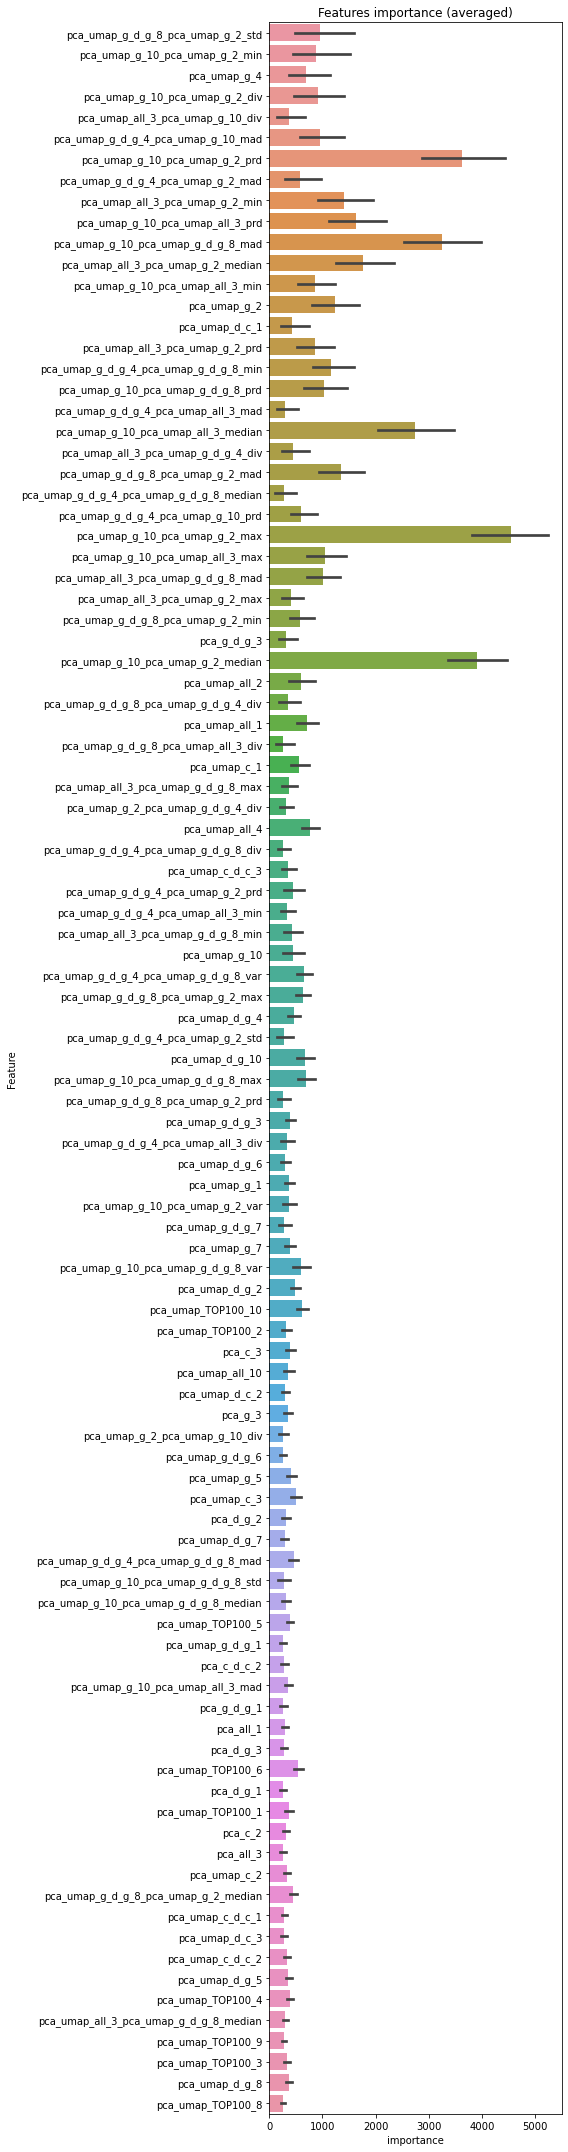

In [56]:
if DEBUG:
    show_feature_importance(feature_importance_df)